In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

matplotlib.rcParams.update({'font.size': 22})

In [2]:
# Set seed
np.random.seed(42)
torch.manual_seed(42)

# Load Yacht Hydrodynamics dataset
yacht = np.genfromtxt('data/yacht_hydrodynamics.txt', delimiter="")[1:,:]
target = yacht[:,-1].reshape(-1,1)
data = yacht[:,:-1]

# Split into training, validation and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=30, random_state=42)

# Convert arrays to Torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).view(-1,1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

# Normalise the training dataset
X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

# Define the data-loader
train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=30)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(6, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds[:,self.n-1]

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

## SGLD

In [12]:
import torch
import torchvision
import os

from torch import nn
import torch.nn.functional as F
import numpy as np

import sgld

import model



np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
#lr = 8e-7
#lr = 6e-6
#3e-2
# lr = 9e-7
# lr = 3e-6
lr = 9e-5



batch_size = 32.
dataset_size= 246

n_samples = 300
n_chains = 10




ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))
predictions_sgld = np.zeros((n_chains,n_samples,30))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(5000):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse,ll,prediction = evaluate.fn(network)
                rmse_sgld[i,n] = rmse
                ll_sgld[i,n] = ll
                predictions_sgld[i,n,:] = prediction
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.8383
chain 0 - epoch 1 - loss: 7.5225
chain 0 - epoch 2 - loss: 6.2305
chain 0 - epoch 3 - loss: 6.0870
chain 0 - epoch 4 - loss: 6.2442
chain 0 - epoch 5 - loss: 6.1206
chain 0 - epoch 6 - loss: 5.9536
chain 0 - epoch 7 - loss: 5.7336
chain 0 - epoch 8 - loss: 5.6931
chain 0 - epoch 9 - loss: 5.7552
chain 0 - epoch 10 - loss: 5.4983
chain 0 - epoch 11 - loss: 5.7274
chain 0 - epoch 12 - loss: 5.5354
chain 0 - epoch 13 - loss: 5.9787
chain 0 - epoch 14 - loss: 5.8536
chain 0 - epoch 15 - loss: 5.8885
chain 0 - epoch 16 - loss: 5.0994
chain 0 - epoch 17 - loss: 4.9855
chain 0 - epoch 18 - loss: 4.6419
chain 0 - epoch 19 - loss: 5.0104
chain 0 - epoch 20 - loss: 4.6177
chain 0 - epoch 21 - loss: 4.5282
chain 0 - epoch 22 - loss: 4.2650
chain 0 - epoch 23 - loss: 3.9829
chain 0 - epoch 24 - loss: 3.5010
chain 0 - epoch 25 - loss: 3.5731
chain 0 - epoch 26 - loss: 3.5361
chain 0 - epoch 27 - loss: 2.8047
chain 0 - epoch 28 - loss: 3.7963
chain 0 - epoch 29 - lo

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 45 - loss: 1.8223
chain 0 - epoch 46 - loss: 2.8262
chain 0 - epoch 47 - loss: 1.6742
chain 0 - epoch 48 - loss: 2.6360
chain 0 - epoch 49 - loss: 2.0372
chain 0 - epoch 50 - loss: 2.7249
chain 0 - epoch 51 - loss: 2.2228
chain 0 - epoch 52 - loss: 3.7029
chain 0 - epoch 53 - loss: 4.5206
chain 0 - epoch 54 - loss: 5.2935
chain 0 - epoch 55 - loss: 3.8697
chain 0 - epoch 56 - loss: 2.5181
chain 0 - epoch 57 - loss: 1.9456
chain 0 - epoch 58 - loss: 2.5947
chain 0 - epoch 59 - loss: 2.0372
chain 0 - epoch 60 - loss: 2.8947
chain 0 - epoch 61 - loss: 2.2090
chain 0 - epoch 62 - loss: 2.0405
chain 0 - epoch 63 - loss: 2.5582
chain 0 - epoch 64 - loss: 1.9182
chain 0 - epoch 65 - loss: 3.7505
chain 0 - epoch 66 - loss: 2.4918
chain 0 - epoch 67 - loss: 4.5125
chain 0 - epoch 68 - loss: 12.6757
chain 0 - epoch 69 - loss: 3.3692
chain 0 - epoch 70 - loss: 3.1589
chain 0 - epoch 71 - loss: 3.6034
chain 0 - epoch 72 - loss: 7.2994
chain 0 - epoch 73 - loss: 3.5662
chain 0 - epo

chain 0 - epoch 296 - loss: 5.7345
chain 0 - epoch 297 - loss: 7.7144
chain 0 - epoch 298 - loss: 10.1111
chain 0 - epoch 299 - loss: 11.6374
chain 0 - epoch 300 - loss: 3.1677
chain 0 - epoch 301 - loss: 5.3864
chain 0 - epoch 302 - loss: 4.0322
chain 0 - epoch 303 - loss: 6.7267
chain 0 - epoch 304 - loss: 3.0666
chain 0 - epoch 305 - loss: 3.5303
chain 0 - epoch 306 - loss: 4.5672
chain 0 - epoch 307 - loss: 3.3536
chain 0 - epoch 308 - loss: 4.2635
chain 0 - epoch 309 - loss: 3.5475
chain 0 - epoch 310 - loss: 5.0353
chain 0 - epoch 311 - loss: 3.1254
chain 0 - epoch 312 - loss: 2.2418
chain 0 - epoch 313 - loss: 2.5458
chain 0 - epoch 314 - loss: 4.3998
chain 0 - epoch 315 - loss: 3.2731
chain 0 - epoch 316 - loss: 3.7310
chain 0 - epoch 317 - loss: 3.0767
chain 0 - epoch 318 - loss: 2.5318
chain 0 - epoch 319 - loss: 2.2840
chain 0 - epoch 320 - loss: 2.7953
chain 0 - epoch 321 - loss: 4.1906
chain 0 - epoch 322 - loss: 3.0989
chain 0 - epoch 323 - loss: 4.6449
chain 0 - epoch 32

chain 0 - epoch 543 - loss: 2.9155
chain 0 - epoch 544 - loss: 3.2385
chain 0 - epoch 545 - loss: 4.8933
chain 0 - epoch 546 - loss: 2.2897
chain 0 - epoch 547 - loss: 5.5327
chain 0 - epoch 548 - loss: 2.9205
chain 0 - epoch 549 - loss: 2.1935
chain 0 - epoch 550 - loss: 2.7769
chain 0 - epoch 551 - loss: 2.5327
chain 0 - epoch 552 - loss: 2.2847
chain 0 - epoch 553 - loss: 1.7088
chain 0 - epoch 554 - loss: 3.9029
chain 0 - epoch 555 - loss: 2.6664
chain 0 - epoch 556 - loss: 3.2273
chain 0 - epoch 557 - loss: 2.6832
chain 0 - epoch 558 - loss: 2.1543
chain 0 - epoch 559 - loss: 5.1858
chain 0 - epoch 560 - loss: 3.0718
chain 0 - epoch 561 - loss: 5.0060
chain 0 - epoch 562 - loss: 3.3461
chain 0 - epoch 563 - loss: 3.4190
chain 0 - epoch 564 - loss: 5.0509
chain 0 - epoch 565 - loss: 4.4950
chain 0 - epoch 566 - loss: 3.0959
chain 0 - epoch 567 - loss: 5.0539
chain 0 - epoch 568 - loss: 7.8987
chain 0 - epoch 569 - loss: 3.4922
chain 0 - epoch 570 - loss: 4.4635
chain 0 - epoch 571 

chain 0 - epoch 778 - loss: 2.5397
chain 0 - epoch 779 - loss: 2.4292
chain 0 - epoch 780 - loss: 2.2472
chain 0 - epoch 781 - loss: 2.3186
chain 0 - epoch 782 - loss: 2.4389
chain 0 - epoch 783 - loss: 2.0939
chain 0 - epoch 784 - loss: 1.9264
chain 0 - epoch 785 - loss: 2.8365
chain 0 - epoch 786 - loss: 2.8280
chain 0 - epoch 787 - loss: 2.5585
chain 0 - epoch 788 - loss: 3.2921
chain 0 - epoch 789 - loss: 4.6627
chain 0 - epoch 790 - loss: 3.7881
chain 0 - epoch 791 - loss: 2.3907
chain 0 - epoch 792 - loss: 2.2284
chain 0 - epoch 793 - loss: 1.7684
chain 0 - epoch 794 - loss: 2.2425
chain 0 - epoch 795 - loss: 2.6380
chain 0 - epoch 796 - loss: 2.9050
chain 0 - epoch 797 - loss: 3.8433
chain 0 - epoch 798 - loss: 6.3116
chain 0 - epoch 799 - loss: 3.3616
chain 0 - epoch 800 - loss: 4.0817
chain 0 - epoch 801 - loss: 2.3244
chain 0 - epoch 802 - loss: 2.8745
chain 0 - epoch 803 - loss: 2.9505
chain 0 - epoch 804 - loss: 3.4360
chain 0 - epoch 805 - loss: 3.6280
chain 0 - epoch 806 

chain 0 - epoch 1029 - loss: 1.7773
chain 0 - epoch 1030 - loss: 2.9780
chain 0 - epoch 1031 - loss: 1.9748
chain 0 - epoch 1032 - loss: 4.0820
chain 0 - epoch 1033 - loss: 2.3355
chain 0 - epoch 1034 - loss: 2.4630
chain 0 - epoch 1035 - loss: 2.7947
chain 0 - epoch 1036 - loss: 2.0570
chain 0 - epoch 1037 - loss: 1.9889
chain 0 - epoch 1038 - loss: 2.3238
chain 0 - epoch 1039 - loss: 2.1430
chain 0 - epoch 1040 - loss: 2.6905
chain 0 - epoch 1041 - loss: 3.2280
chain 0 - epoch 1042 - loss: 2.6888
chain 0 - epoch 1043 - loss: 3.2143
chain 0 - epoch 1044 - loss: 2.5601
chain 0 - epoch 1045 - loss: 3.2356
chain 0 - epoch 1046 - loss: 1.7902
chain 0 - epoch 1047 - loss: 2.3763
chain 0 - epoch 1048 - loss: 2.4356
chain 0 - epoch 1049 - loss: 2.7725
chain 0 - epoch 1050 - loss: 1.8652
chain 0 - epoch 1051 - loss: 2.1026
chain 0 - epoch 1052 - loss: 1.9943
chain 0 - epoch 1053 - loss: 1.8154
chain 0 - epoch 1054 - loss: 7.1519
chain 0 - epoch 1055 - loss: 5.8252
chain 0 - epoch 1056 - loss:

chain 0 - epoch 1261 - loss: 2.0104
chain 0 - epoch 1262 - loss: 2.5870
chain 0 - epoch 1263 - loss: 2.2792
chain 0 - epoch 1264 - loss: 2.3699
chain 0 - epoch 1265 - loss: 2.7148
chain 0 - epoch 1266 - loss: 2.7179
chain 0 - epoch 1267 - loss: 2.2577
chain 0 - epoch 1268 - loss: 2.0658
chain 0 - epoch 1269 - loss: 2.3645
chain 0 - epoch 1270 - loss: 3.3719
chain 0 - epoch 1271 - loss: 5.4473
chain 0 - epoch 1272 - loss: 2.6108
chain 0 - epoch 1273 - loss: 2.5490
chain 0 - epoch 1274 - loss: 1.7651
chain 0 - epoch 1275 - loss: 3.0842
chain 0 - epoch 1276 - loss: 2.1801
chain 0 - epoch 1277 - loss: 1.7982
chain 0 - epoch 1278 - loss: 2.0061
chain 0 - epoch 1279 - loss: 1.9619
chain 0 - epoch 1280 - loss: 1.6783
chain 0 - epoch 1281 - loss: 3.6714
chain 0 - epoch 1282 - loss: 2.1404
chain 0 - epoch 1283 - loss: 3.0191
chain 0 - epoch 1284 - loss: 1.8795
chain 0 - epoch 1285 - loss: 2.1283
chain 0 - epoch 1286 - loss: 1.5758
chain 0 - epoch 1287 - loss: 1.6631
chain 0 - epoch 1288 - loss:

chain 0 - epoch 1492 - loss: 1.7126
chain 0 - epoch 1493 - loss: 1.3913
chain 0 - epoch 1494 - loss: 1.5772
chain 0 - epoch 1495 - loss: 2.0111
chain 0 - epoch 1496 - loss: 2.2559
chain 0 - epoch 1497 - loss: 1.5284
chain 0 - epoch 1498 - loss: 1.4719
chain 0 - epoch 1499 - loss: 3.3393
chain 0 - epoch 1500 - loss: 1.3022
chain 0 - epoch 1501 - loss: 1.1190
chain 0 - epoch 1502 - loss: 1.4608
chain 0 - epoch 1503 - loss: 1.3159
chain 0 - epoch 1504 - loss: 1.2120
chain 0 - epoch 1505 - loss: 1.0434
chain 0 - epoch 1506 - loss: 1.4238
chain 0 - epoch 1507 - loss: 1.3341
chain 0 - epoch 1508 - loss: 1.4707
chain 0 - epoch 1509 - loss: 1.7931
chain 0 - epoch 1510 - loss: 1.6718
chain 0 - epoch 1511 - loss: 1.6169
chain 0 - epoch 1512 - loss: 1.6893
chain 0 - epoch 1513 - loss: 1.8136
chain 0 - epoch 1514 - loss: 1.6944
chain 0 - epoch 1515 - loss: 1.3715
chain 0 - epoch 1516 - loss: 1.3630
chain 0 - epoch 1517 - loss: 1.2748
chain 0 - epoch 1518 - loss: 1.4620
chain 0 - epoch 1519 - loss:

chain 0 - epoch 1728 - loss: 2.0413
chain 0 - epoch 1729 - loss: 2.0312
chain 0 - epoch 1730 - loss: 1.8751
chain 0 - epoch 1731 - loss: 1.6903
chain 0 - epoch 1732 - loss: 2.0169
chain 0 - epoch 1733 - loss: 2.0467
chain 0 - epoch 1734 - loss: 2.3217
chain 0 - epoch 1735 - loss: 1.8994
chain 0 - epoch 1736 - loss: 1.8624
chain 0 - epoch 1737 - loss: 1.7422
chain 0 - epoch 1738 - loss: 1.4805
chain 0 - epoch 1739 - loss: 1.6284
chain 0 - epoch 1740 - loss: 1.6213
chain 0 - epoch 1741 - loss: 1.4981
chain 0 - epoch 1742 - loss: 1.6762
chain 0 - epoch 1743 - loss: 1.5560
chain 0 - epoch 1744 - loss: 1.6071
chain 0 - epoch 1745 - loss: 1.5842
chain 0 - epoch 1746 - loss: 1.6118
chain 0 - epoch 1747 - loss: 2.0573
chain 0 - epoch 1748 - loss: 1.3902
chain 0 - epoch 1749 - loss: 1.7630
chain 0 - epoch 1750 - loss: 1.9542
chain 0 - epoch 1751 - loss: 1.7739
chain 0 - epoch 1752 - loss: 2.1242
chain 0 - epoch 1753 - loss: 2.0166
chain 0 - epoch 1754 - loss: 2.1619
chain 0 - epoch 1755 - loss:

chain 0 - epoch 1957 - loss: 1.4038
chain 0 - epoch 1958 - loss: 1.3518
chain 0 - epoch 1959 - loss: 1.4018
chain 0 - epoch 1960 - loss: 1.3546
chain 0 - epoch 1961 - loss: 1.1693
chain 0 - epoch 1962 - loss: 1.6993
chain 0 - epoch 1963 - loss: 1.9057
chain 0 - epoch 1964 - loss: 1.8754
chain 0 - epoch 1965 - loss: 1.5007
chain 0 - epoch 1966 - loss: 1.8953
chain 0 - epoch 1967 - loss: 1.6093
chain 0 - epoch 1968 - loss: 1.5476
chain 0 - epoch 1969 - loss: 1.8639
chain 0 - epoch 1970 - loss: 1.7113
chain 0 - epoch 1971 - loss: 1.5375
chain 0 - epoch 1972 - loss: 1.7133
chain 0 - epoch 1973 - loss: 1.2352
chain 0 - epoch 1974 - loss: 1.1526
chain 0 - epoch 1975 - loss: 1.6120
chain 0 - epoch 1976 - loss: 1.2767
chain 0 - epoch 1977 - loss: 1.8668
chain 0 - epoch 1978 - loss: 1.4746
chain 0 - epoch 1979 - loss: 1.8498
chain 0 - epoch 1980 - loss: 1.7941
chain 0 - epoch 1981 - loss: 1.5981
chain 0 - epoch 1982 - loss: 1.8634
chain 0 - epoch 1983 - loss: 2.2174
chain 0 - epoch 1984 - loss:

chain 0 - epoch 2191 - loss: 1.7562
chain 0 - epoch 2192 - loss: 1.6428
chain 0 - epoch 2193 - loss: 1.4155
chain 0 - epoch 2194 - loss: 1.4776
chain 0 - epoch 2195 - loss: 1.5648
chain 0 - epoch 2196 - loss: 1.3265
chain 0 - epoch 2197 - loss: 1.5271
chain 0 - epoch 2198 - loss: 1.3469
chain 0 - epoch 2199 - loss: 1.5958
chain 0 - epoch 2200 - loss: 1.5647
chain 0 - epoch 2201 - loss: 1.4931
chain 0 - epoch 2202 - loss: 1.3101
chain 0 - epoch 2203 - loss: 1.5152
chain 0 - epoch 2204 - loss: 1.6117
chain 0 - epoch 2205 - loss: 1.7844
chain 0 - epoch 2206 - loss: 1.6872
chain 0 - epoch 2207 - loss: 1.3375
chain 0 - epoch 2208 - loss: 1.6733
chain 0 - epoch 2209 - loss: 1.3809
chain 0 - epoch 2210 - loss: 2.0334
chain 0 - epoch 2211 - loss: 1.6945
chain 0 - epoch 2212 - loss: 1.5519
chain 0 - epoch 2213 - loss: 1.4343
chain 0 - epoch 2214 - loss: 1.7661
chain 0 - epoch 2215 - loss: 1.7380
chain 0 - epoch 2216 - loss: 1.6351
chain 0 - epoch 2217 - loss: 1.3535
chain 0 - epoch 2218 - loss:

chain 0 - epoch 2430 - loss: 1.5316
chain 0 - epoch 2431 - loss: 1.6549
chain 0 - epoch 2432 - loss: 1.4060
chain 0 - epoch 2433 - loss: 1.4422
chain 0 - epoch 2434 - loss: 1.5026
chain 0 - epoch 2435 - loss: 1.6748
chain 0 - epoch 2436 - loss: 1.5047
chain 0 - epoch 2437 - loss: 1.3804
chain 0 - epoch 2438 - loss: 1.6160
chain 0 - epoch 2439 - loss: 1.5707
chain 0 - epoch 2440 - loss: 1.5828
chain 0 - epoch 2441 - loss: 1.8459
chain 0 - epoch 2442 - loss: 1.9491
chain 0 - epoch 2443 - loss: 1.4898
chain 0 - epoch 2444 - loss: 1.8053
chain 0 - epoch 2445 - loss: 1.6276
chain 0 - epoch 2446 - loss: 1.5992
chain 0 - epoch 2447 - loss: 1.4865
chain 0 - epoch 2448 - loss: 1.4961
chain 0 - epoch 2449 - loss: 1.4093
chain 0 - epoch 2450 - loss: 1.5295
chain 0 - epoch 2451 - loss: 1.5997
chain 0 - epoch 2452 - loss: 1.7265
chain 0 - epoch 2453 - loss: 1.5662
chain 0 - epoch 2454 - loss: 1.6488
chain 0 - epoch 2455 - loss: 2.0172
chain 0 - epoch 2456 - loss: 1.6152
chain 0 - epoch 2457 - loss:

chain 0 - epoch 2661 - loss: 1.4303
chain 0 - epoch 2662 - loss: 1.0837
chain 0 - epoch 2663 - loss: 1.1509
chain 0 - epoch 2664 - loss: 1.2833
chain 0 - epoch 2665 - loss: 1.2892
chain 0 - epoch 2666 - loss: 1.6831
chain 0 - epoch 2667 - loss: 1.4188
chain 0 - epoch 2668 - loss: 1.7198
chain 0 - epoch 2669 - loss: 1.7732
chain 0 - epoch 2670 - loss: 1.5520
chain 0 - epoch 2671 - loss: 1.6810
chain 0 - epoch 2672 - loss: 1.4309
chain 0 - epoch 2673 - loss: 1.5741
chain 0 - epoch 2674 - loss: 1.3582
chain 0 - epoch 2675 - loss: 1.6284
chain 0 - epoch 2676 - loss: 1.5585
chain 0 - epoch 2677 - loss: 1.6651
chain 0 - epoch 2678 - loss: 1.3559
chain 0 - epoch 2679 - loss: 1.5053
chain 0 - epoch 2680 - loss: 1.4444
chain 0 - epoch 2681 - loss: 1.4541
chain 0 - epoch 2682 - loss: 1.1984
chain 0 - epoch 2683 - loss: 1.3110
chain 0 - epoch 2684 - loss: 1.1872
chain 0 - epoch 2685 - loss: 1.1968
chain 0 - epoch 2686 - loss: 1.1527
chain 0 - epoch 2687 - loss: 1.1401
chain 0 - epoch 2688 - loss:

chain 0 - epoch 2897 - loss: 1.3110
chain 0 - epoch 2898 - loss: 1.4371
chain 0 - epoch 2899 - loss: 1.1187
chain 0 - epoch 2900 - loss: 1.0796
chain 0 - epoch 2901 - loss: 1.2673
chain 0 - epoch 2902 - loss: 1.3051
chain 0 - epoch 2903 - loss: 1.4567
chain 0 - epoch 2904 - loss: 1.2022
chain 0 - epoch 2905 - loss: 1.2911
chain 0 - epoch 2906 - loss: 1.2824
chain 0 - epoch 2907 - loss: 1.4871
chain 0 - epoch 2908 - loss: 1.6697
chain 0 - epoch 2909 - loss: 1.6396
chain 0 - epoch 2910 - loss: 1.7421
chain 0 - epoch 2911 - loss: 1.5938
chain 0 - epoch 2912 - loss: 1.9088
chain 0 - epoch 2913 - loss: 1.4957
chain 0 - epoch 2914 - loss: 1.6266
chain 0 - epoch 2915 - loss: 1.6189
chain 0 - epoch 2916 - loss: 1.4197
chain 0 - epoch 2917 - loss: 1.3258
chain 0 - epoch 2918 - loss: 1.1541
chain 0 - epoch 2919 - loss: 1.2000
chain 0 - epoch 2920 - loss: 1.2383
chain 0 - epoch 2921 - loss: 1.1350
chain 0 - epoch 2922 - loss: 1.1002
chain 0 - epoch 2923 - loss: 1.0601
chain 0 - epoch 2924 - loss:

chain 0 - epoch 3135 - loss: 1.3597
chain 0 - epoch 3136 - loss: 1.5326
chain 0 - epoch 3137 - loss: 1.3016
chain 0 - epoch 3138 - loss: 1.3129
chain 0 - epoch 3139 - loss: 1.4281
chain 0 - epoch 3140 - loss: 1.4611
chain 0 - epoch 3141 - loss: 1.5192
chain 0 - epoch 3142 - loss: 1.5912
chain 0 - epoch 3143 - loss: 1.6458
chain 0 - epoch 3144 - loss: 1.9795
chain 0 - epoch 3145 - loss: 1.4781
chain 0 - epoch 3146 - loss: 1.6028
chain 0 - epoch 3147 - loss: 1.9336
chain 0 - epoch 3148 - loss: 1.4742
chain 0 - epoch 3149 - loss: 1.3284
chain 0 - epoch 3150 - loss: 1.3070
chain 0 - epoch 3151 - loss: 1.1923
chain 0 - epoch 3152 - loss: 1.2509
chain 0 - epoch 3153 - loss: 1.2547
chain 0 - epoch 3154 - loss: 1.0774
chain 0 - epoch 3155 - loss: 1.0386
chain 0 - epoch 3156 - loss: 1.0030
chain 0 - epoch 3157 - loss: 1.2651
chain 0 - epoch 3158 - loss: 1.2745
chain 0 - epoch 3159 - loss: 1.1537
chain 0 - epoch 3160 - loss: 1.4047
chain 0 - epoch 3161 - loss: 1.5861
chain 0 - epoch 3162 - loss:

chain 0 - epoch 3371 - loss: 1.5299
chain 0 - epoch 3372 - loss: 1.4842
chain 0 - epoch 3373 - loss: 1.4633
chain 0 - epoch 3374 - loss: 1.4529
chain 0 - epoch 3375 - loss: 1.1952
chain 0 - epoch 3376 - loss: 1.3245
chain 0 - epoch 3377 - loss: 1.4654
chain 0 - epoch 3378 - loss: 1.3157
chain 0 - epoch 3379 - loss: 1.4537
chain 0 - epoch 3380 - loss: 1.6203
chain 0 - epoch 3381 - loss: 1.4241
chain 0 - epoch 3382 - loss: 1.3801
chain 0 - epoch 3383 - loss: 1.4263
chain 0 - epoch 3384 - loss: 1.4598
chain 0 - epoch 3385 - loss: 1.3494
chain 0 - epoch 3386 - loss: 1.6567
chain 0 - epoch 3387 - loss: 1.5794
chain 0 - epoch 3388 - loss: 1.8459
chain 0 - epoch 3389 - loss: 1.5721
chain 0 - epoch 3390 - loss: 1.4109
chain 0 - epoch 3391 - loss: 1.5709
chain 0 - epoch 3392 - loss: 1.6360
chain 0 - epoch 3393 - loss: 1.4357
chain 0 - epoch 3394 - loss: 1.3660
chain 0 - epoch 3395 - loss: 1.5814
chain 0 - epoch 3396 - loss: 1.3907
chain 0 - epoch 3397 - loss: 1.3025
chain 0 - epoch 3398 - loss:

chain 0 - epoch 3609 - loss: 1.4162
chain 0 - epoch 3610 - loss: 1.5322
chain 0 - epoch 3611 - loss: 1.7853
chain 0 - epoch 3612 - loss: 1.6808
chain 0 - epoch 3613 - loss: 1.6965
chain 0 - epoch 3614 - loss: 1.6895
chain 0 - epoch 3615 - loss: 1.5884
chain 0 - epoch 3616 - loss: 1.9557
chain 0 - epoch 3617 - loss: 1.7612
chain 0 - epoch 3618 - loss: 1.6706
chain 0 - epoch 3619 - loss: 1.4228
chain 0 - epoch 3620 - loss: 1.5410
chain 0 - epoch 3621 - loss: 1.8319
chain 0 - epoch 3622 - loss: 1.5174
chain 0 - epoch 3623 - loss: 1.5436
chain 0 - epoch 3624 - loss: 1.2374
chain 0 - epoch 3625 - loss: 1.3560
chain 0 - epoch 3626 - loss: 1.5693
chain 0 - epoch 3627 - loss: 1.5290
chain 0 - epoch 3628 - loss: 1.4986
chain 0 - epoch 3629 - loss: 1.6982
chain 0 - epoch 3630 - loss: 1.5853
chain 0 - epoch 3631 - loss: 1.6008
chain 0 - epoch 3632 - loss: 1.3894
chain 0 - epoch 3633 - loss: 1.5758
chain 0 - epoch 3634 - loss: 1.9106
chain 0 - epoch 3635 - loss: 1.4521
chain 0 - epoch 3636 - loss:

chain 0 - epoch 3845 - loss: 1.2611
chain 0 - epoch 3846 - loss: 1.3778
chain 0 - epoch 3847 - loss: 1.4314
chain 0 - epoch 3848 - loss: 1.3683
chain 0 - epoch 3849 - loss: 1.3758
chain 0 - epoch 3850 - loss: 1.3739
chain 0 - epoch 3851 - loss: 1.3391
chain 0 - epoch 3852 - loss: 1.2102
chain 0 - epoch 3853 - loss: 1.0273
chain 0 - epoch 3854 - loss: 1.0009
chain 0 - epoch 3855 - loss: 1.0695
chain 0 - epoch 3856 - loss: 0.9329
chain 0 - epoch 3857 - loss: 0.9979
chain 0 - epoch 3858 - loss: 0.9770
chain 0 - epoch 3859 - loss: 0.8971
chain 0 - epoch 3860 - loss: 1.0057
chain 0 - epoch 3861 - loss: 1.2284
chain 0 - epoch 3862 - loss: 1.2809
chain 0 - epoch 3863 - loss: 1.0261
chain 0 - epoch 3864 - loss: 0.9999
chain 0 - epoch 3865 - loss: 1.1353
chain 0 - epoch 3866 - loss: 1.1012
chain 0 - epoch 3867 - loss: 0.8946
chain 0 - epoch 3868 - loss: 0.9317
chain 0 - epoch 3869 - loss: 0.8907
chain 0 - epoch 3870 - loss: 1.0007
chain 0 - epoch 3871 - loss: 0.9470
chain 0 - epoch 3872 - loss:

chain 0 - epoch 4078 - loss: 1.6431
chain 0 - epoch 4079 - loss: 1.6919
chain 0 - epoch 4080 - loss: 1.3974
chain 0 - epoch 4081 - loss: 1.4634
chain 0 - epoch 4082 - loss: 1.5108
chain 0 - epoch 4083 - loss: 1.5757
chain 0 - epoch 4084 - loss: 1.3981
chain 0 - epoch 4085 - loss: 1.3221
chain 0 - epoch 4086 - loss: 1.2018
chain 0 - epoch 4087 - loss: 1.2921
chain 0 - epoch 4088 - loss: 1.3490
chain 0 - epoch 4089 - loss: 1.2773
chain 0 - epoch 4090 - loss: 1.2835
chain 0 - epoch 4091 - loss: 1.3521
chain 0 - epoch 4092 - loss: 1.1483
chain 0 - epoch 4093 - loss: 1.3394
chain 0 - epoch 4094 - loss: 1.2649
chain 0 - epoch 4095 - loss: 1.3770
chain 0 - epoch 4096 - loss: 1.7761
chain 0 - epoch 4097 - loss: 1.4696
chain 0 - epoch 4098 - loss: 1.5972
chain 0 - epoch 4099 - loss: 1.8547
chain 0 - epoch 4100 - loss: 1.7570
chain 0 - epoch 4101 - loss: 1.7375
chain 0 - epoch 4102 - loss: 1.6818
chain 0 - epoch 4103 - loss: 1.5262
chain 0 - epoch 4104 - loss: 1.4649
chain 0 - epoch 4105 - loss:

chain 0 - epoch 4309 - loss: 1.4643
chain 0 - epoch 4310 - loss: 1.5574
chain 0 - epoch 4311 - loss: 1.5374
chain 0 - epoch 4312 - loss: 1.3651
chain 0 - epoch 4313 - loss: 1.4364
chain 0 - epoch 4314 - loss: 1.4097
chain 0 - epoch 4315 - loss: 1.5883
chain 0 - epoch 4316 - loss: 1.5568
chain 0 - epoch 4317 - loss: 1.5782
chain 0 - epoch 4318 - loss: 1.6109
chain 0 - epoch 4319 - loss: 1.5495
chain 0 - epoch 4320 - loss: 1.4272
chain 0 - epoch 4321 - loss: 1.4594
chain 0 - epoch 4322 - loss: 1.4224
chain 0 - epoch 4323 - loss: 1.5946
chain 0 - epoch 4324 - loss: 1.6144
chain 0 - epoch 4325 - loss: 1.3738
chain 0 - epoch 4326 - loss: 1.3388
chain 0 - epoch 4327 - loss: 1.3585
chain 0 - epoch 4328 - loss: 1.2755
chain 0 - epoch 4329 - loss: 1.4679
chain 0 - epoch 4330 - loss: 1.4428
chain 0 - epoch 4331 - loss: 1.3444
chain 0 - epoch 4332 - loss: 1.3780
chain 0 - epoch 4333 - loss: 1.3844
chain 0 - epoch 4334 - loss: 1.3339
chain 0 - epoch 4335 - loss: 1.3302
chain 0 - epoch 4336 - loss:

chain 0 - epoch 4546 - loss: 2.2053
chain 0 - epoch 4547 - loss: 2.3088
chain 0 - epoch 4548 - loss: 2.2726
chain 0 - epoch 4549 - loss: 2.2042
chain 0 - epoch 4550 - loss: 2.0234
chain 0 - epoch 4551 - loss: 2.0965
chain 0 - epoch 4552 - loss: 2.0450
chain 0 - epoch 4553 - loss: 2.2137
chain 0 - epoch 4554 - loss: 2.1362
chain 0 - epoch 4555 - loss: 2.2262
chain 0 - epoch 4556 - loss: 2.2006
chain 0 - epoch 4557 - loss: 2.1166
chain 0 - epoch 4558 - loss: 2.2214
chain 0 - epoch 4559 - loss: 2.0386
chain 0 - epoch 4560 - loss: 2.0989
chain 0 - epoch 4561 - loss: 2.0873
chain 0 - epoch 4562 - loss: 2.0036
chain 0 - epoch 4563 - loss: 1.9624
chain 0 - epoch 4564 - loss: 1.9318
chain 0 - epoch 4565 - loss: 1.9488
chain 0 - epoch 4566 - loss: 1.7823
chain 0 - epoch 4567 - loss: 1.9363
chain 0 - epoch 4568 - loss: 1.8711
chain 0 - epoch 4569 - loss: 1.6860
chain 0 - epoch 4570 - loss: 1.6524
chain 0 - epoch 4571 - loss: 1.8209
chain 0 - epoch 4572 - loss: 1.7361
chain 0 - epoch 4573 - loss:

chain 0 - epoch 4776 - loss: 2.0321
chain 0 - epoch 4777 - loss: 1.8543
chain 0 - epoch 4778 - loss: 1.7564
chain 0 - epoch 4779 - loss: 1.7162
chain 0 - epoch 4780 - loss: 1.7688
chain 0 - epoch 4781 - loss: 1.6695
chain 0 - epoch 4782 - loss: 1.5874
chain 0 - epoch 4783 - loss: 1.6720
chain 0 - epoch 4784 - loss: 1.8170
chain 0 - epoch 4785 - loss: 1.7920
chain 0 - epoch 4786 - loss: 1.8072
chain 0 - epoch 4787 - loss: 1.7378
chain 0 - epoch 4788 - loss: 1.6281
chain 0 - epoch 4789 - loss: 1.6025
chain 0 - epoch 4790 - loss: 1.7962
chain 0 - epoch 4791 - loss: 1.7990
chain 0 - epoch 4792 - loss: 1.8027
chain 0 - epoch 4793 - loss: 1.8776
chain 0 - epoch 4794 - loss: 1.8963
chain 0 - epoch 4795 - loss: 1.9322
chain 0 - epoch 4796 - loss: 1.8952
chain 0 - epoch 4797 - loss: 1.8585
chain 0 - epoch 4798 - loss: 1.8628
chain 0 - epoch 4799 - loss: 1.8330
chain 0 - epoch 4800 - loss: 1.8154
chain 0 - epoch 4801 - loss: 1.7754
chain 0 - epoch 4802 - loss: 1.5909
chain 0 - epoch 4803 - loss:

chain 1 - epoch 10 - loss: 5.4887
chain 1 - epoch 11 - loss: 5.7672
chain 1 - epoch 12 - loss: 5.7456
chain 1 - epoch 13 - loss: 5.5544
chain 1 - epoch 14 - loss: 5.5761
chain 1 - epoch 15 - loss: 5.7538
chain 1 - epoch 16 - loss: 5.3127
chain 1 - epoch 17 - loss: 5.5203
chain 1 - epoch 18 - loss: 5.1922
chain 1 - epoch 19 - loss: 4.7177
chain 1 - epoch 20 - loss: 4.5797
chain 1 - epoch 21 - loss: 4.4124
chain 1 - epoch 22 - loss: 4.3923
chain 1 - epoch 23 - loss: 4.3566
chain 1 - epoch 24 - loss: 4.5014
chain 1 - epoch 25 - loss: 4.2781
chain 1 - epoch 26 - loss: 3.5594
chain 1 - epoch 27 - loss: 3.7885
chain 1 - epoch 28 - loss: 3.3545
chain 1 - epoch 29 - loss: 3.2830
chain 1 - epoch 30 - loss: 2.9838
chain 1 - epoch 31 - loss: 3.2121
chain 1 - epoch 32 - loss: 3.7805
chain 1 - epoch 33 - loss: 3.5347
chain 1 - epoch 34 - loss: 3.2490
chain 1 - epoch 35 - loss: 3.1302
chain 1 - epoch 36 - loss: 2.8655
chain 1 - epoch 37 - loss: 3.6921
chain 1 - epoch 38 - loss: 3.2248
chain 1 - epoc

chain 1 - epoch 252 - loss: 4.6836
chain 1 - epoch 253 - loss: 5.4337
chain 1 - epoch 254 - loss: 5.1712
chain 1 - epoch 255 - loss: 6.0421
chain 1 - epoch 256 - loss: 4.7769
chain 1 - epoch 257 - loss: 7.5330
chain 1 - epoch 258 - loss: 3.7507
chain 1 - epoch 259 - loss: 2.9103
chain 1 - epoch 260 - loss: 3.3231
chain 1 - epoch 261 - loss: 7.4875
chain 1 - epoch 262 - loss: 3.1764
chain 1 - epoch 263 - loss: 2.6148
chain 1 - epoch 264 - loss: 6.0416
chain 1 - epoch 265 - loss: 22.5794
chain 1 - epoch 266 - loss: 3.3782
chain 1 - epoch 267 - loss: 4.0801
chain 1 - epoch 268 - loss: 4.9649
chain 1 - epoch 269 - loss: 4.4680
chain 1 - epoch 270 - loss: 4.9685
chain 1 - epoch 271 - loss: 5.2171
chain 1 - epoch 272 - loss: 6.1958
chain 1 - epoch 273 - loss: 4.4478
chain 1 - epoch 274 - loss: 2.8684
chain 1 - epoch 275 - loss: 3.8878
chain 1 - epoch 276 - loss: 4.4385
chain 1 - epoch 277 - loss: 4.0065
chain 1 - epoch 278 - loss: 12.3402
chain 1 - epoch 279 - loss: 2.7155
chain 1 - epoch 28

chain 1 - epoch 486 - loss: 2.3617
chain 1 - epoch 487 - loss: 3.4931
chain 1 - epoch 488 - loss: 3.9147
chain 1 - epoch 489 - loss: 5.6632
chain 1 - epoch 490 - loss: 5.5590
chain 1 - epoch 491 - loss: 4.3396
chain 1 - epoch 492 - loss: 4.8122
chain 1 - epoch 493 - loss: 4.7349
chain 1 - epoch 494 - loss: 2.9113
chain 1 - epoch 495 - loss: 4.2446
chain 1 - epoch 496 - loss: 3.3043
chain 1 - epoch 497 - loss: 4.6101
chain 1 - epoch 498 - loss: 6.6849
chain 1 - epoch 499 - loss: 22.1942
chain 1 - epoch 500 - loss: 3.3175
chain 1 - epoch 501 - loss: 2.2565
chain 1 - epoch 502 - loss: 4.1403
chain 1 - epoch 503 - loss: 2.7981
chain 1 - epoch 504 - loss: 1.8801
chain 1 - epoch 505 - loss: 12.7593
chain 1 - epoch 506 - loss: 4.0108
chain 1 - epoch 507 - loss: 3.4310
chain 1 - epoch 508 - loss: 2.1537
chain 1 - epoch 509 - loss: 7.1470
chain 1 - epoch 510 - loss: 2.3643
chain 1 - epoch 511 - loss: 5.8625
chain 1 - epoch 512 - loss: 2.6869
chain 1 - epoch 513 - loss: 3.6404
chain 1 - epoch 51

chain 1 - epoch 723 - loss: 2.5383
chain 1 - epoch 724 - loss: 3.7497
chain 1 - epoch 725 - loss: 2.5028
chain 1 - epoch 726 - loss: 1.6016
chain 1 - epoch 727 - loss: 2.4225
chain 1 - epoch 728 - loss: 3.5930
chain 1 - epoch 729 - loss: 18.0068
chain 1 - epoch 730 - loss: 8.4046
chain 1 - epoch 731 - loss: 4.2914
chain 1 - epoch 732 - loss: 5.1780
chain 1 - epoch 733 - loss: 2.4646
chain 1 - epoch 734 - loss: 3.9188
chain 1 - epoch 735 - loss: 4.0841
chain 1 - epoch 736 - loss: 4.2537
chain 1 - epoch 737 - loss: 2.6724
chain 1 - epoch 738 - loss: 3.6456
chain 1 - epoch 739 - loss: 69.2718
chain 1 - epoch 740 - loss: 39.3912
chain 1 - epoch 741 - loss: 5.9475
chain 1 - epoch 742 - loss: 16.1996
chain 1 - epoch 743 - loss: 4.4249
chain 1 - epoch 744 - loss: 2.1770
chain 1 - epoch 745 - loss: 3.5666
chain 1 - epoch 746 - loss: 1.9613
chain 1 - epoch 747 - loss: 15.6277
chain 1 - epoch 748 - loss: 11.5709
chain 1 - epoch 749 - loss: 3.8427
chain 1 - epoch 750 - loss: 2.1467
chain 1 - epoc

chain 1 - epoch 965 - loss: 2.2668
chain 1 - epoch 966 - loss: 1.7664
chain 1 - epoch 967 - loss: 1.8831
chain 1 - epoch 968 - loss: 2.4041
chain 1 - epoch 969 - loss: 1.6989
chain 1 - epoch 970 - loss: 2.3963
chain 1 - epoch 971 - loss: 1.8649
chain 1 - epoch 972 - loss: 1.9458
chain 1 - epoch 973 - loss: 2.1425
chain 1 - epoch 974 - loss: 1.9334
chain 1 - epoch 975 - loss: 1.8994
chain 1 - epoch 976 - loss: 1.7313
chain 1 - epoch 977 - loss: 1.7761
chain 1 - epoch 978 - loss: 1.7340
chain 1 - epoch 979 - loss: 1.7271
chain 1 - epoch 980 - loss: 1.6320
chain 1 - epoch 981 - loss: 1.8140
chain 1 - epoch 982 - loss: 1.7907
chain 1 - epoch 983 - loss: 1.6502
chain 1 - epoch 984 - loss: 2.2558
chain 1 - epoch 985 - loss: 2.1662
chain 1 - epoch 986 - loss: 1.8308
chain 1 - epoch 987 - loss: 1.7073
chain 1 - epoch 988 - loss: 2.0113
chain 1 - epoch 989 - loss: 1.9215
chain 1 - epoch 990 - loss: 1.9133
chain 1 - epoch 991 - loss: 1.8692
chain 1 - epoch 992 - loss: 1.8182
chain 1 - epoch 993 

chain 1 - epoch 1203 - loss: 1.6754
chain 1 - epoch 1204 - loss: 1.1156
chain 1 - epoch 1205 - loss: 1.9616
chain 1 - epoch 1206 - loss: 0.9959
chain 1 - epoch 1207 - loss: 1.9335
chain 1 - epoch 1208 - loss: 1.8454
chain 1 - epoch 1209 - loss: 1.8464
chain 1 - epoch 1210 - loss: 1.9987
chain 1 - epoch 1211 - loss: 2.1098
chain 1 - epoch 1212 - loss: 2.1124
chain 1 - epoch 1213 - loss: 1.6234
chain 1 - epoch 1214 - loss: 1.4270
chain 1 - epoch 1215 - loss: 1.6065
chain 1 - epoch 1216 - loss: 2.2394
chain 1 - epoch 1217 - loss: 1.8740
chain 1 - epoch 1218 - loss: 2.2681
chain 1 - epoch 1219 - loss: 2.2836
chain 1 - epoch 1220 - loss: 1.8048
chain 1 - epoch 1221 - loss: 2.4260
chain 1 - epoch 1222 - loss: 2.0623
chain 1 - epoch 1223 - loss: 2.4378
chain 1 - epoch 1224 - loss: 1.8215
chain 1 - epoch 1225 - loss: 2.7713
chain 1 - epoch 1226 - loss: 2.3555
chain 1 - epoch 1227 - loss: 2.1412
chain 1 - epoch 1228 - loss: 2.1898
chain 1 - epoch 1229 - loss: 2.0437
chain 1 - epoch 1230 - loss:

chain 1 - epoch 1431 - loss: 2.4873
chain 1 - epoch 1432 - loss: 1.7133
chain 1 - epoch 1433 - loss: 2.0003
chain 1 - epoch 1434 - loss: 1.8198
chain 1 - epoch 1435 - loss: 2.2419
chain 1 - epoch 1436 - loss: 2.8766
chain 1 - epoch 1437 - loss: 1.8404
chain 1 - epoch 1438 - loss: 2.4762
chain 1 - epoch 1439 - loss: 2.4962
chain 1 - epoch 1440 - loss: 2.1599
chain 1 - epoch 1441 - loss: 2.0748
chain 1 - epoch 1442 - loss: 2.3392
chain 1 - epoch 1443 - loss: 2.3316
chain 1 - epoch 1444 - loss: 2.0112
chain 1 - epoch 1445 - loss: 2.1957
chain 1 - epoch 1446 - loss: 1.2048
chain 1 - epoch 1447 - loss: 1.8587
chain 1 - epoch 1448 - loss: 1.8212
chain 1 - epoch 1449 - loss: 2.1892
chain 1 - epoch 1450 - loss: 3.8099
chain 1 - epoch 1451 - loss: 2.2435
chain 1 - epoch 1452 - loss: 2.0298
chain 1 - epoch 1453 - loss: 3.2303
chain 1 - epoch 1454 - loss: 3.1963
chain 1 - epoch 1455 - loss: 2.4941
chain 1 - epoch 1456 - loss: 1.6739
chain 1 - epoch 1457 - loss: 2.0699
chain 1 - epoch 1458 - loss:

chain 1 - epoch 1665 - loss: 1.4796
chain 1 - epoch 1666 - loss: 2.0320
chain 1 - epoch 1667 - loss: 1.9277
chain 1 - epoch 1668 - loss: 2.1364
chain 1 - epoch 1669 - loss: 1.9756
chain 1 - epoch 1670 - loss: 1.6740
chain 1 - epoch 1671 - loss: 1.5778
chain 1 - epoch 1672 - loss: 1.4437
chain 1 - epoch 1673 - loss: 1.4458
chain 1 - epoch 1674 - loss: 1.5990
chain 1 - epoch 1675 - loss: 1.7870
chain 1 - epoch 1676 - loss: 1.7972
chain 1 - epoch 1677 - loss: 2.0181
chain 1 - epoch 1678 - loss: 2.1816
chain 1 - epoch 1679 - loss: 1.9561
chain 1 - epoch 1680 - loss: 1.8610
chain 1 - epoch 1681 - loss: 1.8592
chain 1 - epoch 1682 - loss: 1.8069
chain 1 - epoch 1683 - loss: 1.8450
chain 1 - epoch 1684 - loss: 2.5908
chain 1 - epoch 1685 - loss: 2.2514
chain 1 - epoch 1686 - loss: 1.8390
chain 1 - epoch 1687 - loss: 2.1035
chain 1 - epoch 1688 - loss: 2.7570
chain 1 - epoch 1689 - loss: 2.4967
chain 1 - epoch 1690 - loss: 2.3196
chain 1 - epoch 1691 - loss: 2.4914
chain 1 - epoch 1692 - loss:

chain 1 - epoch 1897 - loss: 1.5005
chain 1 - epoch 1898 - loss: 1.9634
chain 1 - epoch 1899 - loss: 1.5461
chain 1 - epoch 1900 - loss: 1.6201
chain 1 - epoch 1901 - loss: 1.5846
chain 1 - epoch 1902 - loss: 1.9098
chain 1 - epoch 1903 - loss: 1.4977
chain 1 - epoch 1904 - loss: 1.6914
chain 1 - epoch 1905 - loss: 1.7326
chain 1 - epoch 1906 - loss: 1.2980
chain 1 - epoch 1907 - loss: 1.4408
chain 1 - epoch 1908 - loss: 1.4863
chain 1 - epoch 1909 - loss: 1.6834
chain 1 - epoch 1910 - loss: 1.3659
chain 1 - epoch 1911 - loss: 1.5147
chain 1 - epoch 1912 - loss: 1.7161
chain 1 - epoch 1913 - loss: 1.6837
chain 1 - epoch 1914 - loss: 1.9158
chain 1 - epoch 1915 - loss: 1.6108
chain 1 - epoch 1916 - loss: 1.7428
chain 1 - epoch 1917 - loss: 1.5222
chain 1 - epoch 1918 - loss: 2.2261
chain 1 - epoch 1919 - loss: 1.6957
chain 1 - epoch 1920 - loss: 3.6665
chain 1 - epoch 1921 - loss: 2.0151
chain 1 - epoch 1922 - loss: 2.4238
chain 1 - epoch 1923 - loss: 2.5949
chain 1 - epoch 1924 - loss:

chain 1 - epoch 2125 - loss: 1.8227
chain 1 - epoch 2126 - loss: 1.8759
chain 1 - epoch 2127 - loss: 2.5479
chain 1 - epoch 2128 - loss: 1.9266
chain 1 - epoch 2129 - loss: 1.6932
chain 1 - epoch 2130 - loss: 1.4112
chain 1 - epoch 2131 - loss: 1.0309
chain 1 - epoch 2132 - loss: 1.1229
chain 1 - epoch 2133 - loss: 1.2619
chain 1 - epoch 2134 - loss: 0.9960
chain 1 - epoch 2135 - loss: 1.3499
chain 1 - epoch 2136 - loss: 1.6494
chain 1 - epoch 2137 - loss: 1.1960
chain 1 - epoch 2138 - loss: 1.2868
chain 1 - epoch 2139 - loss: 1.3281
chain 1 - epoch 2140 - loss: 1.2504
chain 1 - epoch 2141 - loss: 1.4879
chain 1 - epoch 2142 - loss: 1.8658
chain 1 - epoch 2143 - loss: 1.5965
chain 1 - epoch 2144 - loss: 1.4310
chain 1 - epoch 2145 - loss: 1.7235
chain 1 - epoch 2146 - loss: 1.1844
chain 1 - epoch 2147 - loss: 1.6836
chain 1 - epoch 2148 - loss: 1.5611
chain 1 - epoch 2149 - loss: 1.6894
chain 1 - epoch 2150 - loss: 1.2374
chain 1 - epoch 2151 - loss: 1.3591
chain 1 - epoch 2152 - loss:

chain 1 - epoch 2360 - loss: 0.8993
chain 1 - epoch 2361 - loss: 0.7808
chain 1 - epoch 2362 - loss: 0.9522
chain 1 - epoch 2363 - loss: 0.8952
chain 1 - epoch 2364 - loss: 0.9342
chain 1 - epoch 2365 - loss: 0.9535
chain 1 - epoch 2366 - loss: 1.0928
chain 1 - epoch 2367 - loss: 0.9882
chain 1 - epoch 2368 - loss: 0.9096
chain 1 - epoch 2369 - loss: 0.9932
chain 1 - epoch 2370 - loss: 1.0371
chain 1 - epoch 2371 - loss: 0.9216
chain 1 - epoch 2372 - loss: 0.9275
chain 1 - epoch 2373 - loss: 0.7700
chain 1 - epoch 2374 - loss: 0.8013
chain 1 - epoch 2375 - loss: 1.0645
chain 1 - epoch 2376 - loss: 0.8731
chain 1 - epoch 2377 - loss: 0.9733
chain 1 - epoch 2378 - loss: 0.9529
chain 1 - epoch 2379 - loss: 1.0997
chain 1 - epoch 2380 - loss: 1.0600
chain 1 - epoch 2381 - loss: 1.0855
chain 1 - epoch 2382 - loss: 1.5096
chain 1 - epoch 2383 - loss: 1.6088
chain 1 - epoch 2384 - loss: 1.4580
chain 1 - epoch 2385 - loss: 1.4465
chain 1 - epoch 2386 - loss: 1.3898
chain 1 - epoch 2387 - loss:

chain 1 - epoch 2592 - loss: 0.8952
chain 1 - epoch 2593 - loss: 0.8814
chain 1 - epoch 2594 - loss: 1.1372
chain 1 - epoch 2595 - loss: 0.9522
chain 1 - epoch 2596 - loss: 0.8507
chain 1 - epoch 2597 - loss: 0.9000
chain 1 - epoch 2598 - loss: 0.8916
chain 1 - epoch 2599 - loss: 0.9637
chain 1 - epoch 2600 - loss: 0.9264
chain 1 - epoch 2601 - loss: 1.2067
chain 1 - epoch 2602 - loss: 0.9447
chain 1 - epoch 2603 - loss: 0.9629
chain 1 - epoch 2604 - loss: 1.0595
chain 1 - epoch 2605 - loss: 1.2180
chain 1 - epoch 2606 - loss: 1.2972
chain 1 - epoch 2607 - loss: 1.1379
chain 1 - epoch 2608 - loss: 0.9805
chain 1 - epoch 2609 - loss: 1.0256
chain 1 - epoch 2610 - loss: 0.9176
chain 1 - epoch 2611 - loss: 1.1139
chain 1 - epoch 2612 - loss: 1.0764
chain 1 - epoch 2613 - loss: 0.9134
chain 1 - epoch 2614 - loss: 0.8365
chain 1 - epoch 2615 - loss: 0.9887
chain 1 - epoch 2616 - loss: 1.0386
chain 1 - epoch 2617 - loss: 1.1353
chain 1 - epoch 2618 - loss: 1.0278
chain 1 - epoch 2619 - loss:

chain 1 - epoch 2821 - loss: 2.2276
chain 1 - epoch 2822 - loss: 2.1235
chain 1 - epoch 2823 - loss: 2.1754
chain 1 - epoch 2824 - loss: 2.2390
chain 1 - epoch 2825 - loss: 2.1522
chain 1 - epoch 2826 - loss: 1.8558
chain 1 - epoch 2827 - loss: 1.8190
chain 1 - epoch 2828 - loss: 1.7283
chain 1 - epoch 2829 - loss: 1.9265
chain 1 - epoch 2830 - loss: 1.7721
chain 1 - epoch 2831 - loss: 1.8877
chain 1 - epoch 2832 - loss: 1.8632
chain 1 - epoch 2833 - loss: 1.4761
chain 1 - epoch 2834 - loss: 1.4143
chain 1 - epoch 2835 - loss: 1.5253
chain 1 - epoch 2836 - loss: 1.6092
chain 1 - epoch 2837 - loss: 1.3141
chain 1 - epoch 2838 - loss: 1.5983
chain 1 - epoch 2839 - loss: 1.4565
chain 1 - epoch 2840 - loss: 1.4142
chain 1 - epoch 2841 - loss: 1.4379
chain 1 - epoch 2842 - loss: 1.2770
chain 1 - epoch 2843 - loss: 1.5055
chain 1 - epoch 2844 - loss: 1.6406
chain 1 - epoch 2845 - loss: 2.0187
chain 1 - epoch 2846 - loss: 2.1609
chain 1 - epoch 2847 - loss: 1.6919
chain 1 - epoch 2848 - loss:

chain 1 - epoch 3058 - loss: 1.3216
chain 1 - epoch 3059 - loss: 1.2567
chain 1 - epoch 3060 - loss: 1.3176
chain 1 - epoch 3061 - loss: 1.3953
chain 1 - epoch 3062 - loss: 1.2685
chain 1 - epoch 3063 - loss: 1.3006
chain 1 - epoch 3064 - loss: 1.2927
chain 1 - epoch 3065 - loss: 1.5154
chain 1 - epoch 3066 - loss: 1.4392
chain 1 - epoch 3067 - loss: 1.3863
chain 1 - epoch 3068 - loss: 1.3191
chain 1 - epoch 3069 - loss: 1.2875
chain 1 - epoch 3070 - loss: 1.6152
chain 1 - epoch 3071 - loss: 1.5250
chain 1 - epoch 3072 - loss: 1.4608
chain 1 - epoch 3073 - loss: 1.6564
chain 1 - epoch 3074 - loss: 1.6062
chain 1 - epoch 3075 - loss: 1.8021
chain 1 - epoch 3076 - loss: 1.6899
chain 1 - epoch 3077 - loss: 1.5932
chain 1 - epoch 3078 - loss: 1.7895
chain 1 - epoch 3079 - loss: 1.6453
chain 1 - epoch 3080 - loss: 1.3569
chain 1 - epoch 3081 - loss: 1.4518
chain 1 - epoch 3082 - loss: 1.4716
chain 1 - epoch 3083 - loss: 1.6179
chain 1 - epoch 3084 - loss: 1.6775
chain 1 - epoch 3085 - loss:

chain 1 - epoch 3296 - loss: 1.5389
chain 1 - epoch 3297 - loss: 1.6399
chain 1 - epoch 3298 - loss: 1.2299
chain 1 - epoch 3299 - loss: 1.3506
chain 1 - epoch 3300 - loss: 1.3687
chain 1 - epoch 3301 - loss: 1.2653
chain 1 - epoch 3302 - loss: 1.4420
chain 1 - epoch 3303 - loss: 1.3834
chain 1 - epoch 3304 - loss: 1.4756
chain 1 - epoch 3305 - loss: 1.3665
chain 1 - epoch 3306 - loss: 1.5464
chain 1 - epoch 3307 - loss: 1.7578
chain 1 - epoch 3308 - loss: 1.6777
chain 1 - epoch 3309 - loss: 1.5385
chain 1 - epoch 3310 - loss: 1.8371
chain 1 - epoch 3311 - loss: 1.5727
chain 1 - epoch 3312 - loss: 1.6874
chain 1 - epoch 3313 - loss: 1.8404
chain 1 - epoch 3314 - loss: 1.4517
chain 1 - epoch 3315 - loss: 1.0513
chain 1 - epoch 3316 - loss: 1.2349
chain 1 - epoch 3317 - loss: 1.2510
chain 1 - epoch 3318 - loss: 1.2499
chain 1 - epoch 3319 - loss: 1.4213
chain 1 - epoch 3320 - loss: 1.2867
chain 1 - epoch 3321 - loss: 1.1946
chain 1 - epoch 3322 - loss: 1.2116
chain 1 - epoch 3323 - loss:

chain 1 - epoch 3524 - loss: 0.9342
chain 1 - epoch 3525 - loss: 1.0056
chain 1 - epoch 3526 - loss: 0.9032
chain 1 - epoch 3527 - loss: 1.1538
chain 1 - epoch 3528 - loss: 1.1141
chain 1 - epoch 3529 - loss: 1.1852
chain 1 - epoch 3530 - loss: 1.1829
chain 1 - epoch 3531 - loss: 1.4158
chain 1 - epoch 3532 - loss: 1.2955
chain 1 - epoch 3533 - loss: 1.2004
chain 1 - epoch 3534 - loss: 1.2996
chain 1 - epoch 3535 - loss: 1.5632
chain 1 - epoch 3536 - loss: 1.5290
chain 1 - epoch 3537 - loss: 1.7367
chain 1 - epoch 3538 - loss: 1.4207
chain 1 - epoch 3539 - loss: 1.4698
chain 1 - epoch 3540 - loss: 1.3192
chain 1 - epoch 3541 - loss: 1.3045
chain 1 - epoch 3542 - loss: 1.4530
chain 1 - epoch 3543 - loss: 1.6812
chain 1 - epoch 3544 - loss: 1.2429
chain 1 - epoch 3545 - loss: 1.3107
chain 1 - epoch 3546 - loss: 1.3476
chain 1 - epoch 3547 - loss: 1.7605
chain 1 - epoch 3548 - loss: 1.1769
chain 1 - epoch 3549 - loss: 1.0783
chain 1 - epoch 3550 - loss: 1.1217
chain 1 - epoch 3551 - loss:

chain 1 - epoch 3757 - loss: 1.0989
chain 1 - epoch 3758 - loss: 1.1398
chain 1 - epoch 3759 - loss: 1.3525
chain 1 - epoch 3760 - loss: 1.4117
chain 1 - epoch 3761 - loss: 1.4231
chain 1 - epoch 3762 - loss: 1.4572
chain 1 - epoch 3763 - loss: 1.2819
chain 1 - epoch 3764 - loss: 1.3061
chain 1 - epoch 3765 - loss: 1.3705
chain 1 - epoch 3766 - loss: 1.2938
chain 1 - epoch 3767 - loss: 1.3033
chain 1 - epoch 3768 - loss: 1.4103
chain 1 - epoch 3769 - loss: 1.2945
chain 1 - epoch 3770 - loss: 1.3129
chain 1 - epoch 3771 - loss: 1.2449
chain 1 - epoch 3772 - loss: 1.2077
chain 1 - epoch 3773 - loss: 1.1353
chain 1 - epoch 3774 - loss: 1.2255
chain 1 - epoch 3775 - loss: 1.2604
chain 1 - epoch 3776 - loss: 1.1495
chain 1 - epoch 3777 - loss: 1.0197
chain 1 - epoch 3778 - loss: 1.0610
chain 1 - epoch 3779 - loss: 1.2836
chain 1 - epoch 3780 - loss: 1.3358
chain 1 - epoch 3781 - loss: 1.3239
chain 1 - epoch 3782 - loss: 1.5193
chain 1 - epoch 3783 - loss: 1.5747
chain 1 - epoch 3784 - loss:

chain 1 - epoch 3986 - loss: 1.5195
chain 1 - epoch 3987 - loss: 1.4565
chain 1 - epoch 3988 - loss: 1.4491
chain 1 - epoch 3989 - loss: 1.4216
chain 1 - epoch 3990 - loss: 1.5262
chain 1 - epoch 3991 - loss: 1.4241
chain 1 - epoch 3992 - loss: 1.5738
chain 1 - epoch 3993 - loss: 1.3477
chain 1 - epoch 3994 - loss: 1.0656
chain 1 - epoch 3995 - loss: 1.1770
chain 1 - epoch 3996 - loss: 1.2781
chain 1 - epoch 3997 - loss: 1.2247
chain 1 - epoch 3998 - loss: 1.0132
chain 1 - epoch 3999 - loss: 1.0282
chain 1 - epoch 4000 - loss: 1.1218
chain 1 - epoch 4001 - loss: 1.1956
chain 1 - epoch 4002 - loss: 1.0682
chain 1 - epoch 4003 - loss: 1.3800
chain 1 - epoch 4004 - loss: 1.2790
chain 1 - epoch 4005 - loss: 1.1921
chain 1 - epoch 4006 - loss: 1.3510
chain 1 - epoch 4007 - loss: 1.5135
chain 1 - epoch 4008 - loss: 1.7702
chain 1 - epoch 4009 - loss: 1.7321
chain 1 - epoch 4010 - loss: 1.5264
chain 1 - epoch 4011 - loss: 1.5101
chain 1 - epoch 4012 - loss: 1.3421
chain 1 - epoch 4013 - loss:

chain 1 - epoch 4218 - loss: 1.4155
chain 1 - epoch 4219 - loss: 1.4274
chain 1 - epoch 4220 - loss: 1.4840
chain 1 - epoch 4221 - loss: 1.4770
chain 1 - epoch 4222 - loss: 1.4149
chain 1 - epoch 4223 - loss: 1.3450
chain 1 - epoch 4224 - loss: 1.4768
chain 1 - epoch 4225 - loss: 1.5924
chain 1 - epoch 4226 - loss: 1.5887
chain 1 - epoch 4227 - loss: 1.5356
chain 1 - epoch 4228 - loss: 1.4960
chain 1 - epoch 4229 - loss: 1.4454
chain 1 - epoch 4230 - loss: 1.4699
chain 1 - epoch 4231 - loss: 1.3523
chain 1 - epoch 4232 - loss: 1.2341
chain 1 - epoch 4233 - loss: 1.2923
chain 1 - epoch 4234 - loss: 1.3344
chain 1 - epoch 4235 - loss: 1.3881
chain 1 - epoch 4236 - loss: 1.4436
chain 1 - epoch 4237 - loss: 1.3107
chain 1 - epoch 4238 - loss: 1.3165
chain 1 - epoch 4239 - loss: 1.3219
chain 1 - epoch 4240 - loss: 1.2663
chain 1 - epoch 4241 - loss: 1.2382
chain 1 - epoch 4242 - loss: 1.2704
chain 1 - epoch 4243 - loss: 1.2332
chain 1 - epoch 4244 - loss: 1.2036
chain 1 - epoch 4245 - loss:

chain 1 - epoch 4451 - loss: 1.0846
chain 1 - epoch 4452 - loss: 1.0468
chain 1 - epoch 4453 - loss: 1.0523
chain 1 - epoch 4454 - loss: 1.0541
chain 1 - epoch 4455 - loss: 1.1539
chain 1 - epoch 4456 - loss: 1.3430
chain 1 - epoch 4457 - loss: 1.2720
chain 1 - epoch 4458 - loss: 1.1517
chain 1 - epoch 4459 - loss: 0.9626
chain 1 - epoch 4460 - loss: 0.9641
chain 1 - epoch 4461 - loss: 1.1802
chain 1 - epoch 4462 - loss: 1.1136
chain 1 - epoch 4463 - loss: 0.9863
chain 1 - epoch 4464 - loss: 1.1276
chain 1 - epoch 4465 - loss: 1.2856
chain 1 - epoch 4466 - loss: 1.1695
chain 1 - epoch 4467 - loss: 1.1887
chain 1 - epoch 4468 - loss: 1.0344
chain 1 - epoch 4469 - loss: 1.0759
chain 1 - epoch 4470 - loss: 0.9912
chain 1 - epoch 4471 - loss: 1.0857
chain 1 - epoch 4472 - loss: 0.9126
chain 1 - epoch 4473 - loss: 0.7793
chain 1 - epoch 4474 - loss: 0.9012
chain 1 - epoch 4475 - loss: 0.8625
chain 1 - epoch 4476 - loss: 0.8516
chain 1 - epoch 4477 - loss: 0.8943
chain 1 - epoch 4478 - loss:

chain 1 - epoch 4682 - loss: 0.9771
chain 1 - epoch 4683 - loss: 0.9497
chain 1 - epoch 4684 - loss: 1.0150
chain 1 - epoch 4685 - loss: 1.0151
chain 1 - epoch 4686 - loss: 1.1307
chain 1 - epoch 4687 - loss: 1.0392
chain 1 - epoch 4688 - loss: 1.0869
chain 1 - epoch 4689 - loss: 1.1389
chain 1 - epoch 4690 - loss: 1.1094
chain 1 - epoch 4691 - loss: 1.1225
chain 1 - epoch 4692 - loss: 1.0751
chain 1 - epoch 4693 - loss: 0.9584
chain 1 - epoch 4694 - loss: 1.0181
chain 1 - epoch 4695 - loss: 1.0467
chain 1 - epoch 4696 - loss: 1.0507
chain 1 - epoch 4697 - loss: 1.0384
chain 1 - epoch 4698 - loss: 1.2325
chain 1 - epoch 4699 - loss: 1.2334
chain 1 - epoch 4700 - loss: 0.9646
chain 1 - epoch 4701 - loss: 0.9618
chain 1 - epoch 4702 - loss: 1.0743
chain 1 - epoch 4703 - loss: 1.0366
chain 1 - epoch 4704 - loss: 1.0309
chain 1 - epoch 4705 - loss: 1.0527
chain 1 - epoch 4706 - loss: 0.9646
chain 1 - epoch 4707 - loss: 1.0032
chain 1 - epoch 4708 - loss: 1.2046
chain 1 - epoch 4709 - loss:

chain 1 - epoch 4913 - loss: 1.0688
chain 1 - epoch 4914 - loss: 1.2066
chain 1 - epoch 4915 - loss: 1.1300
chain 1 - epoch 4916 - loss: 1.1643
chain 1 - epoch 4917 - loss: 1.0907
chain 1 - epoch 4918 - loss: 1.1879
chain 1 - epoch 4919 - loss: 1.1717
chain 1 - epoch 4920 - loss: 1.2438
chain 1 - epoch 4921 - loss: 1.3530
chain 1 - epoch 4922 - loss: 1.4085
chain 1 - epoch 4923 - loss: 1.4746
chain 1 - epoch 4924 - loss: 1.3218
chain 1 - epoch 4925 - loss: 1.3480
chain 1 - epoch 4926 - loss: 1.3794
chain 1 - epoch 4927 - loss: 1.2555
chain 1 - epoch 4928 - loss: 1.1326
chain 1 - epoch 4929 - loss: 1.0239
chain 1 - epoch 4930 - loss: 0.9789
chain 1 - epoch 4931 - loss: 1.0340
chain 1 - epoch 4932 - loss: 1.1865
chain 1 - epoch 4933 - loss: 1.3055
chain 1 - epoch 4934 - loss: 1.3639
chain 1 - epoch 4935 - loss: 1.3529
chain 1 - epoch 4936 - loss: 1.1777
chain 1 - epoch 4937 - loss: 1.2432
chain 1 - epoch 4938 - loss: 1.3639
chain 1 - epoch 4939 - loss: 1.3954
chain 1 - epoch 4940 - loss:

chain 2 - epoch 148 - loss: 3.9250
chain 2 - epoch 149 - loss: 2.9237
chain 2 - epoch 150 - loss: 3.1395
chain 2 - epoch 151 - loss: 4.4833
chain 2 - epoch 152 - loss: 2.6250
chain 2 - epoch 153 - loss: 3.0322
chain 2 - epoch 154 - loss: 4.0117
chain 2 - epoch 155 - loss: 4.3811
chain 2 - epoch 156 - loss: 3.2010
chain 2 - epoch 157 - loss: 3.9641
chain 2 - epoch 158 - loss: 8.3974
chain 2 - epoch 159 - loss: 10.1340
chain 2 - epoch 160 - loss: 3.5941
chain 2 - epoch 161 - loss: 2.1558
chain 2 - epoch 162 - loss: 2.3833
chain 2 - epoch 163 - loss: 9.9671
chain 2 - epoch 164 - loss: 5.6003
chain 2 - epoch 165 - loss: 3.3028
chain 2 - epoch 166 - loss: 4.1385
chain 2 - epoch 167 - loss: 6.0628
chain 2 - epoch 168 - loss: 3.5453
chain 2 - epoch 169 - loss: 3.9903
chain 2 - epoch 170 - loss: 4.7752
chain 2 - epoch 171 - loss: 4.4213
chain 2 - epoch 172 - loss: 7.1113
chain 2 - epoch 173 - loss: 4.4036
chain 2 - epoch 174 - loss: 16.2656
chain 2 - epoch 175 - loss: 5.4039
chain 2 - epoch 17

chain 2 - epoch 385 - loss: 2.4299
chain 2 - epoch 386 - loss: 2.2643
chain 2 - epoch 387 - loss: 3.9550
chain 2 - epoch 388 - loss: 2.3483
chain 2 - epoch 389 - loss: 4.3137
chain 2 - epoch 390 - loss: 3.3680
chain 2 - epoch 391 - loss: 3.5478
chain 2 - epoch 392 - loss: 8.6170
chain 2 - epoch 393 - loss: 2.3218
chain 2 - epoch 394 - loss: 2.1728
chain 2 - epoch 395 - loss: 3.6911
chain 2 - epoch 396 - loss: 5.0981
chain 2 - epoch 397 - loss: 1.8919
chain 2 - epoch 398 - loss: 5.7074
chain 2 - epoch 399 - loss: 6.9777
chain 2 - epoch 400 - loss: 3.4011
chain 2 - epoch 401 - loss: 5.7879
chain 2 - epoch 402 - loss: 2.0143
chain 2 - epoch 403 - loss: 3.7275
chain 2 - epoch 404 - loss: 3.5828
chain 2 - epoch 405 - loss: 4.2129
chain 2 - epoch 406 - loss: 3.2190
chain 2 - epoch 407 - loss: 5.0965
chain 2 - epoch 408 - loss: 2.6088
chain 2 - epoch 409 - loss: 2.6066
chain 2 - epoch 410 - loss: 2.5442
chain 2 - epoch 411 - loss: 2.2173
chain 2 - epoch 412 - loss: 3.5837
chain 2 - epoch 413 

chain 2 - epoch 628 - loss: 2.0705
chain 2 - epoch 629 - loss: 1.4990
chain 2 - epoch 630 - loss: 1.9348
chain 2 - epoch 631 - loss: 7.5185
chain 2 - epoch 632 - loss: 3.7738
chain 2 - epoch 633 - loss: 2.3322
chain 2 - epoch 634 - loss: 3.2669
chain 2 - epoch 635 - loss: 3.3065
chain 2 - epoch 636 - loss: 10.9635
chain 2 - epoch 637 - loss: 2.6528
chain 2 - epoch 638 - loss: 6.5369
chain 2 - epoch 639 - loss: 2.3076
chain 2 - epoch 640 - loss: 13.3517
chain 2 - epoch 641 - loss: 2.7255
chain 2 - epoch 642 - loss: 1.9000
chain 2 - epoch 643 - loss: 1.9894
chain 2 - epoch 644 - loss: 3.4777
chain 2 - epoch 645 - loss: 5.1858
chain 2 - epoch 646 - loss: 2.7426
chain 2 - epoch 647 - loss: 3.3905
chain 2 - epoch 648 - loss: 3.1692
chain 2 - epoch 649 - loss: 4.2222
chain 2 - epoch 650 - loss: 2.8924
chain 2 - epoch 651 - loss: 6.0104
chain 2 - epoch 652 - loss: 5.6591
chain 2 - epoch 653 - loss: 9.2477
chain 2 - epoch 654 - loss: 2.3511
chain 2 - epoch 655 - loss: 3.2144
chain 2 - epoch 65

chain 2 - epoch 870 - loss: 1.8815
chain 2 - epoch 871 - loss: 2.0318
chain 2 - epoch 872 - loss: 2.6905
chain 2 - epoch 873 - loss: 2.1821
chain 2 - epoch 874 - loss: 2.5115
chain 2 - epoch 875 - loss: 2.7636
chain 2 - epoch 876 - loss: 2.5374
chain 2 - epoch 877 - loss: 2.1665
chain 2 - epoch 878 - loss: 1.9284
chain 2 - epoch 879 - loss: 1.8658
chain 2 - epoch 880 - loss: 1.9900
chain 2 - epoch 881 - loss: 2.1491
chain 2 - epoch 882 - loss: 2.2258
chain 2 - epoch 883 - loss: 2.2464
chain 2 - epoch 884 - loss: 2.2122
chain 2 - epoch 885 - loss: 2.1577
chain 2 - epoch 886 - loss: 2.1963
chain 2 - epoch 887 - loss: 1.9792
chain 2 - epoch 888 - loss: 2.3145
chain 2 - epoch 889 - loss: 2.3287
chain 2 - epoch 890 - loss: 2.5741
chain 2 - epoch 891 - loss: 2.4657
chain 2 - epoch 892 - loss: 2.5478
chain 2 - epoch 893 - loss: 2.7516
chain 2 - epoch 894 - loss: 2.0984
chain 2 - epoch 895 - loss: 2.3885
chain 2 - epoch 896 - loss: 1.7631
chain 2 - epoch 897 - loss: 1.8262
chain 2 - epoch 898 

chain 2 - epoch 1106 - loss: 2.5886
chain 2 - epoch 1107 - loss: 1.4048
chain 2 - epoch 1108 - loss: 2.1950
chain 2 - epoch 1109 - loss: 2.9141
chain 2 - epoch 1110 - loss: 1.7519
chain 2 - epoch 1111 - loss: 1.7642
chain 2 - epoch 1112 - loss: 1.5936
chain 2 - epoch 1113 - loss: 1.9638
chain 2 - epoch 1114 - loss: 2.3815
chain 2 - epoch 1115 - loss: 2.2722
chain 2 - epoch 1116 - loss: 2.2822
chain 2 - epoch 1117 - loss: 2.0512
chain 2 - epoch 1118 - loss: 3.2317
chain 2 - epoch 1119 - loss: 2.0145
chain 2 - epoch 1120 - loss: 1.8696
chain 2 - epoch 1121 - loss: 3.3662
chain 2 - epoch 1122 - loss: 2.9930
chain 2 - epoch 1123 - loss: 2.5510
chain 2 - epoch 1124 - loss: 2.0218
chain 2 - epoch 1125 - loss: 2.5442
chain 2 - epoch 1126 - loss: 2.4323
chain 2 - epoch 1127 - loss: 2.1793
chain 2 - epoch 1128 - loss: 1.7699
chain 2 - epoch 1129 - loss: 1.4728
chain 2 - epoch 1130 - loss: 1.7780
chain 2 - epoch 1131 - loss: 1.6826
chain 2 - epoch 1132 - loss: 1.8414
chain 2 - epoch 1133 - loss:

chain 2 - epoch 1341 - loss: 2.4716
chain 2 - epoch 1342 - loss: 2.4197
chain 2 - epoch 1343 - loss: 3.5411
chain 2 - epoch 1344 - loss: 11.2398
chain 2 - epoch 1345 - loss: 3.8058
chain 2 - epoch 1346 - loss: 2.6856
chain 2 - epoch 1347 - loss: 5.5789
chain 2 - epoch 1348 - loss: 3.3366
chain 2 - epoch 1349 - loss: 1.6746
chain 2 - epoch 1350 - loss: 2.3256
chain 2 - epoch 1351 - loss: 1.6404
chain 2 - epoch 1352 - loss: 1.5571
chain 2 - epoch 1353 - loss: 2.2991
chain 2 - epoch 1354 - loss: 1.5923
chain 2 - epoch 1355 - loss: 1.8655
chain 2 - epoch 1356 - loss: 2.2483
chain 2 - epoch 1357 - loss: 2.2945
chain 2 - epoch 1358 - loss: 1.7494
chain 2 - epoch 1359 - loss: 1.7866
chain 2 - epoch 1360 - loss: 1.9140
chain 2 - epoch 1361 - loss: 1.8867
chain 2 - epoch 1362 - loss: 1.2779
chain 2 - epoch 1363 - loss: 1.5122
chain 2 - epoch 1364 - loss: 2.1553
chain 2 - epoch 1365 - loss: 3.2087
chain 2 - epoch 1366 - loss: 2.1943
chain 2 - epoch 1367 - loss: 2.7014
chain 2 - epoch 1368 - loss

chain 2 - epoch 1579 - loss: 1.6490
chain 2 - epoch 1580 - loss: 1.5651
chain 2 - epoch 1581 - loss: 1.8415
chain 2 - epoch 1582 - loss: 1.6806
chain 2 - epoch 1583 - loss: 1.5835
chain 2 - epoch 1584 - loss: 1.8420
chain 2 - epoch 1585 - loss: 1.6737
chain 2 - epoch 1586 - loss: 1.5487
chain 2 - epoch 1587 - loss: 1.5316
chain 2 - epoch 1588 - loss: 1.6940
chain 2 - epoch 1589 - loss: 1.7299
chain 2 - epoch 1590 - loss: 1.8134
chain 2 - epoch 1591 - loss: 1.7093
chain 2 - epoch 1592 - loss: 1.5513
chain 2 - epoch 1593 - loss: 1.7137
chain 2 - epoch 1594 - loss: 1.6203
chain 2 - epoch 1595 - loss: 1.4299
chain 2 - epoch 1596 - loss: 1.3531
chain 2 - epoch 1597 - loss: 1.5106
chain 2 - epoch 1598 - loss: 1.5450
chain 2 - epoch 1599 - loss: 1.4743
chain 2 - epoch 1600 - loss: 1.5753
chain 2 - epoch 1601 - loss: 1.5949
chain 2 - epoch 1602 - loss: 1.3292
chain 2 - epoch 1603 - loss: 1.6616
chain 2 - epoch 1604 - loss: 1.2479
chain 2 - epoch 1605 - loss: 1.4140
chain 2 - epoch 1606 - loss:

chain 2 - epoch 1817 - loss: 1.0871
chain 2 - epoch 1818 - loss: 1.4844
chain 2 - epoch 1819 - loss: 1.1962
chain 2 - epoch 1820 - loss: 1.4673
chain 2 - epoch 1821 - loss: 1.0055
chain 2 - epoch 1822 - loss: 1.0942
chain 2 - epoch 1823 - loss: 1.3608
chain 2 - epoch 1824 - loss: 1.3225
chain 2 - epoch 1825 - loss: 1.5260
chain 2 - epoch 1826 - loss: 1.5759
chain 2 - epoch 1827 - loss: 1.4356
chain 2 - epoch 1828 - loss: 1.3012
chain 2 - epoch 1829 - loss: 1.7841
chain 2 - epoch 1830 - loss: 1.3354
chain 2 - epoch 1831 - loss: 1.2512
chain 2 - epoch 1832 - loss: 1.1660
chain 2 - epoch 1833 - loss: 1.1947
chain 2 - epoch 1834 - loss: 1.0557
chain 2 - epoch 1835 - loss: 0.9905
chain 2 - epoch 1836 - loss: 1.2086
chain 2 - epoch 1837 - loss: 1.0378
chain 2 - epoch 1838 - loss: 0.9031
chain 2 - epoch 1839 - loss: 1.0442
chain 2 - epoch 1840 - loss: 0.9539
chain 2 - epoch 1841 - loss: 0.9685
chain 2 - epoch 1842 - loss: 1.0877
chain 2 - epoch 1843 - loss: 1.1149
chain 2 - epoch 1844 - loss:

chain 2 - epoch 2050 - loss: 1.4772
chain 2 - epoch 2051 - loss: 1.6268
chain 2 - epoch 2052 - loss: 1.7612
chain 2 - epoch 2053 - loss: 1.3634
chain 2 - epoch 2054 - loss: 1.6281
chain 2 - epoch 2055 - loss: 1.6157
chain 2 - epoch 2056 - loss: 1.9232
chain 2 - epoch 2057 - loss: 1.9780
chain 2 - epoch 2058 - loss: 2.2546
chain 2 - epoch 2059 - loss: 1.8782
chain 2 - epoch 2060 - loss: 1.8567
chain 2 - epoch 2061 - loss: 1.7414
chain 2 - epoch 2062 - loss: 2.1320
chain 2 - epoch 2063 - loss: 1.7052
chain 2 - epoch 2064 - loss: 1.8223
chain 2 - epoch 2065 - loss: 1.6260
chain 2 - epoch 2066 - loss: 1.7887
chain 2 - epoch 2067 - loss: 1.9752
chain 2 - epoch 2068 - loss: 1.7739
chain 2 - epoch 2069 - loss: 1.6857
chain 2 - epoch 2070 - loss: 1.7530
chain 2 - epoch 2071 - loss: 1.6107
chain 2 - epoch 2072 - loss: 1.3526
chain 2 - epoch 2073 - loss: 1.2847
chain 2 - epoch 2074 - loss: 1.4353
chain 2 - epoch 2075 - loss: 1.3792
chain 2 - epoch 2076 - loss: 1.3247
chain 2 - epoch 2077 - loss:

chain 2 - epoch 2283 - loss: 1.5101
chain 2 - epoch 2284 - loss: 1.3396
chain 2 - epoch 2285 - loss: 1.4662
chain 2 - epoch 2286 - loss: 1.5788
chain 2 - epoch 2287 - loss: 1.4095
chain 2 - epoch 2288 - loss: 1.5752
chain 2 - epoch 2289 - loss: 1.3473
chain 2 - epoch 2290 - loss: 1.3385
chain 2 - epoch 2291 - loss: 1.6508
chain 2 - epoch 2292 - loss: 1.5452
chain 2 - epoch 2293 - loss: 1.6038
chain 2 - epoch 2294 - loss: 1.5429
chain 2 - epoch 2295 - loss: 1.3692
chain 2 - epoch 2296 - loss: 1.1264
chain 2 - epoch 2297 - loss: 1.1961
chain 2 - epoch 2298 - loss: 1.5114
chain 2 - epoch 2299 - loss: 1.2457
chain 2 - epoch 2300 - loss: 0.9586
chain 2 - epoch 2301 - loss: 1.1662
chain 2 - epoch 2302 - loss: 1.2089
chain 2 - epoch 2303 - loss: 1.3044
chain 2 - epoch 2304 - loss: 1.2118
chain 2 - epoch 2305 - loss: 1.2178
chain 2 - epoch 2306 - loss: 1.0079
chain 2 - epoch 2307 - loss: 1.0976
chain 2 - epoch 2308 - loss: 1.0714
chain 2 - epoch 2309 - loss: 1.1141
chain 2 - epoch 2310 - loss:

chain 2 - epoch 2514 - loss: 0.9962
chain 2 - epoch 2515 - loss: 1.2799
chain 2 - epoch 2516 - loss: 0.9247
chain 2 - epoch 2517 - loss: 0.9179
chain 2 - epoch 2518 - loss: 1.1713
chain 2 - epoch 2519 - loss: 1.2983
chain 2 - epoch 2520 - loss: 1.3815
chain 2 - epoch 2521 - loss: 1.4018
chain 2 - epoch 2522 - loss: 1.2464
chain 2 - epoch 2523 - loss: 1.1941
chain 2 - epoch 2524 - loss: 1.2249
chain 2 - epoch 2525 - loss: 1.1423
chain 2 - epoch 2526 - loss: 1.2208
chain 2 - epoch 2527 - loss: 1.4496
chain 2 - epoch 2528 - loss: 1.4956
chain 2 - epoch 2529 - loss: 1.5271
chain 2 - epoch 2530 - loss: 1.4114
chain 2 - epoch 2531 - loss: 1.4776
chain 2 - epoch 2532 - loss: 1.0640
chain 2 - epoch 2533 - loss: 0.9826
chain 2 - epoch 2534 - loss: 1.2355
chain 2 - epoch 2535 - loss: 1.2467
chain 2 - epoch 2536 - loss: 1.1945
chain 2 - epoch 2537 - loss: 1.3136
chain 2 - epoch 2538 - loss: 1.5942
chain 2 - epoch 2539 - loss: 1.4409
chain 2 - epoch 2540 - loss: 1.3787
chain 2 - epoch 2541 - loss:

chain 2 - epoch 2751 - loss: 1.1898
chain 2 - epoch 2752 - loss: 1.1833
chain 2 - epoch 2753 - loss: 1.4043
chain 2 - epoch 2754 - loss: 1.5476
chain 2 - epoch 2755 - loss: 1.2980
chain 2 - epoch 2756 - loss: 1.3135
chain 2 - epoch 2757 - loss: 1.1835
chain 2 - epoch 2758 - loss: 1.3412
chain 2 - epoch 2759 - loss: 1.0634
chain 2 - epoch 2760 - loss: 1.0449
chain 2 - epoch 2761 - loss: 1.0638
chain 2 - epoch 2762 - loss: 1.1630
chain 2 - epoch 2763 - loss: 1.2058
chain 2 - epoch 2764 - loss: 1.3735
chain 2 - epoch 2765 - loss: 1.3216
chain 2 - epoch 2766 - loss: 1.6746
chain 2 - epoch 2767 - loss: 1.8168
chain 2 - epoch 2768 - loss: 1.7199
chain 2 - epoch 2769 - loss: 1.9329
chain 2 - epoch 2770 - loss: 2.0075
chain 2 - epoch 2771 - loss: 1.9584
chain 2 - epoch 2772 - loss: 2.1199
chain 2 - epoch 2773 - loss: 1.6681
chain 2 - epoch 2774 - loss: 2.0639
chain 2 - epoch 2775 - loss: 2.2516
chain 2 - epoch 2776 - loss: 2.0221
chain 2 - epoch 2777 - loss: 2.0279
chain 2 - epoch 2778 - loss:

chain 2 - epoch 2979 - loss: 1.3328
chain 2 - epoch 2980 - loss: 1.2334
chain 2 - epoch 2981 - loss: 1.4685
chain 2 - epoch 2982 - loss: 1.5104
chain 2 - epoch 2983 - loss: 1.7628
chain 2 - epoch 2984 - loss: 1.5153
chain 2 - epoch 2985 - loss: 1.2871
chain 2 - epoch 2986 - loss: 1.3617
chain 2 - epoch 2987 - loss: 1.4532
chain 2 - epoch 2988 - loss: 1.6219
chain 2 - epoch 2989 - loss: 1.4733
chain 2 - epoch 2990 - loss: 1.5647
chain 2 - epoch 2991 - loss: 1.4484
chain 2 - epoch 2992 - loss: 1.5289
chain 2 - epoch 2993 - loss: 1.6396
chain 2 - epoch 2994 - loss: 1.5961
chain 2 - epoch 2995 - loss: 1.5160
chain 2 - epoch 2996 - loss: 1.2572
chain 2 - epoch 2997 - loss: 1.3864
chain 2 - epoch 2998 - loss: 1.4482
chain 2 - epoch 2999 - loss: 1.5012
chain 2 - epoch 3000 - loss: 1.4331
chain 2 - epoch 3001 - loss: 1.6392
chain 2 - epoch 3002 - loss: 1.5632
chain 2 - epoch 3003 - loss: 1.6379
chain 2 - epoch 3004 - loss: 1.4575
chain 2 - epoch 3005 - loss: 1.2942
chain 2 - epoch 3006 - loss:

chain 2 - epoch 3219 - loss: 1.6713
chain 2 - epoch 3220 - loss: 1.5935
chain 2 - epoch 3221 - loss: 1.5599
chain 2 - epoch 3222 - loss: 1.6013
chain 2 - epoch 3223 - loss: 1.6777
chain 2 - epoch 3224 - loss: 1.5126
chain 2 - epoch 3225 - loss: 1.6794
chain 2 - epoch 3226 - loss: 1.5383
chain 2 - epoch 3227 - loss: 1.5564
chain 2 - epoch 3228 - loss: 1.6265
chain 2 - epoch 3229 - loss: 1.5820
chain 2 - epoch 3230 - loss: 1.6935
chain 2 - epoch 3231 - loss: 1.6212
chain 2 - epoch 3232 - loss: 1.5753
chain 2 - epoch 3233 - loss: 1.3317
chain 2 - epoch 3234 - loss: 1.4138
chain 2 - epoch 3235 - loss: 1.5447
chain 2 - epoch 3236 - loss: 1.4852
chain 2 - epoch 3237 - loss: 1.5905
chain 2 - epoch 3238 - loss: 1.4147
chain 2 - epoch 3239 - loss: 1.4425
chain 2 - epoch 3240 - loss: 1.4537
chain 2 - epoch 3241 - loss: 1.3932
chain 2 - epoch 3242 - loss: 1.4618
chain 2 - epoch 3243 - loss: 1.5137
chain 2 - epoch 3244 - loss: 1.5240
chain 2 - epoch 3245 - loss: 1.7233
chain 2 - epoch 3246 - loss:

chain 2 - epoch 3455 - loss: 1.5964
chain 2 - epoch 3456 - loss: 1.4909
chain 2 - epoch 3457 - loss: 1.6359
chain 2 - epoch 3458 - loss: 1.5746
chain 2 - epoch 3459 - loss: 1.6113
chain 2 - epoch 3460 - loss: 1.8045
chain 2 - epoch 3461 - loss: 1.6540
chain 2 - epoch 3462 - loss: 1.7128
chain 2 - epoch 3463 - loss: 1.6163
chain 2 - epoch 3464 - loss: 1.5237
chain 2 - epoch 3465 - loss: 1.7368
chain 2 - epoch 3466 - loss: 1.9609
chain 2 - epoch 3467 - loss: 1.7579
chain 2 - epoch 3468 - loss: 1.7755
chain 2 - epoch 3469 - loss: 1.9315
chain 2 - epoch 3470 - loss: 1.7665
chain 2 - epoch 3471 - loss: 1.7469
chain 2 - epoch 3472 - loss: 2.0156
chain 2 - epoch 3473 - loss: 1.9675
chain 2 - epoch 3474 - loss: 2.0164
chain 2 - epoch 3475 - loss: 2.2394
chain 2 - epoch 3476 - loss: 1.9135
chain 2 - epoch 3477 - loss: 1.6743
chain 2 - epoch 3478 - loss: 1.5868
chain 2 - epoch 3479 - loss: 1.5996
chain 2 - epoch 3480 - loss: 1.7780
chain 2 - epoch 3481 - loss: 1.5977
chain 2 - epoch 3482 - loss:

chain 2 - epoch 3684 - loss: 1.7804
chain 2 - epoch 3685 - loss: 1.5720
chain 2 - epoch 3686 - loss: 1.6071
chain 2 - epoch 3687 - loss: 1.5517
chain 2 - epoch 3688 - loss: 1.4461
chain 2 - epoch 3689 - loss: 1.6792
chain 2 - epoch 3690 - loss: 1.7519
chain 2 - epoch 3691 - loss: 1.6624
chain 2 - epoch 3692 - loss: 1.6656
chain 2 - epoch 3693 - loss: 1.9002
chain 2 - epoch 3694 - loss: 1.8415
chain 2 - epoch 3695 - loss: 1.9863
chain 2 - epoch 3696 - loss: 1.7165
chain 2 - epoch 3697 - loss: 1.6647
chain 2 - epoch 3698 - loss: 1.5651
chain 2 - epoch 3699 - loss: 1.7098
chain 2 - epoch 3700 - loss: 1.4403
chain 2 - epoch 3701 - loss: 1.3089
chain 2 - epoch 3702 - loss: 1.3076
chain 2 - epoch 3703 - loss: 1.3379
chain 2 - epoch 3704 - loss: 1.3162
chain 2 - epoch 3705 - loss: 1.3819
chain 2 - epoch 3706 - loss: 1.4349
chain 2 - epoch 3707 - loss: 1.4935
chain 2 - epoch 3708 - loss: 1.6527
chain 2 - epoch 3709 - loss: 1.8550
chain 2 - epoch 3710 - loss: 1.8103
chain 2 - epoch 3711 - loss:

chain 2 - epoch 3914 - loss: 1.3799
chain 2 - epoch 3915 - loss: 1.4867
chain 2 - epoch 3916 - loss: 1.4327
chain 2 - epoch 3917 - loss: 1.3239
chain 2 - epoch 3918 - loss: 1.3405
chain 2 - epoch 3919 - loss: 1.5105
chain 2 - epoch 3920 - loss: 1.4414
chain 2 - epoch 3921 - loss: 1.5082
chain 2 - epoch 3922 - loss: 1.6235
chain 2 - epoch 3923 - loss: 1.5410
chain 2 - epoch 3924 - loss: 1.5020
chain 2 - epoch 3925 - loss: 1.3943
chain 2 - epoch 3926 - loss: 1.5058
chain 2 - epoch 3927 - loss: 1.6542
chain 2 - epoch 3928 - loss: 1.7009
chain 2 - epoch 3929 - loss: 1.6413
chain 2 - epoch 3930 - loss: 1.6064
chain 2 - epoch 3931 - loss: 1.4107
chain 2 - epoch 3932 - loss: 1.6164
chain 2 - epoch 3933 - loss: 1.4925
chain 2 - epoch 3934 - loss: 1.3432
chain 2 - epoch 3935 - loss: 1.2391
chain 2 - epoch 3936 - loss: 1.4718
chain 2 - epoch 3937 - loss: 1.3832
chain 2 - epoch 3938 - loss: 1.4794
chain 2 - epoch 3939 - loss: 1.3792
chain 2 - epoch 3940 - loss: 1.3078
chain 2 - epoch 3941 - loss:

chain 2 - epoch 4151 - loss: 1.1006
chain 2 - epoch 4152 - loss: 1.1640
chain 2 - epoch 4153 - loss: 1.2262
chain 2 - epoch 4154 - loss: 1.2806
chain 2 - epoch 4155 - loss: 1.3478
chain 2 - epoch 4156 - loss: 1.2957
chain 2 - epoch 4157 - loss: 1.2668
chain 2 - epoch 4158 - loss: 1.3360
chain 2 - epoch 4159 - loss: 1.2974
chain 2 - epoch 4160 - loss: 1.3886
chain 2 - epoch 4161 - loss: 1.4288
chain 2 - epoch 4162 - loss: 1.2245
chain 2 - epoch 4163 - loss: 1.3338
chain 2 - epoch 4164 - loss: 1.2133
chain 2 - epoch 4165 - loss: 1.4229
chain 2 - epoch 4166 - loss: 1.2632
chain 2 - epoch 4167 - loss: 1.3172
chain 2 - epoch 4168 - loss: 1.3777
chain 2 - epoch 4169 - loss: 1.2520
chain 2 - epoch 4170 - loss: 1.3627
chain 2 - epoch 4171 - loss: 1.5741
chain 2 - epoch 4172 - loss: 1.5740
chain 2 - epoch 4173 - loss: 1.4982
chain 2 - epoch 4174 - loss: 1.4866
chain 2 - epoch 4175 - loss: 1.5960
chain 2 - epoch 4176 - loss: 1.5637
chain 2 - epoch 4177 - loss: 1.5775
chain 2 - epoch 4178 - loss:

chain 2 - epoch 4382 - loss: 1.1486
chain 2 - epoch 4383 - loss: 1.0968
chain 2 - epoch 4384 - loss: 1.1179
chain 2 - epoch 4385 - loss: 1.1614
chain 2 - epoch 4386 - loss: 1.1358
chain 2 - epoch 4387 - loss: 1.0155
chain 2 - epoch 4388 - loss: 1.0378
chain 2 - epoch 4389 - loss: 1.0394
chain 2 - epoch 4390 - loss: 0.9792
chain 2 - epoch 4391 - loss: 1.0975
chain 2 - epoch 4392 - loss: 1.1015
chain 2 - epoch 4393 - loss: 1.0837
chain 2 - epoch 4394 - loss: 1.1085
chain 2 - epoch 4395 - loss: 1.1449
chain 2 - epoch 4396 - loss: 1.1251
chain 2 - epoch 4397 - loss: 1.0589
chain 2 - epoch 4398 - loss: 0.9956
chain 2 - epoch 4399 - loss: 0.9920
chain 2 - epoch 4400 - loss: 0.9170
chain 2 - epoch 4401 - loss: 0.9539
chain 2 - epoch 4402 - loss: 1.1949
chain 2 - epoch 4403 - loss: 1.3677
chain 2 - epoch 4404 - loss: 1.4162
chain 2 - epoch 4405 - loss: 1.4171
chain 2 - epoch 4406 - loss: 1.3383
chain 2 - epoch 4407 - loss: 1.3384
chain 2 - epoch 4408 - loss: 1.2454
chain 2 - epoch 4409 - loss:

chain 2 - epoch 4610 - loss: 1.3491
chain 2 - epoch 4611 - loss: 1.4845
chain 2 - epoch 4612 - loss: 1.6396
chain 2 - epoch 4613 - loss: 1.5457
chain 2 - epoch 4614 - loss: 1.4363
chain 2 - epoch 4615 - loss: 1.3969
chain 2 - epoch 4616 - loss: 1.3037
chain 2 - epoch 4617 - loss: 1.3009
chain 2 - epoch 4618 - loss: 1.2899
chain 2 - epoch 4619 - loss: 1.3956
chain 2 - epoch 4620 - loss: 1.5546
chain 2 - epoch 4621 - loss: 1.5433
chain 2 - epoch 4622 - loss: 1.6017
chain 2 - epoch 4623 - loss: 1.5623
chain 2 - epoch 4624 - loss: 1.5799
chain 2 - epoch 4625 - loss: 1.6737
chain 2 - epoch 4626 - loss: 1.8052
chain 2 - epoch 4627 - loss: 1.8850
chain 2 - epoch 4628 - loss: 1.7875
chain 2 - epoch 4629 - loss: 1.7375
chain 2 - epoch 4630 - loss: 1.8003
chain 2 - epoch 4631 - loss: 1.8593
chain 2 - epoch 4632 - loss: 1.7424
chain 2 - epoch 4633 - loss: 1.7187
chain 2 - epoch 4634 - loss: 1.9453
chain 2 - epoch 4635 - loss: 2.0397
chain 2 - epoch 4636 - loss: 1.8904
chain 2 - epoch 4637 - loss:

chain 2 - epoch 4843 - loss: 1.9655
chain 2 - epoch 4844 - loss: 1.7344
chain 2 - epoch 4845 - loss: 1.6519
chain 2 - epoch 4846 - loss: 1.5131
chain 2 - epoch 4847 - loss: 1.4315
chain 2 - epoch 4848 - loss: 1.4163
chain 2 - epoch 4849 - loss: 1.4466
chain 2 - epoch 4850 - loss: 1.4392
chain 2 - epoch 4851 - loss: 1.5175
chain 2 - epoch 4852 - loss: 1.4899
chain 2 - epoch 4853 - loss: 1.5819
chain 2 - epoch 4854 - loss: 1.6057
chain 2 - epoch 4855 - loss: 1.5114
chain 2 - epoch 4856 - loss: 1.5258
chain 2 - epoch 4857 - loss: 1.4551
chain 2 - epoch 4858 - loss: 1.4321
chain 2 - epoch 4859 - loss: 1.4679
chain 2 - epoch 4860 - loss: 1.3939
chain 2 - epoch 4861 - loss: 1.3768
chain 2 - epoch 4862 - loss: 1.5236
chain 2 - epoch 4863 - loss: 1.4996
chain 2 - epoch 4864 - loss: 1.5265
chain 2 - epoch 4865 - loss: 1.5167
chain 2 - epoch 4866 - loss: 1.5423
chain 2 - epoch 4867 - loss: 1.4077
chain 2 - epoch 4868 - loss: 1.4132
chain 2 - epoch 4869 - loss: 1.4599
chain 2 - epoch 4870 - loss:

chain 3 - epoch 79 - loss: 4.5621
chain 3 - epoch 80 - loss: 2.3744
chain 3 - epoch 81 - loss: 3.3576
chain 3 - epoch 82 - loss: 8.9189
chain 3 - epoch 83 - loss: 3.6985
chain 3 - epoch 84 - loss: 6.3087
chain 3 - epoch 85 - loss: 3.9419
chain 3 - epoch 86 - loss: 2.5114
chain 3 - epoch 87 - loss: 3.0414
chain 3 - epoch 88 - loss: 6.4011
chain 3 - epoch 89 - loss: 2.8413
chain 3 - epoch 90 - loss: 4.9914
chain 3 - epoch 91 - loss: 13.6166
chain 3 - epoch 92 - loss: 3.8299
chain 3 - epoch 93 - loss: 2.7817
chain 3 - epoch 94 - loss: 3.6021
chain 3 - epoch 95 - loss: 4.3327
chain 3 - epoch 96 - loss: 11.6272
chain 3 - epoch 97 - loss: 27.4845
chain 3 - epoch 98 - loss: 10.1228
chain 3 - epoch 99 - loss: 2.6004
chain 3 - epoch 100 - loss: 3.4368
chain 3 - epoch 101 - loss: 3.6963
chain 3 - epoch 102 - loss: 8.5334
chain 3 - epoch 103 - loss: 7.9816
chain 3 - epoch 104 - loss: 2.3766
chain 3 - epoch 105 - loss: 2.6136
chain 3 - epoch 106 - loss: 2.7798
chain 3 - epoch 107 - loss: 3.7950
ch

chain 3 - epoch 317 - loss: 2.7802
chain 3 - epoch 318 - loss: 6.1440
chain 3 - epoch 319 - loss: 3.0838
chain 3 - epoch 320 - loss: 3.6541
chain 3 - epoch 321 - loss: 5.0321
chain 3 - epoch 322 - loss: 8.7280
chain 3 - epoch 323 - loss: 3.7537
chain 3 - epoch 324 - loss: 5.6018
chain 3 - epoch 325 - loss: 3.7657
chain 3 - epoch 326 - loss: 13.7861
chain 3 - epoch 327 - loss: 3.0324
chain 3 - epoch 328 - loss: 3.0915
chain 3 - epoch 329 - loss: 9.6976
chain 3 - epoch 330 - loss: 4.3058
chain 3 - epoch 331 - loss: 3.3589
chain 3 - epoch 332 - loss: 2.2832
chain 3 - epoch 333 - loss: 6.1736
chain 3 - epoch 334 - loss: 6.9615
chain 3 - epoch 335 - loss: 4.2948
chain 3 - epoch 336 - loss: 21.5364
chain 3 - epoch 337 - loss: 4.8254
chain 3 - epoch 338 - loss: 5.4345
chain 3 - epoch 339 - loss: 3.9990
chain 3 - epoch 340 - loss: 3.0125
chain 3 - epoch 341 - loss: 4.4274
chain 3 - epoch 342 - loss: 2.8761
chain 3 - epoch 343 - loss: 3.4160
chain 3 - epoch 344 - loss: 3.5604
chain 3 - epoch 34

chain 3 - epoch 551 - loss: 6.1976
chain 3 - epoch 552 - loss: 7.9604
chain 3 - epoch 553 - loss: 5.9105
chain 3 - epoch 554 - loss: 9.5930
chain 3 - epoch 555 - loss: 5.1863
chain 3 - epoch 556 - loss: 3.4911
chain 3 - epoch 557 - loss: 2.7142
chain 3 - epoch 558 - loss: 3.4076
chain 3 - epoch 559 - loss: 3.0326
chain 3 - epoch 560 - loss: 3.0376
chain 3 - epoch 561 - loss: 4.9285
chain 3 - epoch 562 - loss: 3.3133
chain 3 - epoch 563 - loss: 3.0048
chain 3 - epoch 564 - loss: 2.1065
chain 3 - epoch 565 - loss: 2.0538
chain 3 - epoch 566 - loss: 3.5927
chain 3 - epoch 567 - loss: 4.3639
chain 3 - epoch 568 - loss: 3.6100
chain 3 - epoch 569 - loss: 4.2883
chain 3 - epoch 570 - loss: 3.1193
chain 3 - epoch 571 - loss: 11.2005
chain 3 - epoch 572 - loss: 7.0707
chain 3 - epoch 573 - loss: 11.1872
chain 3 - epoch 574 - loss: 3.6380
chain 3 - epoch 575 - loss: 6.2958
chain 3 - epoch 576 - loss: 2.9287
chain 3 - epoch 577 - loss: 4.2619
chain 3 - epoch 578 - loss: 2.3526
chain 3 - epoch 57

chain 3 - epoch 787 - loss: 1.8923
chain 3 - epoch 788 - loss: 2.2167
chain 3 - epoch 789 - loss: 2.5529
chain 3 - epoch 790 - loss: 2.4065
chain 3 - epoch 791 - loss: 2.3990
chain 3 - epoch 792 - loss: 1.9556
chain 3 - epoch 793 - loss: 2.4367
chain 3 - epoch 794 - loss: 2.0437
chain 3 - epoch 795 - loss: 2.1100
chain 3 - epoch 796 - loss: 2.8373
chain 3 - epoch 797 - loss: 2.6364
chain 3 - epoch 798 - loss: 2.7362
chain 3 - epoch 799 - loss: 2.2800
chain 3 - epoch 800 - loss: 2.1759
chain 3 - epoch 801 - loss: 2.7217
chain 3 - epoch 802 - loss: 2.7832
chain 3 - epoch 803 - loss: 3.4003
chain 3 - epoch 804 - loss: 3.1957
chain 3 - epoch 805 - loss: 3.3466
chain 3 - epoch 806 - loss: 4.0307
chain 3 - epoch 807 - loss: 3.9900
chain 3 - epoch 808 - loss: 2.8733
chain 3 - epoch 809 - loss: 2.9325
chain 3 - epoch 810 - loss: 2.6447
chain 3 - epoch 811 - loss: 2.6125
chain 3 - epoch 812 - loss: 2.5474
chain 3 - epoch 813 - loss: 2.7086
chain 3 - epoch 814 - loss: 2.1632
chain 3 - epoch 815 

chain 3 - epoch 1027 - loss: 2.9495
chain 3 - epoch 1028 - loss: 2.5224
chain 3 - epoch 1029 - loss: 4.8489
chain 3 - epoch 1030 - loss: 3.5609
chain 3 - epoch 1031 - loss: 2.5217
chain 3 - epoch 1032 - loss: 2.9836
chain 3 - epoch 1033 - loss: 2.3679
chain 3 - epoch 1034 - loss: 5.1302
chain 3 - epoch 1035 - loss: 3.0823
chain 3 - epoch 1036 - loss: 3.3351
chain 3 - epoch 1037 - loss: 3.3274
chain 3 - epoch 1038 - loss: 2.8645
chain 3 - epoch 1039 - loss: 2.8029
chain 3 - epoch 1040 - loss: 2.6920
chain 3 - epoch 1041 - loss: 3.9073
chain 3 - epoch 1042 - loss: 2.4547
chain 3 - epoch 1043 - loss: 2.4047
chain 3 - epoch 1044 - loss: 4.0083
chain 3 - epoch 1045 - loss: 2.7086
chain 3 - epoch 1046 - loss: 3.4097
chain 3 - epoch 1047 - loss: 2.4676
chain 3 - epoch 1048 - loss: 5.3085
chain 3 - epoch 1049 - loss: 4.5833
chain 3 - epoch 1050 - loss: 1.8479
chain 3 - epoch 1051 - loss: 2.7753
chain 3 - epoch 1052 - loss: 2.2632
chain 3 - epoch 1053 - loss: 2.7302
chain 3 - epoch 1054 - loss:

chain 3 - epoch 1261 - loss: 2.8195
chain 3 - epoch 1262 - loss: 2.8124
chain 3 - epoch 1263 - loss: 2.1745
chain 3 - epoch 1264 - loss: 1.7395
chain 3 - epoch 1265 - loss: 3.0768
chain 3 - epoch 1266 - loss: 2.7837
chain 3 - epoch 1267 - loss: 2.7065
chain 3 - epoch 1268 - loss: 2.3637
chain 3 - epoch 1269 - loss: 2.3967
chain 3 - epoch 1270 - loss: 1.9562
chain 3 - epoch 1271 - loss: 2.2329
chain 3 - epoch 1272 - loss: 4.6490
chain 3 - epoch 1273 - loss: 2.4985
chain 3 - epoch 1274 - loss: 2.1810
chain 3 - epoch 1275 - loss: 2.5485
chain 3 - epoch 1276 - loss: 2.0894
chain 3 - epoch 1277 - loss: 1.9390
chain 3 - epoch 1278 - loss: 2.4349
chain 3 - epoch 1279 - loss: 2.3249
chain 3 - epoch 1280 - loss: 2.4197
chain 3 - epoch 1281 - loss: 2.1996
chain 3 - epoch 1282 - loss: 1.7804
chain 3 - epoch 1283 - loss: 3.2811
chain 3 - epoch 1284 - loss: 2.7624
chain 3 - epoch 1285 - loss: 2.1318
chain 3 - epoch 1286 - loss: 2.0295
chain 3 - epoch 1287 - loss: 2.2005
chain 3 - epoch 1288 - loss:

chain 3 - epoch 1489 - loss: 2.0450
chain 3 - epoch 1490 - loss: 2.3920
chain 3 - epoch 1491 - loss: 2.4350
chain 3 - epoch 1492 - loss: 2.8076
chain 3 - epoch 1493 - loss: 3.1932
chain 3 - epoch 1494 - loss: 2.3932
chain 3 - epoch 1495 - loss: 1.9866
chain 3 - epoch 1496 - loss: 3.8608
chain 3 - epoch 1497 - loss: 2.2661
chain 3 - epoch 1498 - loss: 1.9516
chain 3 - epoch 1499 - loss: 4.1519
chain 3 - epoch 1500 - loss: 2.2679
chain 3 - epoch 1501 - loss: 2.1076
chain 3 - epoch 1502 - loss: 2.3520
chain 3 - epoch 1503 - loss: 2.1277
chain 3 - epoch 1504 - loss: 1.8163
chain 3 - epoch 1505 - loss: 1.6030
chain 3 - epoch 1506 - loss: 1.6437
chain 3 - epoch 1507 - loss: 1.5257
chain 3 - epoch 1508 - loss: 1.5229
chain 3 - epoch 1509 - loss: 1.4028
chain 3 - epoch 1510 - loss: 1.6062
chain 3 - epoch 1511 - loss: 1.4058
chain 3 - epoch 1512 - loss: 1.6197
chain 3 - epoch 1513 - loss: 1.2476
chain 3 - epoch 1514 - loss: 1.5482
chain 3 - epoch 1515 - loss: 1.7562
chain 3 - epoch 1516 - loss:

chain 3 - epoch 1723 - loss: 2.1017
chain 3 - epoch 1724 - loss: 2.7837
chain 3 - epoch 1725 - loss: 1.8605
chain 3 - epoch 1726 - loss: 1.9234
chain 3 - epoch 1727 - loss: 3.4270
chain 3 - epoch 1728 - loss: 4.1822
chain 3 - epoch 1729 - loss: 2.1500
chain 3 - epoch 1730 - loss: 3.2153
chain 3 - epoch 1731 - loss: 2.2773
chain 3 - epoch 1732 - loss: 1.8805
chain 3 - epoch 1733 - loss: 3.1933
chain 3 - epoch 1734 - loss: 1.4064
chain 3 - epoch 1735 - loss: 2.2758
chain 3 - epoch 1736 - loss: 2.1337
chain 3 - epoch 1737 - loss: 2.6260
chain 3 - epoch 1738 - loss: 2.3544
chain 3 - epoch 1739 - loss: 2.6554
chain 3 - epoch 1740 - loss: 2.5768
chain 3 - epoch 1741 - loss: 1.7551
chain 3 - epoch 1742 - loss: 1.9197
chain 3 - epoch 1743 - loss: 2.3091
chain 3 - epoch 1744 - loss: 2.4049
chain 3 - epoch 1745 - loss: 1.5123
chain 3 - epoch 1746 - loss: 2.1229
chain 3 - epoch 1747 - loss: 2.2329
chain 3 - epoch 1748 - loss: 1.8753
chain 3 - epoch 1749 - loss: 1.9462
chain 3 - epoch 1750 - loss:

chain 3 - epoch 1956 - loss: 2.9384
chain 3 - epoch 1957 - loss: 2.4375
chain 3 - epoch 1958 - loss: 5.4516
chain 3 - epoch 1959 - loss: 2.5141
chain 3 - epoch 1960 - loss: 1.8680
chain 3 - epoch 1961 - loss: 2.4940
chain 3 - epoch 1962 - loss: 2.2226
chain 3 - epoch 1963 - loss: 1.6045
chain 3 - epoch 1964 - loss: 3.7365
chain 3 - epoch 1965 - loss: 2.5644
chain 3 - epoch 1966 - loss: 1.7185
chain 3 - epoch 1967 - loss: 1.7068
chain 3 - epoch 1968 - loss: 1.8481
chain 3 - epoch 1969 - loss: 1.7249
chain 3 - epoch 1970 - loss: 1.6247
chain 3 - epoch 1971 - loss: 5.2519
chain 3 - epoch 1972 - loss: 1.4624
chain 3 - epoch 1973 - loss: 1.5625
chain 3 - epoch 1974 - loss: 6.0126
chain 3 - epoch 1975 - loss: 2.2170
chain 3 - epoch 1976 - loss: 1.9791
chain 3 - epoch 1977 - loss: 2.8627
chain 3 - epoch 1978 - loss: 2.5958
chain 3 - epoch 1979 - loss: 2.8769
chain 3 - epoch 1980 - loss: 3.2398
chain 3 - epoch 1981 - loss: 6.7345
chain 3 - epoch 1982 - loss: 1.6778
chain 3 - epoch 1983 - loss:

chain 3 - epoch 2183 - loss: 1.3423
chain 3 - epoch 2184 - loss: 2.2797
chain 3 - epoch 2185 - loss: 1.7275
chain 3 - epoch 2186 - loss: 1.7376
chain 3 - epoch 2187 - loss: 3.4078
chain 3 - epoch 2188 - loss: 1.8093
chain 3 - epoch 2189 - loss: 1.6982
chain 3 - epoch 2190 - loss: 1.3744
chain 3 - epoch 2191 - loss: 1.1539
chain 3 - epoch 2192 - loss: 1.6141
chain 3 - epoch 2193 - loss: 1.5303
chain 3 - epoch 2194 - loss: 1.2941
chain 3 - epoch 2195 - loss: 2.2659
chain 3 - epoch 2196 - loss: 2.0604
chain 3 - epoch 2197 - loss: 1.6719
chain 3 - epoch 2198 - loss: 1.4017
chain 3 - epoch 2199 - loss: 1.5294
chain 3 - epoch 2200 - loss: 1.9967
chain 3 - epoch 2201 - loss: 1.4781
chain 3 - epoch 2202 - loss: 1.8481
chain 3 - epoch 2203 - loss: 1.6912
chain 3 - epoch 2204 - loss: 1.8749
chain 3 - epoch 2205 - loss: 1.7692
chain 3 - epoch 2206 - loss: 2.5070
chain 3 - epoch 2207 - loss: 1.1347
chain 3 - epoch 2208 - loss: 1.2469
chain 3 - epoch 2209 - loss: 1.3046
chain 3 - epoch 2210 - loss:

chain 3 - epoch 2416 - loss: 1.9373
chain 3 - epoch 2417 - loss: 2.1502
chain 3 - epoch 2418 - loss: 2.1547
chain 3 - epoch 2419 - loss: 2.1615
chain 3 - epoch 2420 - loss: 2.1013
chain 3 - epoch 2421 - loss: 1.8828
chain 3 - epoch 2422 - loss: 2.0409
chain 3 - epoch 2423 - loss: 1.9866
chain 3 - epoch 2424 - loss: 1.8211
chain 3 - epoch 2425 - loss: 1.4699
chain 3 - epoch 2426 - loss: 1.9547
chain 3 - epoch 2427 - loss: 2.1324
chain 3 - epoch 2428 - loss: 2.0669
chain 3 - epoch 2429 - loss: 2.1056
chain 3 - epoch 2430 - loss: 1.7299
chain 3 - epoch 2431 - loss: 1.8005
chain 3 - epoch 2432 - loss: 1.7771
chain 3 - epoch 2433 - loss: 1.6274
chain 3 - epoch 2434 - loss: 1.9178
chain 3 - epoch 2435 - loss: 1.6022
chain 3 - epoch 2436 - loss: 1.6751
chain 3 - epoch 2437 - loss: 1.6175
chain 3 - epoch 2438 - loss: 1.6427
chain 3 - epoch 2439 - loss: 1.7622
chain 3 - epoch 2440 - loss: 1.6170
chain 3 - epoch 2441 - loss: 1.4230
chain 3 - epoch 2442 - loss: 1.5467
chain 3 - epoch 2443 - loss:

chain 3 - epoch 2650 - loss: 1.8936
chain 3 - epoch 2651 - loss: 1.6110
chain 3 - epoch 2652 - loss: 1.9605
chain 3 - epoch 2653 - loss: 1.8088
chain 3 - epoch 2654 - loss: 1.8411
chain 3 - epoch 2655 - loss: 1.8635
chain 3 - epoch 2656 - loss: 1.8660
chain 3 - epoch 2657 - loss: 2.3650
chain 3 - epoch 2658 - loss: 2.1517
chain 3 - epoch 2659 - loss: 2.0928
chain 3 - epoch 2660 - loss: 1.8625
chain 3 - epoch 2661 - loss: 1.8878
chain 3 - epoch 2662 - loss: 1.6326
chain 3 - epoch 2663 - loss: 1.5562
chain 3 - epoch 2664 - loss: 2.0482
chain 3 - epoch 2665 - loss: 1.9215
chain 3 - epoch 2666 - loss: 1.6866
chain 3 - epoch 2667 - loss: 1.6362
chain 3 - epoch 2668 - loss: 1.7481
chain 3 - epoch 2669 - loss: 1.9965
chain 3 - epoch 2670 - loss: 2.2706
chain 3 - epoch 2671 - loss: 1.5725
chain 3 - epoch 2672 - loss: 1.6432
chain 3 - epoch 2673 - loss: 2.1340
chain 3 - epoch 2674 - loss: 1.8759
chain 3 - epoch 2675 - loss: 1.7480
chain 3 - epoch 2676 - loss: 2.3082
chain 3 - epoch 2677 - loss:

chain 3 - epoch 2888 - loss: 1.6622
chain 3 - epoch 2889 - loss: 1.8113
chain 3 - epoch 2890 - loss: 2.0953
chain 3 - epoch 2891 - loss: 2.0510
chain 3 - epoch 2892 - loss: 2.5233
chain 3 - epoch 2893 - loss: 2.8698
chain 3 - epoch 2894 - loss: 3.2291
chain 3 - epoch 2895 - loss: 2.7033
chain 3 - epoch 2896 - loss: 3.3873
chain 3 - epoch 2897 - loss: 2.7533
chain 3 - epoch 2898 - loss: 2.7736
chain 3 - epoch 2899 - loss: 2.8081
chain 3 - epoch 2900 - loss: 1.6966
chain 3 - epoch 2901 - loss: 1.4964
chain 3 - epoch 2902 - loss: 1.8448
chain 3 - epoch 2903 - loss: 2.5856
chain 3 - epoch 2904 - loss: 2.2473
chain 3 - epoch 2905 - loss: 2.0908
chain 3 - epoch 2906 - loss: 1.6320
chain 3 - epoch 2907 - loss: 1.1119
chain 3 - epoch 2908 - loss: 1.6639
chain 3 - epoch 2909 - loss: 1.6363
chain 3 - epoch 2910 - loss: 2.1671
chain 3 - epoch 2911 - loss: 2.2123
chain 3 - epoch 2912 - loss: 1.5539
chain 3 - epoch 2913 - loss: 1.7197
chain 3 - epoch 2914 - loss: 1.5461
chain 3 - epoch 2915 - loss:

chain 3 - epoch 3125 - loss: 1.6041
chain 3 - epoch 3126 - loss: 1.8501
chain 3 - epoch 3127 - loss: 1.6549
chain 3 - epoch 3128 - loss: 1.6073
chain 3 - epoch 3129 - loss: 1.4645
chain 3 - epoch 3130 - loss: 1.5379
chain 3 - epoch 3131 - loss: 1.6861
chain 3 - epoch 3132 - loss: 1.7598
chain 3 - epoch 3133 - loss: 1.6029
chain 3 - epoch 3134 - loss: 1.5346
chain 3 - epoch 3135 - loss: 1.5831
chain 3 - epoch 3136 - loss: 1.3250
chain 3 - epoch 3137 - loss: 1.1814
chain 3 - epoch 3138 - loss: 1.4944
chain 3 - epoch 3139 - loss: 1.3222
chain 3 - epoch 3140 - loss: 1.3302
chain 3 - epoch 3141 - loss: 1.4207
chain 3 - epoch 3142 - loss: 1.4756
chain 3 - epoch 3143 - loss: 1.3433
chain 3 - epoch 3144 - loss: 1.5762
chain 3 - epoch 3145 - loss: 1.8153
chain 3 - epoch 3146 - loss: 1.7066
chain 3 - epoch 3147 - loss: 1.8639
chain 3 - epoch 3148 - loss: 1.6610
chain 3 - epoch 3149 - loss: 1.7437
chain 3 - epoch 3150 - loss: 1.9444
chain 3 - epoch 3151 - loss: 2.1115
chain 3 - epoch 3152 - loss:

chain 3 - epoch 3357 - loss: 1.7834
chain 3 - epoch 3358 - loss: 1.8470
chain 3 - epoch 3359 - loss: 1.5230
chain 3 - epoch 3360 - loss: 1.5242
chain 3 - epoch 3361 - loss: 1.6398
chain 3 - epoch 3362 - loss: 1.9125
chain 3 - epoch 3363 - loss: 1.7209
chain 3 - epoch 3364 - loss: 2.0199
chain 3 - epoch 3365 - loss: 1.7548
chain 3 - epoch 3366 - loss: 1.6006
chain 3 - epoch 3367 - loss: 1.6814
chain 3 - epoch 3368 - loss: 1.7664
chain 3 - epoch 3369 - loss: 1.5235
chain 3 - epoch 3370 - loss: 1.8467
chain 3 - epoch 3371 - loss: 1.8764
chain 3 - epoch 3372 - loss: 1.8070
chain 3 - epoch 3373 - loss: 1.6693
chain 3 - epoch 3374 - loss: 1.6246
chain 3 - epoch 3375 - loss: 1.5019
chain 3 - epoch 3376 - loss: 1.7058
chain 3 - epoch 3377 - loss: 1.9549
chain 3 - epoch 3378 - loss: 1.7785
chain 3 - epoch 3379 - loss: 1.6684
chain 3 - epoch 3380 - loss: 1.5779
chain 3 - epoch 3381 - loss: 1.5542
chain 3 - epoch 3382 - loss: 1.4900
chain 3 - epoch 3383 - loss: 1.4283
chain 3 - epoch 3384 - loss:

chain 3 - epoch 3596 - loss: 1.5105
chain 3 - epoch 3597 - loss: 1.5702
chain 3 - epoch 3598 - loss: 1.5215
chain 3 - epoch 3599 - loss: 1.7860
chain 3 - epoch 3600 - loss: 1.6234
chain 3 - epoch 3601 - loss: 1.3885
chain 3 - epoch 3602 - loss: 1.8478
chain 3 - epoch 3603 - loss: 1.7088
chain 3 - epoch 3604 - loss: 1.8262
chain 3 - epoch 3605 - loss: 1.2592
chain 3 - epoch 3606 - loss: 1.3348
chain 3 - epoch 3607 - loss: 1.6127
chain 3 - epoch 3608 - loss: 1.4358
chain 3 - epoch 3609 - loss: 1.2664
chain 3 - epoch 3610 - loss: 1.1842
chain 3 - epoch 3611 - loss: 1.4775
chain 3 - epoch 3612 - loss: 1.7929
chain 3 - epoch 3613 - loss: 1.3778
chain 3 - epoch 3614 - loss: 1.5750
chain 3 - epoch 3615 - loss: 1.5199
chain 3 - epoch 3616 - loss: 1.8480
chain 3 - epoch 3617 - loss: 1.6749
chain 3 - epoch 3618 - loss: 2.7319
chain 3 - epoch 3619 - loss: 2.0006
chain 3 - epoch 3620 - loss: 2.1341
chain 3 - epoch 3621 - loss: 1.8173
chain 3 - epoch 3622 - loss: 2.1894
chain 3 - epoch 3623 - loss:

chain 3 - epoch 3831 - loss: 1.1386
chain 3 - epoch 3832 - loss: 1.2425
chain 3 - epoch 3833 - loss: 1.4174
chain 3 - epoch 3834 - loss: 1.4747
chain 3 - epoch 3835 - loss: 1.5685
chain 3 - epoch 3836 - loss: 1.2390
chain 3 - epoch 3837 - loss: 1.2054
chain 3 - epoch 3838 - loss: 1.1610
chain 3 - epoch 3839 - loss: 1.1742
chain 3 - epoch 3840 - loss: 1.0833
chain 3 - epoch 3841 - loss: 0.9944
chain 3 - epoch 3842 - loss: 1.3750
chain 3 - epoch 3843 - loss: 1.2924
chain 3 - epoch 3844 - loss: 1.2818
chain 3 - epoch 3845 - loss: 1.5936
chain 3 - epoch 3846 - loss: 1.3949
chain 3 - epoch 3847 - loss: 1.3236
chain 3 - epoch 3848 - loss: 1.3442
chain 3 - epoch 3849 - loss: 1.2219
chain 3 - epoch 3850 - loss: 1.2617
chain 3 - epoch 3851 - loss: 1.2227
chain 3 - epoch 3852 - loss: 1.0105
chain 3 - epoch 3853 - loss: 1.0631
chain 3 - epoch 3854 - loss: 0.9434
chain 3 - epoch 3855 - loss: 0.9957
chain 3 - epoch 3856 - loss: 0.9811
chain 3 - epoch 3857 - loss: 1.0046
chain 3 - epoch 3858 - loss:

chain 3 - epoch 4060 - loss: 1.4248
chain 3 - epoch 4061 - loss: 1.5012
chain 3 - epoch 4062 - loss: 1.3204
chain 3 - epoch 4063 - loss: 1.3045
chain 3 - epoch 4064 - loss: 1.2907
chain 3 - epoch 4065 - loss: 1.2048
chain 3 - epoch 4066 - loss: 1.1028
chain 3 - epoch 4067 - loss: 1.0450
chain 3 - epoch 4068 - loss: 1.0000
chain 3 - epoch 4069 - loss: 1.1644
chain 3 - epoch 4070 - loss: 1.1012
chain 3 - epoch 4071 - loss: 1.1276
chain 3 - epoch 4072 - loss: 1.0003
chain 3 - epoch 4073 - loss: 1.1966
chain 3 - epoch 4074 - loss: 1.1428
chain 3 - epoch 4075 - loss: 1.1443
chain 3 - epoch 4076 - loss: 1.2269
chain 3 - epoch 4077 - loss: 1.3785
chain 3 - epoch 4078 - loss: 1.4423
chain 3 - epoch 4079 - loss: 1.4107
chain 3 - epoch 4080 - loss: 1.4539
chain 3 - epoch 4081 - loss: 1.3107
chain 3 - epoch 4082 - loss: 1.3465
chain 3 - epoch 4083 - loss: 1.5722
chain 3 - epoch 4084 - loss: 1.3452
chain 3 - epoch 4085 - loss: 1.1865
chain 3 - epoch 4086 - loss: 1.3471
chain 3 - epoch 4087 - loss:

chain 3 - epoch 4289 - loss: 1.1176
chain 3 - epoch 4290 - loss: 1.0565
chain 3 - epoch 4291 - loss: 1.1373
chain 3 - epoch 4292 - loss: 1.1734
chain 3 - epoch 4293 - loss: 1.3551
chain 3 - epoch 4294 - loss: 1.3138
chain 3 - epoch 4295 - loss: 1.3138
chain 3 - epoch 4296 - loss: 1.3477
chain 3 - epoch 4297 - loss: 1.5418
chain 3 - epoch 4298 - loss: 1.6212
chain 3 - epoch 4299 - loss: 1.6513
chain 3 - epoch 4300 - loss: 1.8472
chain 3 - epoch 4301 - loss: 1.8209
chain 3 - epoch 4302 - loss: 1.5277
chain 3 - epoch 4303 - loss: 1.3530
chain 3 - epoch 4304 - loss: 1.3597
chain 3 - epoch 4305 - loss: 1.3620
chain 3 - epoch 4306 - loss: 1.3967
chain 3 - epoch 4307 - loss: 1.2237
chain 3 - epoch 4308 - loss: 1.3260
chain 3 - epoch 4309 - loss: 1.2124
chain 3 - epoch 4310 - loss: 1.3085
chain 3 - epoch 4311 - loss: 1.3116
chain 3 - epoch 4312 - loss: 1.1892
chain 3 - epoch 4313 - loss: 1.2313
chain 3 - epoch 4314 - loss: 1.2174
chain 3 - epoch 4315 - loss: 1.2587
chain 3 - epoch 4316 - loss:

chain 3 - epoch 4518 - loss: 1.2865
chain 3 - epoch 4519 - loss: 1.3198
chain 3 - epoch 4520 - loss: 1.4031
chain 3 - epoch 4521 - loss: 1.2788
chain 3 - epoch 4522 - loss: 1.2009
chain 3 - epoch 4523 - loss: 1.2232
chain 3 - epoch 4524 - loss: 1.1986
chain 3 - epoch 4525 - loss: 1.3252
chain 3 - epoch 4526 - loss: 1.3186
chain 3 - epoch 4527 - loss: 1.3729
chain 3 - epoch 4528 - loss: 1.1209
chain 3 - epoch 4529 - loss: 1.1556
chain 3 - epoch 4530 - loss: 1.0013
chain 3 - epoch 4531 - loss: 0.9632
chain 3 - epoch 4532 - loss: 1.0192
chain 3 - epoch 4533 - loss: 1.0243
chain 3 - epoch 4534 - loss: 1.2187
chain 3 - epoch 4535 - loss: 1.0663
chain 3 - epoch 4536 - loss: 0.8451
chain 3 - epoch 4537 - loss: 0.9041
chain 3 - epoch 4538 - loss: 1.0345
chain 3 - epoch 4539 - loss: 1.0062
chain 3 - epoch 4540 - loss: 1.1023
chain 3 - epoch 4541 - loss: 1.1560
chain 3 - epoch 4542 - loss: 1.0807
chain 3 - epoch 4543 - loss: 0.9403
chain 3 - epoch 4544 - loss: 0.9919
chain 3 - epoch 4545 - loss:

chain 3 - epoch 4751 - loss: 1.1732
chain 3 - epoch 4752 - loss: 1.1202
chain 3 - epoch 4753 - loss: 1.0541
chain 3 - epoch 4754 - loss: 1.0038
chain 3 - epoch 4755 - loss: 1.0102
chain 3 - epoch 4756 - loss: 1.1112
chain 3 - epoch 4757 - loss: 1.1686
chain 3 - epoch 4758 - loss: 1.1388
chain 3 - epoch 4759 - loss: 1.1301
chain 3 - epoch 4760 - loss: 1.2131
chain 3 - epoch 4761 - loss: 1.3827
chain 3 - epoch 4762 - loss: 1.2604
chain 3 - epoch 4763 - loss: 1.5592
chain 3 - epoch 4764 - loss: 1.4777
chain 3 - epoch 4765 - loss: 1.6082
chain 3 - epoch 4766 - loss: 1.4831
chain 3 - epoch 4767 - loss: 1.5221
chain 3 - epoch 4768 - loss: 1.6398
chain 3 - epoch 4769 - loss: 1.6240
chain 3 - epoch 4770 - loss: 1.7313
chain 3 - epoch 4771 - loss: 1.7256
chain 3 - epoch 4772 - loss: 1.7445
chain 3 - epoch 4773 - loss: 1.6648
chain 3 - epoch 4774 - loss: 1.7337
chain 3 - epoch 4775 - loss: 1.7273
chain 3 - epoch 4776 - loss: 1.5968
chain 3 - epoch 4777 - loss: 1.6221
chain 3 - epoch 4778 - loss:

chain 3 - epoch 4981 - loss: 0.8708
chain 3 - epoch 4982 - loss: 1.0535
chain 3 - epoch 4983 - loss: 1.0602
chain 3 - epoch 4984 - loss: 0.9514
chain 3 - epoch 4985 - loss: 1.1041
chain 3 - epoch 4986 - loss: 0.8796
chain 3 - epoch 4987 - loss: 0.9494
chain 3 - epoch 4988 - loss: 0.8181
chain 3 - epoch 4989 - loss: 0.8520
chain 3 - epoch 4990 - loss: 0.9866
chain 3 - epoch 4991 - loss: 1.0623
chain 3 - epoch 4992 - loss: 1.0587
chain 3 - epoch 4993 - loss: 1.1392
chain 3 - epoch 4994 - loss: 0.9432
chain 3 - epoch 4995 - loss: 1.0254
chain 3 - epoch 4996 - loss: 1.0276
chain 3 - epoch 4997 - loss: 1.1101
chain 3 - epoch 4998 - loss: 1.0683
chain 3 - epoch 4999 - loss: 0.9092
chain 4 - epoch 0 - loss: 11.3039
chain 4 - epoch 1 - loss: 7.4106
chain 4 - epoch 2 - loss: 6.3878
chain 4 - epoch 3 - loss: 5.9766
chain 4 - epoch 4 - loss: 5.9076
chain 4 - epoch 5 - loss: 6.0939
chain 4 - epoch 6 - loss: 6.3040
chain 4 - epoch 7 - loss: 5.7039
chain 4 - epoch 8 - loss: 6.0814
chain 4 - epoch 9 

chain 4 - epoch 227 - loss: 5.5959
chain 4 - epoch 228 - loss: 3.8498
chain 4 - epoch 229 - loss: 5.8620
chain 4 - epoch 230 - loss: 3.8410
chain 4 - epoch 231 - loss: 2.8258
chain 4 - epoch 232 - loss: 4.5788
chain 4 - epoch 233 - loss: 9.5184
chain 4 - epoch 234 - loss: 5.9822
chain 4 - epoch 235 - loss: 4.3551
chain 4 - epoch 236 - loss: 4.6603
chain 4 - epoch 237 - loss: 6.0267
chain 4 - epoch 238 - loss: 7.4202
chain 4 - epoch 239 - loss: 3.9638
chain 4 - epoch 240 - loss: 3.2257
chain 4 - epoch 241 - loss: 4.2462
chain 4 - epoch 242 - loss: 11.9588
chain 4 - epoch 243 - loss: 6.5566
chain 4 - epoch 244 - loss: 3.3886
chain 4 - epoch 245 - loss: 3.2618
chain 4 - epoch 246 - loss: 9.7024
chain 4 - epoch 247 - loss: 5.5548
chain 4 - epoch 248 - loss: 3.8291
chain 4 - epoch 249 - loss: 4.8927
chain 4 - epoch 250 - loss: 3.8634
chain 4 - epoch 251 - loss: 10.3267
chain 4 - epoch 252 - loss: 4.7328
chain 4 - epoch 253 - loss: 10.3378
chain 4 - epoch 254 - loss: 8.0750
chain 4 - epoch 2

chain 4 - epoch 464 - loss: 4.3056
chain 4 - epoch 465 - loss: 42.2611
chain 4 - epoch 466 - loss: 4.4294
chain 4 - epoch 467 - loss: 2.5583
chain 4 - epoch 468 - loss: 2.9153
chain 4 - epoch 469 - loss: 2.7243
chain 4 - epoch 470 - loss: 2.4212
chain 4 - epoch 471 - loss: 3.2116
chain 4 - epoch 472 - loss: 3.9171
chain 4 - epoch 473 - loss: 3.6559
chain 4 - epoch 474 - loss: 3.7941
chain 4 - epoch 475 - loss: 5.8021
chain 4 - epoch 476 - loss: 3.2234
chain 4 - epoch 477 - loss: 2.3243
chain 4 - epoch 478 - loss: 2.4070
chain 4 - epoch 479 - loss: 2.6679
chain 4 - epoch 480 - loss: 2.7261
chain 4 - epoch 481 - loss: 3.0372
chain 4 - epoch 482 - loss: 2.5299
chain 4 - epoch 483 - loss: 2.5941
chain 4 - epoch 484 - loss: 3.4540
chain 4 - epoch 485 - loss: 5.2552
chain 4 - epoch 486 - loss: 2.9892
chain 4 - epoch 487 - loss: 3.0697
chain 4 - epoch 488 - loss: 3.2496
chain 4 - epoch 489 - loss: 4.2975
chain 4 - epoch 490 - loss: 6.4250
chain 4 - epoch 491 - loss: 9.4614
chain 4 - epoch 492

chain 4 - epoch 706 - loss: 3.9243
chain 4 - epoch 707 - loss: 2.3242
chain 4 - epoch 708 - loss: 3.0128
chain 4 - epoch 709 - loss: 2.5502
chain 4 - epoch 710 - loss: 3.0444
chain 4 - epoch 711 - loss: 2.4841
chain 4 - epoch 712 - loss: 2.2718
chain 4 - epoch 713 - loss: 4.5986
chain 4 - epoch 714 - loss: 2.8234
chain 4 - epoch 715 - loss: 4.1988
chain 4 - epoch 716 - loss: 3.8132
chain 4 - epoch 717 - loss: 6.0354
chain 4 - epoch 718 - loss: 8.6817
chain 4 - epoch 719 - loss: 5.3733
chain 4 - epoch 720 - loss: 7.7676
chain 4 - epoch 721 - loss: 7.9096
chain 4 - epoch 722 - loss: 3.5263
chain 4 - epoch 723 - loss: 7.4492
chain 4 - epoch 724 - loss: 4.2083
chain 4 - epoch 725 - loss: 3.7534
chain 4 - epoch 726 - loss: 2.7593
chain 4 - epoch 727 - loss: 3.1412
chain 4 - epoch 728 - loss: 2.9006
chain 4 - epoch 729 - loss: 9.1010
chain 4 - epoch 730 - loss: 5.9324
chain 4 - epoch 731 - loss: 2.6307
chain 4 - epoch 732 - loss: 3.7820
chain 4 - epoch 733 - loss: 4.0310
chain 4 - epoch 734 

chain 4 - epoch 941 - loss: 2.6786
chain 4 - epoch 942 - loss: 3.6410
chain 4 - epoch 943 - loss: 2.2348
chain 4 - epoch 944 - loss: 3.7096
chain 4 - epoch 945 - loss: 2.8811
chain 4 - epoch 946 - loss: 2.4090
chain 4 - epoch 947 - loss: 2.4863
chain 4 - epoch 948 - loss: 3.3457
chain 4 - epoch 949 - loss: 2.5467
chain 4 - epoch 950 - loss: 2.8244
chain 4 - epoch 951 - loss: 3.6917
chain 4 - epoch 952 - loss: 2.5500
chain 4 - epoch 953 - loss: 5.0730
chain 4 - epoch 954 - loss: 2.4441
chain 4 - epoch 955 - loss: 2.6947
chain 4 - epoch 956 - loss: 3.1421
chain 4 - epoch 957 - loss: 3.1114
chain 4 - epoch 958 - loss: 3.0837
chain 4 - epoch 959 - loss: 3.0775
chain 4 - epoch 960 - loss: 3.4319
chain 4 - epoch 961 - loss: 2.5348
chain 4 - epoch 962 - loss: 2.5186
chain 4 - epoch 963 - loss: 2.5785
chain 4 - epoch 964 - loss: 2.9359
chain 4 - epoch 965 - loss: 2.2354
chain 4 - epoch 966 - loss: 2.4502
chain 4 - epoch 967 - loss: 2.7951
chain 4 - epoch 968 - loss: 2.4313
chain 4 - epoch 969 

chain 4 - epoch 1174 - loss: 3.9383
chain 4 - epoch 1175 - loss: 4.0097
chain 4 - epoch 1176 - loss: 2.5722
chain 4 - epoch 1177 - loss: 3.4407
chain 4 - epoch 1178 - loss: 2.3957
chain 4 - epoch 1179 - loss: 2.3816
chain 4 - epoch 1180 - loss: 1.7475
chain 4 - epoch 1181 - loss: 2.0951
chain 4 - epoch 1182 - loss: 3.2512
chain 4 - epoch 1183 - loss: 2.0623
chain 4 - epoch 1184 - loss: 1.7530
chain 4 - epoch 1185 - loss: 2.3385
chain 4 - epoch 1186 - loss: 2.7144
chain 4 - epoch 1187 - loss: 1.6570
chain 4 - epoch 1188 - loss: 17.6894
chain 4 - epoch 1189 - loss: 1.9189
chain 4 - epoch 1190 - loss: 1.4028
chain 4 - epoch 1191 - loss: 1.7114
chain 4 - epoch 1192 - loss: 2.6317
chain 4 - epoch 1193 - loss: 2.3745
chain 4 - epoch 1194 - loss: 2.2993
chain 4 - epoch 1195 - loss: 1.9380
chain 4 - epoch 1196 - loss: 2.7085
chain 4 - epoch 1197 - loss: 3.0249
chain 4 - epoch 1198 - loss: 2.5147
chain 4 - epoch 1199 - loss: 1.5361
chain 4 - epoch 1200 - loss: 1.6451
chain 4 - epoch 1201 - loss

chain 4 - epoch 1411 - loss: 2.3153
chain 4 - epoch 1412 - loss: 2.3201
chain 4 - epoch 1413 - loss: 1.9645
chain 4 - epoch 1414 - loss: 1.8872
chain 4 - epoch 1415 - loss: 2.2733
chain 4 - epoch 1416 - loss: 1.9960
chain 4 - epoch 1417 - loss: 7.9198
chain 4 - epoch 1418 - loss: 1.8109
chain 4 - epoch 1419 - loss: 2.2256
chain 4 - epoch 1420 - loss: 2.4670
chain 4 - epoch 1421 - loss: 2.0448
chain 4 - epoch 1422 - loss: 2.9229
chain 4 - epoch 1423 - loss: 2.0397
chain 4 - epoch 1424 - loss: 2.0578
chain 4 - epoch 1425 - loss: 2.4366
chain 4 - epoch 1426 - loss: 2.8205
chain 4 - epoch 1427 - loss: 2.1944
chain 4 - epoch 1428 - loss: 1.9601
chain 4 - epoch 1429 - loss: 1.6650
chain 4 - epoch 1430 - loss: 2.2334
chain 4 - epoch 1431 - loss: 1.6863
chain 4 - epoch 1432 - loss: 2.7424
chain 4 - epoch 1433 - loss: 2.4131
chain 4 - epoch 1434 - loss: 1.5257
chain 4 - epoch 1435 - loss: 1.9272
chain 4 - epoch 1436 - loss: 1.9102
chain 4 - epoch 1437 - loss: 2.0730
chain 4 - epoch 1438 - loss:

chain 4 - epoch 1643 - loss: 1.3811
chain 4 - epoch 1644 - loss: 1.6899
chain 4 - epoch 1645 - loss: 1.6817
chain 4 - epoch 1646 - loss: 1.5452
chain 4 - epoch 1647 - loss: 1.4582
chain 4 - epoch 1648 - loss: 1.8664
chain 4 - epoch 1649 - loss: 1.6566
chain 4 - epoch 1650 - loss: 1.3357
chain 4 - epoch 1651 - loss: 1.5739
chain 4 - epoch 1652 - loss: 1.6088
chain 4 - epoch 1653 - loss: 1.2743
chain 4 - epoch 1654 - loss: 1.5349
chain 4 - epoch 1655 - loss: 1.3111
chain 4 - epoch 1656 - loss: 1.3322
chain 4 - epoch 1657 - loss: 1.2111
chain 4 - epoch 1658 - loss: 1.6369
chain 4 - epoch 1659 - loss: 1.5084
chain 4 - epoch 1660 - loss: 1.5230
chain 4 - epoch 1661 - loss: 1.7766
chain 4 - epoch 1662 - loss: 1.3793
chain 4 - epoch 1663 - loss: 1.3904
chain 4 - epoch 1664 - loss: 0.9609
chain 4 - epoch 1665 - loss: 1.1704
chain 4 - epoch 1666 - loss: 1.0194
chain 4 - epoch 1667 - loss: 1.0947
chain 4 - epoch 1668 - loss: 1.2129
chain 4 - epoch 1669 - loss: 1.5286
chain 4 - epoch 1670 - loss:

chain 4 - epoch 1873 - loss: 1.9310
chain 4 - epoch 1874 - loss: 2.2257
chain 4 - epoch 1875 - loss: 1.8139
chain 4 - epoch 1876 - loss: 1.5497
chain 4 - epoch 1877 - loss: 2.0829
chain 4 - epoch 1878 - loss: 2.1131
chain 4 - epoch 1879 - loss: 2.6168
chain 4 - epoch 1880 - loss: 2.7303
chain 4 - epoch 1881 - loss: 4.1797
chain 4 - epoch 1882 - loss: 2.4225
chain 4 - epoch 1883 - loss: 1.8238
chain 4 - epoch 1884 - loss: 2.1803
chain 4 - epoch 1885 - loss: 2.1333
chain 4 - epoch 1886 - loss: 2.2164
chain 4 - epoch 1887 - loss: 1.8050
chain 4 - epoch 1888 - loss: 2.1624
chain 4 - epoch 1889 - loss: 2.3457
chain 4 - epoch 1890 - loss: 3.5018
chain 4 - epoch 1891 - loss: 7.0818
chain 4 - epoch 1892 - loss: 2.0339
chain 4 - epoch 1893 - loss: 1.9684
chain 4 - epoch 1894 - loss: 1.5792
chain 4 - epoch 1895 - loss: 2.1194
chain 4 - epoch 1896 - loss: 1.9904
chain 4 - epoch 1897 - loss: 2.6143
chain 4 - epoch 1898 - loss: 1.5148
chain 4 - epoch 1899 - loss: 1.8146
chain 4 - epoch 1900 - loss:

chain 4 - epoch 2101 - loss: 1.6512
chain 4 - epoch 2102 - loss: 1.3131
chain 4 - epoch 2103 - loss: 1.3335
chain 4 - epoch 2104 - loss: 2.0028
chain 4 - epoch 2105 - loss: 1.5827
chain 4 - epoch 2106 - loss: 1.5236
chain 4 - epoch 2107 - loss: 1.1665
chain 4 - epoch 2108 - loss: 1.5009
chain 4 - epoch 2109 - loss: 1.6110
chain 4 - epoch 2110 - loss: 1.5293
chain 4 - epoch 2111 - loss: 1.8504
chain 4 - epoch 2112 - loss: 1.5614
chain 4 - epoch 2113 - loss: 2.1020
chain 4 - epoch 2114 - loss: 1.8592
chain 4 - epoch 2115 - loss: 2.4174
chain 4 - epoch 2116 - loss: 1.7596
chain 4 - epoch 2117 - loss: 1.6556
chain 4 - epoch 2118 - loss: 2.0832
chain 4 - epoch 2119 - loss: 1.9506
chain 4 - epoch 2120 - loss: 2.3771
chain 4 - epoch 2121 - loss: 2.3025
chain 4 - epoch 2122 - loss: 2.5124
chain 4 - epoch 2123 - loss: 2.3089
chain 4 - epoch 2124 - loss: 2.4455
chain 4 - epoch 2125 - loss: 2.1284
chain 4 - epoch 2126 - loss: 3.0034
chain 4 - epoch 2127 - loss: 1.8403
chain 4 - epoch 2128 - loss:

chain 4 - epoch 2339 - loss: 1.3099
chain 4 - epoch 2340 - loss: 1.3431
chain 4 - epoch 2341 - loss: 1.4049
chain 4 - epoch 2342 - loss: 1.2962
chain 4 - epoch 2343 - loss: 1.2581
chain 4 - epoch 2344 - loss: 1.4678
chain 4 - epoch 2345 - loss: 1.2845
chain 4 - epoch 2346 - loss: 1.2568
chain 4 - epoch 2347 - loss: 1.3339
chain 4 - epoch 2348 - loss: 1.3217
chain 4 - epoch 2349 - loss: 1.0270
chain 4 - epoch 2350 - loss: 1.0136
chain 4 - epoch 2351 - loss: 1.0974
chain 4 - epoch 2352 - loss: 1.3122
chain 4 - epoch 2353 - loss: 1.2266
chain 4 - epoch 2354 - loss: 1.1746
chain 4 - epoch 2355 - loss: 1.2153
chain 4 - epoch 2356 - loss: 1.3201
chain 4 - epoch 2357 - loss: 1.2905
chain 4 - epoch 2358 - loss: 1.5216
chain 4 - epoch 2359 - loss: 1.5467
chain 4 - epoch 2360 - loss: 1.4806
chain 4 - epoch 2361 - loss: 1.3127
chain 4 - epoch 2362 - loss: 1.2894
chain 4 - epoch 2363 - loss: 1.2878
chain 4 - epoch 2364 - loss: 1.2710
chain 4 - epoch 2365 - loss: 1.1901
chain 4 - epoch 2366 - loss:

chain 4 - epoch 2569 - loss: 1.3577
chain 4 - epoch 2570 - loss: 1.0504
chain 4 - epoch 2571 - loss: 1.1375
chain 4 - epoch 2572 - loss: 1.1901
chain 4 - epoch 2573 - loss: 1.1024
chain 4 - epoch 2574 - loss: 0.9395
chain 4 - epoch 2575 - loss: 1.3171
chain 4 - epoch 2576 - loss: 1.1948
chain 4 - epoch 2577 - loss: 1.0850
chain 4 - epoch 2578 - loss: 1.0731
chain 4 - epoch 2579 - loss: 1.0813
chain 4 - epoch 2580 - loss: 1.1930
chain 4 - epoch 2581 - loss: 1.4939
chain 4 - epoch 2582 - loss: 1.5046
chain 4 - epoch 2583 - loss: 1.3887
chain 4 - epoch 2584 - loss: 1.3161
chain 4 - epoch 2585 - loss: 1.4387
chain 4 - epoch 2586 - loss: 1.2302
chain 4 - epoch 2587 - loss: 1.0567
chain 4 - epoch 2588 - loss: 1.3536
chain 4 - epoch 2589 - loss: 1.1883
chain 4 - epoch 2590 - loss: 1.0833
chain 4 - epoch 2591 - loss: 1.2447
chain 4 - epoch 2592 - loss: 1.3153
chain 4 - epoch 2593 - loss: 1.5970
chain 4 - epoch 2594 - loss: 1.6425
chain 4 - epoch 2595 - loss: 1.8405
chain 4 - epoch 2596 - loss:

chain 4 - epoch 2801 - loss: 1.5965
chain 4 - epoch 2802 - loss: 1.3387
chain 4 - epoch 2803 - loss: 1.5454
chain 4 - epoch 2804 - loss: 1.5099
chain 4 - epoch 2805 - loss: 1.5006
chain 4 - epoch 2806 - loss: 1.3691
chain 4 - epoch 2807 - loss: 1.2188
chain 4 - epoch 2808 - loss: 1.1795
chain 4 - epoch 2809 - loss: 1.1777
chain 4 - epoch 2810 - loss: 1.2794
chain 4 - epoch 2811 - loss: 1.2653
chain 4 - epoch 2812 - loss: 1.4742
chain 4 - epoch 2813 - loss: 1.4176
chain 4 - epoch 2814 - loss: 1.4011
chain 4 - epoch 2815 - loss: 1.3865
chain 4 - epoch 2816 - loss: 1.4989
chain 4 - epoch 2817 - loss: 1.6357
chain 4 - epoch 2818 - loss: 1.7623
chain 4 - epoch 2819 - loss: 1.5338
chain 4 - epoch 2820 - loss: 1.2721
chain 4 - epoch 2821 - loss: 1.1383
chain 4 - epoch 2822 - loss: 1.2096
chain 4 - epoch 2823 - loss: 1.2261
chain 4 - epoch 2824 - loss: 1.1484
chain 4 - epoch 2825 - loss: 1.0089
chain 4 - epoch 2826 - loss: 1.3090
chain 4 - epoch 2827 - loss: 1.4786
chain 4 - epoch 2828 - loss:

chain 4 - epoch 3038 - loss: 1.8347
chain 4 - epoch 3039 - loss: 2.2779
chain 4 - epoch 3040 - loss: 2.1242
chain 4 - epoch 3041 - loss: 1.9064
chain 4 - epoch 3042 - loss: 1.8961
chain 4 - epoch 3043 - loss: 1.8407
chain 4 - epoch 3044 - loss: 1.9775
chain 4 - epoch 3045 - loss: 1.8622
chain 4 - epoch 3046 - loss: 1.8762
chain 4 - epoch 3047 - loss: 1.6225
chain 4 - epoch 3048 - loss: 1.6128
chain 4 - epoch 3049 - loss: 1.8077
chain 4 - epoch 3050 - loss: 1.6614
chain 4 - epoch 3051 - loss: 1.5707
chain 4 - epoch 3052 - loss: 1.4337
chain 4 - epoch 3053 - loss: 1.2634
chain 4 - epoch 3054 - loss: 1.1886
chain 4 - epoch 3055 - loss: 1.3835
chain 4 - epoch 3056 - loss: 1.3897
chain 4 - epoch 3057 - loss: 1.3425
chain 4 - epoch 3058 - loss: 1.3856
chain 4 - epoch 3059 - loss: 1.4039
chain 4 - epoch 3060 - loss: 1.1905
chain 4 - epoch 3061 - loss: 1.0738
chain 4 - epoch 3062 - loss: 1.2984
chain 4 - epoch 3063 - loss: 1.1990
chain 4 - epoch 3064 - loss: 1.3874
chain 4 - epoch 3065 - loss:

chain 4 - epoch 3269 - loss: 1.4229
chain 4 - epoch 3270 - loss: 1.3744
chain 4 - epoch 3271 - loss: 1.2601
chain 4 - epoch 3272 - loss: 1.1942
chain 4 - epoch 3273 - loss: 1.2142
chain 4 - epoch 3274 - loss: 1.1940
chain 4 - epoch 3275 - loss: 1.2813
chain 4 - epoch 3276 - loss: 1.3057
chain 4 - epoch 3277 - loss: 1.3281
chain 4 - epoch 3278 - loss: 1.2518
chain 4 - epoch 3279 - loss: 1.5468
chain 4 - epoch 3280 - loss: 1.4440
chain 4 - epoch 3281 - loss: 1.5605
chain 4 - epoch 3282 - loss: 1.4555
chain 4 - epoch 3283 - loss: 1.4123
chain 4 - epoch 3284 - loss: 1.4751
chain 4 - epoch 3285 - loss: 1.4674
chain 4 - epoch 3286 - loss: 1.4071
chain 4 - epoch 3287 - loss: 1.5843
chain 4 - epoch 3288 - loss: 1.5166
chain 4 - epoch 3289 - loss: 1.4360
chain 4 - epoch 3290 - loss: 1.6058
chain 4 - epoch 3291 - loss: 1.5570
chain 4 - epoch 3292 - loss: 1.2891
chain 4 - epoch 3293 - loss: 1.1348
chain 4 - epoch 3294 - loss: 1.2232
chain 4 - epoch 3295 - loss: 1.0705
chain 4 - epoch 3296 - loss:

chain 4 - epoch 3499 - loss: 1.5360
chain 4 - epoch 3500 - loss: 1.0985
chain 4 - epoch 3501 - loss: 1.1526
chain 4 - epoch 3502 - loss: 0.9311
chain 4 - epoch 3503 - loss: 1.0933
chain 4 - epoch 3504 - loss: 1.2430
chain 4 - epoch 3505 - loss: 1.3550
chain 4 - epoch 3506 - loss: 1.1259
chain 4 - epoch 3507 - loss: 1.0509
chain 4 - epoch 3508 - loss: 1.1294
chain 4 - epoch 3509 - loss: 1.3794
chain 4 - epoch 3510 - loss: 1.3232
chain 4 - epoch 3511 - loss: 1.4936
chain 4 - epoch 3512 - loss: 1.2316
chain 4 - epoch 3513 - loss: 1.3438
chain 4 - epoch 3514 - loss: 1.1765
chain 4 - epoch 3515 - loss: 1.2363
chain 4 - epoch 3516 - loss: 1.2818
chain 4 - epoch 3517 - loss: 1.1156
chain 4 - epoch 3518 - loss: 1.4776
chain 4 - epoch 3519 - loss: 1.3522
chain 4 - epoch 3520 - loss: 1.3490
chain 4 - epoch 3521 - loss: 1.4150
chain 4 - epoch 3522 - loss: 1.2120
chain 4 - epoch 3523 - loss: 1.3708
chain 4 - epoch 3524 - loss: 1.3843
chain 4 - epoch 3525 - loss: 1.3234
chain 4 - epoch 3526 - loss:

chain 4 - epoch 3731 - loss: 1.5718
chain 4 - epoch 3732 - loss: 1.7250
chain 4 - epoch 3733 - loss: 1.5598
chain 4 - epoch 3734 - loss: 1.5124
chain 4 - epoch 3735 - loss: 1.3748
chain 4 - epoch 3736 - loss: 1.6943
chain 4 - epoch 3737 - loss: 1.4139
chain 4 - epoch 3738 - loss: 1.5443
chain 4 - epoch 3739 - loss: 1.4180
chain 4 - epoch 3740 - loss: 1.3396
chain 4 - epoch 3741 - loss: 1.3756
chain 4 - epoch 3742 - loss: 1.6443
chain 4 - epoch 3743 - loss: 1.6543
chain 4 - epoch 3744 - loss: 1.8075
chain 4 - epoch 3745 - loss: 1.5215
chain 4 - epoch 3746 - loss: 1.4013
chain 4 - epoch 3747 - loss: 1.5702
chain 4 - epoch 3748 - loss: 1.7709
chain 4 - epoch 3749 - loss: 1.6628
chain 4 - epoch 3750 - loss: 1.4869
chain 4 - epoch 3751 - loss: 1.5160
chain 4 - epoch 3752 - loss: 1.5039
chain 4 - epoch 3753 - loss: 1.5893
chain 4 - epoch 3754 - loss: 1.6426
chain 4 - epoch 3755 - loss: 1.6909
chain 4 - epoch 3756 - loss: 1.7318
chain 4 - epoch 3757 - loss: 1.7800
chain 4 - epoch 3758 - loss:

chain 4 - epoch 3959 - loss: 1.4596
chain 4 - epoch 3960 - loss: 1.4980
chain 4 - epoch 3961 - loss: 1.5032
chain 4 - epoch 3962 - loss: 1.3695
chain 4 - epoch 3963 - loss: 1.6225
chain 4 - epoch 3964 - loss: 1.6230
chain 4 - epoch 3965 - loss: 1.6618
chain 4 - epoch 3966 - loss: 1.3850
chain 4 - epoch 3967 - loss: 1.4146
chain 4 - epoch 3968 - loss: 1.5750
chain 4 - epoch 3969 - loss: 1.7092
chain 4 - epoch 3970 - loss: 1.7783
chain 4 - epoch 3971 - loss: 1.9236
chain 4 - epoch 3972 - loss: 1.9081
chain 4 - epoch 3973 - loss: 1.8039
chain 4 - epoch 3974 - loss: 1.8399
chain 4 - epoch 3975 - loss: 2.1325
chain 4 - epoch 3976 - loss: 1.8291
chain 4 - epoch 3977 - loss: 1.9322
chain 4 - epoch 3978 - loss: 1.7056
chain 4 - epoch 3979 - loss: 1.5385
chain 4 - epoch 3980 - loss: 1.4720
chain 4 - epoch 3981 - loss: 1.4814
chain 4 - epoch 3982 - loss: 1.4733
chain 4 - epoch 3983 - loss: 1.4760
chain 4 - epoch 3984 - loss: 1.5807
chain 4 - epoch 3985 - loss: 1.7066
chain 4 - epoch 3986 - loss:

chain 4 - epoch 4198 - loss: 1.5637
chain 4 - epoch 4199 - loss: 1.3061
chain 4 - epoch 4200 - loss: 1.3884
chain 4 - epoch 4201 - loss: 1.2139
chain 4 - epoch 4202 - loss: 1.2330
chain 4 - epoch 4203 - loss: 1.3700
chain 4 - epoch 4204 - loss: 1.4152
chain 4 - epoch 4205 - loss: 1.3735
chain 4 - epoch 4206 - loss: 1.3203
chain 4 - epoch 4207 - loss: 1.1745
chain 4 - epoch 4208 - loss: 1.2850
chain 4 - epoch 4209 - loss: 1.1441
chain 4 - epoch 4210 - loss: 1.3043
chain 4 - epoch 4211 - loss: 1.4232
chain 4 - epoch 4212 - loss: 1.1878
chain 4 - epoch 4213 - loss: 1.1919
chain 4 - epoch 4214 - loss: 1.0858
chain 4 - epoch 4215 - loss: 0.9719
chain 4 - epoch 4216 - loss: 0.9923
chain 4 - epoch 4217 - loss: 1.0819
chain 4 - epoch 4218 - loss: 1.0952
chain 4 - epoch 4219 - loss: 0.9952
chain 4 - epoch 4220 - loss: 0.9374
chain 4 - epoch 4221 - loss: 0.9644
chain 4 - epoch 4222 - loss: 0.9501
chain 4 - epoch 4223 - loss: 0.9953
chain 4 - epoch 4224 - loss: 0.9803
chain 4 - epoch 4225 - loss:

chain 4 - epoch 4431 - loss: 1.1327
chain 4 - epoch 4432 - loss: 1.2296
chain 4 - epoch 4433 - loss: 1.1766
chain 4 - epoch 4434 - loss: 1.1179
chain 4 - epoch 4435 - loss: 1.1655
chain 4 - epoch 4436 - loss: 1.3414
chain 4 - epoch 4437 - loss: 1.2721
chain 4 - epoch 4438 - loss: 1.1629
chain 4 - epoch 4439 - loss: 1.1293
chain 4 - epoch 4440 - loss: 1.1329
chain 4 - epoch 4441 - loss: 1.1011
chain 4 - epoch 4442 - loss: 1.5028
chain 4 - epoch 4443 - loss: 1.7013
chain 4 - epoch 4444 - loss: 1.2611
chain 4 - epoch 4445 - loss: 1.1161
chain 4 - epoch 4446 - loss: 1.1236
chain 4 - epoch 4447 - loss: 1.2018
chain 4 - epoch 4448 - loss: 1.1855
chain 4 - epoch 4449 - loss: 1.4069
chain 4 - epoch 4450 - loss: 1.2939
chain 4 - epoch 4451 - loss: 1.2261
chain 4 - epoch 4452 - loss: 1.2365
chain 4 - epoch 4453 - loss: 1.3101
chain 4 - epoch 4454 - loss: 1.2518
chain 4 - epoch 4455 - loss: 1.2046
chain 4 - epoch 4456 - loss: 1.2606
chain 4 - epoch 4457 - loss: 1.3542
chain 4 - epoch 4458 - loss:

chain 4 - epoch 4667 - loss: 0.9587
chain 4 - epoch 4668 - loss: 0.9315
chain 4 - epoch 4669 - loss: 1.0141
chain 4 - epoch 4670 - loss: 0.9444
chain 4 - epoch 4671 - loss: 1.0148
chain 4 - epoch 4672 - loss: 0.8809
chain 4 - epoch 4673 - loss: 0.8236
chain 4 - epoch 4674 - loss: 0.9006
chain 4 - epoch 4675 - loss: 0.9337
chain 4 - epoch 4676 - loss: 1.0569
chain 4 - epoch 4677 - loss: 0.9328
chain 4 - epoch 4678 - loss: 0.9270
chain 4 - epoch 4679 - loss: 0.9376
chain 4 - epoch 4680 - loss: 0.9267
chain 4 - epoch 4681 - loss: 0.9332
chain 4 - epoch 4682 - loss: 0.9794
chain 4 - epoch 4683 - loss: 0.9152
chain 4 - epoch 4684 - loss: 0.9405
chain 4 - epoch 4685 - loss: 1.0163
chain 4 - epoch 4686 - loss: 1.0802
chain 4 - epoch 4687 - loss: 1.2192
chain 4 - epoch 4688 - loss: 1.1796
chain 4 - epoch 4689 - loss: 1.1940
chain 4 - epoch 4690 - loss: 1.4945
chain 4 - epoch 4691 - loss: 1.4849
chain 4 - epoch 4692 - loss: 1.3495
chain 4 - epoch 4693 - loss: 1.3533
chain 4 - epoch 4694 - loss:

chain 4 - epoch 4904 - loss: 1.0392
chain 4 - epoch 4905 - loss: 1.0692
chain 4 - epoch 4906 - loss: 1.0060
chain 4 - epoch 4907 - loss: 0.9929
chain 4 - epoch 4908 - loss: 0.9633
chain 4 - epoch 4909 - loss: 1.1129
chain 4 - epoch 4910 - loss: 1.0281
chain 4 - epoch 4911 - loss: 1.0959
chain 4 - epoch 4912 - loss: 1.1132
chain 4 - epoch 4913 - loss: 1.1459
chain 4 - epoch 4914 - loss: 1.2101
chain 4 - epoch 4915 - loss: 1.2825
chain 4 - epoch 4916 - loss: 1.4149
chain 4 - epoch 4917 - loss: 1.4796
chain 4 - epoch 4918 - loss: 1.4205
chain 4 - epoch 4919 - loss: 1.4479
chain 4 - epoch 4920 - loss: 1.3679
chain 4 - epoch 4921 - loss: 1.3671
chain 4 - epoch 4922 - loss: 1.3426
chain 4 - epoch 4923 - loss: 1.4757
chain 4 - epoch 4924 - loss: 1.4698
chain 4 - epoch 4925 - loss: 1.3853
chain 4 - epoch 4926 - loss: 1.2568
chain 4 - epoch 4927 - loss: 1.1809
chain 4 - epoch 4928 - loss: 1.1499
chain 4 - epoch 4929 - loss: 1.2019
chain 4 - epoch 4930 - loss: 1.1890
chain 4 - epoch 4931 - loss:

chain 5 - epoch 145 - loss: 6.4953
chain 5 - epoch 146 - loss: 6.3578
chain 5 - epoch 147 - loss: 4.2124
chain 5 - epoch 148 - loss: 2.7577
chain 5 - epoch 149 - loss: 4.8987
chain 5 - epoch 150 - loss: 3.9527
chain 5 - epoch 151 - loss: 4.3513
chain 5 - epoch 152 - loss: 4.4696
chain 5 - epoch 153 - loss: 6.1852
chain 5 - epoch 154 - loss: 4.2991
chain 5 - epoch 155 - loss: 5.3129
chain 5 - epoch 156 - loss: 10.8526
chain 5 - epoch 157 - loss: 26.6666
chain 5 - epoch 158 - loss: 4.8517
chain 5 - epoch 159 - loss: 3.6650
chain 5 - epoch 160 - loss: 2.4478
chain 5 - epoch 161 - loss: 4.5518
chain 5 - epoch 162 - loss: 2.5802
chain 5 - epoch 163 - loss: 2.5089
chain 5 - epoch 164 - loss: 3.3187
chain 5 - epoch 165 - loss: 3.7252
chain 5 - epoch 166 - loss: 2.4510
chain 5 - epoch 167 - loss: 10.4897
chain 5 - epoch 168 - loss: 7.3641
chain 5 - epoch 169 - loss: 3.4760
chain 5 - epoch 170 - loss: 2.5627
chain 5 - epoch 171 - loss: 3.4499
chain 5 - epoch 172 - loss: 3.6800
chain 5 - epoch 1

chain 5 - epoch 379 - loss: 11.5964
chain 5 - epoch 380 - loss: 6.9066
chain 5 - epoch 381 - loss: 11.0547
chain 5 - epoch 382 - loss: 5.0672
chain 5 - epoch 383 - loss: 4.0337
chain 5 - epoch 384 - loss: 5.7550
chain 5 - epoch 385 - loss: 7.0844
chain 5 - epoch 386 - loss: 3.8042
chain 5 - epoch 387 - loss: 4.2959
chain 5 - epoch 388 - loss: 13.8095
chain 5 - epoch 389 - loss: 6.2739
chain 5 - epoch 390 - loss: 2.5366
chain 5 - epoch 391 - loss: 4.8007
chain 5 - epoch 392 - loss: 2.1358
chain 5 - epoch 393 - loss: 2.2435
chain 5 - epoch 394 - loss: 2.4118
chain 5 - epoch 395 - loss: 2.4439
chain 5 - epoch 396 - loss: 2.9371
chain 5 - epoch 397 - loss: 4.7271
chain 5 - epoch 398 - loss: 4.7074
chain 5 - epoch 399 - loss: 4.1206
chain 5 - epoch 400 - loss: 4.5758
chain 5 - epoch 401 - loss: 3.0219
chain 5 - epoch 402 - loss: 5.1097
chain 5 - epoch 403 - loss: 3.9796
chain 5 - epoch 404 - loss: 4.7158
chain 5 - epoch 405 - loss: 4.3232
chain 5 - epoch 406 - loss: 3.6779
chain 5 - epoch 4

chain 5 - epoch 616 - loss: 3.2065
chain 5 - epoch 617 - loss: 3.7097
chain 5 - epoch 618 - loss: 4.9223
chain 5 - epoch 619 - loss: 3.0329
chain 5 - epoch 620 - loss: 3.7835
chain 5 - epoch 621 - loss: 7.0635
chain 5 - epoch 622 - loss: 3.3941
chain 5 - epoch 623 - loss: 3.8095
chain 5 - epoch 624 - loss: 3.9800
chain 5 - epoch 625 - loss: 4.6906
chain 5 - epoch 626 - loss: 8.7244
chain 5 - epoch 627 - loss: 7.6248
chain 5 - epoch 628 - loss: 3.4068
chain 5 - epoch 629 - loss: 2.5656
chain 5 - epoch 630 - loss: 4.3135
chain 5 - epoch 631 - loss: 5.8644
chain 5 - epoch 632 - loss: 3.9687
chain 5 - epoch 633 - loss: 4.0361
chain 5 - epoch 634 - loss: 2.5985
chain 5 - epoch 635 - loss: 5.6029
chain 5 - epoch 636 - loss: 4.0002
chain 5 - epoch 637 - loss: 5.0308
chain 5 - epoch 638 - loss: 2.8675
chain 5 - epoch 639 - loss: 3.0491
chain 5 - epoch 640 - loss: 2.7300
chain 5 - epoch 641 - loss: 3.5417
chain 5 - epoch 642 - loss: 3.0886
chain 5 - epoch 643 - loss: 3.2453
chain 5 - epoch 644 

chain 5 - epoch 852 - loss: 2.0529
chain 5 - epoch 853 - loss: 2.3482
chain 5 - epoch 854 - loss: 2.4279
chain 5 - epoch 855 - loss: 2.1383
chain 5 - epoch 856 - loss: 1.9318
chain 5 - epoch 857 - loss: 2.2876
chain 5 - epoch 858 - loss: 2.5765
chain 5 - epoch 859 - loss: 2.2607
chain 5 - epoch 860 - loss: 2.3587
chain 5 - epoch 861 - loss: 1.7996
chain 5 - epoch 862 - loss: 1.8271
chain 5 - epoch 863 - loss: 2.3166
chain 5 - epoch 864 - loss: 2.5570
chain 5 - epoch 865 - loss: 1.9712
chain 5 - epoch 866 - loss: 2.2831
chain 5 - epoch 867 - loss: 2.0005
chain 5 - epoch 868 - loss: 2.5680
chain 5 - epoch 869 - loss: 2.6972
chain 5 - epoch 870 - loss: 2.7413
chain 5 - epoch 871 - loss: 2.7115
chain 5 - epoch 872 - loss: 1.8682
chain 5 - epoch 873 - loss: 2.6360
chain 5 - epoch 874 - loss: 2.6606
chain 5 - epoch 875 - loss: 2.0874
chain 5 - epoch 876 - loss: 2.3227
chain 5 - epoch 877 - loss: 2.5520
chain 5 - epoch 878 - loss: 2.4890
chain 5 - epoch 879 - loss: 2.1808
chain 5 - epoch 880 

chain 5 - epoch 1095 - loss: 3.5101
chain 5 - epoch 1096 - loss: 2.5969
chain 5 - epoch 1097 - loss: 3.2828
chain 5 - epoch 1098 - loss: 4.4586
chain 5 - epoch 1099 - loss: 2.7464
chain 5 - epoch 1100 - loss: 2.7198
chain 5 - epoch 1101 - loss: 2.5575
chain 5 - epoch 1102 - loss: 3.4677
chain 5 - epoch 1103 - loss: 2.6652
chain 5 - epoch 1104 - loss: 2.1372
chain 5 - epoch 1105 - loss: 3.5987
chain 5 - epoch 1106 - loss: 2.8330
chain 5 - epoch 1107 - loss: 3.1964
chain 5 - epoch 1108 - loss: 4.1984
chain 5 - epoch 1109 - loss: 2.9664
chain 5 - epoch 1110 - loss: 2.8157
chain 5 - epoch 1111 - loss: 4.2308
chain 5 - epoch 1112 - loss: 2.6079
chain 5 - epoch 1113 - loss: 2.0689
chain 5 - epoch 1114 - loss: 7.0788
chain 5 - epoch 1115 - loss: 3.2518
chain 5 - epoch 1116 - loss: 2.0473
chain 5 - epoch 1117 - loss: 3.4742
chain 5 - epoch 1118 - loss: 2.5407
chain 5 - epoch 1119 - loss: 2.0302
chain 5 - epoch 1120 - loss: 4.5340
chain 5 - epoch 1121 - loss: 2.3930
chain 5 - epoch 1122 - loss:

chain 5 - epoch 1328 - loss: 1.9538
chain 5 - epoch 1329 - loss: 1.8285
chain 5 - epoch 1330 - loss: 1.8961
chain 5 - epoch 1331 - loss: 1.7199
chain 5 - epoch 1332 - loss: 1.6663
chain 5 - epoch 1333 - loss: 1.8290
chain 5 - epoch 1334 - loss: 1.9407
chain 5 - epoch 1335 - loss: 1.7453
chain 5 - epoch 1336 - loss: 1.8126
chain 5 - epoch 1337 - loss: 1.5604
chain 5 - epoch 1338 - loss: 2.1711
chain 5 - epoch 1339 - loss: 2.1739
chain 5 - epoch 1340 - loss: 2.1464
chain 5 - epoch 1341 - loss: 1.4463
chain 5 - epoch 1342 - loss: 1.7862
chain 5 - epoch 1343 - loss: 1.5445
chain 5 - epoch 1344 - loss: 1.5370
chain 5 - epoch 1345 - loss: 1.8068
chain 5 - epoch 1346 - loss: 1.3879
chain 5 - epoch 1347 - loss: 1.7453
chain 5 - epoch 1348 - loss: 2.3205
chain 5 - epoch 1349 - loss: 2.6703
chain 5 - epoch 1350 - loss: 2.6122
chain 5 - epoch 1351 - loss: 2.5907
chain 5 - epoch 1352 - loss: 2.4395
chain 5 - epoch 1353 - loss: 1.7145
chain 5 - epoch 1354 - loss: 1.3421
chain 5 - epoch 1355 - loss:

chain 5 - epoch 1562 - loss: 2.4116
chain 5 - epoch 1563 - loss: 2.1376
chain 5 - epoch 1564 - loss: 1.9260
chain 5 - epoch 1565 - loss: 1.8589
chain 5 - epoch 1566 - loss: 1.9015
chain 5 - epoch 1567 - loss: 2.3779
chain 5 - epoch 1568 - loss: 1.9115
chain 5 - epoch 1569 - loss: 1.9586
chain 5 - epoch 1570 - loss: 1.7905
chain 5 - epoch 1571 - loss: 1.4663
chain 5 - epoch 1572 - loss: 2.0172
chain 5 - epoch 1573 - loss: 2.0224
chain 5 - epoch 1574 - loss: 2.0728
chain 5 - epoch 1575 - loss: 2.0218
chain 5 - epoch 1576 - loss: 1.7562
chain 5 - epoch 1577 - loss: 2.0285
chain 5 - epoch 1578 - loss: 1.7298
chain 5 - epoch 1579 - loss: 2.1311
chain 5 - epoch 1580 - loss: 1.4744
chain 5 - epoch 1581 - loss: 1.9431
chain 5 - epoch 1582 - loss: 2.4511
chain 5 - epoch 1583 - loss: 1.6027
chain 5 - epoch 1584 - loss: 2.0814
chain 5 - epoch 1585 - loss: 1.8628
chain 5 - epoch 1586 - loss: 1.7757
chain 5 - epoch 1587 - loss: 1.6942
chain 5 - epoch 1588 - loss: 1.7718
chain 5 - epoch 1589 - loss:

chain 5 - epoch 1796 - loss: 1.5401
chain 5 - epoch 1797 - loss: 2.0446
chain 5 - epoch 1798 - loss: 2.0878
chain 5 - epoch 1799 - loss: 2.6073
chain 5 - epoch 1800 - loss: 1.8751
chain 5 - epoch 1801 - loss: 1.4062
chain 5 - epoch 1802 - loss: 1.3516
chain 5 - epoch 1803 - loss: 1.3887
chain 5 - epoch 1804 - loss: 1.6634
chain 5 - epoch 1805 - loss: 1.1330
chain 5 - epoch 1806 - loss: 1.6167
chain 5 - epoch 1807 - loss: 1.8336
chain 5 - epoch 1808 - loss: 1.9276
chain 5 - epoch 1809 - loss: 1.7335
chain 5 - epoch 1810 - loss: 1.5897
chain 5 - epoch 1811 - loss: 1.7414
chain 5 - epoch 1812 - loss: 1.3994
chain 5 - epoch 1813 - loss: 1.6229
chain 5 - epoch 1814 - loss: 1.5419
chain 5 - epoch 1815 - loss: 1.5479
chain 5 - epoch 1816 - loss: 1.9417
chain 5 - epoch 1817 - loss: 1.4858
chain 5 - epoch 1818 - loss: 2.3820
chain 5 - epoch 1819 - loss: 2.1519
chain 5 - epoch 1820 - loss: 2.1781
chain 5 - epoch 1821 - loss: 1.8986
chain 5 - epoch 1822 - loss: 1.3330
chain 5 - epoch 1823 - loss:

chain 5 - epoch 2026 - loss: 1.4897
chain 5 - epoch 2027 - loss: 1.7902
chain 5 - epoch 2028 - loss: 1.5459
chain 5 - epoch 2029 - loss: 1.6354
chain 5 - epoch 2030 - loss: 1.8774
chain 5 - epoch 2031 - loss: 1.3260
chain 5 - epoch 2032 - loss: 1.3735
chain 5 - epoch 2033 - loss: 1.4160
chain 5 - epoch 2034 - loss: 1.5651
chain 5 - epoch 2035 - loss: 1.4024
chain 5 - epoch 2036 - loss: 1.3143
chain 5 - epoch 2037 - loss: 1.5909
chain 5 - epoch 2038 - loss: 1.3382
chain 5 - epoch 2039 - loss: 1.5199
chain 5 - epoch 2040 - loss: 1.5847
chain 5 - epoch 2041 - loss: 1.6855
chain 5 - epoch 2042 - loss: 2.2237
chain 5 - epoch 2043 - loss: 1.8799
chain 5 - epoch 2044 - loss: 1.9850
chain 5 - epoch 2045 - loss: 1.9671
chain 5 - epoch 2046 - loss: 1.6013
chain 5 - epoch 2047 - loss: 2.0470
chain 5 - epoch 2048 - loss: 2.5749
chain 5 - epoch 2049 - loss: 1.4818
chain 5 - epoch 2050 - loss: 1.3175
chain 5 - epoch 2051 - loss: 1.5156
chain 5 - epoch 2052 - loss: 1.7190
chain 5 - epoch 2053 - loss:

chain 5 - epoch 2258 - loss: 1.8557
chain 5 - epoch 2259 - loss: 1.7132
chain 5 - epoch 2260 - loss: 1.7578
chain 5 - epoch 2261 - loss: 1.5455
chain 5 - epoch 2262 - loss: 1.7228
chain 5 - epoch 2263 - loss: 1.6158
chain 5 - epoch 2264 - loss: 1.6288
chain 5 - epoch 2265 - loss: 1.6131
chain 5 - epoch 2266 - loss: 1.4447
chain 5 - epoch 2267 - loss: 1.6231
chain 5 - epoch 2268 - loss: 1.8514
chain 5 - epoch 2269 - loss: 1.7517
chain 5 - epoch 2270 - loss: 1.5692
chain 5 - epoch 2271 - loss: 1.5480
chain 5 - epoch 2272 - loss: 1.4884
chain 5 - epoch 2273 - loss: 1.3902
chain 5 - epoch 2274 - loss: 1.4147
chain 5 - epoch 2275 - loss: 1.3784
chain 5 - epoch 2276 - loss: 1.4410
chain 5 - epoch 2277 - loss: 1.3719
chain 5 - epoch 2278 - loss: 1.6082
chain 5 - epoch 2279 - loss: 1.7468
chain 5 - epoch 2280 - loss: 1.7211
chain 5 - epoch 2281 - loss: 1.3546
chain 5 - epoch 2282 - loss: 1.3452
chain 5 - epoch 2283 - loss: 1.5994
chain 5 - epoch 2284 - loss: 1.4512
chain 5 - epoch 2285 - loss:

chain 5 - epoch 2493 - loss: 1.5641
chain 5 - epoch 2494 - loss: 1.7735
chain 5 - epoch 2495 - loss: 1.5782
chain 5 - epoch 2496 - loss: 1.7049
chain 5 - epoch 2497 - loss: 1.7547
chain 5 - epoch 2498 - loss: 1.9426
chain 5 - epoch 2499 - loss: 2.1514
chain 5 - epoch 2500 - loss: 2.2370
chain 5 - epoch 2501 - loss: 2.2313
chain 5 - epoch 2502 - loss: 2.2628
chain 5 - epoch 2503 - loss: 2.5039
chain 5 - epoch 2504 - loss: 2.1002
chain 5 - epoch 2505 - loss: 1.5868
chain 5 - epoch 2506 - loss: 1.5924
chain 5 - epoch 2507 - loss: 1.9122
chain 5 - epoch 2508 - loss: 1.8213
chain 5 - epoch 2509 - loss: 1.4276
chain 5 - epoch 2510 - loss: 1.4127
chain 5 - epoch 2511 - loss: 1.3856
chain 5 - epoch 2512 - loss: 1.4924
chain 5 - epoch 2513 - loss: 1.7285
chain 5 - epoch 2514 - loss: 1.6265
chain 5 - epoch 2515 - loss: 1.6632
chain 5 - epoch 2516 - loss: 1.6017
chain 5 - epoch 2517 - loss: 1.7776
chain 5 - epoch 2518 - loss: 2.0767
chain 5 - epoch 2519 - loss: 1.6181
chain 5 - epoch 2520 - loss:

chain 5 - epoch 2727 - loss: 1.0751
chain 5 - epoch 2728 - loss: 1.1372
chain 5 - epoch 2729 - loss: 1.0907
chain 5 - epoch 2730 - loss: 1.1840
chain 5 - epoch 2731 - loss: 1.1794
chain 5 - epoch 2732 - loss: 1.0562
chain 5 - epoch 2733 - loss: 1.2232
chain 5 - epoch 2734 - loss: 1.3961
chain 5 - epoch 2735 - loss: 1.1365
chain 5 - epoch 2736 - loss: 1.4296
chain 5 - epoch 2737 - loss: 1.6461
chain 5 - epoch 2738 - loss: 1.2926
chain 5 - epoch 2739 - loss: 1.1446
chain 5 - epoch 2740 - loss: 1.2731
chain 5 - epoch 2741 - loss: 1.3178
chain 5 - epoch 2742 - loss: 1.2505
chain 5 - epoch 2743 - loss: 1.3921
chain 5 - epoch 2744 - loss: 1.3242
chain 5 - epoch 2745 - loss: 1.3873
chain 5 - epoch 2746 - loss: 1.3820
chain 5 - epoch 2747 - loss: 1.3961
chain 5 - epoch 2748 - loss: 1.0129
chain 5 - epoch 2749 - loss: 1.1036
chain 5 - epoch 2750 - loss: 1.1678
chain 5 - epoch 2751 - loss: 1.2878
chain 5 - epoch 2752 - loss: 1.1353
chain 5 - epoch 2753 - loss: 1.3687
chain 5 - epoch 2754 - loss:

chain 5 - epoch 2965 - loss: 1.0397
chain 5 - epoch 2966 - loss: 0.9462
chain 5 - epoch 2967 - loss: 0.8312
chain 5 - epoch 2968 - loss: 0.8431
chain 5 - epoch 2969 - loss: 1.0937
chain 5 - epoch 2970 - loss: 0.8780
chain 5 - epoch 2971 - loss: 0.8612
chain 5 - epoch 2972 - loss: 1.1981
chain 5 - epoch 2973 - loss: 1.2369
chain 5 - epoch 2974 - loss: 1.1780
chain 5 - epoch 2975 - loss: 1.2954
chain 5 - epoch 2976 - loss: 1.3031
chain 5 - epoch 2977 - loss: 1.2490
chain 5 - epoch 2978 - loss: 1.1257
chain 5 - epoch 2979 - loss: 1.2359
chain 5 - epoch 2980 - loss: 1.1520
chain 5 - epoch 2981 - loss: 1.0841
chain 5 - epoch 2982 - loss: 1.0333
chain 5 - epoch 2983 - loss: 1.0545
chain 5 - epoch 2984 - loss: 1.0341
chain 5 - epoch 2985 - loss: 1.4145
chain 5 - epoch 2986 - loss: 1.2026
chain 5 - epoch 2987 - loss: 1.5230
chain 5 - epoch 2988 - loss: 1.2590
chain 5 - epoch 2989 - loss: 1.2391
chain 5 - epoch 2990 - loss: 1.1534
chain 5 - epoch 2991 - loss: 1.2554
chain 5 - epoch 2992 - loss:

chain 5 - epoch 3199 - loss: 1.2019
chain 5 - epoch 3200 - loss: 1.4580
chain 5 - epoch 3201 - loss: 1.1539
chain 5 - epoch 3202 - loss: 1.0559
chain 5 - epoch 3203 - loss: 1.0899
chain 5 - epoch 3204 - loss: 1.2788
chain 5 - epoch 3205 - loss: 1.2634
chain 5 - epoch 3206 - loss: 1.1855
chain 5 - epoch 3207 - loss: 1.3409
chain 5 - epoch 3208 - loss: 1.3812
chain 5 - epoch 3209 - loss: 1.2790
chain 5 - epoch 3210 - loss: 1.2802
chain 5 - epoch 3211 - loss: 1.5546
chain 5 - epoch 3212 - loss: 1.5820
chain 5 - epoch 3213 - loss: 1.4769
chain 5 - epoch 3214 - loss: 1.2608
chain 5 - epoch 3215 - loss: 1.2710
chain 5 - epoch 3216 - loss: 1.1535
chain 5 - epoch 3217 - loss: 1.0919
chain 5 - epoch 3218 - loss: 1.3060
chain 5 - epoch 3219 - loss: 1.3031
chain 5 - epoch 3220 - loss: 1.3022
chain 5 - epoch 3221 - loss: 1.3464
chain 5 - epoch 3222 - loss: 1.4748
chain 5 - epoch 3223 - loss: 1.5508
chain 5 - epoch 3224 - loss: 1.3617
chain 5 - epoch 3225 - loss: 1.5145
chain 5 - epoch 3226 - loss:

chain 5 - epoch 3430 - loss: 1.3067
chain 5 - epoch 3431 - loss: 1.3385
chain 5 - epoch 3432 - loss: 1.3456
chain 5 - epoch 3433 - loss: 1.3866
chain 5 - epoch 3434 - loss: 1.3648
chain 5 - epoch 3435 - loss: 1.3315
chain 5 - epoch 3436 - loss: 1.3257
chain 5 - epoch 3437 - loss: 1.3741
chain 5 - epoch 3438 - loss: 1.4987
chain 5 - epoch 3439 - loss: 1.4180
chain 5 - epoch 3440 - loss: 1.2476
chain 5 - epoch 3441 - loss: 1.1797
chain 5 - epoch 3442 - loss: 1.3895
chain 5 - epoch 3443 - loss: 1.1587
chain 5 - epoch 3444 - loss: 1.2766
chain 5 - epoch 3445 - loss: 1.1414
chain 5 - epoch 3446 - loss: 1.1354
chain 5 - epoch 3447 - loss: 1.1357
chain 5 - epoch 3448 - loss: 1.1421
chain 5 - epoch 3449 - loss: 1.2056
chain 5 - epoch 3450 - loss: 1.1049
chain 5 - epoch 3451 - loss: 0.9215
chain 5 - epoch 3452 - loss: 1.1438
chain 5 - epoch 3453 - loss: 1.0873
chain 5 - epoch 3454 - loss: 1.3866
chain 5 - epoch 3455 - loss: 1.1298
chain 5 - epoch 3456 - loss: 1.0683
chain 5 - epoch 3457 - loss:

chain 5 - epoch 3660 - loss: 1.1493
chain 5 - epoch 3661 - loss: 1.1152
chain 5 - epoch 3662 - loss: 1.0266
chain 5 - epoch 3663 - loss: 1.2333
chain 5 - epoch 3664 - loss: 1.2646
chain 5 - epoch 3665 - loss: 1.2630
chain 5 - epoch 3666 - loss: 1.1477
chain 5 - epoch 3667 - loss: 1.5275
chain 5 - epoch 3668 - loss: 1.1147
chain 5 - epoch 3669 - loss: 1.0342
chain 5 - epoch 3670 - loss: 1.2014
chain 5 - epoch 3671 - loss: 1.2449
chain 5 - epoch 3672 - loss: 1.4071
chain 5 - epoch 3673 - loss: 1.5166
chain 5 - epoch 3674 - loss: 1.2842
chain 5 - epoch 3675 - loss: 1.1195
chain 5 - epoch 3676 - loss: 1.1844
chain 5 - epoch 3677 - loss: 0.9373
chain 5 - epoch 3678 - loss: 1.1042
chain 5 - epoch 3679 - loss: 1.0299
chain 5 - epoch 3680 - loss: 1.1872
chain 5 - epoch 3681 - loss: 1.2780
chain 5 - epoch 3682 - loss: 1.3226
chain 5 - epoch 3683 - loss: 1.3609
chain 5 - epoch 3684 - loss: 1.3418
chain 5 - epoch 3685 - loss: 1.2056
chain 5 - epoch 3686 - loss: 1.9101
chain 5 - epoch 3687 - loss:

chain 5 - epoch 3892 - loss: 1.4797
chain 5 - epoch 3893 - loss: 1.3623
chain 5 - epoch 3894 - loss: 1.4930
chain 5 - epoch 3895 - loss: 1.4001
chain 5 - epoch 3896 - loss: 1.5343
chain 5 - epoch 3897 - loss: 1.4986
chain 5 - epoch 3898 - loss: 1.5467
chain 5 - epoch 3899 - loss: 1.2474
chain 5 - epoch 3900 - loss: 1.1939
chain 5 - epoch 3901 - loss: 1.2459
chain 5 - epoch 3902 - loss: 1.3290
chain 5 - epoch 3903 - loss: 1.3229
chain 5 - epoch 3904 - loss: 1.3826
chain 5 - epoch 3905 - loss: 1.5243
chain 5 - epoch 3906 - loss: 1.3275
chain 5 - epoch 3907 - loss: 1.3921
chain 5 - epoch 3908 - loss: 1.5004
chain 5 - epoch 3909 - loss: 1.4608
chain 5 - epoch 3910 - loss: 1.3628
chain 5 - epoch 3911 - loss: 1.5867
chain 5 - epoch 3912 - loss: 1.4189
chain 5 - epoch 3913 - loss: 1.2044
chain 5 - epoch 3914 - loss: 1.2877
chain 5 - epoch 3915 - loss: 1.1747
chain 5 - epoch 3916 - loss: 1.3473
chain 5 - epoch 3917 - loss: 1.3097
chain 5 - epoch 3918 - loss: 1.3171
chain 5 - epoch 3919 - loss:

chain 5 - epoch 4126 - loss: 1.5404
chain 5 - epoch 4127 - loss: 1.6291
chain 5 - epoch 4128 - loss: 1.3804
chain 5 - epoch 4129 - loss: 1.6567
chain 5 - epoch 4130 - loss: 1.6143
chain 5 - epoch 4131 - loss: 1.4995
chain 5 - epoch 4132 - loss: 1.4470
chain 5 - epoch 4133 - loss: 1.4007
chain 5 - epoch 4134 - loss: 1.5940
chain 5 - epoch 4135 - loss: 1.5333
chain 5 - epoch 4136 - loss: 1.4876
chain 5 - epoch 4137 - loss: 1.5696
chain 5 - epoch 4138 - loss: 1.3961
chain 5 - epoch 4139 - loss: 1.5578
chain 5 - epoch 4140 - loss: 1.5622
chain 5 - epoch 4141 - loss: 1.4524
chain 5 - epoch 4142 - loss: 1.3769
chain 5 - epoch 4143 - loss: 1.3204
chain 5 - epoch 4144 - loss: 1.1512
chain 5 - epoch 4145 - loss: 1.0171
chain 5 - epoch 4146 - loss: 1.2453
chain 5 - epoch 4147 - loss: 1.2706
chain 5 - epoch 4148 - loss: 1.3985
chain 5 - epoch 4149 - loss: 1.4202
chain 5 - epoch 4150 - loss: 1.4867
chain 5 - epoch 4151 - loss: 1.3601
chain 5 - epoch 4152 - loss: 1.4411
chain 5 - epoch 4153 - loss:

chain 5 - epoch 4354 - loss: 1.0217
chain 5 - epoch 4355 - loss: 1.1189
chain 5 - epoch 4356 - loss: 1.0506
chain 5 - epoch 4357 - loss: 1.0403
chain 5 - epoch 4358 - loss: 0.9650
chain 5 - epoch 4359 - loss: 1.1126
chain 5 - epoch 4360 - loss: 1.0641
chain 5 - epoch 4361 - loss: 1.1754
chain 5 - epoch 4362 - loss: 1.0757
chain 5 - epoch 4363 - loss: 1.2808
chain 5 - epoch 4364 - loss: 1.1199
chain 5 - epoch 4365 - loss: 1.1148
chain 5 - epoch 4366 - loss: 1.0388
chain 5 - epoch 4367 - loss: 1.0087
chain 5 - epoch 4368 - loss: 0.9278
chain 5 - epoch 4369 - loss: 0.9387
chain 5 - epoch 4370 - loss: 0.9620
chain 5 - epoch 4371 - loss: 0.9514
chain 5 - epoch 4372 - loss: 1.1030
chain 5 - epoch 4373 - loss: 1.0676
chain 5 - epoch 4374 - loss: 1.2289
chain 5 - epoch 4375 - loss: 1.1524
chain 5 - epoch 4376 - loss: 1.1270
chain 5 - epoch 4377 - loss: 1.1538
chain 5 - epoch 4378 - loss: 1.1977
chain 5 - epoch 4379 - loss: 1.0921
chain 5 - epoch 4380 - loss: 1.2670
chain 5 - epoch 4381 - loss:

chain 5 - epoch 4586 - loss: 1.4681
chain 5 - epoch 4587 - loss: 1.2500
chain 5 - epoch 4588 - loss: 1.2215
chain 5 - epoch 4589 - loss: 1.4076
chain 5 - epoch 4590 - loss: 1.2814
chain 5 - epoch 4591 - loss: 1.5045
chain 5 - epoch 4592 - loss: 1.4185
chain 5 - epoch 4593 - loss: 1.1967
chain 5 - epoch 4594 - loss: 1.1184
chain 5 - epoch 4595 - loss: 1.0419
chain 5 - epoch 4596 - loss: 1.0671
chain 5 - epoch 4597 - loss: 1.0999
chain 5 - epoch 4598 - loss: 1.0716
chain 5 - epoch 4599 - loss: 1.1120
chain 5 - epoch 4600 - loss: 1.1380
chain 5 - epoch 4601 - loss: 1.2037
chain 5 - epoch 4602 - loss: 1.2202
chain 5 - epoch 4603 - loss: 1.1759
chain 5 - epoch 4604 - loss: 1.1867
chain 5 - epoch 4605 - loss: 1.1063
chain 5 - epoch 4606 - loss: 1.1571
chain 5 - epoch 4607 - loss: 1.2617
chain 5 - epoch 4608 - loss: 1.2183
chain 5 - epoch 4609 - loss: 1.1466
chain 5 - epoch 4610 - loss: 1.2073
chain 5 - epoch 4611 - loss: 1.2981
chain 5 - epoch 4612 - loss: 1.1756
chain 5 - epoch 4613 - loss:

chain 5 - epoch 4816 - loss: 1.2912
chain 5 - epoch 4817 - loss: 1.2112
chain 5 - epoch 4818 - loss: 1.2584
chain 5 - epoch 4819 - loss: 1.2088
chain 5 - epoch 4820 - loss: 1.3599
chain 5 - epoch 4821 - loss: 1.4910
chain 5 - epoch 4822 - loss: 1.4743
chain 5 - epoch 4823 - loss: 1.3705
chain 5 - epoch 4824 - loss: 1.3261
chain 5 - epoch 4825 - loss: 1.5266
chain 5 - epoch 4826 - loss: 1.5561
chain 5 - epoch 4827 - loss: 1.3885
chain 5 - epoch 4828 - loss: 1.4726
chain 5 - epoch 4829 - loss: 1.3894
chain 5 - epoch 4830 - loss: 1.4007
chain 5 - epoch 4831 - loss: 1.5786
chain 5 - epoch 4832 - loss: 1.4929
chain 5 - epoch 4833 - loss: 1.4719
chain 5 - epoch 4834 - loss: 1.3610
chain 5 - epoch 4835 - loss: 1.6130
chain 5 - epoch 4836 - loss: 1.4490
chain 5 - epoch 4837 - loss: 1.4258
chain 5 - epoch 4838 - loss: 1.4736
chain 5 - epoch 4839 - loss: 1.4159
chain 5 - epoch 4840 - loss: 1.4247
chain 5 - epoch 4841 - loss: 1.3170
chain 5 - epoch 4842 - loss: 1.2250
chain 5 - epoch 4843 - loss:

chain 6 - epoch 56 - loss: 3.5899
chain 6 - epoch 57 - loss: 2.7286
chain 6 - epoch 58 - loss: 4.7467
chain 6 - epoch 59 - loss: 3.4824
chain 6 - epoch 60 - loss: 5.5314
chain 6 - epoch 61 - loss: 3.5961
chain 6 - epoch 62 - loss: 3.1100
chain 6 - epoch 63 - loss: 2.3954
chain 6 - epoch 64 - loss: 3.5770
chain 6 - epoch 65 - loss: 3.4145
chain 6 - epoch 66 - loss: 2.4282
chain 6 - epoch 67 - loss: 5.8159
chain 6 - epoch 68 - loss: 3.8492
chain 6 - epoch 69 - loss: 2.9146
chain 6 - epoch 70 - loss: 3.0365
chain 6 - epoch 71 - loss: 3.3087
chain 6 - epoch 72 - loss: 2.7194
chain 6 - epoch 73 - loss: 3.6275
chain 6 - epoch 74 - loss: 3.8896
chain 6 - epoch 75 - loss: 5.3588
chain 6 - epoch 76 - loss: 4.6845
chain 6 - epoch 77 - loss: 6.5466
chain 6 - epoch 78 - loss: 4.9874
chain 6 - epoch 79 - loss: 3.9270
chain 6 - epoch 80 - loss: 3.1049
chain 6 - epoch 81 - loss: 3.4592
chain 6 - epoch 82 - loss: 5.1259
chain 6 - epoch 83 - loss: 5.2888
chain 6 - epoch 84 - loss: 3.8196
chain 6 - epoc

chain 6 - epoch 296 - loss: 3.9389
chain 6 - epoch 297 - loss: 3.6005
chain 6 - epoch 298 - loss: 3.9507
chain 6 - epoch 299 - loss: 5.2740
chain 6 - epoch 300 - loss: 4.2034
chain 6 - epoch 301 - loss: 3.9170
chain 6 - epoch 302 - loss: 17.4363
chain 6 - epoch 303 - loss: 9.1853
chain 6 - epoch 304 - loss: 6.9449
chain 6 - epoch 305 - loss: 4.9466
chain 6 - epoch 306 - loss: 3.7835
chain 6 - epoch 307 - loss: 2.4012
chain 6 - epoch 308 - loss: 7.5154
chain 6 - epoch 309 - loss: 4.4172
chain 6 - epoch 310 - loss: 5.7543
chain 6 - epoch 311 - loss: 5.6319
chain 6 - epoch 312 - loss: 7.9252
chain 6 - epoch 313 - loss: 11.2228
chain 6 - epoch 314 - loss: 22.2393
chain 6 - epoch 315 - loss: 6.1590
chain 6 - epoch 316 - loss: 4.5590
chain 6 - epoch 317 - loss: 3.0247
chain 6 - epoch 318 - loss: 5.3565
chain 6 - epoch 319 - loss: 4.0462
chain 6 - epoch 320 - loss: 4.0823
chain 6 - epoch 321 - loss: 3.4339
chain 6 - epoch 322 - loss: 3.4777
chain 6 - epoch 323 - loss: 27.3858
chain 6 - epoch 

chain 6 - epoch 531 - loss: 3.2942
chain 6 - epoch 532 - loss: 2.9448
chain 6 - epoch 533 - loss: 9.1264
chain 6 - epoch 534 - loss: 2.6896
chain 6 - epoch 535 - loss: 2.8805
chain 6 - epoch 536 - loss: 6.9315
chain 6 - epoch 537 - loss: 4.3959
chain 6 - epoch 538 - loss: 3.3019
chain 6 - epoch 539 - loss: 2.5962
chain 6 - epoch 540 - loss: 2.7063
chain 6 - epoch 541 - loss: 4.8170
chain 6 - epoch 542 - loss: 4.0806
chain 6 - epoch 543 - loss: 4.4867
chain 6 - epoch 544 - loss: 2.9049
chain 6 - epoch 545 - loss: 3.3593
chain 6 - epoch 546 - loss: 5.1975
chain 6 - epoch 547 - loss: 4.7517
chain 6 - epoch 548 - loss: 2.5471
chain 6 - epoch 549 - loss: 2.5917
chain 6 - epoch 550 - loss: 8.2588
chain 6 - epoch 551 - loss: 3.5178
chain 6 - epoch 552 - loss: 2.7529
chain 6 - epoch 553 - loss: 13.0837
chain 6 - epoch 554 - loss: 2.8108
chain 6 - epoch 555 - loss: 2.1148
chain 6 - epoch 556 - loss: 2.6255
chain 6 - epoch 557 - loss: 2.5087
chain 6 - epoch 558 - loss: 2.5187
chain 6 - epoch 559

chain 6 - epoch 769 - loss: 1.9784
chain 6 - epoch 770 - loss: 1.7059
chain 6 - epoch 771 - loss: 1.7829
chain 6 - epoch 772 - loss: 2.2537
chain 6 - epoch 773 - loss: 2.0648
chain 6 - epoch 774 - loss: 2.3704
chain 6 - epoch 775 - loss: 2.2947
chain 6 - epoch 776 - loss: 2.6787
chain 6 - epoch 777 - loss: 2.8794
chain 6 - epoch 778 - loss: 2.3831
chain 6 - epoch 779 - loss: 1.9788
chain 6 - epoch 780 - loss: 2.7786
chain 6 - epoch 781 - loss: 1.7160
chain 6 - epoch 782 - loss: 1.8313
chain 6 - epoch 783 - loss: 1.6235
chain 6 - epoch 784 - loss: 1.8829
chain 6 - epoch 785 - loss: 2.1187
chain 6 - epoch 786 - loss: 2.2492
chain 6 - epoch 787 - loss: 2.3221
chain 6 - epoch 788 - loss: 2.1443
chain 6 - epoch 789 - loss: 2.2591
chain 6 - epoch 790 - loss: 1.8020
chain 6 - epoch 791 - loss: 1.9967
chain 6 - epoch 792 - loss: 1.8604
chain 6 - epoch 793 - loss: 1.6676
chain 6 - epoch 794 - loss: 1.8565
chain 6 - epoch 795 - loss: 1.8296
chain 6 - epoch 796 - loss: 1.8796
chain 6 - epoch 797 

chain 6 - epoch 1011 - loss: 2.2526
chain 6 - epoch 1012 - loss: 1.8241
chain 6 - epoch 1013 - loss: 1.7094
chain 6 - epoch 1014 - loss: 1.8437
chain 6 - epoch 1015 - loss: 1.6857
chain 6 - epoch 1016 - loss: 1.9171
chain 6 - epoch 1017 - loss: 1.7913
chain 6 - epoch 1018 - loss: 2.0795
chain 6 - epoch 1019 - loss: 1.8805
chain 6 - epoch 1020 - loss: 2.2133
chain 6 - epoch 1021 - loss: 2.0840
chain 6 - epoch 1022 - loss: 2.4795
chain 6 - epoch 1023 - loss: 1.8795
chain 6 - epoch 1024 - loss: 2.1878
chain 6 - epoch 1025 - loss: 2.2731
chain 6 - epoch 1026 - loss: 2.2413
chain 6 - epoch 1027 - loss: 1.9520
chain 6 - epoch 1028 - loss: 2.1495
chain 6 - epoch 1029 - loss: 2.1873
chain 6 - epoch 1030 - loss: 2.1839
chain 6 - epoch 1031 - loss: 2.1387
chain 6 - epoch 1032 - loss: 2.1424
chain 6 - epoch 1033 - loss: 2.4594
chain 6 - epoch 1034 - loss: 2.5642
chain 6 - epoch 1035 - loss: 1.8948
chain 6 - epoch 1036 - loss: 2.1696
chain 6 - epoch 1037 - loss: 3.0032
chain 6 - epoch 1038 - loss:

chain 6 - epoch 1240 - loss: 2.0256
chain 6 - epoch 1241 - loss: 1.4690
chain 6 - epoch 1242 - loss: 1.6396
chain 6 - epoch 1243 - loss: 1.8899
chain 6 - epoch 1244 - loss: 1.9245
chain 6 - epoch 1245 - loss: 1.1364
chain 6 - epoch 1246 - loss: 1.2089
chain 6 - epoch 1247 - loss: 1.4083
chain 6 - epoch 1248 - loss: 2.8896
chain 6 - epoch 1249 - loss: 2.2950
chain 6 - epoch 1250 - loss: 2.7478
chain 6 - epoch 1251 - loss: 3.2140
chain 6 - epoch 1252 - loss: 2.1789
chain 6 - epoch 1253 - loss: 2.2164
chain 6 - epoch 1254 - loss: 1.8814
chain 6 - epoch 1255 - loss: 1.4163
chain 6 - epoch 1256 - loss: 1.7551
chain 6 - epoch 1257 - loss: 2.0222
chain 6 - epoch 1258 - loss: 1.4945
chain 6 - epoch 1259 - loss: 2.2870
chain 6 - epoch 1260 - loss: 1.4423
chain 6 - epoch 1261 - loss: 1.8638
chain 6 - epoch 1262 - loss: 2.1622
chain 6 - epoch 1263 - loss: 2.4951
chain 6 - epoch 1264 - loss: 1.9353
chain 6 - epoch 1265 - loss: 1.8684
chain 6 - epoch 1266 - loss: 1.8382
chain 6 - epoch 1267 - loss:

chain 6 - epoch 1477 - loss: 1.8226
chain 6 - epoch 1478 - loss: 2.2822
chain 6 - epoch 1479 - loss: 2.3286
chain 6 - epoch 1480 - loss: 4.3926
chain 6 - epoch 1481 - loss: 2.9026
chain 6 - epoch 1482 - loss: 2.7105
chain 6 - epoch 1483 - loss: 3.0759
chain 6 - epoch 1484 - loss: 2.5104
chain 6 - epoch 1485 - loss: 1.9229
chain 6 - epoch 1486 - loss: 2.2699
chain 6 - epoch 1487 - loss: 1.6995
chain 6 - epoch 1488 - loss: 2.0844
chain 6 - epoch 1489 - loss: 1.9354
chain 6 - epoch 1490 - loss: 1.9963
chain 6 - epoch 1491 - loss: 2.0308
chain 6 - epoch 1492 - loss: 3.2643
chain 6 - epoch 1493 - loss: 1.9844
chain 6 - epoch 1494 - loss: 1.7347
chain 6 - epoch 1495 - loss: 1.6682
chain 6 - epoch 1496 - loss: 2.1346
chain 6 - epoch 1497 - loss: 2.7657
chain 6 - epoch 1498 - loss: 1.9081
chain 6 - epoch 1499 - loss: 2.8060
chain 6 - epoch 1500 - loss: 1.8608
chain 6 - epoch 1501 - loss: 1.5897
chain 6 - epoch 1502 - loss: 1.4370
chain 6 - epoch 1503 - loss: 1.5398
chain 6 - epoch 1504 - loss:

chain 6 - epoch 1705 - loss: 1.9220
chain 6 - epoch 1706 - loss: 1.6877
chain 6 - epoch 1707 - loss: 1.7255
chain 6 - epoch 1708 - loss: 1.6736
chain 6 - epoch 1709 - loss: 1.2254
chain 6 - epoch 1710 - loss: 1.6683
chain 6 - epoch 1711 - loss: 1.7341
chain 6 - epoch 1712 - loss: 1.1296
chain 6 - epoch 1713 - loss: 1.4705
chain 6 - epoch 1714 - loss: 1.5184
chain 6 - epoch 1715 - loss: 1.2584
chain 6 - epoch 1716 - loss: 1.2489
chain 6 - epoch 1717 - loss: 1.2974
chain 6 - epoch 1718 - loss: 1.0274
chain 6 - epoch 1719 - loss: 1.1171
chain 6 - epoch 1720 - loss: 1.5268
chain 6 - epoch 1721 - loss: 1.4665
chain 6 - epoch 1722 - loss: 1.5139
chain 6 - epoch 1723 - loss: 1.6553
chain 6 - epoch 1724 - loss: 1.7885
chain 6 - epoch 1725 - loss: 2.0477
chain 6 - epoch 1726 - loss: 1.5167
chain 6 - epoch 1727 - loss: 1.5701
chain 6 - epoch 1728 - loss: 1.7729
chain 6 - epoch 1729 - loss: 1.6623
chain 6 - epoch 1730 - loss: 1.7949
chain 6 - epoch 1731 - loss: 2.2834
chain 6 - epoch 1732 - loss:

chain 6 - epoch 1936 - loss: 1.4051
chain 6 - epoch 1937 - loss: 1.4356
chain 6 - epoch 1938 - loss: 1.6733
chain 6 - epoch 1939 - loss: 1.7046
chain 6 - epoch 1940 - loss: 1.9451
chain 6 - epoch 1941 - loss: 1.5373
chain 6 - epoch 1942 - loss: 2.2583
chain 6 - epoch 1943 - loss: 2.1849
chain 6 - epoch 1944 - loss: 1.6803
chain 6 - epoch 1945 - loss: 1.4492
chain 6 - epoch 1946 - loss: 1.8085
chain 6 - epoch 1947 - loss: 1.5695
chain 6 - epoch 1948 - loss: 1.3264
chain 6 - epoch 1949 - loss: 1.3874
chain 6 - epoch 1950 - loss: 1.6908
chain 6 - epoch 1951 - loss: 1.7733
chain 6 - epoch 1952 - loss: 1.9928
chain 6 - epoch 1953 - loss: 1.8310
chain 6 - epoch 1954 - loss: 1.6037
chain 6 - epoch 1955 - loss: 1.6219
chain 6 - epoch 1956 - loss: 1.7764
chain 6 - epoch 1957 - loss: 1.8083
chain 6 - epoch 1958 - loss: 1.8268
chain 6 - epoch 1959 - loss: 1.5890
chain 6 - epoch 1960 - loss: 1.8715
chain 6 - epoch 1961 - loss: 1.6986
chain 6 - epoch 1962 - loss: 1.6467
chain 6 - epoch 1963 - loss:

chain 6 - epoch 2166 - loss: 1.1832
chain 6 - epoch 2167 - loss: 1.7958
chain 6 - epoch 2168 - loss: 1.5848
chain 6 - epoch 2169 - loss: 1.3467
chain 6 - epoch 2170 - loss: 1.3472
chain 6 - epoch 2171 - loss: 1.3928
chain 6 - epoch 2172 - loss: 1.4311
chain 6 - epoch 2173 - loss: 1.6793
chain 6 - epoch 2174 - loss: 1.5412
chain 6 - epoch 2175 - loss: 1.6542
chain 6 - epoch 2176 - loss: 1.7544
chain 6 - epoch 2177 - loss: 1.4015
chain 6 - epoch 2178 - loss: 1.5849
chain 6 - epoch 2179 - loss: 1.3275
chain 6 - epoch 2180 - loss: 1.2761
chain 6 - epoch 2181 - loss: 1.0312
chain 6 - epoch 2182 - loss: 1.1044
chain 6 - epoch 2183 - loss: 1.4220
chain 6 - epoch 2184 - loss: 1.5549
chain 6 - epoch 2185 - loss: 2.4079
chain 6 - epoch 2186 - loss: 2.4110
chain 6 - epoch 2187 - loss: 1.7463
chain 6 - epoch 2188 - loss: 1.3577
chain 6 - epoch 2189 - loss: 2.1337
chain 6 - epoch 2190 - loss: 1.4619
chain 6 - epoch 2191 - loss: 1.6670
chain 6 - epoch 2192 - loss: 1.8734
chain 6 - epoch 2193 - loss:

chain 6 - epoch 2394 - loss: 1.4976
chain 6 - epoch 2395 - loss: 1.5140
chain 6 - epoch 2396 - loss: 1.6130
chain 6 - epoch 2397 - loss: 1.5215
chain 6 - epoch 2398 - loss: 1.3311
chain 6 - epoch 2399 - loss: 1.3490
chain 6 - epoch 2400 - loss: 1.1858
chain 6 - epoch 2401 - loss: 1.1181
chain 6 - epoch 2402 - loss: 0.9961
chain 6 - epoch 2403 - loss: 1.1585
chain 6 - epoch 2404 - loss: 1.3031
chain 6 - epoch 2405 - loss: 1.1524
chain 6 - epoch 2406 - loss: 1.2800
chain 6 - epoch 2407 - loss: 1.3832
chain 6 - epoch 2408 - loss: 1.3328
chain 6 - epoch 2409 - loss: 1.2878
chain 6 - epoch 2410 - loss: 1.3118
chain 6 - epoch 2411 - loss: 1.5056
chain 6 - epoch 2412 - loss: 1.3470
chain 6 - epoch 2413 - loss: 1.4048
chain 6 - epoch 2414 - loss: 1.5496
chain 6 - epoch 2415 - loss: 1.3235
chain 6 - epoch 2416 - loss: 1.3394
chain 6 - epoch 2417 - loss: 1.6632
chain 6 - epoch 2418 - loss: 1.6106
chain 6 - epoch 2419 - loss: 1.5370
chain 6 - epoch 2420 - loss: 1.7040
chain 6 - epoch 2421 - loss:

chain 6 - epoch 2629 - loss: 1.4057
chain 6 - epoch 2630 - loss: 1.6155
chain 6 - epoch 2631 - loss: 1.5387
chain 6 - epoch 2632 - loss: 1.7785
chain 6 - epoch 2633 - loss: 1.9139
chain 6 - epoch 2634 - loss: 1.6471
chain 6 - epoch 2635 - loss: 1.5305
chain 6 - epoch 2636 - loss: 1.3656
chain 6 - epoch 2637 - loss: 1.5103
chain 6 - epoch 2638 - loss: 1.6287
chain 6 - epoch 2639 - loss: 1.5652
chain 6 - epoch 2640 - loss: 1.6484
chain 6 - epoch 2641 - loss: 1.8819
chain 6 - epoch 2642 - loss: 1.7456
chain 6 - epoch 2643 - loss: 1.4251
chain 6 - epoch 2644 - loss: 1.2419
chain 6 - epoch 2645 - loss: 1.4446
chain 6 - epoch 2646 - loss: 1.3982
chain 6 - epoch 2647 - loss: 1.6193
chain 6 - epoch 2648 - loss: 1.6023
chain 6 - epoch 2649 - loss: 1.4669
chain 6 - epoch 2650 - loss: 1.2124
chain 6 - epoch 2651 - loss: 1.3798
chain 6 - epoch 2652 - loss: 1.4797
chain 6 - epoch 2653 - loss: 1.2454
chain 6 - epoch 2654 - loss: 1.3378
chain 6 - epoch 2655 - loss: 1.7063
chain 6 - epoch 2656 - loss:

chain 6 - epoch 2863 - loss: 1.1384
chain 6 - epoch 2864 - loss: 1.2460
chain 6 - epoch 2865 - loss: 1.2248
chain 6 - epoch 2866 - loss: 1.2770
chain 6 - epoch 2867 - loss: 1.1876
chain 6 - epoch 2868 - loss: 1.0035
chain 6 - epoch 2869 - loss: 1.0911
chain 6 - epoch 2870 - loss: 1.1083
chain 6 - epoch 2871 - loss: 0.9416
chain 6 - epoch 2872 - loss: 1.0422
chain 6 - epoch 2873 - loss: 1.0259
chain 6 - epoch 2874 - loss: 1.0265
chain 6 - epoch 2875 - loss: 1.0660
chain 6 - epoch 2876 - loss: 1.3189
chain 6 - epoch 2877 - loss: 1.3359
chain 6 - epoch 2878 - loss: 1.2333
chain 6 - epoch 2879 - loss: 1.2735
chain 6 - epoch 2880 - loss: 1.4068
chain 6 - epoch 2881 - loss: 1.6593
chain 6 - epoch 2882 - loss: 1.4070
chain 6 - epoch 2883 - loss: 1.7745
chain 6 - epoch 2884 - loss: 1.5311
chain 6 - epoch 2885 - loss: 1.2282
chain 6 - epoch 2886 - loss: 1.3523
chain 6 - epoch 2887 - loss: 1.5537
chain 6 - epoch 2888 - loss: 1.7433
chain 6 - epoch 2889 - loss: 1.7266
chain 6 - epoch 2890 - loss:

chain 6 - epoch 3093 - loss: 1.5832
chain 6 - epoch 3094 - loss: 1.6698
chain 6 - epoch 3095 - loss: 1.9614
chain 6 - epoch 3096 - loss: 2.1711
chain 6 - epoch 3097 - loss: 1.9951
chain 6 - epoch 3098 - loss: 1.7100
chain 6 - epoch 3099 - loss: 1.6804
chain 6 - epoch 3100 - loss: 2.0242
chain 6 - epoch 3101 - loss: 1.9585
chain 6 - epoch 3102 - loss: 1.9648
chain 6 - epoch 3103 - loss: 1.8262
chain 6 - epoch 3104 - loss: 1.6322
chain 6 - epoch 3105 - loss: 1.7202
chain 6 - epoch 3106 - loss: 1.7256
chain 6 - epoch 3107 - loss: 1.8091
chain 6 - epoch 3108 - loss: 1.7511
chain 6 - epoch 3109 - loss: 1.6586
chain 6 - epoch 3110 - loss: 1.6126
chain 6 - epoch 3111 - loss: 1.6036
chain 6 - epoch 3112 - loss: 1.5644
chain 6 - epoch 3113 - loss: 1.6340
chain 6 - epoch 3114 - loss: 1.5833
chain 6 - epoch 3115 - loss: 1.3733
chain 6 - epoch 3116 - loss: 1.4070
chain 6 - epoch 3117 - loss: 1.4191
chain 6 - epoch 3118 - loss: 1.3825
chain 6 - epoch 3119 - loss: 1.5233
chain 6 - epoch 3120 - loss:

chain 6 - epoch 3323 - loss: 1.2954
chain 6 - epoch 3324 - loss: 1.2761
chain 6 - epoch 3325 - loss: 1.1296
chain 6 - epoch 3326 - loss: 1.2800
chain 6 - epoch 3327 - loss: 1.5982
chain 6 - epoch 3328 - loss: 1.8764
chain 6 - epoch 3329 - loss: 1.6979
chain 6 - epoch 3330 - loss: 1.7927
chain 6 - epoch 3331 - loss: 1.4163
chain 6 - epoch 3332 - loss: 1.4858
chain 6 - epoch 3333 - loss: 1.4543
chain 6 - epoch 3334 - loss: 1.3900
chain 6 - epoch 3335 - loss: 1.6040
chain 6 - epoch 3336 - loss: 1.3203
chain 6 - epoch 3337 - loss: 1.3714
chain 6 - epoch 3338 - loss: 1.6948
chain 6 - epoch 3339 - loss: 1.3768
chain 6 - epoch 3340 - loss: 1.5349
chain 6 - epoch 3341 - loss: 1.7663
chain 6 - epoch 3342 - loss: 1.6616
chain 6 - epoch 3343 - loss: 1.6205
chain 6 - epoch 3344 - loss: 1.4814
chain 6 - epoch 3345 - loss: 1.6733
chain 6 - epoch 3346 - loss: 1.7161
chain 6 - epoch 3347 - loss: 1.7935
chain 6 - epoch 3348 - loss: 1.8897
chain 6 - epoch 3349 - loss: 1.8033
chain 6 - epoch 3350 - loss:

chain 6 - epoch 3561 - loss: 1.9983
chain 6 - epoch 3562 - loss: 2.2088
chain 6 - epoch 3563 - loss: 1.8382
chain 6 - epoch 3564 - loss: 1.5930
chain 6 - epoch 3565 - loss: 1.7363
chain 6 - epoch 3566 - loss: 1.6365
chain 6 - epoch 3567 - loss: 1.5861
chain 6 - epoch 3568 - loss: 1.5434
chain 6 - epoch 3569 - loss: 1.4599
chain 6 - epoch 3570 - loss: 1.6264
chain 6 - epoch 3571 - loss: 1.6136
chain 6 - epoch 3572 - loss: 1.4796
chain 6 - epoch 3573 - loss: 1.5129
chain 6 - epoch 3574 - loss: 1.5919
chain 6 - epoch 3575 - loss: 1.5600
chain 6 - epoch 3576 - loss: 1.6023
chain 6 - epoch 3577 - loss: 1.4762
chain 6 - epoch 3578 - loss: 1.4413
chain 6 - epoch 3579 - loss: 1.4416
chain 6 - epoch 3580 - loss: 1.4592
chain 6 - epoch 3581 - loss: 1.3231
chain 6 - epoch 3582 - loss: 1.2275
chain 6 - epoch 3583 - loss: 1.3020
chain 6 - epoch 3584 - loss: 1.3793
chain 6 - epoch 3585 - loss: 1.4361
chain 6 - epoch 3586 - loss: 1.5843
chain 6 - epoch 3587 - loss: 1.5804
chain 6 - epoch 3588 - loss:

chain 6 - epoch 3789 - loss: 1.0137
chain 6 - epoch 3790 - loss: 0.8357
chain 6 - epoch 3791 - loss: 0.8811
chain 6 - epoch 3792 - loss: 1.0333
chain 6 - epoch 3793 - loss: 0.9107
chain 6 - epoch 3794 - loss: 0.8780
chain 6 - epoch 3795 - loss: 0.9190
chain 6 - epoch 3796 - loss: 1.0012
chain 6 - epoch 3797 - loss: 1.0459
chain 6 - epoch 3798 - loss: 1.0599
chain 6 - epoch 3799 - loss: 1.1131
chain 6 - epoch 3800 - loss: 1.1003
chain 6 - epoch 3801 - loss: 1.0261
chain 6 - epoch 3802 - loss: 1.1329
chain 6 - epoch 3803 - loss: 0.9989
chain 6 - epoch 3804 - loss: 1.0447
chain 6 - epoch 3805 - loss: 1.1296
chain 6 - epoch 3806 - loss: 1.2277
chain 6 - epoch 3807 - loss: 1.3881
chain 6 - epoch 3808 - loss: 1.2780
chain 6 - epoch 3809 - loss: 1.1711
chain 6 - epoch 3810 - loss: 1.2084
chain 6 - epoch 3811 - loss: 1.1983
chain 6 - epoch 3812 - loss: 1.2381
chain 6 - epoch 3813 - loss: 1.2034
chain 6 - epoch 3814 - loss: 1.2864
chain 6 - epoch 3815 - loss: 1.4611
chain 6 - epoch 3816 - loss:

chain 6 - epoch 4025 - loss: 1.4183
chain 6 - epoch 4026 - loss: 1.1293
chain 6 - epoch 4027 - loss: 1.0589
chain 6 - epoch 4028 - loss: 1.0686
chain 6 - epoch 4029 - loss: 1.1199
chain 6 - epoch 4030 - loss: 1.0971
chain 6 - epoch 4031 - loss: 1.0764
chain 6 - epoch 4032 - loss: 1.0607
chain 6 - epoch 4033 - loss: 1.2452
chain 6 - epoch 4034 - loss: 1.4577
chain 6 - epoch 4035 - loss: 1.4465
chain 6 - epoch 4036 - loss: 1.6409
chain 6 - epoch 4037 - loss: 1.4305
chain 6 - epoch 4038 - loss: 1.5396
chain 6 - epoch 4039 - loss: 1.4261
chain 6 - epoch 4040 - loss: 1.4363
chain 6 - epoch 4041 - loss: 1.4695
chain 6 - epoch 4042 - loss: 1.5299
chain 6 - epoch 4043 - loss: 1.5024
chain 6 - epoch 4044 - loss: 1.4966
chain 6 - epoch 4045 - loss: 1.3859
chain 6 - epoch 4046 - loss: 1.3784
chain 6 - epoch 4047 - loss: 1.3271
chain 6 - epoch 4048 - loss: 1.2536
chain 6 - epoch 4049 - loss: 1.3085
chain 6 - epoch 4050 - loss: 1.2737
chain 6 - epoch 4051 - loss: 1.3528
chain 6 - epoch 4052 - loss:

chain 6 - epoch 4259 - loss: 1.3483
chain 6 - epoch 4260 - loss: 1.3392
chain 6 - epoch 4261 - loss: 1.3824
chain 6 - epoch 4262 - loss: 1.3478
chain 6 - epoch 4263 - loss: 1.2752
chain 6 - epoch 4264 - loss: 1.4160
chain 6 - epoch 4265 - loss: 1.4894
chain 6 - epoch 4266 - loss: 1.6447
chain 6 - epoch 4267 - loss: 1.5055
chain 6 - epoch 4268 - loss: 1.4991
chain 6 - epoch 4269 - loss: 1.4820
chain 6 - epoch 4270 - loss: 1.4057
chain 6 - epoch 4271 - loss: 1.4168
chain 6 - epoch 4272 - loss: 1.3344
chain 6 - epoch 4273 - loss: 1.3614
chain 6 - epoch 4274 - loss: 1.3632
chain 6 - epoch 4275 - loss: 1.3316
chain 6 - epoch 4276 - loss: 1.3869
chain 6 - epoch 4277 - loss: 1.6216
chain 6 - epoch 4278 - loss: 1.5314
chain 6 - epoch 4279 - loss: 1.4160
chain 6 - epoch 4280 - loss: 1.3495
chain 6 - epoch 4281 - loss: 1.3892
chain 6 - epoch 4282 - loss: 1.4522
chain 6 - epoch 4283 - loss: 1.4194
chain 6 - epoch 4284 - loss: 1.4070
chain 6 - epoch 4285 - loss: 1.4139
chain 6 - epoch 4286 - loss:

chain 6 - epoch 4493 - loss: 1.9645
chain 6 - epoch 4494 - loss: 2.0566
chain 6 - epoch 4495 - loss: 1.9680
chain 6 - epoch 4496 - loss: 2.0067
chain 6 - epoch 4497 - loss: 1.8628
chain 6 - epoch 4498 - loss: 1.9522
chain 6 - epoch 4499 - loss: 1.8747
chain 6 - epoch 4500 - loss: 2.0593
chain 6 - epoch 4501 - loss: 1.9914
chain 6 - epoch 4502 - loss: 2.0600
chain 6 - epoch 4503 - loss: 2.0515
chain 6 - epoch 4504 - loss: 2.0693
chain 6 - epoch 4505 - loss: 2.1046
chain 6 - epoch 4506 - loss: 2.0075
chain 6 - epoch 4507 - loss: 1.9482
chain 6 - epoch 4508 - loss: 2.2097
chain 6 - epoch 4509 - loss: 2.1087
chain 6 - epoch 4510 - loss: 1.9906
chain 6 - epoch 4511 - loss: 2.3932
chain 6 - epoch 4512 - loss: 2.5063
chain 6 - epoch 4513 - loss: 2.2969
chain 6 - epoch 4514 - loss: 2.1650
chain 6 - epoch 4515 - loss: 2.1236
chain 6 - epoch 4516 - loss: 2.0440
chain 6 - epoch 4517 - loss: 2.1610
chain 6 - epoch 4518 - loss: 2.0799
chain 6 - epoch 4519 - loss: 2.0466
chain 6 - epoch 4520 - loss:

chain 6 - epoch 4728 - loss: 1.6120
chain 6 - epoch 4729 - loss: 1.5282
chain 6 - epoch 4730 - loss: 1.4769
chain 6 - epoch 4731 - loss: 1.5361
chain 6 - epoch 4732 - loss: 1.5732
chain 6 - epoch 4733 - loss: 1.5709
chain 6 - epoch 4734 - loss: 1.5528
chain 6 - epoch 4735 - loss: 1.6748
chain 6 - epoch 4736 - loss: 1.7091
chain 6 - epoch 4737 - loss: 1.7458
chain 6 - epoch 4738 - loss: 1.7889
chain 6 - epoch 4739 - loss: 1.7451
chain 6 - epoch 4740 - loss: 1.6753
chain 6 - epoch 4741 - loss: 1.6613
chain 6 - epoch 4742 - loss: 1.7619
chain 6 - epoch 4743 - loss: 1.7403
chain 6 - epoch 4744 - loss: 1.6209
chain 6 - epoch 4745 - loss: 1.6183
chain 6 - epoch 4746 - loss: 1.6053
chain 6 - epoch 4747 - loss: 1.6011
chain 6 - epoch 4748 - loss: 1.8378
chain 6 - epoch 4749 - loss: 1.6545
chain 6 - epoch 4750 - loss: 1.5517
chain 6 - epoch 4751 - loss: 1.6431
chain 6 - epoch 4752 - loss: 1.7110
chain 6 - epoch 4753 - loss: 1.6764
chain 6 - epoch 4754 - loss: 1.6755
chain 6 - epoch 4755 - loss:

chain 6 - epoch 4967 - loss: 1.6864
chain 6 - epoch 4968 - loss: 1.6791
chain 6 - epoch 4969 - loss: 1.5771
chain 6 - epoch 4970 - loss: 1.6264
chain 6 - epoch 4971 - loss: 1.5711
chain 6 - epoch 4972 - loss: 1.7156
chain 6 - epoch 4973 - loss: 1.6085
chain 6 - epoch 4974 - loss: 1.6472
chain 6 - epoch 4975 - loss: 1.5342
chain 6 - epoch 4976 - loss: 1.4906
chain 6 - epoch 4977 - loss: 1.3513
chain 6 - epoch 4978 - loss: 1.4306
chain 6 - epoch 4979 - loss: 1.5071
chain 6 - epoch 4980 - loss: 1.4345
chain 6 - epoch 4981 - loss: 1.4642
chain 6 - epoch 4982 - loss: 1.4924
chain 6 - epoch 4983 - loss: 1.6347
chain 6 - epoch 4984 - loss: 1.5451
chain 6 - epoch 4985 - loss: 1.4228
chain 6 - epoch 4986 - loss: 1.4796
chain 6 - epoch 4987 - loss: 1.3311
chain 6 - epoch 4988 - loss: 1.2810
chain 6 - epoch 4989 - loss: 1.3477
chain 6 - epoch 4990 - loss: 1.2012
chain 6 - epoch 4991 - loss: 1.2548
chain 6 - epoch 4992 - loss: 1.3438
chain 6 - epoch 4993 - loss: 1.3591
chain 6 - epoch 4994 - loss:

chain 7 - epoch 204 - loss: 3.2198
chain 7 - epoch 205 - loss: 3.5299
chain 7 - epoch 206 - loss: 2.7245
chain 7 - epoch 207 - loss: 6.9419
chain 7 - epoch 208 - loss: 5.2780
chain 7 - epoch 209 - loss: 7.1050
chain 7 - epoch 210 - loss: 6.1585
chain 7 - epoch 211 - loss: 6.3846
chain 7 - epoch 212 - loss: 6.8054
chain 7 - epoch 213 - loss: 2.9421
chain 7 - epoch 214 - loss: 4.0789
chain 7 - epoch 215 - loss: 3.0555
chain 7 - epoch 216 - loss: 3.4904
chain 7 - epoch 217 - loss: 5.6133
chain 7 - epoch 218 - loss: 3.3942
chain 7 - epoch 219 - loss: 2.7941
chain 7 - epoch 220 - loss: 22.4639
chain 7 - epoch 221 - loss: 4.0185
chain 7 - epoch 222 - loss: 7.9509
chain 7 - epoch 223 - loss: 4.2991
chain 7 - epoch 224 - loss: 10.3369
chain 7 - epoch 225 - loss: 3.4326
chain 7 - epoch 226 - loss: 5.3143
chain 7 - epoch 227 - loss: 3.9610
chain 7 - epoch 228 - loss: 3.2663
chain 7 - epoch 229 - loss: 3.8158
chain 7 - epoch 230 - loss: 2.8499
chain 7 - epoch 231 - loss: 3.3055
chain 7 - epoch 23

chain 7 - epoch 443 - loss: 3.5593
chain 7 - epoch 444 - loss: 3.7680
chain 7 - epoch 445 - loss: 3.0194
chain 7 - epoch 446 - loss: 2.5832
chain 7 - epoch 447 - loss: 9.9974
chain 7 - epoch 448 - loss: 2.9186
chain 7 - epoch 449 - loss: 2.5973
chain 7 - epoch 450 - loss: 2.1332
chain 7 - epoch 451 - loss: 3.2178
chain 7 - epoch 452 - loss: 2.3482
chain 7 - epoch 453 - loss: 2.7897
chain 7 - epoch 454 - loss: 9.1881
chain 7 - epoch 455 - loss: 3.3776
chain 7 - epoch 456 - loss: 2.3082
chain 7 - epoch 457 - loss: 2.9011
chain 7 - epoch 458 - loss: 2.7889
chain 7 - epoch 459 - loss: 3.6481
chain 7 - epoch 460 - loss: 9.3962
chain 7 - epoch 461 - loss: 5.3052
chain 7 - epoch 462 - loss: 12.3409
chain 7 - epoch 463 - loss: 5.3212
chain 7 - epoch 464 - loss: 3.0832
chain 7 - epoch 465 - loss: 4.0779
chain 7 - epoch 466 - loss: 4.5220
chain 7 - epoch 467 - loss: 4.6674
chain 7 - epoch 468 - loss: 5.1689
chain 7 - epoch 469 - loss: 7.8376
chain 7 - epoch 470 - loss: 7.9623
chain 7 - epoch 471

chain 7 - epoch 677 - loss: 2.7278
chain 7 - epoch 678 - loss: 2.9951
chain 7 - epoch 679 - loss: 3.7508
chain 7 - epoch 680 - loss: 7.3324
chain 7 - epoch 681 - loss: 4.1823
chain 7 - epoch 682 - loss: 2.9668
chain 7 - epoch 683 - loss: 2.7220
chain 7 - epoch 684 - loss: 2.5370
chain 7 - epoch 685 - loss: 3.6643
chain 7 - epoch 686 - loss: 3.0960
chain 7 - epoch 687 - loss: 2.7130
chain 7 - epoch 688 - loss: 3.5987
chain 7 - epoch 689 - loss: 5.8333
chain 7 - epoch 690 - loss: 3.6173
chain 7 - epoch 691 - loss: 7.1180
chain 7 - epoch 692 - loss: 29.4191
chain 7 - epoch 693 - loss: 8.0695
chain 7 - epoch 694 - loss: 11.2245
chain 7 - epoch 695 - loss: 13.8966
chain 7 - epoch 696 - loss: 13.4744
chain 7 - epoch 697 - loss: 4.5082
chain 7 - epoch 698 - loss: 11.7716
chain 7 - epoch 699 - loss: 4.6318
chain 7 - epoch 700 - loss: 2.6837
chain 7 - epoch 701 - loss: 2.4592
chain 7 - epoch 702 - loss: 10.0124
chain 7 - epoch 703 - loss: 13.3534
chain 7 - epoch 704 - loss: 5.8288
chain 7 - epo

chain 7 - epoch 911 - loss: 2.5587
chain 7 - epoch 912 - loss: 1.8647
chain 7 - epoch 913 - loss: 3.3409
chain 7 - epoch 914 - loss: 2.1637
chain 7 - epoch 915 - loss: 1.7052
chain 7 - epoch 916 - loss: 2.4419
chain 7 - epoch 917 - loss: 2.0041
chain 7 - epoch 918 - loss: 1.9029
chain 7 - epoch 919 - loss: 2.0711
chain 7 - epoch 920 - loss: 2.4694
chain 7 - epoch 921 - loss: 2.2307
chain 7 - epoch 922 - loss: 1.8928
chain 7 - epoch 923 - loss: 2.4836
chain 7 - epoch 924 - loss: 2.0576
chain 7 - epoch 925 - loss: 1.9588
chain 7 - epoch 926 - loss: 2.1871
chain 7 - epoch 927 - loss: 2.1513
chain 7 - epoch 928 - loss: 2.1760
chain 7 - epoch 929 - loss: 2.0555
chain 7 - epoch 930 - loss: 2.4517
chain 7 - epoch 931 - loss: 2.1438
chain 7 - epoch 932 - loss: 2.4829
chain 7 - epoch 933 - loss: 2.5755
chain 7 - epoch 934 - loss: 2.3062
chain 7 - epoch 935 - loss: 2.1971
chain 7 - epoch 936 - loss: 2.2010
chain 7 - epoch 937 - loss: 1.9131
chain 7 - epoch 938 - loss: 2.0654
chain 7 - epoch 939 

chain 7 - epoch 1145 - loss: 2.3219
chain 7 - epoch 1146 - loss: 2.1448
chain 7 - epoch 1147 - loss: 2.2568
chain 7 - epoch 1148 - loss: 2.3461
chain 7 - epoch 1149 - loss: 1.5727
chain 7 - epoch 1150 - loss: 1.6975
chain 7 - epoch 1151 - loss: 1.8482
chain 7 - epoch 1152 - loss: 1.7842
chain 7 - epoch 1153 - loss: 2.4887
chain 7 - epoch 1154 - loss: 3.6373
chain 7 - epoch 1155 - loss: 3.2624
chain 7 - epoch 1156 - loss: 2.4558
chain 7 - epoch 1157 - loss: 2.1385
chain 7 - epoch 1158 - loss: 2.4921
chain 7 - epoch 1159 - loss: 2.6785
chain 7 - epoch 1160 - loss: 2.8713
chain 7 - epoch 1161 - loss: 3.3158
chain 7 - epoch 1162 - loss: 4.6851
chain 7 - epoch 1163 - loss: 4.9147
chain 7 - epoch 1164 - loss: 2.2104
chain 7 - epoch 1165 - loss: 2.5863
chain 7 - epoch 1166 - loss: 2.1909
chain 7 - epoch 1167 - loss: 2.1680
chain 7 - epoch 1168 - loss: 2.1555
chain 7 - epoch 1169 - loss: 2.6254
chain 7 - epoch 1170 - loss: 2.3010
chain 7 - epoch 1171 - loss: 2.0129
chain 7 - epoch 1172 - loss:

chain 7 - epoch 1382 - loss: 1.6526
chain 7 - epoch 1383 - loss: 1.4412
chain 7 - epoch 1384 - loss: 2.4116
chain 7 - epoch 1385 - loss: 3.0550
chain 7 - epoch 1386 - loss: 2.6293
chain 7 - epoch 1387 - loss: 2.2838
chain 7 - epoch 1388 - loss: 1.7466
chain 7 - epoch 1389 - loss: 2.3488
chain 7 - epoch 1390 - loss: 1.6945
chain 7 - epoch 1391 - loss: 3.6252
chain 7 - epoch 1392 - loss: 2.2923
chain 7 - epoch 1393 - loss: 1.8502
chain 7 - epoch 1394 - loss: 3.7712
chain 7 - epoch 1395 - loss: 2.1341
chain 7 - epoch 1396 - loss: 2.3822
chain 7 - epoch 1397 - loss: 2.6382
chain 7 - epoch 1398 - loss: 2.8573
chain 7 - epoch 1399 - loss: 2.4560
chain 7 - epoch 1400 - loss: 3.5241
chain 7 - epoch 1401 - loss: 2.5155
chain 7 - epoch 1402 - loss: 1.9154
chain 7 - epoch 1403 - loss: 2.4523
chain 7 - epoch 1404 - loss: 2.4739
chain 7 - epoch 1405 - loss: 2.2999
chain 7 - epoch 1406 - loss: 3.2573
chain 7 - epoch 1407 - loss: 2.3002
chain 7 - epoch 1408 - loss: 2.1935
chain 7 - epoch 1409 - loss:

chain 7 - epoch 1619 - loss: 1.9764
chain 7 - epoch 1620 - loss: 1.5244
chain 7 - epoch 1621 - loss: 1.6940
chain 7 - epoch 1622 - loss: 1.3319
chain 7 - epoch 1623 - loss: 1.3123
chain 7 - epoch 1624 - loss: 1.5137
chain 7 - epoch 1625 - loss: 1.5039
chain 7 - epoch 1626 - loss: 1.7586
chain 7 - epoch 1627 - loss: 1.4574
chain 7 - epoch 1628 - loss: 1.2650
chain 7 - epoch 1629 - loss: 1.1518
chain 7 - epoch 1630 - loss: 1.4976
chain 7 - epoch 1631 - loss: 1.4374
chain 7 - epoch 1632 - loss: 1.1895
chain 7 - epoch 1633 - loss: 0.7479
chain 7 - epoch 1634 - loss: 0.7736
chain 7 - epoch 1635 - loss: 0.8583
chain 7 - epoch 1636 - loss: 0.9770
chain 7 - epoch 1637 - loss: 1.0809
chain 7 - epoch 1638 - loss: 1.2167
chain 7 - epoch 1639 - loss: 1.3579
chain 7 - epoch 1640 - loss: 1.2490
chain 7 - epoch 1641 - loss: 1.2176
chain 7 - epoch 1642 - loss: 1.3954
chain 7 - epoch 1643 - loss: 1.4642
chain 7 - epoch 1644 - loss: 1.3547
chain 7 - epoch 1645 - loss: 1.3553
chain 7 - epoch 1646 - loss:

chain 7 - epoch 1853 - loss: 1.0452
chain 7 - epoch 1854 - loss: 2.9307
chain 7 - epoch 1855 - loss: 1.2443
chain 7 - epoch 1856 - loss: 1.8917
chain 7 - epoch 1857 - loss: 2.5022
chain 7 - epoch 1858 - loss: 2.0913
chain 7 - epoch 1859 - loss: 1.4393
chain 7 - epoch 1860 - loss: 1.1041
chain 7 - epoch 1861 - loss: 1.5239
chain 7 - epoch 1862 - loss: 1.1230
chain 7 - epoch 1863 - loss: 1.4604
chain 7 - epoch 1864 - loss: 1.8459
chain 7 - epoch 1865 - loss: 1.4564
chain 7 - epoch 1866 - loss: 1.9709
chain 7 - epoch 1867 - loss: 1.1455
chain 7 - epoch 1868 - loss: 1.4737
chain 7 - epoch 1869 - loss: 1.3102
chain 7 - epoch 1870 - loss: 1.0835
chain 7 - epoch 1871 - loss: 1.1440
chain 7 - epoch 1872 - loss: 0.9700
chain 7 - epoch 1873 - loss: 1.1763
chain 7 - epoch 1874 - loss: 3.0876
chain 7 - epoch 1875 - loss: 2.0379
chain 7 - epoch 1876 - loss: 2.0220
chain 7 - epoch 1877 - loss: 1.9322
chain 7 - epoch 1878 - loss: 1.4165
chain 7 - epoch 1879 - loss: 1.1877
chain 7 - epoch 1880 - loss:

chain 7 - epoch 2090 - loss: 1.6433
chain 7 - epoch 2091 - loss: 1.5582
chain 7 - epoch 2092 - loss: 1.4591
chain 7 - epoch 2093 - loss: 1.8172
chain 7 - epoch 2094 - loss: 2.0061
chain 7 - epoch 2095 - loss: 2.1049
chain 7 - epoch 2096 - loss: 2.1109
chain 7 - epoch 2097 - loss: 1.9456
chain 7 - epoch 2098 - loss: 1.5986
chain 7 - epoch 2099 - loss: 1.7297
chain 7 - epoch 2100 - loss: 2.1529
chain 7 - epoch 2101 - loss: 1.7736
chain 7 - epoch 2102 - loss: 1.8395
chain 7 - epoch 2103 - loss: 1.9234
chain 7 - epoch 2104 - loss: 2.1265
chain 7 - epoch 2105 - loss: 2.0805
chain 7 - epoch 2106 - loss: 1.8701
chain 7 - epoch 2107 - loss: 1.6122
chain 7 - epoch 2108 - loss: 2.1508
chain 7 - epoch 2109 - loss: 1.7005
chain 7 - epoch 2110 - loss: 2.0040
chain 7 - epoch 2111 - loss: 1.6912
chain 7 - epoch 2112 - loss: 1.6172
chain 7 - epoch 2113 - loss: 2.0268
chain 7 - epoch 2114 - loss: 1.7010
chain 7 - epoch 2115 - loss: 1.8425
chain 7 - epoch 2116 - loss: 1.8413
chain 7 - epoch 2117 - loss:

chain 7 - epoch 2326 - loss: 1.3752
chain 7 - epoch 2327 - loss: 1.7143
chain 7 - epoch 2328 - loss: 1.6981
chain 7 - epoch 2329 - loss: 1.5879
chain 7 - epoch 2330 - loss: 1.1711
chain 7 - epoch 2331 - loss: 1.3249
chain 7 - epoch 2332 - loss: 1.2903
chain 7 - epoch 2333 - loss: 1.1834
chain 7 - epoch 2334 - loss: 1.2118
chain 7 - epoch 2335 - loss: 1.3441
chain 7 - epoch 2336 - loss: 1.3880
chain 7 - epoch 2337 - loss: 1.4727
chain 7 - epoch 2338 - loss: 1.4057
chain 7 - epoch 2339 - loss: 1.5422
chain 7 - epoch 2340 - loss: 1.2107
chain 7 - epoch 2341 - loss: 1.3489
chain 7 - epoch 2342 - loss: 1.4386
chain 7 - epoch 2343 - loss: 1.3277
chain 7 - epoch 2344 - loss: 1.2565
chain 7 - epoch 2345 - loss: 1.2819
chain 7 - epoch 2346 - loss: 1.3001
chain 7 - epoch 2347 - loss: 1.2933
chain 7 - epoch 2348 - loss: 1.5490
chain 7 - epoch 2349 - loss: 1.5210
chain 7 - epoch 2350 - loss: 1.3487
chain 7 - epoch 2351 - loss: 1.2606
chain 7 - epoch 2352 - loss: 1.1934
chain 7 - epoch 2353 - loss:

chain 7 - epoch 2559 - loss: 1.5614
chain 7 - epoch 2560 - loss: 1.5124
chain 7 - epoch 2561 - loss: 1.7278
chain 7 - epoch 2562 - loss: 1.8651
chain 7 - epoch 2563 - loss: 1.2812
chain 7 - epoch 2564 - loss: 1.3283
chain 7 - epoch 2565 - loss: 1.2981
chain 7 - epoch 2566 - loss: 1.3306
chain 7 - epoch 2567 - loss: 1.4453
chain 7 - epoch 2568 - loss: 1.5021
chain 7 - epoch 2569 - loss: 1.3975
chain 7 - epoch 2570 - loss: 1.3961
chain 7 - epoch 2571 - loss: 1.0463
chain 7 - epoch 2572 - loss: 1.2570
chain 7 - epoch 2573 - loss: 1.2151
chain 7 - epoch 2574 - loss: 1.1585
chain 7 - epoch 2575 - loss: 1.0760
chain 7 - epoch 2576 - loss: 1.1192
chain 7 - epoch 2577 - loss: 1.3889
chain 7 - epoch 2578 - loss: 1.3278
chain 7 - epoch 2579 - loss: 1.1802
chain 7 - epoch 2580 - loss: 1.1739
chain 7 - epoch 2581 - loss: 1.2417
chain 7 - epoch 2582 - loss: 1.0696
chain 7 - epoch 2583 - loss: 1.5121
chain 7 - epoch 2584 - loss: 1.1331
chain 7 - epoch 2585 - loss: 0.9853
chain 7 - epoch 2586 - loss:

chain 7 - epoch 2791 - loss: 1.4975
chain 7 - epoch 2792 - loss: 1.5113
chain 7 - epoch 2793 - loss: 1.3142
chain 7 - epoch 2794 - loss: 1.4287
chain 7 - epoch 2795 - loss: 1.4912
chain 7 - epoch 2796 - loss: 1.4675
chain 7 - epoch 2797 - loss: 1.6938
chain 7 - epoch 2798 - loss: 1.5385
chain 7 - epoch 2799 - loss: 1.4648
chain 7 - epoch 2800 - loss: 1.3929
chain 7 - epoch 2801 - loss: 1.2871
chain 7 - epoch 2802 - loss: 1.6440
chain 7 - epoch 2803 - loss: 1.4755
chain 7 - epoch 2804 - loss: 1.5771
chain 7 - epoch 2805 - loss: 1.3808
chain 7 - epoch 2806 - loss: 1.6935
chain 7 - epoch 2807 - loss: 1.7913
chain 7 - epoch 2808 - loss: 1.4583
chain 7 - epoch 2809 - loss: 1.7406
chain 7 - epoch 2810 - loss: 1.5255
chain 7 - epoch 2811 - loss: 1.6098
chain 7 - epoch 2812 - loss: 1.5946
chain 7 - epoch 2813 - loss: 1.6305
chain 7 - epoch 2814 - loss: 1.2866
chain 7 - epoch 2815 - loss: 1.4170
chain 7 - epoch 2816 - loss: 1.3380
chain 7 - epoch 2817 - loss: 1.3862
chain 7 - epoch 2818 - loss:

chain 7 - epoch 3027 - loss: 1.5074
chain 7 - epoch 3028 - loss: 1.2298
chain 7 - epoch 3029 - loss: 1.2807
chain 7 - epoch 3030 - loss: 1.4447
chain 7 - epoch 3031 - loss: 1.7564
chain 7 - epoch 3032 - loss: 1.6793
chain 7 - epoch 3033 - loss: 1.4604
chain 7 - epoch 3034 - loss: 1.6520
chain 7 - epoch 3035 - loss: 1.4419
chain 7 - epoch 3036 - loss: 1.4524
chain 7 - epoch 3037 - loss: 1.5732
chain 7 - epoch 3038 - loss: 1.3565
chain 7 - epoch 3039 - loss: 1.5541
chain 7 - epoch 3040 - loss: 1.4611
chain 7 - epoch 3041 - loss: 1.4536
chain 7 - epoch 3042 - loss: 1.7478
chain 7 - epoch 3043 - loss: 1.6077
chain 7 - epoch 3044 - loss: 1.6018
chain 7 - epoch 3045 - loss: 1.7389
chain 7 - epoch 3046 - loss: 1.6473
chain 7 - epoch 3047 - loss: 1.5148
chain 7 - epoch 3048 - loss: 1.3732
chain 7 - epoch 3049 - loss: 1.2642
chain 7 - epoch 3050 - loss: 1.3241
chain 7 - epoch 3051 - loss: 1.3825
chain 7 - epoch 3052 - loss: 1.4014
chain 7 - epoch 3053 - loss: 1.3993
chain 7 - epoch 3054 - loss:

chain 7 - epoch 3263 - loss: 1.3276
chain 7 - epoch 3264 - loss: 1.5056
chain 7 - epoch 3265 - loss: 1.4615
chain 7 - epoch 3266 - loss: 1.4534
chain 7 - epoch 3267 - loss: 1.6729
chain 7 - epoch 3268 - loss: 1.5956
chain 7 - epoch 3269 - loss: 1.2772
chain 7 - epoch 3270 - loss: 1.3922
chain 7 - epoch 3271 - loss: 1.5082
chain 7 - epoch 3272 - loss: 1.4104
chain 7 - epoch 3273 - loss: 1.2249
chain 7 - epoch 3274 - loss: 1.5774
chain 7 - epoch 3275 - loss: 1.3902
chain 7 - epoch 3276 - loss: 1.7587
chain 7 - epoch 3277 - loss: 1.5341
chain 7 - epoch 3278 - loss: 1.4197
chain 7 - epoch 3279 - loss: 1.4475
chain 7 - epoch 3280 - loss: 1.4478
chain 7 - epoch 3281 - loss: 1.4570
chain 7 - epoch 3282 - loss: 1.3086
chain 7 - epoch 3283 - loss: 1.7034
chain 7 - epoch 3284 - loss: 1.6560
chain 7 - epoch 3285 - loss: 1.6090
chain 7 - epoch 3286 - loss: 1.4957
chain 7 - epoch 3287 - loss: 1.4623
chain 7 - epoch 3288 - loss: 1.4060
chain 7 - epoch 3289 - loss: 1.6733
chain 7 - epoch 3290 - loss:

chain 7 - epoch 3492 - loss: 1.4317
chain 7 - epoch 3493 - loss: 1.3425
chain 7 - epoch 3494 - loss: 1.4439
chain 7 - epoch 3495 - loss: 1.3133
chain 7 - epoch 3496 - loss: 1.3293
chain 7 - epoch 3497 - loss: 1.3441
chain 7 - epoch 3498 - loss: 1.3485
chain 7 - epoch 3499 - loss: 1.2177
chain 7 - epoch 3500 - loss: 1.3183
chain 7 - epoch 3501 - loss: 1.1795
chain 7 - epoch 3502 - loss: 1.4227
chain 7 - epoch 3503 - loss: 1.2188
chain 7 - epoch 3504 - loss: 1.3409
chain 7 - epoch 3505 - loss: 1.3303
chain 7 - epoch 3506 - loss: 1.1195
chain 7 - epoch 3507 - loss: 1.4006
chain 7 - epoch 3508 - loss: 1.3804
chain 7 - epoch 3509 - loss: 1.5731
chain 7 - epoch 3510 - loss: 1.2129
chain 7 - epoch 3511 - loss: 1.4563
chain 7 - epoch 3512 - loss: 1.7095
chain 7 - epoch 3513 - loss: 1.4936
chain 7 - epoch 3514 - loss: 1.4702
chain 7 - epoch 3515 - loss: 1.5631
chain 7 - epoch 3516 - loss: 1.5955
chain 7 - epoch 3517 - loss: 1.1778
chain 7 - epoch 3518 - loss: 1.1943
chain 7 - epoch 3519 - loss:

chain 7 - epoch 3720 - loss: 1.5253
chain 7 - epoch 3721 - loss: 1.5167
chain 7 - epoch 3722 - loss: 1.3585
chain 7 - epoch 3723 - loss: 1.3615
chain 7 - epoch 3724 - loss: 1.4781
chain 7 - epoch 3725 - loss: 1.2582
chain 7 - epoch 3726 - loss: 1.3532
chain 7 - epoch 3727 - loss: 1.5794
chain 7 - epoch 3728 - loss: 1.4594
chain 7 - epoch 3729 - loss: 1.3425
chain 7 - epoch 3730 - loss: 1.6437
chain 7 - epoch 3731 - loss: 1.4601
chain 7 - epoch 3732 - loss: 1.5907
chain 7 - epoch 3733 - loss: 1.4715
chain 7 - epoch 3734 - loss: 1.9852
chain 7 - epoch 3735 - loss: 1.5360
chain 7 - epoch 3736 - loss: 1.6310
chain 7 - epoch 3737 - loss: 1.5964
chain 7 - epoch 3738 - loss: 1.7152
chain 7 - epoch 3739 - loss: 1.4105
chain 7 - epoch 3740 - loss: 1.2335
chain 7 - epoch 3741 - loss: 1.3265
chain 7 - epoch 3742 - loss: 1.4416
chain 7 - epoch 3743 - loss: 1.4866
chain 7 - epoch 3744 - loss: 1.3414
chain 7 - epoch 3745 - loss: 1.4245
chain 7 - epoch 3746 - loss: 1.3877
chain 7 - epoch 3747 - loss:

chain 7 - epoch 3952 - loss: 1.3349
chain 7 - epoch 3953 - loss: 1.2240
chain 7 - epoch 3954 - loss: 1.1742
chain 7 - epoch 3955 - loss: 1.0629
chain 7 - epoch 3956 - loss: 1.0972
chain 7 - epoch 3957 - loss: 1.2141
chain 7 - epoch 3958 - loss: 1.0213
chain 7 - epoch 3959 - loss: 1.1449
chain 7 - epoch 3960 - loss: 1.2802
chain 7 - epoch 3961 - loss: 1.3696
chain 7 - epoch 3962 - loss: 0.9829
chain 7 - epoch 3963 - loss: 0.9637
chain 7 - epoch 3964 - loss: 1.0004
chain 7 - epoch 3965 - loss: 1.1862
chain 7 - epoch 3966 - loss: 1.0144
chain 7 - epoch 3967 - loss: 1.0542
chain 7 - epoch 3968 - loss: 1.0630
chain 7 - epoch 3969 - loss: 1.0976
chain 7 - epoch 3970 - loss: 1.4040
chain 7 - epoch 3971 - loss: 1.2196
chain 7 - epoch 3972 - loss: 1.1725
chain 7 - epoch 3973 - loss: 1.3187
chain 7 - epoch 3974 - loss: 1.1536
chain 7 - epoch 3975 - loss: 1.2727
chain 7 - epoch 3976 - loss: 1.1772
chain 7 - epoch 3977 - loss: 1.2282
chain 7 - epoch 3978 - loss: 1.2511
chain 7 - epoch 3979 - loss:

chain 7 - epoch 4180 - loss: 1.0239
chain 7 - epoch 4181 - loss: 0.9860
chain 7 - epoch 4182 - loss: 0.9534
chain 7 - epoch 4183 - loss: 1.0365
chain 7 - epoch 4184 - loss: 1.1180
chain 7 - epoch 4185 - loss: 0.8439
chain 7 - epoch 4186 - loss: 0.9838
chain 7 - epoch 4187 - loss: 1.0478
chain 7 - epoch 4188 - loss: 0.9915
chain 7 - epoch 4189 - loss: 1.1008
chain 7 - epoch 4190 - loss: 0.8302
chain 7 - epoch 4191 - loss: 0.9435
chain 7 - epoch 4192 - loss: 1.0359
chain 7 - epoch 4193 - loss: 1.0079
chain 7 - epoch 4194 - loss: 1.0004
chain 7 - epoch 4195 - loss: 1.0507
chain 7 - epoch 4196 - loss: 1.1290
chain 7 - epoch 4197 - loss: 0.9867
chain 7 - epoch 4198 - loss: 1.1199
chain 7 - epoch 4199 - loss: 1.0426
chain 7 - epoch 4200 - loss: 1.0816
chain 7 - epoch 4201 - loss: 1.3786
chain 7 - epoch 4202 - loss: 1.1251
chain 7 - epoch 4203 - loss: 0.9342
chain 7 - epoch 4204 - loss: 1.0331
chain 7 - epoch 4205 - loss: 0.9955
chain 7 - epoch 4206 - loss: 0.9811
chain 7 - epoch 4207 - loss:

chain 7 - epoch 4413 - loss: 1.2659
chain 7 - epoch 4414 - loss: 1.4162
chain 7 - epoch 4415 - loss: 1.4983
chain 7 - epoch 4416 - loss: 1.7541
chain 7 - epoch 4417 - loss: 1.4488
chain 7 - epoch 4418 - loss: 1.1929
chain 7 - epoch 4419 - loss: 1.2243
chain 7 - epoch 4420 - loss: 1.3665
chain 7 - epoch 4421 - loss: 1.3049
chain 7 - epoch 4422 - loss: 1.4577
chain 7 - epoch 4423 - loss: 1.3349
chain 7 - epoch 4424 - loss: 1.3920
chain 7 - epoch 4425 - loss: 1.4051
chain 7 - epoch 4426 - loss: 1.3102
chain 7 - epoch 4427 - loss: 1.3051
chain 7 - epoch 4428 - loss: 1.3365
chain 7 - epoch 4429 - loss: 1.3034
chain 7 - epoch 4430 - loss: 1.2442
chain 7 - epoch 4431 - loss: 1.2635
chain 7 - epoch 4432 - loss: 1.4308
chain 7 - epoch 4433 - loss: 1.1380
chain 7 - epoch 4434 - loss: 1.1720
chain 7 - epoch 4435 - loss: 1.1169
chain 7 - epoch 4436 - loss: 1.1575
chain 7 - epoch 4437 - loss: 1.1195
chain 7 - epoch 4438 - loss: 1.0728
chain 7 - epoch 4439 - loss: 1.2311
chain 7 - epoch 4440 - loss:

chain 7 - epoch 4652 - loss: 1.3501
chain 7 - epoch 4653 - loss: 1.3580
chain 7 - epoch 4654 - loss: 1.2479
chain 7 - epoch 4655 - loss: 1.3339
chain 7 - epoch 4656 - loss: 1.1172
chain 7 - epoch 4657 - loss: 1.0739
chain 7 - epoch 4658 - loss: 1.0446
chain 7 - epoch 4659 - loss: 1.0348
chain 7 - epoch 4660 - loss: 0.9417
chain 7 - epoch 4661 - loss: 0.8646
chain 7 - epoch 4662 - loss: 0.9108
chain 7 - epoch 4663 - loss: 0.8322
chain 7 - epoch 4664 - loss: 0.9589
chain 7 - epoch 4665 - loss: 0.9556
chain 7 - epoch 4666 - loss: 0.9500
chain 7 - epoch 4667 - loss: 1.0240
chain 7 - epoch 4668 - loss: 0.9284
chain 7 - epoch 4669 - loss: 0.8387
chain 7 - epoch 4670 - loss: 1.0412
chain 7 - epoch 4671 - loss: 1.0646
chain 7 - epoch 4672 - loss: 1.0825
chain 7 - epoch 4673 - loss: 0.9899
chain 7 - epoch 4674 - loss: 0.9932
chain 7 - epoch 4675 - loss: 1.0200
chain 7 - epoch 4676 - loss: 1.0169
chain 7 - epoch 4677 - loss: 0.9612
chain 7 - epoch 4678 - loss: 0.8411
chain 7 - epoch 4679 - loss:

chain 7 - epoch 4882 - loss: 1.1712
chain 7 - epoch 4883 - loss: 1.2734
chain 7 - epoch 4884 - loss: 1.1969
chain 7 - epoch 4885 - loss: 1.1113
chain 7 - epoch 4886 - loss: 1.2867
chain 7 - epoch 4887 - loss: 1.2199
chain 7 - epoch 4888 - loss: 1.5668
chain 7 - epoch 4889 - loss: 1.5416
chain 7 - epoch 4890 - loss: 1.5079
chain 7 - epoch 4891 - loss: 1.2988
chain 7 - epoch 4892 - loss: 1.1940
chain 7 - epoch 4893 - loss: 1.2779
chain 7 - epoch 4894 - loss: 1.2546
chain 7 - epoch 4895 - loss: 1.3192
chain 7 - epoch 4896 - loss: 1.1500
chain 7 - epoch 4897 - loss: 1.2231
chain 7 - epoch 4898 - loss: 1.1463
chain 7 - epoch 4899 - loss: 1.0519
chain 7 - epoch 4900 - loss: 1.0192
chain 7 - epoch 4901 - loss: 1.0568
chain 7 - epoch 4902 - loss: 1.1174
chain 7 - epoch 4903 - loss: 1.0843
chain 7 - epoch 4904 - loss: 1.1285
chain 7 - epoch 4905 - loss: 1.0255
chain 7 - epoch 4906 - loss: 1.1350
chain 7 - epoch 4907 - loss: 1.2493
chain 7 - epoch 4908 - loss: 1.1516
chain 7 - epoch 4909 - loss:

chain 8 - epoch 116 - loss: 3.3094
chain 8 - epoch 117 - loss: 2.7229
chain 8 - epoch 118 - loss: 10.2255
chain 8 - epoch 119 - loss: 4.2294
chain 8 - epoch 120 - loss: 4.7270
chain 8 - epoch 121 - loss: 3.1186
chain 8 - epoch 122 - loss: 5.7583
chain 8 - epoch 123 - loss: 8.6891
chain 8 - epoch 124 - loss: 8.6798
chain 8 - epoch 125 - loss: 3.6870
chain 8 - epoch 126 - loss: 4.5359
chain 8 - epoch 127 - loss: 5.9235
chain 8 - epoch 128 - loss: 2.4528
chain 8 - epoch 129 - loss: 5.2850
chain 8 - epoch 130 - loss: 3.3194
chain 8 - epoch 131 - loss: 4.4194
chain 8 - epoch 132 - loss: 3.1058
chain 8 - epoch 133 - loss: 3.2297
chain 8 - epoch 134 - loss: 9.1415
chain 8 - epoch 135 - loss: 4.2666
chain 8 - epoch 136 - loss: 5.2694
chain 8 - epoch 137 - loss: 6.7955
chain 8 - epoch 138 - loss: 2.9759
chain 8 - epoch 139 - loss: 3.5776
chain 8 - epoch 140 - loss: 5.8146
chain 8 - epoch 141 - loss: 4.6750
chain 8 - epoch 142 - loss: 4.3949
chain 8 - epoch 143 - loss: 4.0915
chain 8 - epoch 144

chain 8 - epoch 358 - loss: 2.6626
chain 8 - epoch 359 - loss: 2.4067
chain 8 - epoch 360 - loss: 2.7471
chain 8 - epoch 361 - loss: 2.1603
chain 8 - epoch 362 - loss: 4.1096
chain 8 - epoch 363 - loss: 3.6235
chain 8 - epoch 364 - loss: 2.5200
chain 8 - epoch 365 - loss: 2.2514
chain 8 - epoch 366 - loss: 2.3479
chain 8 - epoch 367 - loss: 6.0612
chain 8 - epoch 368 - loss: 5.3264
chain 8 - epoch 369 - loss: 3.2770
chain 8 - epoch 370 - loss: 3.6938
chain 8 - epoch 371 - loss: 4.3926
chain 8 - epoch 372 - loss: 4.2757
chain 8 - epoch 373 - loss: 4.4545
chain 8 - epoch 374 - loss: 13.8582
chain 8 - epoch 375 - loss: 3.1536
chain 8 - epoch 376 - loss: 3.6190
chain 8 - epoch 377 - loss: 4.5326
chain 8 - epoch 378 - loss: 9.1164
chain 8 - epoch 379 - loss: 12.1298
chain 8 - epoch 380 - loss: 3.1324
chain 8 - epoch 381 - loss: 3.2064
chain 8 - epoch 382 - loss: 4.8804
chain 8 - epoch 383 - loss: 4.4757
chain 8 - epoch 384 - loss: 5.1825
chain 8 - epoch 385 - loss: 5.1681
chain 8 - epoch 38

chain 8 - epoch 593 - loss: 10.2753
chain 8 - epoch 594 - loss: 4.8577
chain 8 - epoch 595 - loss: 3.0120
chain 8 - epoch 596 - loss: 3.6262
chain 8 - epoch 597 - loss: 2.0469
chain 8 - epoch 598 - loss: 5.1609
chain 8 - epoch 599 - loss: 3.3994
chain 8 - epoch 600 - loss: 3.4537
chain 8 - epoch 601 - loss: 8.8516
chain 8 - epoch 602 - loss: 4.0034
chain 8 - epoch 603 - loss: 5.1980
chain 8 - epoch 604 - loss: 2.6148
chain 8 - epoch 605 - loss: 2.3040
chain 8 - epoch 606 - loss: 3.2343
chain 8 - epoch 607 - loss: 3.6929
chain 8 - epoch 608 - loss: 9.1935
chain 8 - epoch 609 - loss: 4.0541
chain 8 - epoch 610 - loss: 2.3846
chain 8 - epoch 611 - loss: 2.6257
chain 8 - epoch 612 - loss: 4.2281
chain 8 - epoch 613 - loss: 4.8478
chain 8 - epoch 614 - loss: 3.2924
chain 8 - epoch 615 - loss: 2.5642
chain 8 - epoch 616 - loss: 2.6510
chain 8 - epoch 617 - loss: 3.9830
chain 8 - epoch 618 - loss: 7.3148
chain 8 - epoch 619 - loss: 7.5379
chain 8 - epoch 620 - loss: 3.3789
chain 8 - epoch 621

chain 8 - epoch 834 - loss: 2.2536
chain 8 - epoch 835 - loss: 2.3663
chain 8 - epoch 836 - loss: 2.1446
chain 8 - epoch 837 - loss: 2.0672
chain 8 - epoch 838 - loss: 2.0098
chain 8 - epoch 839 - loss: 3.1647
chain 8 - epoch 840 - loss: 2.0220
chain 8 - epoch 841 - loss: 2.5459
chain 8 - epoch 842 - loss: 2.5330
chain 8 - epoch 843 - loss: 2.1937
chain 8 - epoch 844 - loss: 2.2894
chain 8 - epoch 845 - loss: 2.5006
chain 8 - epoch 846 - loss: 2.8333
chain 8 - epoch 847 - loss: 2.4798
chain 8 - epoch 848 - loss: 2.4837
chain 8 - epoch 849 - loss: 2.4822
chain 8 - epoch 850 - loss: 2.8554
chain 8 - epoch 851 - loss: 2.1737
chain 8 - epoch 852 - loss: 5.2510
chain 8 - epoch 853 - loss: 1.8230
chain 8 - epoch 854 - loss: 1.9436
chain 8 - epoch 855 - loss: 2.6985
chain 8 - epoch 856 - loss: 9.2179
chain 8 - epoch 857 - loss: 2.8360
chain 8 - epoch 858 - loss: 1.9592
chain 8 - epoch 859 - loss: 2.6740
chain 8 - epoch 860 - loss: 2.1402
chain 8 - epoch 861 - loss: 2.1673
chain 8 - epoch 862 

chain 8 - epoch 1069 - loss: 1.3343
chain 8 - epoch 1070 - loss: 1.6424
chain 8 - epoch 1071 - loss: 1.7846
chain 8 - epoch 1072 - loss: 2.2726
chain 8 - epoch 1073 - loss: 2.0383
chain 8 - epoch 1074 - loss: 1.9159
chain 8 - epoch 1075 - loss: 2.0431
chain 8 - epoch 1076 - loss: 2.4972
chain 8 - epoch 1077 - loss: 2.4357
chain 8 - epoch 1078 - loss: 2.1762
chain 8 - epoch 1079 - loss: 2.1757
chain 8 - epoch 1080 - loss: 2.3342
chain 8 - epoch 1081 - loss: 2.4230
chain 8 - epoch 1082 - loss: 2.4053
chain 8 - epoch 1083 - loss: 1.9766
chain 8 - epoch 1084 - loss: 1.9508
chain 8 - epoch 1085 - loss: 1.6620
chain 8 - epoch 1086 - loss: 1.6118
chain 8 - epoch 1087 - loss: 1.4805
chain 8 - epoch 1088 - loss: 1.3802
chain 8 - epoch 1089 - loss: 1.6996
chain 8 - epoch 1090 - loss: 1.3108
chain 8 - epoch 1091 - loss: 1.7883
chain 8 - epoch 1092 - loss: 1.6820
chain 8 - epoch 1093 - loss: 1.9050
chain 8 - epoch 1094 - loss: 1.7853
chain 8 - epoch 1095 - loss: 1.8568
chain 8 - epoch 1096 - loss:

chain 8 - epoch 1299 - loss: 2.4089
chain 8 - epoch 1300 - loss: 2.2149
chain 8 - epoch 1301 - loss: 2.7300
chain 8 - epoch 1302 - loss: 2.0754
chain 8 - epoch 1303 - loss: 2.3387
chain 8 - epoch 1304 - loss: 1.8816
chain 8 - epoch 1305 - loss: 1.9756
chain 8 - epoch 1306 - loss: 1.5433
chain 8 - epoch 1307 - loss: 2.7401
chain 8 - epoch 1308 - loss: 2.6517
chain 8 - epoch 1309 - loss: 2.0411
chain 8 - epoch 1310 - loss: 2.4284
chain 8 - epoch 1311 - loss: 1.6215
chain 8 - epoch 1312 - loss: 1.7549
chain 8 - epoch 1313 - loss: 2.2542
chain 8 - epoch 1314 - loss: 1.6979
chain 8 - epoch 1315 - loss: 1.3350
chain 8 - epoch 1316 - loss: 1.4483
chain 8 - epoch 1317 - loss: 1.4882
chain 8 - epoch 1318 - loss: 2.0373
chain 8 - epoch 1319 - loss: 2.1481
chain 8 - epoch 1320 - loss: 1.9950
chain 8 - epoch 1321 - loss: 1.9969
chain 8 - epoch 1322 - loss: 2.1097
chain 8 - epoch 1323 - loss: 2.4358
chain 8 - epoch 1324 - loss: 2.2490
chain 8 - epoch 1325 - loss: 1.5573
chain 8 - epoch 1326 - loss:

chain 8 - epoch 1536 - loss: 1.8179
chain 8 - epoch 1537 - loss: 1.7259
chain 8 - epoch 1538 - loss: 1.7177
chain 8 - epoch 1539 - loss: 1.6881
chain 8 - epoch 1540 - loss: 1.6505
chain 8 - epoch 1541 - loss: 1.5323
chain 8 - epoch 1542 - loss: 1.6878
chain 8 - epoch 1543 - loss: 1.8954
chain 8 - epoch 1544 - loss: 1.8185
chain 8 - epoch 1545 - loss: 1.4648
chain 8 - epoch 1546 - loss: 1.6059
chain 8 - epoch 1547 - loss: 1.6087
chain 8 - epoch 1548 - loss: 2.0047
chain 8 - epoch 1549 - loss: 2.1312
chain 8 - epoch 1550 - loss: 1.8802
chain 8 - epoch 1551 - loss: 1.7547
chain 8 - epoch 1552 - loss: 1.7246
chain 8 - epoch 1553 - loss: 1.5761
chain 8 - epoch 1554 - loss: 1.6645
chain 8 - epoch 1555 - loss: 1.2907
chain 8 - epoch 1556 - loss: 1.4725
chain 8 - epoch 1557 - loss: 1.3915
chain 8 - epoch 1558 - loss: 1.5748
chain 8 - epoch 1559 - loss: 1.8068
chain 8 - epoch 1560 - loss: 1.5404
chain 8 - epoch 1561 - loss: 1.3180
chain 8 - epoch 1562 - loss: 1.6590
chain 8 - epoch 1563 - loss:

chain 8 - epoch 1769 - loss: 1.8455
chain 8 - epoch 1770 - loss: 1.7465
chain 8 - epoch 1771 - loss: 1.3460
chain 8 - epoch 1772 - loss: 1.5963
chain 8 - epoch 1773 - loss: 1.6905
chain 8 - epoch 1774 - loss: 1.3610
chain 8 - epoch 1775 - loss: 2.3072
chain 8 - epoch 1776 - loss: 1.7463
chain 8 - epoch 1777 - loss: 2.1998
chain 8 - epoch 1778 - loss: 2.2733
chain 8 - epoch 1779 - loss: 2.0543
chain 8 - epoch 1780 - loss: 1.7616
chain 8 - epoch 1781 - loss: 1.7194
chain 8 - epoch 1782 - loss: 1.6906
chain 8 - epoch 1783 - loss: 1.3041
chain 8 - epoch 1784 - loss: 1.6564
chain 8 - epoch 1785 - loss: 1.2029
chain 8 - epoch 1786 - loss: 1.9678
chain 8 - epoch 1787 - loss: 1.2485
chain 8 - epoch 1788 - loss: 1.2156
chain 8 - epoch 1789 - loss: 1.5417
chain 8 - epoch 1790 - loss: 1.9532
chain 8 - epoch 1791 - loss: 1.2302
chain 8 - epoch 1792 - loss: 1.4213
chain 8 - epoch 1793 - loss: 1.7687
chain 8 - epoch 1794 - loss: 2.2024
chain 8 - epoch 1795 - loss: 1.8216
chain 8 - epoch 1796 - loss:

chain 8 - epoch 2005 - loss: 2.2789
chain 8 - epoch 2006 - loss: 1.8286
chain 8 - epoch 2007 - loss: 1.5498
chain 8 - epoch 2008 - loss: 1.1796
chain 8 - epoch 2009 - loss: 1.6149
chain 8 - epoch 2010 - loss: 1.6805
chain 8 - epoch 2011 - loss: 1.7170
chain 8 - epoch 2012 - loss: 1.5540
chain 8 - epoch 2013 - loss: 1.5000
chain 8 - epoch 2014 - loss: 3.3340
chain 8 - epoch 2015 - loss: 16.1084
chain 8 - epoch 2016 - loss: 4.0973
chain 8 - epoch 2017 - loss: 1.1479
chain 8 - epoch 2018 - loss: 1.5311
chain 8 - epoch 2019 - loss: 1.4773
chain 8 - epoch 2020 - loss: 1.3413
chain 8 - epoch 2021 - loss: 1.6610
chain 8 - epoch 2022 - loss: 1.7511
chain 8 - epoch 2023 - loss: 1.3309
chain 8 - epoch 2024 - loss: 1.6277
chain 8 - epoch 2025 - loss: 1.4279
chain 8 - epoch 2026 - loss: 1.5505
chain 8 - epoch 2027 - loss: 1.6640
chain 8 - epoch 2028 - loss: 2.5189
chain 8 - epoch 2029 - loss: 2.6755
chain 8 - epoch 2030 - loss: 1.5869
chain 8 - epoch 2031 - loss: 1.7658
chain 8 - epoch 2032 - loss

chain 8 - epoch 2240 - loss: 1.7399
chain 8 - epoch 2241 - loss: 1.8096
chain 8 - epoch 2242 - loss: 2.0115
chain 8 - epoch 2243 - loss: 1.6358
chain 8 - epoch 2244 - loss: 1.5518
chain 8 - epoch 2245 - loss: 1.6090
chain 8 - epoch 2246 - loss: 1.5473
chain 8 - epoch 2247 - loss: 1.5728
chain 8 - epoch 2248 - loss: 1.6999
chain 8 - epoch 2249 - loss: 1.3540
chain 8 - epoch 2250 - loss: 1.3470
chain 8 - epoch 2251 - loss: 1.2135
chain 8 - epoch 2252 - loss: 1.2155
chain 8 - epoch 2253 - loss: 1.3979
chain 8 - epoch 2254 - loss: 1.5101
chain 8 - epoch 2255 - loss: 1.5960
chain 8 - epoch 2256 - loss: 1.2979
chain 8 - epoch 2257 - loss: 1.2490
chain 8 - epoch 2258 - loss: 1.2026
chain 8 - epoch 2259 - loss: 1.4775
chain 8 - epoch 2260 - loss: 1.3793
chain 8 - epoch 2261 - loss: 1.4420
chain 8 - epoch 2262 - loss: 1.2867
chain 8 - epoch 2263 - loss: 1.4350
chain 8 - epoch 2264 - loss: 1.3466
chain 8 - epoch 2265 - loss: 1.2705
chain 8 - epoch 2266 - loss: 1.3509
chain 8 - epoch 2267 - loss:

chain 8 - epoch 2471 - loss: 1.3360
chain 8 - epoch 2472 - loss: 1.2865
chain 8 - epoch 2473 - loss: 1.2085
chain 8 - epoch 2474 - loss: 1.3666
chain 8 - epoch 2475 - loss: 1.5644
chain 8 - epoch 2476 - loss: 1.2774
chain 8 - epoch 2477 - loss: 1.5566
chain 8 - epoch 2478 - loss: 1.2708
chain 8 - epoch 2479 - loss: 1.1050
chain 8 - epoch 2480 - loss: 1.4138
chain 8 - epoch 2481 - loss: 1.1122
chain 8 - epoch 2482 - loss: 1.2304
chain 8 - epoch 2483 - loss: 1.4565
chain 8 - epoch 2484 - loss: 1.5436
chain 8 - epoch 2485 - loss: 1.3971
chain 8 - epoch 2486 - loss: 1.2437
chain 8 - epoch 2487 - loss: 1.1132
chain 8 - epoch 2488 - loss: 1.1433
chain 8 - epoch 2489 - loss: 1.3652
chain 8 - epoch 2490 - loss: 1.4489
chain 8 - epoch 2491 - loss: 1.2069
chain 8 - epoch 2492 - loss: 1.0756
chain 8 - epoch 2493 - loss: 1.1988
chain 8 - epoch 2494 - loss: 1.0637
chain 8 - epoch 2495 - loss: 1.2139
chain 8 - epoch 2496 - loss: 1.2988
chain 8 - epoch 2497 - loss: 1.4265
chain 8 - epoch 2498 - loss:

chain 8 - epoch 2708 - loss: 1.3806
chain 8 - epoch 2709 - loss: 1.3048
chain 8 - epoch 2710 - loss: 1.4853
chain 8 - epoch 2711 - loss: 1.3788
chain 8 - epoch 2712 - loss: 1.5228
chain 8 - epoch 2713 - loss: 1.9489
chain 8 - epoch 2714 - loss: 1.6331
chain 8 - epoch 2715 - loss: 1.5647
chain 8 - epoch 2716 - loss: 1.6270
chain 8 - epoch 2717 - loss: 1.4674
chain 8 - epoch 2718 - loss: 1.7041
chain 8 - epoch 2719 - loss: 1.7300
chain 8 - epoch 2720 - loss: 1.8395
chain 8 - epoch 2721 - loss: 2.3102
chain 8 - epoch 2722 - loss: 1.9001
chain 8 - epoch 2723 - loss: 1.6639
chain 8 - epoch 2724 - loss: 1.5296
chain 8 - epoch 2725 - loss: 1.6189
chain 8 - epoch 2726 - loss: 1.5710
chain 8 - epoch 2727 - loss: 1.5003
chain 8 - epoch 2728 - loss: 1.6066
chain 8 - epoch 2729 - loss: 1.7540
chain 8 - epoch 2730 - loss: 1.6577
chain 8 - epoch 2731 - loss: 1.3093
chain 8 - epoch 2732 - loss: 1.3863
chain 8 - epoch 2733 - loss: 1.6403
chain 8 - epoch 2734 - loss: 1.5487
chain 8 - epoch 2735 - loss:

chain 8 - epoch 2943 - loss: 1.5274
chain 8 - epoch 2944 - loss: 1.5310
chain 8 - epoch 2945 - loss: 1.4731
chain 8 - epoch 2946 - loss: 1.5061
chain 8 - epoch 2947 - loss: 1.4225
chain 8 - epoch 2948 - loss: 1.5649
chain 8 - epoch 2949 - loss: 1.3856
chain 8 - epoch 2950 - loss: 1.8162
chain 8 - epoch 2951 - loss: 1.6543
chain 8 - epoch 2952 - loss: 1.6112
chain 8 - epoch 2953 - loss: 1.6583
chain 8 - epoch 2954 - loss: 1.4659
chain 8 - epoch 2955 - loss: 1.4622
chain 8 - epoch 2956 - loss: 1.6570
chain 8 - epoch 2957 - loss: 1.9696
chain 8 - epoch 2958 - loss: 1.6611
chain 8 - epoch 2959 - loss: 1.6826
chain 8 - epoch 2960 - loss: 1.1821
chain 8 - epoch 2961 - loss: 1.5060
chain 8 - epoch 2962 - loss: 1.5224
chain 8 - epoch 2963 - loss: 1.7387
chain 8 - epoch 2964 - loss: 1.6153
chain 8 - epoch 2965 - loss: 1.4697
chain 8 - epoch 2966 - loss: 1.5591
chain 8 - epoch 2967 - loss: 1.7416
chain 8 - epoch 2968 - loss: 1.6231
chain 8 - epoch 2969 - loss: 1.6624
chain 8 - epoch 2970 - loss:

chain 8 - epoch 3174 - loss: 1.0350
chain 8 - epoch 3175 - loss: 1.1184
chain 8 - epoch 3176 - loss: 1.0193
chain 8 - epoch 3177 - loss: 0.9876
chain 8 - epoch 3178 - loss: 1.1718
chain 8 - epoch 3179 - loss: 1.3291
chain 8 - epoch 3180 - loss: 1.3347
chain 8 - epoch 3181 - loss: 1.4255
chain 8 - epoch 3182 - loss: 1.3063
chain 8 - epoch 3183 - loss: 1.2077
chain 8 - epoch 3184 - loss: 1.2024
chain 8 - epoch 3185 - loss: 1.2814
chain 8 - epoch 3186 - loss: 1.2265
chain 8 - epoch 3187 - loss: 1.1812
chain 8 - epoch 3188 - loss: 1.2221
chain 8 - epoch 3189 - loss: 1.1913
chain 8 - epoch 3190 - loss: 0.9704
chain 8 - epoch 3191 - loss: 0.9112
chain 8 - epoch 3192 - loss: 0.8738
chain 8 - epoch 3193 - loss: 0.8609
chain 8 - epoch 3194 - loss: 0.9425
chain 8 - epoch 3195 - loss: 1.0410
chain 8 - epoch 3196 - loss: 1.2432
chain 8 - epoch 3197 - loss: 1.1288
chain 8 - epoch 3198 - loss: 1.2275
chain 8 - epoch 3199 - loss: 1.3534
chain 8 - epoch 3200 - loss: 1.5475
chain 8 - epoch 3201 - loss:

chain 8 - epoch 3417 - loss: 1.4382
chain 8 - epoch 3418 - loss: 1.3197
chain 8 - epoch 3419 - loss: 1.2987
chain 8 - epoch 3420 - loss: 1.2115
chain 8 - epoch 3421 - loss: 1.3567
chain 8 - epoch 3422 - loss: 1.2549
chain 8 - epoch 3423 - loss: 1.1828
chain 8 - epoch 3424 - loss: 1.3680
chain 8 - epoch 3425 - loss: 1.4977
chain 8 - epoch 3426 - loss: 1.3271
chain 8 - epoch 3427 - loss: 1.2968
chain 8 - epoch 3428 - loss: 1.2681
chain 8 - epoch 3429 - loss: 1.4169
chain 8 - epoch 3430 - loss: 1.5378
chain 8 - epoch 3431 - loss: 1.6009
chain 8 - epoch 3432 - loss: 1.6210
chain 8 - epoch 3433 - loss: 1.4870
chain 8 - epoch 3434 - loss: 1.4968
chain 8 - epoch 3435 - loss: 1.2441
chain 8 - epoch 3436 - loss: 1.4210
chain 8 - epoch 3437 - loss: 1.4336
chain 8 - epoch 3438 - loss: 1.2317
chain 8 - epoch 3439 - loss: 1.1957
chain 8 - epoch 3440 - loss: 1.1636
chain 8 - epoch 3441 - loss: 1.2104
chain 8 - epoch 3442 - loss: 1.2093
chain 8 - epoch 3443 - loss: 1.1613
chain 8 - epoch 3444 - loss:

chain 8 - epoch 3656 - loss: 1.4295
chain 8 - epoch 3657 - loss: 1.1305
chain 8 - epoch 3658 - loss: 1.0756
chain 8 - epoch 3659 - loss: 1.0131
chain 8 - epoch 3660 - loss: 1.0656
chain 8 - epoch 3661 - loss: 0.9720
chain 8 - epoch 3662 - loss: 1.0620
chain 8 - epoch 3663 - loss: 0.9539
chain 8 - epoch 3664 - loss: 1.0392
chain 8 - epoch 3665 - loss: 0.9451
chain 8 - epoch 3666 - loss: 0.9687
chain 8 - epoch 3667 - loss: 1.1057
chain 8 - epoch 3668 - loss: 1.0081
chain 8 - epoch 3669 - loss: 1.1055
chain 8 - epoch 3670 - loss: 0.8887
chain 8 - epoch 3671 - loss: 0.8933
chain 8 - epoch 3672 - loss: 0.8765
chain 8 - epoch 3673 - loss: 1.0216
chain 8 - epoch 3674 - loss: 0.9460
chain 8 - epoch 3675 - loss: 0.9883
chain 8 - epoch 3676 - loss: 0.9491
chain 8 - epoch 3677 - loss: 0.8838
chain 8 - epoch 3678 - loss: 0.8812
chain 8 - epoch 3679 - loss: 0.9008
chain 8 - epoch 3680 - loss: 0.9206
chain 8 - epoch 3681 - loss: 0.8913
chain 8 - epoch 3682 - loss: 0.8486
chain 8 - epoch 3683 - loss:

chain 8 - epoch 3898 - loss: 1.6129
chain 8 - epoch 3899 - loss: 1.5396
chain 8 - epoch 3900 - loss: 1.5567
chain 8 - epoch 3901 - loss: 1.4229
chain 8 - epoch 3902 - loss: 1.5200
chain 8 - epoch 3903 - loss: 1.6766
chain 8 - epoch 3904 - loss: 1.6057
chain 8 - epoch 3905 - loss: 1.4654
chain 8 - epoch 3906 - loss: 1.5192
chain 8 - epoch 3907 - loss: 1.4942
chain 8 - epoch 3908 - loss: 1.6123
chain 8 - epoch 3909 - loss: 1.4280
chain 8 - epoch 3910 - loss: 1.4210
chain 8 - epoch 3911 - loss: 1.3930
chain 8 - epoch 3912 - loss: 1.3719
chain 8 - epoch 3913 - loss: 1.4127
chain 8 - epoch 3914 - loss: 1.2837
chain 8 - epoch 3915 - loss: 1.3607
chain 8 - epoch 3916 - loss: 1.4042
chain 8 - epoch 3917 - loss: 1.4131
chain 8 - epoch 3918 - loss: 1.3409
chain 8 - epoch 3919 - loss: 1.2462
chain 8 - epoch 3920 - loss: 1.3176
chain 8 - epoch 3921 - loss: 1.4474
chain 8 - epoch 3922 - loss: 1.3898
chain 8 - epoch 3923 - loss: 1.3299
chain 8 - epoch 3924 - loss: 1.3964
chain 8 - epoch 3925 - loss:

chain 8 - epoch 4131 - loss: 1.3575
chain 8 - epoch 4132 - loss: 1.4376
chain 8 - epoch 4133 - loss: 1.3498
chain 8 - epoch 4134 - loss: 1.4278
chain 8 - epoch 4135 - loss: 1.3460
chain 8 - epoch 4136 - loss: 1.2739
chain 8 - epoch 4137 - loss: 1.2626
chain 8 - epoch 4138 - loss: 1.3818
chain 8 - epoch 4139 - loss: 1.4230
chain 8 - epoch 4140 - loss: 1.2283
chain 8 - epoch 4141 - loss: 1.0811
chain 8 - epoch 4142 - loss: 1.1946
chain 8 - epoch 4143 - loss: 1.1445
chain 8 - epoch 4144 - loss: 1.0669
chain 8 - epoch 4145 - loss: 1.1192
chain 8 - epoch 4146 - loss: 1.0045
chain 8 - epoch 4147 - loss: 1.0582
chain 8 - epoch 4148 - loss: 1.0706
chain 8 - epoch 4149 - loss: 1.0987
chain 8 - epoch 4150 - loss: 1.1262
chain 8 - epoch 4151 - loss: 1.0386
chain 8 - epoch 4152 - loss: 1.0662
chain 8 - epoch 4153 - loss: 1.2142
chain 8 - epoch 4154 - loss: 1.2445
chain 8 - epoch 4155 - loss: 1.2990
chain 8 - epoch 4156 - loss: 1.2335
chain 8 - epoch 4157 - loss: 1.2535
chain 8 - epoch 4158 - loss:

chain 8 - epoch 4379 - loss: 1.4223
chain 8 - epoch 4380 - loss: 1.6281
chain 8 - epoch 4381 - loss: 1.5927
chain 8 - epoch 4382 - loss: 1.7000
chain 8 - epoch 4383 - loss: 1.6977
chain 8 - epoch 4384 - loss: 1.5480
chain 8 - epoch 4385 - loss: 1.6703
chain 8 - epoch 4386 - loss: 1.5311
chain 8 - epoch 4387 - loss: 1.2408
chain 8 - epoch 4388 - loss: 1.2686
chain 8 - epoch 4389 - loss: 1.2208
chain 8 - epoch 4390 - loss: 1.3007
chain 8 - epoch 4391 - loss: 1.3897
chain 8 - epoch 4392 - loss: 1.3047
chain 8 - epoch 4393 - loss: 1.1386
chain 8 - epoch 4394 - loss: 1.1778
chain 8 - epoch 4395 - loss: 1.1570
chain 8 - epoch 4396 - loss: 1.0621
chain 8 - epoch 4397 - loss: 1.1136
chain 8 - epoch 4398 - loss: 1.0295
chain 8 - epoch 4399 - loss: 1.2296
chain 8 - epoch 4400 - loss: 1.2860
chain 8 - epoch 4401 - loss: 1.4261
chain 8 - epoch 4402 - loss: 1.4084
chain 8 - epoch 4403 - loss: 1.4750
chain 8 - epoch 4404 - loss: 1.5059
chain 8 - epoch 4405 - loss: 1.5423
chain 8 - epoch 4406 - loss:

chain 8 - epoch 4623 - loss: 1.1637
chain 8 - epoch 4624 - loss: 1.2159
chain 8 - epoch 4625 - loss: 1.1940
chain 8 - epoch 4626 - loss: 1.1247
chain 8 - epoch 4627 - loss: 1.1887
chain 8 - epoch 4628 - loss: 1.1406
chain 8 - epoch 4629 - loss: 1.2660
chain 8 - epoch 4630 - loss: 1.3391
chain 8 - epoch 4631 - loss: 1.4891
chain 8 - epoch 4632 - loss: 1.3811
chain 8 - epoch 4633 - loss: 1.2843
chain 8 - epoch 4634 - loss: 1.1739
chain 8 - epoch 4635 - loss: 1.1801
chain 8 - epoch 4636 - loss: 1.2168
chain 8 - epoch 4637 - loss: 1.1342
chain 8 - epoch 4638 - loss: 1.2033
chain 8 - epoch 4639 - loss: 1.2495
chain 8 - epoch 4640 - loss: 1.3200
chain 8 - epoch 4641 - loss: 1.3947
chain 8 - epoch 4642 - loss: 1.3489
chain 8 - epoch 4643 - loss: 1.4150
chain 8 - epoch 4644 - loss: 1.5737
chain 8 - epoch 4645 - loss: 1.6785
chain 8 - epoch 4646 - loss: 1.3978
chain 8 - epoch 4647 - loss: 1.4261
chain 8 - epoch 4648 - loss: 1.2267
chain 8 - epoch 4649 - loss: 1.2689
chain 8 - epoch 4650 - loss:

chain 8 - epoch 4865 - loss: 1.0765
chain 8 - epoch 4866 - loss: 1.0348
chain 8 - epoch 4867 - loss: 1.0652
chain 8 - epoch 4868 - loss: 1.1043
chain 8 - epoch 4869 - loss: 1.2477
chain 8 - epoch 4870 - loss: 1.1819
chain 8 - epoch 4871 - loss: 1.1135
chain 8 - epoch 4872 - loss: 1.0816
chain 8 - epoch 4873 - loss: 0.9908
chain 8 - epoch 4874 - loss: 0.9988
chain 8 - epoch 4875 - loss: 0.9940
chain 8 - epoch 4876 - loss: 1.0449
chain 8 - epoch 4877 - loss: 1.0459
chain 8 - epoch 4878 - loss: 1.0346
chain 8 - epoch 4879 - loss: 0.9554
chain 8 - epoch 4880 - loss: 1.0669
chain 8 - epoch 4881 - loss: 1.1339
chain 8 - epoch 4882 - loss: 1.1439
chain 8 - epoch 4883 - loss: 1.1133
chain 8 - epoch 4884 - loss: 1.1909
chain 8 - epoch 4885 - loss: 1.1542
chain 8 - epoch 4886 - loss: 1.1056
chain 8 - epoch 4887 - loss: 0.9600
chain 8 - epoch 4888 - loss: 1.0336
chain 8 - epoch 4889 - loss: 1.0355
chain 8 - epoch 4890 - loss: 0.9746
chain 8 - epoch 4891 - loss: 1.0809
chain 8 - epoch 4892 - loss:

chain 9 - epoch 104 - loss: 2.6465
chain 9 - epoch 105 - loss: 2.2450
chain 9 - epoch 106 - loss: 1.9882
chain 9 - epoch 107 - loss: 2.6734
chain 9 - epoch 108 - loss: 3.0926
chain 9 - epoch 109 - loss: 2.8872
chain 9 - epoch 110 - loss: 2.6650
chain 9 - epoch 111 - loss: 1.9343
chain 9 - epoch 112 - loss: 2.1437
chain 9 - epoch 113 - loss: 2.8963
chain 9 - epoch 114 - loss: 3.5742
chain 9 - epoch 115 - loss: 3.0452
chain 9 - epoch 116 - loss: 2.4692
chain 9 - epoch 117 - loss: 8.0229
chain 9 - epoch 118 - loss: 3.0016
chain 9 - epoch 119 - loss: 3.4016
chain 9 - epoch 120 - loss: 2.3055
chain 9 - epoch 121 - loss: 2.2274
chain 9 - epoch 122 - loss: 3.6178
chain 9 - epoch 123 - loss: 2.5777
chain 9 - epoch 124 - loss: 2.1231
chain 9 - epoch 125 - loss: 3.0386
chain 9 - epoch 126 - loss: 4.1260
chain 9 - epoch 127 - loss: 2.7473
chain 9 - epoch 128 - loss: 3.8082
chain 9 - epoch 129 - loss: 1.9900
chain 9 - epoch 130 - loss: 3.8701
chain 9 - epoch 131 - loss: 3.8972
chain 9 - epoch 132 

chain 9 - epoch 340 - loss: 6.7096
chain 9 - epoch 341 - loss: 4.6614
chain 9 - epoch 342 - loss: 4.0417
chain 9 - epoch 343 - loss: 8.9518
chain 9 - epoch 344 - loss: 3.9306
chain 9 - epoch 345 - loss: 4.3152
chain 9 - epoch 346 - loss: 2.6839
chain 9 - epoch 347 - loss: 5.1924
chain 9 - epoch 348 - loss: 6.2278
chain 9 - epoch 349 - loss: 3.6692
chain 9 - epoch 350 - loss: 4.8618
chain 9 - epoch 351 - loss: 11.3471
chain 9 - epoch 352 - loss: 4.9024
chain 9 - epoch 353 - loss: 6.5692
chain 9 - epoch 354 - loss: 4.1170
chain 9 - epoch 355 - loss: 3.8585
chain 9 - epoch 356 - loss: 4.2172
chain 9 - epoch 357 - loss: 5.1986
chain 9 - epoch 358 - loss: 6.0708
chain 9 - epoch 359 - loss: 5.0053
chain 9 - epoch 360 - loss: 4.5223
chain 9 - epoch 361 - loss: 6.8169
chain 9 - epoch 362 - loss: 4.9496
chain 9 - epoch 363 - loss: 5.9146
chain 9 - epoch 364 - loss: 4.3314
chain 9 - epoch 365 - loss: 2.5033
chain 9 - epoch 366 - loss: 2.8499
chain 9 - epoch 367 - loss: 14.4028
chain 9 - epoch 36

chain 9 - epoch 577 - loss: 4.1602
chain 9 - epoch 578 - loss: 3.4388
chain 9 - epoch 579 - loss: 4.1864
chain 9 - epoch 580 - loss: 3.5524
chain 9 - epoch 581 - loss: 5.2765
chain 9 - epoch 582 - loss: 4.1054
chain 9 - epoch 583 - loss: 7.0111
chain 9 - epoch 584 - loss: 3.2572
chain 9 - epoch 585 - loss: 2.6850
chain 9 - epoch 586 - loss: 3.6204
chain 9 - epoch 587 - loss: 6.5079
chain 9 - epoch 588 - loss: 3.4321
chain 9 - epoch 589 - loss: 6.2074
chain 9 - epoch 590 - loss: 3.8835
chain 9 - epoch 591 - loss: 6.9485
chain 9 - epoch 592 - loss: 4.7689
chain 9 - epoch 593 - loss: 4.9711
chain 9 - epoch 594 - loss: 2.8559
chain 9 - epoch 595 - loss: 4.8447
chain 9 - epoch 596 - loss: 3.4339
chain 9 - epoch 597 - loss: 8.7031
chain 9 - epoch 598 - loss: 3.3077
chain 9 - epoch 599 - loss: 5.5367
chain 9 - epoch 600 - loss: 5.1960
chain 9 - epoch 601 - loss: 4.2615
chain 9 - epoch 602 - loss: 4.3965
chain 9 - epoch 603 - loss: 2.8508
chain 9 - epoch 604 - loss: 4.3855
chain 9 - epoch 605 

chain 9 - epoch 819 - loss: 2.3398
chain 9 - epoch 820 - loss: 2.0862
chain 9 - epoch 821 - loss: 1.9757
chain 9 - epoch 822 - loss: 1.9566
chain 9 - epoch 823 - loss: 2.0880
chain 9 - epoch 824 - loss: 2.0413
chain 9 - epoch 825 - loss: 1.6436
chain 9 - epoch 826 - loss: 1.6444
chain 9 - epoch 827 - loss: 1.4320
chain 9 - epoch 828 - loss: 1.5928
chain 9 - epoch 829 - loss: 2.6614
chain 9 - epoch 830 - loss: 2.1601
chain 9 - epoch 831 - loss: 1.7516
chain 9 - epoch 832 - loss: 2.2157
chain 9 - epoch 833 - loss: 1.6294
chain 9 - epoch 834 - loss: 2.0797
chain 9 - epoch 835 - loss: 2.0580
chain 9 - epoch 836 - loss: 1.6466
chain 9 - epoch 837 - loss: 1.3096
chain 9 - epoch 838 - loss: 1.6050
chain 9 - epoch 839 - loss: 1.8956
chain 9 - epoch 840 - loss: 1.6358
chain 9 - epoch 841 - loss: 2.0931
chain 9 - epoch 842 - loss: 1.8629
chain 9 - epoch 843 - loss: 1.6169
chain 9 - epoch 844 - loss: 1.4826
chain 9 - epoch 845 - loss: 2.1289
chain 9 - epoch 846 - loss: 1.2501
chain 9 - epoch 847 

chain 9 - epoch 1059 - loss: 1.4153
chain 9 - epoch 1060 - loss: 3.0206
chain 9 - epoch 1061 - loss: 1.9676
chain 9 - epoch 1062 - loss: 2.3873
chain 9 - epoch 1063 - loss: 3.3629
chain 9 - epoch 1064 - loss: 2.5087
chain 9 - epoch 1065 - loss: 2.2222
chain 9 - epoch 1066 - loss: 2.2413
chain 9 - epoch 1067 - loss: 2.1461
chain 9 - epoch 1068 - loss: 2.0090
chain 9 - epoch 1069 - loss: 2.3859
chain 9 - epoch 1070 - loss: 2.0440
chain 9 - epoch 1071 - loss: 2.3205
chain 9 - epoch 1072 - loss: 2.1018
chain 9 - epoch 1073 - loss: 2.7099
chain 9 - epoch 1074 - loss: 2.1724
chain 9 - epoch 1075 - loss: 3.2212
chain 9 - epoch 1076 - loss: 3.1267
chain 9 - epoch 1077 - loss: 2.0526
chain 9 - epoch 1078 - loss: 2.6869
chain 9 - epoch 1079 - loss: 1.9404
chain 9 - epoch 1080 - loss: 2.3097
chain 9 - epoch 1081 - loss: 2.1795
chain 9 - epoch 1082 - loss: 1.6097
chain 9 - epoch 1083 - loss: 2.3702
chain 9 - epoch 1084 - loss: 2.3528
chain 9 - epoch 1085 - loss: 2.1150
chain 9 - epoch 1086 - loss:

chain 9 - epoch 1289 - loss: 2.0630
chain 9 - epoch 1290 - loss: 1.4580
chain 9 - epoch 1291 - loss: 1.6383
chain 9 - epoch 1292 - loss: 1.5899
chain 9 - epoch 1293 - loss: 1.6644
chain 9 - epoch 1294 - loss: 2.1448
chain 9 - epoch 1295 - loss: 1.6191
chain 9 - epoch 1296 - loss: 1.7745
chain 9 - epoch 1297 - loss: 2.4743
chain 9 - epoch 1298 - loss: 2.1880
chain 9 - epoch 1299 - loss: 1.7951
chain 9 - epoch 1300 - loss: 1.8256
chain 9 - epoch 1301 - loss: 1.8447
chain 9 - epoch 1302 - loss: 2.7276
chain 9 - epoch 1303 - loss: 1.6939
chain 9 - epoch 1304 - loss: 1.6017
chain 9 - epoch 1305 - loss: 1.6404
chain 9 - epoch 1306 - loss: 1.9417
chain 9 - epoch 1307 - loss: 1.8627
chain 9 - epoch 1308 - loss: 1.7626
chain 9 - epoch 1309 - loss: 2.0632
chain 9 - epoch 1310 - loss: 1.8100
chain 9 - epoch 1311 - loss: 2.0947
chain 9 - epoch 1312 - loss: 2.0299
chain 9 - epoch 1313 - loss: 1.7784
chain 9 - epoch 1314 - loss: 1.5057
chain 9 - epoch 1315 - loss: 1.8586
chain 9 - epoch 1316 - loss:

chain 9 - epoch 1517 - loss: 1.7038
chain 9 - epoch 1518 - loss: 1.8317
chain 9 - epoch 1519 - loss: 1.9618
chain 9 - epoch 1520 - loss: 1.5268
chain 9 - epoch 1521 - loss: 1.4266
chain 9 - epoch 1522 - loss: 1.4104
chain 9 - epoch 1523 - loss: 1.6517
chain 9 - epoch 1524 - loss: 1.2865
chain 9 - epoch 1525 - loss: 1.3361
chain 9 - epoch 1526 - loss: 1.1440
chain 9 - epoch 1527 - loss: 1.3034
chain 9 - epoch 1528 - loss: 1.6154
chain 9 - epoch 1529 - loss: 1.7089
chain 9 - epoch 1530 - loss: 1.9922
chain 9 - epoch 1531 - loss: 2.1649
chain 9 - epoch 1532 - loss: 2.0288
chain 9 - epoch 1533 - loss: 2.1253
chain 9 - epoch 1534 - loss: 2.0970
chain 9 - epoch 1535 - loss: 1.7745
chain 9 - epoch 1536 - loss: 2.0584
chain 9 - epoch 1537 - loss: 1.8093
chain 9 - epoch 1538 - loss: 1.7479
chain 9 - epoch 1539 - loss: 1.9309
chain 9 - epoch 1540 - loss: 1.6638
chain 9 - epoch 1541 - loss: 1.8314
chain 9 - epoch 1542 - loss: 1.5099
chain 9 - epoch 1543 - loss: 2.0319
chain 9 - epoch 1544 - loss:

chain 9 - epoch 1752 - loss: 1.1956
chain 9 - epoch 1753 - loss: 1.5992
chain 9 - epoch 1754 - loss: 1.5524
chain 9 - epoch 1755 - loss: 1.8246
chain 9 - epoch 1756 - loss: 1.6784
chain 9 - epoch 1757 - loss: 1.3409
chain 9 - epoch 1758 - loss: 2.2236
chain 9 - epoch 1759 - loss: 1.7724
chain 9 - epoch 1760 - loss: 1.7329
chain 9 - epoch 1761 - loss: 1.3353
chain 9 - epoch 1762 - loss: 1.4460
chain 9 - epoch 1763 - loss: 1.5257
chain 9 - epoch 1764 - loss: 1.8302
chain 9 - epoch 1765 - loss: 1.5016
chain 9 - epoch 1766 - loss: 1.8379
chain 9 - epoch 1767 - loss: 1.6900
chain 9 - epoch 1768 - loss: 2.0073
chain 9 - epoch 1769 - loss: 1.6857
chain 9 - epoch 1770 - loss: 1.9838
chain 9 - epoch 1771 - loss: 1.7204
chain 9 - epoch 1772 - loss: 1.4074
chain 9 - epoch 1773 - loss: 1.8964
chain 9 - epoch 1774 - loss: 1.8301
chain 9 - epoch 1775 - loss: 2.2141
chain 9 - epoch 1776 - loss: 1.7829
chain 9 - epoch 1777 - loss: 1.3111
chain 9 - epoch 1778 - loss: 1.5602
chain 9 - epoch 1779 - loss:

chain 9 - epoch 1996 - loss: 1.4784
chain 9 - epoch 1997 - loss: 1.7403
chain 9 - epoch 1998 - loss: 1.9138
chain 9 - epoch 1999 - loss: 1.5985
chain 9 - epoch 2000 - loss: 1.6948
chain 9 - epoch 2001 - loss: 1.7964
chain 9 - epoch 2002 - loss: 1.8914
chain 9 - epoch 2003 - loss: 1.6657
chain 9 - epoch 2004 - loss: 1.4927
chain 9 - epoch 2005 - loss: 1.4249
chain 9 - epoch 2006 - loss: 1.3472
chain 9 - epoch 2007 - loss: 1.2532
chain 9 - epoch 2008 - loss: 1.6523
chain 9 - epoch 2009 - loss: 1.6577
chain 9 - epoch 2010 - loss: 1.4672
chain 9 - epoch 2011 - loss: 1.6685
chain 9 - epoch 2012 - loss: 1.2876
chain 9 - epoch 2013 - loss: 1.4045
chain 9 - epoch 2014 - loss: 1.3102
chain 9 - epoch 2015 - loss: 1.3246
chain 9 - epoch 2016 - loss: 1.5534
chain 9 - epoch 2017 - loss: 1.3788
chain 9 - epoch 2018 - loss: 1.3093
chain 9 - epoch 2019 - loss: 1.6309
chain 9 - epoch 2020 - loss: 1.8815
chain 9 - epoch 2021 - loss: 2.3718
chain 9 - epoch 2022 - loss: 1.6649
chain 9 - epoch 2023 - loss:

chain 9 - epoch 2227 - loss: 1.8571
chain 9 - epoch 2228 - loss: 1.7966
chain 9 - epoch 2229 - loss: 1.8858
chain 9 - epoch 2230 - loss: 1.8652
chain 9 - epoch 2231 - loss: 1.5448
chain 9 - epoch 2232 - loss: 1.3953
chain 9 - epoch 2233 - loss: 1.3052
chain 9 - epoch 2234 - loss: 1.2608
chain 9 - epoch 2235 - loss: 1.4759
chain 9 - epoch 2236 - loss: 1.6009
chain 9 - epoch 2237 - loss: 1.3647
chain 9 - epoch 2238 - loss: 1.4863
chain 9 - epoch 2239 - loss: 1.4159
chain 9 - epoch 2240 - loss: 1.3343
chain 9 - epoch 2241 - loss: 1.6398
chain 9 - epoch 2242 - loss: 1.6759
chain 9 - epoch 2243 - loss: 1.9291
chain 9 - epoch 2244 - loss: 1.6046
chain 9 - epoch 2245 - loss: 1.7403
chain 9 - epoch 2246 - loss: 1.8111
chain 9 - epoch 2247 - loss: 1.9580
chain 9 - epoch 2248 - loss: 1.5698
chain 9 - epoch 2249 - loss: 1.2987
chain 9 - epoch 2250 - loss: 1.6583
chain 9 - epoch 2251 - loss: 1.7382
chain 9 - epoch 2252 - loss: 1.7725
chain 9 - epoch 2253 - loss: 1.8588
chain 9 - epoch 2254 - loss:

chain 9 - epoch 2464 - loss: 1.4045
chain 9 - epoch 2465 - loss: 1.1140
chain 9 - epoch 2466 - loss: 1.1606
chain 9 - epoch 2467 - loss: 1.6166
chain 9 - epoch 2468 - loss: 1.3712
chain 9 - epoch 2469 - loss: 1.1304
chain 9 - epoch 2470 - loss: 1.3641
chain 9 - epoch 2471 - loss: 1.3939
chain 9 - epoch 2472 - loss: 1.2812
chain 9 - epoch 2473 - loss: 1.4570
chain 9 - epoch 2474 - loss: 1.6101
chain 9 - epoch 2475 - loss: 1.1808
chain 9 - epoch 2476 - loss: 1.0356
chain 9 - epoch 2477 - loss: 1.1842
chain 9 - epoch 2478 - loss: 1.1744
chain 9 - epoch 2479 - loss: 1.1982
chain 9 - epoch 2480 - loss: 1.3346
chain 9 - epoch 2481 - loss: 1.4269
chain 9 - epoch 2482 - loss: 1.2632
chain 9 - epoch 2483 - loss: 1.7105
chain 9 - epoch 2484 - loss: 1.7296
chain 9 - epoch 2485 - loss: 1.4083
chain 9 - epoch 2486 - loss: 1.2971
chain 9 - epoch 2487 - loss: 1.3759
chain 9 - epoch 2488 - loss: 1.7819
chain 9 - epoch 2489 - loss: 1.8917
chain 9 - epoch 2490 - loss: 2.1656
chain 9 - epoch 2491 - loss:

chain 9 - epoch 2697 - loss: 1.2464
chain 9 - epoch 2698 - loss: 1.4298
chain 9 - epoch 2699 - loss: 1.5406
chain 9 - epoch 2700 - loss: 1.4813
chain 9 - epoch 2701 - loss: 1.3999
chain 9 - epoch 2702 - loss: 1.7026
chain 9 - epoch 2703 - loss: 1.4999
chain 9 - epoch 2704 - loss: 1.5693
chain 9 - epoch 2705 - loss: 1.7405
chain 9 - epoch 2706 - loss: 1.6829
chain 9 - epoch 2707 - loss: 1.5160
chain 9 - epoch 2708 - loss: 1.4925
chain 9 - epoch 2709 - loss: 2.0709
chain 9 - epoch 2710 - loss: 1.7882
chain 9 - epoch 2711 - loss: 1.7400
chain 9 - epoch 2712 - loss: 1.8296
chain 9 - epoch 2713 - loss: 1.7324
chain 9 - epoch 2714 - loss: 1.8668
chain 9 - epoch 2715 - loss: 1.6280
chain 9 - epoch 2716 - loss: 1.7891
chain 9 - epoch 2717 - loss: 1.8343
chain 9 - epoch 2718 - loss: 1.9317
chain 9 - epoch 2719 - loss: 1.8747
chain 9 - epoch 2720 - loss: 1.6816
chain 9 - epoch 2721 - loss: 1.5616
chain 9 - epoch 2722 - loss: 1.5852
chain 9 - epoch 2723 - loss: 1.7695
chain 9 - epoch 2724 - loss:

chain 9 - epoch 2938 - loss: 1.3896
chain 9 - epoch 2939 - loss: 1.4166
chain 9 - epoch 2940 - loss: 1.5828
chain 9 - epoch 2941 - loss: 1.4256
chain 9 - epoch 2942 - loss: 1.4141
chain 9 - epoch 2943 - loss: 1.4358
chain 9 - epoch 2944 - loss: 1.4529
chain 9 - epoch 2945 - loss: 1.4018
chain 9 - epoch 2946 - loss: 1.5168
chain 9 - epoch 2947 - loss: 1.5782
chain 9 - epoch 2948 - loss: 1.6312
chain 9 - epoch 2949 - loss: 1.5657
chain 9 - epoch 2950 - loss: 1.4769
chain 9 - epoch 2951 - loss: 1.4335
chain 9 - epoch 2952 - loss: 1.3702
chain 9 - epoch 2953 - loss: 1.4020
chain 9 - epoch 2954 - loss: 1.7267
chain 9 - epoch 2955 - loss: 1.3576
chain 9 - epoch 2956 - loss: 1.5832
chain 9 - epoch 2957 - loss: 1.4146
chain 9 - epoch 2958 - loss: 1.3457
chain 9 - epoch 2959 - loss: 1.5682
chain 9 - epoch 2960 - loss: 1.4202
chain 9 - epoch 2961 - loss: 1.3571
chain 9 - epoch 2962 - loss: 1.2051
chain 9 - epoch 2963 - loss: 1.1292
chain 9 - epoch 2964 - loss: 1.4593
chain 9 - epoch 2965 - loss:

chain 9 - epoch 3184 - loss: 1.4120
chain 9 - epoch 3185 - loss: 1.1069
chain 9 - epoch 3186 - loss: 1.2069
chain 9 - epoch 3187 - loss: 1.0494
chain 9 - epoch 3188 - loss: 1.0192
chain 9 - epoch 3189 - loss: 1.0033
chain 9 - epoch 3190 - loss: 1.1283
chain 9 - epoch 3191 - loss: 1.2845
chain 9 - epoch 3192 - loss: 1.3351
chain 9 - epoch 3193 - loss: 1.1011
chain 9 - epoch 3194 - loss: 1.0100
chain 9 - epoch 3195 - loss: 1.3809
chain 9 - epoch 3196 - loss: 1.4573
chain 9 - epoch 3197 - loss: 1.3149
chain 9 - epoch 3198 - loss: 1.6714
chain 9 - epoch 3199 - loss: 1.4852
chain 9 - epoch 3200 - loss: 1.5611
chain 9 - epoch 3201 - loss: 1.5059
chain 9 - epoch 3202 - loss: 1.3523
chain 9 - epoch 3203 - loss: 1.2802
chain 9 - epoch 3204 - loss: 1.2052
chain 9 - epoch 3205 - loss: 1.2741
chain 9 - epoch 3206 - loss: 1.2829
chain 9 - epoch 3207 - loss: 1.2853
chain 9 - epoch 3208 - loss: 1.4106
chain 9 - epoch 3209 - loss: 1.1949
chain 9 - epoch 3210 - loss: 1.2726
chain 9 - epoch 3211 - loss:

chain 9 - epoch 3415 - loss: 1.5071
chain 9 - epoch 3416 - loss: 1.5148
chain 9 - epoch 3417 - loss: 1.3763
chain 9 - epoch 3418 - loss: 1.5214
chain 9 - epoch 3419 - loss: 1.3625
chain 9 - epoch 3420 - loss: 1.4617
chain 9 - epoch 3421 - loss: 1.2730
chain 9 - epoch 3422 - loss: 1.3101
chain 9 - epoch 3423 - loss: 1.6145
chain 9 - epoch 3424 - loss: 1.5845
chain 9 - epoch 3425 - loss: 1.4279
chain 9 - epoch 3426 - loss: 1.6285
chain 9 - epoch 3427 - loss: 1.7403
chain 9 - epoch 3428 - loss: 1.9582
chain 9 - epoch 3429 - loss: 1.6875
chain 9 - epoch 3430 - loss: 1.3996
chain 9 - epoch 3431 - loss: 1.5555
chain 9 - epoch 3432 - loss: 1.8283
chain 9 - epoch 3433 - loss: 1.8616
chain 9 - epoch 3434 - loss: 1.4450
chain 9 - epoch 3435 - loss: 1.4145
chain 9 - epoch 3436 - loss: 1.4473
chain 9 - epoch 3437 - loss: 1.5573
chain 9 - epoch 3438 - loss: 1.6367
chain 9 - epoch 3439 - loss: 1.4269
chain 9 - epoch 3440 - loss: 1.3079
chain 9 - epoch 3441 - loss: 1.3752
chain 9 - epoch 3442 - loss:

chain 9 - epoch 3649 - loss: 1.7599
chain 9 - epoch 3650 - loss: 1.6140
chain 9 - epoch 3651 - loss: 1.6960
chain 9 - epoch 3652 - loss: 1.6104
chain 9 - epoch 3653 - loss: 1.5551
chain 9 - epoch 3654 - loss: 1.7320
chain 9 - epoch 3655 - loss: 1.7767
chain 9 - epoch 3656 - loss: 2.0364
chain 9 - epoch 3657 - loss: 1.8745
chain 9 - epoch 3658 - loss: 1.9035
chain 9 - epoch 3659 - loss: 2.0476
chain 9 - epoch 3660 - loss: 2.2551
chain 9 - epoch 3661 - loss: 2.1775
chain 9 - epoch 3662 - loss: 2.2320
chain 9 - epoch 3663 - loss: 1.8911
chain 9 - epoch 3664 - loss: 2.0221
chain 9 - epoch 3665 - loss: 1.6994
chain 9 - epoch 3666 - loss: 1.8192
chain 9 - epoch 3667 - loss: 1.8597
chain 9 - epoch 3668 - loss: 1.8997
chain 9 - epoch 3669 - loss: 1.6960
chain 9 - epoch 3670 - loss: 1.8079
chain 9 - epoch 3671 - loss: 1.7350
chain 9 - epoch 3672 - loss: 1.6848
chain 9 - epoch 3673 - loss: 1.7446
chain 9 - epoch 3674 - loss: 1.7520
chain 9 - epoch 3675 - loss: 1.9701
chain 9 - epoch 3676 - loss:

chain 9 - epoch 3888 - loss: 1.4320
chain 9 - epoch 3889 - loss: 1.5750
chain 9 - epoch 3890 - loss: 1.4534
chain 9 - epoch 3891 - loss: 1.4756
chain 9 - epoch 3892 - loss: 1.6721
chain 9 - epoch 3893 - loss: 1.5105
chain 9 - epoch 3894 - loss: 1.6476
chain 9 - epoch 3895 - loss: 1.4452
chain 9 - epoch 3896 - loss: 1.6547
chain 9 - epoch 3897 - loss: 1.7049
chain 9 - epoch 3898 - loss: 1.5786
chain 9 - epoch 3899 - loss: 1.5505
chain 9 - epoch 3900 - loss: 1.3813
chain 9 - epoch 3901 - loss: 1.3847
chain 9 - epoch 3902 - loss: 1.4199
chain 9 - epoch 3903 - loss: 1.3396
chain 9 - epoch 3904 - loss: 1.4522
chain 9 - epoch 3905 - loss: 1.3740
chain 9 - epoch 3906 - loss: 1.2931
chain 9 - epoch 3907 - loss: 1.2773
chain 9 - epoch 3908 - loss: 1.4500
chain 9 - epoch 3909 - loss: 1.3805
chain 9 - epoch 3910 - loss: 1.3217
chain 9 - epoch 3911 - loss: 1.3640
chain 9 - epoch 3912 - loss: 1.5458
chain 9 - epoch 3913 - loss: 1.4308
chain 9 - epoch 3914 - loss: 1.3110
chain 9 - epoch 3915 - loss:

chain 9 - epoch 4117 - loss: 1.8299
chain 9 - epoch 4118 - loss: 1.6166
chain 9 - epoch 4119 - loss: 1.4750
chain 9 - epoch 4120 - loss: 1.5708
chain 9 - epoch 4121 - loss: 1.7165
chain 9 - epoch 4122 - loss: 1.6003
chain 9 - epoch 4123 - loss: 1.5910
chain 9 - epoch 4124 - loss: 1.6565
chain 9 - epoch 4125 - loss: 1.7435
chain 9 - epoch 4126 - loss: 1.5445
chain 9 - epoch 4127 - loss: 1.4798
chain 9 - epoch 4128 - loss: 1.5962
chain 9 - epoch 4129 - loss: 1.4846
chain 9 - epoch 4130 - loss: 1.4307
chain 9 - epoch 4131 - loss: 1.4020
chain 9 - epoch 4132 - loss: 1.3607
chain 9 - epoch 4133 - loss: 1.4015
chain 9 - epoch 4134 - loss: 1.6823
chain 9 - epoch 4135 - loss: 1.6337
chain 9 - epoch 4136 - loss: 1.5931
chain 9 - epoch 4137 - loss: 1.6797
chain 9 - epoch 4138 - loss: 1.7175
chain 9 - epoch 4139 - loss: 1.8965
chain 9 - epoch 4140 - loss: 1.7962
chain 9 - epoch 4141 - loss: 1.8142
chain 9 - epoch 4142 - loss: 1.6697
chain 9 - epoch 4143 - loss: 1.5672
chain 9 - epoch 4144 - loss:

chain 9 - epoch 4353 - loss: 1.3271
chain 9 - epoch 4354 - loss: 1.4005
chain 9 - epoch 4355 - loss: 1.3596
chain 9 - epoch 4356 - loss: 1.2921
chain 9 - epoch 4357 - loss: 1.3515
chain 9 - epoch 4358 - loss: 1.3883
chain 9 - epoch 4359 - loss: 1.3285
chain 9 - epoch 4360 - loss: 1.5354
chain 9 - epoch 4361 - loss: 1.3718
chain 9 - epoch 4362 - loss: 1.2545
chain 9 - epoch 4363 - loss: 1.2597
chain 9 - epoch 4364 - loss: 1.1030
chain 9 - epoch 4365 - loss: 1.1049
chain 9 - epoch 4366 - loss: 1.2436
chain 9 - epoch 4367 - loss: 1.2589
chain 9 - epoch 4368 - loss: 1.3148
chain 9 - epoch 4369 - loss: 1.1657
chain 9 - epoch 4370 - loss: 1.3001
chain 9 - epoch 4371 - loss: 1.2225
chain 9 - epoch 4372 - loss: 1.2210
chain 9 - epoch 4373 - loss: 1.2955
chain 9 - epoch 4374 - loss: 1.0588
chain 9 - epoch 4375 - loss: 1.3553
chain 9 - epoch 4376 - loss: 1.1897
chain 9 - epoch 4377 - loss: 1.3513
chain 9 - epoch 4378 - loss: 1.4574
chain 9 - epoch 4379 - loss: 1.3573
chain 9 - epoch 4380 - loss:

chain 9 - epoch 4591 - loss: 1.3317
chain 9 - epoch 4592 - loss: 1.3172
chain 9 - epoch 4593 - loss: 1.3519
chain 9 - epoch 4594 - loss: 1.3266
chain 9 - epoch 4595 - loss: 1.4221
chain 9 - epoch 4596 - loss: 1.3331
chain 9 - epoch 4597 - loss: 1.4258
chain 9 - epoch 4598 - loss: 1.3784
chain 9 - epoch 4599 - loss: 1.3572
chain 9 - epoch 4600 - loss: 1.3947
chain 9 - epoch 4601 - loss: 1.3697
chain 9 - epoch 4602 - loss: 1.3226
chain 9 - epoch 4603 - loss: 1.3430
chain 9 - epoch 4604 - loss: 1.2893
chain 9 - epoch 4605 - loss: 1.3485
chain 9 - epoch 4606 - loss: 1.3244
chain 9 - epoch 4607 - loss: 1.3245
chain 9 - epoch 4608 - loss: 1.4036
chain 9 - epoch 4609 - loss: 1.3691
chain 9 - epoch 4610 - loss: 1.4914
chain 9 - epoch 4611 - loss: 1.5499
chain 9 - epoch 4612 - loss: 1.4206
chain 9 - epoch 4613 - loss: 1.3391
chain 9 - epoch 4614 - loss: 1.3453
chain 9 - epoch 4615 - loss: 1.2497
chain 9 - epoch 4616 - loss: 1.2630
chain 9 - epoch 4617 - loss: 1.2721
chain 9 - epoch 4618 - loss:

chain 9 - epoch 4832 - loss: 1.9278
chain 9 - epoch 4833 - loss: 1.8011
chain 9 - epoch 4834 - loss: 1.7911
chain 9 - epoch 4835 - loss: 1.7995
chain 9 - epoch 4836 - loss: 1.8651
chain 9 - epoch 4837 - loss: 1.7666
chain 9 - epoch 4838 - loss: 1.6128
chain 9 - epoch 4839 - loss: 1.6910
chain 9 - epoch 4840 - loss: 1.6336
chain 9 - epoch 4841 - loss: 1.6590
chain 9 - epoch 4842 - loss: 1.6092
chain 9 - epoch 4843 - loss: 1.6278
chain 9 - epoch 4844 - loss: 1.6372
chain 9 - epoch 4845 - loss: 1.6777
chain 9 - epoch 4846 - loss: 1.7118
chain 9 - epoch 4847 - loss: 1.6469
chain 9 - epoch 4848 - loss: 1.7631
chain 9 - epoch 4849 - loss: 1.6669
chain 9 - epoch 4850 - loss: 1.5392
chain 9 - epoch 4851 - loss: 1.6483
chain 9 - epoch 4852 - loss: 1.6359
chain 9 - epoch 4853 - loss: 1.6929
chain 9 - epoch 4854 - loss: 1.5809
chain 9 - epoch 4855 - loss: 1.6042
chain 9 - epoch 4856 - loss: 1.5802
chain 9 - epoch 4857 - loss: 1.6407
chain 9 - epoch 4858 - loss: 1.7813
chain 9 - epoch 4859 - loss:

In [29]:
np.save('ll_sgld_yacht.npy', ll_sgld)
np.save('rmse_sgld_yacht.npy', rmse_sgld)
np.save('predictions_sgld_yacht.npy', predictions_sgld)

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

### avg. Test log-likelihood

In [16]:
# Compute avg- test log-likelihood and std. error 
ll_meanSGLD = np.mean(ll_sgld[:,-1])
ll_stdSGLD = np.std(ll_sgld[:,-1])
print(ll_meanSGLD, ll_stdSGLD)

-2.5730429887771606 0.03484369355693463


### avg. Test RMSE

In [17]:
rmse_meanSGLD = np.mean(rmse_sgld[:,-1])
rmse_stdSGLD = np.std(rmse_sgld[:,-1])
print(rmse_meanSGLD, rmse_stdSGLD)

2.100118601322174 0.3187837404112211


## pSGLD

In [18]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
#lr =7e-3
#lr = 1e-3
# lr = 7e-3
# lr = 5e-3
lr = 8e-3
alpha = 0.99


batch_size = 32
dataset_size= 246

n_chains = 10
n_samples = 300


ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))
predictions_psgld = np.zeros((n_chains,n_samples,30))

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(5000):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse_psgld[i, n], ll_psgld[i, n], predictions_psgld[i,n,:] = evaluate.fn(network)
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 3147.8264
chain 0 - epoch 1 - loss: 13.1811
chain 0 - epoch 2 - loss: 10.1974
chain 0 - epoch 3 - loss: 9.9643
chain 0 - epoch 4 - loss: 10.1412
chain 0 - epoch 5 - loss: 9.0596
chain 0 - epoch 6 - loss: 8.0622
chain 0 - epoch 7 - loss: 9.2304
chain 0 - epoch 8 - loss: 9.0387
chain 0 - epoch 9 - loss: 9.5781
chain 0 - epoch 10 - loss: 8.3542
chain 0 - epoch 11 - loss: 9.2892
chain 0 - epoch 12 - loss: 22.4967
chain 0 - epoch 13 - loss: 10.8586
chain 0 - epoch 14 - loss: 13.9262
chain 0 - epoch 15 - loss: 8.4549
chain 0 - epoch 16 - loss: 6.4039
chain 0 - epoch 17 - loss: 6.0670
chain 0 - epoch 18 - loss: 6.4484
chain 0 - epoch 19 - loss: 25.3103
chain 0 - epoch 20 - loss: 11.5924
chain 0 - epoch 21 - loss: 9.9168
chain 0 - epoch 22 - loss: 6.5853
chain 0 - epoch 23 - loss: 12.5171
chain 0 - epoch 24 - loss: 11.5751
chain 0 - epoch 25 - loss: 7.3937
chain 0 - epoch 26 - loss: 49.9728
chain 0 - epoch 27 - loss: 8.7870
chain 0 - epoch 28 - loss: 32.7695
chain 0 -

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 37 - loss: 24.1159
chain 0 - epoch 38 - loss: 12.0455
chain 0 - epoch 39 - loss: 24.0380
chain 0 - epoch 40 - loss: 13.3194
chain 0 - epoch 41 - loss: 5.2645
chain 0 - epoch 42 - loss: 10.4505
chain 0 - epoch 43 - loss: 5.8808
chain 0 - epoch 44 - loss: 106.4755
chain 0 - epoch 45 - loss: 9.5953
chain 0 - epoch 46 - loss: 4.3908
chain 0 - epoch 47 - loss: 4.9359
chain 0 - epoch 48 - loss: 8.8324
chain 0 - epoch 49 - loss: 24.6209
chain 0 - epoch 50 - loss: 7.0959
chain 0 - epoch 51 - loss: 8.1936
chain 0 - epoch 52 - loss: 4.4833
chain 0 - epoch 53 - loss: 5.8418
chain 0 - epoch 54 - loss: 73.4627
chain 0 - epoch 55 - loss: 8.5945
chain 0 - epoch 56 - loss: 4.7833
chain 0 - epoch 57 - loss: 6.5643
chain 0 - epoch 58 - loss: 4.9920
chain 0 - epoch 59 - loss: 7.7848
chain 0 - epoch 60 - loss: 9.4544
chain 0 - epoch 61 - loss: 30.9578
chain 0 - epoch 62 - loss: 6.8672
chain 0 - epoch 63 - loss: 22.0102
chain 0 - epoch 64 - loss: 8.7233
chain 0 - epoch 65 - loss: 6.9607
cha

chain 0 - epoch 274 - loss: 7.1257
chain 0 - epoch 275 - loss: 4.5919
chain 0 - epoch 276 - loss: 3.9157
chain 0 - epoch 277 - loss: 4.4988
chain 0 - epoch 278 - loss: 3.4211
chain 0 - epoch 279 - loss: 2.9499
chain 0 - epoch 280 - loss: 3.6583
chain 0 - epoch 281 - loss: 3.3644
chain 0 - epoch 282 - loss: 4.0304
chain 0 - epoch 283 - loss: 7.1670
chain 0 - epoch 284 - loss: 6.4793
chain 0 - epoch 285 - loss: 6.7594
chain 0 - epoch 286 - loss: 3.0725
chain 0 - epoch 287 - loss: 3.1969
chain 0 - epoch 288 - loss: 3.5121
chain 0 - epoch 289 - loss: 6.9930
chain 0 - epoch 290 - loss: 3.7181
chain 0 - epoch 291 - loss: 4.7419
chain 0 - epoch 292 - loss: 5.0933
chain 0 - epoch 293 - loss: 5.1925
chain 0 - epoch 294 - loss: 2.5772
chain 0 - epoch 295 - loss: 4.6884
chain 0 - epoch 296 - loss: 3.8689
chain 0 - epoch 297 - loss: 3.0216
chain 0 - epoch 298 - loss: 2.4505
chain 0 - epoch 299 - loss: 3.2849
chain 0 - epoch 300 - loss: 6.3690
chain 0 - epoch 301 - loss: 4.1124
chain 0 - epoch 302 

chain 0 - epoch 514 - loss: 2.9295
chain 0 - epoch 515 - loss: 3.8253
chain 0 - epoch 516 - loss: 2.3313
chain 0 - epoch 517 - loss: 6.4972
chain 0 - epoch 518 - loss: 1.8577
chain 0 - epoch 519 - loss: 4.2854
chain 0 - epoch 520 - loss: 5.1307
chain 0 - epoch 521 - loss: 6.8999
chain 0 - epoch 522 - loss: 4.2540
chain 0 - epoch 523 - loss: 5.8766
chain 0 - epoch 524 - loss: 2.9107
chain 0 - epoch 525 - loss: 4.9197
chain 0 - epoch 526 - loss: 4.1447
chain 0 - epoch 527 - loss: 4.8437
chain 0 - epoch 528 - loss: 2.0393
chain 0 - epoch 529 - loss: 2.1366
chain 0 - epoch 530 - loss: 6.3353
chain 0 - epoch 531 - loss: 3.6583
chain 0 - epoch 532 - loss: 4.3291
chain 0 - epoch 533 - loss: 5.0893
chain 0 - epoch 534 - loss: 7.6770
chain 0 - epoch 535 - loss: 3.3643
chain 0 - epoch 536 - loss: 5.3002
chain 0 - epoch 537 - loss: 2.9554
chain 0 - epoch 538 - loss: 2.2623
chain 0 - epoch 539 - loss: 2.3189
chain 0 - epoch 540 - loss: 3.8452
chain 0 - epoch 541 - loss: 4.0212
chain 0 - epoch 542 

chain 0 - epoch 751 - loss: 3.6268
chain 0 - epoch 752 - loss: 2.2192
chain 0 - epoch 753 - loss: 4.3720
chain 0 - epoch 754 - loss: 1.5771
chain 0 - epoch 755 - loss: 2.2717
chain 0 - epoch 756 - loss: 2.4511
chain 0 - epoch 757 - loss: 2.1614
chain 0 - epoch 758 - loss: 1.6782
chain 0 - epoch 759 - loss: 4.0765
chain 0 - epoch 760 - loss: 3.8199
chain 0 - epoch 761 - loss: 2.7282
chain 0 - epoch 762 - loss: 4.0049
chain 0 - epoch 763 - loss: 1.9958
chain 0 - epoch 764 - loss: 3.1333
chain 0 - epoch 765 - loss: 2.0524
chain 0 - epoch 766 - loss: 2.4211
chain 0 - epoch 767 - loss: 3.7277
chain 0 - epoch 768 - loss: 2.5649
chain 0 - epoch 769 - loss: 3.6613
chain 0 - epoch 770 - loss: 2.7524
chain 0 - epoch 771 - loss: 1.9521
chain 0 - epoch 772 - loss: 4.5773
chain 0 - epoch 773 - loss: 2.2354
chain 0 - epoch 774 - loss: 2.7278
chain 0 - epoch 775 - loss: 2.3470
chain 0 - epoch 776 - loss: 2.9474
chain 0 - epoch 777 - loss: 2.9270
chain 0 - epoch 778 - loss: 3.0227
chain 0 - epoch 779 

chain 0 - epoch 986 - loss: 4.2595
chain 0 - epoch 987 - loss: 3.6406
chain 0 - epoch 988 - loss: 4.3972
chain 0 - epoch 989 - loss: 6.0193
chain 0 - epoch 990 - loss: 4.0268
chain 0 - epoch 991 - loss: 19.2216
chain 0 - epoch 992 - loss: 5.7055
chain 0 - epoch 993 - loss: 4.7757
chain 0 - epoch 994 - loss: 3.9714
chain 0 - epoch 995 - loss: 2.6778
chain 0 - epoch 996 - loss: 5.8496
chain 0 - epoch 997 - loss: 3.1945
chain 0 - epoch 998 - loss: 2.0991
chain 0 - epoch 999 - loss: 3.1679
chain 0 - epoch 1000 - loss: 3.7608
chain 0 - epoch 1001 - loss: 6.6227
chain 0 - epoch 1002 - loss: 5.2182
chain 0 - epoch 1003 - loss: 3.6382
chain 0 - epoch 1004 - loss: 2.8936
chain 0 - epoch 1005 - loss: 3.4294
chain 0 - epoch 1006 - loss: 6.4615
chain 0 - epoch 1007 - loss: 2.6803
chain 0 - epoch 1008 - loss: 3.5450
chain 0 - epoch 1009 - loss: 4.0642
chain 0 - epoch 1010 - loss: 4.1374
chain 0 - epoch 1011 - loss: 4.1333
chain 0 - epoch 1012 - loss: 3.5805
chain 0 - epoch 1013 - loss: 5.3334
chain

chain 0 - epoch 1226 - loss: 2.2998
chain 0 - epoch 1227 - loss: 2.1872
chain 0 - epoch 1228 - loss: 2.5115
chain 0 - epoch 1229 - loss: 3.4121
chain 0 - epoch 1230 - loss: 4.9100
chain 0 - epoch 1231 - loss: 2.1900
chain 0 - epoch 1232 - loss: 3.2673
chain 0 - epoch 1233 - loss: 3.1036
chain 0 - epoch 1234 - loss: 6.6362
chain 0 - epoch 1235 - loss: 3.2957
chain 0 - epoch 1236 - loss: 12.7855
chain 0 - epoch 1237 - loss: 3.4720
chain 0 - epoch 1238 - loss: 4.3952
chain 0 - epoch 1239 - loss: 4.1633
chain 0 - epoch 1240 - loss: 4.0333
chain 0 - epoch 1241 - loss: 3.8637
chain 0 - epoch 1242 - loss: 4.1743
chain 0 - epoch 1243 - loss: 3.9422
chain 0 - epoch 1244 - loss: 6.0506
chain 0 - epoch 1245 - loss: 3.4739
chain 0 - epoch 1246 - loss: 6.4518
chain 0 - epoch 1247 - loss: 2.6500
chain 0 - epoch 1248 - loss: 4.8626
chain 0 - epoch 1249 - loss: 3.6894
chain 0 - epoch 1250 - loss: 2.6656
chain 0 - epoch 1251 - loss: 5.1238
chain 0 - epoch 1252 - loss: 3.0602
chain 0 - epoch 1253 - loss

chain 0 - epoch 1468 - loss: 3.4087
chain 0 - epoch 1469 - loss: 3.7279
chain 0 - epoch 1470 - loss: 7.7091
chain 0 - epoch 1471 - loss: 2.1844
chain 0 - epoch 1472 - loss: 17.5091
chain 0 - epoch 1473 - loss: 2.3941
chain 0 - epoch 1474 - loss: 3.1140
chain 0 - epoch 1475 - loss: 3.1991
chain 0 - epoch 1476 - loss: 2.3590
chain 0 - epoch 1477 - loss: 1.7495
chain 0 - epoch 1478 - loss: 3.3844
chain 0 - epoch 1479 - loss: 3.7065
chain 0 - epoch 1480 - loss: 7.0624
chain 0 - epoch 1481 - loss: 3.1921
chain 0 - epoch 1482 - loss: 4.6800
chain 0 - epoch 1483 - loss: 1.9941
chain 0 - epoch 1484 - loss: 4.9163
chain 0 - epoch 1485 - loss: 4.1433
chain 0 - epoch 1486 - loss: 3.9129
chain 0 - epoch 1487 - loss: 3.3047
chain 0 - epoch 1488 - loss: 3.1893
chain 0 - epoch 1489 - loss: 3.7444
chain 0 - epoch 1490 - loss: 3.8143
chain 0 - epoch 1491 - loss: 3.5769
chain 0 - epoch 1492 - loss: 3.6054
chain 0 - epoch 1493 - loss: 2.8552
chain 0 - epoch 1494 - loss: 5.3274
chain 0 - epoch 1495 - loss

chain 0 - epoch 1708 - loss: 2.7547
chain 0 - epoch 1709 - loss: 3.3903
chain 0 - epoch 1710 - loss: 2.7155
chain 0 - epoch 1711 - loss: 3.8008
chain 0 - epoch 1712 - loss: 3.2503
chain 0 - epoch 1713 - loss: 2.2925
chain 0 - epoch 1714 - loss: 2.1455
chain 0 - epoch 1715 - loss: 2.9415
chain 0 - epoch 1716 - loss: 3.5850
chain 0 - epoch 1717 - loss: 3.1277
chain 0 - epoch 1718 - loss: 2.5926
chain 0 - epoch 1719 - loss: 2.6761
chain 0 - epoch 1720 - loss: 5.8832
chain 0 - epoch 1721 - loss: 3.0327
chain 0 - epoch 1722 - loss: 4.0277
chain 0 - epoch 1723 - loss: 2.3293
chain 0 - epoch 1724 - loss: 3.3056
chain 0 - epoch 1725 - loss: 2.9182
chain 0 - epoch 1726 - loss: 2.7109
chain 0 - epoch 1727 - loss: 2.8060
chain 0 - epoch 1728 - loss: 2.8848
chain 0 - epoch 1729 - loss: 2.5175
chain 0 - epoch 1730 - loss: 5.0209
chain 0 - epoch 1731 - loss: 2.6038
chain 0 - epoch 1732 - loss: 3.1345
chain 0 - epoch 1733 - loss: 3.8405
chain 0 - epoch 1734 - loss: 2.9376
chain 0 - epoch 1735 - loss:

chain 0 - epoch 1942 - loss: 2.5813
chain 0 - epoch 1943 - loss: 4.6127
chain 0 - epoch 1944 - loss: 3.4038
chain 0 - epoch 1945 - loss: 2.2044
chain 0 - epoch 1946 - loss: 2.7518
chain 0 - epoch 1947 - loss: 2.4184
chain 0 - epoch 1948 - loss: 2.4197
chain 0 - epoch 1949 - loss: 2.4618
chain 0 - epoch 1950 - loss: 2.6906
chain 0 - epoch 1951 - loss: 6.6809
chain 0 - epoch 1952 - loss: 2.9350
chain 0 - epoch 1953 - loss: 1.9494
chain 0 - epoch 1954 - loss: 3.5642
chain 0 - epoch 1955 - loss: 3.5666
chain 0 - epoch 1956 - loss: 3.8165
chain 0 - epoch 1957 - loss: 2.8047
chain 0 - epoch 1958 - loss: 3.8136
chain 0 - epoch 1959 - loss: 2.6260
chain 0 - epoch 1960 - loss: 3.3495
chain 0 - epoch 1961 - loss: 3.5185
chain 0 - epoch 1962 - loss: 3.4234
chain 0 - epoch 1963 - loss: 2.8785
chain 0 - epoch 1964 - loss: 4.1966
chain 0 - epoch 1965 - loss: 3.9103
chain 0 - epoch 1966 - loss: 3.6674
chain 0 - epoch 1967 - loss: 7.1465
chain 0 - epoch 1968 - loss: 3.2073
chain 0 - epoch 1969 - loss:

chain 0 - epoch 2172 - loss: 3.2015
chain 0 - epoch 2173 - loss: 3.9940
chain 0 - epoch 2174 - loss: 3.7660
chain 0 - epoch 2175 - loss: 3.1526
chain 0 - epoch 2176 - loss: 4.0612
chain 0 - epoch 2177 - loss: 3.2310
chain 0 - epoch 2178 - loss: 2.6277
chain 0 - epoch 2179 - loss: 4.5388
chain 0 - epoch 2180 - loss: 4.4860
chain 0 - epoch 2181 - loss: 4.4585
chain 0 - epoch 2182 - loss: 2.9340
chain 0 - epoch 2183 - loss: 35.0644
chain 0 - epoch 2184 - loss: 13.6581
chain 0 - epoch 2185 - loss: 12.0993
chain 0 - epoch 2186 - loss: 6.9078
chain 0 - epoch 2187 - loss: 6.5412
chain 0 - epoch 2188 - loss: 6.7508
chain 0 - epoch 2189 - loss: 5.9379
chain 0 - epoch 2190 - loss: 5.8339
chain 0 - epoch 2191 - loss: 5.8375
chain 0 - epoch 2192 - loss: 4.9944
chain 0 - epoch 2193 - loss: 4.1748
chain 0 - epoch 2194 - loss: 21.3701
chain 0 - epoch 2195 - loss: 5.9144
chain 0 - epoch 2196 - loss: 4.0147
chain 0 - epoch 2197 - loss: 3.6315
chain 0 - epoch 2198 - loss: 4.4094
chain 0 - epoch 2199 - l

chain 0 - epoch 2405 - loss: 4.6313
chain 0 - epoch 2406 - loss: 7.3723
chain 0 - epoch 2407 - loss: 4.3374
chain 0 - epoch 2408 - loss: 4.5586
chain 0 - epoch 2409 - loss: 3.5669
chain 0 - epoch 2410 - loss: 3.7093
chain 0 - epoch 2411 - loss: 3.7610
chain 0 - epoch 2412 - loss: 3.3424
chain 0 - epoch 2413 - loss: 3.3758
chain 0 - epoch 2414 - loss: 2.8654
chain 0 - epoch 2415 - loss: 3.1773
chain 0 - epoch 2416 - loss: 4.9190
chain 0 - epoch 2417 - loss: 3.2487
chain 0 - epoch 2418 - loss: 4.2054
chain 0 - epoch 2419 - loss: 3.4577
chain 0 - epoch 2420 - loss: 4.0040
chain 0 - epoch 2421 - loss: 3.5889
chain 0 - epoch 2422 - loss: 3.6781
chain 0 - epoch 2423 - loss: 3.1006
chain 0 - epoch 2424 - loss: 3.8156
chain 0 - epoch 2425 - loss: 3.4032
chain 0 - epoch 2426 - loss: 3.2831
chain 0 - epoch 2427 - loss: 3.4308
chain 0 - epoch 2428 - loss: 4.2115
chain 0 - epoch 2429 - loss: 3.5610
chain 0 - epoch 2430 - loss: 4.0545
chain 0 - epoch 2431 - loss: 4.4014
chain 0 - epoch 2432 - loss:

chain 0 - epoch 2636 - loss: 3.2874
chain 0 - epoch 2637 - loss: 5.1926
chain 0 - epoch 2638 - loss: 3.6813
chain 0 - epoch 2639 - loss: 4.1295
chain 0 - epoch 2640 - loss: 3.9397
chain 0 - epoch 2641 - loss: 7.4120
chain 0 - epoch 2642 - loss: 4.3846
chain 0 - epoch 2643 - loss: 2.8668
chain 0 - epoch 2644 - loss: 3.2929
chain 0 - epoch 2645 - loss: 3.0005
chain 0 - epoch 2646 - loss: 2.3822
chain 0 - epoch 2647 - loss: 2.6068
chain 0 - epoch 2648 - loss: 3.0237
chain 0 - epoch 2649 - loss: 3.3395
chain 0 - epoch 2650 - loss: 2.9329
chain 0 - epoch 2651 - loss: 3.0996
chain 0 - epoch 2652 - loss: 4.0273
chain 0 - epoch 2653 - loss: 3.6199
chain 0 - epoch 2654 - loss: 5.3740
chain 0 - epoch 2655 - loss: 4.9979
chain 0 - epoch 2656 - loss: 3.6132
chain 0 - epoch 2657 - loss: 4.8503
chain 0 - epoch 2658 - loss: 5.5688
chain 0 - epoch 2659 - loss: 3.0432
chain 0 - epoch 2660 - loss: 2.9228
chain 0 - epoch 2661 - loss: 3.3674
chain 0 - epoch 2662 - loss: 3.8930
chain 0 - epoch 2663 - loss:

chain 0 - epoch 2865 - loss: 5.0954
chain 0 - epoch 2866 - loss: 5.0505
chain 0 - epoch 2867 - loss: 4.4475
chain 0 - epoch 2868 - loss: 4.5071
chain 0 - epoch 2869 - loss: 6.7774
chain 0 - epoch 2870 - loss: 4.8757
chain 0 - epoch 2871 - loss: 4.6200
chain 0 - epoch 2872 - loss: 5.6540
chain 0 - epoch 2873 - loss: 4.5275
chain 0 - epoch 2874 - loss: 4.5479
chain 0 - epoch 2875 - loss: 4.1407
chain 0 - epoch 2876 - loss: 4.9861
chain 0 - epoch 2877 - loss: 6.1625
chain 0 - epoch 2878 - loss: 5.4865
chain 0 - epoch 2879 - loss: 3.8425
chain 0 - epoch 2880 - loss: 4.6711
chain 0 - epoch 2881 - loss: 4.0653
chain 0 - epoch 2882 - loss: 3.2708
chain 0 - epoch 2883 - loss: 3.2175
chain 0 - epoch 2884 - loss: 4.5229
chain 0 - epoch 2885 - loss: 4.9013
chain 0 - epoch 2886 - loss: 4.6778
chain 0 - epoch 2887 - loss: 3.6727
chain 0 - epoch 2888 - loss: 4.6611
chain 0 - epoch 2889 - loss: 3.8413
chain 0 - epoch 2890 - loss: 5.3038
chain 0 - epoch 2891 - loss: 4.0656
chain 0 - epoch 2892 - loss:

chain 0 - epoch 3106 - loss: 4.8355
chain 0 - epoch 3107 - loss: 3.5096
chain 0 - epoch 3108 - loss: 3.3803
chain 0 - epoch 3109 - loss: 5.0676
chain 0 - epoch 3110 - loss: 4.5794
chain 0 - epoch 3111 - loss: 4.4144
chain 0 - epoch 3112 - loss: 5.6875
chain 0 - epoch 3113 - loss: 5.2035
chain 0 - epoch 3114 - loss: 4.0924
chain 0 - epoch 3115 - loss: 4.8307
chain 0 - epoch 3116 - loss: 4.8047
chain 0 - epoch 3117 - loss: 4.1538
chain 0 - epoch 3118 - loss: 5.7272
chain 0 - epoch 3119 - loss: 5.0302
chain 0 - epoch 3120 - loss: 4.8452
chain 0 - epoch 3121 - loss: 4.1497
chain 0 - epoch 3122 - loss: 3.8522
chain 0 - epoch 3123 - loss: 4.1980
chain 0 - epoch 3124 - loss: 3.8621
chain 0 - epoch 3125 - loss: 5.3941
chain 0 - epoch 3126 - loss: 3.5752
chain 0 - epoch 3127 - loss: 3.6555
chain 0 - epoch 3128 - loss: 3.7334
chain 0 - epoch 3129 - loss: 4.3518
chain 0 - epoch 3130 - loss: 5.0563
chain 0 - epoch 3131 - loss: 4.5259
chain 0 - epoch 3132 - loss: 3.7710
chain 0 - epoch 3133 - loss:

chain 0 - epoch 3338 - loss: 3.4710
chain 0 - epoch 3339 - loss: 3.1437
chain 0 - epoch 3340 - loss: 2.8484
chain 0 - epoch 3341 - loss: 2.8504
chain 0 - epoch 3342 - loss: 3.1325
chain 0 - epoch 3343 - loss: 3.0748
chain 0 - epoch 3344 - loss: 3.3169
chain 0 - epoch 3345 - loss: 3.5002
chain 0 - epoch 3346 - loss: 6.0043
chain 0 - epoch 3347 - loss: 3.6495
chain 0 - epoch 3348 - loss: 4.1750
chain 0 - epoch 3349 - loss: 3.8565
chain 0 - epoch 3350 - loss: 4.4542
chain 0 - epoch 3351 - loss: 4.1933
chain 0 - epoch 3352 - loss: 3.6193
chain 0 - epoch 3353 - loss: 2.9804
chain 0 - epoch 3354 - loss: 2.9676
chain 0 - epoch 3355 - loss: 4.5597
chain 0 - epoch 3356 - loss: 4.2706
chain 0 - epoch 3357 - loss: 3.2929
chain 0 - epoch 3358 - loss: 3.4916
chain 0 - epoch 3359 - loss: 3.4873
chain 0 - epoch 3360 - loss: 3.7646
chain 0 - epoch 3361 - loss: 3.4879
chain 0 - epoch 3362 - loss: 3.1419
chain 0 - epoch 3363 - loss: 2.9628
chain 0 - epoch 3364 - loss: 3.3026
chain 0 - epoch 3365 - loss:

chain 0 - epoch 3569 - loss: 4.1470
chain 0 - epoch 3570 - loss: 5.1503
chain 0 - epoch 3571 - loss: 4.6937
chain 0 - epoch 3572 - loss: 3.9908
chain 0 - epoch 3573 - loss: 8.4470
chain 0 - epoch 3574 - loss: 5.5656
chain 0 - epoch 3575 - loss: 3.9268
chain 0 - epoch 3576 - loss: 3.9438
chain 0 - epoch 3577 - loss: 3.6449
chain 0 - epoch 3578 - loss: 4.3399
chain 0 - epoch 3579 - loss: 3.9628
chain 0 - epoch 3580 - loss: 4.2349
chain 0 - epoch 3581 - loss: 3.1889
chain 0 - epoch 3582 - loss: 3.0108
chain 0 - epoch 3583 - loss: 3.1669
chain 0 - epoch 3584 - loss: 4.3097
chain 0 - epoch 3585 - loss: 3.2092
chain 0 - epoch 3586 - loss: 3.3778
chain 0 - epoch 3587 - loss: 3.5321
chain 0 - epoch 3588 - loss: 3.9469
chain 0 - epoch 3589 - loss: 4.2827
chain 0 - epoch 3590 - loss: 3.7679
chain 0 - epoch 3591 - loss: 4.4631
chain 0 - epoch 3592 - loss: 4.0179
chain 0 - epoch 3593 - loss: 5.1423
chain 0 - epoch 3594 - loss: 4.2814
chain 0 - epoch 3595 - loss: 4.0715
chain 0 - epoch 3596 - loss:

chain 0 - epoch 3815 - loss: 3.4779
chain 0 - epoch 3816 - loss: 3.4592
chain 0 - epoch 3817 - loss: 3.6574
chain 0 - epoch 3818 - loss: 4.3079
chain 0 - epoch 3819 - loss: 4.0632
chain 0 - epoch 3820 - loss: 3.5396
chain 0 - epoch 3821 - loss: 3.4401
chain 0 - epoch 3822 - loss: 3.1414
chain 0 - epoch 3823 - loss: 2.8668
chain 0 - epoch 3824 - loss: 4.0937
chain 0 - epoch 3825 - loss: 3.1667
chain 0 - epoch 3826 - loss: 2.8650
chain 0 - epoch 3827 - loss: 3.0103
chain 0 - epoch 3828 - loss: 2.5436
chain 0 - epoch 3829 - loss: 2.9889
chain 0 - epoch 3830 - loss: 3.1996
chain 0 - epoch 3831 - loss: 3.0439
chain 0 - epoch 3832 - loss: 2.8312
chain 0 - epoch 3833 - loss: 2.5107
chain 0 - epoch 3834 - loss: 2.8936
chain 0 - epoch 3835 - loss: 2.4750
chain 0 - epoch 3836 - loss: 3.1110
chain 0 - epoch 3837 - loss: 2.6713
chain 0 - epoch 3838 - loss: 3.3945
chain 0 - epoch 3839 - loss: 3.1290
chain 0 - epoch 3840 - loss: 3.0529
chain 0 - epoch 3841 - loss: 3.0327
chain 0 - epoch 3842 - loss:

chain 0 - epoch 4051 - loss: 4.2892
chain 0 - epoch 4052 - loss: 4.4313
chain 0 - epoch 4053 - loss: 4.0064
chain 0 - epoch 4054 - loss: 3.9470
chain 0 - epoch 4055 - loss: 4.0207
chain 0 - epoch 4056 - loss: 3.5919
chain 0 - epoch 4057 - loss: 3.5241
chain 0 - epoch 4058 - loss: 3.7648
chain 0 - epoch 4059 - loss: 4.6075
chain 0 - epoch 4060 - loss: 4.4345
chain 0 - epoch 4061 - loss: 3.8968
chain 0 - epoch 4062 - loss: 3.5282
chain 0 - epoch 4063 - loss: 3.5165
chain 0 - epoch 4064 - loss: 3.7487
chain 0 - epoch 4065 - loss: 3.7485
chain 0 - epoch 4066 - loss: 2.9754
chain 0 - epoch 4067 - loss: 2.9823
chain 0 - epoch 4068 - loss: 3.2130
chain 0 - epoch 4069 - loss: 3.4120
chain 0 - epoch 4070 - loss: 5.2586
chain 0 - epoch 4071 - loss: 3.6437
chain 0 - epoch 4072 - loss: 3.7951
chain 0 - epoch 4073 - loss: 3.2283
chain 0 - epoch 4074 - loss: 4.4299
chain 0 - epoch 4075 - loss: 4.3119
chain 0 - epoch 4076 - loss: 5.1567
chain 0 - epoch 4077 - loss: 4.0533
chain 0 - epoch 4078 - loss:

chain 0 - epoch 4286 - loss: 3.1752
chain 0 - epoch 4287 - loss: 3.3795
chain 0 - epoch 4288 - loss: 3.2095
chain 0 - epoch 4289 - loss: 3.2366
chain 0 - epoch 4290 - loss: 4.1963
chain 0 - epoch 4291 - loss: 3.8555
chain 0 - epoch 4292 - loss: 3.7760
chain 0 - epoch 4293 - loss: 4.2633
chain 0 - epoch 4294 - loss: 3.9131
chain 0 - epoch 4295 - loss: 3.3706
chain 0 - epoch 4296 - loss: 3.5118
chain 0 - epoch 4297 - loss: 3.2537
chain 0 - epoch 4298 - loss: 2.9654
chain 0 - epoch 4299 - loss: 2.7480
chain 0 - epoch 4300 - loss: 3.2900
chain 0 - epoch 4301 - loss: 3.3443
chain 0 - epoch 4302 - loss: 4.9456
chain 0 - epoch 4303 - loss: 3.3002
chain 0 - epoch 4304 - loss: 3.6075
chain 0 - epoch 4305 - loss: 2.8713
chain 0 - epoch 4306 - loss: 2.9364
chain 0 - epoch 4307 - loss: 3.3499
chain 0 - epoch 4308 - loss: 2.9359
chain 0 - epoch 4309 - loss: 3.0838
chain 0 - epoch 4310 - loss: 2.5154
chain 0 - epoch 4311 - loss: 2.8475
chain 0 - epoch 4312 - loss: 2.7485
chain 0 - epoch 4313 - loss:

chain 0 - epoch 4519 - loss: 3.9334
chain 0 - epoch 4520 - loss: 3.8348
chain 0 - epoch 4521 - loss: 3.5475
chain 0 - epoch 4522 - loss: 3.4098
chain 0 - epoch 4523 - loss: 4.2857
chain 0 - epoch 4524 - loss: 4.7170
chain 0 - epoch 4525 - loss: 5.4757
chain 0 - epoch 4526 - loss: 5.7960
chain 0 - epoch 4527 - loss: 4.4233
chain 0 - epoch 4528 - loss: 3.8814
chain 0 - epoch 4529 - loss: 3.8235
chain 0 - epoch 4530 - loss: 3.7112
chain 0 - epoch 4531 - loss: 4.5092
chain 0 - epoch 4532 - loss: 4.3909
chain 0 - epoch 4533 - loss: 3.8290
chain 0 - epoch 4534 - loss: 3.2624
chain 0 - epoch 4535 - loss: 3.6435
chain 0 - epoch 4536 - loss: 3.5900
chain 0 - epoch 4537 - loss: 3.8470
chain 0 - epoch 4538 - loss: 3.4602
chain 0 - epoch 4539 - loss: 3.7488
chain 0 - epoch 4540 - loss: 3.3791
chain 0 - epoch 4541 - loss: 3.5614
chain 0 - epoch 4542 - loss: 3.7608
chain 0 - epoch 4543 - loss: 3.9081
chain 0 - epoch 4544 - loss: 4.2383
chain 0 - epoch 4545 - loss: 4.0729
chain 0 - epoch 4546 - loss:

chain 0 - epoch 4763 - loss: 2.7177
chain 0 - epoch 4764 - loss: 2.4597
chain 0 - epoch 4765 - loss: 2.8559
chain 0 - epoch 4766 - loss: 2.9783
chain 0 - epoch 4767 - loss: 3.0480
chain 0 - epoch 4768 - loss: 3.1984
chain 0 - epoch 4769 - loss: 3.3051
chain 0 - epoch 4770 - loss: 2.7695
chain 0 - epoch 4771 - loss: 2.5083
chain 0 - epoch 4772 - loss: 2.6601
chain 0 - epoch 4773 - loss: 2.8756
chain 0 - epoch 4774 - loss: 2.5589
chain 0 - epoch 4775 - loss: 2.7894
chain 0 - epoch 4776 - loss: 3.3306
chain 0 - epoch 4777 - loss: 3.0188
chain 0 - epoch 4778 - loss: 3.3600
chain 0 - epoch 4779 - loss: 3.2461
chain 0 - epoch 4780 - loss: 3.6241
chain 0 - epoch 4781 - loss: 3.3409
chain 0 - epoch 4782 - loss: 3.1294
chain 0 - epoch 4783 - loss: 3.4681
chain 0 - epoch 4784 - loss: 3.8488
chain 0 - epoch 4785 - loss: 3.6013
chain 0 - epoch 4786 - loss: 4.2676
chain 0 - epoch 4787 - loss: 3.2819
chain 0 - epoch 4788 - loss: 3.3238
chain 0 - epoch 4789 - loss: 3.1396
chain 0 - epoch 4790 - loss:

chain 1 - epoch 5 - loss: 27.1389
chain 1 - epoch 6 - loss: 25.8831
chain 1 - epoch 7 - loss: 21.4979
chain 1 - epoch 8 - loss: 19.6942
chain 1 - epoch 9 - loss: 18.6867
chain 1 - epoch 10 - loss: 16.4917
chain 1 - epoch 11 - loss: 16.5616
chain 1 - epoch 12 - loss: 12.7286
chain 1 - epoch 13 - loss: 12.2620
chain 1 - epoch 14 - loss: 23.5070
chain 1 - epoch 15 - loss: 12.7763
chain 1 - epoch 16 - loss: 8.7533
chain 1 - epoch 17 - loss: 9.7284
chain 1 - epoch 18 - loss: 218.6501
chain 1 - epoch 19 - loss: 1557.1772
chain 1 - epoch 20 - loss: 352.1210
chain 1 - epoch 21 - loss: 86.0273
chain 1 - epoch 22 - loss: 656.9952
chain 1 - epoch 23 - loss: 1093.1208
chain 1 - epoch 24 - loss: 296.6752
chain 1 - epoch 25 - loss: 29.2274
chain 1 - epoch 26 - loss: 954.3661
chain 1 - epoch 27 - loss: 2319.8113
chain 1 - epoch 28 - loss: 154.4216
chain 1 - epoch 29 - loss: 84.5457
chain 1 - epoch 30 - loss: 312.6398
chain 1 - epoch 31 - loss: 686.1253
chain 1 - epoch 32 - loss: 468.3399
chain 1 - ep

chain 1 - epoch 248 - loss: 7.4916
chain 1 - epoch 249 - loss: 21.2116
chain 1 - epoch 250 - loss: 7.7587
chain 1 - epoch 251 - loss: 7.7371
chain 1 - epoch 252 - loss: 11.1278
chain 1 - epoch 253 - loss: 36.9461
chain 1 - epoch 254 - loss: 6.9406
chain 1 - epoch 255 - loss: 5.0495
chain 1 - epoch 256 - loss: 8.2168
chain 1 - epoch 257 - loss: 13.7778
chain 1 - epoch 258 - loss: 8.0403
chain 1 - epoch 259 - loss: 7.2847
chain 1 - epoch 260 - loss: 6.5384
chain 1 - epoch 261 - loss: 22.9578
chain 1 - epoch 262 - loss: 9.0719
chain 1 - epoch 263 - loss: 8.3334
chain 1 - epoch 264 - loss: 6.0899
chain 1 - epoch 265 - loss: 12.5584
chain 1 - epoch 266 - loss: 11.7707
chain 1 - epoch 267 - loss: 7.2066
chain 1 - epoch 268 - loss: 18.1672
chain 1 - epoch 269 - loss: 8.4167
chain 1 - epoch 270 - loss: 6.5316
chain 1 - epoch 271 - loss: 14.2524
chain 1 - epoch 272 - loss: 9.2783
chain 1 - epoch 273 - loss: 4.9984
chain 1 - epoch 274 - loss: 6.8969
chain 1 - epoch 275 - loss: 5.3622
chain 1 - e

chain 1 - epoch 493 - loss: 3.0063
chain 1 - epoch 494 - loss: 4.5553
chain 1 - epoch 495 - loss: 3.5551
chain 1 - epoch 496 - loss: 5.1691
chain 1 - epoch 497 - loss: 9.1187
chain 1 - epoch 498 - loss: 4.4669
chain 1 - epoch 499 - loss: 4.4504
chain 1 - epoch 500 - loss: 4.1613
chain 1 - epoch 501 - loss: 3.5754
chain 1 - epoch 502 - loss: 5.1538
chain 1 - epoch 503 - loss: 3.8475
chain 1 - epoch 504 - loss: 4.1271
chain 1 - epoch 505 - loss: 3.8470
chain 1 - epoch 506 - loss: 4.4335
chain 1 - epoch 507 - loss: 4.7097
chain 1 - epoch 508 - loss: 5.4817
chain 1 - epoch 509 - loss: 5.6678
chain 1 - epoch 510 - loss: 4.2767
chain 1 - epoch 511 - loss: 5.0921
chain 1 - epoch 512 - loss: 6.6526
chain 1 - epoch 513 - loss: 6.0188
chain 1 - epoch 514 - loss: 4.0343
chain 1 - epoch 515 - loss: 3.9851
chain 1 - epoch 516 - loss: 3.8510
chain 1 - epoch 517 - loss: 5.1926
chain 1 - epoch 518 - loss: 5.7028
chain 1 - epoch 519 - loss: 11.2698
chain 1 - epoch 520 - loss: 2.4525
chain 1 - epoch 521

chain 1 - epoch 739 - loss: 6.6709
chain 1 - epoch 740 - loss: 4.1159
chain 1 - epoch 741 - loss: 2.7858
chain 1 - epoch 742 - loss: 2.7997
chain 1 - epoch 743 - loss: 2.2501
chain 1 - epoch 744 - loss: 4.6752
chain 1 - epoch 745 - loss: 5.7332
chain 1 - epoch 746 - loss: 2.5574
chain 1 - epoch 747 - loss: 7.0967
chain 1 - epoch 748 - loss: 4.3215
chain 1 - epoch 749 - loss: 3.8379
chain 1 - epoch 750 - loss: 3.1973
chain 1 - epoch 751 - loss: 2.1321
chain 1 - epoch 752 - loss: 2.2504
chain 1 - epoch 753 - loss: 1.6100
chain 1 - epoch 754 - loss: 2.4622
chain 1 - epoch 755 - loss: 2.3969
chain 1 - epoch 756 - loss: 3.4611
chain 1 - epoch 757 - loss: 5.2792
chain 1 - epoch 758 - loss: 2.0298
chain 1 - epoch 759 - loss: 1.8606
chain 1 - epoch 760 - loss: 2.1573
chain 1 - epoch 761 - loss: 2.4941
chain 1 - epoch 762 - loss: 3.0443
chain 1 - epoch 763 - loss: 2.1894
chain 1 - epoch 764 - loss: 2.2173
chain 1 - epoch 765 - loss: 3.6637
chain 1 - epoch 766 - loss: 3.4100
chain 1 - epoch 767 

chain 1 - epoch 973 - loss: 3.7884
chain 1 - epoch 974 - loss: 2.4108
chain 1 - epoch 975 - loss: 7.3445
chain 1 - epoch 976 - loss: 2.2808
chain 1 - epoch 977 - loss: 2.3837
chain 1 - epoch 978 - loss: 2.4045
chain 1 - epoch 979 - loss: 3.0018
chain 1 - epoch 980 - loss: 2.2216
chain 1 - epoch 981 - loss: 1.8549
chain 1 - epoch 982 - loss: 2.0784
chain 1 - epoch 983 - loss: 5.2890
chain 1 - epoch 984 - loss: 3.1493
chain 1 - epoch 985 - loss: 3.3140
chain 1 - epoch 986 - loss: 4.8534
chain 1 - epoch 987 - loss: 2.8360
chain 1 - epoch 988 - loss: 5.1749
chain 1 - epoch 989 - loss: 3.4355
chain 1 - epoch 990 - loss: 3.2789
chain 1 - epoch 991 - loss: 4.1280
chain 1 - epoch 992 - loss: 1.9726
chain 1 - epoch 993 - loss: 1.9847
chain 1 - epoch 994 - loss: 3.5686
chain 1 - epoch 995 - loss: 3.1990
chain 1 - epoch 996 - loss: 3.8257
chain 1 - epoch 997 - loss: 3.4568
chain 1 - epoch 998 - loss: 4.2501
chain 1 - epoch 999 - loss: 3.1360
chain 1 - epoch 1000 - loss: 2.6383
chain 1 - epoch 100

chain 1 - epoch 1209 - loss: 3.4181
chain 1 - epoch 1210 - loss: 6.3957
chain 1 - epoch 1211 - loss: 4.2239
chain 1 - epoch 1212 - loss: 2.8506
chain 1 - epoch 1213 - loss: 2.5857
chain 1 - epoch 1214 - loss: 1.9565
chain 1 - epoch 1215 - loss: 2.9269
chain 1 - epoch 1216 - loss: 3.0034
chain 1 - epoch 1217 - loss: 4.1903
chain 1 - epoch 1218 - loss: 2.8741
chain 1 - epoch 1219 - loss: 2.7578
chain 1 - epoch 1220 - loss: 2.2086
chain 1 - epoch 1221 - loss: 4.1042
chain 1 - epoch 1222 - loss: 1.6538
chain 1 - epoch 1223 - loss: 1.9899
chain 1 - epoch 1224 - loss: 2.9308
chain 1 - epoch 1225 - loss: 2.4150
chain 1 - epoch 1226 - loss: 3.0498
chain 1 - epoch 1227 - loss: 1.7471
chain 1 - epoch 1228 - loss: 1.5399
chain 1 - epoch 1229 - loss: 3.0634
chain 1 - epoch 1230 - loss: 2.4422
chain 1 - epoch 1231 - loss: 1.9546
chain 1 - epoch 1232 - loss: 2.0894
chain 1 - epoch 1233 - loss: 5.8447
chain 1 - epoch 1234 - loss: 16.5704
chain 1 - epoch 1235 - loss: 6.7039
chain 1 - epoch 1236 - loss

chain 1 - epoch 1441 - loss: 4.2389
chain 1 - epoch 1442 - loss: 3.1540
chain 1 - epoch 1443 - loss: 3.8238
chain 1 - epoch 1444 - loss: 4.4797
chain 1 - epoch 1445 - loss: 6.4968
chain 1 - epoch 1446 - loss: 3.4030
chain 1 - epoch 1447 - loss: 2.7477
chain 1 - epoch 1448 - loss: 4.1567
chain 1 - epoch 1449 - loss: 3.3391
chain 1 - epoch 1450 - loss: 4.1839
chain 1 - epoch 1451 - loss: 3.1253
chain 1 - epoch 1452 - loss: 5.3966
chain 1 - epoch 1453 - loss: 6.1817
chain 1 - epoch 1454 - loss: 4.8819
chain 1 - epoch 1455 - loss: 2.6627
chain 1 - epoch 1456 - loss: 3.6083
chain 1 - epoch 1457 - loss: 3.0208
chain 1 - epoch 1458 - loss: 2.2191
chain 1 - epoch 1459 - loss: 3.0466
chain 1 - epoch 1460 - loss: 2.9266
chain 1 - epoch 1461 - loss: 4.1868
chain 1 - epoch 1462 - loss: 3.6598
chain 1 - epoch 1463 - loss: 2.4477
chain 1 - epoch 1464 - loss: 3.9352
chain 1 - epoch 1465 - loss: 2.9358
chain 1 - epoch 1466 - loss: 2.3894
chain 1 - epoch 1467 - loss: 3.1684
chain 1 - epoch 1468 - loss:

chain 1 - epoch 1673 - loss: 2.6700
chain 1 - epoch 1674 - loss: 2.1501
chain 1 - epoch 1675 - loss: 2.8911
chain 1 - epoch 1676 - loss: 2.9934
chain 1 - epoch 1677 - loss: 3.2666
chain 1 - epoch 1678 - loss: 3.8750
chain 1 - epoch 1679 - loss: 2.4462
chain 1 - epoch 1680 - loss: 2.1842
chain 1 - epoch 1681 - loss: 2.3391
chain 1 - epoch 1682 - loss: 3.2223
chain 1 - epoch 1683 - loss: 2.8364
chain 1 - epoch 1684 - loss: 3.0587
chain 1 - epoch 1685 - loss: 3.9943
chain 1 - epoch 1686 - loss: 2.7667
chain 1 - epoch 1687 - loss: 4.2580
chain 1 - epoch 1688 - loss: 5.4319
chain 1 - epoch 1689 - loss: 3.8089
chain 1 - epoch 1690 - loss: 3.0976
chain 1 - epoch 1691 - loss: 2.9005
chain 1 - epoch 1692 - loss: 3.8455
chain 1 - epoch 1693 - loss: 7.9763
chain 1 - epoch 1694 - loss: 4.2850
chain 1 - epoch 1695 - loss: 3.6131
chain 1 - epoch 1696 - loss: 5.4617
chain 1 - epoch 1697 - loss: 4.1977
chain 1 - epoch 1698 - loss: 4.5452
chain 1 - epoch 1699 - loss: 3.4308
chain 1 - epoch 1700 - loss:

chain 1 - epoch 1912 - loss: 2.7910
chain 1 - epoch 1913 - loss: 1.7124
chain 1 - epoch 1914 - loss: 2.0231
chain 1 - epoch 1915 - loss: 2.5705
chain 1 - epoch 1916 - loss: 3.6630
chain 1 - epoch 1917 - loss: 3.8269
chain 1 - epoch 1918 - loss: 3.4230
chain 1 - epoch 1919 - loss: 2.4914
chain 1 - epoch 1920 - loss: 3.0118
chain 1 - epoch 1921 - loss: 3.6892
chain 1 - epoch 1922 - loss: 3.1876
chain 1 - epoch 1923 - loss: 2.9913
chain 1 - epoch 1924 - loss: 3.1870
chain 1 - epoch 1925 - loss: 3.6600
chain 1 - epoch 1926 - loss: 2.9514
chain 1 - epoch 1927 - loss: 2.8278
chain 1 - epoch 1928 - loss: 7.1598
chain 1 - epoch 1929 - loss: 1.8930
chain 1 - epoch 1930 - loss: 3.5800
chain 1 - epoch 1931 - loss: 2.6442
chain 1 - epoch 1932 - loss: 2.2594
chain 1 - epoch 1933 - loss: 2.5555
chain 1 - epoch 1934 - loss: 2.8090
chain 1 - epoch 1935 - loss: 2.1466
chain 1 - epoch 1936 - loss: 2.6826
chain 1 - epoch 1937 - loss: 3.5006
chain 1 - epoch 1938 - loss: 3.4971
chain 1 - epoch 1939 - loss:

chain 1 - epoch 2153 - loss: 5.5791
chain 1 - epoch 2154 - loss: 2.3236
chain 1 - epoch 2155 - loss: 3.4982
chain 1 - epoch 2156 - loss: 3.2574
chain 1 - epoch 2157 - loss: 5.2395
chain 1 - epoch 2158 - loss: 2.8342
chain 1 - epoch 2159 - loss: 2.8236
chain 1 - epoch 2160 - loss: 2.9926
chain 1 - epoch 2161 - loss: 2.5268
chain 1 - epoch 2162 - loss: 3.6629
chain 1 - epoch 2163 - loss: 3.3357
chain 1 - epoch 2164 - loss: 2.6292
chain 1 - epoch 2165 - loss: 2.9457
chain 1 - epoch 2166 - loss: 7.4780
chain 1 - epoch 2167 - loss: 4.3672
chain 1 - epoch 2168 - loss: 3.7161
chain 1 - epoch 2169 - loss: 3.0469
chain 1 - epoch 2170 - loss: 4.8163
chain 1 - epoch 2171 - loss: 4.6024
chain 1 - epoch 2172 - loss: 3.3154
chain 1 - epoch 2173 - loss: 2.9352
chain 1 - epoch 2174 - loss: 3.1753
chain 1 - epoch 2175 - loss: 6.0786
chain 1 - epoch 2176 - loss: 4.0070
chain 1 - epoch 2177 - loss: 3.8457
chain 1 - epoch 2178 - loss: 3.3860
chain 1 - epoch 2179 - loss: 2.5066
chain 1 - epoch 2180 - loss:

chain 1 - epoch 2381 - loss: 3.8144
chain 1 - epoch 2382 - loss: 5.2296
chain 1 - epoch 2383 - loss: 4.2494
chain 1 - epoch 2384 - loss: 3.3596
chain 1 - epoch 2385 - loss: 4.7650
chain 1 - epoch 2386 - loss: 4.8696
chain 1 - epoch 2387 - loss: 5.0748
chain 1 - epoch 2388 - loss: 4.4085
chain 1 - epoch 2389 - loss: 3.8068
chain 1 - epoch 2390 - loss: 3.5511
chain 1 - epoch 2391 - loss: 3.5924
chain 1 - epoch 2392 - loss: 5.5593
chain 1 - epoch 2393 - loss: 4.3719
chain 1 - epoch 2394 - loss: 5.2802
chain 1 - epoch 2395 - loss: 4.5236
chain 1 - epoch 2396 - loss: 4.2479
chain 1 - epoch 2397 - loss: 3.8688
chain 1 - epoch 2398 - loss: 5.7205
chain 1 - epoch 2399 - loss: 4.3427
chain 1 - epoch 2400 - loss: 4.2524
chain 1 - epoch 2401 - loss: 4.2871
chain 1 - epoch 2402 - loss: 3.7838
chain 1 - epoch 2403 - loss: 3.6298
chain 1 - epoch 2404 - loss: 3.9977
chain 1 - epoch 2405 - loss: 2.9259
chain 1 - epoch 2406 - loss: 3.4946
chain 1 - epoch 2407 - loss: 3.2440
chain 1 - epoch 2408 - loss:

chain 1 - epoch 2613 - loss: 3.0637
chain 1 - epoch 2614 - loss: 3.1456
chain 1 - epoch 2615 - loss: 3.7034
chain 1 - epoch 2616 - loss: 2.9841
chain 1 - epoch 2617 - loss: 2.6763
chain 1 - epoch 2618 - loss: 2.3145
chain 1 - epoch 2619 - loss: 2.2083
chain 1 - epoch 2620 - loss: 2.9645
chain 1 - epoch 2621 - loss: 2.5258
chain 1 - epoch 2622 - loss: 2.5080
chain 1 - epoch 2623 - loss: 2.7863
chain 1 - epoch 2624 - loss: 2.6271
chain 1 - epoch 2625 - loss: 2.8818
chain 1 - epoch 2626 - loss: 6.3908
chain 1 - epoch 2627 - loss: 2.1237
chain 1 - epoch 2628 - loss: 3.3592
chain 1 - epoch 2629 - loss: 5.1361
chain 1 - epoch 2630 - loss: 3.0657
chain 1 - epoch 2631 - loss: 3.5860
chain 1 - epoch 2632 - loss: 4.1784
chain 1 - epoch 2633 - loss: 3.5494
chain 1 - epoch 2634 - loss: 2.9765
chain 1 - epoch 2635 - loss: 2.5803
chain 1 - epoch 2636 - loss: 3.3576
chain 1 - epoch 2637 - loss: 4.0580
chain 1 - epoch 2638 - loss: 5.6399
chain 1 - epoch 2639 - loss: 3.3026
chain 1 - epoch 2640 - loss:

chain 1 - epoch 2845 - loss: 5.0549
chain 1 - epoch 2846 - loss: 4.5837
chain 1 - epoch 2847 - loss: 3.7479
chain 1 - epoch 2848 - loss: 5.4654
chain 1 - epoch 2849 - loss: 4.0235
chain 1 - epoch 2850 - loss: 4.8179
chain 1 - epoch 2851 - loss: 4.8728
chain 1 - epoch 2852 - loss: 4.1065
chain 1 - epoch 2853 - loss: 5.4891
chain 1 - epoch 2854 - loss: 4.5129
chain 1 - epoch 2855 - loss: 4.4571
chain 1 - epoch 2856 - loss: 5.2890
chain 1 - epoch 2857 - loss: 7.4206
chain 1 - epoch 2858 - loss: 4.7877
chain 1 - epoch 2859 - loss: 4.5635
chain 1 - epoch 2860 - loss: 4.6676
chain 1 - epoch 2861 - loss: 4.2060
chain 1 - epoch 2862 - loss: 4.2418
chain 1 - epoch 2863 - loss: 3.8122
chain 1 - epoch 2864 - loss: 3.7316
chain 1 - epoch 2865 - loss: 3.9488
chain 1 - epoch 2866 - loss: 4.6130
chain 1 - epoch 2867 - loss: 5.5062
chain 1 - epoch 2868 - loss: 5.8803
chain 1 - epoch 2869 - loss: 4.8796
chain 1 - epoch 2870 - loss: 4.1257
chain 1 - epoch 2871 - loss: 4.0496
chain 1 - epoch 2872 - loss:

chain 1 - epoch 3090 - loss: 6.9124
chain 1 - epoch 3091 - loss: 5.9836
chain 1 - epoch 3092 - loss: 5.4451
chain 1 - epoch 3093 - loss: 5.2516
chain 1 - epoch 3094 - loss: 5.6478
chain 1 - epoch 3095 - loss: 4.9172
chain 1 - epoch 3096 - loss: 4.5776
chain 1 - epoch 3097 - loss: 4.1161
chain 1 - epoch 3098 - loss: 4.2811
chain 1 - epoch 3099 - loss: 5.0799
chain 1 - epoch 3100 - loss: 3.9677
chain 1 - epoch 3101 - loss: 3.8830
chain 1 - epoch 3102 - loss: 3.8678
chain 1 - epoch 3103 - loss: 4.5871
chain 1 - epoch 3104 - loss: 4.1279
chain 1 - epoch 3105 - loss: 3.8274
chain 1 - epoch 3106 - loss: 4.2484
chain 1 - epoch 3107 - loss: 2.9189
chain 1 - epoch 3108 - loss: 3.3667
chain 1 - epoch 3109 - loss: 3.4876
chain 1 - epoch 3110 - loss: 2.6755
chain 1 - epoch 3111 - loss: 3.2518
chain 1 - epoch 3112 - loss: 4.0049
chain 1 - epoch 3113 - loss: 3.1019
chain 1 - epoch 3114 - loss: 3.1560
chain 1 - epoch 3115 - loss: 3.3266
chain 1 - epoch 3116 - loss: 3.6829
chain 1 - epoch 3117 - loss:

chain 1 - epoch 3331 - loss: 3.4090
chain 1 - epoch 3332 - loss: 3.1888
chain 1 - epoch 3333 - loss: 3.4156
chain 1 - epoch 3334 - loss: 3.0534
chain 1 - epoch 3335 - loss: 2.8530
chain 1 - epoch 3336 - loss: 3.5711
chain 1 - epoch 3337 - loss: 3.8192
chain 1 - epoch 3338 - loss: 3.8019
chain 1 - epoch 3339 - loss: 4.0459
chain 1 - epoch 3340 - loss: 4.1839
chain 1 - epoch 3341 - loss: 3.7697
chain 1 - epoch 3342 - loss: 3.2638
chain 1 - epoch 3343 - loss: 3.7767
chain 1 - epoch 3344 - loss: 3.0782
chain 1 - epoch 3345 - loss: 3.5081
chain 1 - epoch 3346 - loss: 5.1036
chain 1 - epoch 3347 - loss: 3.0893
chain 1 - epoch 3348 - loss: 2.8177
chain 1 - epoch 3349 - loss: 3.0737
chain 1 - epoch 3350 - loss: 3.2452
chain 1 - epoch 3351 - loss: 2.9204
chain 1 - epoch 3352 - loss: 3.2727
chain 1 - epoch 3353 - loss: 3.3093
chain 1 - epoch 3354 - loss: 2.9023
chain 1 - epoch 3355 - loss: 3.1549
chain 1 - epoch 3356 - loss: 3.2867
chain 1 - epoch 3357 - loss: 3.1818
chain 1 - epoch 3358 - loss:

chain 1 - epoch 3565 - loss: 2.5397
chain 1 - epoch 3566 - loss: 2.1439
chain 1 - epoch 3567 - loss: 2.5612
chain 1 - epoch 3568 - loss: 2.3054
chain 1 - epoch 3569 - loss: 2.0690
chain 1 - epoch 3570 - loss: 2.9744
chain 1 - epoch 3571 - loss: 3.7527
chain 1 - epoch 3572 - loss: 2.2149
chain 1 - epoch 3573 - loss: 1.9097
chain 1 - epoch 3574 - loss: 2.2811
chain 1 - epoch 3575 - loss: 2.8436
chain 1 - epoch 3576 - loss: 2.5838
chain 1 - epoch 3577 - loss: 2.6389
chain 1 - epoch 3578 - loss: 2.6527
chain 1 - epoch 3579 - loss: 2.7886
chain 1 - epoch 3580 - loss: 2.6113
chain 1 - epoch 3581 - loss: 2.2561
chain 1 - epoch 3582 - loss: 2.4271
chain 1 - epoch 3583 - loss: 2.5132
chain 1 - epoch 3584 - loss: 2.8401
chain 1 - epoch 3585 - loss: 3.2106
chain 1 - epoch 3586 - loss: 2.7110
chain 1 - epoch 3587 - loss: 2.7994
chain 1 - epoch 3588 - loss: 3.5152
chain 1 - epoch 3589 - loss: 3.2347
chain 1 - epoch 3590 - loss: 4.1644
chain 1 - epoch 3591 - loss: 3.7112
chain 1 - epoch 3592 - loss:

chain 1 - epoch 3794 - loss: 3.7601
chain 1 - epoch 3795 - loss: 4.0749
chain 1 - epoch 3796 - loss: 3.4321
chain 1 - epoch 3797 - loss: 3.1647
chain 1 - epoch 3798 - loss: 3.5775
chain 1 - epoch 3799 - loss: 4.1409
chain 1 - epoch 3800 - loss: 3.6693
chain 1 - epoch 3801 - loss: 3.4860
chain 1 - epoch 3802 - loss: 3.6169
chain 1 - epoch 3803 - loss: 3.3428
chain 1 - epoch 3804 - loss: 3.9903
chain 1 - epoch 3805 - loss: 3.5465
chain 1 - epoch 3806 - loss: 4.0113
chain 1 - epoch 3807 - loss: 3.4364
chain 1 - epoch 3808 - loss: 4.3747
chain 1 - epoch 3809 - loss: 3.8915
chain 1 - epoch 3810 - loss: 2.9271
chain 1 - epoch 3811 - loss: 2.7516
chain 1 - epoch 3812 - loss: 2.8976
chain 1 - epoch 3813 - loss: 3.1888
chain 1 - epoch 3814 - loss: 3.9938
chain 1 - epoch 3815 - loss: 3.4270
chain 1 - epoch 3816 - loss: 3.4309
chain 1 - epoch 3817 - loss: 8.5230
chain 1 - epoch 3818 - loss: 6.7458
chain 1 - epoch 3819 - loss: 5.9617
chain 1 - epoch 3820 - loss: 5.6876
chain 1 - epoch 3821 - loss:

chain 1 - epoch 4037 - loss: 3.2786
chain 1 - epoch 4038 - loss: 3.2842
chain 1 - epoch 4039 - loss: 3.1197
chain 1 - epoch 4040 - loss: 2.8331
chain 1 - epoch 4041 - loss: 3.0988
chain 1 - epoch 4042 - loss: 3.0124
chain 1 - epoch 4043 - loss: 2.8260
chain 1 - epoch 4044 - loss: 3.5767
chain 1 - epoch 4045 - loss: 3.3767
chain 1 - epoch 4046 - loss: 3.3651
chain 1 - epoch 4047 - loss: 3.4156
chain 1 - epoch 4048 - loss: 3.5684
chain 1 - epoch 4049 - loss: 3.9962
chain 1 - epoch 4050 - loss: 4.3609
chain 1 - epoch 4051 - loss: 4.7343
chain 1 - epoch 4052 - loss: 4.0674
chain 1 - epoch 4053 - loss: 4.1762
chain 1 - epoch 4054 - loss: 4.3468
chain 1 - epoch 4055 - loss: 3.1409
chain 1 - epoch 4056 - loss: 3.1345
chain 1 - epoch 4057 - loss: 2.8962
chain 1 - epoch 4058 - loss: 3.2398
chain 1 - epoch 4059 - loss: 3.2309
chain 1 - epoch 4060 - loss: 3.3084
chain 1 - epoch 4061 - loss: 3.2605
chain 1 - epoch 4062 - loss: 4.1560
chain 1 - epoch 4063 - loss: 3.4858
chain 1 - epoch 4064 - loss:

chain 1 - epoch 4285 - loss: 4.0229
chain 1 - epoch 4286 - loss: 3.5182
chain 1 - epoch 4287 - loss: 3.5985
chain 1 - epoch 4288 - loss: 4.4159
chain 1 - epoch 4289 - loss: 3.8409
chain 1 - epoch 4290 - loss: 4.1536
chain 1 - epoch 4291 - loss: 4.8462
chain 1 - epoch 4292 - loss: 4.6422
chain 1 - epoch 4293 - loss: 3.9995
chain 1 - epoch 4294 - loss: 3.6123
chain 1 - epoch 4295 - loss: 3.6878
chain 1 - epoch 4296 - loss: 4.7296
chain 1 - epoch 4297 - loss: 4.1326
chain 1 - epoch 4298 - loss: 4.0655
chain 1 - epoch 4299 - loss: 3.7124
chain 1 - epoch 4300 - loss: 3.8767
chain 1 - epoch 4301 - loss: 3.7642
chain 1 - epoch 4302 - loss: 4.4776
chain 1 - epoch 4303 - loss: 4.0505
chain 1 - epoch 4304 - loss: 4.4352
chain 1 - epoch 4305 - loss: 3.7270
chain 1 - epoch 4306 - loss: 3.6391
chain 1 - epoch 4307 - loss: 4.6388
chain 1 - epoch 4308 - loss: 4.6829
chain 1 - epoch 4309 - loss: 3.5961
chain 1 - epoch 4310 - loss: 3.9304
chain 1 - epoch 4311 - loss: 3.8021
chain 1 - epoch 4312 - loss:

chain 1 - epoch 4514 - loss: 3.9584
chain 1 - epoch 4515 - loss: 4.2140
chain 1 - epoch 4516 - loss: 3.9394
chain 1 - epoch 4517 - loss: 3.6803
chain 1 - epoch 4518 - loss: 3.5264
chain 1 - epoch 4519 - loss: 3.6361
chain 1 - epoch 4520 - loss: 3.7803
chain 1 - epoch 4521 - loss: 3.7338
chain 1 - epoch 4522 - loss: 3.4737
chain 1 - epoch 4523 - loss: 3.5520
chain 1 - epoch 4524 - loss: 3.2100
chain 1 - epoch 4525 - loss: 3.5148
chain 1 - epoch 4526 - loss: 3.4280
chain 1 - epoch 4527 - loss: 3.4105
chain 1 - epoch 4528 - loss: 3.7864
chain 1 - epoch 4529 - loss: 4.0514
chain 1 - epoch 4530 - loss: 4.0558
chain 1 - epoch 4531 - loss: 3.7264
chain 1 - epoch 4532 - loss: 3.8223
chain 1 - epoch 4533 - loss: 3.8664
chain 1 - epoch 4534 - loss: 3.5820
chain 1 - epoch 4535 - loss: 3.4079
chain 1 - epoch 4536 - loss: 3.3244
chain 1 - epoch 4537 - loss: 2.9934
chain 1 - epoch 4538 - loss: 4.1774
chain 1 - epoch 4539 - loss: 3.9246
chain 1 - epoch 4540 - loss: 4.1111
chain 1 - epoch 4541 - loss:

chain 1 - epoch 4748 - loss: 5.1742
chain 1 - epoch 4749 - loss: 4.6875
chain 1 - epoch 4750 - loss: 4.8287
chain 1 - epoch 4751 - loss: 4.8267
chain 1 - epoch 4752 - loss: 4.8774
chain 1 - epoch 4753 - loss: 4.5604
chain 1 - epoch 4754 - loss: 4.3038
chain 1 - epoch 4755 - loss: 4.4828
chain 1 - epoch 4756 - loss: 5.0491
chain 1 - epoch 4757 - loss: 4.9975
chain 1 - epoch 4758 - loss: 5.0996
chain 1 - epoch 4759 - loss: 5.0656
chain 1 - epoch 4760 - loss: 5.5475
chain 1 - epoch 4761 - loss: 4.8739
chain 1 - epoch 4762 - loss: 5.2104
chain 1 - epoch 4763 - loss: 5.5362
chain 1 - epoch 4764 - loss: 5.2333
chain 1 - epoch 4765 - loss: 5.1107
chain 1 - epoch 4766 - loss: 5.1592
chain 1 - epoch 4767 - loss: 5.0249
chain 1 - epoch 4768 - loss: 5.3371
chain 1 - epoch 4769 - loss: 4.9345
chain 1 - epoch 4770 - loss: 5.1687
chain 1 - epoch 4771 - loss: 5.0713
chain 1 - epoch 4772 - loss: 4.6472
chain 1 - epoch 4773 - loss: 4.8321
chain 1 - epoch 4774 - loss: 5.3168
chain 1 - epoch 4775 - loss:

chain 1 - epoch 4990 - loss: 3.6902
chain 1 - epoch 4991 - loss: 4.3091
chain 1 - epoch 4992 - loss: 3.9251
chain 1 - epoch 4993 - loss: 4.0847
chain 1 - epoch 4994 - loss: 4.1039
chain 1 - epoch 4995 - loss: 3.9316
chain 1 - epoch 4996 - loss: 3.2975
chain 1 - epoch 4997 - loss: 3.4233
chain 1 - epoch 4998 - loss: 3.7366
chain 1 - epoch 4999 - loss: 3.4839
chain 2 - epoch 0 - loss: 676.2949
chain 2 - epoch 1 - loss: 44.7467
chain 2 - epoch 2 - loss: 15.9557
chain 2 - epoch 3 - loss: 10.8026
chain 2 - epoch 4 - loss: 9.9274
chain 2 - epoch 5 - loss: 15.2570
chain 2 - epoch 6 - loss: 12.3153
chain 2 - epoch 7 - loss: 9.5269
chain 2 - epoch 8 - loss: 19.7292
chain 2 - epoch 9 - loss: 8.6292
chain 2 - epoch 10 - loss: 9.9480
chain 2 - epoch 11 - loss: 31.1317
chain 2 - epoch 12 - loss: 11.8167
chain 2 - epoch 13 - loss: 9.0340
chain 2 - epoch 14 - loss: 28.7352
chain 2 - epoch 15 - loss: 13.4998
chain 2 - epoch 16 - loss: 13.7652
chain 2 - epoch 17 - loss: 11.6095
chain 2 - epoch 18 - los

chain 2 - epoch 226 - loss: 3.6492
chain 2 - epoch 227 - loss: 3.2683
chain 2 - epoch 228 - loss: 11.3145
chain 2 - epoch 229 - loss: 15.9199
chain 2 - epoch 230 - loss: 4.3241
chain 2 - epoch 231 - loss: 3.7388
chain 2 - epoch 232 - loss: 13.7630
chain 2 - epoch 233 - loss: 4.6179
chain 2 - epoch 234 - loss: 6.4626
chain 2 - epoch 235 - loss: 2.4782
chain 2 - epoch 236 - loss: 3.7786
chain 2 - epoch 237 - loss: 5.1394
chain 2 - epoch 238 - loss: 4.6330
chain 2 - epoch 239 - loss: 3.1527
chain 2 - epoch 240 - loss: 2.3251
chain 2 - epoch 241 - loss: 4.0322
chain 2 - epoch 242 - loss: 8.4310
chain 2 - epoch 243 - loss: 2.7328
chain 2 - epoch 244 - loss: 5.6874
chain 2 - epoch 245 - loss: 3.2122
chain 2 - epoch 246 - loss: 4.4984
chain 2 - epoch 247 - loss: 3.1684
chain 2 - epoch 248 - loss: 4.4593
chain 2 - epoch 249 - loss: 4.4888
chain 2 - epoch 250 - loss: 10.4102
chain 2 - epoch 251 - loss: 2.8591
chain 2 - epoch 252 - loss: 7.6428
chain 2 - epoch 253 - loss: 2.1959
chain 2 - epoch 

chain 2 - epoch 460 - loss: 4.2908
chain 2 - epoch 461 - loss: 6.4823
chain 2 - epoch 462 - loss: 3.7672
chain 2 - epoch 463 - loss: 1.9495
chain 2 - epoch 464 - loss: 3.9669
chain 2 - epoch 465 - loss: 2.3180
chain 2 - epoch 466 - loss: 4.9132
chain 2 - epoch 467 - loss: 2.6423
chain 2 - epoch 468 - loss: 2.9488
chain 2 - epoch 469 - loss: 22.0398
chain 2 - epoch 470 - loss: 10.5645
chain 2 - epoch 471 - loss: 4.1920
chain 2 - epoch 472 - loss: 4.0494
chain 2 - epoch 473 - loss: 3.9438
chain 2 - epoch 474 - loss: 2.0921
chain 2 - epoch 475 - loss: 4.2255
chain 2 - epoch 476 - loss: 4.8670
chain 2 - epoch 477 - loss: 5.6394
chain 2 - epoch 478 - loss: 3.6262
chain 2 - epoch 479 - loss: 2.3783
chain 2 - epoch 480 - loss: 4.0557
chain 2 - epoch 481 - loss: 4.6592
chain 2 - epoch 482 - loss: 3.5578
chain 2 - epoch 483 - loss: 6.8696
chain 2 - epoch 484 - loss: 4.3903
chain 2 - epoch 485 - loss: 2.8896
chain 2 - epoch 486 - loss: 2.6542
chain 2 - epoch 487 - loss: 2.0864
chain 2 - epoch 48

chain 2 - epoch 708 - loss: 4.6768
chain 2 - epoch 709 - loss: 4.6537
chain 2 - epoch 710 - loss: 3.4020
chain 2 - epoch 711 - loss: 3.5861
chain 2 - epoch 712 - loss: 3.1146
chain 2 - epoch 713 - loss: 5.4243
chain 2 - epoch 714 - loss: 4.5555
chain 2 - epoch 715 - loss: 4.2610
chain 2 - epoch 716 - loss: 2.9770
chain 2 - epoch 717 - loss: 5.9328
chain 2 - epoch 718 - loss: 4.7152
chain 2 - epoch 719 - loss: 4.3679
chain 2 - epoch 720 - loss: 4.1067
chain 2 - epoch 721 - loss: 4.7200
chain 2 - epoch 722 - loss: 2.8726
chain 2 - epoch 723 - loss: 3.8063
chain 2 - epoch 724 - loss: 2.4014
chain 2 - epoch 725 - loss: 3.1454
chain 2 - epoch 726 - loss: 1.4934
chain 2 - epoch 727 - loss: 3.2317
chain 2 - epoch 728 - loss: 2.4312
chain 2 - epoch 729 - loss: 4.3735
chain 2 - epoch 730 - loss: 4.7159
chain 2 - epoch 731 - loss: 5.0303
chain 2 - epoch 732 - loss: 2.0992
chain 2 - epoch 733 - loss: 2.7134
chain 2 - epoch 734 - loss: 4.3764
chain 2 - epoch 735 - loss: 5.8015
chain 2 - epoch 736 

chain 2 - epoch 954 - loss: 2.8169
chain 2 - epoch 955 - loss: 2.9783
chain 2 - epoch 956 - loss: 5.3540
chain 2 - epoch 957 - loss: 2.1911
chain 2 - epoch 958 - loss: 4.2539
chain 2 - epoch 959 - loss: 2.5595
chain 2 - epoch 960 - loss: 2.6238
chain 2 - epoch 961 - loss: 2.8179
chain 2 - epoch 962 - loss: 3.7884
chain 2 - epoch 963 - loss: 7.1100
chain 2 - epoch 964 - loss: 2.2681
chain 2 - epoch 965 - loss: 7.6677
chain 2 - epoch 966 - loss: 4.3231
chain 2 - epoch 967 - loss: 2.2475
chain 2 - epoch 968 - loss: 2.3307
chain 2 - epoch 969 - loss: 8.5477
chain 2 - epoch 970 - loss: 3.6055
chain 2 - epoch 971 - loss: 3.1879
chain 2 - epoch 972 - loss: 2.7927
chain 2 - epoch 973 - loss: 2.4411
chain 2 - epoch 974 - loss: 2.8731
chain 2 - epoch 975 - loss: 3.2832
chain 2 - epoch 976 - loss: 2.4687
chain 2 - epoch 977 - loss: 2.9279
chain 2 - epoch 978 - loss: 4.7430
chain 2 - epoch 979 - loss: 3.1533
chain 2 - epoch 980 - loss: 2.5274
chain 2 - epoch 981 - loss: 3.2980
chain 2 - epoch 982 

chain 2 - epoch 1186 - loss: 1.8887
chain 2 - epoch 1187 - loss: 2.9458
chain 2 - epoch 1188 - loss: 2.2274
chain 2 - epoch 1189 - loss: 3.5177
chain 2 - epoch 1190 - loss: 322.1742
chain 2 - epoch 1191 - loss: 11.7977
chain 2 - epoch 1192 - loss: 4.2748
chain 2 - epoch 1193 - loss: 4.0280
chain 2 - epoch 1194 - loss: 3.5716
chain 2 - epoch 1195 - loss: 3.7719
chain 2 - epoch 1196 - loss: 13.4794
chain 2 - epoch 1197 - loss: 3.7127
chain 2 - epoch 1198 - loss: 3.6588
chain 2 - epoch 1199 - loss: 3.5857
chain 2 - epoch 1200 - loss: 4.0786
chain 2 - epoch 1201 - loss: 2.3111
chain 2 - epoch 1202 - loss: 3.0489
chain 2 - epoch 1203 - loss: 3.5970
chain 2 - epoch 1204 - loss: 2.3996
chain 2 - epoch 1205 - loss: 4.3364
chain 2 - epoch 1206 - loss: 4.8225
chain 2 - epoch 1207 - loss: 3.0043
chain 2 - epoch 1208 - loss: 2.5984
chain 2 - epoch 1209 - loss: 2.3948
chain 2 - epoch 1210 - loss: 5.9485
chain 2 - epoch 1211 - loss: 2.1483
chain 2 - epoch 1212 - loss: 2.9649
chain 2 - epoch 1213 - l

chain 2 - epoch 1421 - loss: 2.7437
chain 2 - epoch 1422 - loss: 4.8789
chain 2 - epoch 1423 - loss: 1.5600
chain 2 - epoch 1424 - loss: 2.6675
chain 2 - epoch 1425 - loss: 1.7547
chain 2 - epoch 1426 - loss: 2.7189
chain 2 - epoch 1427 - loss: 2.5147
chain 2 - epoch 1428 - loss: 2.7222
chain 2 - epoch 1429 - loss: 2.0286
chain 2 - epoch 1430 - loss: 2.0852
chain 2 - epoch 1431 - loss: 17.5348
chain 2 - epoch 1432 - loss: 1.1513
chain 2 - epoch 1433 - loss: 1.2499
chain 2 - epoch 1434 - loss: 1.7808
chain 2 - epoch 1435 - loss: 1.8761
chain 2 - epoch 1436 - loss: 1.8841
chain 2 - epoch 1437 - loss: 1.8976
chain 2 - epoch 1438 - loss: 9.4454
chain 2 - epoch 1439 - loss: 11.0120
chain 2 - epoch 1440 - loss: 5.4121
chain 2 - epoch 1441 - loss: 3.0239
chain 2 - epoch 1442 - loss: 2.5947
chain 2 - epoch 1443 - loss: 2.1076
chain 2 - epoch 1444 - loss: 2.3516
chain 2 - epoch 1445 - loss: 1.9238
chain 2 - epoch 1446 - loss: 1.9523
chain 2 - epoch 1447 - loss: 2.4311
chain 2 - epoch 1448 - los

chain 2 - epoch 1651 - loss: 6.6814
chain 2 - epoch 1652 - loss: 4.1717
chain 2 - epoch 1653 - loss: 9.4330
chain 2 - epoch 1654 - loss: 3.6267
chain 2 - epoch 1655 - loss: 2.9857
chain 2 - epoch 1656 - loss: 2.6819
chain 2 - epoch 1657 - loss: 2.5515
chain 2 - epoch 1658 - loss: 2.8611
chain 2 - epoch 1659 - loss: 4.3532
chain 2 - epoch 1660 - loss: 3.2643
chain 2 - epoch 1661 - loss: 3.0007
chain 2 - epoch 1662 - loss: 2.5184
chain 2 - epoch 1663 - loss: 2.5288
chain 2 - epoch 1664 - loss: 15.1560
chain 2 - epoch 1665 - loss: 2.5606
chain 2 - epoch 1666 - loss: 2.7187
chain 2 - epoch 1667 - loss: 2.9527
chain 2 - epoch 1668 - loss: 5.9283
chain 2 - epoch 1669 - loss: 2.7579
chain 2 - epoch 1670 - loss: 8.0007
chain 2 - epoch 1671 - loss: 2.6179
chain 2 - epoch 1672 - loss: 2.3777
chain 2 - epoch 1673 - loss: 2.1780
chain 2 - epoch 1674 - loss: 2.2235
chain 2 - epoch 1675 - loss: 3.9100
chain 2 - epoch 1676 - loss: 2.2423
chain 2 - epoch 1677 - loss: 2.3864
chain 2 - epoch 1678 - loss

chain 2 - epoch 1884 - loss: 4.7022
chain 2 - epoch 1885 - loss: 3.8098
chain 2 - epoch 1886 - loss: 3.5329
chain 2 - epoch 1887 - loss: 2.7127
chain 2 - epoch 1888 - loss: 2.6469
chain 2 - epoch 1889 - loss: 5.3418
chain 2 - epoch 1890 - loss: 15.7719
chain 2 - epoch 1891 - loss: 7.3684
chain 2 - epoch 1892 - loss: 3.6602
chain 2 - epoch 1893 - loss: 3.0277
chain 2 - epoch 1894 - loss: 2.4885
chain 2 - epoch 1895 - loss: 3.7614
chain 2 - epoch 1896 - loss: 3.5975
chain 2 - epoch 1897 - loss: 4.8388
chain 2 - epoch 1898 - loss: 5.4722
chain 2 - epoch 1899 - loss: 4.0778
chain 2 - epoch 1900 - loss: 4.4660
chain 2 - epoch 1901 - loss: 4.0026
chain 2 - epoch 1902 - loss: 4.2365
chain 2 - epoch 1903 - loss: 3.4725
chain 2 - epoch 1904 - loss: 4.0397
chain 2 - epoch 1905 - loss: 3.0227
chain 2 - epoch 1906 - loss: 3.4492
chain 2 - epoch 1907 - loss: 2.9299
chain 2 - epoch 1908 - loss: 3.6885
chain 2 - epoch 1909 - loss: 4.4608
chain 2 - epoch 1910 - loss: 12.9140
chain 2 - epoch 1911 - los

chain 2 - epoch 2112 - loss: 3.1204
chain 2 - epoch 2113 - loss: 2.3481
chain 2 - epoch 2114 - loss: 3.0355
chain 2 - epoch 2115 - loss: 2.5881
chain 2 - epoch 2116 - loss: 2.4160
chain 2 - epoch 2117 - loss: 2.1371
chain 2 - epoch 2118 - loss: 2.9156
chain 2 - epoch 2119 - loss: 3.9948
chain 2 - epoch 2120 - loss: 3.4812
chain 2 - epoch 2121 - loss: 3.2477
chain 2 - epoch 2122 - loss: 8.4149
chain 2 - epoch 2123 - loss: 4.8306
chain 2 - epoch 2124 - loss: 1.8759
chain 2 - epoch 2125 - loss: 1.9556
chain 2 - epoch 2126 - loss: 1.9781
chain 2 - epoch 2127 - loss: 2.1889
chain 2 - epoch 2128 - loss: 2.4316
chain 2 - epoch 2129 - loss: 2.1398
chain 2 - epoch 2130 - loss: 2.7573
chain 2 - epoch 2131 - loss: 2.9605
chain 2 - epoch 2132 - loss: 2.5996
chain 2 - epoch 2133 - loss: 1.9765
chain 2 - epoch 2134 - loss: 2.8141
chain 2 - epoch 2135 - loss: 24.6955
chain 2 - epoch 2136 - loss: 4.2345
chain 2 - epoch 2137 - loss: 2.6337
chain 2 - epoch 2138 - loss: 2.9759
chain 2 - epoch 2139 - loss

chain 2 - epoch 2340 - loss: 2.6122
chain 2 - epoch 2341 - loss: 3.1395
chain 2 - epoch 2342 - loss: 3.1423
chain 2 - epoch 2343 - loss: 3.1876
chain 2 - epoch 2344 - loss: 4.7476
chain 2 - epoch 2345 - loss: 3.3424
chain 2 - epoch 2346 - loss: 3.3324
chain 2 - epoch 2347 - loss: 3.3929
chain 2 - epoch 2348 - loss: 3.5133
chain 2 - epoch 2349 - loss: 3.2396
chain 2 - epoch 2350 - loss: 3.6433
chain 2 - epoch 2351 - loss: 3.4141
chain 2 - epoch 2352 - loss: 4.8207
chain 2 - epoch 2353 - loss: 3.1691
chain 2 - epoch 2354 - loss: 3.9024
chain 2 - epoch 2355 - loss: 2.7138
chain 2 - epoch 2356 - loss: 2.5490
chain 2 - epoch 2357 - loss: 2.8463
chain 2 - epoch 2358 - loss: 3.2826
chain 2 - epoch 2359 - loss: 4.6931
chain 2 - epoch 2360 - loss: 4.2362
chain 2 - epoch 2361 - loss: 3.7868
chain 2 - epoch 2362 - loss: 3.4317
chain 2 - epoch 2363 - loss: 2.8710
chain 2 - epoch 2364 - loss: 4.1193
chain 2 - epoch 2365 - loss: 3.1112
chain 2 - epoch 2366 - loss: 3.4215
chain 2 - epoch 2367 - loss:

chain 2 - epoch 2578 - loss: 2.8691
chain 2 - epoch 2579 - loss: 2.4699
chain 2 - epoch 2580 - loss: 1.8176
chain 2 - epoch 2581 - loss: 2.2694
chain 2 - epoch 2582 - loss: 2.3335
chain 2 - epoch 2583 - loss: 2.2325
chain 2 - epoch 2584 - loss: 2.7046
chain 2 - epoch 2585 - loss: 2.8142
chain 2 - epoch 2586 - loss: 2.3994
chain 2 - epoch 2587 - loss: 2.2591
chain 2 - epoch 2588 - loss: 1.9243
chain 2 - epoch 2589 - loss: 2.7653
chain 2 - epoch 2590 - loss: 1.8426
chain 2 - epoch 2591 - loss: 1.8575
chain 2 - epoch 2592 - loss: 2.2258
chain 2 - epoch 2593 - loss: 2.9250
chain 2 - epoch 2594 - loss: 2.7460
chain 2 - epoch 2595 - loss: 2.3151
chain 2 - epoch 2596 - loss: 2.5028
chain 2 - epoch 2597 - loss: 2.3821
chain 2 - epoch 2598 - loss: 2.5761
chain 2 - epoch 2599 - loss: 4.6289
chain 2 - epoch 2600 - loss: 3.3791
chain 2 - epoch 2601 - loss: 4.4205
chain 2 - epoch 2602 - loss: 2.8509
chain 2 - epoch 2603 - loss: 3.0857
chain 2 - epoch 2604 - loss: 2.8060
chain 2 - epoch 2605 - loss:

chain 2 - epoch 2817 - loss: 4.3537
chain 2 - epoch 2818 - loss: 3.5807
chain 2 - epoch 2819 - loss: 3.7142
chain 2 - epoch 2820 - loss: 3.4651
chain 2 - epoch 2821 - loss: 3.4545
chain 2 - epoch 2822 - loss: 7.8018
chain 2 - epoch 2823 - loss: 3.0394
chain 2 - epoch 2824 - loss: 2.8306
chain 2 - epoch 2825 - loss: 3.0100
chain 2 - epoch 2826 - loss: 3.5197
chain 2 - epoch 2827 - loss: 2.8422
chain 2 - epoch 2828 - loss: 3.1937
chain 2 - epoch 2829 - loss: 3.0933
chain 2 - epoch 2830 - loss: 3.1155
chain 2 - epoch 2831 - loss: 2.7670
chain 2 - epoch 2832 - loss: 2.9837
chain 2 - epoch 2833 - loss: 3.2028
chain 2 - epoch 2834 - loss: 2.8277
chain 2 - epoch 2835 - loss: 3.2796
chain 2 - epoch 2836 - loss: 3.3549
chain 2 - epoch 2837 - loss: 3.1369
chain 2 - epoch 2838 - loss: 2.7865
chain 2 - epoch 2839 - loss: 3.4321
chain 2 - epoch 2840 - loss: 2.7490
chain 2 - epoch 2841 - loss: 3.8666
chain 2 - epoch 2842 - loss: 4.2235
chain 2 - epoch 2843 - loss: 3.7530
chain 2 - epoch 2844 - loss:

chain 2 - epoch 3054 - loss: 4.4101
chain 2 - epoch 3055 - loss: 4.3390
chain 2 - epoch 3056 - loss: 6.0488
chain 2 - epoch 3057 - loss: 4.1031
chain 2 - epoch 3058 - loss: 4.0519
chain 2 - epoch 3059 - loss: 3.2141
chain 2 - epoch 3060 - loss: 3.2493
chain 2 - epoch 3061 - loss: 3.9132
chain 2 - epoch 3062 - loss: 4.1255
chain 2 - epoch 3063 - loss: 3.4285
chain 2 - epoch 3064 - loss: 3.2110
chain 2 - epoch 3065 - loss: 2.7877
chain 2 - epoch 3066 - loss: 2.9104
chain 2 - epoch 3067 - loss: 2.9272
chain 2 - epoch 3068 - loss: 3.8929
chain 2 - epoch 3069 - loss: 3.8242
chain 2 - epoch 3070 - loss: 3.9219
chain 2 - epoch 3071 - loss: 2.8234
chain 2 - epoch 3072 - loss: 2.6260
chain 2 - epoch 3073 - loss: 3.0625
chain 2 - epoch 3074 - loss: 2.6692
chain 2 - epoch 3075 - loss: 3.2421
chain 2 - epoch 3076 - loss: 3.6937
chain 2 - epoch 3077 - loss: 3.0915
chain 2 - epoch 3078 - loss: 2.3671
chain 2 - epoch 3079 - loss: 2.2075
chain 2 - epoch 3080 - loss: 2.3397
chain 2 - epoch 3081 - loss:

chain 2 - epoch 3296 - loss: 4.1897
chain 2 - epoch 3297 - loss: 3.5031
chain 2 - epoch 3298 - loss: 3.3142
chain 2 - epoch 3299 - loss: 2.8700
chain 2 - epoch 3300 - loss: 2.8414
chain 2 - epoch 3301 - loss: 2.7655
chain 2 - epoch 3302 - loss: 2.9018
chain 2 - epoch 3303 - loss: 3.1716
chain 2 - epoch 3304 - loss: 5.6170
chain 2 - epoch 3305 - loss: 4.2547
chain 2 - epoch 3306 - loss: 3.7935
chain 2 - epoch 3307 - loss: 3.0915
chain 2 - epoch 3308 - loss: 3.9775
chain 2 - epoch 3309 - loss: 3.0825
chain 2 - epoch 3310 - loss: 2.9441
chain 2 - epoch 3311 - loss: 3.0263
chain 2 - epoch 3312 - loss: 2.7320
chain 2 - epoch 3313 - loss: 2.8107
chain 2 - epoch 3314 - loss: 2.9712
chain 2 - epoch 3315 - loss: 2.9262
chain 2 - epoch 3316 - loss: 4.6812
chain 2 - epoch 3317 - loss: 3.2074
chain 2 - epoch 3318 - loss: 3.2187
chain 2 - epoch 3319 - loss: 3.3737
chain 2 - epoch 3320 - loss: 4.1570
chain 2 - epoch 3321 - loss: 3.0737
chain 2 - epoch 3322 - loss: 3.2208
chain 2 - epoch 3323 - loss:

chain 2 - epoch 3532 - loss: 4.7213
chain 2 - epoch 3533 - loss: 3.6058
chain 2 - epoch 3534 - loss: 3.4918
chain 2 - epoch 3535 - loss: 3.7399
chain 2 - epoch 3536 - loss: 4.1529
chain 2 - epoch 3537 - loss: 3.8828
chain 2 - epoch 3538 - loss: 3.8371
chain 2 - epoch 3539 - loss: 3.6900
chain 2 - epoch 3540 - loss: 3.7856
chain 2 - epoch 3541 - loss: 4.4080
chain 2 - epoch 3542 - loss: 3.3254
chain 2 - epoch 3543 - loss: 3.5214
chain 2 - epoch 3544 - loss: 4.3617
chain 2 - epoch 3545 - loss: 3.5064
chain 2 - epoch 3546 - loss: 3.6356
chain 2 - epoch 3547 - loss: 3.2300
chain 2 - epoch 3548 - loss: 3.0014
chain 2 - epoch 3549 - loss: 3.1648
chain 2 - epoch 3550 - loss: 3.2824
chain 2 - epoch 3551 - loss: 3.6063
chain 2 - epoch 3552 - loss: 3.2964
chain 2 - epoch 3553 - loss: 3.2648
chain 2 - epoch 3554 - loss: 3.3186
chain 2 - epoch 3555 - loss: 4.2650
chain 2 - epoch 3556 - loss: 3.2192
chain 2 - epoch 3557 - loss: 3.5444
chain 2 - epoch 3558 - loss: 3.2970
chain 2 - epoch 3559 - loss:

chain 2 - epoch 3770 - loss: 2.1024
chain 2 - epoch 3771 - loss: 2.0644
chain 2 - epoch 3772 - loss: 2.4687
chain 2 - epoch 3773 - loss: 2.6480
chain 2 - epoch 3774 - loss: 2.2548
chain 2 - epoch 3775 - loss: 2.7662
chain 2 - epoch 3776 - loss: 2.8467
chain 2 - epoch 3777 - loss: 2.4330
chain 2 - epoch 3778 - loss: 2.7761
chain 2 - epoch 3779 - loss: 3.0093
chain 2 - epoch 3780 - loss: 2.9814
chain 2 - epoch 3781 - loss: 3.1833
chain 2 - epoch 3782 - loss: 3.1432
chain 2 - epoch 3783 - loss: 2.9706
chain 2 - epoch 3784 - loss: 2.9536
chain 2 - epoch 3785 - loss: 2.7977
chain 2 - epoch 3786 - loss: 2.7863
chain 2 - epoch 3787 - loss: 3.1382
chain 2 - epoch 3788 - loss: 3.1977
chain 2 - epoch 3789 - loss: 2.9383
chain 2 - epoch 3790 - loss: 3.0510
chain 2 - epoch 3791 - loss: 2.8144
chain 2 - epoch 3792 - loss: 2.5258
chain 2 - epoch 3793 - loss: 3.1736
chain 2 - epoch 3794 - loss: 2.6981
chain 2 - epoch 3795 - loss: 2.5281
chain 2 - epoch 3796 - loss: 2.4897
chain 2 - epoch 3797 - loss:

chain 2 - epoch 4010 - loss: 2.5074
chain 2 - epoch 4011 - loss: 3.0072
chain 2 - epoch 4012 - loss: 2.3445
chain 2 - epoch 4013 - loss: 2.4576
chain 2 - epoch 4014 - loss: 2.2752
chain 2 - epoch 4015 - loss: 2.3668
chain 2 - epoch 4016 - loss: 2.5159
chain 2 - epoch 4017 - loss: 2.7957
chain 2 - epoch 4018 - loss: 2.4839
chain 2 - epoch 4019 - loss: 2.3974
chain 2 - epoch 4020 - loss: 3.2697
chain 2 - epoch 4021 - loss: 2.7193
chain 2 - epoch 4022 - loss: 2.8332
chain 2 - epoch 4023 - loss: 2.6331
chain 2 - epoch 4024 - loss: 4.2135
chain 2 - epoch 4025 - loss: 57.5733
chain 2 - epoch 4026 - loss: 39.7222
chain 2 - epoch 4027 - loss: 25.7729
chain 2 - epoch 4028 - loss: 18.2176
chain 2 - epoch 4029 - loss: 12.7127
chain 2 - epoch 4030 - loss: 10.2156
chain 2 - epoch 4031 - loss: 9.5980
chain 2 - epoch 4032 - loss: 8.8105
chain 2 - epoch 4033 - loss: 7.4091
chain 2 - epoch 4034 - loss: 5.9470
chain 2 - epoch 4035 - loss: 5.1981
chain 2 - epoch 4036 - loss: 5.0765
chain 2 - epoch 4037 -

chain 2 - epoch 4254 - loss: 3.7067
chain 2 - epoch 4255 - loss: 5.0078
chain 2 - epoch 4256 - loss: 4.8249
chain 2 - epoch 4257 - loss: 4.6537
chain 2 - epoch 4258 - loss: 3.9594
chain 2 - epoch 4259 - loss: 3.7031
chain 2 - epoch 4260 - loss: 4.2125
chain 2 - epoch 4261 - loss: 3.6260
chain 2 - epoch 4262 - loss: 3.5345
chain 2 - epoch 4263 - loss: 2.9827
chain 2 - epoch 4264 - loss: 4.1036
chain 2 - epoch 4265 - loss: 3.3604
chain 2 - epoch 4266 - loss: 3.2297
chain 2 - epoch 4267 - loss: 3.0202
chain 2 - epoch 4268 - loss: 2.9539
chain 2 - epoch 4269 - loss: 3.4589
chain 2 - epoch 4270 - loss: 3.8108
chain 2 - epoch 4271 - loss: 3.9684
chain 2 - epoch 4272 - loss: 4.6308
chain 2 - epoch 4273 - loss: 4.5836
chain 2 - epoch 4274 - loss: 5.0498
chain 2 - epoch 4275 - loss: 4.4368
chain 2 - epoch 4276 - loss: 4.3318
chain 2 - epoch 4277 - loss: 4.2124
chain 2 - epoch 4278 - loss: 4.8556
chain 2 - epoch 4279 - loss: 3.9700
chain 2 - epoch 4280 - loss: 3.7160
chain 2 - epoch 4281 - loss:

chain 2 - epoch 4489 - loss: 4.3670
chain 2 - epoch 4490 - loss: 3.7785
chain 2 - epoch 4491 - loss: 4.3586
chain 2 - epoch 4492 - loss: 4.2678
chain 2 - epoch 4493 - loss: 3.8757
chain 2 - epoch 4494 - loss: 3.4190
chain 2 - epoch 4495 - loss: 3.6367
chain 2 - epoch 4496 - loss: 3.4467
chain 2 - epoch 4497 - loss: 3.6861
chain 2 - epoch 4498 - loss: 4.0140
chain 2 - epoch 4499 - loss: 4.3852
chain 2 - epoch 4500 - loss: 4.0067
chain 2 - epoch 4501 - loss: 4.3555
chain 2 - epoch 4502 - loss: 3.6858
chain 2 - epoch 4503 - loss: 3.2403
chain 2 - epoch 4504 - loss: 3.5488
chain 2 - epoch 4505 - loss: 2.9484
chain 2 - epoch 4506 - loss: 3.0579
chain 2 - epoch 4507 - loss: 3.3260
chain 2 - epoch 4508 - loss: 3.8609
chain 2 - epoch 4509 - loss: 3.3770
chain 2 - epoch 4510 - loss: 3.6615
chain 2 - epoch 4511 - loss: 3.4856
chain 2 - epoch 4512 - loss: 3.4653
chain 2 - epoch 4513 - loss: 3.9743
chain 2 - epoch 4514 - loss: 4.3488
chain 2 - epoch 4515 - loss: 4.4608
chain 2 - epoch 4516 - loss:

chain 2 - epoch 4729 - loss: 3.3491
chain 2 - epoch 4730 - loss: 3.2418
chain 2 - epoch 4731 - loss: 3.6273
chain 2 - epoch 4732 - loss: 3.0018
chain 2 - epoch 4733 - loss: 2.9695
chain 2 - epoch 4734 - loss: 2.7270
chain 2 - epoch 4735 - loss: 5.8617
chain 2 - epoch 4736 - loss: 4.1985
chain 2 - epoch 4737 - loss: 3.6711
chain 2 - epoch 4738 - loss: 3.6452
chain 2 - epoch 4739 - loss: 4.1570
chain 2 - epoch 4740 - loss: 4.5428
chain 2 - epoch 4741 - loss: 22.1677
chain 2 - epoch 4742 - loss: 13.9215
chain 2 - epoch 4743 - loss: 9.8447
chain 2 - epoch 4744 - loss: 7.6662
chain 2 - epoch 4745 - loss: 7.1944
chain 2 - epoch 4746 - loss: 5.2595
chain 2 - epoch 4747 - loss: 5.0847
chain 2 - epoch 4748 - loss: 5.0872
chain 2 - epoch 4749 - loss: 5.2272
chain 2 - epoch 4750 - loss: 5.2437
chain 2 - epoch 4751 - loss: 5.0467
chain 2 - epoch 4752 - loss: 4.7410
chain 2 - epoch 4753 - loss: 4.4797
chain 2 - epoch 4754 - loss: 4.8718
chain 2 - epoch 4755 - loss: 4.7508
chain 2 - epoch 4756 - los

chain 2 - epoch 4961 - loss: 2.9645
chain 2 - epoch 4962 - loss: 3.2338
chain 2 - epoch 4963 - loss: 7.9416
chain 2 - epoch 4964 - loss: 6.0748
chain 2 - epoch 4965 - loss: 4.8673
chain 2 - epoch 4966 - loss: 4.9367
chain 2 - epoch 4967 - loss: 4.7847
chain 2 - epoch 4968 - loss: 4.8902
chain 2 - epoch 4969 - loss: 3.8348
chain 2 - epoch 4970 - loss: 4.0662
chain 2 - epoch 4971 - loss: 3.8645
chain 2 - epoch 4972 - loss: 3.6558
chain 2 - epoch 4973 - loss: 3.4144
chain 2 - epoch 4974 - loss: 3.1379
chain 2 - epoch 4975 - loss: 3.3753
chain 2 - epoch 4976 - loss: 3.4601
chain 2 - epoch 4977 - loss: 3.3801
chain 2 - epoch 4978 - loss: 3.1869
chain 2 - epoch 4979 - loss: 3.0251
chain 2 - epoch 4980 - loss: 3.0766
chain 2 - epoch 4981 - loss: 3.3550
chain 2 - epoch 4982 - loss: 3.0877
chain 2 - epoch 4983 - loss: 3.0368
chain 2 - epoch 4984 - loss: 2.9962
chain 2 - epoch 4985 - loss: 3.1137
chain 2 - epoch 4986 - loss: 3.0299
chain 2 - epoch 4987 - loss: 2.8404
chain 2 - epoch 4988 - loss:

chain 3 - epoch 206 - loss: 5.5551
chain 3 - epoch 207 - loss: 3.5206
chain 3 - epoch 208 - loss: 4.3005
chain 3 - epoch 209 - loss: 6.8753
chain 3 - epoch 210 - loss: 4.5429
chain 3 - epoch 211 - loss: 6.4619
chain 3 - epoch 212 - loss: 7.7902
chain 3 - epoch 213 - loss: 5.0827
chain 3 - epoch 214 - loss: 4.9023
chain 3 - epoch 215 - loss: 5.9293
chain 3 - epoch 216 - loss: 4.5671
chain 3 - epoch 217 - loss: 13.7521
chain 3 - epoch 218 - loss: 3.1358
chain 3 - epoch 219 - loss: 4.0341
chain 3 - epoch 220 - loss: 4.9180
chain 3 - epoch 221 - loss: 7.5726
chain 3 - epoch 222 - loss: 6.7004
chain 3 - epoch 223 - loss: 4.5854
chain 3 - epoch 224 - loss: 7.0722
chain 3 - epoch 225 - loss: 13.4177
chain 3 - epoch 226 - loss: 4.5281
chain 3 - epoch 227 - loss: 3.8628
chain 3 - epoch 228 - loss: 6.6636
chain 3 - epoch 229 - loss: 5.8354
chain 3 - epoch 230 - loss: 4.6232
chain 3 - epoch 231 - loss: 6.4996
chain 3 - epoch 232 - loss: 4.5145
chain 3 - epoch 233 - loss: 6.1270
chain 3 - epoch 23

chain 3 - epoch 446 - loss: 3.0854
chain 3 - epoch 447 - loss: 6.8655
chain 3 - epoch 448 - loss: 8.3245
chain 3 - epoch 449 - loss: 4.1327
chain 3 - epoch 450 - loss: 5.6068
chain 3 - epoch 451 - loss: 1.7268
chain 3 - epoch 452 - loss: 2.8876
chain 3 - epoch 453 - loss: 2.5499
chain 3 - epoch 454 - loss: 2.3591
chain 3 - epoch 455 - loss: 2.8097
chain 3 - epoch 456 - loss: 10.3133
chain 3 - epoch 457 - loss: 4.5785
chain 3 - epoch 458 - loss: 4.7474
chain 3 - epoch 459 - loss: 5.9504
chain 3 - epoch 460 - loss: 5.4304
chain 3 - epoch 461 - loss: 5.1012
chain 3 - epoch 462 - loss: 3.5676
chain 3 - epoch 463 - loss: 4.6379
chain 3 - epoch 464 - loss: 4.5656
chain 3 - epoch 465 - loss: 3.2949
chain 3 - epoch 466 - loss: 7.4602
chain 3 - epoch 467 - loss: 2.7586
chain 3 - epoch 468 - loss: 4.6606
chain 3 - epoch 469 - loss: 3.0935
chain 3 - epoch 470 - loss: 3.3324
chain 3 - epoch 471 - loss: 3.3602
chain 3 - epoch 472 - loss: 4.0486
chain 3 - epoch 473 - loss: 2.6189
chain 3 - epoch 474

chain 3 - epoch 693 - loss: 2.6766
chain 3 - epoch 694 - loss: 2.3959
chain 3 - epoch 695 - loss: 2.7811
chain 3 - epoch 696 - loss: 4.2201
chain 3 - epoch 697 - loss: 4.9771
chain 3 - epoch 698 - loss: 5.9818
chain 3 - epoch 699 - loss: 5.5912
chain 3 - epoch 700 - loss: 7.9427
chain 3 - epoch 701 - loss: 3.6119
chain 3 - epoch 702 - loss: 4.3703
chain 3 - epoch 703 - loss: 2.8109
chain 3 - epoch 704 - loss: 2.8106
chain 3 - epoch 705 - loss: 2.9619
chain 3 - epoch 706 - loss: 2.2278
chain 3 - epoch 707 - loss: 3.6718
chain 3 - epoch 708 - loss: 2.9575
chain 3 - epoch 709 - loss: 5.9722
chain 3 - epoch 710 - loss: 4.4536
chain 3 - epoch 711 - loss: 9.5373
chain 3 - epoch 712 - loss: 3.1474
chain 3 - epoch 713 - loss: 3.3206
chain 3 - epoch 714 - loss: 2.6386
chain 3 - epoch 715 - loss: 3.1400
chain 3 - epoch 716 - loss: 5.9762
chain 3 - epoch 717 - loss: 8.3210
chain 3 - epoch 718 - loss: 2.5702
chain 3 - epoch 719 - loss: 2.1059
chain 3 - epoch 720 - loss: 5.2763
chain 3 - epoch 721 

chain 3 - epoch 944 - loss: 1.8819
chain 3 - epoch 945 - loss: 3.1030
chain 3 - epoch 946 - loss: 3.2939
chain 3 - epoch 947 - loss: 5.7304
chain 3 - epoch 948 - loss: 2.6761
chain 3 - epoch 949 - loss: 2.3118
chain 3 - epoch 950 - loss: 3.6046
chain 3 - epoch 951 - loss: 2.5170
chain 3 - epoch 952 - loss: 2.6548
chain 3 - epoch 953 - loss: 3.5239
chain 3 - epoch 954 - loss: 3.8507
chain 3 - epoch 955 - loss: 2.6277
chain 3 - epoch 956 - loss: 4.3151
chain 3 - epoch 957 - loss: 3.0167
chain 3 - epoch 958 - loss: 1.9123
chain 3 - epoch 959 - loss: 7.1003
chain 3 - epoch 960 - loss: 1.9389
chain 3 - epoch 961 - loss: 2.2984
chain 3 - epoch 962 - loss: 2.0541
chain 3 - epoch 963 - loss: 2.6241
chain 3 - epoch 964 - loss: 3.5222
chain 3 - epoch 965 - loss: 2.2451
chain 3 - epoch 966 - loss: 3.4895
chain 3 - epoch 967 - loss: 5.2943
chain 3 - epoch 968 - loss: 2.9305
chain 3 - epoch 969 - loss: 3.1094
chain 3 - epoch 970 - loss: 3.4645
chain 3 - epoch 971 - loss: 4.6089
chain 3 - epoch 972 

chain 3 - epoch 1184 - loss: 1.8704
chain 3 - epoch 1185 - loss: 2.7126
chain 3 - epoch 1186 - loss: 2.1138
chain 3 - epoch 1187 - loss: 2.9961
chain 3 - epoch 1188 - loss: 3.6269
chain 3 - epoch 1189 - loss: 2.7473
chain 3 - epoch 1190 - loss: 3.2351
chain 3 - epoch 1191 - loss: 4.0937
chain 3 - epoch 1192 - loss: 2.1337
chain 3 - epoch 1193 - loss: 2.2967
chain 3 - epoch 1194 - loss: 6.9197
chain 3 - epoch 1195 - loss: 7.4787
chain 3 - epoch 1196 - loss: 2.1917
chain 3 - epoch 1197 - loss: 2.0668
chain 3 - epoch 1198 - loss: 2.5219
chain 3 - epoch 1199 - loss: 8.5014
chain 3 - epoch 1200 - loss: 2.5303
chain 3 - epoch 1201 - loss: 3.1131
chain 3 - epoch 1202 - loss: 2.7739
chain 3 - epoch 1203 - loss: 7.0115
chain 3 - epoch 1204 - loss: 3.3604
chain 3 - epoch 1205 - loss: 3.3570
chain 3 - epoch 1206 - loss: 3.3861
chain 3 - epoch 1207 - loss: 2.8152
chain 3 - epoch 1208 - loss: 5.4155
chain 3 - epoch 1209 - loss: 3.7448
chain 3 - epoch 1210 - loss: 14.1366
chain 3 - epoch 1211 - loss

chain 3 - epoch 1427 - loss: 2.5572
chain 3 - epoch 1428 - loss: 2.6396
chain 3 - epoch 1429 - loss: 2.8662
chain 3 - epoch 1430 - loss: 3.0653
chain 3 - epoch 1431 - loss: 3.5252
chain 3 - epoch 1432 - loss: 2.7755
chain 3 - epoch 1433 - loss: 3.2392
chain 3 - epoch 1434 - loss: 5.1962
chain 3 - epoch 1435 - loss: 3.7928
chain 3 - epoch 1436 - loss: 9.9936
chain 3 - epoch 1437 - loss: 4.1606
chain 3 - epoch 1438 - loss: 4.1850
chain 3 - epoch 1439 - loss: 1.9528
chain 3 - epoch 1440 - loss: 5.2087
chain 3 - epoch 1441 - loss: 3.2531
chain 3 - epoch 1442 - loss: 1.9641
chain 3 - epoch 1443 - loss: 1.9932
chain 3 - epoch 1444 - loss: 4.3839
chain 3 - epoch 1445 - loss: 2.6325
chain 3 - epoch 1446 - loss: 6.4766
chain 3 - epoch 1447 - loss: 5.5384
chain 3 - epoch 1448 - loss: 3.0842
chain 3 - epoch 1449 - loss: 3.8106
chain 3 - epoch 1450 - loss: 4.1454
chain 3 - epoch 1451 - loss: 2.6721
chain 3 - epoch 1452 - loss: 2.5451
chain 3 - epoch 1453 - loss: 3.3286
chain 3 - epoch 1454 - loss:

chain 3 - epoch 1657 - loss: 3.0569
chain 3 - epoch 1658 - loss: 2.9753
chain 3 - epoch 1659 - loss: 4.0433
chain 3 - epoch 1660 - loss: 2.5985
chain 3 - epoch 1661 - loss: 2.9415
chain 3 - epoch 1662 - loss: 3.1298
chain 3 - epoch 1663 - loss: 9.7061
chain 3 - epoch 1664 - loss: 2.4118
chain 3 - epoch 1665 - loss: 8.5233
chain 3 - epoch 1666 - loss: 2.9919
chain 3 - epoch 1667 - loss: 4.0023
chain 3 - epoch 1668 - loss: 6.0845
chain 3 - epoch 1669 - loss: 2.3350
chain 3 - epoch 1670 - loss: 37.6266
chain 3 - epoch 1671 - loss: 4.7849
chain 3 - epoch 1672 - loss: 3.8533
chain 3 - epoch 1673 - loss: 4.6299
chain 3 - epoch 1674 - loss: 4.2201
chain 3 - epoch 1675 - loss: 3.6909
chain 3 - epoch 1676 - loss: 3.7649
chain 3 - epoch 1677 - loss: 4.1588
chain 3 - epoch 1678 - loss: 3.4352
chain 3 - epoch 1679 - loss: 3.3936
chain 3 - epoch 1680 - loss: 5.1087
chain 3 - epoch 1681 - loss: 2.9479
chain 3 - epoch 1682 - loss: 2.3196
chain 3 - epoch 1683 - loss: 3.3577
chain 3 - epoch 1684 - loss

chain 3 - epoch 1906 - loss: 2.1224
chain 3 - epoch 1907 - loss: 2.5774
chain 3 - epoch 1908 - loss: 3.5905
chain 3 - epoch 1909 - loss: 3.1812
chain 3 - epoch 1910 - loss: 3.1627
chain 3 - epoch 1911 - loss: 4.6133
chain 3 - epoch 1912 - loss: 4.7454
chain 3 - epoch 1913 - loss: 2.9025
chain 3 - epoch 1914 - loss: 4.3962
chain 3 - epoch 1915 - loss: 4.0887
chain 3 - epoch 1916 - loss: 3.4645
chain 3 - epoch 1917 - loss: 3.3563
chain 3 - epoch 1918 - loss: 3.2317
chain 3 - epoch 1919 - loss: 2.8143
chain 3 - epoch 1920 - loss: 2.3509
chain 3 - epoch 1921 - loss: 2.5164
chain 3 - epoch 1922 - loss: 2.0971
chain 3 - epoch 1923 - loss: 2.5502
chain 3 - epoch 1924 - loss: 2.7831
chain 3 - epoch 1925 - loss: 3.5219
chain 3 - epoch 1926 - loss: 2.9289
chain 3 - epoch 1927 - loss: 10.4995
chain 3 - epoch 1928 - loss: 2.0105
chain 3 - epoch 1929 - loss: 3.6318
chain 3 - epoch 1930 - loss: 2.1779
chain 3 - epoch 1931 - loss: 2.7371
chain 3 - epoch 1932 - loss: 2.2146
chain 3 - epoch 1933 - loss

chain 3 - epoch 2140 - loss: 2.9252
chain 3 - epoch 2141 - loss: 3.7246
chain 3 - epoch 2142 - loss: 4.5167
chain 3 - epoch 2143 - loss: 3.9748
chain 3 - epoch 2144 - loss: 7.4149
chain 3 - epoch 2145 - loss: 3.3471
chain 3 - epoch 2146 - loss: 4.5417
chain 3 - epoch 2147 - loss: 5.0710
chain 3 - epoch 2148 - loss: 2.9864
chain 3 - epoch 2149 - loss: 2.6248
chain 3 - epoch 2150 - loss: 5.1152
chain 3 - epoch 2151 - loss: 2.9534
chain 3 - epoch 2152 - loss: 5.6309
chain 3 - epoch 2153 - loss: 4.1749
chain 3 - epoch 2154 - loss: 4.0700
chain 3 - epoch 2155 - loss: 8.9917
chain 3 - epoch 2156 - loss: 4.6675
chain 3 - epoch 2157 - loss: 3.2856
chain 3 - epoch 2158 - loss: 3.3208
chain 3 - epoch 2159 - loss: 6.5311
chain 3 - epoch 2160 - loss: 5.8858
chain 3 - epoch 2161 - loss: 2.6890
chain 3 - epoch 2162 - loss: 5.8254
chain 3 - epoch 2163 - loss: 4.5836
chain 3 - epoch 2164 - loss: 3.8384
chain 3 - epoch 2165 - loss: 2.8977
chain 3 - epoch 2166 - loss: 9.2676
chain 3 - epoch 2167 - loss:

chain 3 - epoch 2373 - loss: 2.8450
chain 3 - epoch 2374 - loss: 2.9672
chain 3 - epoch 2375 - loss: 2.4827
chain 3 - epoch 2376 - loss: 2.4403
chain 3 - epoch 2377 - loss: 2.6454
chain 3 - epoch 2378 - loss: 3.3230
chain 3 - epoch 2379 - loss: 4.0445
chain 3 - epoch 2380 - loss: 4.8202
chain 3 - epoch 2381 - loss: 3.5022
chain 3 - epoch 2382 - loss: 2.5191
chain 3 - epoch 2383 - loss: 2.3203
chain 3 - epoch 2384 - loss: 2.4013
chain 3 - epoch 2385 - loss: 3.0528
chain 3 - epoch 2386 - loss: 2.5528
chain 3 - epoch 2387 - loss: 2.8785
chain 3 - epoch 2388 - loss: 6.2215
chain 3 - epoch 2389 - loss: 3.5724
chain 3 - epoch 2390 - loss: 3.2287
chain 3 - epoch 2391 - loss: 4.8026
chain 3 - epoch 2392 - loss: 2.8748
chain 3 - epoch 2393 - loss: 2.9981
chain 3 - epoch 2394 - loss: 2.9111
chain 3 - epoch 2395 - loss: 3.3881
chain 3 - epoch 2396 - loss: 6.5367
chain 3 - epoch 2397 - loss: 2.7093
chain 3 - epoch 2398 - loss: 2.6495
chain 3 - epoch 2399 - loss: 2.7263
chain 3 - epoch 2400 - loss:

chain 3 - epoch 2601 - loss: 4.5505
chain 3 - epoch 2602 - loss: 3.7637
chain 3 - epoch 2603 - loss: 3.9647
chain 3 - epoch 2604 - loss: 3.9194
chain 3 - epoch 2605 - loss: 4.5147
chain 3 - epoch 2606 - loss: 2.8226
chain 3 - epoch 2607 - loss: 3.3344
chain 3 - epoch 2608 - loss: 2.7646
chain 3 - epoch 2609 - loss: 2.4811
chain 3 - epoch 2610 - loss: 3.1578
chain 3 - epoch 2611 - loss: 2.8495
chain 3 - epoch 2612 - loss: 3.1183
chain 3 - epoch 2613 - loss: 3.4793
chain 3 - epoch 2614 - loss: 4.1397
chain 3 - epoch 2615 - loss: 3.1031
chain 3 - epoch 2616 - loss: 2.8286
chain 3 - epoch 2617 - loss: 3.0084
chain 3 - epoch 2618 - loss: 3.2376
chain 3 - epoch 2619 - loss: 4.0347
chain 3 - epoch 2620 - loss: 3.0988
chain 3 - epoch 2621 - loss: 3.4648
chain 3 - epoch 2622 - loss: 3.6122
chain 3 - epoch 2623 - loss: 4.2366
chain 3 - epoch 2624 - loss: 3.3557
chain 3 - epoch 2625 - loss: 2.3759
chain 3 - epoch 2626 - loss: 2.8692
chain 3 - epoch 2627 - loss: 3.1352
chain 3 - epoch 2628 - loss:

chain 3 - epoch 2835 - loss: 2.2872
chain 3 - epoch 2836 - loss: 1.8512
chain 3 - epoch 2837 - loss: 2.9632
chain 3 - epoch 2838 - loss: 2.6687
chain 3 - epoch 2839 - loss: 3.2129
chain 3 - epoch 2840 - loss: 2.9598
chain 3 - epoch 2841 - loss: 2.9702
chain 3 - epoch 2842 - loss: 3.2537
chain 3 - epoch 2843 - loss: 3.3258
chain 3 - epoch 2844 - loss: 2.8769
chain 3 - epoch 2845 - loss: 2.5236
chain 3 - epoch 2846 - loss: 2.4676
chain 3 - epoch 2847 - loss: 2.6101
chain 3 - epoch 2848 - loss: 3.2574
chain 3 - epoch 2849 - loss: 2.6315
chain 3 - epoch 2850 - loss: 4.4508
chain 3 - epoch 2851 - loss: 3.6144
chain 3 - epoch 2852 - loss: 3.1435
chain 3 - epoch 2853 - loss: 2.3260
chain 3 - epoch 2854 - loss: 2.3824
chain 3 - epoch 2855 - loss: 6.5912
chain 3 - epoch 2856 - loss: 3.0762
chain 3 - epoch 2857 - loss: 2.3824
chain 3 - epoch 2858 - loss: 2.1024
chain 3 - epoch 2859 - loss: 3.0340
chain 3 - epoch 2860 - loss: 2.6792
chain 3 - epoch 2861 - loss: 2.6936
chain 3 - epoch 2862 - loss:

chain 3 - epoch 3069 - loss: 3.6527
chain 3 - epoch 3070 - loss: 3.2229
chain 3 - epoch 3071 - loss: 4.0647
chain 3 - epoch 3072 - loss: 4.1781
chain 3 - epoch 3073 - loss: 3.9004
chain 3 - epoch 3074 - loss: 2.6902
chain 3 - epoch 3075 - loss: 3.1896
chain 3 - epoch 3076 - loss: 4.4500
chain 3 - epoch 3077 - loss: 3.1982
chain 3 - epoch 3078 - loss: 3.6698
chain 3 - epoch 3079 - loss: 3.5780
chain 3 - epoch 3080 - loss: 3.7835
chain 3 - epoch 3081 - loss: 3.7573
chain 3 - epoch 3082 - loss: 3.2387
chain 3 - epoch 3083 - loss: 3.3115
chain 3 - epoch 3084 - loss: 3.9018
chain 3 - epoch 3085 - loss: 3.2435
chain 3 - epoch 3086 - loss: 3.3245
chain 3 - epoch 3087 - loss: 3.0116
chain 3 - epoch 3088 - loss: 3.1519
chain 3 - epoch 3089 - loss: 3.6122
chain 3 - epoch 3090 - loss: 3.6535
chain 3 - epoch 3091 - loss: 4.2727
chain 3 - epoch 3092 - loss: 2.5809
chain 3 - epoch 3093 - loss: 3.2238
chain 3 - epoch 3094 - loss: 3.2139
chain 3 - epoch 3095 - loss: 14.4457
chain 3 - epoch 3096 - loss

chain 3 - epoch 3308 - loss: 2.7049
chain 3 - epoch 3309 - loss: 4.4309
chain 3 - epoch 3310 - loss: 3.5545
chain 3 - epoch 3311 - loss: 3.7526
chain 3 - epoch 3312 - loss: 3.1924
chain 3 - epoch 3313 - loss: 3.7676
chain 3 - epoch 3314 - loss: 3.6697
chain 3 - epoch 3315 - loss: 3.4079
chain 3 - epoch 3316 - loss: 3.1912
chain 3 - epoch 3317 - loss: 3.6763
chain 3 - epoch 3318 - loss: 3.2918
chain 3 - epoch 3319 - loss: 3.1345
chain 3 - epoch 3320 - loss: 2.9776
chain 3 - epoch 3321 - loss: 3.1650
chain 3 - epoch 3322 - loss: 2.5429
chain 3 - epoch 3323 - loss: 3.6011
chain 3 - epoch 3324 - loss: 2.4285
chain 3 - epoch 3325 - loss: 2.7868
chain 3 - epoch 3326 - loss: 2.1763
chain 3 - epoch 3327 - loss: 2.4289
chain 3 - epoch 3328 - loss: 3.1083
chain 3 - epoch 3329 - loss: 3.0996
chain 3 - epoch 3330 - loss: 2.5895
chain 3 - epoch 3331 - loss: 2.2565
chain 3 - epoch 3332 - loss: 2.0923
chain 3 - epoch 3333 - loss: 2.7728
chain 3 - epoch 3334 - loss: 2.0823
chain 3 - epoch 3335 - loss:

chain 3 - epoch 3545 - loss: 5.0667
chain 3 - epoch 3546 - loss: 3.0110
chain 3 - epoch 3547 - loss: 3.5979
chain 3 - epoch 3548 - loss: 3.1607
chain 3 - epoch 3549 - loss: 4.8187
chain 3 - epoch 3550 - loss: 2.9428
chain 3 - epoch 3551 - loss: 3.3473
chain 3 - epoch 3552 - loss: 3.0469
chain 3 - epoch 3553 - loss: 2.2740
chain 3 - epoch 3554 - loss: 2.3066
chain 3 - epoch 3555 - loss: 2.3458
chain 3 - epoch 3556 - loss: 2.6704
chain 3 - epoch 3557 - loss: 2.5967
chain 3 - epoch 3558 - loss: 3.1593
chain 3 - epoch 3559 - loss: 3.9291
chain 3 - epoch 3560 - loss: 4.1130
chain 3 - epoch 3561 - loss: 3.1771
chain 3 - epoch 3562 - loss: 2.9116
chain 3 - epoch 3563 - loss: 2.9113
chain 3 - epoch 3564 - loss: 3.2960
chain 3 - epoch 3565 - loss: 2.6097
chain 3 - epoch 3566 - loss: 2.8884
chain 3 - epoch 3567 - loss: 2.9811
chain 3 - epoch 3568 - loss: 2.7364
chain 3 - epoch 3569 - loss: 3.2369
chain 3 - epoch 3570 - loss: 2.5569
chain 3 - epoch 3571 - loss: 3.5783
chain 3 - epoch 3572 - loss:

chain 3 - epoch 3776 - loss: 3.3497
chain 3 - epoch 3777 - loss: 3.5906
chain 3 - epoch 3778 - loss: 3.1390
chain 3 - epoch 3779 - loss: 3.4235
chain 3 - epoch 3780 - loss: 3.7216
chain 3 - epoch 3781 - loss: 3.3549
chain 3 - epoch 3782 - loss: 3.6561
chain 3 - epoch 3783 - loss: 2.8316
chain 3 - epoch 3784 - loss: 2.4663
chain 3 - epoch 3785 - loss: 2.6750
chain 3 - epoch 3786 - loss: 2.9202
chain 3 - epoch 3787 - loss: 3.2655
chain 3 - epoch 3788 - loss: 4.3739
chain 3 - epoch 3789 - loss: 3.8994
chain 3 - epoch 3790 - loss: 3.9897
chain 3 - epoch 3791 - loss: 4.4655
chain 3 - epoch 3792 - loss: 4.7395
chain 3 - epoch 3793 - loss: 4.3832
chain 3 - epoch 3794 - loss: 4.1272
chain 3 - epoch 3795 - loss: 3.7624
chain 3 - epoch 3796 - loss: 3.0890
chain 3 - epoch 3797 - loss: 4.3518
chain 3 - epoch 3798 - loss: 3.4963
chain 3 - epoch 3799 - loss: 3.3827
chain 3 - epoch 3800 - loss: 3.4009
chain 3 - epoch 3801 - loss: 3.3511
chain 3 - epoch 3802 - loss: 4.5192
chain 3 - epoch 3803 - loss:

chain 3 - epoch 4010 - loss: 3.3769
chain 3 - epoch 4011 - loss: 3.9222
chain 3 - epoch 4012 - loss: 3.3618
chain 3 - epoch 4013 - loss: 3.5649
chain 3 - epoch 4014 - loss: 3.2051
chain 3 - epoch 4015 - loss: 3.4412
chain 3 - epoch 4016 - loss: 3.7880
chain 3 - epoch 4017 - loss: 3.8047
chain 3 - epoch 4018 - loss: 3.0282
chain 3 - epoch 4019 - loss: 3.0719
chain 3 - epoch 4020 - loss: 3.2460
chain 3 - epoch 4021 - loss: 3.0463
chain 3 - epoch 4022 - loss: 3.1027
chain 3 - epoch 4023 - loss: 3.0756
chain 3 - epoch 4024 - loss: 2.6596
chain 3 - epoch 4025 - loss: 2.9235
chain 3 - epoch 4026 - loss: 2.7918
chain 3 - epoch 4027 - loss: 2.9904
chain 3 - epoch 4028 - loss: 2.7191
chain 3 - epoch 4029 - loss: 2.8893
chain 3 - epoch 4030 - loss: 2.5475
chain 3 - epoch 4031 - loss: 2.7282
chain 3 - epoch 4032 - loss: 3.2906
chain 3 - epoch 4033 - loss: 3.1567
chain 3 - epoch 4034 - loss: 2.8405
chain 3 - epoch 4035 - loss: 2.7224
chain 3 - epoch 4036 - loss: 2.3038
chain 3 - epoch 4037 - loss:

chain 3 - epoch 4246 - loss: 3.2559
chain 3 - epoch 4247 - loss: 2.9369
chain 3 - epoch 4248 - loss: 2.8329
chain 3 - epoch 4249 - loss: 3.0606
chain 3 - epoch 4250 - loss: 3.3938
chain 3 - epoch 4251 - loss: 3.2652
chain 3 - epoch 4252 - loss: 3.2902
chain 3 - epoch 4253 - loss: 3.2640
chain 3 - epoch 4254 - loss: 3.7250
chain 3 - epoch 4255 - loss: 2.9715
chain 3 - epoch 4256 - loss: 3.3956
chain 3 - epoch 4257 - loss: 3.2781
chain 3 - epoch 4258 - loss: 3.6628
chain 3 - epoch 4259 - loss: 3.3063
chain 3 - epoch 4260 - loss: 3.1499
chain 3 - epoch 4261 - loss: 7.2400
chain 3 - epoch 4262 - loss: 4.7112
chain 3 - epoch 4263 - loss: 3.6567
chain 3 - epoch 4264 - loss: 3.3407
chain 3 - epoch 4265 - loss: 3.5972
chain 3 - epoch 4266 - loss: 3.4122
chain 3 - epoch 4267 - loss: 4.3832
chain 3 - epoch 4268 - loss: 3.4044
chain 3 - epoch 4269 - loss: 3.4892
chain 3 - epoch 4270 - loss: 3.4150
chain 3 - epoch 4271 - loss: 3.6418
chain 3 - epoch 4272 - loss: 3.4857
chain 3 - epoch 4273 - loss:

chain 3 - epoch 4480 - loss: 3.2715
chain 3 - epoch 4481 - loss: 2.9847
chain 3 - epoch 4482 - loss: 3.2328
chain 3 - epoch 4483 - loss: 3.0564
chain 3 - epoch 4484 - loss: 3.6818
chain 3 - epoch 4485 - loss: 3.4439
chain 3 - epoch 4486 - loss: 3.4687
chain 3 - epoch 4487 - loss: 3.7963
chain 3 - epoch 4488 - loss: 3.5024
chain 3 - epoch 4489 - loss: 4.5158
chain 3 - epoch 4490 - loss: 4.3030
chain 3 - epoch 4491 - loss: 3.9190
chain 3 - epoch 4492 - loss: 4.5631
chain 3 - epoch 4493 - loss: 3.7987
chain 3 - epoch 4494 - loss: 4.2763
chain 3 - epoch 4495 - loss: 3.8444
chain 3 - epoch 4496 - loss: 4.7158
chain 3 - epoch 4497 - loss: 3.5233
chain 3 - epoch 4498 - loss: 5.2908
chain 3 - epoch 4499 - loss: 4.1875
chain 3 - epoch 4500 - loss: 3.7359
chain 3 - epoch 4501 - loss: 3.5693
chain 3 - epoch 4502 - loss: 3.4660
chain 3 - epoch 4503 - loss: 3.3153
chain 3 - epoch 4504 - loss: 3.3877
chain 3 - epoch 4505 - loss: 3.4277
chain 3 - epoch 4506 - loss: 4.4553
chain 3 - epoch 4507 - loss:

chain 3 - epoch 4715 - loss: 3.3527
chain 3 - epoch 4716 - loss: 3.2856
chain 3 - epoch 4717 - loss: 3.5935
chain 3 - epoch 4718 - loss: 3.9512
chain 3 - epoch 4719 - loss: 3.0934
chain 3 - epoch 4720 - loss: 4.4074
chain 3 - epoch 4721 - loss: 4.1771
chain 3 - epoch 4722 - loss: 3.9203
chain 3 - epoch 4723 - loss: 3.5694
chain 3 - epoch 4724 - loss: 3.3972
chain 3 - epoch 4725 - loss: 3.0115
chain 3 - epoch 4726 - loss: 3.2152
chain 3 - epoch 4727 - loss: 3.5481
chain 3 - epoch 4728 - loss: 4.6417
chain 3 - epoch 4729 - loss: 4.4048
chain 3 - epoch 4730 - loss: 4.3433
chain 3 - epoch 4731 - loss: 3.5912
chain 3 - epoch 4732 - loss: 3.7663
chain 3 - epoch 4733 - loss: 4.1664
chain 3 - epoch 4734 - loss: 3.9848
chain 3 - epoch 4735 - loss: 3.9362
chain 3 - epoch 4736 - loss: 3.5600
chain 3 - epoch 4737 - loss: 3.9838
chain 3 - epoch 4738 - loss: 4.4164
chain 3 - epoch 4739 - loss: 4.0523
chain 3 - epoch 4740 - loss: 3.5102
chain 3 - epoch 4741 - loss: 4.3309
chain 3 - epoch 4742 - loss:

chain 3 - epoch 4958 - loss: 3.6499
chain 3 - epoch 4959 - loss: 3.6112
chain 3 - epoch 4960 - loss: 3.4145
chain 3 - epoch 4961 - loss: 2.9979
chain 3 - epoch 4962 - loss: 2.6891
chain 3 - epoch 4963 - loss: 2.9807
chain 3 - epoch 4964 - loss: 3.2214
chain 3 - epoch 4965 - loss: 3.3260
chain 3 - epoch 4966 - loss: 3.8581
chain 3 - epoch 4967 - loss: 3.6144
chain 3 - epoch 4968 - loss: 3.7429
chain 3 - epoch 4969 - loss: 4.5767
chain 3 - epoch 4970 - loss: 3.6162
chain 3 - epoch 4971 - loss: 2.9690
chain 3 - epoch 4972 - loss: 3.3760
chain 3 - epoch 4973 - loss: 2.6376
chain 3 - epoch 4974 - loss: 2.6981
chain 3 - epoch 4975 - loss: 2.7760
chain 3 - epoch 4976 - loss: 3.3514
chain 3 - epoch 4977 - loss: 3.4049
chain 3 - epoch 4978 - loss: 2.6870
chain 3 - epoch 4979 - loss: 3.0256
chain 3 - epoch 4980 - loss: 2.8346
chain 3 - epoch 4981 - loss: 2.6275
chain 3 - epoch 4982 - loss: 3.5060
chain 3 - epoch 4983 - loss: 3.0972
chain 3 - epoch 4984 - loss: 2.6422
chain 3 - epoch 4985 - loss:

chain 4 - epoch 194 - loss: 3.7691
chain 4 - epoch 195 - loss: 5.3806
chain 4 - epoch 196 - loss: 5.1102
chain 4 - epoch 197 - loss: 8.3671
chain 4 - epoch 198 - loss: 4.1629
chain 4 - epoch 199 - loss: 11.8505
chain 4 - epoch 200 - loss: 3.2945
chain 4 - epoch 201 - loss: 8.1567
chain 4 - epoch 202 - loss: 6.2161
chain 4 - epoch 203 - loss: 8.1415
chain 4 - epoch 204 - loss: 5.1952
chain 4 - epoch 205 - loss: 17.9491
chain 4 - epoch 206 - loss: 6.8915
chain 4 - epoch 207 - loss: 7.0036
chain 4 - epoch 208 - loss: 5.1923
chain 4 - epoch 209 - loss: 5.7275
chain 4 - epoch 210 - loss: 4.3514
chain 4 - epoch 211 - loss: 8.3658
chain 4 - epoch 212 - loss: 6.3702
chain 4 - epoch 213 - loss: 5.8902
chain 4 - epoch 214 - loss: 4.1766
chain 4 - epoch 215 - loss: 8.5292
chain 4 - epoch 216 - loss: 6.6658
chain 4 - epoch 217 - loss: 7.9872
chain 4 - epoch 218 - loss: 6.8627
chain 4 - epoch 219 - loss: 16.5488
chain 4 - epoch 220 - loss: 4.1416
chain 4 - epoch 221 - loss: 4.6528
chain 4 - epoch 2

chain 4 - epoch 429 - loss: 3.9544
chain 4 - epoch 430 - loss: 2.4194
chain 4 - epoch 431 - loss: 10.1100
chain 4 - epoch 432 - loss: 5.9912
chain 4 - epoch 433 - loss: 3.0925
chain 4 - epoch 434 - loss: 1.7734
chain 4 - epoch 435 - loss: 17.7916
chain 4 - epoch 436 - loss: 2.4078
chain 4 - epoch 437 - loss: 4.5889
chain 4 - epoch 438 - loss: 2.6603
chain 4 - epoch 439 - loss: 9.0954
chain 4 - epoch 440 - loss: 3.4321
chain 4 - epoch 441 - loss: 2.8909
chain 4 - epoch 442 - loss: 4.0057
chain 4 - epoch 443 - loss: 5.0058
chain 4 - epoch 444 - loss: 6.1455
chain 4 - epoch 445 - loss: 4.9408
chain 4 - epoch 446 - loss: 5.7870
chain 4 - epoch 447 - loss: 3.7234
chain 4 - epoch 448 - loss: 6.4393
chain 4 - epoch 449 - loss: 3.5178
chain 4 - epoch 450 - loss: 5.1973
chain 4 - epoch 451 - loss: 7.7394
chain 4 - epoch 452 - loss: 3.2119
chain 4 - epoch 453 - loss: 5.8313
chain 4 - epoch 454 - loss: 4.0903
chain 4 - epoch 455 - loss: 4.3463
chain 4 - epoch 456 - loss: 3.7483
chain 4 - epoch 45

chain 4 - epoch 666 - loss: 6.1113
chain 4 - epoch 667 - loss: 2.3024
chain 4 - epoch 668 - loss: 4.9288
chain 4 - epoch 669 - loss: 3.1309
chain 4 - epoch 670 - loss: 2.3265
chain 4 - epoch 671 - loss: 2.6467
chain 4 - epoch 672 - loss: 2.6253
chain 4 - epoch 673 - loss: 5.8230
chain 4 - epoch 674 - loss: 3.3243
chain 4 - epoch 675 - loss: 3.3263
chain 4 - epoch 676 - loss: 9.1055
chain 4 - epoch 677 - loss: 3.5709
chain 4 - epoch 678 - loss: 1.9700
chain 4 - epoch 679 - loss: 2.8144
chain 4 - epoch 680 - loss: 3.0176
chain 4 - epoch 681 - loss: 4.0087
chain 4 - epoch 682 - loss: 2.8600
chain 4 - epoch 683 - loss: 8.0927
chain 4 - epoch 684 - loss: 4.3108
chain 4 - epoch 685 - loss: 1.7332
chain 4 - epoch 686 - loss: 6.2742
chain 4 - epoch 687 - loss: 3.2911
chain 4 - epoch 688 - loss: 2.9236
chain 4 - epoch 689 - loss: 4.4246
chain 4 - epoch 690 - loss: 3.8937
chain 4 - epoch 691 - loss: 2.1914
chain 4 - epoch 692 - loss: 3.6468
chain 4 - epoch 693 - loss: 9.4369
chain 4 - epoch 694 

chain 4 - epoch 915 - loss: 4.8340
chain 4 - epoch 916 - loss: 3.0378
chain 4 - epoch 917 - loss: 7.0100
chain 4 - epoch 918 - loss: 2.8293
chain 4 - epoch 919 - loss: 2.3344
chain 4 - epoch 920 - loss: 3.0549
chain 4 - epoch 921 - loss: 2.1539
chain 4 - epoch 922 - loss: 5.8677
chain 4 - epoch 923 - loss: 3.0572
chain 4 - epoch 924 - loss: 3.9495
chain 4 - epoch 925 - loss: 3.6872
chain 4 - epoch 926 - loss: 2.1977
chain 4 - epoch 927 - loss: 3.1560
chain 4 - epoch 928 - loss: 3.3852
chain 4 - epoch 929 - loss: 2.5335
chain 4 - epoch 930 - loss: 2.3801
chain 4 - epoch 931 - loss: 4.5481
chain 4 - epoch 932 - loss: 2.3176
chain 4 - epoch 933 - loss: 3.7060
chain 4 - epoch 934 - loss: 3.6586
chain 4 - epoch 935 - loss: 3.0323
chain 4 - epoch 936 - loss: 4.5920
chain 4 - epoch 937 - loss: 5.4764
chain 4 - epoch 938 - loss: 4.1119
chain 4 - epoch 939 - loss: 4.2753
chain 4 - epoch 940 - loss: 4.6324
chain 4 - epoch 941 - loss: 3.5671
chain 4 - epoch 942 - loss: 3.1737
chain 4 - epoch 943 

chain 4 - epoch 1154 - loss: 2.6456
chain 4 - epoch 1155 - loss: 6.6526
chain 4 - epoch 1156 - loss: 2.8086
chain 4 - epoch 1157 - loss: 1.8356
chain 4 - epoch 1158 - loss: 3.7336
chain 4 - epoch 1159 - loss: 3.2469
chain 4 - epoch 1160 - loss: 4.5270
chain 4 - epoch 1161 - loss: 7.4480
chain 4 - epoch 1162 - loss: 3.1876
chain 4 - epoch 1163 - loss: 2.5170
chain 4 - epoch 1164 - loss: 5.1265
chain 4 - epoch 1165 - loss: 2.9931
chain 4 - epoch 1166 - loss: 2.6077
chain 4 - epoch 1167 - loss: 3.2375
chain 4 - epoch 1168 - loss: 9.2281
chain 4 - epoch 1169 - loss: 4.9136
chain 4 - epoch 1170 - loss: 2.3837
chain 4 - epoch 1171 - loss: 2.6488
chain 4 - epoch 1172 - loss: 2.0911
chain 4 - epoch 1173 - loss: 2.2669
chain 4 - epoch 1174 - loss: 4.3015
chain 4 - epoch 1175 - loss: 2.3699
chain 4 - epoch 1176 - loss: 3.0387
chain 4 - epoch 1177 - loss: 4.9894
chain 4 - epoch 1178 - loss: 3.6399
chain 4 - epoch 1179 - loss: 2.2483
chain 4 - epoch 1180 - loss: 1.7198
chain 4 - epoch 1181 - loss:

chain 4 - epoch 1395 - loss: 2.8145
chain 4 - epoch 1396 - loss: 3.3115
chain 4 - epoch 1397 - loss: 4.8833
chain 4 - epoch 1398 - loss: 3.0659
chain 4 - epoch 1399 - loss: 3.1276
chain 4 - epoch 1400 - loss: 3.9489
chain 4 - epoch 1401 - loss: 4.8780
chain 4 - epoch 1402 - loss: 3.7585
chain 4 - epoch 1403 - loss: 4.1777
chain 4 - epoch 1404 - loss: 3.2255
chain 4 - epoch 1405 - loss: 3.7017
chain 4 - epoch 1406 - loss: 2.8885
chain 4 - epoch 1407 - loss: 12.3960
chain 4 - epoch 1408 - loss: 6.0887
chain 4 - epoch 1409 - loss: 2.6670
chain 4 - epoch 1410 - loss: 2.3707
chain 4 - epoch 1411 - loss: 2.9613
chain 4 - epoch 1412 - loss: 3.3011
chain 4 - epoch 1413 - loss: 2.2918
chain 4 - epoch 1414 - loss: 2.5352
chain 4 - epoch 1415 - loss: 2.6090
chain 4 - epoch 1416 - loss: 2.9172
chain 4 - epoch 1417 - loss: 3.4389
chain 4 - epoch 1418 - loss: 2.4219
chain 4 - epoch 1419 - loss: 2.4691
chain 4 - epoch 1420 - loss: 3.5586
chain 4 - epoch 1421 - loss: 4.4981
chain 4 - epoch 1422 - loss

chain 4 - epoch 1638 - loss: 2.8985
chain 4 - epoch 1639 - loss: 2.4053
chain 4 - epoch 1640 - loss: 2.4485
chain 4 - epoch 1641 - loss: 2.5959
chain 4 - epoch 1642 - loss: 3.8064
chain 4 - epoch 1643 - loss: 2.7125
chain 4 - epoch 1644 - loss: 3.4129
chain 4 - epoch 1645 - loss: 3.7421
chain 4 - epoch 1646 - loss: 3.7268
chain 4 - epoch 1647 - loss: 4.2422
chain 4 - epoch 1648 - loss: 3.5450
chain 4 - epoch 1649 - loss: 3.6478
chain 4 - epoch 1650 - loss: 2.7968
chain 4 - epoch 1651 - loss: 3.3147
chain 4 - epoch 1652 - loss: 3.3403
chain 4 - epoch 1653 - loss: 4.2996
chain 4 - epoch 1654 - loss: 3.0107
chain 4 - epoch 1655 - loss: 2.7351
chain 4 - epoch 1656 - loss: 2.7410
chain 4 - epoch 1657 - loss: 1.9571
chain 4 - epoch 1658 - loss: 2.7542
chain 4 - epoch 1659 - loss: 4.3725
chain 4 - epoch 1660 - loss: 2.6058
chain 4 - epoch 1661 - loss: 4.3742
chain 4 - epoch 1662 - loss: 3.0927
chain 4 - epoch 1663 - loss: 4.5652
chain 4 - epoch 1664 - loss: 3.7739
chain 4 - epoch 1665 - loss:

chain 4 - epoch 1878 - loss: 4.3639
chain 4 - epoch 1879 - loss: 3.2611
chain 4 - epoch 1880 - loss: 2.9667
chain 4 - epoch 1881 - loss: 2.8441
chain 4 - epoch 1882 - loss: 2.4983
chain 4 - epoch 1883 - loss: 2.4593
chain 4 - epoch 1884 - loss: 2.6452
chain 4 - epoch 1885 - loss: 3.2576
chain 4 - epoch 1886 - loss: 2.3606
chain 4 - epoch 1887 - loss: 2.3674
chain 4 - epoch 1888 - loss: 3.1507
chain 4 - epoch 1889 - loss: 2.2089
chain 4 - epoch 1890 - loss: 20.0448
chain 4 - epoch 1891 - loss: 4.4665
chain 4 - epoch 1892 - loss: 2.8324
chain 4 - epoch 1893 - loss: 2.1171
chain 4 - epoch 1894 - loss: 1.9572
chain 4 - epoch 1895 - loss: 2.1623
chain 4 - epoch 1896 - loss: 3.2851
chain 4 - epoch 1897 - loss: 1.5678
chain 4 - epoch 1898 - loss: 2.3462
chain 4 - epoch 1899 - loss: 4.1653
chain 4 - epoch 1900 - loss: 1.6384
chain 4 - epoch 1901 - loss: 1.5111
chain 4 - epoch 1902 - loss: 3.1465
chain 4 - epoch 1903 - loss: 6.0019
chain 4 - epoch 1904 - loss: 1.9634
chain 4 - epoch 1905 - loss

chain 4 - epoch 2111 - loss: 2.9307
chain 4 - epoch 2112 - loss: 5.6674
chain 4 - epoch 2113 - loss: 3.1343
chain 4 - epoch 2114 - loss: 3.1097
chain 4 - epoch 2115 - loss: 3.1611
chain 4 - epoch 2116 - loss: 2.6039
chain 4 - epoch 2117 - loss: 2.5986
chain 4 - epoch 2118 - loss: 2.8524
chain 4 - epoch 2119 - loss: 2.4460
chain 4 - epoch 2120 - loss: 2.8628
chain 4 - epoch 2121 - loss: 3.2527
chain 4 - epoch 2122 - loss: 3.8767
chain 4 - epoch 2123 - loss: 4.3243
chain 4 - epoch 2124 - loss: 3.6987
chain 4 - epoch 2125 - loss: 4.3010
chain 4 - epoch 2126 - loss: 2.5920
chain 4 - epoch 2127 - loss: 5.5469
chain 4 - epoch 2128 - loss: 3.9394
chain 4 - epoch 2129 - loss: 8.1043
chain 4 - epoch 2130 - loss: 3.5426
chain 4 - epoch 2131 - loss: 3.8540
chain 4 - epoch 2132 - loss: 3.5649
chain 4 - epoch 2133 - loss: 3.5731
chain 4 - epoch 2134 - loss: 5.3807
chain 4 - epoch 2135 - loss: 2.8962
chain 4 - epoch 2136 - loss: 3.1778
chain 4 - epoch 2137 - loss: 2.5617
chain 4 - epoch 2138 - loss:

chain 4 - epoch 2346 - loss: 3.6899
chain 4 - epoch 2347 - loss: 3.8736
chain 4 - epoch 2348 - loss: 3.3393
chain 4 - epoch 2349 - loss: 2.6644
chain 4 - epoch 2350 - loss: 2.6074
chain 4 - epoch 2351 - loss: 2.9585
chain 4 - epoch 2352 - loss: 2.5705
chain 4 - epoch 2353 - loss: 3.6453
chain 4 - epoch 2354 - loss: 2.2792
chain 4 - epoch 2355 - loss: 2.1235
chain 4 - epoch 2356 - loss: 2.4242
chain 4 - epoch 2357 - loss: 2.2964
chain 4 - epoch 2358 - loss: 2.7279
chain 4 - epoch 2359 - loss: 2.5551
chain 4 - epoch 2360 - loss: 2.5480
chain 4 - epoch 2361 - loss: 3.7908
chain 4 - epoch 2362 - loss: 3.8740
chain 4 - epoch 2363 - loss: 3.3811
chain 4 - epoch 2364 - loss: 2.6341
chain 4 - epoch 2365 - loss: 2.8157
chain 4 - epoch 2366 - loss: 2.6645
chain 4 - epoch 2367 - loss: 3.4938
chain 4 - epoch 2368 - loss: 4.3630
chain 4 - epoch 2369 - loss: 3.8025
chain 4 - epoch 2370 - loss: 4.3221
chain 4 - epoch 2371 - loss: 4.9421
chain 4 - epoch 2372 - loss: 4.0440
chain 4 - epoch 2373 - loss:

chain 4 - epoch 2588 - loss: 5.6735
chain 4 - epoch 2589 - loss: 3.6854
chain 4 - epoch 2590 - loss: 4.2587
chain 4 - epoch 2591 - loss: 3.8555
chain 4 - epoch 2592 - loss: 3.7568
chain 4 - epoch 2593 - loss: 3.1505
chain 4 - epoch 2594 - loss: 2.9163
chain 4 - epoch 2595 - loss: 4.0359
chain 4 - epoch 2596 - loss: 3.5004
chain 4 - epoch 2597 - loss: 4.0594
chain 4 - epoch 2598 - loss: 5.5074
chain 4 - epoch 2599 - loss: 5.1812
chain 4 - epoch 2600 - loss: 4.6692
chain 4 - epoch 2601 - loss: 4.3872
chain 4 - epoch 2602 - loss: 4.9960
chain 4 - epoch 2603 - loss: 4.5956
chain 4 - epoch 2604 - loss: 5.7382
chain 4 - epoch 2605 - loss: 4.7588
chain 4 - epoch 2606 - loss: 4.9272
chain 4 - epoch 2607 - loss: 3.9053
chain 4 - epoch 2608 - loss: 3.5400
chain 4 - epoch 2609 - loss: 4.0146
chain 4 - epoch 2610 - loss: 6.3028
chain 4 - epoch 2611 - loss: 4.3733
chain 4 - epoch 2612 - loss: 3.4423
chain 4 - epoch 2613 - loss: 4.5970
chain 4 - epoch 2614 - loss: 4.1342
chain 4 - epoch 2615 - loss:

chain 4 - epoch 2820 - loss: 2.5748
chain 4 - epoch 2821 - loss: 1.6853
chain 4 - epoch 2822 - loss: 2.4092
chain 4 - epoch 2823 - loss: 2.1393
chain 4 - epoch 2824 - loss: 1.5706
chain 4 - epoch 2825 - loss: 3.7537
chain 4 - epoch 2826 - loss: 3.1107
chain 4 - epoch 2827 - loss: 2.2636
chain 4 - epoch 2828 - loss: 2.2115
chain 4 - epoch 2829 - loss: 3.9225
chain 4 - epoch 2830 - loss: 3.2816
chain 4 - epoch 2831 - loss: 3.2256
chain 4 - epoch 2832 - loss: 2.6074
chain 4 - epoch 2833 - loss: 4.0671
chain 4 - epoch 2834 - loss: 2.8612
chain 4 - epoch 2835 - loss: 2.7605
chain 4 - epoch 2836 - loss: 2.5727
chain 4 - epoch 2837 - loss: 2.0807
chain 4 - epoch 2838 - loss: 3.3844
chain 4 - epoch 2839 - loss: 4.5421
chain 4 - epoch 2840 - loss: 2.8698
chain 4 - epoch 2841 - loss: 3.8622
chain 4 - epoch 2842 - loss: 4.1100
chain 4 - epoch 2843 - loss: 2.9458
chain 4 - epoch 2844 - loss: 3.1478
chain 4 - epoch 2845 - loss: 4.0018
chain 4 - epoch 2846 - loss: 3.2378
chain 4 - epoch 2847 - loss:

chain 4 - epoch 3053 - loss: 4.1454
chain 4 - epoch 3054 - loss: 4.1526
chain 4 - epoch 3055 - loss: 3.9171
chain 4 - epoch 3056 - loss: 3.9247
chain 4 - epoch 3057 - loss: 3.7393
chain 4 - epoch 3058 - loss: 3.6365
chain 4 - epoch 3059 - loss: 3.5266
chain 4 - epoch 3060 - loss: 3.2677
chain 4 - epoch 3061 - loss: 3.2085
chain 4 - epoch 3062 - loss: 3.7939
chain 4 - epoch 3063 - loss: 4.0912
chain 4 - epoch 3064 - loss: 3.0153
chain 4 - epoch 3065 - loss: 3.3761
chain 4 - epoch 3066 - loss: 2.9216
chain 4 - epoch 3067 - loss: 3.1475
chain 4 - epoch 3068 - loss: 3.3791
chain 4 - epoch 3069 - loss: 3.4613
chain 4 - epoch 3070 - loss: 3.3264
chain 4 - epoch 3071 - loss: 2.9915
chain 4 - epoch 3072 - loss: 3.9454
chain 4 - epoch 3073 - loss: 3.4015
chain 4 - epoch 3074 - loss: 3.4915
chain 4 - epoch 3075 - loss: 2.9561
chain 4 - epoch 3076 - loss: 3.4092
chain 4 - epoch 3077 - loss: 4.5723
chain 4 - epoch 3078 - loss: 4.4398
chain 4 - epoch 3079 - loss: 3.7640
chain 4 - epoch 3080 - loss:

chain 4 - epoch 3297 - loss: 4.0454
chain 4 - epoch 3298 - loss: 3.7566
chain 4 - epoch 3299 - loss: 5.5247
chain 4 - epoch 3300 - loss: 3.8743
chain 4 - epoch 3301 - loss: 4.3631
chain 4 - epoch 3302 - loss: 3.7019
chain 4 - epoch 3303 - loss: 4.3070
chain 4 - epoch 3304 - loss: 3.7106
chain 4 - epoch 3305 - loss: 3.3426
chain 4 - epoch 3306 - loss: 2.3353
chain 4 - epoch 3307 - loss: 2.2632
chain 4 - epoch 3308 - loss: 2.7534
chain 4 - epoch 3309 - loss: 2.3533
chain 4 - epoch 3310 - loss: 2.0351
chain 4 - epoch 3311 - loss: 2.4391
chain 4 - epoch 3312 - loss: 2.4289
chain 4 - epoch 3313 - loss: 2.6903
chain 4 - epoch 3314 - loss: 2.4218
chain 4 - epoch 3315 - loss: 2.7477
chain 4 - epoch 3316 - loss: 2.5385
chain 4 - epoch 3317 - loss: 3.2094
chain 4 - epoch 3318 - loss: 2.8961
chain 4 - epoch 3319 - loss: 2.7240
chain 4 - epoch 3320 - loss: 3.0270
chain 4 - epoch 3321 - loss: 2.6803
chain 4 - epoch 3322 - loss: 4.1941
chain 4 - epoch 3323 - loss: 2.9861
chain 4 - epoch 3324 - loss:

chain 4 - epoch 3531 - loss: 3.2929
chain 4 - epoch 3532 - loss: 3.6082
chain 4 - epoch 3533 - loss: 3.6997
chain 4 - epoch 3534 - loss: 3.7089
chain 4 - epoch 3535 - loss: 2.7188
chain 4 - epoch 3536 - loss: 2.7517
chain 4 - epoch 3537 - loss: 3.1103
chain 4 - epoch 3538 - loss: 3.8275
chain 4 - epoch 3539 - loss: 3.9462
chain 4 - epoch 3540 - loss: 3.9232
chain 4 - epoch 3541 - loss: 4.2467
chain 4 - epoch 3542 - loss: 4.8447
chain 4 - epoch 3543 - loss: 3.8269
chain 4 - epoch 3544 - loss: 4.0031
chain 4 - epoch 3545 - loss: 3.8676
chain 4 - epoch 3546 - loss: 4.2420
chain 4 - epoch 3547 - loss: 4.8660
chain 4 - epoch 3548 - loss: 5.3744
chain 4 - epoch 3549 - loss: 4.0331
chain 4 - epoch 3550 - loss: 4.4301
chain 4 - epoch 3551 - loss: 4.1329
chain 4 - epoch 3552 - loss: 5.2260
chain 4 - epoch 3553 - loss: 4.6215
chain 4 - epoch 3554 - loss: 4.0482
chain 4 - epoch 3555 - loss: 5.0926
chain 4 - epoch 3556 - loss: 4.9757
chain 4 - epoch 3557 - loss: 4.3131
chain 4 - epoch 3558 - loss:

chain 4 - epoch 3776 - loss: 2.4190
chain 4 - epoch 3777 - loss: 2.3667
chain 4 - epoch 3778 - loss: 2.6042
chain 4 - epoch 3779 - loss: 2.0456
chain 4 - epoch 3780 - loss: 2.8661
chain 4 - epoch 3781 - loss: 3.5178
chain 4 - epoch 3782 - loss: 3.5359
chain 4 - epoch 3783 - loss: 2.9902
chain 4 - epoch 3784 - loss: 2.7065
chain 4 - epoch 3785 - loss: 2.8687
chain 4 - epoch 3786 - loss: 2.7793
chain 4 - epoch 3787 - loss: 2.8181
chain 4 - epoch 3788 - loss: 2.8238
chain 4 - epoch 3789 - loss: 2.9370
chain 4 - epoch 3790 - loss: 3.2807
chain 4 - epoch 3791 - loss: 2.6946
chain 4 - epoch 3792 - loss: 2.9492
chain 4 - epoch 3793 - loss: 3.2401
chain 4 - epoch 3794 - loss: 3.7949
chain 4 - epoch 3795 - loss: 2.9192
chain 4 - epoch 3796 - loss: 3.3938
chain 4 - epoch 3797 - loss: 3.2656
chain 4 - epoch 3798 - loss: 3.7431
chain 4 - epoch 3799 - loss: 4.2868
chain 4 - epoch 3800 - loss: 2.8520
chain 4 - epoch 3801 - loss: 2.8160
chain 4 - epoch 3802 - loss: 2.3218
chain 4 - epoch 3803 - loss:

chain 4 - epoch 4006 - loss: 3.9845
chain 4 - epoch 4007 - loss: 3.5377
chain 4 - epoch 4008 - loss: 3.2716
chain 4 - epoch 4009 - loss: 3.3042
chain 4 - epoch 4010 - loss: 3.4693
chain 4 - epoch 4011 - loss: 3.8970
chain 4 - epoch 4012 - loss: 3.1160
chain 4 - epoch 4013 - loss: 3.4891
chain 4 - epoch 4014 - loss: 3.1352
chain 4 - epoch 4015 - loss: 3.4852
chain 4 - epoch 4016 - loss: 3.6285
chain 4 - epoch 4017 - loss: 3.5614
chain 4 - epoch 4018 - loss: 3.2451
chain 4 - epoch 4019 - loss: 4.2063
chain 4 - epoch 4020 - loss: 3.3715
chain 4 - epoch 4021 - loss: 2.7215
chain 4 - epoch 4022 - loss: 2.7642
chain 4 - epoch 4023 - loss: 2.9199
chain 4 - epoch 4024 - loss: 4.7002
chain 4 - epoch 4025 - loss: 3.8424
chain 4 - epoch 4026 - loss: 3.9334
chain 4 - epoch 4027 - loss: 3.8592
chain 4 - epoch 4028 - loss: 3.5747
chain 4 - epoch 4029 - loss: 3.6655
chain 4 - epoch 4030 - loss: 4.0977
chain 4 - epoch 4031 - loss: 4.5486
chain 4 - epoch 4032 - loss: 4.3909
chain 4 - epoch 4033 - loss:

chain 4 - epoch 4238 - loss: 4.1021
chain 4 - epoch 4239 - loss: 5.5351
chain 4 - epoch 4240 - loss: 3.9470
chain 4 - epoch 4241 - loss: 3.4390
chain 4 - epoch 4242 - loss: 3.2409
chain 4 - epoch 4243 - loss: 3.8169
chain 4 - epoch 4244 - loss: 3.4818
chain 4 - epoch 4245 - loss: 3.9728
chain 4 - epoch 4246 - loss: 3.8624
chain 4 - epoch 4247 - loss: 3.5507
chain 4 - epoch 4248 - loss: 3.3332
chain 4 - epoch 4249 - loss: 3.1927
chain 4 - epoch 4250 - loss: 4.2870
chain 4 - epoch 4251 - loss: 3.6267
chain 4 - epoch 4252 - loss: 3.7601
chain 4 - epoch 4253 - loss: 3.0825
chain 4 - epoch 4254 - loss: 3.2393
chain 4 - epoch 4255 - loss: 2.7977
chain 4 - epoch 4256 - loss: 3.2112
chain 4 - epoch 4257 - loss: 3.2856
chain 4 - epoch 4258 - loss: 3.6341
chain 4 - epoch 4259 - loss: 4.5484
chain 4 - epoch 4260 - loss: 4.3133
chain 4 - epoch 4261 - loss: 3.8534
chain 4 - epoch 4262 - loss: 3.6977
chain 4 - epoch 4263 - loss: 3.9184
chain 4 - epoch 4264 - loss: 3.6590
chain 4 - epoch 4265 - loss:

chain 4 - epoch 4480 - loss: 4.9232
chain 4 - epoch 4481 - loss: 5.0183
chain 4 - epoch 4482 - loss: 4.5512
chain 4 - epoch 4483 - loss: 4.3126
chain 4 - epoch 4484 - loss: 4.5067
chain 4 - epoch 4485 - loss: 4.3303
chain 4 - epoch 4486 - loss: 4.0291
chain 4 - epoch 4487 - loss: 3.9521
chain 4 - epoch 4488 - loss: 3.5755
chain 4 - epoch 4489 - loss: 3.7341
chain 4 - epoch 4490 - loss: 3.5906
chain 4 - epoch 4491 - loss: 3.6589
chain 4 - epoch 4492 - loss: 4.2777
chain 4 - epoch 4493 - loss: 4.1188
chain 4 - epoch 4494 - loss: 4.9115
chain 4 - epoch 4495 - loss: 4.2116
chain 4 - epoch 4496 - loss: 4.4749
chain 4 - epoch 4497 - loss: 5.5622
chain 4 - epoch 4498 - loss: 5.3194
chain 4 - epoch 4499 - loss: 5.2073
chain 4 - epoch 4500 - loss: 4.6843
chain 4 - epoch 4501 - loss: 4.2335
chain 4 - epoch 4502 - loss: 3.7968
chain 4 - epoch 4503 - loss: 3.6395
chain 4 - epoch 4504 - loss: 4.4022
chain 4 - epoch 4505 - loss: 4.9288
chain 4 - epoch 4506 - loss: 5.0769
chain 4 - epoch 4507 - loss:

chain 4 - epoch 4718 - loss: 3.2125
chain 4 - epoch 4719 - loss: 2.9148
chain 4 - epoch 4720 - loss: 2.8917
chain 4 - epoch 4721 - loss: 2.6585
chain 4 - epoch 4722 - loss: 2.6401
chain 4 - epoch 4723 - loss: 3.0478
chain 4 - epoch 4724 - loss: 5.7804
chain 4 - epoch 4725 - loss: 5.1043
chain 4 - epoch 4726 - loss: 4.5562
chain 4 - epoch 4727 - loss: 4.3759
chain 4 - epoch 4728 - loss: 4.1663
chain 4 - epoch 4729 - loss: 4.1760
chain 4 - epoch 4730 - loss: 3.6125
chain 4 - epoch 4731 - loss: 3.3183
chain 4 - epoch 4732 - loss: 3.2100
chain 4 - epoch 4733 - loss: 3.2159
chain 4 - epoch 4734 - loss: 3.2813
chain 4 - epoch 4735 - loss: 3.0550
chain 4 - epoch 4736 - loss: 3.2856
chain 4 - epoch 4737 - loss: 3.2184
chain 4 - epoch 4738 - loss: 3.4638
chain 4 - epoch 4739 - loss: 3.4430
chain 4 - epoch 4740 - loss: 3.2652
chain 4 - epoch 4741 - loss: 3.3138
chain 4 - epoch 4742 - loss: 2.8033
chain 4 - epoch 4743 - loss: 3.0293
chain 4 - epoch 4744 - loss: 2.8739
chain 4 - epoch 4745 - loss:

chain 4 - epoch 4954 - loss: 3.8666
chain 4 - epoch 4955 - loss: 3.8216
chain 4 - epoch 4956 - loss: 4.0082
chain 4 - epoch 4957 - loss: 4.4236
chain 4 - epoch 4958 - loss: 4.4069
chain 4 - epoch 4959 - loss: 4.5403
chain 4 - epoch 4960 - loss: 4.1492
chain 4 - epoch 4961 - loss: 4.6266
chain 4 - epoch 4962 - loss: 4.1529
chain 4 - epoch 4963 - loss: 4.0964
chain 4 - epoch 4964 - loss: 4.4432
chain 4 - epoch 4965 - loss: 4.4259
chain 4 - epoch 4966 - loss: 3.6540
chain 4 - epoch 4967 - loss: 4.5863
chain 4 - epoch 4968 - loss: 4.0029
chain 4 - epoch 4969 - loss: 3.4509
chain 4 - epoch 4970 - loss: 3.5976
chain 4 - epoch 4971 - loss: 4.1901
chain 4 - epoch 4972 - loss: 4.7893
chain 4 - epoch 4973 - loss: 4.2256
chain 4 - epoch 4974 - loss: 4.3459
chain 4 - epoch 4975 - loss: 4.3990
chain 4 - epoch 4976 - loss: 4.4990
chain 4 - epoch 4977 - loss: 5.0303
chain 4 - epoch 4978 - loss: 5.0219
chain 4 - epoch 4979 - loss: 4.6881
chain 4 - epoch 4980 - loss: 4.8175
chain 4 - epoch 4981 - loss:

chain 5 - epoch 192 - loss: 3.3600
chain 5 - epoch 193 - loss: 4.3341
chain 5 - epoch 194 - loss: 10.0494
chain 5 - epoch 195 - loss: 3.5084
chain 5 - epoch 196 - loss: 5.1456
chain 5 - epoch 197 - loss: 5.5921
chain 5 - epoch 198 - loss: 4.6510
chain 5 - epoch 199 - loss: 10.5095
chain 5 - epoch 200 - loss: 6.7839
chain 5 - epoch 201 - loss: 8.7748
chain 5 - epoch 202 - loss: 4.1158
chain 5 - epoch 203 - loss: 4.2669
chain 5 - epoch 204 - loss: 14.5222
chain 5 - epoch 205 - loss: 4.9357
chain 5 - epoch 206 - loss: 3.9264
chain 5 - epoch 207 - loss: 4.2662
chain 5 - epoch 208 - loss: 5.7096
chain 5 - epoch 209 - loss: 3.1383
chain 5 - epoch 210 - loss: 3.7577
chain 5 - epoch 211 - loss: 3.2374
chain 5 - epoch 212 - loss: 5.7807
chain 5 - epoch 213 - loss: 7.4120
chain 5 - epoch 214 - loss: 6.8243
chain 5 - epoch 215 - loss: 4.4665
chain 5 - epoch 216 - loss: 7.0338
chain 5 - epoch 217 - loss: 4.2469
chain 5 - epoch 218 - loss: 3.5828
chain 5 - epoch 219 - loss: 4.6347
chain 5 - epoch 2

chain 5 - epoch 439 - loss: 2.8309
chain 5 - epoch 440 - loss: 2.9130
chain 5 - epoch 441 - loss: 3.8809
chain 5 - epoch 442 - loss: 4.3144
chain 5 - epoch 443 - loss: 3.5360
chain 5 - epoch 444 - loss: 4.4267
chain 5 - epoch 445 - loss: 2.5667
chain 5 - epoch 446 - loss: 3.7167
chain 5 - epoch 447 - loss: 4.3249
chain 5 - epoch 448 - loss: 3.3090
chain 5 - epoch 449 - loss: 4.9971
chain 5 - epoch 450 - loss: 2.6600
chain 5 - epoch 451 - loss: 4.1886
chain 5 - epoch 452 - loss: 2.2750
chain 5 - epoch 453 - loss: 3.6508
chain 5 - epoch 454 - loss: 3.2414
chain 5 - epoch 455 - loss: 10.1906
chain 5 - epoch 456 - loss: 5.9311
chain 5 - epoch 457 - loss: 2.7081
chain 5 - epoch 458 - loss: 5.7154
chain 5 - epoch 459 - loss: 3.0809
chain 5 - epoch 460 - loss: 2.6354
chain 5 - epoch 461 - loss: 2.2528
chain 5 - epoch 462 - loss: 2.8060
chain 5 - epoch 463 - loss: 2.3894
chain 5 - epoch 464 - loss: 4.4283
chain 5 - epoch 465 - loss: 5.2937
chain 5 - epoch 466 - loss: 17.2238
chain 5 - epoch 46

chain 5 - epoch 687 - loss: 5.1834
chain 5 - epoch 688 - loss: 5.7828
chain 5 - epoch 689 - loss: 2.5684
chain 5 - epoch 690 - loss: 3.7869
chain 5 - epoch 691 - loss: 5.5796
chain 5 - epoch 692 - loss: 3.5469
chain 5 - epoch 693 - loss: 3.4856
chain 5 - epoch 694 - loss: 5.1671
chain 5 - epoch 695 - loss: 3.3203
chain 5 - epoch 696 - loss: 2.4364
chain 5 - epoch 697 - loss: 2.0918
chain 5 - epoch 698 - loss: 4.5442
chain 5 - epoch 699 - loss: 2.8330
chain 5 - epoch 700 - loss: 2.6241
chain 5 - epoch 701 - loss: 4.1362
chain 5 - epoch 702 - loss: 3.4813
chain 5 - epoch 703 - loss: 6.3750
chain 5 - epoch 704 - loss: 2.7065
chain 5 - epoch 705 - loss: 4.0277
chain 5 - epoch 706 - loss: 8.2197
chain 5 - epoch 707 - loss: 2.8922
chain 5 - epoch 708 - loss: 5.5796
chain 5 - epoch 709 - loss: 8.1330
chain 5 - epoch 710 - loss: 11.1978
chain 5 - epoch 711 - loss: 5.7022
chain 5 - epoch 712 - loss: 1.8548
chain 5 - epoch 713 - loss: 2.2632
chain 5 - epoch 714 - loss: 2.7959
chain 5 - epoch 715

chain 5 - epoch 936 - loss: 1.9256
chain 5 - epoch 937 - loss: 6.5665
chain 5 - epoch 938 - loss: 2.0601
chain 5 - epoch 939 - loss: 2.1009
chain 5 - epoch 940 - loss: 1.8901
chain 5 - epoch 941 - loss: 3.7173
chain 5 - epoch 942 - loss: 3.1122
chain 5 - epoch 943 - loss: 1.7428
chain 5 - epoch 944 - loss: 2.5410
chain 5 - epoch 945 - loss: 2.7866
chain 5 - epoch 946 - loss: 2.3624
chain 5 - epoch 947 - loss: 2.2364
chain 5 - epoch 948 - loss: 2.4450
chain 5 - epoch 949 - loss: 2.4235
chain 5 - epoch 950 - loss: 7.0416
chain 5 - epoch 951 - loss: 1.8489
chain 5 - epoch 952 - loss: 1.8895
chain 5 - epoch 953 - loss: 1.8841
chain 5 - epoch 954 - loss: 3.4267
chain 5 - epoch 955 - loss: 3.9424
chain 5 - epoch 956 - loss: 2.4088
chain 5 - epoch 957 - loss: 5.1914
chain 5 - epoch 958 - loss: 1.8576
chain 5 - epoch 959 - loss: 3.2990
chain 5 - epoch 960 - loss: 1.7965
chain 5 - epoch 961 - loss: 1.5447
chain 5 - epoch 962 - loss: 2.0908
chain 5 - epoch 963 - loss: 3.4967
chain 5 - epoch 964 

chain 5 - epoch 1166 - loss: 5.5799
chain 5 - epoch 1167 - loss: 3.3794
chain 5 - epoch 1168 - loss: 2.2468
chain 5 - epoch 1169 - loss: 1.6803
chain 5 - epoch 1170 - loss: 2.2482
chain 5 - epoch 1171 - loss: 3.2282
chain 5 - epoch 1172 - loss: 2.8640
chain 5 - epoch 1173 - loss: 2.2622
chain 5 - epoch 1174 - loss: 2.3002
chain 5 - epoch 1175 - loss: 3.9146
chain 5 - epoch 1176 - loss: 5.0473
chain 5 - epoch 1177 - loss: 2.5708
chain 5 - epoch 1178 - loss: 3.6151
chain 5 - epoch 1179 - loss: 3.2920
chain 5 - epoch 1180 - loss: 2.5093
chain 5 - epoch 1181 - loss: 2.7855
chain 5 - epoch 1182 - loss: 2.1940
chain 5 - epoch 1183 - loss: 2.0699
chain 5 - epoch 1184 - loss: 6.9796
chain 5 - epoch 1185 - loss: 4.8328
chain 5 - epoch 1186 - loss: 3.7097
chain 5 - epoch 1187 - loss: 4.4207
chain 5 - epoch 1188 - loss: 4.3052
chain 5 - epoch 1189 - loss: 3.6734
chain 5 - epoch 1190 - loss: 3.5524
chain 5 - epoch 1191 - loss: 4.6520
chain 5 - epoch 1192 - loss: 3.4006
chain 5 - epoch 1193 - loss:

chain 5 - epoch 1405 - loss: 4.8205
chain 5 - epoch 1406 - loss: 4.2572
chain 5 - epoch 1407 - loss: 4.9707
chain 5 - epoch 1408 - loss: 3.5845
chain 5 - epoch 1409 - loss: 4.0575
chain 5 - epoch 1410 - loss: 3.2591
chain 5 - epoch 1411 - loss: 2.5375
chain 5 - epoch 1412 - loss: 3.6946
chain 5 - epoch 1413 - loss: 9.1608
chain 5 - epoch 1414 - loss: 6.3404
chain 5 - epoch 1415 - loss: 2.8062
chain 5 - epoch 1416 - loss: 3.4246
chain 5 - epoch 1417 - loss: 3.9181
chain 5 - epoch 1418 - loss: 5.6699
chain 5 - epoch 1419 - loss: 3.0950
chain 5 - epoch 1420 - loss: 3.2549
chain 5 - epoch 1421 - loss: 3.2477
chain 5 - epoch 1422 - loss: 5.6032
chain 5 - epoch 1423 - loss: 5.3972
chain 5 - epoch 1424 - loss: 3.9823
chain 5 - epoch 1425 - loss: 10.0218
chain 5 - epoch 1426 - loss: 3.9926
chain 5 - epoch 1427 - loss: 4.0220
chain 5 - epoch 1428 - loss: 4.1187
chain 5 - epoch 1429 - loss: 3.3475
chain 5 - epoch 1430 - loss: 3.8853
chain 5 - epoch 1431 - loss: 4.3965
chain 5 - epoch 1432 - loss

chain 5 - epoch 1647 - loss: 2.8599
chain 5 - epoch 1648 - loss: 3.2821
chain 5 - epoch 1649 - loss: 3.4668
chain 5 - epoch 1650 - loss: 2.7936
chain 5 - epoch 1651 - loss: 4.5391
chain 5 - epoch 1652 - loss: 3.6581
chain 5 - epoch 1653 - loss: 3.5606
chain 5 - epoch 1654 - loss: 5.3638
chain 5 - epoch 1655 - loss: 3.4484
chain 5 - epoch 1656 - loss: 3.8056
chain 5 - epoch 1657 - loss: 2.7136
chain 5 - epoch 1658 - loss: 3.9226
chain 5 - epoch 1659 - loss: 3.1943
chain 5 - epoch 1660 - loss: 2.7765
chain 5 - epoch 1661 - loss: 2.3660
chain 5 - epoch 1662 - loss: 1.8883
chain 5 - epoch 1663 - loss: 3.4469
chain 5 - epoch 1664 - loss: 2.0938
chain 5 - epoch 1665 - loss: 2.4583
chain 5 - epoch 1666 - loss: 2.8170
chain 5 - epoch 1667 - loss: 5.2001
chain 5 - epoch 1668 - loss: 3.1067
chain 5 - epoch 1669 - loss: 3.7405
chain 5 - epoch 1670 - loss: 3.1782
chain 5 - epoch 1671 - loss: 3.6539
chain 5 - epoch 1672 - loss: 3.6514
chain 5 - epoch 1673 - loss: 4.3659
chain 5 - epoch 1674 - loss:

chain 5 - epoch 1884 - loss: 2.7133
chain 5 - epoch 1885 - loss: 4.8053
chain 5 - epoch 1886 - loss: 3.0059
chain 5 - epoch 1887 - loss: 2.6977
chain 5 - epoch 1888 - loss: 2.5403
chain 5 - epoch 1889 - loss: 2.9643
chain 5 - epoch 1890 - loss: 2.7025
chain 5 - epoch 1891 - loss: 3.8219
chain 5 - epoch 1892 - loss: 3.2422
chain 5 - epoch 1893 - loss: 4.2271
chain 5 - epoch 1894 - loss: 3.8079
chain 5 - epoch 1895 - loss: 6.6232
chain 5 - epoch 1896 - loss: 5.0398
chain 5 - epoch 1897 - loss: 4.5903
chain 5 - epoch 1898 - loss: 3.4929
chain 5 - epoch 1899 - loss: 3.9215
chain 5 - epoch 1900 - loss: 2.4799
chain 5 - epoch 1901 - loss: 3.4282
chain 5 - epoch 1902 - loss: 6.0509
chain 5 - epoch 1903 - loss: 2.4806
chain 5 - epoch 1904 - loss: 2.0438
chain 5 - epoch 1905 - loss: 2.9476
chain 5 - epoch 1906 - loss: 2.8690
chain 5 - epoch 1907 - loss: 4.6325
chain 5 - epoch 1908 - loss: 3.2902
chain 5 - epoch 1909 - loss: 2.7003
chain 5 - epoch 1910 - loss: 10.1747
chain 5 - epoch 1911 - loss

chain 5 - epoch 2116 - loss: 5.4401
chain 5 - epoch 2117 - loss: 5.0345
chain 5 - epoch 2118 - loss: 5.0152
chain 5 - epoch 2119 - loss: 5.0013
chain 5 - epoch 2120 - loss: 4.1559
chain 5 - epoch 2121 - loss: 4.7892
chain 5 - epoch 2122 - loss: 3.9774
chain 5 - epoch 2123 - loss: 4.6796
chain 5 - epoch 2124 - loss: 3.4995
chain 5 - epoch 2125 - loss: 3.9364
chain 5 - epoch 2126 - loss: 8.1135
chain 5 - epoch 2127 - loss: 3.3519
chain 5 - epoch 2128 - loss: 4.7273
chain 5 - epoch 2129 - loss: 3.9591
chain 5 - epoch 2130 - loss: 10.0132
chain 5 - epoch 2131 - loss: 5.9934
chain 5 - epoch 2132 - loss: 4.7274
chain 5 - epoch 2133 - loss: 4.5531
chain 5 - epoch 2134 - loss: 5.3521
chain 5 - epoch 2135 - loss: 3.9060
chain 5 - epoch 2136 - loss: 4.3997
chain 5 - epoch 2137 - loss: 4.7281
chain 5 - epoch 2138 - loss: 3.7635
chain 5 - epoch 2139 - loss: 4.6404
chain 5 - epoch 2140 - loss: 5.2621
chain 5 - epoch 2141 - loss: 3.6858
chain 5 - epoch 2142 - loss: 3.4220
chain 5 - epoch 2143 - loss

chain 5 - epoch 2353 - loss: 2.3019
chain 5 - epoch 2354 - loss: 2.7048
chain 5 - epoch 2355 - loss: 3.1330
chain 5 - epoch 2356 - loss: 2.7459
chain 5 - epoch 2357 - loss: 3.9000
chain 5 - epoch 2358 - loss: 3.7592
chain 5 - epoch 2359 - loss: 5.1965
chain 5 - epoch 2360 - loss: 4.2372
chain 5 - epoch 2361 - loss: 4.1621
chain 5 - epoch 2362 - loss: 3.0981
chain 5 - epoch 2363 - loss: 3.4608
chain 5 - epoch 2364 - loss: 2.9506
chain 5 - epoch 2365 - loss: 4.1079
chain 5 - epoch 2366 - loss: 3.7314
chain 5 - epoch 2367 - loss: 3.9048
chain 5 - epoch 2368 - loss: 3.3111
chain 5 - epoch 2369 - loss: 3.9340
chain 5 - epoch 2370 - loss: 3.4664
chain 5 - epoch 2371 - loss: 3.4298
chain 5 - epoch 2372 - loss: 3.6670
chain 5 - epoch 2373 - loss: 3.9776
chain 5 - epoch 2374 - loss: 3.7832
chain 5 - epoch 2375 - loss: 4.0170
chain 5 - epoch 2376 - loss: 3.9398
chain 5 - epoch 2377 - loss: 3.0976
chain 5 - epoch 2378 - loss: 5.3444
chain 5 - epoch 2379 - loss: 4.6242
chain 5 - epoch 2380 - loss:

chain 5 - epoch 2593 - loss: 3.5180
chain 5 - epoch 2594 - loss: 2.9488
chain 5 - epoch 2595 - loss: 2.7519
chain 5 - epoch 2596 - loss: 2.9624
chain 5 - epoch 2597 - loss: 3.1954
chain 5 - epoch 2598 - loss: 4.0079
chain 5 - epoch 2599 - loss: 3.1245
chain 5 - epoch 2600 - loss: 3.5658
chain 5 - epoch 2601 - loss: 2.5345
chain 5 - epoch 2602 - loss: 3.0401
chain 5 - epoch 2603 - loss: 3.0104
chain 5 - epoch 2604 - loss: 3.3306
chain 5 - epoch 2605 - loss: 2.6513
chain 5 - epoch 2606 - loss: 4.6265
chain 5 - epoch 2607 - loss: 2.3555
chain 5 - epoch 2608 - loss: 3.7250
chain 5 - epoch 2609 - loss: 2.9621
chain 5 - epoch 2610 - loss: 6.9027
chain 5 - epoch 2611 - loss: 3.6009
chain 5 - epoch 2612 - loss: 3.4556
chain 5 - epoch 2613 - loss: 3.2255
chain 5 - epoch 2614 - loss: 15.2126
chain 5 - epoch 2615 - loss: 11.9954
chain 5 - epoch 2616 - loss: 2.7640
chain 5 - epoch 2617 - loss: 2.9576
chain 5 - epoch 2618 - loss: 3.8228
chain 5 - epoch 2619 - loss: 4.1208
chain 5 - epoch 2620 - los

chain 5 - epoch 2822 - loss: 4.2191
chain 5 - epoch 2823 - loss: 4.3730
chain 5 - epoch 2824 - loss: 4.6916
chain 5 - epoch 2825 - loss: 3.9287
chain 5 - epoch 2826 - loss: 3.6909
chain 5 - epoch 2827 - loss: 4.1331
chain 5 - epoch 2828 - loss: 4.5284
chain 5 - epoch 2829 - loss: 4.2922
chain 5 - epoch 2830 - loss: 4.1638
chain 5 - epoch 2831 - loss: 6.6174
chain 5 - epoch 2832 - loss: 6.1156
chain 5 - epoch 2833 - loss: 5.4126
chain 5 - epoch 2834 - loss: 6.8807
chain 5 - epoch 2835 - loss: 5.2525
chain 5 - epoch 2836 - loss: 3.6597
chain 5 - epoch 2837 - loss: 3.7885
chain 5 - epoch 2838 - loss: 4.0097
chain 5 - epoch 2839 - loss: 4.3224
chain 5 - epoch 2840 - loss: 5.6712
chain 5 - epoch 2841 - loss: 4.3377
chain 5 - epoch 2842 - loss: 4.9376
chain 5 - epoch 2843 - loss: 2.9081
chain 5 - epoch 2844 - loss: 3.3283
chain 5 - epoch 2845 - loss: 3.8540
chain 5 - epoch 2846 - loss: 4.2426
chain 5 - epoch 2847 - loss: 3.7196
chain 5 - epoch 2848 - loss: 3.2463
chain 5 - epoch 2849 - loss:

chain 5 - epoch 3058 - loss: 3.1837
chain 5 - epoch 3059 - loss: 2.4545
chain 5 - epoch 3060 - loss: 2.9310
chain 5 - epoch 3061 - loss: 3.1059
chain 5 - epoch 3062 - loss: 10.3945
chain 5 - epoch 3063 - loss: 3.9277
chain 5 - epoch 3064 - loss: 3.3694
chain 5 - epoch 3065 - loss: 2.8567
chain 5 - epoch 3066 - loss: 2.5119
chain 5 - epoch 3067 - loss: 3.1371
chain 5 - epoch 3068 - loss: 3.2392
chain 5 - epoch 3069 - loss: 3.3757
chain 5 - epoch 3070 - loss: 2.9083
chain 5 - epoch 3071 - loss: 2.6988
chain 5 - epoch 3072 - loss: 3.5980
chain 5 - epoch 3073 - loss: 3.3819
chain 5 - epoch 3074 - loss: 3.8114
chain 5 - epoch 3075 - loss: 3.1133
chain 5 - epoch 3076 - loss: 3.6599
chain 5 - epoch 3077 - loss: 2.8095
chain 5 - epoch 3078 - loss: 2.7476
chain 5 - epoch 3079 - loss: 3.4065
chain 5 - epoch 3080 - loss: 2.6986
chain 5 - epoch 3081 - loss: 2.7189
chain 5 - epoch 3082 - loss: 3.0257
chain 5 - epoch 3083 - loss: 2.2969
chain 5 - epoch 3084 - loss: 2.4082
chain 5 - epoch 3085 - loss

chain 5 - epoch 3298 - loss: 3.7609
chain 5 - epoch 3299 - loss: 2.7859
chain 5 - epoch 3300 - loss: 2.9143
chain 5 - epoch 3301 - loss: 3.4344
chain 5 - epoch 3302 - loss: 3.7038
chain 5 - epoch 3303 - loss: 3.5935
chain 5 - epoch 3304 - loss: 4.0745
chain 5 - epoch 3305 - loss: 4.0115
chain 5 - epoch 3306 - loss: 4.7401
chain 5 - epoch 3307 - loss: 4.2324
chain 5 - epoch 3308 - loss: 3.3242
chain 5 - epoch 3309 - loss: 3.0174
chain 5 - epoch 3310 - loss: 2.5126
chain 5 - epoch 3311 - loss: 3.3608
chain 5 - epoch 3312 - loss: 2.9920
chain 5 - epoch 3313 - loss: 3.0602
chain 5 - epoch 3314 - loss: 3.1921
chain 5 - epoch 3315 - loss: 3.8758
chain 5 - epoch 3316 - loss: 2.5531
chain 5 - epoch 3317 - loss: 3.5984
chain 5 - epoch 3318 - loss: 3.8474
chain 5 - epoch 3319 - loss: 3.4883
chain 5 - epoch 3320 - loss: 2.4543
chain 5 - epoch 3321 - loss: 3.0073
chain 5 - epoch 3322 - loss: 3.6938
chain 5 - epoch 3323 - loss: 4.0457
chain 5 - epoch 3324 - loss: 4.3246
chain 5 - epoch 3325 - loss:

chain 5 - epoch 3528 - loss: 3.8709
chain 5 - epoch 3529 - loss: 4.2601
chain 5 - epoch 3530 - loss: 3.7495
chain 5 - epoch 3531 - loss: 4.0928
chain 5 - epoch 3532 - loss: 4.0960
chain 5 - epoch 3533 - loss: 4.3620
chain 5 - epoch 3534 - loss: 3.5397
chain 5 - epoch 3535 - loss: 4.3584
chain 5 - epoch 3536 - loss: 4.7261
chain 5 - epoch 3537 - loss: 4.5359
chain 5 - epoch 3538 - loss: 4.1728
chain 5 - epoch 3539 - loss: 4.7546
chain 5 - epoch 3540 - loss: 3.8170
chain 5 - epoch 3541 - loss: 3.8419
chain 5 - epoch 3542 - loss: 3.5945
chain 5 - epoch 3543 - loss: 3.8789
chain 5 - epoch 3544 - loss: 4.0721
chain 5 - epoch 3545 - loss: 4.5019
chain 5 - epoch 3546 - loss: 4.6251
chain 5 - epoch 3547 - loss: 3.9301
chain 5 - epoch 3548 - loss: 3.7080
chain 5 - epoch 3549 - loss: 4.5283
chain 5 - epoch 3550 - loss: 4.8572
chain 5 - epoch 3551 - loss: 8.9442
chain 5 - epoch 3552 - loss: 4.0004
chain 5 - epoch 3553 - loss: 4.3404
chain 5 - epoch 3554 - loss: 3.6862
chain 5 - epoch 3555 - loss:

chain 5 - epoch 3762 - loss: 3.7713
chain 5 - epoch 3763 - loss: 3.7427
chain 5 - epoch 3764 - loss: 3.0448
chain 5 - epoch 3765 - loss: 3.0776
chain 5 - epoch 3766 - loss: 3.6009
chain 5 - epoch 3767 - loss: 3.8054
chain 5 - epoch 3768 - loss: 3.2239
chain 5 - epoch 3769 - loss: 3.4207
chain 5 - epoch 3770 - loss: 3.6808
chain 5 - epoch 3771 - loss: 4.0744
chain 5 - epoch 3772 - loss: 4.0222
chain 5 - epoch 3773 - loss: 4.5439
chain 5 - epoch 3774 - loss: 5.2493
chain 5 - epoch 3775 - loss: 7.0686
chain 5 - epoch 3776 - loss: 5.2353
chain 5 - epoch 3777 - loss: 4.2126
chain 5 - epoch 3778 - loss: 4.8927
chain 5 - epoch 3779 - loss: 4.2959
chain 5 - epoch 3780 - loss: 3.7993
chain 5 - epoch 3781 - loss: 3.6901
chain 5 - epoch 3782 - loss: 3.7521
chain 5 - epoch 3783 - loss: 3.6007
chain 5 - epoch 3784 - loss: 3.5761
chain 5 - epoch 3785 - loss: 3.4920
chain 5 - epoch 3786 - loss: 3.5661
chain 5 - epoch 3787 - loss: 3.6599
chain 5 - epoch 3788 - loss: 3.6564
chain 5 - epoch 3789 - loss:

chain 5 - epoch 4000 - loss: 4.0465
chain 5 - epoch 4001 - loss: 3.9186
chain 5 - epoch 4002 - loss: 3.9644
chain 5 - epoch 4003 - loss: 3.9196
chain 5 - epoch 4004 - loss: 3.7819
chain 5 - epoch 4005 - loss: 3.3803
chain 5 - epoch 4006 - loss: 4.3210
chain 5 - epoch 4007 - loss: 6.4967
chain 5 - epoch 4008 - loss: 5.2759
chain 5 - epoch 4009 - loss: 5.7188
chain 5 - epoch 4010 - loss: 4.2491
chain 5 - epoch 4011 - loss: 4.5189
chain 5 - epoch 4012 - loss: 4.2373
chain 5 - epoch 4013 - loss: 3.9892
chain 5 - epoch 4014 - loss: 3.9330
chain 5 - epoch 4015 - loss: 3.6911
chain 5 - epoch 4016 - loss: 3.6554
chain 5 - epoch 4017 - loss: 3.5366
chain 5 - epoch 4018 - loss: 3.7068
chain 5 - epoch 4019 - loss: 3.9561
chain 5 - epoch 4020 - loss: 3.3081
chain 5 - epoch 4021 - loss: 3.3371
chain 5 - epoch 4022 - loss: 5.3938
chain 5 - epoch 4023 - loss: 5.1347
chain 5 - epoch 4024 - loss: 4.1721
chain 5 - epoch 4025 - loss: 3.4898
chain 5 - epoch 4026 - loss: 3.9023
chain 5 - epoch 4027 - loss:

chain 5 - epoch 4229 - loss: 2.7905
chain 5 - epoch 4230 - loss: 2.4446
chain 5 - epoch 4231 - loss: 2.6620
chain 5 - epoch 4232 - loss: 3.0548
chain 5 - epoch 4233 - loss: 2.9806
chain 5 - epoch 4234 - loss: 2.6741
chain 5 - epoch 4235 - loss: 3.1464
chain 5 - epoch 4236 - loss: 2.9297
chain 5 - epoch 4237 - loss: 2.9369
chain 5 - epoch 4238 - loss: 2.8888
chain 5 - epoch 4239 - loss: 2.8016
chain 5 - epoch 4240 - loss: 3.6059
chain 5 - epoch 4241 - loss: 3.0844
chain 5 - epoch 4242 - loss: 3.4770
chain 5 - epoch 4243 - loss: 3.5569
chain 5 - epoch 4244 - loss: 3.6356
chain 5 - epoch 4245 - loss: 3.9579
chain 5 - epoch 4246 - loss: 4.5726
chain 5 - epoch 4247 - loss: 3.8485
chain 5 - epoch 4248 - loss: 3.1204
chain 5 - epoch 4249 - loss: 3.4012
chain 5 - epoch 4250 - loss: 3.2002
chain 5 - epoch 4251 - loss: 3.8173
chain 5 - epoch 4252 - loss: 3.2243
chain 5 - epoch 4253 - loss: 3.2039
chain 5 - epoch 4254 - loss: 3.0112
chain 5 - epoch 4255 - loss: 3.0705
chain 5 - epoch 4256 - loss:

chain 5 - epoch 4476 - loss: 2.8604
chain 5 - epoch 4477 - loss: 3.8181
chain 5 - epoch 4478 - loss: 2.8926
chain 5 - epoch 4479 - loss: 2.8890
chain 5 - epoch 4480 - loss: 2.6735
chain 5 - epoch 4481 - loss: 3.1068
chain 5 - epoch 4482 - loss: 3.6532
chain 5 - epoch 4483 - loss: 3.3941
chain 5 - epoch 4484 - loss: 3.2313
chain 5 - epoch 4485 - loss: 2.6213
chain 5 - epoch 4486 - loss: 3.4742
chain 5 - epoch 4487 - loss: 3.7871
chain 5 - epoch 4488 - loss: 3.5475
chain 5 - epoch 4489 - loss: 2.7894
chain 5 - epoch 4490 - loss: 3.1745
chain 5 - epoch 4491 - loss: 2.7577
chain 5 - epoch 4492 - loss: 2.5731
chain 5 - epoch 4493 - loss: 3.1427
chain 5 - epoch 4494 - loss: 2.3323
chain 5 - epoch 4495 - loss: 1.9880
chain 5 - epoch 4496 - loss: 2.5126
chain 5 - epoch 4497 - loss: 2.4467
chain 5 - epoch 4498 - loss: 2.0795
chain 5 - epoch 4499 - loss: 2.3267
chain 5 - epoch 4500 - loss: 2.4622
chain 5 - epoch 4501 - loss: 2.4365
chain 5 - epoch 4502 - loss: 2.8389
chain 5 - epoch 4503 - loss:

chain 5 - epoch 4705 - loss: 3.0373
chain 5 - epoch 4706 - loss: 2.9249
chain 5 - epoch 4707 - loss: 3.0946
chain 5 - epoch 4708 - loss: 3.4357
chain 5 - epoch 4709 - loss: 3.3765
chain 5 - epoch 4710 - loss: 3.3925
chain 5 - epoch 4711 - loss: 3.3011
chain 5 - epoch 4712 - loss: 4.5086
chain 5 - epoch 4713 - loss: 4.0912
chain 5 - epoch 4714 - loss: 3.8463
chain 5 - epoch 4715 - loss: 3.9029
chain 5 - epoch 4716 - loss: 3.9983
chain 5 - epoch 4717 - loss: 3.6224
chain 5 - epoch 4718 - loss: 3.3260
chain 5 - epoch 4719 - loss: 3.3178
chain 5 - epoch 4720 - loss: 2.8330
chain 5 - epoch 4721 - loss: 2.8619
chain 5 - epoch 4722 - loss: 2.8479
chain 5 - epoch 4723 - loss: 3.1826
chain 5 - epoch 4724 - loss: 3.3285
chain 5 - epoch 4725 - loss: 3.5303
chain 5 - epoch 4726 - loss: 2.7119
chain 5 - epoch 4727 - loss: 2.6646
chain 5 - epoch 4728 - loss: 3.2617
chain 5 - epoch 4729 - loss: 2.9354
chain 5 - epoch 4730 - loss: 2.6090
chain 5 - epoch 4731 - loss: 2.7387
chain 5 - epoch 4732 - loss:

chain 5 - epoch 4944 - loss: 3.8247
chain 5 - epoch 4945 - loss: 3.8641
chain 5 - epoch 4946 - loss: 3.3190
chain 5 - epoch 4947 - loss: 3.2126
chain 5 - epoch 4948 - loss: 3.5479
chain 5 - epoch 4949 - loss: 3.9575
chain 5 - epoch 4950 - loss: 3.8235
chain 5 - epoch 4951 - loss: 4.0316
chain 5 - epoch 4952 - loss: 3.7705
chain 5 - epoch 4953 - loss: 3.9939
chain 5 - epoch 4954 - loss: 3.3966
chain 5 - epoch 4955 - loss: 3.9260
chain 5 - epoch 4956 - loss: 4.1593
chain 5 - epoch 4957 - loss: 4.7079
chain 5 - epoch 4958 - loss: 4.7886
chain 5 - epoch 4959 - loss: 3.6668
chain 5 - epoch 4960 - loss: 3.3092
chain 5 - epoch 4961 - loss: 2.6568
chain 5 - epoch 4962 - loss: 2.9087
chain 5 - epoch 4963 - loss: 2.7276
chain 5 - epoch 4964 - loss: 3.2059
chain 5 - epoch 4965 - loss: 3.4314
chain 5 - epoch 4966 - loss: 3.5127
chain 5 - epoch 4967 - loss: 4.3124
chain 5 - epoch 4968 - loss: 3.3031
chain 5 - epoch 4969 - loss: 3.5218
chain 5 - epoch 4970 - loss: 2.9130
chain 5 - epoch 4971 - loss:

chain 6 - epoch 191 - loss: 17.1708
chain 6 - epoch 192 - loss: 6.8263
chain 6 - epoch 193 - loss: 3.5485
chain 6 - epoch 194 - loss: 12.2690
chain 6 - epoch 195 - loss: 4.4899
chain 6 - epoch 196 - loss: 3.8150
chain 6 - epoch 197 - loss: 3.5178
chain 6 - epoch 198 - loss: 4.6573
chain 6 - epoch 199 - loss: 4.6942
chain 6 - epoch 200 - loss: 4.9996
chain 6 - epoch 201 - loss: 4.2531
chain 6 - epoch 202 - loss: 4.3994
chain 6 - epoch 203 - loss: 10.2927
chain 6 - epoch 204 - loss: 3.6020
chain 6 - epoch 205 - loss: 5.0606
chain 6 - epoch 206 - loss: 7.6591
chain 6 - epoch 207 - loss: 4.0836
chain 6 - epoch 208 - loss: 17.2815
chain 6 - epoch 209 - loss: 5.1199
chain 6 - epoch 210 - loss: 5.5551
chain 6 - epoch 211 - loss: 7.4746
chain 6 - epoch 212 - loss: 9.3141
chain 6 - epoch 213 - loss: 14.9420
chain 6 - epoch 214 - loss: 5.9530
chain 6 - epoch 215 - loss: 3.7109
chain 6 - epoch 216 - loss: 4.6486
chain 6 - epoch 217 - loss: 5.2041
chain 6 - epoch 218 - loss: 14.6462
chain 6 - epoc

chain 6 - epoch 427 - loss: 3.8270
chain 6 - epoch 428 - loss: 2.6152
chain 6 - epoch 429 - loss: 7.0218
chain 6 - epoch 430 - loss: 4.8162
chain 6 - epoch 431 - loss: 8.0652
chain 6 - epoch 432 - loss: 6.0765
chain 6 - epoch 433 - loss: 3.4846
chain 6 - epoch 434 - loss: 8.1470
chain 6 - epoch 435 - loss: 6.0454
chain 6 - epoch 436 - loss: 4.7607
chain 6 - epoch 437 - loss: 4.8732
chain 6 - epoch 438 - loss: 9.7054
chain 6 - epoch 439 - loss: 7.8072
chain 6 - epoch 440 - loss: 3.5998
chain 6 - epoch 441 - loss: 3.5990
chain 6 - epoch 442 - loss: 8.3634
chain 6 - epoch 443 - loss: 4.6657
chain 6 - epoch 444 - loss: 3.5632
chain 6 - epoch 445 - loss: 6.3125
chain 6 - epoch 446 - loss: 2.7639
chain 6 - epoch 447 - loss: 3.2584
chain 6 - epoch 448 - loss: 7.9691
chain 6 - epoch 449 - loss: 4.7771
chain 6 - epoch 450 - loss: 3.5422
chain 6 - epoch 451 - loss: 3.6885
chain 6 - epoch 452 - loss: 8.7977
chain 6 - epoch 453 - loss: 4.0361
chain 6 - epoch 454 - loss: 5.9909
chain 6 - epoch 455 

chain 6 - epoch 671 - loss: 2.3035
chain 6 - epoch 672 - loss: 2.6602
chain 6 - epoch 673 - loss: 1.8745
chain 6 - epoch 674 - loss: 2.5352
chain 6 - epoch 675 - loss: 2.3008
chain 6 - epoch 676 - loss: 2.7916
chain 6 - epoch 677 - loss: 3.1169
chain 6 - epoch 678 - loss: 3.2470
chain 6 - epoch 679 - loss: 6.5428
chain 6 - epoch 680 - loss: 2.0597
chain 6 - epoch 681 - loss: 5.1368
chain 6 - epoch 682 - loss: 3.9890
chain 6 - epoch 683 - loss: 3.1099
chain 6 - epoch 684 - loss: 2.8738
chain 6 - epoch 685 - loss: 2.2080
chain 6 - epoch 686 - loss: 2.7169
chain 6 - epoch 687 - loss: 5.4251
chain 6 - epoch 688 - loss: 3.5987
chain 6 - epoch 689 - loss: 2.4606
chain 6 - epoch 690 - loss: 2.4392
chain 6 - epoch 691 - loss: 3.3450
chain 6 - epoch 692 - loss: 19.2943
chain 6 - epoch 693 - loss: 2.2370
chain 6 - epoch 694 - loss: 3.1949
chain 6 - epoch 695 - loss: 2.9667
chain 6 - epoch 696 - loss: 3.8196
chain 6 - epoch 697 - loss: 3.8171
chain 6 - epoch 698 - loss: 2.5774
chain 6 - epoch 699

chain 6 - epoch 905 - loss: 6.0386
chain 6 - epoch 906 - loss: 2.2280
chain 6 - epoch 907 - loss: 1.7135
chain 6 - epoch 908 - loss: 1.6524
chain 6 - epoch 909 - loss: 1.7992
chain 6 - epoch 910 - loss: 2.4034
chain 6 - epoch 911 - loss: 2.7239
chain 6 - epoch 912 - loss: 1.6395
chain 6 - epoch 913 - loss: 5.4129
chain 6 - epoch 914 - loss: 2.3968
chain 6 - epoch 915 - loss: 5.8403
chain 6 - epoch 916 - loss: 2.5280
chain 6 - epoch 917 - loss: 2.4710
chain 6 - epoch 918 - loss: 2.4176
chain 6 - epoch 919 - loss: 3.8001
chain 6 - epoch 920 - loss: 3.5520
chain 6 - epoch 921 - loss: 2.3815
chain 6 - epoch 922 - loss: 1.7233
chain 6 - epoch 923 - loss: 2.1392
chain 6 - epoch 924 - loss: 2.5033
chain 6 - epoch 925 - loss: 2.3406
chain 6 - epoch 926 - loss: 3.1174
chain 6 - epoch 927 - loss: 5.9283
chain 6 - epoch 928 - loss: 4.0544
chain 6 - epoch 929 - loss: 2.2930
chain 6 - epoch 930 - loss: 3.3675
chain 6 - epoch 931 - loss: 3.8295
chain 6 - epoch 932 - loss: 3.8078
chain 6 - epoch 933 

chain 6 - epoch 1144 - loss: 4.1231
chain 6 - epoch 1145 - loss: 2.2227
chain 6 - epoch 1146 - loss: 2.7140
chain 6 - epoch 1147 - loss: 2.0984
chain 6 - epoch 1148 - loss: 2.6629
chain 6 - epoch 1149 - loss: 2.8059
chain 6 - epoch 1150 - loss: 2.7885
chain 6 - epoch 1151 - loss: 6.1872
chain 6 - epoch 1152 - loss: 4.4694
chain 6 - epoch 1153 - loss: 3.4904
chain 6 - epoch 1154 - loss: 2.9685
chain 6 - epoch 1155 - loss: 3.0534
chain 6 - epoch 1156 - loss: 11.0556
chain 6 - epoch 1157 - loss: 4.2214
chain 6 - epoch 1158 - loss: 7.7038
chain 6 - epoch 1159 - loss: 2.8929
chain 6 - epoch 1160 - loss: 2.8227
chain 6 - epoch 1161 - loss: 3.4842
chain 6 - epoch 1162 - loss: 3.9989
chain 6 - epoch 1163 - loss: 2.8506
chain 6 - epoch 1164 - loss: 4.5908
chain 6 - epoch 1165 - loss: 5.7365
chain 6 - epoch 1166 - loss: 4.6474
chain 6 - epoch 1167 - loss: 5.7776
chain 6 - epoch 1168 - loss: 5.5391
chain 6 - epoch 1169 - loss: 4.4451
chain 6 - epoch 1170 - loss: 3.2775
chain 6 - epoch 1171 - loss

chain 6 - epoch 1375 - loss: 3.3931
chain 6 - epoch 1376 - loss: 2.7193
chain 6 - epoch 1377 - loss: 2.2025
chain 6 - epoch 1378 - loss: 2.5907
chain 6 - epoch 1379 - loss: 2.4471
chain 6 - epoch 1380 - loss: 7.1474
chain 6 - epoch 1381 - loss: 3.8403
chain 6 - epoch 1382 - loss: 5.4521
chain 6 - epoch 1383 - loss: 2.5644
chain 6 - epoch 1384 - loss: 2.2952
chain 6 - epoch 1385 - loss: 4.1818
chain 6 - epoch 1386 - loss: 2.1493
chain 6 - epoch 1387 - loss: 2.2524
chain 6 - epoch 1388 - loss: 2.4214
chain 6 - epoch 1389 - loss: 4.4160
chain 6 - epoch 1390 - loss: 1.9472
chain 6 - epoch 1391 - loss: 6.1293
chain 6 - epoch 1392 - loss: 2.4413
chain 6 - epoch 1393 - loss: 2.0210
chain 6 - epoch 1394 - loss: 2.7519
chain 6 - epoch 1395 - loss: 2.3108
chain 6 - epoch 1396 - loss: 2.2636
chain 6 - epoch 1397 - loss: 3.1131
chain 6 - epoch 1398 - loss: 2.6949
chain 6 - epoch 1399 - loss: 4.0858
chain 6 - epoch 1400 - loss: 2.9822
chain 6 - epoch 1401 - loss: 2.7393
chain 6 - epoch 1402 - loss:

chain 6 - epoch 1612 - loss: 3.0574
chain 6 - epoch 1613 - loss: 3.1901
chain 6 - epoch 1614 - loss: 3.6788
chain 6 - epoch 1615 - loss: 2.4563
chain 6 - epoch 1616 - loss: 3.4204
chain 6 - epoch 1617 - loss: 5.5390
chain 6 - epoch 1618 - loss: 1.9778
chain 6 - epoch 1619 - loss: 2.7724
chain 6 - epoch 1620 - loss: 4.7150
chain 6 - epoch 1621 - loss: 2.9074
chain 6 - epoch 1622 - loss: 3.1899
chain 6 - epoch 1623 - loss: 3.2080
chain 6 - epoch 1624 - loss: 4.8697
chain 6 - epoch 1625 - loss: 3.4137
chain 6 - epoch 1626 - loss: 3.8282
chain 6 - epoch 1627 - loss: 2.7852
chain 6 - epoch 1628 - loss: 2.4407
chain 6 - epoch 1629 - loss: 1.9838
chain 6 - epoch 1630 - loss: 2.0611
chain 6 - epoch 1631 - loss: 3.1628
chain 6 - epoch 1632 - loss: 2.3851
chain 6 - epoch 1633 - loss: 2.0051
chain 6 - epoch 1634 - loss: 2.5624
chain 6 - epoch 1635 - loss: 2.1614
chain 6 - epoch 1636 - loss: 2.4792
chain 6 - epoch 1637 - loss: 1.6781
chain 6 - epoch 1638 - loss: 1.9956
chain 6 - epoch 1639 - loss:

chain 6 - epoch 1852 - loss: 3.9339
chain 6 - epoch 1853 - loss: 2.5602
chain 6 - epoch 1854 - loss: 4.0799
chain 6 - epoch 1855 - loss: 2.1552
chain 6 - epoch 1856 - loss: 2.6469
chain 6 - epoch 1857 - loss: 2.9047
chain 6 - epoch 1858 - loss: 3.1941
chain 6 - epoch 1859 - loss: 2.1705
chain 6 - epoch 1860 - loss: 2.4951
chain 6 - epoch 1861 - loss: 2.8323
chain 6 - epoch 1862 - loss: 2.9333
chain 6 - epoch 1863 - loss: 1.9856
chain 6 - epoch 1864 - loss: 2.5941
chain 6 - epoch 1865 - loss: 3.0333
chain 6 - epoch 1866 - loss: 2.7832
chain 6 - epoch 1867 - loss: 1.8620
chain 6 - epoch 1868 - loss: 1.7000
chain 6 - epoch 1869 - loss: 3.0633
chain 6 - epoch 1870 - loss: 3.5797
chain 6 - epoch 1871 - loss: 3.8695
chain 6 - epoch 1872 - loss: 13.4028
chain 6 - epoch 1873 - loss: 5.0616
chain 6 - epoch 1874 - loss: 5.2076
chain 6 - epoch 1875 - loss: 4.7076
chain 6 - epoch 1876 - loss: 3.1243
chain 6 - epoch 1877 - loss: 2.4080
chain 6 - epoch 1878 - loss: 2.8561
chain 6 - epoch 1879 - loss

chain 6 - epoch 2084 - loss: 4.2152
chain 6 - epoch 2085 - loss: 4.7172
chain 6 - epoch 2086 - loss: 5.1780
chain 6 - epoch 2087 - loss: 7.0708
chain 6 - epoch 2088 - loss: 3.3529
chain 6 - epoch 2089 - loss: 3.1930
chain 6 - epoch 2090 - loss: 3.5700
chain 6 - epoch 2091 - loss: 4.1088
chain 6 - epoch 2092 - loss: 3.6384
chain 6 - epoch 2093 - loss: 4.2771
chain 6 - epoch 2094 - loss: 4.2247
chain 6 - epoch 2095 - loss: 7.6084
chain 6 - epoch 2096 - loss: 3.9254
chain 6 - epoch 2097 - loss: 5.1348
chain 6 - epoch 2098 - loss: 4.1078
chain 6 - epoch 2099 - loss: 3.4672
chain 6 - epoch 2100 - loss: 2.6579
chain 6 - epoch 2101 - loss: 4.2474
chain 6 - epoch 2102 - loss: 3.8821
chain 6 - epoch 2103 - loss: 5.4586
chain 6 - epoch 2104 - loss: 3.8518
chain 6 - epoch 2105 - loss: 2.5360
chain 6 - epoch 2106 - loss: 4.5055
chain 6 - epoch 2107 - loss: 2.6050
chain 6 - epoch 2108 - loss: 2.6904
chain 6 - epoch 2109 - loss: 3.0721
chain 6 - epoch 2110 - loss: 2.9641
chain 6 - epoch 2111 - loss:

chain 6 - epoch 2312 - loss: 4.7797
chain 6 - epoch 2313 - loss: 5.0791
chain 6 - epoch 2314 - loss: 4.4585
chain 6 - epoch 2315 - loss: 3.6826
chain 6 - epoch 2316 - loss: 5.0158
chain 6 - epoch 2317 - loss: 4.4278
chain 6 - epoch 2318 - loss: 4.0161
chain 6 - epoch 2319 - loss: 4.0628
chain 6 - epoch 2320 - loss: 3.9915
chain 6 - epoch 2321 - loss: 3.0258
chain 6 - epoch 2322 - loss: 3.4956
chain 6 - epoch 2323 - loss: 3.2781
chain 6 - epoch 2324 - loss: 4.1459
chain 6 - epoch 2325 - loss: 4.1616
chain 6 - epoch 2326 - loss: 3.6672
chain 6 - epoch 2327 - loss: 5.0114
chain 6 - epoch 2328 - loss: 3.8054
chain 6 - epoch 2329 - loss: 3.9232
chain 6 - epoch 2330 - loss: 3.0821
chain 6 - epoch 2331 - loss: 2.9557
chain 6 - epoch 2332 - loss: 2.4621
chain 6 - epoch 2333 - loss: 4.7641
chain 6 - epoch 2334 - loss: 6.8205
chain 6 - epoch 2335 - loss: 4.8089
chain 6 - epoch 2336 - loss: 3.5525
chain 6 - epoch 2337 - loss: 2.6191
chain 6 - epoch 2338 - loss: 2.0858
chain 6 - epoch 2339 - loss:

chain 6 - epoch 2549 - loss: 3.1488
chain 6 - epoch 2550 - loss: 2.6260
chain 6 - epoch 2551 - loss: 2.5164
chain 6 - epoch 2552 - loss: 2.0243
chain 6 - epoch 2553 - loss: 2.7308
chain 6 - epoch 2554 - loss: 3.8777
chain 6 - epoch 2555 - loss: 2.5470
chain 6 - epoch 2556 - loss: 2.7343
chain 6 - epoch 2557 - loss: 2.7857
chain 6 - epoch 2558 - loss: 3.5745
chain 6 - epoch 2559 - loss: 2.6549
chain 6 - epoch 2560 - loss: 3.8699
chain 6 - epoch 2561 - loss: 3.2369
chain 6 - epoch 2562 - loss: 2.6698
chain 6 - epoch 2563 - loss: 3.7027
chain 6 - epoch 2564 - loss: 2.7953
chain 6 - epoch 2565 - loss: 2.9109
chain 6 - epoch 2566 - loss: 3.2497
chain 6 - epoch 2567 - loss: 3.7925
chain 6 - epoch 2568 - loss: 3.9600
chain 6 - epoch 2569 - loss: 2.9992
chain 6 - epoch 2570 - loss: 2.8778
chain 6 - epoch 2571 - loss: 2.9457
chain 6 - epoch 2572 - loss: 4.4243
chain 6 - epoch 2573 - loss: 2.5554
chain 6 - epoch 2574 - loss: 5.0937
chain 6 - epoch 2575 - loss: 3.2541
chain 6 - epoch 2576 - loss:

chain 6 - epoch 2796 - loss: 3.5436
chain 6 - epoch 2797 - loss: 4.0017
chain 6 - epoch 2798 - loss: 4.8395
chain 6 - epoch 2799 - loss: 3.2072
chain 6 - epoch 2800 - loss: 3.6526
chain 6 - epoch 2801 - loss: 2.9715
chain 6 - epoch 2802 - loss: 4.2808
chain 6 - epoch 2803 - loss: 3.7093
chain 6 - epoch 2804 - loss: 3.5436
chain 6 - epoch 2805 - loss: 6.0874
chain 6 - epoch 2806 - loss: 3.0288
chain 6 - epoch 2807 - loss: 3.9897
chain 6 - epoch 2808 - loss: 4.6372
chain 6 - epoch 2809 - loss: 4.4775
chain 6 - epoch 2810 - loss: 3.7023
chain 6 - epoch 2811 - loss: 3.4910
chain 6 - epoch 2812 - loss: 4.4997
chain 6 - epoch 2813 - loss: 4.5739
chain 6 - epoch 2814 - loss: 293.5139
chain 6 - epoch 2815 - loss: 84.8413
chain 6 - epoch 2816 - loss: 31.3970
chain 6 - epoch 2817 - loss: 13.8187
chain 6 - epoch 2818 - loss: 10.1640
chain 6 - epoch 2819 - loss: 7.4071
chain 6 - epoch 2820 - loss: 6.1982
chain 6 - epoch 2821 - loss: 5.1804
chain 6 - epoch 2822 - loss: 4.8102
chain 6 - epoch 2823 -

chain 6 - epoch 3036 - loss: 4.2131
chain 6 - epoch 3037 - loss: 3.3452
chain 6 - epoch 3038 - loss: 3.7573
chain 6 - epoch 3039 - loss: 3.2836
chain 6 - epoch 3040 - loss: 3.5623
chain 6 - epoch 3041 - loss: 4.0680
chain 6 - epoch 3042 - loss: 3.8593
chain 6 - epoch 3043 - loss: 4.2542
chain 6 - epoch 3044 - loss: 3.9639
chain 6 - epoch 3045 - loss: 4.7079
chain 6 - epoch 3046 - loss: 4.1480
chain 6 - epoch 3047 - loss: 3.4948
chain 6 - epoch 3048 - loss: 3.4512
chain 6 - epoch 3049 - loss: 3.6851
chain 6 - epoch 3050 - loss: 4.2802
chain 6 - epoch 3051 - loss: 4.7252
chain 6 - epoch 3052 - loss: 4.7596
chain 6 - epoch 3053 - loss: 1859.8054
chain 6 - epoch 3054 - loss: 6351.7251
chain 6 - epoch 3055 - loss: 3677.0144
chain 6 - epoch 3056 - loss: 2646.3083
chain 6 - epoch 3057 - loss: 2013.3063
chain 6 - epoch 3058 - loss: 1548.1519
chain 6 - epoch 3059 - loss: 1213.2227
chain 6 - epoch 3060 - loss: 953.5165
chain 6 - epoch 3061 - loss: 757.0236
chain 6 - epoch 3062 - loss: 597.2697
c

chain 6 - epoch 3276 - loss: 2.6840
chain 6 - epoch 3277 - loss: 3.0362
chain 6 - epoch 3278 - loss: 2.9138
chain 6 - epoch 3279 - loss: 3.0053
chain 6 - epoch 3280 - loss: 2.6183
chain 6 - epoch 3281 - loss: 2.2886
chain 6 - epoch 3282 - loss: 2.8372
chain 6 - epoch 3283 - loss: 2.7909
chain 6 - epoch 3284 - loss: 3.8251
chain 6 - epoch 3285 - loss: 3.1173
chain 6 - epoch 3286 - loss: 4.6258
chain 6 - epoch 3287 - loss: 3.5380
chain 6 - epoch 3288 - loss: 3.5096
chain 6 - epoch 3289 - loss: 3.7663
chain 6 - epoch 3290 - loss: 3.1454
chain 6 - epoch 3291 - loss: 3.2738
chain 6 - epoch 3292 - loss: 3.9929
chain 6 - epoch 3293 - loss: 3.2119
chain 6 - epoch 3294 - loss: 2.7157
chain 6 - epoch 3295 - loss: 5.3518
chain 6 - epoch 3296 - loss: 3.1177
chain 6 - epoch 3297 - loss: 2.8303
chain 6 - epoch 3298 - loss: 2.4687
chain 6 - epoch 3299 - loss: 2.4071
chain 6 - epoch 3300 - loss: 2.2181
chain 6 - epoch 3301 - loss: 2.2662
chain 6 - epoch 3302 - loss: 2.6712
chain 6 - epoch 3303 - loss:

chain 6 - epoch 3504 - loss: 4.5617
chain 6 - epoch 3505 - loss: 3.8906
chain 6 - epoch 3506 - loss: 4.8594
chain 6 - epoch 3507 - loss: 5.6236
chain 6 - epoch 3508 - loss: 5.0451
chain 6 - epoch 3509 - loss: 4.4205
chain 6 - epoch 3510 - loss: 3.7067
chain 6 - epoch 3511 - loss: 3.8627
chain 6 - epoch 3512 - loss: 3.5421
chain 6 - epoch 3513 - loss: 4.5830
chain 6 - epoch 3514 - loss: 4.1663
chain 6 - epoch 3515 - loss: 3.3879
chain 6 - epoch 3516 - loss: 3.0907
chain 6 - epoch 3517 - loss: 8.4408
chain 6 - epoch 3518 - loss: 5.7785
chain 6 - epoch 3519 - loss: 4.4901
chain 6 - epoch 3520 - loss: 3.3776
chain 6 - epoch 3521 - loss: 3.8934
chain 6 - epoch 3522 - loss: 3.8605
chain 6 - epoch 3523 - loss: 5.1373
chain 6 - epoch 3524 - loss: 3.7634
chain 6 - epoch 3525 - loss: 3.9299
chain 6 - epoch 3526 - loss: 4.2861
chain 6 - epoch 3527 - loss: 4.4812
chain 6 - epoch 3528 - loss: 4.1057
chain 6 - epoch 3529 - loss: 6.2411
chain 6 - epoch 3530 - loss: 3.5756
chain 6 - epoch 3531 - loss:

chain 6 - epoch 3732 - loss: 2.7286
chain 6 - epoch 3733 - loss: 2.9929
chain 6 - epoch 3734 - loss: 3.4878
chain 6 - epoch 3735 - loss: 3.2369
chain 6 - epoch 3736 - loss: 3.5704
chain 6 - epoch 3737 - loss: 3.7466
chain 6 - epoch 3738 - loss: 4.0244
chain 6 - epoch 3739 - loss: 9.3761
chain 6 - epoch 3740 - loss: 4.6263
chain 6 - epoch 3741 - loss: 4.3664
chain 6 - epoch 3742 - loss: 4.1913
chain 6 - epoch 3743 - loss: 7.1910
chain 6 - epoch 3744 - loss: 4.9532
chain 6 - epoch 3745 - loss: 4.8110
chain 6 - epoch 3746 - loss: 3.8882
chain 6 - epoch 3747 - loss: 3.1864
chain 6 - epoch 3748 - loss: 3.4762
chain 6 - epoch 3749 - loss: 3.5831
chain 6 - epoch 3750 - loss: 3.5662
chain 6 - epoch 3751 - loss: 2.7804
chain 6 - epoch 3752 - loss: 2.6548
chain 6 - epoch 3753 - loss: 2.6362
chain 6 - epoch 3754 - loss: 2.7123
chain 6 - epoch 3755 - loss: 3.1691
chain 6 - epoch 3756 - loss: 3.6124
chain 6 - epoch 3757 - loss: 2.8304
chain 6 - epoch 3758 - loss: 2.7592
chain 6 - epoch 3759 - loss:

chain 6 - epoch 3968 - loss: 3.4217
chain 6 - epoch 3969 - loss: 3.2195
chain 6 - epoch 3970 - loss: 2.8241
chain 6 - epoch 3971 - loss: 4.6366
chain 6 - epoch 3972 - loss: 3.6306
chain 6 - epoch 3973 - loss: 4.3684
chain 6 - epoch 3974 - loss: 3.2442
chain 6 - epoch 3975 - loss: 2.8743
chain 6 - epoch 3976 - loss: 3.1725
chain 6 - epoch 3977 - loss: 3.3558
chain 6 - epoch 3978 - loss: 2.7889
chain 6 - epoch 3979 - loss: 3.2994
chain 6 - epoch 3980 - loss: 4.2735
chain 6 - epoch 3981 - loss: 3.6243
chain 6 - epoch 3982 - loss: 3.2969
chain 6 - epoch 3983 - loss: 3.1214
chain 6 - epoch 3984 - loss: 2.9433
chain 6 - epoch 3985 - loss: 3.0992
chain 6 - epoch 3986 - loss: 2.7596
chain 6 - epoch 3987 - loss: 3.2864
chain 6 - epoch 3988 - loss: 3.1316
chain 6 - epoch 3989 - loss: 2.3596
chain 6 - epoch 3990 - loss: 2.4780
chain 6 - epoch 3991 - loss: 2.7929
chain 6 - epoch 3992 - loss: 2.3415
chain 6 - epoch 3993 - loss: 2.9899
chain 6 - epoch 3994 - loss: 2.8536
chain 6 - epoch 3995 - loss:

chain 6 - epoch 4202 - loss: 3.5819
chain 6 - epoch 4203 - loss: 4.0609
chain 6 - epoch 4204 - loss: 3.6902
chain 6 - epoch 4205 - loss: 2.9512
chain 6 - epoch 4206 - loss: 4.2737
chain 6 - epoch 4207 - loss: 3.9912
chain 6 - epoch 4208 - loss: 4.2343
chain 6 - epoch 4209 - loss: 3.7032
chain 6 - epoch 4210 - loss: 3.9596
chain 6 - epoch 4211 - loss: 3.6139
chain 6 - epoch 4212 - loss: 4.1343
chain 6 - epoch 4213 - loss: 3.8420
chain 6 - epoch 4214 - loss: 8.0417
chain 6 - epoch 4215 - loss: 5.6792
chain 6 - epoch 4216 - loss: 4.5745
chain 6 - epoch 4217 - loss: 4.6669
chain 6 - epoch 4218 - loss: 4.0642
chain 6 - epoch 4219 - loss: 3.8943
chain 6 - epoch 4220 - loss: 4.7101
chain 6 - epoch 4221 - loss: 4.2806
chain 6 - epoch 4222 - loss: 4.4363
chain 6 - epoch 4223 - loss: 5.1075
chain 6 - epoch 4224 - loss: 4.3136
chain 6 - epoch 4225 - loss: 4.3448
chain 6 - epoch 4226 - loss: 4.0158
chain 6 - epoch 4227 - loss: 3.3605
chain 6 - epoch 4228 - loss: 3.2870
chain 6 - epoch 4229 - loss:

chain 6 - epoch 4434 - loss: 4.5816
chain 6 - epoch 4435 - loss: 3.9273
chain 6 - epoch 4436 - loss: 4.5097
chain 6 - epoch 4437 - loss: 5.2374
chain 6 - epoch 4438 - loss: 4.8653
chain 6 - epoch 4439 - loss: 4.0152
chain 6 - epoch 4440 - loss: 4.0748
chain 6 - epoch 4441 - loss: 3.7718
chain 6 - epoch 4442 - loss: 4.0403
chain 6 - epoch 4443 - loss: 4.2813
chain 6 - epoch 4444 - loss: 4.1290
chain 6 - epoch 4445 - loss: 4.6523
chain 6 - epoch 4446 - loss: 3.5511
chain 6 - epoch 4447 - loss: 3.7889
chain 6 - epoch 4448 - loss: 3.5414
chain 6 - epoch 4449 - loss: 4.0843
chain 6 - epoch 4450 - loss: 3.8005
chain 6 - epoch 4451 - loss: 3.8920
chain 6 - epoch 4452 - loss: 4.1726
chain 6 - epoch 4453 - loss: 3.7451
chain 6 - epoch 4454 - loss: 3.6633
chain 6 - epoch 4455 - loss: 4.2153
chain 6 - epoch 4456 - loss: 3.7724
chain 6 - epoch 4457 - loss: 3.9412
chain 6 - epoch 4458 - loss: 3.2684
chain 6 - epoch 4459 - loss: 3.4640
chain 6 - epoch 4460 - loss: 3.5398
chain 6 - epoch 4461 - loss:

chain 6 - epoch 4670 - loss: 5.0883
chain 6 - epoch 4671 - loss: 4.3840
chain 6 - epoch 4672 - loss: 4.1837
chain 6 - epoch 4673 - loss: 4.5384
chain 6 - epoch 4674 - loss: 4.6834
chain 6 - epoch 4675 - loss: 4.5364
chain 6 - epoch 4676 - loss: 4.5027
chain 6 - epoch 4677 - loss: 4.5858
chain 6 - epoch 4678 - loss: 4.9937
chain 6 - epoch 4679 - loss: 5.3470
chain 6 - epoch 4680 - loss: 4.5964
chain 6 - epoch 4681 - loss: 4.8869
chain 6 - epoch 4682 - loss: 4.1987
chain 6 - epoch 4683 - loss: 4.3859
chain 6 - epoch 4684 - loss: 4.3506
chain 6 - epoch 4685 - loss: 4.5390
chain 6 - epoch 4686 - loss: 5.3291
chain 6 - epoch 4687 - loss: 4.4887
chain 6 - epoch 4688 - loss: 4.6962
chain 6 - epoch 4689 - loss: 4.7535
chain 6 - epoch 4690 - loss: 5.0996
chain 6 - epoch 4691 - loss: 4.9266
chain 6 - epoch 4692 - loss: 4.8548
chain 6 - epoch 4693 - loss: 4.9718
chain 6 - epoch 4694 - loss: 5.2711
chain 6 - epoch 4695 - loss: 4.7215
chain 6 - epoch 4696 - loss: 4.0730
chain 6 - epoch 4697 - loss:

chain 6 - epoch 4898 - loss: 3.8053
chain 6 - epoch 4899 - loss: 3.6327
chain 6 - epoch 4900 - loss: 3.6556
chain 6 - epoch 4901 - loss: 3.5473
chain 6 - epoch 4902 - loss: 3.6782
chain 6 - epoch 4903 - loss: 3.6083
chain 6 - epoch 4904 - loss: 3.4671
chain 6 - epoch 4905 - loss: 3.4771
chain 6 - epoch 4906 - loss: 3.2825
chain 6 - epoch 4907 - loss: 3.2411
chain 6 - epoch 4908 - loss: 3.4376
chain 6 - epoch 4909 - loss: 3.9998
chain 6 - epoch 4910 - loss: 4.1215
chain 6 - epoch 4911 - loss: 4.0310
chain 6 - epoch 4912 - loss: 4.2818
chain 6 - epoch 4913 - loss: 4.1045
chain 6 - epoch 4914 - loss: 4.5681
chain 6 - epoch 4915 - loss: 4.7050
chain 6 - epoch 4916 - loss: 4.5660
chain 6 - epoch 4917 - loss: 4.5054
chain 6 - epoch 4918 - loss: 4.5124
chain 6 - epoch 4919 - loss: 4.2104
chain 6 - epoch 4920 - loss: 3.7262
chain 6 - epoch 4921 - loss: 4.3930
chain 6 - epoch 4922 - loss: 4.5749
chain 6 - epoch 4923 - loss: 4.2746
chain 6 - epoch 4924 - loss: 4.3752
chain 6 - epoch 4925 - loss:

chain 7 - epoch 136 - loss: 16.2979
chain 7 - epoch 137 - loss: 7.3753
chain 7 - epoch 138 - loss: 20.2403
chain 7 - epoch 139 - loss: 32.3626
chain 7 - epoch 140 - loss: 95.1436
chain 7 - epoch 141 - loss: 11.9757
chain 7 - epoch 142 - loss: 30.8670
chain 7 - epoch 143 - loss: 7.9070
chain 7 - epoch 144 - loss: 73.8050
chain 7 - epoch 145 - loss: 15.0544
chain 7 - epoch 146 - loss: 10.7028
chain 7 - epoch 147 - loss: 155.5640
chain 7 - epoch 148 - loss: 10.5401
chain 7 - epoch 149 - loss: 10.9795
chain 7 - epoch 150 - loss: 23.0738
chain 7 - epoch 151 - loss: 16.8482
chain 7 - epoch 152 - loss: 12.6415
chain 7 - epoch 153 - loss: 7.0564
chain 7 - epoch 154 - loss: 7.6698
chain 7 - epoch 155 - loss: 21.7310
chain 7 - epoch 156 - loss: 39.1720
chain 7 - epoch 157 - loss: 22.4511
chain 7 - epoch 158 - loss: 42.7343
chain 7 - epoch 159 - loss: 14.8057
chain 7 - epoch 160 - loss: 14.5273
chain 7 - epoch 161 - loss: 10.9950
chain 7 - epoch 162 - loss: 27.5807
chain 7 - epoch 163 - loss: 14.

chain 7 - epoch 378 - loss: 2.1344
chain 7 - epoch 379 - loss: 5.0829
chain 7 - epoch 380 - loss: 5.1717
chain 7 - epoch 381 - loss: 4.5147
chain 7 - epoch 382 - loss: 6.1173
chain 7 - epoch 383 - loss: 8.3594
chain 7 - epoch 384 - loss: 3.5310
chain 7 - epoch 385 - loss: 3.1970
chain 7 - epoch 386 - loss: 4.8265
chain 7 - epoch 387 - loss: 7.0018
chain 7 - epoch 388 - loss: 5.7286
chain 7 - epoch 389 - loss: 6.8763
chain 7 - epoch 390 - loss: 4.4540
chain 7 - epoch 391 - loss: 4.7238
chain 7 - epoch 392 - loss: 2.3193
chain 7 - epoch 393 - loss: 4.4865
chain 7 - epoch 394 - loss: 2.8360
chain 7 - epoch 395 - loss: 3.1319
chain 7 - epoch 396 - loss: 4.8475
chain 7 - epoch 397 - loss: 6.3944
chain 7 - epoch 398 - loss: 3.0358
chain 7 - epoch 399 - loss: 3.3338
chain 7 - epoch 400 - loss: 2.6499
chain 7 - epoch 401 - loss: 2.8800
chain 7 - epoch 402 - loss: 8.9132
chain 7 - epoch 403 - loss: 4.0059
chain 7 - epoch 404 - loss: 4.8483
chain 7 - epoch 405 - loss: 5.0412
chain 7 - epoch 406 

chain 7 - epoch 612 - loss: 6.0743
chain 7 - epoch 613 - loss: 3.5971
chain 7 - epoch 614 - loss: 4.1165
chain 7 - epoch 615 - loss: 10.1666
chain 7 - epoch 616 - loss: 4.6833
chain 7 - epoch 617 - loss: 6.3766
chain 7 - epoch 618 - loss: 4.0371
chain 7 - epoch 619 - loss: 3.7573
chain 7 - epoch 620 - loss: 4.1996
chain 7 - epoch 621 - loss: 3.4924
chain 7 - epoch 622 - loss: 6.7535
chain 7 - epoch 623 - loss: 3.2456
chain 7 - epoch 624 - loss: 7.0253
chain 7 - epoch 625 - loss: 7.1490
chain 7 - epoch 626 - loss: 5.4297
chain 7 - epoch 627 - loss: 7.4409
chain 7 - epoch 628 - loss: 3.9107
chain 7 - epoch 629 - loss: 4.4011
chain 7 - epoch 630 - loss: 2.9751
chain 7 - epoch 631 - loss: 3.9594
chain 7 - epoch 632 - loss: 4.8848
chain 7 - epoch 633 - loss: 4.5095
chain 7 - epoch 634 - loss: 4.7761
chain 7 - epoch 635 - loss: 2.5850
chain 7 - epoch 636 - loss: 4.1359
chain 7 - epoch 637 - loss: 6.1491
chain 7 - epoch 638 - loss: 2.4543
chain 7 - epoch 639 - loss: 3.8837
chain 7 - epoch 640

chain 7 - epoch 849 - loss: 3.4619
chain 7 - epoch 850 - loss: 2.2743
chain 7 - epoch 851 - loss: 1.8555
chain 7 - epoch 852 - loss: 2.7129
chain 7 - epoch 853 - loss: 3.4394
chain 7 - epoch 854 - loss: 5.5857
chain 7 - epoch 855 - loss: 2.9038
chain 7 - epoch 856 - loss: 1.8293
chain 7 - epoch 857 - loss: 2.4314
chain 7 - epoch 858 - loss: 2.2303
chain 7 - epoch 859 - loss: 2.9721
chain 7 - epoch 860 - loss: 5.3113
chain 7 - epoch 861 - loss: 4.9026
chain 7 - epoch 862 - loss: 3.9055
chain 7 - epoch 863 - loss: 3.6095
chain 7 - epoch 864 - loss: 2.9849
chain 7 - epoch 865 - loss: 3.0270
chain 7 - epoch 866 - loss: 6.6298
chain 7 - epoch 867 - loss: 3.2941
chain 7 - epoch 868 - loss: 4.7230
chain 7 - epoch 869 - loss: 4.9237
chain 7 - epoch 870 - loss: 6.1452
chain 7 - epoch 871 - loss: 3.7318
chain 7 - epoch 872 - loss: 6.5507
chain 7 - epoch 873 - loss: 5.9178
chain 7 - epoch 874 - loss: 3.3699
chain 7 - epoch 875 - loss: 3.8859
chain 7 - epoch 876 - loss: 2.3554
chain 7 - epoch 877 

chain 7 - epoch 1098 - loss: 2.8739
chain 7 - epoch 1099 - loss: 2.8772
chain 7 - epoch 1100 - loss: 5.0156
chain 7 - epoch 1101 - loss: 3.8718
chain 7 - epoch 1102 - loss: 3.1173
chain 7 - epoch 1103 - loss: 4.0911
chain 7 - epoch 1104 - loss: 4.1527
chain 7 - epoch 1105 - loss: 3.8189
chain 7 - epoch 1106 - loss: 4.0008
chain 7 - epoch 1107 - loss: 4.9163
chain 7 - epoch 1108 - loss: 3.5484
chain 7 - epoch 1109 - loss: 3.4514
chain 7 - epoch 1110 - loss: 2.8355
chain 7 - epoch 1111 - loss: 7.2668
chain 7 - epoch 1112 - loss: 2.9452
chain 7 - epoch 1113 - loss: 2.6205
chain 7 - epoch 1114 - loss: 6.5264
chain 7 - epoch 1115 - loss: 2.3634
chain 7 - epoch 1116 - loss: 2.9565
chain 7 - epoch 1117 - loss: 5.3121
chain 7 - epoch 1118 - loss: 3.6075
chain 7 - epoch 1119 - loss: 2.8804
chain 7 - epoch 1120 - loss: 6.1246
chain 7 - epoch 1121 - loss: 3.2145
chain 7 - epoch 1122 - loss: 3.8709
chain 7 - epoch 1123 - loss: 3.0847
chain 7 - epoch 1124 - loss: 4.1420
chain 7 - epoch 1125 - loss:

chain 7 - epoch 1332 - loss: 3.1267
chain 7 - epoch 1333 - loss: 3.8251
chain 7 - epoch 1334 - loss: 2.5013
chain 7 - epoch 1335 - loss: 7.3318
chain 7 - epoch 1336 - loss: 5.4764
chain 7 - epoch 1337 - loss: 3.3199
chain 7 - epoch 1338 - loss: 2.8312
chain 7 - epoch 1339 - loss: 5.4941
chain 7 - epoch 1340 - loss: 5.2541
chain 7 - epoch 1341 - loss: 6.3721
chain 7 - epoch 1342 - loss: 3.8975
chain 7 - epoch 1343 - loss: 3.4815
chain 7 - epoch 1344 - loss: 3.8234
chain 7 - epoch 1345 - loss: 2.6973
chain 7 - epoch 1346 - loss: 3.1035
chain 7 - epoch 1347 - loss: 2.6883
chain 7 - epoch 1348 - loss: 2.2832
chain 7 - epoch 1349 - loss: 2.4028
chain 7 - epoch 1350 - loss: 2.0238
chain 7 - epoch 1351 - loss: 4.1667
chain 7 - epoch 1352 - loss: 2.1557
chain 7 - epoch 1353 - loss: 7.5350
chain 7 - epoch 1354 - loss: 4.2609
chain 7 - epoch 1355 - loss: 2.8140
chain 7 - epoch 1356 - loss: 7.2095
chain 7 - epoch 1357 - loss: 4.0357
chain 7 - epoch 1358 - loss: 2.9338
chain 7 - epoch 1359 - loss:

chain 7 - epoch 1567 - loss: 3.1582
chain 7 - epoch 1568 - loss: 2.4757
chain 7 - epoch 1569 - loss: 2.7995
chain 7 - epoch 1570 - loss: 2.9271
chain 7 - epoch 1571 - loss: 3.6810
chain 7 - epoch 1572 - loss: 3.8840
chain 7 - epoch 1573 - loss: 2.9999
chain 7 - epoch 1574 - loss: 3.8366
chain 7 - epoch 1575 - loss: 5.8749
chain 7 - epoch 1576 - loss: 2.7814
chain 7 - epoch 1577 - loss: 3.6131
chain 7 - epoch 1578 - loss: 2.7081
chain 7 - epoch 1579 - loss: 3.4820
chain 7 - epoch 1580 - loss: 2.2087
chain 7 - epoch 1581 - loss: 3.3664
chain 7 - epoch 1582 - loss: 3.2403
chain 7 - epoch 1583 - loss: 1.9370
chain 7 - epoch 1584 - loss: 3.3601
chain 7 - epoch 1585 - loss: 3.9854
chain 7 - epoch 1586 - loss: 3.4322
chain 7 - epoch 1587 - loss: 2.4763
chain 7 - epoch 1588 - loss: 2.6166
chain 7 - epoch 1589 - loss: 8.8110
chain 7 - epoch 1590 - loss: 2.3299
chain 7 - epoch 1591 - loss: 2.3308
chain 7 - epoch 1592 - loss: 5.7564
chain 7 - epoch 1593 - loss: 2.0220
chain 7 - epoch 1594 - loss:

chain 7 - epoch 1802 - loss: 3.5754
chain 7 - epoch 1803 - loss: 3.9724
chain 7 - epoch 1804 - loss: 2.6428
chain 7 - epoch 1805 - loss: 3.2824
chain 7 - epoch 1806 - loss: 4.2014
chain 7 - epoch 1807 - loss: 2.1539
chain 7 - epoch 1808 - loss: 2.4905
chain 7 - epoch 1809 - loss: 2.5907
chain 7 - epoch 1810 - loss: 2.2027
chain 7 - epoch 1811 - loss: 2.5385
chain 7 - epoch 1812 - loss: 2.2320
chain 7 - epoch 1813 - loss: 3.2298
chain 7 - epoch 1814 - loss: 2.0502
chain 7 - epoch 1815 - loss: 3.0002
chain 7 - epoch 1816 - loss: 3.2370
chain 7 - epoch 1817 - loss: 2.3084
chain 7 - epoch 1818 - loss: 2.6263
chain 7 - epoch 1819 - loss: 5.1119
chain 7 - epoch 1820 - loss: 2.7786
chain 7 - epoch 1821 - loss: 2.2027
chain 7 - epoch 1822 - loss: 2.4867
chain 7 - epoch 1823 - loss: 1.8626
chain 7 - epoch 1824 - loss: 2.7563
chain 7 - epoch 1825 - loss: 2.8006
chain 7 - epoch 1826 - loss: 3.2646
chain 7 - epoch 1827 - loss: 2.5413
chain 7 - epoch 1828 - loss: 2.3578
chain 7 - epoch 1829 - loss:

chain 7 - epoch 2044 - loss: 6.1682
chain 7 - epoch 2045 - loss: 3.2465
chain 7 - epoch 2046 - loss: 4.6126
chain 7 - epoch 2047 - loss: 4.5735
chain 7 - epoch 2048 - loss: 3.8265
chain 7 - epoch 2049 - loss: 3.1197
chain 7 - epoch 2050 - loss: 3.5013
chain 7 - epoch 2051 - loss: 4.6207
chain 7 - epoch 2052 - loss: 3.3456
chain 7 - epoch 2053 - loss: 3.6176
chain 7 - epoch 2054 - loss: 5.2867
chain 7 - epoch 2055 - loss: 3.8747
chain 7 - epoch 2056 - loss: 3.1148
chain 7 - epoch 2057 - loss: 3.2868
chain 7 - epoch 2058 - loss: 3.5609
chain 7 - epoch 2059 - loss: 2.8463
chain 7 - epoch 2060 - loss: 2.4581
chain 7 - epoch 2061 - loss: 6.5633
chain 7 - epoch 2062 - loss: 3.2263
chain 7 - epoch 2063 - loss: 2.5194
chain 7 - epoch 2064 - loss: 3.2241
chain 7 - epoch 2065 - loss: 3.7804
chain 7 - epoch 2066 - loss: 3.1186
chain 7 - epoch 2067 - loss: 4.1595
chain 7 - epoch 2068 - loss: 2.6971
chain 7 - epoch 2069 - loss: 3.7931
chain 7 - epoch 2070 - loss: 2.5379
chain 7 - epoch 2071 - loss:

chain 7 - epoch 2274 - loss: 3.2631
chain 7 - epoch 2275 - loss: 3.0757
chain 7 - epoch 2276 - loss: 2.5098
chain 7 - epoch 2277 - loss: 4.1637
chain 7 - epoch 2278 - loss: 4.1458
chain 7 - epoch 2279 - loss: 3.4049
chain 7 - epoch 2280 - loss: 2.4844
chain 7 - epoch 2281 - loss: 3.4589
chain 7 - epoch 2282 - loss: 2.1574
chain 7 - epoch 2283 - loss: 2.8888
chain 7 - epoch 2284 - loss: 2.3122
chain 7 - epoch 2285 - loss: 5.9486
chain 7 - epoch 2286 - loss: 4.5851
chain 7 - epoch 2287 - loss: 3.4006
chain 7 - epoch 2288 - loss: 3.3268
chain 7 - epoch 2289 - loss: 2.9506
chain 7 - epoch 2290 - loss: 3.0055
chain 7 - epoch 2291 - loss: 5.2934
chain 7 - epoch 2292 - loss: 4.9321
chain 7 - epoch 2293 - loss: 3.4730
chain 7 - epoch 2294 - loss: 2.8169
chain 7 - epoch 2295 - loss: 3.3256
chain 7 - epoch 2296 - loss: 3.0081
chain 7 - epoch 2297 - loss: 3.4074
chain 7 - epoch 2298 - loss: 3.7796
chain 7 - epoch 2299 - loss: 4.6530
chain 7 - epoch 2300 - loss: 3.2550
chain 7 - epoch 2301 - loss:

chain 7 - epoch 2510 - loss: 3.3547
chain 7 - epoch 2511 - loss: 242.9972
chain 7 - epoch 2512 - loss: 47.8580
chain 7 - epoch 2513 - loss: 12.7396
chain 7 - epoch 2514 - loss: 8.0705
chain 7 - epoch 2515 - loss: 5.6833
chain 7 - epoch 2516 - loss: 5.4840
chain 7 - epoch 2517 - loss: 4.3306
chain 7 - epoch 2518 - loss: 4.1092
chain 7 - epoch 2519 - loss: 3.6330
chain 7 - epoch 2520 - loss: 3.7220
chain 7 - epoch 2521 - loss: 3.1923
chain 7 - epoch 2522 - loss: 3.7656
chain 7 - epoch 2523 - loss: 3.6534
chain 7 - epoch 2524 - loss: 3.8243
chain 7 - epoch 2525 - loss: 3.1168
chain 7 - epoch 2526 - loss: 3.4457
chain 7 - epoch 2527 - loss: 3.3182
chain 7 - epoch 2528 - loss: 4.0727
chain 7 - epoch 2529 - loss: 3.4805
chain 7 - epoch 2530 - loss: 4.9089
chain 7 - epoch 2531 - loss: 4.1260
chain 7 - epoch 2532 - loss: 3.7806
chain 7 - epoch 2533 - loss: 3.9388
chain 7 - epoch 2534 - loss: 3.3802
chain 7 - epoch 2535 - loss: 3.4622
chain 7 - epoch 2536 - loss: 2.7899
chain 7 - epoch 2537 - l

chain 7 - epoch 2750 - loss: 3.0537
chain 7 - epoch 2751 - loss: 2.9476
chain 7 - epoch 2752 - loss: 3.5689
chain 7 - epoch 2753 - loss: 2.9035
chain 7 - epoch 2754 - loss: 2.9563
chain 7 - epoch 2755 - loss: 2.5690
chain 7 - epoch 2756 - loss: 2.6013
chain 7 - epoch 2757 - loss: 2.4556
chain 7 - epoch 2758 - loss: 3.5418
chain 7 - epoch 2759 - loss: 3.7627
chain 7 - epoch 2760 - loss: 2.3245
chain 7 - epoch 2761 - loss: 3.3565
chain 7 - epoch 2762 - loss: 3.1838
chain 7 - epoch 2763 - loss: 2.9011
chain 7 - epoch 2764 - loss: 3.8834
chain 7 - epoch 2765 - loss: 3.0702
chain 7 - epoch 2766 - loss: 2.6758
chain 7 - epoch 2767 - loss: 3.0650
chain 7 - epoch 2768 - loss: 3.6865
chain 7 - epoch 2769 - loss: 3.5712
chain 7 - epoch 2770 - loss: 6.8745
chain 7 - epoch 2771 - loss: 3.6520
chain 7 - epoch 2772 - loss: 3.0417
chain 7 - epoch 2773 - loss: 2.9089
chain 7 - epoch 2774 - loss: 2.9686
chain 7 - epoch 2775 - loss: 2.2684
chain 7 - epoch 2776 - loss: 2.6294
chain 7 - epoch 2777 - loss:

chain 7 - epoch 2980 - loss: 2.9215
chain 7 - epoch 2981 - loss: 3.4746
chain 7 - epoch 2982 - loss: 2.9939
chain 7 - epoch 2983 - loss: 2.8497
chain 7 - epoch 2984 - loss: 2.4922
chain 7 - epoch 2985 - loss: 3.1768
chain 7 - epoch 2986 - loss: 2.6091
chain 7 - epoch 2987 - loss: 3.0974
chain 7 - epoch 2988 - loss: 3.3266
chain 7 - epoch 2989 - loss: 3.5754
chain 7 - epoch 2990 - loss: 2.3290
chain 7 - epoch 2991 - loss: 2.1786
chain 7 - epoch 2992 - loss: 2.2474
chain 7 - epoch 2993 - loss: 2.0734
chain 7 - epoch 2994 - loss: 2.6972
chain 7 - epoch 2995 - loss: 3.4504
chain 7 - epoch 2996 - loss: 2.2849
chain 7 - epoch 2997 - loss: 2.1789
chain 7 - epoch 2998 - loss: 2.2819
chain 7 - epoch 2999 - loss: 2.9025
chain 7 - epoch 3000 - loss: 2.0716
chain 7 - epoch 3001 - loss: 2.3137
chain 7 - epoch 3002 - loss: 2.3378
chain 7 - epoch 3003 - loss: 2.2845
chain 7 - epoch 3004 - loss: 2.3558
chain 7 - epoch 3005 - loss: 1.8094
chain 7 - epoch 3006 - loss: 1.9887
chain 7 - epoch 3007 - loss:

chain 7 - epoch 3216 - loss: 2.9582
chain 7 - epoch 3217 - loss: 3.7168
chain 7 - epoch 3218 - loss: 3.7850
chain 7 - epoch 3219 - loss: 3.5642
chain 7 - epoch 3220 - loss: 3.8154
chain 7 - epoch 3221 - loss: 3.8827
chain 7 - epoch 3222 - loss: 4.5258
chain 7 - epoch 3223 - loss: 4.1293
chain 7 - epoch 3224 - loss: 4.3229
chain 7 - epoch 3225 - loss: 3.2943
chain 7 - epoch 3226 - loss: 4.1997
chain 7 - epoch 3227 - loss: 3.8945
chain 7 - epoch 3228 - loss: 3.7511
chain 7 - epoch 3229 - loss: 7.2390
chain 7 - epoch 3230 - loss: 10.6761
chain 7 - epoch 3231 - loss: 7.1660
chain 7 - epoch 3232 - loss: 5.6873
chain 7 - epoch 3233 - loss: 5.9806
chain 7 - epoch 3234 - loss: 4.9066
chain 7 - epoch 3235 - loss: 3.9044
chain 7 - epoch 3236 - loss: 3.7878
chain 7 - epoch 3237 - loss: 3.8287
chain 7 - epoch 3238 - loss: 3.5598
chain 7 - epoch 3239 - loss: 3.1119
chain 7 - epoch 3240 - loss: 3.6793
chain 7 - epoch 3241 - loss: 2.8541
chain 7 - epoch 3242 - loss: 3.0797
chain 7 - epoch 3243 - loss

chain 7 - epoch 3449 - loss: 2.8339
chain 7 - epoch 3450 - loss: 3.1100
chain 7 - epoch 3451 - loss: 3.0901
chain 7 - epoch 3452 - loss: 3.5449
chain 7 - epoch 3453 - loss: 4.8607
chain 7 - epoch 3454 - loss: 3.3552
chain 7 - epoch 3455 - loss: 3.6231
chain 7 - epoch 3456 - loss: 3.4456
chain 7 - epoch 3457 - loss: 3.2553
chain 7 - epoch 3458 - loss: 4.1069
chain 7 - epoch 3459 - loss: 3.3326
chain 7 - epoch 3460 - loss: 3.3148
chain 7 - epoch 3461 - loss: 3.9050
chain 7 - epoch 3462 - loss: 4.6060
chain 7 - epoch 3463 - loss: 3.9170
chain 7 - epoch 3464 - loss: 3.4348
chain 7 - epoch 3465 - loss: 3.5248
chain 7 - epoch 3466 - loss: 3.0349
chain 7 - epoch 3467 - loss: 3.0146
chain 7 - epoch 3468 - loss: 2.7312
chain 7 - epoch 3469 - loss: 2.4597
chain 7 - epoch 3470 - loss: 2.6017
chain 7 - epoch 3471 - loss: 2.6377
chain 7 - epoch 3472 - loss: 3.4452
chain 7 - epoch 3473 - loss: 5.1319
chain 7 - epoch 3474 - loss: 4.2066
chain 7 - epoch 3475 - loss: 4.0561
chain 7 - epoch 3476 - loss:

chain 7 - epoch 3679 - loss: 3.2200
chain 7 - epoch 3680 - loss: 4.8296
chain 7 - epoch 3681 - loss: 4.0696
chain 7 - epoch 3682 - loss: 4.4482
chain 7 - epoch 3683 - loss: 4.1176
chain 7 - epoch 3684 - loss: 3.8876
chain 7 - epoch 3685 - loss: 3.2748
chain 7 - epoch 3686 - loss: 4.0566
chain 7 - epoch 3687 - loss: 4.0588
chain 7 - epoch 3688 - loss: 3.9233
chain 7 - epoch 3689 - loss: 3.8208
chain 7 - epoch 3690 - loss: 4.7102
chain 7 - epoch 3691 - loss: 4.2489
chain 7 - epoch 3692 - loss: 3.3167
chain 7 - epoch 3693 - loss: 3.2294
chain 7 - epoch 3694 - loss: 3.7472
chain 7 - epoch 3695 - loss: 4.3594
chain 7 - epoch 3696 - loss: 3.3376
chain 7 - epoch 3697 - loss: 2.8449
chain 7 - epoch 3698 - loss: 3.1394
chain 7 - epoch 3699 - loss: 3.3610
chain 7 - epoch 3700 - loss: 3.4566
chain 7 - epoch 3701 - loss: 3.4653
chain 7 - epoch 3702 - loss: 3.3554
chain 7 - epoch 3703 - loss: 3.3045
chain 7 - epoch 3704 - loss: 3.7717
chain 7 - epoch 3705 - loss: 3.5777
chain 7 - epoch 3706 - loss:

chain 7 - epoch 3910 - loss: 3.5184
chain 7 - epoch 3911 - loss: 3.9671
chain 7 - epoch 3912 - loss: 3.2533
chain 7 - epoch 3913 - loss: 3.0142
chain 7 - epoch 3914 - loss: 3.0930
chain 7 - epoch 3915 - loss: 2.9538
chain 7 - epoch 3916 - loss: 3.3977
chain 7 - epoch 3917 - loss: 3.5574
chain 7 - epoch 3918 - loss: 3.7078
chain 7 - epoch 3919 - loss: 3.9208
chain 7 - epoch 3920 - loss: 4.1997
chain 7 - epoch 3921 - loss: 3.0789
chain 7 - epoch 3922 - loss: 2.9750
chain 7 - epoch 3923 - loss: 2.7229
chain 7 - epoch 3924 - loss: 3.0948
chain 7 - epoch 3925 - loss: 3.2446
chain 7 - epoch 3926 - loss: 2.8755
chain 7 - epoch 3927 - loss: 2.8196
chain 7 - epoch 3928 - loss: 2.8474
chain 7 - epoch 3929 - loss: 2.8590
chain 7 - epoch 3930 - loss: 2.6152
chain 7 - epoch 3931 - loss: 3.0161
chain 7 - epoch 3932 - loss: 3.7154
chain 7 - epoch 3933 - loss: 3.6853
chain 7 - epoch 3934 - loss: 3.2509
chain 7 - epoch 3935 - loss: 3.2458
chain 7 - epoch 3936 - loss: 2.3701
chain 7 - epoch 3937 - loss:

chain 7 - epoch 4141 - loss: 3.6780
chain 7 - epoch 4142 - loss: 4.5384
chain 7 - epoch 4143 - loss: 4.9724
chain 7 - epoch 4144 - loss: 5.4904
chain 7 - epoch 4145 - loss: 5.1917
chain 7 - epoch 4146 - loss: 4.8403
chain 7 - epoch 4147 - loss: 4.7921
chain 7 - epoch 4148 - loss: 4.1205
chain 7 - epoch 4149 - loss: 3.9809
chain 7 - epoch 4150 - loss: 3.8880
chain 7 - epoch 4151 - loss: 4.6679
chain 7 - epoch 4152 - loss: 4.1491
chain 7 - epoch 4153 - loss: 3.9384
chain 7 - epoch 4154 - loss: 3.8400
chain 7 - epoch 4155 - loss: 3.8692
chain 7 - epoch 4156 - loss: 3.7115
chain 7 - epoch 4157 - loss: 3.6629
chain 7 - epoch 4158 - loss: 3.4338
chain 7 - epoch 4159 - loss: 3.1168
chain 7 - epoch 4160 - loss: 3.6601
chain 7 - epoch 4161 - loss: 3.3777
chain 7 - epoch 4162 - loss: 3.6070
chain 7 - epoch 4163 - loss: 3.2022
chain 7 - epoch 4164 - loss: 2.8147
chain 7 - epoch 4165 - loss: 2.9628
chain 7 - epoch 4166 - loss: 3.7099
chain 7 - epoch 4167 - loss: 4.2116
chain 7 - epoch 4168 - loss:

chain 7 - epoch 4372 - loss: 5.6322
chain 7 - epoch 4373 - loss: 5.5655
chain 7 - epoch 4374 - loss: 3.2815
chain 7 - epoch 4375 - loss: 3.3206
chain 7 - epoch 4376 - loss: 3.7053
chain 7 - epoch 4377 - loss: 4.0310
chain 7 - epoch 4378 - loss: 4.1834
chain 7 - epoch 4379 - loss: 3.6949
chain 7 - epoch 4380 - loss: 3.3395
chain 7 - epoch 4381 - loss: 4.0328
chain 7 - epoch 4382 - loss: 3.7562
chain 7 - epoch 4383 - loss: 3.8286
chain 7 - epoch 4384 - loss: 4.1475
chain 7 - epoch 4385 - loss: 3.8546
chain 7 - epoch 4386 - loss: 3.4707
chain 7 - epoch 4387 - loss: 3.4245
chain 7 - epoch 4388 - loss: 3.4879
chain 7 - epoch 4389 - loss: 3.5596
chain 7 - epoch 4390 - loss: 4.4064
chain 7 - epoch 4391 - loss: 3.8815
chain 7 - epoch 4392 - loss: 4.3691
chain 7 - epoch 4393 - loss: 4.1347
chain 7 - epoch 4394 - loss: 4.2590
chain 7 - epoch 4395 - loss: 4.1769
chain 7 - epoch 4396 - loss: 4.5860
chain 7 - epoch 4397 - loss: 3.4668
chain 7 - epoch 4398 - loss: 3.2045
chain 7 - epoch 4399 - loss:

chain 7 - epoch 4614 - loss: 3.8905
chain 7 - epoch 4615 - loss: 3.4322
chain 7 - epoch 4616 - loss: 3.3532
chain 7 - epoch 4617 - loss: 3.7312
chain 7 - epoch 4618 - loss: 3.8028
chain 7 - epoch 4619 - loss: 3.3455
chain 7 - epoch 4620 - loss: 3.5090
chain 7 - epoch 4621 - loss: 3.5490
chain 7 - epoch 4622 - loss: 3.2317
chain 7 - epoch 4623 - loss: 3.1908
chain 7 - epoch 4624 - loss: 3.4283
chain 7 - epoch 4625 - loss: 3.4884
chain 7 - epoch 4626 - loss: 3.2086
chain 7 - epoch 4627 - loss: 3.3323
chain 7 - epoch 4628 - loss: 3.2619
chain 7 - epoch 4629 - loss: 4.0417
chain 7 - epoch 4630 - loss: 3.3690
chain 7 - epoch 4631 - loss: 3.6953
chain 7 - epoch 4632 - loss: 3.0724
chain 7 - epoch 4633 - loss: 2.8019
chain 7 - epoch 4634 - loss: 2.8023
chain 7 - epoch 4635 - loss: 3.3232
chain 7 - epoch 4636 - loss: 3.4661
chain 7 - epoch 4637 - loss: 3.0541
chain 7 - epoch 4638 - loss: 3.5649
chain 7 - epoch 4639 - loss: 3.8308
chain 7 - epoch 4640 - loss: 4.1035
chain 7 - epoch 4641 - loss:

chain 7 - epoch 4847 - loss: 2.5298
chain 7 - epoch 4848 - loss: 2.5344
chain 7 - epoch 4849 - loss: 2.6700
chain 7 - epoch 4850 - loss: 3.0937
chain 7 - epoch 4851 - loss: 3.0686
chain 7 - epoch 4852 - loss: 2.6875
chain 7 - epoch 4853 - loss: 2.6830
chain 7 - epoch 4854 - loss: 3.0460
chain 7 - epoch 4855 - loss: 3.2865
chain 7 - epoch 4856 - loss: 2.3513
chain 7 - epoch 4857 - loss: 2.3231
chain 7 - epoch 4858 - loss: 2.4371
chain 7 - epoch 4859 - loss: 2.5858
chain 7 - epoch 4860 - loss: 2.7919
chain 7 - epoch 4861 - loss: 2.5084
chain 7 - epoch 4862 - loss: 2.1583
chain 7 - epoch 4863 - loss: 2.3585
chain 7 - epoch 4864 - loss: 2.2681
chain 7 - epoch 4865 - loss: 2.8279
chain 7 - epoch 4866 - loss: 2.7600
chain 7 - epoch 4867 - loss: 1.9133
chain 7 - epoch 4868 - loss: 1.7415
chain 7 - epoch 4869 - loss: 1.9463
chain 7 - epoch 4870 - loss: 2.6604
chain 7 - epoch 4871 - loss: 2.0137
chain 7 - epoch 4872 - loss: 1.6986
chain 7 - epoch 4873 - loss: 2.0063
chain 7 - epoch 4874 - loss:

chain 8 - epoch 80 - loss: 7.4808
chain 8 - epoch 81 - loss: 9.3546
chain 8 - epoch 82 - loss: 7.1908
chain 8 - epoch 83 - loss: 7.1516
chain 8 - epoch 84 - loss: 11.8947
chain 8 - epoch 85 - loss: 18.1337
chain 8 - epoch 86 - loss: 15.3253
chain 8 - epoch 87 - loss: 42.7277
chain 8 - epoch 88 - loss: 22.6302
chain 8 - epoch 89 - loss: 11.2819
chain 8 - epoch 90 - loss: 8.2554
chain 8 - epoch 91 - loss: 10.3692
chain 8 - epoch 92 - loss: 10.3112
chain 8 - epoch 93 - loss: 7.8700
chain 8 - epoch 94 - loss: 8.6932
chain 8 - epoch 95 - loss: 20.4767
chain 8 - epoch 96 - loss: 19.2256
chain 8 - epoch 97 - loss: 14.6366
chain 8 - epoch 98 - loss: 8.9789
chain 8 - epoch 99 - loss: 7.6789
chain 8 - epoch 100 - loss: 7.8026
chain 8 - epoch 101 - loss: 12.4495
chain 8 - epoch 102 - loss: 9.1738
chain 8 - epoch 103 - loss: 14.0380
chain 8 - epoch 104 - loss: 10.3133
chain 8 - epoch 105 - loss: 7.8936
chain 8 - epoch 106 - loss: 14.1982
chain 8 - epoch 107 - loss: 10.1260
chain 8 - epoch 108 - lo

chain 8 - epoch 323 - loss: 3.1345
chain 8 - epoch 324 - loss: 5.4262
chain 8 - epoch 325 - loss: 5.9652
chain 8 - epoch 326 - loss: 4.0970
chain 8 - epoch 327 - loss: 2.9029
chain 8 - epoch 328 - loss: 4.1544
chain 8 - epoch 329 - loss: 10.9468
chain 8 - epoch 330 - loss: 4.9290
chain 8 - epoch 331 - loss: 4.0508
chain 8 - epoch 332 - loss: 3.5573
chain 8 - epoch 333 - loss: 3.9683
chain 8 - epoch 334 - loss: 5.1001
chain 8 - epoch 335 - loss: 4.0608
chain 8 - epoch 336 - loss: 6.5649
chain 8 - epoch 337 - loss: 6.6990
chain 8 - epoch 338 - loss: 2.6964
chain 8 - epoch 339 - loss: 3.8763
chain 8 - epoch 340 - loss: 23.4961
chain 8 - epoch 341 - loss: 2.9096
chain 8 - epoch 342 - loss: 3.6102
chain 8 - epoch 343 - loss: 4.1926
chain 8 - epoch 344 - loss: 2.6930
chain 8 - epoch 345 - loss: 2.5011
chain 8 - epoch 346 - loss: 4.0558
chain 8 - epoch 347 - loss: 3.6196
chain 8 - epoch 348 - loss: 3.4414
chain 8 - epoch 349 - loss: 5.8761
chain 8 - epoch 350 - loss: 3.6984
chain 8 - epoch 35

chain 8 - epoch 572 - loss: 2.7256
chain 8 - epoch 573 - loss: 7.7691
chain 8 - epoch 574 - loss: 1.9657
chain 8 - epoch 575 - loss: 3.3594
chain 8 - epoch 576 - loss: 1.7359
chain 8 - epoch 577 - loss: 4.4146
chain 8 - epoch 578 - loss: 3.8206
chain 8 - epoch 579 - loss: 13.9484
chain 8 - epoch 580 - loss: 5.4894
chain 8 - epoch 581 - loss: 2.3995
chain 8 - epoch 582 - loss: 1.9779
chain 8 - epoch 583 - loss: 6.3315
chain 8 - epoch 584 - loss: 4.1938
chain 8 - epoch 585 - loss: 6.5631
chain 8 - epoch 586 - loss: 3.3968
chain 8 - epoch 587 - loss: 5.1655
chain 8 - epoch 588 - loss: 4.7076
chain 8 - epoch 589 - loss: 4.8741
chain 8 - epoch 590 - loss: 2.6955
chain 8 - epoch 591 - loss: 4.0365
chain 8 - epoch 592 - loss: 3.4279
chain 8 - epoch 593 - loss: 6.5808
chain 8 - epoch 594 - loss: 4.4956
chain 8 - epoch 595 - loss: 2.3425
chain 8 - epoch 596 - loss: 4.2610
chain 8 - epoch 597 - loss: 4.8390
chain 8 - epoch 598 - loss: 3.7617
chain 8 - epoch 599 - loss: 2.7572
chain 8 - epoch 600

chain 8 - epoch 808 - loss: 3.1643
chain 8 - epoch 809 - loss: 2.6115
chain 8 - epoch 810 - loss: 5.0192
chain 8 - epoch 811 - loss: 2.4505
chain 8 - epoch 812 - loss: 2.9772
chain 8 - epoch 813 - loss: 2.5848
chain 8 - epoch 814 - loss: 3.4153
chain 8 - epoch 815 - loss: 2.7870
chain 8 - epoch 816 - loss: 2.6445
chain 8 - epoch 817 - loss: 1.2780
chain 8 - epoch 818 - loss: 1.5160
chain 8 - epoch 819 - loss: 1.8508
chain 8 - epoch 820 - loss: 2.2928
chain 8 - epoch 821 - loss: 1.6216
chain 8 - epoch 822 - loss: 1.9492
chain 8 - epoch 823 - loss: 1.7930
chain 8 - epoch 824 - loss: 2.6719
chain 8 - epoch 825 - loss: 2.7890
chain 8 - epoch 826 - loss: 3.5791
chain 8 - epoch 827 - loss: 1.3986
chain 8 - epoch 828 - loss: 1.9869
chain 8 - epoch 829 - loss: 2.0224
chain 8 - epoch 830 - loss: 1.8540
chain 8 - epoch 831 - loss: 1.1509
chain 8 - epoch 832 - loss: 1.5845
chain 8 - epoch 833 - loss: 1.2401
chain 8 - epoch 834 - loss: 1.6002
chain 8 - epoch 835 - loss: 1.6774
chain 8 - epoch 836 

chain 8 - epoch 1049 - loss: 4.1606
chain 8 - epoch 1050 - loss: 5.0749
chain 8 - epoch 1051 - loss: 3.7155
chain 8 - epoch 1052 - loss: 3.4825
chain 8 - epoch 1053 - loss: 3.1034
chain 8 - epoch 1054 - loss: 3.7508
chain 8 - epoch 1055 - loss: 3.5971
chain 8 - epoch 1056 - loss: 4.1615
chain 8 - epoch 1057 - loss: 3.1196
chain 8 - epoch 1058 - loss: 4.2099
chain 8 - epoch 1059 - loss: 3.3840
chain 8 - epoch 1060 - loss: 8.6886
chain 8 - epoch 1061 - loss: 3.3467
chain 8 - epoch 1062 - loss: 3.4525
chain 8 - epoch 1063 - loss: 3.2982
chain 8 - epoch 1064 - loss: 3.1659
chain 8 - epoch 1065 - loss: 4.2540
chain 8 - epoch 1066 - loss: 5.7464
chain 8 - epoch 1067 - loss: 4.3806
chain 8 - epoch 1068 - loss: 4.2698
chain 8 - epoch 1069 - loss: 3.4923
chain 8 - epoch 1070 - loss: 3.4778
chain 8 - epoch 1071 - loss: 3.9341
chain 8 - epoch 1072 - loss: 4.3580
chain 8 - epoch 1073 - loss: 3.8215
chain 8 - epoch 1074 - loss: 4.0786
chain 8 - epoch 1075 - loss: 5.5377
chain 8 - epoch 1076 - loss:

chain 8 - epoch 1278 - loss: 6.1618
chain 8 - epoch 1279 - loss: 3.5841
chain 8 - epoch 1280 - loss: 3.4851
chain 8 - epoch 1281 - loss: 2.8414
chain 8 - epoch 1282 - loss: 3.4137
chain 8 - epoch 1283 - loss: 3.8921
chain 8 - epoch 1284 - loss: 3.9208
chain 8 - epoch 1285 - loss: 3.6176
chain 8 - epoch 1286 - loss: 4.3280
chain 8 - epoch 1287 - loss: 3.6899
chain 8 - epoch 1288 - loss: 2.4422
chain 8 - epoch 1289 - loss: 2.8603
chain 8 - epoch 1290 - loss: 3.2871
chain 8 - epoch 1291 - loss: 3.8235
chain 8 - epoch 1292 - loss: 2.6778
chain 8 - epoch 1293 - loss: 3.0747
chain 8 - epoch 1294 - loss: 5.1433
chain 8 - epoch 1295 - loss: 2.2037
chain 8 - epoch 1296 - loss: 4.6703
chain 8 - epoch 1297 - loss: 2.1722
chain 8 - epoch 1298 - loss: 2.1956
chain 8 - epoch 1299 - loss: 5.3221
chain 8 - epoch 1300 - loss: 6.0218
chain 8 - epoch 1301 - loss: 5.8431
chain 8 - epoch 1302 - loss: 2.3321
chain 8 - epoch 1303 - loss: 3.5066
chain 8 - epoch 1304 - loss: 2.6753
chain 8 - epoch 1305 - loss:

chain 8 - epoch 1515 - loss: 3.6290
chain 8 - epoch 1516 - loss: 3.4077
chain 8 - epoch 1517 - loss: 4.3419
chain 8 - epoch 1518 - loss: 3.7892
chain 8 - epoch 1519 - loss: 2.6603
chain 8 - epoch 1520 - loss: 2.7625
chain 8 - epoch 1521 - loss: 3.2820
chain 8 - epoch 1522 - loss: 3.2467
chain 8 - epoch 1523 - loss: 3.3435
chain 8 - epoch 1524 - loss: 4.9766
chain 8 - epoch 1525 - loss: 3.9813
chain 8 - epoch 1526 - loss: 3.7791
chain 8 - epoch 1527 - loss: 5.8897
chain 8 - epoch 1528 - loss: 2.9546
chain 8 - epoch 1529 - loss: 3.1787
chain 8 - epoch 1530 - loss: 2.2502
chain 8 - epoch 1531 - loss: 2.6490
chain 8 - epoch 1532 - loss: 2.8563
chain 8 - epoch 1533 - loss: 3.1883
chain 8 - epoch 1534 - loss: 2.7169
chain 8 - epoch 1535 - loss: 2.3734
chain 8 - epoch 1536 - loss: 4.6127
chain 8 - epoch 1537 - loss: 3.4796
chain 8 - epoch 1538 - loss: 4.6915
chain 8 - epoch 1539 - loss: 2.8750
chain 8 - epoch 1540 - loss: 4.1158
chain 8 - epoch 1541 - loss: 4.7930
chain 8 - epoch 1542 - loss:

chain 8 - epoch 1763 - loss: 3.3278
chain 8 - epoch 1764 - loss: 3.6505
chain 8 - epoch 1765 - loss: 4.8772
chain 8 - epoch 1766 - loss: 4.6858
chain 8 - epoch 1767 - loss: 26.0155
chain 8 - epoch 1768 - loss: 3.2028
chain 8 - epoch 1769 - loss: 3.0547
chain 8 - epoch 1770 - loss: 2.5895
chain 8 - epoch 1771 - loss: 2.2315
chain 8 - epoch 1772 - loss: 4.2158
chain 8 - epoch 1773 - loss: 2.3434
chain 8 - epoch 1774 - loss: 1.9771
chain 8 - epoch 1775 - loss: 2.4492
chain 8 - epoch 1776 - loss: 2.1801
chain 8 - epoch 1777 - loss: 9.7774
chain 8 - epoch 1778 - loss: 2.3116
chain 8 - epoch 1779 - loss: 2.6979
chain 8 - epoch 1780 - loss: 2.4836
chain 8 - epoch 1781 - loss: 2.5026
chain 8 - epoch 1782 - loss: 2.7076
chain 8 - epoch 1783 - loss: 2.1001
chain 8 - epoch 1784 - loss: 2.2698
chain 8 - epoch 1785 - loss: 2.3220
chain 8 - epoch 1786 - loss: 1.9366
chain 8 - epoch 1787 - loss: 2.2008
chain 8 - epoch 1788 - loss: 3.3100
chain 8 - epoch 1789 - loss: 3.1049
chain 8 - epoch 1790 - loss

chain 8 - epoch 1994 - loss: 2.2915
chain 8 - epoch 1995 - loss: 3.5110
chain 8 - epoch 1996 - loss: 7.1606
chain 8 - epoch 1997 - loss: 4.2887
chain 8 - epoch 1998 - loss: 2.9566
chain 8 - epoch 1999 - loss: 2.8325
chain 8 - epoch 2000 - loss: 3.2308
chain 8 - epoch 2001 - loss: 2.5412
chain 8 - epoch 2002 - loss: 3.7684
chain 8 - epoch 2003 - loss: 10.3357
chain 8 - epoch 2004 - loss: 2.7595
chain 8 - epoch 2005 - loss: 3.0076
chain 8 - epoch 2006 - loss: 4.0369
chain 8 - epoch 2007 - loss: 2.7478
chain 8 - epoch 2008 - loss: 2.9225
chain 8 - epoch 2009 - loss: 3.5960
chain 8 - epoch 2010 - loss: 3.0966
chain 8 - epoch 2011 - loss: 2.8764
chain 8 - epoch 2012 - loss: 2.4934
chain 8 - epoch 2013 - loss: 8.2747
chain 8 - epoch 2014 - loss: 3.2668
chain 8 - epoch 2015 - loss: 2.3158
chain 8 - epoch 2016 - loss: 4.4450
chain 8 - epoch 2017 - loss: 10.0185
chain 8 - epoch 2018 - loss: 4.4130
chain 8 - epoch 2019 - loss: 6.9172
chain 8 - epoch 2020 - loss: 4.2219
chain 8 - epoch 2021 - los

chain 8 - epoch 2236 - loss: 2.2676
chain 8 - epoch 2237 - loss: 4.8468
chain 8 - epoch 2238 - loss: 2.7132
chain 8 - epoch 2239 - loss: 2.4347
chain 8 - epoch 2240 - loss: 3.8506
chain 8 - epoch 2241 - loss: 3.7119
chain 8 - epoch 2242 - loss: 2.9827
chain 8 - epoch 2243 - loss: 3.2365
chain 8 - epoch 2244 - loss: 3.3023
chain 8 - epoch 2245 - loss: 3.4187
chain 8 - epoch 2246 - loss: 7.8036
chain 8 - epoch 2247 - loss: 3.6801
chain 8 - epoch 2248 - loss: 2.5064
chain 8 - epoch 2249 - loss: 2.3447
chain 8 - epoch 2250 - loss: 2.8276
chain 8 - epoch 2251 - loss: 2.8568
chain 8 - epoch 2252 - loss: 2.2208
chain 8 - epoch 2253 - loss: 2.7884
chain 8 - epoch 2254 - loss: 2.6846
chain 8 - epoch 2255 - loss: 2.2227
chain 8 - epoch 2256 - loss: 2.7201
chain 8 - epoch 2257 - loss: 2.3308
chain 8 - epoch 2258 - loss: 2.0400
chain 8 - epoch 2259 - loss: 2.6242
chain 8 - epoch 2260 - loss: 2.8781
chain 8 - epoch 2261 - loss: 2.6553
chain 8 - epoch 2262 - loss: 2.5427
chain 8 - epoch 2263 - loss:

chain 8 - epoch 2483 - loss: 7.1647
chain 8 - epoch 2484 - loss: 3.0784
chain 8 - epoch 2485 - loss: 2.8030
chain 8 - epoch 2486 - loss: 2.6850
chain 8 - epoch 2487 - loss: 2.4791
chain 8 - epoch 2488 - loss: 2.3422
chain 8 - epoch 2489 - loss: 2.9659
chain 8 - epoch 2490 - loss: 2.6796
chain 8 - epoch 2491 - loss: 3.9466
chain 8 - epoch 2492 - loss: 2.4401
chain 8 - epoch 2493 - loss: 2.5984
chain 8 - epoch 2494 - loss: 2.8611
chain 8 - epoch 2495 - loss: 2.7885
chain 8 - epoch 2496 - loss: 2.8842
chain 8 - epoch 2497 - loss: 2.9766
chain 8 - epoch 2498 - loss: 2.6179
chain 8 - epoch 2499 - loss: 2.7662
chain 8 - epoch 2500 - loss: 2.7587
chain 8 - epoch 2501 - loss: 3.0020
chain 8 - epoch 2502 - loss: 2.0900
chain 8 - epoch 2503 - loss: 2.2371
chain 8 - epoch 2504 - loss: 2.7456
chain 8 - epoch 2505 - loss: 2.1773
chain 8 - epoch 2506 - loss: 2.2929
chain 8 - epoch 2507 - loss: 3.0700
chain 8 - epoch 2508 - loss: 3.9058
chain 8 - epoch 2509 - loss: 2.8145
chain 8 - epoch 2510 - loss:

chain 8 - epoch 2717 - loss: 3.8738
chain 8 - epoch 2718 - loss: 2.7285
chain 8 - epoch 2719 - loss: 2.5803
chain 8 - epoch 2720 - loss: 2.4721
chain 8 - epoch 2721 - loss: 3.5308
chain 8 - epoch 2722 - loss: 3.2540
chain 8 - epoch 2723 - loss: 2.8849
chain 8 - epoch 2724 - loss: 2.3510
chain 8 - epoch 2725 - loss: 4.0610
chain 8 - epoch 2726 - loss: 3.4247
chain 8 - epoch 2727 - loss: 2.7942
chain 8 - epoch 2728 - loss: 3.7883
chain 8 - epoch 2729 - loss: 3.1750
chain 8 - epoch 2730 - loss: 2.8537
chain 8 - epoch 2731 - loss: 2.3367
chain 8 - epoch 2732 - loss: 2.1051
chain 8 - epoch 2733 - loss: 3.8302
chain 8 - epoch 2734 - loss: 2.3432
chain 8 - epoch 2735 - loss: 2.7411
chain 8 - epoch 2736 - loss: 6.8500
chain 8 - epoch 2737 - loss: 3.3926
chain 8 - epoch 2738 - loss: 2.6131
chain 8 - epoch 2739 - loss: 2.5031
chain 8 - epoch 2740 - loss: 2.6108
chain 8 - epoch 2741 - loss: 2.3256
chain 8 - epoch 2742 - loss: 2.7531
chain 8 - epoch 2743 - loss: 2.7462
chain 8 - epoch 2744 - loss:

chain 8 - epoch 2962 - loss: 3.8316
chain 8 - epoch 2963 - loss: 109.6008
chain 8 - epoch 2964 - loss: 43.8711
chain 8 - epoch 2965 - loss: 23.4815
chain 8 - epoch 2966 - loss: 17.7958
chain 8 - epoch 2967 - loss: 13.5803
chain 8 - epoch 2968 - loss: 12.5822
chain 8 - epoch 2969 - loss: 9.5690
chain 8 - epoch 2970 - loss: 6.8773
chain 8 - epoch 2971 - loss: 5.9440
chain 8 - epoch 2972 - loss: 5.1620
chain 8 - epoch 2973 - loss: 4.8464
chain 8 - epoch 2974 - loss: 5.9493
chain 8 - epoch 2975 - loss: 4.5725
chain 8 - epoch 2976 - loss: 4.7701
chain 8 - epoch 2977 - loss: 4.4335
chain 8 - epoch 2978 - loss: 5.1325
chain 8 - epoch 2979 - loss: 4.0284
chain 8 - epoch 2980 - loss: 2.9518
chain 8 - epoch 2981 - loss: 3.3358
chain 8 - epoch 2982 - loss: 3.7635
chain 8 - epoch 2983 - loss: 3.1914
chain 8 - epoch 2984 - loss: 4.0844
chain 8 - epoch 2985 - loss: 2.3389
chain 8 - epoch 2986 - loss: 2.4210
chain 8 - epoch 2987 - loss: 2.1831
chain 8 - epoch 2988 - loss: 3.9415
chain 8 - epoch 2989 

chain 8 - epoch 3201 - loss: 3.2272
chain 8 - epoch 3202 - loss: 2.9988
chain 8 - epoch 3203 - loss: 2.7199
chain 8 - epoch 3204 - loss: 3.6977
chain 8 - epoch 3205 - loss: 2.9780
chain 8 - epoch 3206 - loss: 3.3679
chain 8 - epoch 3207 - loss: 3.4970
chain 8 - epoch 3208 - loss: 2.7208
chain 8 - epoch 3209 - loss: 3.1125
chain 8 - epoch 3210 - loss: 2.7610
chain 8 - epoch 3211 - loss: 2.6299
chain 8 - epoch 3212 - loss: 2.5757
chain 8 - epoch 3213 - loss: 2.8777
chain 8 - epoch 3214 - loss: 2.1611
chain 8 - epoch 3215 - loss: 2.4051
chain 8 - epoch 3216 - loss: 2.4721
chain 8 - epoch 3217 - loss: 2.3373
chain 8 - epoch 3218 - loss: 2.0055
chain 8 - epoch 3219 - loss: 2.5719
chain 8 - epoch 3220 - loss: 2.1363
chain 8 - epoch 3221 - loss: 2.3490
chain 8 - epoch 3222 - loss: 2.7966
chain 8 - epoch 3223 - loss: 2.0872
chain 8 - epoch 3224 - loss: 2.2344
chain 8 - epoch 3225 - loss: 2.3949
chain 8 - epoch 3226 - loss: 2.4953
chain 8 - epoch 3227 - loss: 2.6715
chain 8 - epoch 3228 - loss:

chain 8 - epoch 3436 - loss: 4.3080
chain 8 - epoch 3437 - loss: 3.2993
chain 8 - epoch 3438 - loss: 3.6001
chain 8 - epoch 3439 - loss: 2.7363
chain 8 - epoch 3440 - loss: 3.2905
chain 8 - epoch 3441 - loss: 3.8225
chain 8 - epoch 3442 - loss: 3.9241
chain 8 - epoch 3443 - loss: 3.9481
chain 8 - epoch 3444 - loss: 4.3724
chain 8 - epoch 3445 - loss: 4.1069
chain 8 - epoch 3446 - loss: 3.7545
chain 8 - epoch 3447 - loss: 11.2189
chain 8 - epoch 3448 - loss: 3.7409
chain 8 - epoch 3449 - loss: 3.7109
chain 8 - epoch 3450 - loss: 3.1340
chain 8 - epoch 3451 - loss: 3.8647
chain 8 - epoch 3452 - loss: 3.0161
chain 8 - epoch 3453 - loss: 2.8784
chain 8 - epoch 3454 - loss: 3.3042
chain 8 - epoch 3455 - loss: 2.6481
chain 8 - epoch 3456 - loss: 2.7145
chain 8 - epoch 3457 - loss: 3.2806
chain 8 - epoch 3458 - loss: 2.4768
chain 8 - epoch 3459 - loss: 3.5658
chain 8 - epoch 3460 - loss: 2.8721
chain 8 - epoch 3461 - loss: 2.9000
chain 8 - epoch 3462 - loss: 3.5919
chain 8 - epoch 3463 - loss

chain 8 - epoch 3673 - loss: 2.8193
chain 8 - epoch 3674 - loss: 2.9379
chain 8 - epoch 3675 - loss: 3.3362
chain 8 - epoch 3676 - loss: 2.9311
chain 8 - epoch 3677 - loss: 3.0041
chain 8 - epoch 3678 - loss: 2.7066
chain 8 - epoch 3679 - loss: 2.8698
chain 8 - epoch 3680 - loss: 2.3672
chain 8 - epoch 3681 - loss: 2.7607
chain 8 - epoch 3682 - loss: 3.5741
chain 8 - epoch 3683 - loss: 3.4069
chain 8 - epoch 3684 - loss: 3.3308
chain 8 - epoch 3685 - loss: 4.3603
chain 8 - epoch 3686 - loss: 3.5002
chain 8 - epoch 3687 - loss: 2.9241
chain 8 - epoch 3688 - loss: 3.0881
chain 8 - epoch 3689 - loss: 3.2886
chain 8 - epoch 3690 - loss: 3.0358
chain 8 - epoch 3691 - loss: 3.0502
chain 8 - epoch 3692 - loss: 4.4099
chain 8 - epoch 3693 - loss: 3.7983
chain 8 - epoch 3694 - loss: 3.7362
chain 8 - epoch 3695 - loss: 3.3663
chain 8 - epoch 3696 - loss: 3.1633
chain 8 - epoch 3697 - loss: 3.9668
chain 8 - epoch 3698 - loss: 3.9300
chain 8 - epoch 3699 - loss: 3.0522
chain 8 - epoch 3700 - loss:

chain 8 - epoch 3903 - loss: 2.9867
chain 8 - epoch 3904 - loss: 3.6025
chain 8 - epoch 3905 - loss: 2.7662
chain 8 - epoch 3906 - loss: 3.3050
chain 8 - epoch 3907 - loss: 3.1230
chain 8 - epoch 3908 - loss: 3.3021
chain 8 - epoch 3909 - loss: 2.8863
chain 8 - epoch 3910 - loss: 3.1186
chain 8 - epoch 3911 - loss: 3.1829
chain 8 - epoch 3912 - loss: 4.9264
chain 8 - epoch 3913 - loss: 3.5542
chain 8 - epoch 3914 - loss: 4.7903
chain 8 - epoch 3915 - loss: 3.9018
chain 8 - epoch 3916 - loss: 4.4646
chain 8 - epoch 3917 - loss: 3.3040
chain 8 - epoch 3918 - loss: 3.1587
chain 8 - epoch 3919 - loss: 3.3439
chain 8 - epoch 3920 - loss: 3.2649
chain 8 - epoch 3921 - loss: 2.9734
chain 8 - epoch 3922 - loss: 2.6684
chain 8 - epoch 3923 - loss: 2.9685
chain 8 - epoch 3924 - loss: 3.0397
chain 8 - epoch 3925 - loss: 3.1560
chain 8 - epoch 3926 - loss: 2.5673
chain 8 - epoch 3927 - loss: 3.0079
chain 8 - epoch 3928 - loss: 2.8049
chain 8 - epoch 3929 - loss: 3.4166
chain 8 - epoch 3930 - loss:

chain 8 - epoch 4136 - loss: 2.8113
chain 8 - epoch 4137 - loss: 2.7360
chain 8 - epoch 4138 - loss: 3.6993
chain 8 - epoch 4139 - loss: 3.0712
chain 8 - epoch 4140 - loss: 3.6193
chain 8 - epoch 4141 - loss: 3.6210
chain 8 - epoch 4142 - loss: 3.8044
chain 8 - epoch 4143 - loss: 5.2225
chain 8 - epoch 4144 - loss: 4.2185
chain 8 - epoch 4145 - loss: 3.9693
chain 8 - epoch 4146 - loss: 2.7742
chain 8 - epoch 4147 - loss: 2.7548
chain 8 - epoch 4148 - loss: 2.8296
chain 8 - epoch 4149 - loss: 2.4831
chain 8 - epoch 4150 - loss: 2.4658
chain 8 - epoch 4151 - loss: 2.3157
chain 8 - epoch 4152 - loss: 2.1956
chain 8 - epoch 4153 - loss: 2.0885
chain 8 - epoch 4154 - loss: 2.1870
chain 8 - epoch 4155 - loss: 2.5183
chain 8 - epoch 4156 - loss: 2.6707
chain 8 - epoch 4157 - loss: 2.9142
chain 8 - epoch 4158 - loss: 2.6937
chain 8 - epoch 4159 - loss: 2.9814
chain 8 - epoch 4160 - loss: 2.7967
chain 8 - epoch 4161 - loss: 2.6472
chain 8 - epoch 4162 - loss: 2.8058
chain 8 - epoch 4163 - loss:

chain 8 - epoch 4375 - loss: 3.7455
chain 8 - epoch 4376 - loss: 3.3450
chain 8 - epoch 4377 - loss: 3.5146
chain 8 - epoch 4378 - loss: 3.1812
chain 8 - epoch 4379 - loss: 3.0979
chain 8 - epoch 4380 - loss: 2.9505
chain 8 - epoch 4381 - loss: 3.7219
chain 8 - epoch 4382 - loss: 3.0213
chain 8 - epoch 4383 - loss: 4.5289
chain 8 - epoch 4384 - loss: 4.2054
chain 8 - epoch 4385 - loss: 4.3361
chain 8 - epoch 4386 - loss: 4.1233
chain 8 - epoch 4387 - loss: 4.5416
chain 8 - epoch 4388 - loss: 3.8022
chain 8 - epoch 4389 - loss: 3.2034
chain 8 - epoch 4390 - loss: 3.5534
chain 8 - epoch 4391 - loss: 3.9040
chain 8 - epoch 4392 - loss: 3.6632
chain 8 - epoch 4393 - loss: 3.5751
chain 8 - epoch 4394 - loss: 3.3730
chain 8 - epoch 4395 - loss: 3.6715
chain 8 - epoch 4396 - loss: 3.4249
chain 8 - epoch 4397 - loss: 3.4699
chain 8 - epoch 4398 - loss: 3.7899
chain 8 - epoch 4399 - loss: 3.0350
chain 8 - epoch 4400 - loss: 2.7961
chain 8 - epoch 4401 - loss: 3.0871
chain 8 - epoch 4402 - loss:

chain 8 - epoch 4621 - loss: 3.0143
chain 8 - epoch 4622 - loss: 3.2747
chain 8 - epoch 4623 - loss: 2.8835
chain 8 - epoch 4624 - loss: 3.2127
chain 8 - epoch 4625 - loss: 3.2346
chain 8 - epoch 4626 - loss: 3.1116
chain 8 - epoch 4627 - loss: 3.0576
chain 8 - epoch 4628 - loss: 2.6270
chain 8 - epoch 4629 - loss: 2.7920
chain 8 - epoch 4630 - loss: 4.8248
chain 8 - epoch 4631 - loss: 3.8315
chain 8 - epoch 4632 - loss: 3.1673
chain 8 - epoch 4633 - loss: 3.2302
chain 8 - epoch 4634 - loss: 3.9336
chain 8 - epoch 4635 - loss: 3.1287
chain 8 - epoch 4636 - loss: 3.0224
chain 8 - epoch 4637 - loss: 2.8554
chain 8 - epoch 4638 - loss: 2.3680
chain 8 - epoch 4639 - loss: 2.5160
chain 8 - epoch 4640 - loss: 2.6732
chain 8 - epoch 4641 - loss: 2.8754
chain 8 - epoch 4642 - loss: 3.2701
chain 8 - epoch 4643 - loss: 3.4390
chain 8 - epoch 4644 - loss: 3.0037
chain 8 - epoch 4645 - loss: 3.1061
chain 8 - epoch 4646 - loss: 3.1103
chain 8 - epoch 4647 - loss: 2.4362
chain 8 - epoch 4648 - loss:

chain 8 - epoch 4858 - loss: 3.0145
chain 8 - epoch 4859 - loss: 2.6981
chain 8 - epoch 4860 - loss: 2.6962
chain 8 - epoch 4861 - loss: 2.7792
chain 8 - epoch 4862 - loss: 3.5432
chain 8 - epoch 4863 - loss: 3.7094
chain 8 - epoch 4864 - loss: 3.7533
chain 8 - epoch 4865 - loss: 3.5475
chain 8 - epoch 4866 - loss: 3.6828
chain 8 - epoch 4867 - loss: 3.7101
chain 8 - epoch 4868 - loss: 3.9217
chain 8 - epoch 4869 - loss: 4.0365
chain 8 - epoch 4870 - loss: 4.0119
chain 8 - epoch 4871 - loss: 3.6929
chain 8 - epoch 4872 - loss: 3.8506
chain 8 - epoch 4873 - loss: 3.1971
chain 8 - epoch 4874 - loss: 3.5429
chain 8 - epoch 4875 - loss: 3.1630
chain 8 - epoch 4876 - loss: 2.7883
chain 8 - epoch 4877 - loss: 2.8236
chain 8 - epoch 4878 - loss: 2.8978
chain 8 - epoch 4879 - loss: 2.7596
chain 8 - epoch 4880 - loss: 2.7475
chain 8 - epoch 4881 - loss: 2.7484
chain 8 - epoch 4882 - loss: 3.3288
chain 8 - epoch 4883 - loss: 3.7364
chain 8 - epoch 4884 - loss: 4.2688
chain 8 - epoch 4885 - loss:

chain 9 - epoch 94 - loss: 13.0756
chain 9 - epoch 95 - loss: 10.8970
chain 9 - epoch 96 - loss: 78.1072
chain 9 - epoch 97 - loss: 14.6641
chain 9 - epoch 98 - loss: 7.6514
chain 9 - epoch 99 - loss: 8.7864
chain 9 - epoch 100 - loss: 32.4611
chain 9 - epoch 101 - loss: 14.3997
chain 9 - epoch 102 - loss: 12.0314
chain 9 - epoch 103 - loss: 27.0405
chain 9 - epoch 104 - loss: 9.0688
chain 9 - epoch 105 - loss: 27.2147
chain 9 - epoch 106 - loss: 7.2191
chain 9 - epoch 107 - loss: 21.4430
chain 9 - epoch 108 - loss: 7.0789
chain 9 - epoch 109 - loss: 5.4587
chain 9 - epoch 110 - loss: 26.4468
chain 9 - epoch 111 - loss: 5.3395
chain 9 - epoch 112 - loss: 27.2815
chain 9 - epoch 113 - loss: 6.5964
chain 9 - epoch 114 - loss: 5.4240
chain 9 - epoch 115 - loss: 24.7663
chain 9 - epoch 116 - loss: 11.4819
chain 9 - epoch 117 - loss: 14.6881
chain 9 - epoch 118 - loss: 6.5775
chain 9 - epoch 119 - loss: 12.4171
chain 9 - epoch 120 - loss: 21.6646
chain 9 - epoch 121 - loss: 12.1772
chain 9 

chain 9 - epoch 346 - loss: 3.8065
chain 9 - epoch 347 - loss: 3.5071
chain 9 - epoch 348 - loss: 3.4756
chain 9 - epoch 349 - loss: 4.0052
chain 9 - epoch 350 - loss: 3.1680
chain 9 - epoch 351 - loss: 6.1959
chain 9 - epoch 352 - loss: 4.0214
chain 9 - epoch 353 - loss: 2.7992
chain 9 - epoch 354 - loss: 2.9290
chain 9 - epoch 355 - loss: 4.6163
chain 9 - epoch 356 - loss: 5.7731
chain 9 - epoch 357 - loss: 2.9382
chain 9 - epoch 358 - loss: 3.3140
chain 9 - epoch 359 - loss: 5.2026
chain 9 - epoch 360 - loss: 2.8864
chain 9 - epoch 361 - loss: 3.6424
chain 9 - epoch 362 - loss: 17.8169
chain 9 - epoch 363 - loss: 12.2594
chain 9 - epoch 364 - loss: 3.1545
chain 9 - epoch 365 - loss: 2.6470
chain 9 - epoch 366 - loss: 3.0562
chain 9 - epoch 367 - loss: 11.4085
chain 9 - epoch 368 - loss: 2.6641
chain 9 - epoch 369 - loss: 2.6921
chain 9 - epoch 370 - loss: 5.2563
chain 9 - epoch 371 - loss: 3.6019
chain 9 - epoch 372 - loss: 3.5772
chain 9 - epoch 373 - loss: 4.4594
chain 9 - epoch 3

chain 9 - epoch 584 - loss: 28.2340
chain 9 - epoch 585 - loss: 10.2849
chain 9 - epoch 586 - loss: 4.1443
chain 9 - epoch 587 - loss: 3.3530
chain 9 - epoch 588 - loss: 3.7026
chain 9 - epoch 589 - loss: 1.9824
chain 9 - epoch 590 - loss: 1.8500
chain 9 - epoch 591 - loss: 2.9389
chain 9 - epoch 592 - loss: 4.2525
chain 9 - epoch 593 - loss: 3.4623
chain 9 - epoch 594 - loss: 9.7194
chain 9 - epoch 595 - loss: 4.3516
chain 9 - epoch 596 - loss: 2.7846
chain 9 - epoch 597 - loss: 3.1585
chain 9 - epoch 598 - loss: 14.1988
chain 9 - epoch 599 - loss: 3.6773
chain 9 - epoch 600 - loss: 3.2680
chain 9 - epoch 601 - loss: 2.2974
chain 9 - epoch 602 - loss: 2.4193
chain 9 - epoch 603 - loss: 5.2919
chain 9 - epoch 604 - loss: 9.6026
chain 9 - epoch 605 - loss: 2.5923
chain 9 - epoch 606 - loss: 1.8198
chain 9 - epoch 607 - loss: 2.5268
chain 9 - epoch 608 - loss: 3.1106
chain 9 - epoch 609 - loss: 5.5463
chain 9 - epoch 610 - loss: 3.9460
chain 9 - epoch 611 - loss: 6.6299
chain 9 - epoch 6

chain 9 - epoch 822 - loss: 1.8507
chain 9 - epoch 823 - loss: 2.9260
chain 9 - epoch 824 - loss: 2.9660
chain 9 - epoch 825 - loss: 5.2800
chain 9 - epoch 826 - loss: 2.0765
chain 9 - epoch 827 - loss: 2.4244
chain 9 - epoch 828 - loss: 10.3041
chain 9 - epoch 829 - loss: 1.8314
chain 9 - epoch 830 - loss: 4.5819
chain 9 - epoch 831 - loss: 4.6376
chain 9 - epoch 832 - loss: 3.9898
chain 9 - epoch 833 - loss: 4.0559
chain 9 - epoch 834 - loss: 3.6565
chain 9 - epoch 835 - loss: 4.6128
chain 9 - epoch 836 - loss: 2.9810
chain 9 - epoch 837 - loss: 2.9593
chain 9 - epoch 838 - loss: 3.0211
chain 9 - epoch 839 - loss: 3.1961
chain 9 - epoch 840 - loss: 3.5133
chain 9 - epoch 841 - loss: 1.8892
chain 9 - epoch 842 - loss: 2.4718
chain 9 - epoch 843 - loss: 3.2212
chain 9 - epoch 844 - loss: 2.6524
chain 9 - epoch 845 - loss: 3.4437
chain 9 - epoch 846 - loss: 3.1261
chain 9 - epoch 847 - loss: 2.6120
chain 9 - epoch 848 - loss: 3.5002
chain 9 - epoch 849 - loss: 2.2993
chain 9 - epoch 850

chain 9 - epoch 1065 - loss: 2.7941
chain 9 - epoch 1066 - loss: 4.7800
chain 9 - epoch 1067 - loss: 2.5839
chain 9 - epoch 1068 - loss: 4.4920
chain 9 - epoch 1069 - loss: 3.5396
chain 9 - epoch 1070 - loss: 4.0392
chain 9 - epoch 1071 - loss: 3.5784
chain 9 - epoch 1072 - loss: 2.9643
chain 9 - epoch 1073 - loss: 2.9267
chain 9 - epoch 1074 - loss: 3.1133
chain 9 - epoch 1075 - loss: 5.2514
chain 9 - epoch 1076 - loss: 3.3662
chain 9 - epoch 1077 - loss: 2.4552
chain 9 - epoch 1078 - loss: 2.9849
chain 9 - epoch 1079 - loss: 2.0339
chain 9 - epoch 1080 - loss: 2.6087
chain 9 - epoch 1081 - loss: 16.5448
chain 9 - epoch 1082 - loss: 2.1811
chain 9 - epoch 1083 - loss: 2.7937
chain 9 - epoch 1084 - loss: 3.4433
chain 9 - epoch 1085 - loss: 2.9458
chain 9 - epoch 1086 - loss: 3.9219
chain 9 - epoch 1087 - loss: 3.3226
chain 9 - epoch 1088 - loss: 3.6918
chain 9 - epoch 1089 - loss: 3.0397
chain 9 - epoch 1090 - loss: 2.6876
chain 9 - epoch 1091 - loss: 4.0741
chain 9 - epoch 1092 - loss

chain 9 - epoch 1306 - loss: 3.9954
chain 9 - epoch 1307 - loss: 3.7781
chain 9 - epoch 1308 - loss: 2.7090
chain 9 - epoch 1309 - loss: 15.0467
chain 9 - epoch 1310 - loss: 2.8853
chain 9 - epoch 1311 - loss: 2.4426
chain 9 - epoch 1312 - loss: 4.6920
chain 9 - epoch 1313 - loss: 2.4528
chain 9 - epoch 1314 - loss: 2.4790
chain 9 - epoch 1315 - loss: 1.7230
chain 9 - epoch 1316 - loss: 2.0680
chain 9 - epoch 1317 - loss: 3.5206
chain 9 - epoch 1318 - loss: 3.5374
chain 9 - epoch 1319 - loss: 2.3488
chain 9 - epoch 1320 - loss: 2.6037
chain 9 - epoch 1321 - loss: 2.3926
chain 9 - epoch 1322 - loss: 3.2243
chain 9 - epoch 1323 - loss: 2.7576
chain 9 - epoch 1324 - loss: 2.7059
chain 9 - epoch 1325 - loss: 2.1263
chain 9 - epoch 1326 - loss: 4.4995
chain 9 - epoch 1327 - loss: 2.6863
chain 9 - epoch 1328 - loss: 4.4877
chain 9 - epoch 1329 - loss: 2.9234
chain 9 - epoch 1330 - loss: 2.4969
chain 9 - epoch 1331 - loss: 4.3999
chain 9 - epoch 1332 - loss: 2.4728
chain 9 - epoch 1333 - loss

chain 9 - epoch 1550 - loss: 1.4587
chain 9 - epoch 1551 - loss: 3.2509
chain 9 - epoch 1552 - loss: 16.3809
chain 9 - epoch 1553 - loss: 2.2505
chain 9 - epoch 1554 - loss: 2.4207
chain 9 - epoch 1555 - loss: 2.4369
chain 9 - epoch 1556 - loss: 1.7902
chain 9 - epoch 1557 - loss: 3.1978
chain 9 - epoch 1558 - loss: 3.6532
chain 9 - epoch 1559 - loss: 1.5915
chain 9 - epoch 1560 - loss: 1.9719
chain 9 - epoch 1561 - loss: 2.8495
chain 9 - epoch 1562 - loss: 1.9270
chain 9 - epoch 1563 - loss: 2.4906
chain 9 - epoch 1564 - loss: 2.4169
chain 9 - epoch 1565 - loss: 1.7389
chain 9 - epoch 1566 - loss: 1.9715
chain 9 - epoch 1567 - loss: 2.8103
chain 9 - epoch 1568 - loss: 2.0719
chain 9 - epoch 1569 - loss: 4.8804
chain 9 - epoch 1570 - loss: 1.6718
chain 9 - epoch 1571 - loss: 1.5429
chain 9 - epoch 1572 - loss: 1.9633
chain 9 - epoch 1573 - loss: 1.3228
chain 9 - epoch 1574 - loss: 1.9491
chain 9 - epoch 1575 - loss: 2.1245
chain 9 - epoch 1576 - loss: 6.2447
chain 9 - epoch 1577 - loss

chain 9 - epoch 1781 - loss: 3.9676
chain 9 - epoch 1782 - loss: 3.1179
chain 9 - epoch 1783 - loss: 1.9830
chain 9 - epoch 1784 - loss: 18.8085
chain 9 - epoch 1785 - loss: 1.7054
chain 9 - epoch 1786 - loss: 1.7747
chain 9 - epoch 1787 - loss: 2.3647
chain 9 - epoch 1788 - loss: 4.8177
chain 9 - epoch 1789 - loss: 3.1299
chain 9 - epoch 1790 - loss: 2.8258
chain 9 - epoch 1791 - loss: 2.2554
chain 9 - epoch 1792 - loss: 2.7520
chain 9 - epoch 1793 - loss: 4.1868
chain 9 - epoch 1794 - loss: 3.0126
chain 9 - epoch 1795 - loss: 2.7451
chain 9 - epoch 1796 - loss: 4.0273
chain 9 - epoch 1797 - loss: 2.5288
chain 9 - epoch 1798 - loss: 3.2230
chain 9 - epoch 1799 - loss: 3.4081
chain 9 - epoch 1800 - loss: 3.4898
chain 9 - epoch 1801 - loss: 2.8717
chain 9 - epoch 1802 - loss: 2.2026
chain 9 - epoch 1803 - loss: 2.5647
chain 9 - epoch 1804 - loss: 4.2347
chain 9 - epoch 1805 - loss: 2.5099
chain 9 - epoch 1806 - loss: 9.6101
chain 9 - epoch 1807 - loss: 3.8928
chain 9 - epoch 1808 - loss

chain 9 - epoch 2012 - loss: 7.1412
chain 9 - epoch 2013 - loss: 3.1615
chain 9 - epoch 2014 - loss: 2.7577
chain 9 - epoch 2015 - loss: 4.0199
chain 9 - epoch 2016 - loss: 3.7768
chain 9 - epoch 2017 - loss: 3.2031
chain 9 - epoch 2018 - loss: 2.7132
chain 9 - epoch 2019 - loss: 2.6923
chain 9 - epoch 2020 - loss: 3.0435
chain 9 - epoch 2021 - loss: 3.7777
chain 9 - epoch 2022 - loss: 3.7475
chain 9 - epoch 2023 - loss: 2.9891
chain 9 - epoch 2024 - loss: 2.7182
chain 9 - epoch 2025 - loss: 2.3088
chain 9 - epoch 2026 - loss: 5.3633
chain 9 - epoch 2027 - loss: 4.5730
chain 9 - epoch 2028 - loss: 3.8081
chain 9 - epoch 2029 - loss: 3.4049
chain 9 - epoch 2030 - loss: 2.5370
chain 9 - epoch 2031 - loss: 2.5164
chain 9 - epoch 2032 - loss: 4.4717
chain 9 - epoch 2033 - loss: 2.9663
chain 9 - epoch 2034 - loss: 2.8920
chain 9 - epoch 2035 - loss: 5.3698
chain 9 - epoch 2036 - loss: 4.1191
chain 9 - epoch 2037 - loss: 6.0855
chain 9 - epoch 2038 - loss: 3.1602
chain 9 - epoch 2039 - loss:

chain 9 - epoch 2256 - loss: 2.5520
chain 9 - epoch 2257 - loss: 2.6143
chain 9 - epoch 2258 - loss: 4.1087
chain 9 - epoch 2259 - loss: 3.3702
chain 9 - epoch 2260 - loss: 3.4418
chain 9 - epoch 2261 - loss: 2.2501
chain 9 - epoch 2262 - loss: 1.7829
chain 9 - epoch 2263 - loss: 2.2461
chain 9 - epoch 2264 - loss: 2.1642
chain 9 - epoch 2265 - loss: 1.5507
chain 9 - epoch 2266 - loss: 2.2493
chain 9 - epoch 2267 - loss: 1.9355
chain 9 - epoch 2268 - loss: 3.8256
chain 9 - epoch 2269 - loss: 2.6039
chain 9 - epoch 2270 - loss: 5.3750
chain 9 - epoch 2271 - loss: 3.7106
chain 9 - epoch 2272 - loss: 2.9998
chain 9 - epoch 2273 - loss: 2.2726
chain 9 - epoch 2274 - loss: 2.4906
chain 9 - epoch 2275 - loss: 2.6841
chain 9 - epoch 2276 - loss: 3.0637
chain 9 - epoch 2277 - loss: 2.9357
chain 9 - epoch 2278 - loss: 5.9683
chain 9 - epoch 2279 - loss: 6.2172
chain 9 - epoch 2280 - loss: 2.5497
chain 9 - epoch 2281 - loss: 3.8158
chain 9 - epoch 2282 - loss: 1.8541
chain 9 - epoch 2283 - loss:

chain 9 - epoch 2499 - loss: 3.6854
chain 9 - epoch 2500 - loss: 3.0499
chain 9 - epoch 2501 - loss: 3.5082
chain 9 - epoch 2502 - loss: 4.7167
chain 9 - epoch 2503 - loss: 3.7422
chain 9 - epoch 2504 - loss: 5.6769
chain 9 - epoch 2505 - loss: 2.9037
chain 9 - epoch 2506 - loss: 3.2661
chain 9 - epoch 2507 - loss: 3.4348
chain 9 - epoch 2508 - loss: 2.8170
chain 9 - epoch 2509 - loss: 2.4991
chain 9 - epoch 2510 - loss: 3.4232
chain 9 - epoch 2511 - loss: 2.5719
chain 9 - epoch 2512 - loss: 3.2680
chain 9 - epoch 2513 - loss: 3.2303
chain 9 - epoch 2514 - loss: 2.6519
chain 9 - epoch 2515 - loss: 2.3261
chain 9 - epoch 2516 - loss: 2.9088
chain 9 - epoch 2517 - loss: 3.9354
chain 9 - epoch 2518 - loss: 3.8022
chain 9 - epoch 2519 - loss: 2.9766
chain 9 - epoch 2520 - loss: 18.6016
chain 9 - epoch 2521 - loss: 21.8688
chain 9 - epoch 2522 - loss: 7.3515
chain 9 - epoch 2523 - loss: 4.9936
chain 9 - epoch 2524 - loss: 3.5503
chain 9 - epoch 2525 - loss: 5.3136
chain 9 - epoch 2526 - los

chain 9 - epoch 2729 - loss: 2.4063
chain 9 - epoch 2730 - loss: 6.4073
chain 9 - epoch 2731 - loss: 3.6970
chain 9 - epoch 2732 - loss: 3.3103
chain 9 - epoch 2733 - loss: 4.4909
chain 9 - epoch 2734 - loss: 2.7600
chain 9 - epoch 2735 - loss: 3.4112
chain 9 - epoch 2736 - loss: 4.4373
chain 9 - epoch 2737 - loss: 2.6616
chain 9 - epoch 2738 - loss: 4.2964
chain 9 - epoch 2739 - loss: 13.1059
chain 9 - epoch 2740 - loss: 11.4680
chain 9 - epoch 2741 - loss: 4.0856
chain 9 - epoch 2742 - loss: 2.7866
chain 9 - epoch 2743 - loss: 3.1556
chain 9 - epoch 2744 - loss: 2.9085
chain 9 - epoch 2745 - loss: 4.0680
chain 9 - epoch 2746 - loss: 4.0152
chain 9 - epoch 2747 - loss: 2.3619
chain 9 - epoch 2748 - loss: 2.6443
chain 9 - epoch 2749 - loss: 2.8218
chain 9 - epoch 2750 - loss: 2.6588
chain 9 - epoch 2751 - loss: 2.8597
chain 9 - epoch 2752 - loss: 2.5609
chain 9 - epoch 2753 - loss: 3.0881
chain 9 - epoch 2754 - loss: 2.5268
chain 9 - epoch 2755 - loss: 3.0882
chain 9 - epoch 2756 - los

chain 9 - epoch 2957 - loss: 3.2172
chain 9 - epoch 2958 - loss: 3.0938
chain 9 - epoch 2959 - loss: 3.2161
chain 9 - epoch 2960 - loss: 3.5885
chain 9 - epoch 2961 - loss: 3.1829
chain 9 - epoch 2962 - loss: 3.6883
chain 9 - epoch 2963 - loss: 3.0732
chain 9 - epoch 2964 - loss: 3.4584
chain 9 - epoch 2965 - loss: 2.9791
chain 9 - epoch 2966 - loss: 3.0271
chain 9 - epoch 2967 - loss: 2.8969
chain 9 - epoch 2968 - loss: 3.0855
chain 9 - epoch 2969 - loss: 3.0765
chain 9 - epoch 2970 - loss: 2.4706
chain 9 - epoch 2971 - loss: 2.8323
chain 9 - epoch 2972 - loss: 3.0892
chain 9 - epoch 2973 - loss: 3.5564
chain 9 - epoch 2974 - loss: 2.7144
chain 9 - epoch 2975 - loss: 3.0383
chain 9 - epoch 2976 - loss: 2.4390
chain 9 - epoch 2977 - loss: 2.4793
chain 9 - epoch 2978 - loss: 2.6680
chain 9 - epoch 2979 - loss: 2.8022
chain 9 - epoch 2980 - loss: 3.8743
chain 9 - epoch 2981 - loss: 3.0728
chain 9 - epoch 2982 - loss: 2.8130
chain 9 - epoch 2983 - loss: 4.6396
chain 9 - epoch 2984 - loss:

chain 9 - epoch 3192 - loss: 5.1383
chain 9 - epoch 3193 - loss: 5.6629
chain 9 - epoch 3194 - loss: 4.5347
chain 9 - epoch 3195 - loss: 5.2334
chain 9 - epoch 3196 - loss: 5.0882
chain 9 - epoch 3197 - loss: 4.0413
chain 9 - epoch 3198 - loss: 5.0603
chain 9 - epoch 3199 - loss: 4.8687
chain 9 - epoch 3200 - loss: 4.9032
chain 9 - epoch 3201 - loss: 4.6447
chain 9 - epoch 3202 - loss: 4.4228
chain 9 - epoch 3203 - loss: 3.6147
chain 9 - epoch 3204 - loss: 5.4164
chain 9 - epoch 3205 - loss: 4.7455
chain 9 - epoch 3206 - loss: 3.8380
chain 9 - epoch 3207 - loss: 4.6469
chain 9 - epoch 3208 - loss: 18.6439
chain 9 - epoch 3209 - loss: 8.0776
chain 9 - epoch 3210 - loss: 3.5763
chain 9 - epoch 3211 - loss: 4.0140
chain 9 - epoch 3212 - loss: 3.8616
chain 9 - epoch 3213 - loss: 4.2202
chain 9 - epoch 3214 - loss: 4.1428
chain 9 - epoch 3215 - loss: 3.1368
chain 9 - epoch 3216 - loss: 3.6540
chain 9 - epoch 3217 - loss: 3.4299
chain 9 - epoch 3218 - loss: 3.9351
chain 9 - epoch 3219 - loss

chain 9 - epoch 3431 - loss: 3.4238
chain 9 - epoch 3432 - loss: 3.3292
chain 9 - epoch 3433 - loss: 3.4985
chain 9 - epoch 3434 - loss: 4.9105
chain 9 - epoch 3435 - loss: 3.9911
chain 9 - epoch 3436 - loss: 3.6098
chain 9 - epoch 3437 - loss: 3.9548
chain 9 - epoch 3438 - loss: 3.8115
chain 9 - epoch 3439 - loss: 3.3912
chain 9 - epoch 3440 - loss: 3.4698
chain 9 - epoch 3441 - loss: 3.5946
chain 9 - epoch 3442 - loss: 3.9496
chain 9 - epoch 3443 - loss: 3.9228
chain 9 - epoch 3444 - loss: 4.0050
chain 9 - epoch 3445 - loss: 4.2765
chain 9 - epoch 3446 - loss: 4.0242
chain 9 - epoch 3447 - loss: 3.9659
chain 9 - epoch 3448 - loss: 3.8579
chain 9 - epoch 3449 - loss: 3.6418
chain 9 - epoch 3450 - loss: 3.5691
chain 9 - epoch 3451 - loss: 3.4828
chain 9 - epoch 3452 - loss: 4.0188
chain 9 - epoch 3453 - loss: 8.5705
chain 9 - epoch 3454 - loss: 9.9133
chain 9 - epoch 3455 - loss: 2.8621
chain 9 - epoch 3456 - loss: 2.5709
chain 9 - epoch 3457 - loss: 4.2814
chain 9 - epoch 3458 - loss:

chain 9 - epoch 3663 - loss: 5.6799
chain 9 - epoch 3664 - loss: 4.0392
chain 9 - epoch 3665 - loss: 5.1880
chain 9 - epoch 3666 - loss: 4.0729
chain 9 - epoch 3667 - loss: 4.2963
chain 9 - epoch 3668 - loss: 3.6066
chain 9 - epoch 3669 - loss: 3.2901
chain 9 - epoch 3670 - loss: 3.2353
chain 9 - epoch 3671 - loss: 6.2268
chain 9 - epoch 3672 - loss: 3.5648
chain 9 - epoch 3673 - loss: 3.2275
chain 9 - epoch 3674 - loss: 3.9744
chain 9 - epoch 3675 - loss: 3.5149
chain 9 - epoch 3676 - loss: 3.2770
chain 9 - epoch 3677 - loss: 3.4641
chain 9 - epoch 3678 - loss: 3.5891
chain 9 - epoch 3679 - loss: 3.0464
chain 9 - epoch 3680 - loss: 3.3729
chain 9 - epoch 3681 - loss: 3.7527
chain 9 - epoch 3682 - loss: 3.6454
chain 9 - epoch 3683 - loss: 4.3176
chain 9 - epoch 3684 - loss: 2.5772
chain 9 - epoch 3685 - loss: 2.1539
chain 9 - epoch 3686 - loss: 2.7436
chain 9 - epoch 3687 - loss: 3.2433
chain 9 - epoch 3688 - loss: 2.5213
chain 9 - epoch 3689 - loss: 2.6704
chain 9 - epoch 3690 - loss:

chain 9 - epoch 3895 - loss: 5.7292
chain 9 - epoch 3896 - loss: 6.2512
chain 9 - epoch 3897 - loss: 5.4468
chain 9 - epoch 3898 - loss: 4.9236
chain 9 - epoch 3899 - loss: 5.4933
chain 9 - epoch 3900 - loss: 4.5967
chain 9 - epoch 3901 - loss: 4.6784
chain 9 - epoch 3902 - loss: 5.4196
chain 9 - epoch 3903 - loss: 4.5093
chain 9 - epoch 3904 - loss: 4.4125
chain 9 - epoch 3905 - loss: 3.9464
chain 9 - epoch 3906 - loss: 3.9080
chain 9 - epoch 3907 - loss: 4.6531
chain 9 - epoch 3908 - loss: 3.7856
chain 9 - epoch 3909 - loss: 3.6296
chain 9 - epoch 3910 - loss: 3.4937
chain 9 - epoch 3911 - loss: 3.6783
chain 9 - epoch 3912 - loss: 4.2857
chain 9 - epoch 3913 - loss: 4.7353
chain 9 - epoch 3914 - loss: 4.4660
chain 9 - epoch 3915 - loss: 3.5638
chain 9 - epoch 3916 - loss: 4.0396
chain 9 - epoch 3917 - loss: 4.0320
chain 9 - epoch 3918 - loss: 3.8348
chain 9 - epoch 3919 - loss: 4.3647
chain 9 - epoch 3920 - loss: 4.6340
chain 9 - epoch 3921 - loss: 3.9016
chain 9 - epoch 3922 - loss:

chain 9 - epoch 4136 - loss: 4.0859
chain 9 - epoch 4137 - loss: 3.5017
chain 9 - epoch 4138 - loss: 3.5528
chain 9 - epoch 4139 - loss: 2.9962
chain 9 - epoch 4140 - loss: 2.9643
chain 9 - epoch 4141 - loss: 3.6294
chain 9 - epoch 4142 - loss: 4.6134
chain 9 - epoch 4143 - loss: 3.2334
chain 9 - epoch 4144 - loss: 3.7551
chain 9 - epoch 4145 - loss: 3.6472
chain 9 - epoch 4146 - loss: 4.1225
chain 9 - epoch 4147 - loss: 3.7865
chain 9 - epoch 4148 - loss: 3.3353
chain 9 - epoch 4149 - loss: 3.6758
chain 9 - epoch 4150 - loss: 4.5095
chain 9 - epoch 4151 - loss: 4.2447
chain 9 - epoch 4152 - loss: 3.9154
chain 9 - epoch 4153 - loss: 3.7924
chain 9 - epoch 4154 - loss: 3.7034
chain 9 - epoch 4155 - loss: 6.3925
chain 9 - epoch 4156 - loss: 4.2019
chain 9 - epoch 4157 - loss: 4.3865
chain 9 - epoch 4158 - loss: 3.7089
chain 9 - epoch 4159 - loss: 3.8715
chain 9 - epoch 4160 - loss: 4.0086
chain 9 - epoch 4161 - loss: 4.0091
chain 9 - epoch 4162 - loss: 4.5884
chain 9 - epoch 4163 - loss:

chain 9 - epoch 4371 - loss: 3.1119
chain 9 - epoch 4372 - loss: 3.7802
chain 9 - epoch 4373 - loss: 3.1538
chain 9 - epoch 4374 - loss: 3.3182
chain 9 - epoch 4375 - loss: 3.7540
chain 9 - epoch 4376 - loss: 2.5696
chain 9 - epoch 4377 - loss: 2.8415
chain 9 - epoch 4378 - loss: 2.9063
chain 9 - epoch 4379 - loss: 3.0948
chain 9 - epoch 4380 - loss: 3.0777
chain 9 - epoch 4381 - loss: 2.9258
chain 9 - epoch 4382 - loss: 3.0886
chain 9 - epoch 4383 - loss: 3.4334
chain 9 - epoch 4384 - loss: 3.1995
chain 9 - epoch 4385 - loss: 3.2421
chain 9 - epoch 4386 - loss: 3.0768
chain 9 - epoch 4387 - loss: 4.2582
chain 9 - epoch 4388 - loss: 3.7216
chain 9 - epoch 4389 - loss: 3.2630
chain 9 - epoch 4390 - loss: 3.3469
chain 9 - epoch 4391 - loss: 3.8845
chain 9 - epoch 4392 - loss: 3.5527
chain 9 - epoch 4393 - loss: 3.7243
chain 9 - epoch 4394 - loss: 3.0484
chain 9 - epoch 4395 - loss: 2.9538
chain 9 - epoch 4396 - loss: 3.1272
chain 9 - epoch 4397 - loss: 2.9296
chain 9 - epoch 4398 - loss:

chain 9 - epoch 4606 - loss: 2.7796
chain 9 - epoch 4607 - loss: 2.6876
chain 9 - epoch 4608 - loss: 3.1611
chain 9 - epoch 4609 - loss: 2.9027
chain 9 - epoch 4610 - loss: 2.9843
chain 9 - epoch 4611 - loss: 3.7028
chain 9 - epoch 4612 - loss: 3.3641
chain 9 - epoch 4613 - loss: 3.0545
chain 9 - epoch 4614 - loss: 3.7274
chain 9 - epoch 4615 - loss: 2.8142
chain 9 - epoch 4616 - loss: 3.1502
chain 9 - epoch 4617 - loss: 3.5234
chain 9 - epoch 4618 - loss: 3.5255
chain 9 - epoch 4619 - loss: 3.7458
chain 9 - epoch 4620 - loss: 3.5335
chain 9 - epoch 4621 - loss: 3.5738
chain 9 - epoch 4622 - loss: 3.5801
chain 9 - epoch 4623 - loss: 3.1850
chain 9 - epoch 4624 - loss: 3.0945
chain 9 - epoch 4625 - loss: 3.3266
chain 9 - epoch 4626 - loss: 3.3891
chain 9 - epoch 4627 - loss: 3.0938
chain 9 - epoch 4628 - loss: 2.4367
chain 9 - epoch 4629 - loss: 2.9617
chain 9 - epoch 4630 - loss: 2.3840
chain 9 - epoch 4631 - loss: 2.4232
chain 9 - epoch 4632 - loss: 2.0641
chain 9 - epoch 4633 - loss:

chain 9 - epoch 4842 - loss: 3.2245
chain 9 - epoch 4843 - loss: 3.1633
chain 9 - epoch 4844 - loss: 3.7198
chain 9 - epoch 4845 - loss: 3.3891
chain 9 - epoch 4846 - loss: 3.3170
chain 9 - epoch 4847 - loss: 3.2154
chain 9 - epoch 4848 - loss: 3.0809
chain 9 - epoch 4849 - loss: 3.4484
chain 9 - epoch 4850 - loss: 3.1619
chain 9 - epoch 4851 - loss: 2.9927
chain 9 - epoch 4852 - loss: 2.8203
chain 9 - epoch 4853 - loss: 3.3218
chain 9 - epoch 4854 - loss: 3.1843
chain 9 - epoch 4855 - loss: 3.2014
chain 9 - epoch 4856 - loss: 2.9038
chain 9 - epoch 4857 - loss: 2.9422
chain 9 - epoch 4858 - loss: 2.8803
chain 9 - epoch 4859 - loss: 2.8856
chain 9 - epoch 4860 - loss: 3.4418
chain 9 - epoch 4861 - loss: 3.4332
chain 9 - epoch 4862 - loss: 3.1884
chain 9 - epoch 4863 - loss: 3.9837
chain 9 - epoch 4864 - loss: 3.6577
chain 9 - epoch 4865 - loss: 3.7717
chain 9 - epoch 4866 - loss: 3.9347
chain 9 - epoch 4867 - loss: 3.7864
chain 9 - epoch 4868 - loss: 3.3683
chain 9 - epoch 4869 - loss:

In [30]:
np.save('ll_psgld_yacht.npy', ll_psgld)
np.save('rmse_psgld_yacht.npy', rmse_psgld)
np.save('predictions_psgld_yacht.npy', predictions_psgld)

### avg. Test log-likelihood

In [23]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-2.913382720947266 0.24642421933310382


### avg. Test RMSE

In [24]:
rmse_mean = np.mean(rmse_psgld[:,-1])
rmse_std = np.std(rmse_psgld[:,-1])
print(rmse_mean, rmse_std)

2.74243586063385 0.38980250746152373


## K-SGFS

In [33]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



np.random.seed(42)
torch.manual_seed(42)
    
# lr = 3e-2
# lr = 7e-3
# lr = 5e-4
lr = 1e-3
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0


batch_size = 32
dataset_size = 246


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))
predictions_ksgfs = np.zeros((n_chains,n_samples,30))



for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(5000):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse
                predictions_ksgfs[i,n,:] = prediction

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 8.7400
chain 0 - epoch 1 - loss: 6.0520
chain 0 - epoch 2 - loss: 5.7443
chain 0 - epoch 3 - loss: 5.4692
chain 0 - epoch 4 - loss: 5.3861
chain 0 - epoch 5 - loss: 5.1033
chain 0 - epoch 6 - loss: 4.9811
chain 0 - epoch 7 - loss: 4.5533
chain 0 - epoch 8 - loss: 4.2633
chain 0 - epoch 9 - loss: 4.0977
chain 0 - epoch 10 - loss: 3.6456
chain 0 - epoch 11 - loss: 2.9727
chain 0 - epoch 12 - loss: 2.6328
chain 0 - epoch 13 - loss: 2.2253
chain 0 - epoch 14 - loss: 2.1962
chain 0 - epoch 15 - loss: 1.8209
chain 0 - epoch 16 - loss: 1.5159
chain 0 - epoch 17 - loss: 1.6959
chain 0 - epoch 18 - loss: 1.3437
chain 0 - epoch 19 - loss: 1.2779
chain 0 - epoch 20 - loss: 1.0838
chain 0 - epoch 21 - loss: 0.9957
chain 0 - epoch 22 - loss: 0.8249
chain 0 - epoch 23 - loss: 0.9171
chain 0 - epoch 24 - loss: 0.7507
chain 0 - epoch 25 - loss: 0.8946
chain 0 - epoch 26 - loss: 0.7694
chain 0 - epoch 27 - loss: 0.6484
chain 0 - epoch 28 - loss: 0.6348
chain 0 - epoch 29 - los

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 38 - loss: 0.4886
chain 0 - epoch 39 - loss: 0.5720
chain 0 - epoch 40 - loss: 0.4917
chain 0 - epoch 41 - loss: 0.5104
chain 0 - epoch 42 - loss: 0.4510
chain 0 - epoch 43 - loss: 0.4892
chain 0 - epoch 44 - loss: 0.4431
chain 0 - epoch 45 - loss: 0.4476
chain 0 - epoch 46 - loss: 0.4189
chain 0 - epoch 47 - loss: 0.3202
chain 0 - epoch 48 - loss: 0.5948
chain 0 - epoch 49 - loss: 0.2986
chain 0 - epoch 50 - loss: 0.2582
chain 0 - epoch 51 - loss: 0.3990
chain 0 - epoch 52 - loss: 0.3858
chain 0 - epoch 53 - loss: 0.4822
chain 0 - epoch 54 - loss: 0.5594
chain 0 - epoch 55 - loss: 0.3062
chain 0 - epoch 56 - loss: 0.3060
chain 0 - epoch 57 - loss: 0.3385
chain 0 - epoch 58 - loss: 0.3801
chain 0 - epoch 59 - loss: 0.4456
chain 0 - epoch 60 - loss: 0.4457
chain 0 - epoch 61 - loss: 0.3397
chain 0 - epoch 62 - loss: 0.3197
chain 0 - epoch 63 - loss: 0.3357
chain 0 - epoch 64 - loss: 0.3270
chain 0 - epoch 65 - loss: 0.3772
chain 0 - epoch 66 - loss: 0.4531
chain 0 - epoc

chain 0 - epoch 275 - loss: 0.2606
chain 0 - epoch 276 - loss: 0.2700
chain 0 - epoch 277 - loss: 0.3919
chain 0 - epoch 278 - loss: 0.3029
chain 0 - epoch 279 - loss: 0.4002
chain 0 - epoch 280 - loss: 0.4838
chain 0 - epoch 281 - loss: 0.6029
chain 0 - epoch 282 - loss: 0.3747
chain 0 - epoch 283 - loss: 0.3906
chain 0 - epoch 284 - loss: 0.4154
chain 0 - epoch 285 - loss: 0.4012
chain 0 - epoch 286 - loss: 0.4159
chain 0 - epoch 287 - loss: 0.3419
chain 0 - epoch 288 - loss: 0.3048
chain 0 - epoch 289 - loss: 0.3221
chain 0 - epoch 290 - loss: 0.3437
chain 0 - epoch 291 - loss: 0.4035
chain 0 - epoch 292 - loss: 0.4698
chain 0 - epoch 293 - loss: 0.3174
chain 0 - epoch 294 - loss: 0.3991
chain 0 - epoch 295 - loss: 0.3638
chain 0 - epoch 296 - loss: 0.3244
chain 0 - epoch 297 - loss: 0.3772
chain 0 - epoch 298 - loss: 0.3228
chain 0 - epoch 299 - loss: 0.3616
chain 0 - epoch 300 - loss: 0.2318
chain 0 - epoch 301 - loss: 0.3074
chain 0 - epoch 302 - loss: 0.3202
chain 0 - epoch 303 

chain 0 - epoch 513 - loss: 0.2070
chain 0 - epoch 514 - loss: 0.3040
chain 0 - epoch 515 - loss: 0.2796
chain 0 - epoch 516 - loss: 0.3454
chain 0 - epoch 517 - loss: 0.4539
chain 0 - epoch 518 - loss: 0.3565
chain 0 - epoch 519 - loss: 0.4055
chain 0 - epoch 520 - loss: 0.3806
chain 0 - epoch 521 - loss: 0.4496
chain 0 - epoch 522 - loss: 0.3582
chain 0 - epoch 523 - loss: 0.3271
chain 0 - epoch 524 - loss: 0.3763
chain 0 - epoch 525 - loss: 0.3328
chain 0 - epoch 526 - loss: 0.2854
chain 0 - epoch 527 - loss: 0.2253
chain 0 - epoch 528 - loss: 0.3226
chain 0 - epoch 529 - loss: 0.3286
chain 0 - epoch 530 - loss: 0.2112
chain 0 - epoch 531 - loss: 0.1909
chain 0 - epoch 532 - loss: 0.2090
chain 0 - epoch 533 - loss: 0.2197
chain 0 - epoch 534 - loss: 0.2063
chain 0 - epoch 535 - loss: 0.2840
chain 0 - epoch 536 - loss: 0.2012
chain 0 - epoch 537 - loss: 0.2361
chain 0 - epoch 538 - loss: 0.2380
chain 0 - epoch 539 - loss: 0.2257
chain 0 - epoch 540 - loss: 0.2602
chain 0 - epoch 541 

chain 0 - epoch 751 - loss: 0.2845
chain 0 - epoch 752 - loss: 0.2328
chain 0 - epoch 753 - loss: 0.2464
chain 0 - epoch 754 - loss: 0.2480
chain 0 - epoch 755 - loss: 0.3570
chain 0 - epoch 756 - loss: 0.3451
chain 0 - epoch 757 - loss: 0.2251
chain 0 - epoch 758 - loss: 0.3613
chain 0 - epoch 759 - loss: 0.3673
chain 0 - epoch 760 - loss: 0.2777
chain 0 - epoch 761 - loss: 0.1910
chain 0 - epoch 762 - loss: 0.2196
chain 0 - epoch 763 - loss: 0.2771
chain 0 - epoch 764 - loss: 0.2797
chain 0 - epoch 765 - loss: 0.2330
chain 0 - epoch 766 - loss: 0.2326
chain 0 - epoch 767 - loss: 0.2989
chain 0 - epoch 768 - loss: 0.2506
chain 0 - epoch 769 - loss: 0.3392
chain 0 - epoch 770 - loss: 0.4907
chain 0 - epoch 771 - loss: 0.3753
chain 0 - epoch 772 - loss: 0.4463
chain 0 - epoch 773 - loss: 0.3459
chain 0 - epoch 774 - loss: 0.2976
chain 0 - epoch 775 - loss: 0.3142
chain 0 - epoch 776 - loss: 0.3612
chain 0 - epoch 777 - loss: 0.2352
chain 0 - epoch 778 - loss: 0.2676
chain 0 - epoch 779 

chain 0 - epoch 989 - loss: 0.2481
chain 0 - epoch 990 - loss: 0.2462
chain 0 - epoch 991 - loss: 0.3362
chain 0 - epoch 992 - loss: 0.2650
chain 0 - epoch 993 - loss: 0.3360
chain 0 - epoch 994 - loss: 0.3298
chain 0 - epoch 995 - loss: 0.3875
chain 0 - epoch 996 - loss: 0.2765
chain 0 - epoch 997 - loss: 0.3764
chain 0 - epoch 998 - loss: 0.2337
chain 0 - epoch 999 - loss: 0.2434
chain 0 - epoch 1000 - loss: 0.3156
chain 0 - epoch 1001 - loss: 0.2369
chain 0 - epoch 1002 - loss: 0.2646
chain 0 - epoch 1003 - loss: 0.2717
chain 0 - epoch 1004 - loss: 0.4027
chain 0 - epoch 1005 - loss: 0.3218
chain 0 - epoch 1006 - loss: 0.2973
chain 0 - epoch 1007 - loss: 0.3204
chain 0 - epoch 1008 - loss: 0.3733
chain 0 - epoch 1009 - loss: 0.2226
chain 0 - epoch 1010 - loss: 0.3424
chain 0 - epoch 1011 - loss: 0.1708
chain 0 - epoch 1012 - loss: 0.1719
chain 0 - epoch 1013 - loss: 0.2887
chain 0 - epoch 1014 - loss: 0.2213
chain 0 - epoch 1015 - loss: 0.2593
chain 0 - epoch 1016 - loss: 0.2063
cha

chain 0 - epoch 1217 - loss: 0.3284
chain 0 - epoch 1218 - loss: 0.3494
chain 0 - epoch 1219 - loss: 0.3080
chain 0 - epoch 1220 - loss: 0.3528
chain 0 - epoch 1221 - loss: 0.3370
chain 0 - epoch 1222 - loss: 0.3460
chain 0 - epoch 1223 - loss: 0.3543
chain 0 - epoch 1224 - loss: 0.3081
chain 0 - epoch 1225 - loss: 0.3592
chain 0 - epoch 1226 - loss: 0.3101
chain 0 - epoch 1227 - loss: 0.1767
chain 0 - epoch 1228 - loss: 0.2126
chain 0 - epoch 1229 - loss: 0.2936
chain 0 - epoch 1230 - loss: 0.3662
chain 0 - epoch 1231 - loss: 0.2258
chain 0 - epoch 1232 - loss: 0.5542
chain 0 - epoch 1233 - loss: 0.2293
chain 0 - epoch 1234 - loss: 0.2947
chain 0 - epoch 1235 - loss: 0.2028
chain 0 - epoch 1236 - loss: 0.3749
chain 0 - epoch 1237 - loss: 0.4064
chain 0 - epoch 1238 - loss: 0.2091
chain 0 - epoch 1239 - loss: 0.4064
chain 0 - epoch 1240 - loss: 0.1634
chain 0 - epoch 1241 - loss: 0.3186
chain 0 - epoch 1242 - loss: 0.2916
chain 0 - epoch 1243 - loss: 0.2221
chain 0 - epoch 1244 - loss:

chain 0 - epoch 1448 - loss: 0.2586
chain 0 - epoch 1449 - loss: 0.1405
chain 0 - epoch 1450 - loss: 0.2365
chain 0 - epoch 1451 - loss: 0.2828
chain 0 - epoch 1452 - loss: 0.2358
chain 0 - epoch 1453 - loss: 0.2199
chain 0 - epoch 1454 - loss: 0.1501
chain 0 - epoch 1455 - loss: 0.2421
chain 0 - epoch 1456 - loss: 0.3875
chain 0 - epoch 1457 - loss: 0.2555
chain 0 - epoch 1458 - loss: 0.2078
chain 0 - epoch 1459 - loss: 0.1832
chain 0 - epoch 1460 - loss: 0.1576
chain 0 - epoch 1461 - loss: 0.2402
chain 0 - epoch 1462 - loss: 0.1810
chain 0 - epoch 1463 - loss: 0.1815
chain 0 - epoch 1464 - loss: 0.1491
chain 0 - epoch 1465 - loss: 0.1984
chain 0 - epoch 1466 - loss: 0.2018
chain 0 - epoch 1467 - loss: 0.1907
chain 0 - epoch 1468 - loss: 0.2000
chain 0 - epoch 1469 - loss: 0.1555
chain 0 - epoch 1470 - loss: 0.1558
chain 0 - epoch 1471 - loss: 0.2477
chain 0 - epoch 1472 - loss: 0.1888
chain 0 - epoch 1473 - loss: 0.1364
chain 0 - epoch 1474 - loss: 0.1885
chain 0 - epoch 1475 - loss:

chain 0 - epoch 1678 - loss: 0.3334
chain 0 - epoch 1679 - loss: 0.3646
chain 0 - epoch 1680 - loss: 0.2496
chain 0 - epoch 1681 - loss: 0.2285
chain 0 - epoch 1682 - loss: 0.2341
chain 0 - epoch 1683 - loss: 0.2275
chain 0 - epoch 1684 - loss: 0.2597
chain 0 - epoch 1685 - loss: 0.3157
chain 0 - epoch 1686 - loss: 0.3666
chain 0 - epoch 1687 - loss: 0.4344
chain 0 - epoch 1688 - loss: 0.2978
chain 0 - epoch 1689 - loss: 0.2208
chain 0 - epoch 1690 - loss: 0.2245
chain 0 - epoch 1691 - loss: 0.2434
chain 0 - epoch 1692 - loss: 0.5229
chain 0 - epoch 1693 - loss: 0.3832
chain 0 - epoch 1694 - loss: 0.2427
chain 0 - epoch 1695 - loss: 0.2564
chain 0 - epoch 1696 - loss: 0.2682
chain 0 - epoch 1697 - loss: 0.2424
chain 0 - epoch 1698 - loss: 0.2453
chain 0 - epoch 1699 - loss: 0.3105
chain 0 - epoch 1700 - loss: 0.3980
chain 0 - epoch 1701 - loss: 0.4441
chain 0 - epoch 1702 - loss: 0.3348
chain 0 - epoch 1703 - loss: 0.3377
chain 0 - epoch 1704 - loss: 0.2771
chain 0 - epoch 1705 - loss:

chain 0 - epoch 1910 - loss: 0.3172
chain 0 - epoch 1911 - loss: 0.2203
chain 0 - epoch 1912 - loss: 0.1990
chain 0 - epoch 1913 - loss: 0.1697
chain 0 - epoch 1914 - loss: 0.2417
chain 0 - epoch 1915 - loss: 0.3512
chain 0 - epoch 1916 - loss: 0.2700
chain 0 - epoch 1917 - loss: 0.3378
chain 0 - epoch 1918 - loss: 0.3421
chain 0 - epoch 1919 - loss: 0.2216
chain 0 - epoch 1920 - loss: 0.1185
chain 0 - epoch 1921 - loss: 0.2616
chain 0 - epoch 1922 - loss: 0.2415
chain 0 - epoch 1923 - loss: 0.2013
chain 0 - epoch 1924 - loss: 0.2073
chain 0 - epoch 1925 - loss: 0.2920
chain 0 - epoch 1926 - loss: 0.3087
chain 0 - epoch 1927 - loss: 0.2253
chain 0 - epoch 1928 - loss: 0.1844
chain 0 - epoch 1929 - loss: 0.2209
chain 0 - epoch 1930 - loss: 0.2382
chain 0 - epoch 1931 - loss: 0.2099
chain 0 - epoch 1932 - loss: 0.2250
chain 0 - epoch 1933 - loss: 0.2639
chain 0 - epoch 1934 - loss: 0.1801
chain 0 - epoch 1935 - loss: 0.2409
chain 0 - epoch 1936 - loss: 0.2418
chain 0 - epoch 1937 - loss:

chain 0 - epoch 2139 - loss: 0.3297
chain 0 - epoch 2140 - loss: 0.4221
chain 0 - epoch 2141 - loss: 0.4393
chain 0 - epoch 2142 - loss: 0.3333
chain 0 - epoch 2143 - loss: 0.3404
chain 0 - epoch 2144 - loss: 0.3444
chain 0 - epoch 2145 - loss: 0.4036
chain 0 - epoch 2146 - loss: 0.4285
chain 0 - epoch 2147 - loss: 0.3165
chain 0 - epoch 2148 - loss: 0.4166
chain 0 - epoch 2149 - loss: 0.6194
chain 0 - epoch 2150 - loss: 0.2904
chain 0 - epoch 2151 - loss: 0.2669
chain 0 - epoch 2152 - loss: 0.1732
chain 0 - epoch 2153 - loss: 0.2300
chain 0 - epoch 2154 - loss: 0.2233
chain 0 - epoch 2155 - loss: 0.3680
chain 0 - epoch 2156 - loss: 0.2882
chain 0 - epoch 2157 - loss: 0.2522
chain 0 - epoch 2158 - loss: 0.3689
chain 0 - epoch 2159 - loss: 0.2574
chain 0 - epoch 2160 - loss: 0.3612
chain 0 - epoch 2161 - loss: 0.1949
chain 0 - epoch 2162 - loss: 0.3326
chain 0 - epoch 2163 - loss: 0.5247
chain 0 - epoch 2164 - loss: 0.4180
chain 0 - epoch 2165 - loss: 0.1755
chain 0 - epoch 2166 - loss:

chain 0 - epoch 2370 - loss: 0.3385
chain 0 - epoch 2371 - loss: 0.3460
chain 0 - epoch 2372 - loss: 0.2002
chain 0 - epoch 2373 - loss: 0.2306
chain 0 - epoch 2374 - loss: 0.2022
chain 0 - epoch 2375 - loss: 0.1839
chain 0 - epoch 2376 - loss: 0.2039
chain 0 - epoch 2377 - loss: 0.2044
chain 0 - epoch 2378 - loss: 0.2746
chain 0 - epoch 2379 - loss: 0.2098
chain 0 - epoch 2380 - loss: 0.2638
chain 0 - epoch 2381 - loss: 0.2191
chain 0 - epoch 2382 - loss: 0.1464
chain 0 - epoch 2383 - loss: 0.1561
chain 0 - epoch 2384 - loss: 0.1715
chain 0 - epoch 2385 - loss: 0.2087
chain 0 - epoch 2386 - loss: 0.2130
chain 0 - epoch 2387 - loss: 0.1808
chain 0 - epoch 2388 - loss: 0.1624
chain 0 - epoch 2389 - loss: 0.2073
chain 0 - epoch 2390 - loss: 0.2914
chain 0 - epoch 2391 - loss: 0.3053
chain 0 - epoch 2392 - loss: 0.3598
chain 0 - epoch 2393 - loss: 0.3580
chain 0 - epoch 2394 - loss: 0.2736
chain 0 - epoch 2395 - loss: 0.1595
chain 0 - epoch 2396 - loss: 0.1868
chain 0 - epoch 2397 - loss:

chain 0 - epoch 2601 - loss: 0.1632
chain 0 - epoch 2602 - loss: 0.1754
chain 0 - epoch 2603 - loss: 0.2439
chain 0 - epoch 2604 - loss: 0.2235
chain 0 - epoch 2605 - loss: 0.3581
chain 0 - epoch 2606 - loss: 0.2000
chain 0 - epoch 2607 - loss: 0.2706
chain 0 - epoch 2608 - loss: 0.2223
chain 0 - epoch 2609 - loss: 0.3079
chain 0 - epoch 2610 - loss: 0.2506
chain 0 - epoch 2611 - loss: 0.3094
chain 0 - epoch 2612 - loss: 0.2992
chain 0 - epoch 2613 - loss: 0.2383
chain 0 - epoch 2614 - loss: 0.2696
chain 0 - epoch 2615 - loss: 0.3531
chain 0 - epoch 2616 - loss: 0.2355
chain 0 - epoch 2617 - loss: 0.1785
chain 0 - epoch 2618 - loss: 0.2665
chain 0 - epoch 2619 - loss: 0.2166
chain 0 - epoch 2620 - loss: 0.2017
chain 0 - epoch 2621 - loss: 0.2310
chain 0 - epoch 2622 - loss: 0.1595
chain 0 - epoch 2623 - loss: 0.1764
chain 0 - epoch 2624 - loss: 0.2565
chain 0 - epoch 2625 - loss: 0.2730
chain 0 - epoch 2626 - loss: 0.2358
chain 0 - epoch 2627 - loss: 0.1872
chain 0 - epoch 2628 - loss:

chain 0 - epoch 2829 - loss: 0.2033
chain 0 - epoch 2830 - loss: 0.1250
chain 0 - epoch 2831 - loss: 0.1768
chain 0 - epoch 2832 - loss: 0.1544
chain 0 - epoch 2833 - loss: 0.2627
chain 0 - epoch 2834 - loss: 0.1337
chain 0 - epoch 2835 - loss: 0.1462
chain 0 - epoch 2836 - loss: 0.1848
chain 0 - epoch 2837 - loss: 0.2477
chain 0 - epoch 2838 - loss: 0.2319
chain 0 - epoch 2839 - loss: 0.1620
chain 0 - epoch 2840 - loss: 0.1206
chain 0 - epoch 2841 - loss: 0.3500
chain 0 - epoch 2842 - loss: 0.1434
chain 0 - epoch 2843 - loss: 0.1952
chain 0 - epoch 2844 - loss: 0.2475
chain 0 - epoch 2845 - loss: 0.1867
chain 0 - epoch 2846 - loss: 0.2957
chain 0 - epoch 2847 - loss: 0.1150
chain 0 - epoch 2848 - loss: 0.1377
chain 0 - epoch 2849 - loss: 0.2195
chain 0 - epoch 2850 - loss: 0.1847
chain 0 - epoch 2851 - loss: 0.1702
chain 0 - epoch 2852 - loss: 0.1255
chain 0 - epoch 2853 - loss: 0.1450
chain 0 - epoch 2854 - loss: 0.1644
chain 0 - epoch 2855 - loss: 0.1479
chain 0 - epoch 2856 - loss:

chain 0 - epoch 3059 - loss: 0.2228
chain 0 - epoch 3060 - loss: 0.2714
chain 0 - epoch 3061 - loss: 0.2503
chain 0 - epoch 3062 - loss: 0.2896
chain 0 - epoch 3063 - loss: 0.2221
chain 0 - epoch 3064 - loss: 0.1813
chain 0 - epoch 3065 - loss: 0.2331
chain 0 - epoch 3066 - loss: 0.2579
chain 0 - epoch 3067 - loss: 0.1768
chain 0 - epoch 3068 - loss: 0.2423
chain 0 - epoch 3069 - loss: 0.2131
chain 0 - epoch 3070 - loss: 0.1688
chain 0 - epoch 3071 - loss: 0.1332
chain 0 - epoch 3072 - loss: 0.2143
chain 0 - epoch 3073 - loss: 0.2811
chain 0 - epoch 3074 - loss: 0.2737
chain 0 - epoch 3075 - loss: 0.2925
chain 0 - epoch 3076 - loss: 0.2278
chain 0 - epoch 3077 - loss: 0.3577
chain 0 - epoch 3078 - loss: 0.2222
chain 0 - epoch 3079 - loss: 0.2709
chain 0 - epoch 3080 - loss: 0.2488
chain 0 - epoch 3081 - loss: 0.2247
chain 0 - epoch 3082 - loss: 0.3015
chain 0 - epoch 3083 - loss: 0.3191
chain 0 - epoch 3084 - loss: 0.3044
chain 0 - epoch 3085 - loss: 0.2052
chain 0 - epoch 3086 - loss:

chain 0 - epoch 3290 - loss: 0.2447
chain 0 - epoch 3291 - loss: 0.3625
chain 0 - epoch 3292 - loss: 0.2733
chain 0 - epoch 3293 - loss: 0.3046
chain 0 - epoch 3294 - loss: 0.3415
chain 0 - epoch 3295 - loss: 0.3000
chain 0 - epoch 3296 - loss: 0.2684
chain 0 - epoch 3297 - loss: 0.3233
chain 0 - epoch 3298 - loss: 0.2803
chain 0 - epoch 3299 - loss: 0.2404
chain 0 - epoch 3300 - loss: 0.2913
chain 0 - epoch 3301 - loss: 0.3091
chain 0 - epoch 3302 - loss: 0.2506
chain 0 - epoch 3303 - loss: 0.4080
chain 0 - epoch 3304 - loss: 0.2587
chain 0 - epoch 3305 - loss: 0.2647
chain 0 - epoch 3306 - loss: 0.2136
chain 0 - epoch 3307 - loss: 0.2928
chain 0 - epoch 3308 - loss: 0.2299
chain 0 - epoch 3309 - loss: 0.2841
chain 0 - epoch 3310 - loss: 0.1948
chain 0 - epoch 3311 - loss: 0.2830
chain 0 - epoch 3312 - loss: 0.2091
chain 0 - epoch 3313 - loss: 0.2138
chain 0 - epoch 3314 - loss: 0.2270
chain 0 - epoch 3315 - loss: 0.2345
chain 0 - epoch 3316 - loss: 0.2271
chain 0 - epoch 3317 - loss:

chain 0 - epoch 3522 - loss: 0.2189
chain 0 - epoch 3523 - loss: 0.1929
chain 0 - epoch 3524 - loss: 0.2348
chain 0 - epoch 3525 - loss: 0.2414
chain 0 - epoch 3526 - loss: 0.1726
chain 0 - epoch 3527 - loss: 0.1613
chain 0 - epoch 3528 - loss: 0.1768
chain 0 - epoch 3529 - loss: 0.2065
chain 0 - epoch 3530 - loss: 0.2197
chain 0 - epoch 3531 - loss: 0.1500
chain 0 - epoch 3532 - loss: 0.1557
chain 0 - epoch 3533 - loss: 0.1145
chain 0 - epoch 3534 - loss: 0.2381
chain 0 - epoch 3535 - loss: 0.2649
chain 0 - epoch 3536 - loss: 0.1643
chain 0 - epoch 3537 - loss: 0.3656
chain 0 - epoch 3538 - loss: 0.2697
chain 0 - epoch 3539 - loss: 0.1886
chain 0 - epoch 3540 - loss: 0.2903
chain 0 - epoch 3541 - loss: 0.1574
chain 0 - epoch 3542 - loss: 0.2454
chain 0 - epoch 3543 - loss: 0.1537
chain 0 - epoch 3544 - loss: 0.1451
chain 0 - epoch 3545 - loss: 0.1618
chain 0 - epoch 3546 - loss: 0.2807
chain 0 - epoch 3547 - loss: 0.2243
chain 0 - epoch 3548 - loss: 0.1678
chain 0 - epoch 3549 - loss:

chain 0 - epoch 3753 - loss: 0.1763
chain 0 - epoch 3754 - loss: 0.2423
chain 0 - epoch 3755 - loss: 0.2218
chain 0 - epoch 3756 - loss: 0.2220
chain 0 - epoch 3757 - loss: 0.2093
chain 0 - epoch 3758 - loss: 0.1455
chain 0 - epoch 3759 - loss: 0.1510
chain 0 - epoch 3760 - loss: 0.2525
chain 0 - epoch 3761 - loss: 0.2257
chain 0 - epoch 3762 - loss: 0.2706
chain 0 - epoch 3763 - loss: 0.2335
chain 0 - epoch 3764 - loss: 0.2185
chain 0 - epoch 3765 - loss: 0.3449
chain 0 - epoch 3766 - loss: 0.1199
chain 0 - epoch 3767 - loss: 0.2091
chain 0 - epoch 3768 - loss: 0.1944
chain 0 - epoch 3769 - loss: 0.1543
chain 0 - epoch 3770 - loss: 0.2229
chain 0 - epoch 3771 - loss: 0.2063
chain 0 - epoch 3772 - loss: 0.2007
chain 0 - epoch 3773 - loss: 0.1976
chain 0 - epoch 3774 - loss: 0.1966
chain 0 - epoch 3775 - loss: 0.2512
chain 0 - epoch 3776 - loss: 0.2176
chain 0 - epoch 3777 - loss: 0.1768
chain 0 - epoch 3778 - loss: 0.1882
chain 0 - epoch 3779 - loss: 0.1325
chain 0 - epoch 3780 - loss:

chain 0 - epoch 3985 - loss: 0.1656
chain 0 - epoch 3986 - loss: 0.1957
chain 0 - epoch 3987 - loss: 0.1315
chain 0 - epoch 3988 - loss: 0.1347
chain 0 - epoch 3989 - loss: 0.1298
chain 0 - epoch 3990 - loss: 0.2301
chain 0 - epoch 3991 - loss: 0.2617
chain 0 - epoch 3992 - loss: 0.2073
chain 0 - epoch 3993 - loss: 0.1856
chain 0 - epoch 3994 - loss: 0.2207
chain 0 - epoch 3995 - loss: 0.2341
chain 0 - epoch 3996 - loss: 0.1952
chain 0 - epoch 3997 - loss: 0.2436
chain 0 - epoch 3998 - loss: 0.3225
chain 0 - epoch 3999 - loss: 0.4559
chain 0 - epoch 4000 - loss: 0.3353
chain 0 - epoch 4001 - loss: 0.2431
chain 0 - epoch 4002 - loss: 0.2492
chain 0 - epoch 4003 - loss: 0.3097
chain 0 - epoch 4004 - loss: 0.3174
chain 0 - epoch 4005 - loss: 0.2698
chain 0 - epoch 4006 - loss: 0.2386
chain 0 - epoch 4007 - loss: 0.1950
chain 0 - epoch 4008 - loss: 0.2319
chain 0 - epoch 4009 - loss: 0.2482
chain 0 - epoch 4010 - loss: 0.2251
chain 0 - epoch 4011 - loss: 0.2541
chain 0 - epoch 4012 - loss:

chain 0 - epoch 4214 - loss: 0.1776
chain 0 - epoch 4215 - loss: 0.1988
chain 0 - epoch 4216 - loss: 0.2984
chain 0 - epoch 4217 - loss: 0.2555
chain 0 - epoch 4218 - loss: 0.1947
chain 0 - epoch 4219 - loss: 0.1846
chain 0 - epoch 4220 - loss: 0.2009
chain 0 - epoch 4221 - loss: 0.2275
chain 0 - epoch 4222 - loss: 0.2360
chain 0 - epoch 4223 - loss: 0.2460
chain 0 - epoch 4224 - loss: 0.4528
chain 0 - epoch 4225 - loss: 0.4740
chain 0 - epoch 4226 - loss: 0.3013
chain 0 - epoch 4227 - loss: 0.2941
chain 0 - epoch 4228 - loss: 0.4295
chain 0 - epoch 4229 - loss: 0.2832
chain 0 - epoch 4230 - loss: 0.2496
chain 0 - epoch 4231 - loss: 0.2362
chain 0 - epoch 4232 - loss: 0.1756
chain 0 - epoch 4233 - loss: 0.2149
chain 0 - epoch 4234 - loss: 0.2214
chain 0 - epoch 4235 - loss: 0.3244
chain 0 - epoch 4236 - loss: 0.1959
chain 0 - epoch 4237 - loss: 0.3609
chain 0 - epoch 4238 - loss: 0.3038
chain 0 - epoch 4239 - loss: 0.2425
chain 0 - epoch 4240 - loss: 0.2626
chain 0 - epoch 4241 - loss:

chain 0 - epoch 4445 - loss: 0.1222
chain 0 - epoch 4446 - loss: 0.1904
chain 0 - epoch 4447 - loss: 0.1726
chain 0 - epoch 4448 - loss: 0.2025
chain 0 - epoch 4449 - loss: 0.2220
chain 0 - epoch 4450 - loss: 0.2549
chain 0 - epoch 4451 - loss: 0.1708
chain 0 - epoch 4452 - loss: 0.1768
chain 0 - epoch 4453 - loss: 0.2092
chain 0 - epoch 4454 - loss: 0.2415
chain 0 - epoch 4455 - loss: 0.2238
chain 0 - epoch 4456 - loss: 0.1173
chain 0 - epoch 4457 - loss: 0.2043
chain 0 - epoch 4458 - loss: 0.2098
chain 0 - epoch 4459 - loss: 0.1550
chain 0 - epoch 4460 - loss: 0.2372
chain 0 - epoch 4461 - loss: 0.3104
chain 0 - epoch 4462 - loss: 0.1749
chain 0 - epoch 4463 - loss: 0.2361
chain 0 - epoch 4464 - loss: 0.1467
chain 0 - epoch 4465 - loss: 0.2447
chain 0 - epoch 4466 - loss: 0.1587
chain 0 - epoch 4467 - loss: 0.1479
chain 0 - epoch 4468 - loss: 0.1455
chain 0 - epoch 4469 - loss: 0.1809
chain 0 - epoch 4470 - loss: 0.1830
chain 0 - epoch 4471 - loss: 0.1558
chain 0 - epoch 4472 - loss:

chain 0 - epoch 4676 - loss: 0.1889
chain 0 - epoch 4677 - loss: 0.2806
chain 0 - epoch 4678 - loss: 0.2061
chain 0 - epoch 4679 - loss: 0.1918
chain 0 - epoch 4680 - loss: 0.2248
chain 0 - epoch 4681 - loss: 0.3268
chain 0 - epoch 4682 - loss: 0.3586
chain 0 - epoch 4683 - loss: 0.1919
chain 0 - epoch 4684 - loss: 0.2032
chain 0 - epoch 4685 - loss: 0.2408
chain 0 - epoch 4686 - loss: 0.2189
chain 0 - epoch 4687 - loss: 0.2365
chain 0 - epoch 4688 - loss: 0.1625
chain 0 - epoch 4689 - loss: 0.1559
chain 0 - epoch 4690 - loss: 0.2040
chain 0 - epoch 4691 - loss: 0.2137
chain 0 - epoch 4692 - loss: 0.2495
chain 0 - epoch 4693 - loss: 0.1792
chain 0 - epoch 4694 - loss: 0.2069
chain 0 - epoch 4695 - loss: 0.2086
chain 0 - epoch 4696 - loss: 0.2229
chain 0 - epoch 4697 - loss: 0.1859
chain 0 - epoch 4698 - loss: 0.1709
chain 0 - epoch 4699 - loss: 0.2554
chain 0 - epoch 4700 - loss: 0.1975
chain 0 - epoch 4701 - loss: 0.2051
chain 0 - epoch 4702 - loss: 0.1691
chain 0 - epoch 4703 - loss:

chain 0 - epoch 4904 - loss: 0.2347
chain 0 - epoch 4905 - loss: 0.3300
chain 0 - epoch 4906 - loss: 0.2827
chain 0 - epoch 4907 - loss: 0.3220
chain 0 - epoch 4908 - loss: 0.3033
chain 0 - epoch 4909 - loss: 0.1688
chain 0 - epoch 4910 - loss: 0.2927
chain 0 - epoch 4911 - loss: 0.2319
chain 0 - epoch 4912 - loss: 0.1849
chain 0 - epoch 4913 - loss: 0.2478
chain 0 - epoch 4914 - loss: 0.1903
chain 0 - epoch 4915 - loss: 0.2173
chain 0 - epoch 4916 - loss: 0.4453
chain 0 - epoch 4917 - loss: 0.3782
chain 0 - epoch 4918 - loss: 0.2860
chain 0 - epoch 4919 - loss: 0.3528
chain 0 - epoch 4920 - loss: 0.3222
chain 0 - epoch 4921 - loss: 0.4167
chain 0 - epoch 4922 - loss: 0.5293
chain 0 - epoch 4923 - loss: 0.3674
chain 0 - epoch 4924 - loss: 0.2555
chain 0 - epoch 4925 - loss: 0.1753
chain 0 - epoch 4926 - loss: 0.2577
chain 0 - epoch 4927 - loss: 0.2386
chain 0 - epoch 4928 - loss: 0.2498
chain 0 - epoch 4929 - loss: 0.2297
chain 0 - epoch 4930 - loss: 0.3070
chain 0 - epoch 4931 - loss:

chain 1 - epoch 141 - loss: 0.3036
chain 1 - epoch 142 - loss: 0.2758
chain 1 - epoch 143 - loss: 0.3962
chain 1 - epoch 144 - loss: 0.2245
chain 1 - epoch 145 - loss: 0.2021
chain 1 - epoch 146 - loss: 0.2949
chain 1 - epoch 147 - loss: 0.2493
chain 1 - epoch 148 - loss: 0.2967
chain 1 - epoch 149 - loss: 0.2907
chain 1 - epoch 150 - loss: 0.2092
chain 1 - epoch 151 - loss: 0.3110
chain 1 - epoch 152 - loss: 0.2900
chain 1 - epoch 153 - loss: 0.3447
chain 1 - epoch 154 - loss: 0.2734
chain 1 - epoch 155 - loss: 0.3467
chain 1 - epoch 156 - loss: 0.2568
chain 1 - epoch 157 - loss: 0.3298
chain 1 - epoch 158 - loss: 0.3156
chain 1 - epoch 159 - loss: 0.2940
chain 1 - epoch 160 - loss: 0.2738
chain 1 - epoch 161 - loss: 0.3717
chain 1 - epoch 162 - loss: 0.3859
chain 1 - epoch 163 - loss: 0.2947
chain 1 - epoch 164 - loss: 0.4036
chain 1 - epoch 165 - loss: 0.5667
chain 1 - epoch 166 - loss: 0.2529
chain 1 - epoch 167 - loss: 0.2629
chain 1 - epoch 168 - loss: 0.3154
chain 1 - epoch 169 

chain 1 - epoch 378 - loss: 0.1817
chain 1 - epoch 379 - loss: 0.3938
chain 1 - epoch 380 - loss: 0.2520
chain 1 - epoch 381 - loss: 0.2664
chain 1 - epoch 382 - loss: 0.3136
chain 1 - epoch 383 - loss: 0.2466
chain 1 - epoch 384 - loss: 0.2233
chain 1 - epoch 385 - loss: 0.2773
chain 1 - epoch 386 - loss: 0.3115
chain 1 - epoch 387 - loss: 0.3870
chain 1 - epoch 388 - loss: 0.3520
chain 1 - epoch 389 - loss: 0.2250
chain 1 - epoch 390 - loss: 0.1489
chain 1 - epoch 391 - loss: 0.3233
chain 1 - epoch 392 - loss: 0.2646
chain 1 - epoch 393 - loss: 0.3930
chain 1 - epoch 394 - loss: 0.1997
chain 1 - epoch 395 - loss: 0.2962
chain 1 - epoch 396 - loss: 0.2621
chain 1 - epoch 397 - loss: 0.2479
chain 1 - epoch 398 - loss: 0.3128
chain 1 - epoch 399 - loss: 0.2338
chain 1 - epoch 400 - loss: 0.2630
chain 1 - epoch 401 - loss: 0.3248
chain 1 - epoch 402 - loss: 0.4165
chain 1 - epoch 403 - loss: 0.1884
chain 1 - epoch 404 - loss: 0.3253
chain 1 - epoch 405 - loss: 0.3839
chain 1 - epoch 406 

chain 1 - epoch 615 - loss: 0.3317
chain 1 - epoch 616 - loss: 0.3068
chain 1 - epoch 617 - loss: 0.3529
chain 1 - epoch 618 - loss: 0.3286
chain 1 - epoch 619 - loss: 0.4203
chain 1 - epoch 620 - loss: 0.2189
chain 1 - epoch 621 - loss: 0.4111
chain 1 - epoch 622 - loss: 0.3934
chain 1 - epoch 623 - loss: 0.3656
chain 1 - epoch 624 - loss: 0.3629
chain 1 - epoch 625 - loss: 0.2958
chain 1 - epoch 626 - loss: 0.3188
chain 1 - epoch 627 - loss: 0.3619
chain 1 - epoch 628 - loss: 0.4791
chain 1 - epoch 629 - loss: 0.3115
chain 1 - epoch 630 - loss: 0.2937
chain 1 - epoch 631 - loss: 0.2455
chain 1 - epoch 632 - loss: 0.2985
chain 1 - epoch 633 - loss: 0.3839
chain 1 - epoch 634 - loss: 0.1827
chain 1 - epoch 635 - loss: 0.4400
chain 1 - epoch 636 - loss: 0.2587
chain 1 - epoch 637 - loss: 0.2893
chain 1 - epoch 638 - loss: 0.1560
chain 1 - epoch 639 - loss: 0.1259
chain 1 - epoch 640 - loss: 0.1805
chain 1 - epoch 641 - loss: 0.2267
chain 1 - epoch 642 - loss: 0.4225
chain 1 - epoch 643 

chain 1 - epoch 851 - loss: 0.4136
chain 1 - epoch 852 - loss: 0.2127
chain 1 - epoch 853 - loss: 0.3185
chain 1 - epoch 854 - loss: 0.3084
chain 1 - epoch 855 - loss: 0.3030
chain 1 - epoch 856 - loss: 0.2442
chain 1 - epoch 857 - loss: 0.3728
chain 1 - epoch 858 - loss: 0.2701
chain 1 - epoch 859 - loss: 0.2949
chain 1 - epoch 860 - loss: 0.3093
chain 1 - epoch 861 - loss: 0.1963
chain 1 - epoch 862 - loss: 0.2733
chain 1 - epoch 863 - loss: 0.3724
chain 1 - epoch 864 - loss: 0.2886
chain 1 - epoch 865 - loss: 0.2877
chain 1 - epoch 866 - loss: 0.3717
chain 1 - epoch 867 - loss: 0.3860
chain 1 - epoch 868 - loss: 0.3451
chain 1 - epoch 869 - loss: 0.2922
chain 1 - epoch 870 - loss: 0.3657
chain 1 - epoch 871 - loss: 0.3214
chain 1 - epoch 872 - loss: 0.2206
chain 1 - epoch 873 - loss: 0.3228
chain 1 - epoch 874 - loss: 0.2243
chain 1 - epoch 875 - loss: 0.2440
chain 1 - epoch 876 - loss: 0.2412
chain 1 - epoch 877 - loss: 0.2234
chain 1 - epoch 878 - loss: 0.4526
chain 1 - epoch 879 

chain 1 - epoch 1084 - loss: 0.4308
chain 1 - epoch 1085 - loss: 0.3385
chain 1 - epoch 1086 - loss: 0.2595
chain 1 - epoch 1087 - loss: 0.4509
chain 1 - epoch 1088 - loss: 0.2368
chain 1 - epoch 1089 - loss: 0.3259
chain 1 - epoch 1090 - loss: 0.3204
chain 1 - epoch 1091 - loss: 0.2997
chain 1 - epoch 1092 - loss: 0.3359
chain 1 - epoch 1093 - loss: 0.4329
chain 1 - epoch 1094 - loss: 0.2549
chain 1 - epoch 1095 - loss: 0.2310
chain 1 - epoch 1096 - loss: 0.2581
chain 1 - epoch 1097 - loss: 0.4845
chain 1 - epoch 1098 - loss: 0.2318
chain 1 - epoch 1099 - loss: 0.5027
chain 1 - epoch 1100 - loss: 0.4144
chain 1 - epoch 1101 - loss: 0.2928
chain 1 - epoch 1102 - loss: 0.2826
chain 1 - epoch 1103 - loss: 0.2783
chain 1 - epoch 1104 - loss: 0.2983
chain 1 - epoch 1105 - loss: 0.3115
chain 1 - epoch 1106 - loss: 0.3017
chain 1 - epoch 1107 - loss: 0.1845
chain 1 - epoch 1108 - loss: 0.3647
chain 1 - epoch 1109 - loss: 0.2958
chain 1 - epoch 1110 - loss: 0.2180
chain 1 - epoch 1111 - loss:

chain 1 - epoch 1317 - loss: 0.2220
chain 1 - epoch 1318 - loss: 0.1776
chain 1 - epoch 1319 - loss: 0.1970
chain 1 - epoch 1320 - loss: 0.2467
chain 1 - epoch 1321 - loss: 0.1985
chain 1 - epoch 1322 - loss: 0.5108
chain 1 - epoch 1323 - loss: 0.2178
chain 1 - epoch 1324 - loss: 0.3356
chain 1 - epoch 1325 - loss: 0.3304
chain 1 - epoch 1326 - loss: 0.3737
chain 1 - epoch 1327 - loss: 0.2424
chain 1 - epoch 1328 - loss: 0.2690
chain 1 - epoch 1329 - loss: 0.2554
chain 1 - epoch 1330 - loss: 0.1952
chain 1 - epoch 1331 - loss: 0.2130
chain 1 - epoch 1332 - loss: 0.1643
chain 1 - epoch 1333 - loss: 0.1720
chain 1 - epoch 1334 - loss: 0.2579
chain 1 - epoch 1335 - loss: 0.1862
chain 1 - epoch 1336 - loss: 0.2937
chain 1 - epoch 1337 - loss: 0.4392
chain 1 - epoch 1338 - loss: 0.3186
chain 1 - epoch 1339 - loss: 0.3234
chain 1 - epoch 1340 - loss: 0.1955
chain 1 - epoch 1341 - loss: 0.3353
chain 1 - epoch 1342 - loss: 0.4047
chain 1 - epoch 1343 - loss: 0.2033
chain 1 - epoch 1344 - loss:

chain 1 - epoch 1545 - loss: 0.3738
chain 1 - epoch 1546 - loss: 0.2712
chain 1 - epoch 1547 - loss: 0.4154
chain 1 - epoch 1548 - loss: 0.1970
chain 1 - epoch 1549 - loss: 0.3361
chain 1 - epoch 1550 - loss: 0.2312
chain 1 - epoch 1551 - loss: 0.2033
chain 1 - epoch 1552 - loss: 0.2941
chain 1 - epoch 1553 - loss: 0.2062
chain 1 - epoch 1554 - loss: 0.2478
chain 1 - epoch 1555 - loss: 0.2656
chain 1 - epoch 1556 - loss: 0.2827
chain 1 - epoch 1557 - loss: 0.4444
chain 1 - epoch 1558 - loss: 0.3690
chain 1 - epoch 1559 - loss: 0.2205
chain 1 - epoch 1560 - loss: 0.3283
chain 1 - epoch 1561 - loss: 0.3086
chain 1 - epoch 1562 - loss: 0.1661
chain 1 - epoch 1563 - loss: 0.2716
chain 1 - epoch 1564 - loss: 0.4604
chain 1 - epoch 1565 - loss: 0.3208
chain 1 - epoch 1566 - loss: 0.3311
chain 1 - epoch 1567 - loss: 0.3295
chain 1 - epoch 1568 - loss: 0.4750
chain 1 - epoch 1569 - loss: 0.2739
chain 1 - epoch 1570 - loss: 0.2807
chain 1 - epoch 1571 - loss: 0.2670
chain 1 - epoch 1572 - loss:

chain 1 - epoch 1778 - loss: 0.4210
chain 1 - epoch 1779 - loss: 0.3632
chain 1 - epoch 1780 - loss: 0.4631
chain 1 - epoch 1781 - loss: 0.2844
chain 1 - epoch 1782 - loss: 0.3473
chain 1 - epoch 1783 - loss: 0.2200
chain 1 - epoch 1784 - loss: 0.3214
chain 1 - epoch 1785 - loss: 0.2507
chain 1 - epoch 1786 - loss: 0.3041
chain 1 - epoch 1787 - loss: 0.3871
chain 1 - epoch 1788 - loss: 0.4325
chain 1 - epoch 1789 - loss: 0.4311
chain 1 - epoch 1790 - loss: 0.4054
chain 1 - epoch 1791 - loss: 0.3599
chain 1 - epoch 1792 - loss: 0.5527
chain 1 - epoch 1793 - loss: 0.4352
chain 1 - epoch 1794 - loss: 0.4389
chain 1 - epoch 1795 - loss: 0.4160
chain 1 - epoch 1796 - loss: 0.3872
chain 1 - epoch 1797 - loss: 0.4533
chain 1 - epoch 1798 - loss: 0.5024
chain 1 - epoch 1799 - loss: 0.5609
chain 1 - epoch 1800 - loss: 0.5275
chain 1 - epoch 1801 - loss: 0.4261
chain 1 - epoch 1802 - loss: 0.3665
chain 1 - epoch 1803 - loss: 0.4099
chain 1 - epoch 1804 - loss: 0.4301
chain 1 - epoch 1805 - loss:

chain 1 - epoch 2006 - loss: 0.2979
chain 1 - epoch 2007 - loss: 0.1884
chain 1 - epoch 2008 - loss: 0.3152
chain 1 - epoch 2009 - loss: 0.2056
chain 1 - epoch 2010 - loss: 0.3117
chain 1 - epoch 2011 - loss: 0.1981
chain 1 - epoch 2012 - loss: 0.2192
chain 1 - epoch 2013 - loss: 0.3024
chain 1 - epoch 2014 - loss: 0.2349
chain 1 - epoch 2015 - loss: 0.2029
chain 1 - epoch 2016 - loss: 0.2070
chain 1 - epoch 2017 - loss: 0.2665
chain 1 - epoch 2018 - loss: 0.2281
chain 1 - epoch 2019 - loss: 0.3127
chain 1 - epoch 2020 - loss: 0.2976
chain 1 - epoch 2021 - loss: 0.2936
chain 1 - epoch 2022 - loss: 0.2893
chain 1 - epoch 2023 - loss: 0.2691
chain 1 - epoch 2024 - loss: 0.1747
chain 1 - epoch 2025 - loss: 0.2519
chain 1 - epoch 2026 - loss: 0.4819
chain 1 - epoch 2027 - loss: 0.2509
chain 1 - epoch 2028 - loss: 0.2328
chain 1 - epoch 2029 - loss: 0.2695
chain 1 - epoch 2030 - loss: 0.1719
chain 1 - epoch 2031 - loss: 0.1730
chain 1 - epoch 2032 - loss: 0.1551
chain 1 - epoch 2033 - loss:

chain 1 - epoch 2236 - loss: 0.1750
chain 1 - epoch 2237 - loss: 0.2099
chain 1 - epoch 2238 - loss: 0.2670
chain 1 - epoch 2239 - loss: 0.1820
chain 1 - epoch 2240 - loss: 0.2031
chain 1 - epoch 2241 - loss: 0.1868
chain 1 - epoch 2242 - loss: 0.2771
chain 1 - epoch 2243 - loss: 0.2168
chain 1 - epoch 2244 - loss: 0.2680
chain 1 - epoch 2245 - loss: 0.3265
chain 1 - epoch 2246 - loss: 0.2281
chain 1 - epoch 2247 - loss: 0.2413
chain 1 - epoch 2248 - loss: 0.3714
chain 1 - epoch 2249 - loss: 0.2364
chain 1 - epoch 2250 - loss: 0.3564
chain 1 - epoch 2251 - loss: 0.2187
chain 1 - epoch 2252 - loss: 0.2400
chain 1 - epoch 2253 - loss: 0.2458
chain 1 - epoch 2254 - loss: 0.1895
chain 1 - epoch 2255 - loss: 0.3403
chain 1 - epoch 2256 - loss: 0.2336
chain 1 - epoch 2257 - loss: 0.2190
chain 1 - epoch 2258 - loss: 0.4215
chain 1 - epoch 2259 - loss: 0.3229
chain 1 - epoch 2260 - loss: 0.3943
chain 1 - epoch 2261 - loss: 0.2709
chain 1 - epoch 2262 - loss: 0.2919
chain 1 - epoch 2263 - loss:

chain 1 - epoch 2467 - loss: 0.3649
chain 1 - epoch 2468 - loss: 0.3160
chain 1 - epoch 2469 - loss: 0.2982
chain 1 - epoch 2470 - loss: 0.2632
chain 1 - epoch 2471 - loss: 0.2241
chain 1 - epoch 2472 - loss: 0.2415
chain 1 - epoch 2473 - loss: 0.2745
chain 1 - epoch 2474 - loss: 0.2696
chain 1 - epoch 2475 - loss: 0.2256
chain 1 - epoch 2476 - loss: 0.3527
chain 1 - epoch 2477 - loss: 0.2887
chain 1 - epoch 2478 - loss: 0.1857
chain 1 - epoch 2479 - loss: 0.1642
chain 1 - epoch 2480 - loss: 0.1665
chain 1 - epoch 2481 - loss: 0.2769
chain 1 - epoch 2482 - loss: 0.1868
chain 1 - epoch 2483 - loss: 0.1633
chain 1 - epoch 2484 - loss: 0.2341
chain 1 - epoch 2485 - loss: 0.3513
chain 1 - epoch 2486 - loss: 0.2175
chain 1 - epoch 2487 - loss: 0.2621
chain 1 - epoch 2488 - loss: 0.2883
chain 1 - epoch 2489 - loss: 0.2378
chain 1 - epoch 2490 - loss: 0.2404
chain 1 - epoch 2491 - loss: 0.1823
chain 1 - epoch 2492 - loss: 0.2009
chain 1 - epoch 2493 - loss: 0.2958
chain 1 - epoch 2494 - loss:

chain 1 - epoch 2698 - loss: 0.3566
chain 1 - epoch 2699 - loss: 0.2887
chain 1 - epoch 2700 - loss: 0.2946
chain 1 - epoch 2701 - loss: 0.3409
chain 1 - epoch 2702 - loss: 0.2430
chain 1 - epoch 2703 - loss: 0.2836
chain 1 - epoch 2704 - loss: 0.2649
chain 1 - epoch 2705 - loss: 0.3466
chain 1 - epoch 2706 - loss: 0.2933
chain 1 - epoch 2707 - loss: 0.2787
chain 1 - epoch 2708 - loss: 0.4257
chain 1 - epoch 2709 - loss: 0.2892
chain 1 - epoch 2710 - loss: 0.2578
chain 1 - epoch 2711 - loss: 0.3288
chain 1 - epoch 2712 - loss: 0.2881
chain 1 - epoch 2713 - loss: 0.4299
chain 1 - epoch 2714 - loss: 0.3575
chain 1 - epoch 2715 - loss: 0.2419
chain 1 - epoch 2716 - loss: 0.2079
chain 1 - epoch 2717 - loss: 0.3380
chain 1 - epoch 2718 - loss: 0.2633
chain 1 - epoch 2719 - loss: 0.3499
chain 1 - epoch 2720 - loss: 0.3339
chain 1 - epoch 2721 - loss: 0.3075
chain 1 - epoch 2722 - loss: 0.3896
chain 1 - epoch 2723 - loss: 0.2863
chain 1 - epoch 2724 - loss: 0.4013
chain 1 - epoch 2725 - loss:

chain 1 - epoch 2928 - loss: 0.3054
chain 1 - epoch 2929 - loss: 0.2984
chain 1 - epoch 2930 - loss: 0.3202
chain 1 - epoch 2931 - loss: 0.1868
chain 1 - epoch 2932 - loss: 0.2366
chain 1 - epoch 2933 - loss: 0.2434
chain 1 - epoch 2934 - loss: 0.2387
chain 1 - epoch 2935 - loss: 0.3534
chain 1 - epoch 2936 - loss: 0.2024
chain 1 - epoch 2937 - loss: 0.2030
chain 1 - epoch 2938 - loss: 0.1985
chain 1 - epoch 2939 - loss: 0.2240
chain 1 - epoch 2940 - loss: 0.2608
chain 1 - epoch 2941 - loss: 0.2777
chain 1 - epoch 2942 - loss: 0.2826
chain 1 - epoch 2943 - loss: 0.3155
chain 1 - epoch 2944 - loss: 0.4294
chain 1 - epoch 2945 - loss: 0.3371
chain 1 - epoch 2946 - loss: 0.2515
chain 1 - epoch 2947 - loss: 0.2656
chain 1 - epoch 2948 - loss: 0.3037
chain 1 - epoch 2949 - loss: 0.2587
chain 1 - epoch 2950 - loss: 0.2731
chain 1 - epoch 2951 - loss: 0.2862
chain 1 - epoch 2952 - loss: 0.3156
chain 1 - epoch 2953 - loss: 0.2894
chain 1 - epoch 2954 - loss: 0.2647
chain 1 - epoch 2955 - loss:

chain 1 - epoch 3160 - loss: 0.3355
chain 1 - epoch 3161 - loss: 0.3242
chain 1 - epoch 3162 - loss: 0.2681
chain 1 - epoch 3163 - loss: 0.2578
chain 1 - epoch 3164 - loss: 0.2499
chain 1 - epoch 3165 - loss: 0.3246
chain 1 - epoch 3166 - loss: 0.3400
chain 1 - epoch 3167 - loss: 0.3331
chain 1 - epoch 3168 - loss: 0.3092
chain 1 - epoch 3169 - loss: 0.3084
chain 1 - epoch 3170 - loss: 0.4615
chain 1 - epoch 3171 - loss: 0.6968
chain 1 - epoch 3172 - loss: 0.3786
chain 1 - epoch 3173 - loss: 0.6245
chain 1 - epoch 3174 - loss: 0.3641
chain 1 - epoch 3175 - loss: 0.3554
chain 1 - epoch 3176 - loss: 0.4152
chain 1 - epoch 3177 - loss: 0.3925
chain 1 - epoch 3178 - loss: 0.5574
chain 1 - epoch 3179 - loss: 0.4441
chain 1 - epoch 3180 - loss: 0.3814
chain 1 - epoch 3181 - loss: 0.3089
chain 1 - epoch 3182 - loss: 0.3208
chain 1 - epoch 3183 - loss: 0.2466
chain 1 - epoch 3184 - loss: 0.4564
chain 1 - epoch 3185 - loss: 0.2867
chain 1 - epoch 3186 - loss: 0.3308
chain 1 - epoch 3187 - loss:

chain 1 - epoch 3388 - loss: 0.3580
chain 1 - epoch 3389 - loss: 0.3226
chain 1 - epoch 3390 - loss: 0.2167
chain 1 - epoch 3391 - loss: 0.2939
chain 1 - epoch 3392 - loss: 0.3137
chain 1 - epoch 3393 - loss: 0.3193
chain 1 - epoch 3394 - loss: 0.2886
chain 1 - epoch 3395 - loss: 0.2204
chain 1 - epoch 3396 - loss: 0.4310
chain 1 - epoch 3397 - loss: 0.2672
chain 1 - epoch 3398 - loss: 0.4503
chain 1 - epoch 3399 - loss: 0.2544
chain 1 - epoch 3400 - loss: 0.3964
chain 1 - epoch 3401 - loss: 0.2153
chain 1 - epoch 3402 - loss: 0.3205
chain 1 - epoch 3403 - loss: 0.3690
chain 1 - epoch 3404 - loss: 0.2647
chain 1 - epoch 3405 - loss: 0.2506
chain 1 - epoch 3406 - loss: 0.3551
chain 1 - epoch 3407 - loss: 0.3245
chain 1 - epoch 3408 - loss: 0.3171
chain 1 - epoch 3409 - loss: 0.3575
chain 1 - epoch 3410 - loss: 0.3248
chain 1 - epoch 3411 - loss: 0.2110
chain 1 - epoch 3412 - loss: 0.2251
chain 1 - epoch 3413 - loss: 0.2723
chain 1 - epoch 3414 - loss: 0.2099
chain 1 - epoch 3415 - loss:

chain 1 - epoch 3616 - loss: 0.1953
chain 1 - epoch 3617 - loss: 0.2401
chain 1 - epoch 3618 - loss: 0.2515
chain 1 - epoch 3619 - loss: 0.2763
chain 1 - epoch 3620 - loss: 0.2127
chain 1 - epoch 3621 - loss: 0.1961
chain 1 - epoch 3622 - loss: 0.1252
chain 1 - epoch 3623 - loss: 0.1609
chain 1 - epoch 3624 - loss: 0.2436
chain 1 - epoch 3625 - loss: 0.2615
chain 1 - epoch 3626 - loss: 0.1360
chain 1 - epoch 3627 - loss: 0.1370
chain 1 - epoch 3628 - loss: 0.2049
chain 1 - epoch 3629 - loss: 0.2295
chain 1 - epoch 3630 - loss: 0.2433
chain 1 - epoch 3631 - loss: 0.2053
chain 1 - epoch 3632 - loss: 0.2990
chain 1 - epoch 3633 - loss: 0.2891
chain 1 - epoch 3634 - loss: 0.3250
chain 1 - epoch 3635 - loss: 0.2527
chain 1 - epoch 3636 - loss: 0.3188
chain 1 - epoch 3637 - loss: 0.2076
chain 1 - epoch 3638 - loss: 0.2457
chain 1 - epoch 3639 - loss: 0.3052
chain 1 - epoch 3640 - loss: 0.3825
chain 1 - epoch 3641 - loss: 0.1953
chain 1 - epoch 3642 - loss: 0.3931
chain 1 - epoch 3643 - loss:

chain 1 - epoch 3845 - loss: 0.2967
chain 1 - epoch 3846 - loss: 0.3823
chain 1 - epoch 3847 - loss: 0.2214
chain 1 - epoch 3848 - loss: 0.3142
chain 1 - epoch 3849 - loss: 0.2206
chain 1 - epoch 3850 - loss: 0.3189
chain 1 - epoch 3851 - loss: 0.2053
chain 1 - epoch 3852 - loss: 0.2055
chain 1 - epoch 3853 - loss: 0.1953
chain 1 - epoch 3854 - loss: 0.2679
chain 1 - epoch 3855 - loss: 0.3102
chain 1 - epoch 3856 - loss: 0.2418
chain 1 - epoch 3857 - loss: 0.2158
chain 1 - epoch 3858 - loss: 0.2254
chain 1 - epoch 3859 - loss: 0.2806
chain 1 - epoch 3860 - loss: 0.2459
chain 1 - epoch 3861 - loss: 0.1933
chain 1 - epoch 3862 - loss: 0.2383
chain 1 - epoch 3863 - loss: 0.2493
chain 1 - epoch 3864 - loss: 0.2046
chain 1 - epoch 3865 - loss: 0.2564
chain 1 - epoch 3866 - loss: 0.2727
chain 1 - epoch 3867 - loss: 0.2198
chain 1 - epoch 3868 - loss: 0.3131
chain 1 - epoch 3869 - loss: 0.2543
chain 1 - epoch 3870 - loss: 0.1781
chain 1 - epoch 3871 - loss: 0.1962
chain 1 - epoch 3872 - loss:

chain 1 - epoch 4075 - loss: 0.2541
chain 1 - epoch 4076 - loss: 0.2408
chain 1 - epoch 4077 - loss: 0.2129
chain 1 - epoch 4078 - loss: 0.1926
chain 1 - epoch 4079 - loss: 0.2403
chain 1 - epoch 4080 - loss: 0.2566
chain 1 - epoch 4081 - loss: 0.3307
chain 1 - epoch 4082 - loss: 0.2452
chain 1 - epoch 4083 - loss: 0.1739
chain 1 - epoch 4084 - loss: 0.1948
chain 1 - epoch 4085 - loss: 0.1996
chain 1 - epoch 4086 - loss: 0.1980
chain 1 - epoch 4087 - loss: 0.2502
chain 1 - epoch 4088 - loss: 0.3908
chain 1 - epoch 4089 - loss: 0.2192
chain 1 - epoch 4090 - loss: 0.4764
chain 1 - epoch 4091 - loss: 0.2140
chain 1 - epoch 4092 - loss: 0.2589
chain 1 - epoch 4093 - loss: 0.1876
chain 1 - epoch 4094 - loss: 0.1621
chain 1 - epoch 4095 - loss: 0.1806
chain 1 - epoch 4096 - loss: 0.1771
chain 1 - epoch 4097 - loss: 0.1908
chain 1 - epoch 4098 - loss: 0.2314
chain 1 - epoch 4099 - loss: 0.2090
chain 1 - epoch 4100 - loss: 0.1654
chain 1 - epoch 4101 - loss: 0.2452
chain 1 - epoch 4102 - loss:

chain 1 - epoch 4305 - loss: 0.2860
chain 1 - epoch 4306 - loss: 0.2505
chain 1 - epoch 4307 - loss: 0.2646
chain 1 - epoch 4308 - loss: 0.4292
chain 1 - epoch 4309 - loss: 0.3473
chain 1 - epoch 4310 - loss: 0.4522
chain 1 - epoch 4311 - loss: 0.2664
chain 1 - epoch 4312 - loss: 0.3505
chain 1 - epoch 4313 - loss: 0.3202
chain 1 - epoch 4314 - loss: 0.2573
chain 1 - epoch 4315 - loss: 0.3092
chain 1 - epoch 4316 - loss: 0.3156
chain 1 - epoch 4317 - loss: 0.3077
chain 1 - epoch 4318 - loss: 0.2980
chain 1 - epoch 4319 - loss: 0.2397
chain 1 - epoch 4320 - loss: 0.3530
chain 1 - epoch 4321 - loss: 0.2811
chain 1 - epoch 4322 - loss: 0.2812
chain 1 - epoch 4323 - loss: 0.2675
chain 1 - epoch 4324 - loss: 0.2822
chain 1 - epoch 4325 - loss: 0.3411
chain 1 - epoch 4326 - loss: 0.2538
chain 1 - epoch 4327 - loss: 0.2330
chain 1 - epoch 4328 - loss: 0.2999
chain 1 - epoch 4329 - loss: 0.2219
chain 1 - epoch 4330 - loss: 0.2212
chain 1 - epoch 4331 - loss: 0.2857
chain 1 - epoch 4332 - loss:

chain 1 - epoch 4533 - loss: 0.2271
chain 1 - epoch 4534 - loss: 0.2834
chain 1 - epoch 4535 - loss: 0.2808
chain 1 - epoch 4536 - loss: 0.2278
chain 1 - epoch 4537 - loss: 0.2919
chain 1 - epoch 4538 - loss: 0.2575
chain 1 - epoch 4539 - loss: 0.1910
chain 1 - epoch 4540 - loss: 0.2005
chain 1 - epoch 4541 - loss: 0.1816
chain 1 - epoch 4542 - loss: 0.2889
chain 1 - epoch 4543 - loss: 0.2541
chain 1 - epoch 4544 - loss: 0.4020
chain 1 - epoch 4545 - loss: 0.1812
chain 1 - epoch 4546 - loss: 0.3466
chain 1 - epoch 4547 - loss: 0.4739
chain 1 - epoch 4548 - loss: 0.3785
chain 1 - epoch 4549 - loss: 0.3126
chain 1 - epoch 4550 - loss: 0.2427
chain 1 - epoch 4551 - loss: 0.1255
chain 1 - epoch 4552 - loss: 0.1556
chain 1 - epoch 4553 - loss: 0.1995
chain 1 - epoch 4554 - loss: 0.1272
chain 1 - epoch 4555 - loss: 0.2182
chain 1 - epoch 4556 - loss: 0.2304
chain 1 - epoch 4557 - loss: 0.2071
chain 1 - epoch 4558 - loss: 0.3488
chain 1 - epoch 4559 - loss: 0.1933
chain 1 - epoch 4560 - loss:

chain 1 - epoch 4763 - loss: 0.3270
chain 1 - epoch 4764 - loss: 0.2918
chain 1 - epoch 4765 - loss: 0.2912
chain 1 - epoch 4766 - loss: 0.2377
chain 1 - epoch 4767 - loss: 0.2788
chain 1 - epoch 4768 - loss: 0.3107
chain 1 - epoch 4769 - loss: 0.2592
chain 1 - epoch 4770 - loss: 0.3487
chain 1 - epoch 4771 - loss: 0.4109
chain 1 - epoch 4772 - loss: 0.2162
chain 1 - epoch 4773 - loss: 0.2360
chain 1 - epoch 4774 - loss: 0.2665
chain 1 - epoch 4775 - loss: 0.2305
chain 1 - epoch 4776 - loss: 0.2122
chain 1 - epoch 4777 - loss: 0.2736
chain 1 - epoch 4778 - loss: 0.2559
chain 1 - epoch 4779 - loss: 0.2270
chain 1 - epoch 4780 - loss: 0.1988
chain 1 - epoch 4781 - loss: 0.2001
chain 1 - epoch 4782 - loss: 0.2995
chain 1 - epoch 4783 - loss: 0.2603
chain 1 - epoch 4784 - loss: 0.3124
chain 1 - epoch 4785 - loss: 0.2239
chain 1 - epoch 4786 - loss: 0.2307
chain 1 - epoch 4787 - loss: 0.2348
chain 1 - epoch 4788 - loss: 0.2570
chain 1 - epoch 4789 - loss: 0.2607
chain 1 - epoch 4790 - loss:

chain 1 - epoch 4991 - loss: 0.2373
chain 1 - epoch 4992 - loss: 0.2428
chain 1 - epoch 4993 - loss: 0.1815
chain 1 - epoch 4994 - loss: 0.2582
chain 1 - epoch 4995 - loss: 0.4067
chain 1 - epoch 4996 - loss: 0.2242
chain 1 - epoch 4997 - loss: 0.2911
chain 1 - epoch 4998 - loss: 0.2272
chain 1 - epoch 4999 - loss: 0.4104
chain 2 - epoch 0 - loss: 10.3477
chain 2 - epoch 1 - loss: 6.4911
chain 2 - epoch 2 - loss: 6.2023
chain 2 - epoch 3 - loss: 5.8429
chain 2 - epoch 4 - loss: 5.5916
chain 2 - epoch 5 - loss: 5.4075
chain 2 - epoch 6 - loss: 5.4964
chain 2 - epoch 7 - loss: 5.0580
chain 2 - epoch 8 - loss: 5.1445
chain 2 - epoch 9 - loss: 4.7925
chain 2 - epoch 10 - loss: 4.6091
chain 2 - epoch 11 - loss: 4.2405
chain 2 - epoch 12 - loss: 4.1730
chain 2 - epoch 13 - loss: 3.8594
chain 2 - epoch 14 - loss: 3.7567
chain 2 - epoch 15 - loss: 3.3677
chain 2 - epoch 16 - loss: 3.0169
chain 2 - epoch 17 - loss: 2.9861
chain 2 - epoch 18 - loss: 2.3504
chain 2 - epoch 19 - loss: 2.2743
chain

chain 2 - epoch 228 - loss: 0.2005
chain 2 - epoch 229 - loss: 0.2403
chain 2 - epoch 230 - loss: 0.2365
chain 2 - epoch 231 - loss: 0.2018
chain 2 - epoch 232 - loss: 0.3424
chain 2 - epoch 233 - loss: 0.2536
chain 2 - epoch 234 - loss: 0.1513
chain 2 - epoch 235 - loss: 0.2719
chain 2 - epoch 236 - loss: 0.3655
chain 2 - epoch 237 - loss: 0.2169
chain 2 - epoch 238 - loss: 0.2240
chain 2 - epoch 239 - loss: 0.2342
chain 2 - epoch 240 - loss: 0.2411
chain 2 - epoch 241 - loss: 0.2934
chain 2 - epoch 242 - loss: 0.3176
chain 2 - epoch 243 - loss: 0.2467
chain 2 - epoch 244 - loss: 0.2170
chain 2 - epoch 245 - loss: 0.2235
chain 2 - epoch 246 - loss: 0.2907
chain 2 - epoch 247 - loss: 0.2460
chain 2 - epoch 248 - loss: 0.4386
chain 2 - epoch 249 - loss: 0.2297
chain 2 - epoch 250 - loss: 0.5092
chain 2 - epoch 251 - loss: 0.2800
chain 2 - epoch 252 - loss: 0.4131
chain 2 - epoch 253 - loss: 0.2491
chain 2 - epoch 254 - loss: 0.3752
chain 2 - epoch 255 - loss: 0.2284
chain 2 - epoch 256 

chain 2 - epoch 463 - loss: 0.1917
chain 2 - epoch 464 - loss: 0.2249
chain 2 - epoch 465 - loss: 0.2791
chain 2 - epoch 466 - loss: 0.2426
chain 2 - epoch 467 - loss: 0.2186
chain 2 - epoch 468 - loss: 0.1881
chain 2 - epoch 469 - loss: 0.2349
chain 2 - epoch 470 - loss: 0.3162
chain 2 - epoch 471 - loss: 0.2074
chain 2 - epoch 472 - loss: 0.2170
chain 2 - epoch 473 - loss: 0.2618
chain 2 - epoch 474 - loss: 0.2390
chain 2 - epoch 475 - loss: 0.4127
chain 2 - epoch 476 - loss: 0.2892
chain 2 - epoch 477 - loss: 0.3326
chain 2 - epoch 478 - loss: 0.3104
chain 2 - epoch 479 - loss: 0.2231
chain 2 - epoch 480 - loss: 0.1801
chain 2 - epoch 481 - loss: 0.3151
chain 2 - epoch 482 - loss: 0.3342
chain 2 - epoch 483 - loss: 0.3193
chain 2 - epoch 484 - loss: 0.1586
chain 2 - epoch 485 - loss: 0.2401
chain 2 - epoch 486 - loss: 0.2086
chain 2 - epoch 487 - loss: 0.2786
chain 2 - epoch 488 - loss: 0.2761
chain 2 - epoch 489 - loss: 0.1802
chain 2 - epoch 490 - loss: 0.2521
chain 2 - epoch 491 

chain 2 - epoch 698 - loss: 0.3316
chain 2 - epoch 699 - loss: 0.3361
chain 2 - epoch 700 - loss: 0.2485
chain 2 - epoch 701 - loss: 0.2531
chain 2 - epoch 702 - loss: 0.2867
chain 2 - epoch 703 - loss: 0.1997
chain 2 - epoch 704 - loss: 0.1860
chain 2 - epoch 705 - loss: 0.2478
chain 2 - epoch 706 - loss: 0.2946
chain 2 - epoch 707 - loss: 0.2105
chain 2 - epoch 708 - loss: 0.2702
chain 2 - epoch 709 - loss: 0.2245
chain 2 - epoch 710 - loss: 0.2194
chain 2 - epoch 711 - loss: 0.2372
chain 2 - epoch 712 - loss: 0.1872
chain 2 - epoch 713 - loss: 0.2470
chain 2 - epoch 714 - loss: 0.2359
chain 2 - epoch 715 - loss: 0.2294
chain 2 - epoch 716 - loss: 0.1752
chain 2 - epoch 717 - loss: 0.1749
chain 2 - epoch 718 - loss: 0.2013
chain 2 - epoch 719 - loss: 0.2566
chain 2 - epoch 720 - loss: 0.2033
chain 2 - epoch 721 - loss: 0.1683
chain 2 - epoch 722 - loss: 0.1431
chain 2 - epoch 723 - loss: 0.2154
chain 2 - epoch 724 - loss: 0.1134
chain 2 - epoch 725 - loss: 0.1640
chain 2 - epoch 726 

chain 2 - epoch 937 - loss: 0.1944
chain 2 - epoch 938 - loss: 0.2757
chain 2 - epoch 939 - loss: 0.1739
chain 2 - epoch 940 - loss: 0.2068
chain 2 - epoch 941 - loss: 0.1859
chain 2 - epoch 942 - loss: 0.1722
chain 2 - epoch 943 - loss: 0.2263
chain 2 - epoch 944 - loss: 0.1790
chain 2 - epoch 945 - loss: 0.1771
chain 2 - epoch 946 - loss: 0.1912
chain 2 - epoch 947 - loss: 0.1282
chain 2 - epoch 948 - loss: 0.1458
chain 2 - epoch 949 - loss: 0.2249
chain 2 - epoch 950 - loss: 0.2722
chain 2 - epoch 951 - loss: 0.2263
chain 2 - epoch 952 - loss: 0.1787
chain 2 - epoch 953 - loss: 0.3114
chain 2 - epoch 954 - loss: 0.1970
chain 2 - epoch 955 - loss: 0.2217
chain 2 - epoch 956 - loss: 0.2689
chain 2 - epoch 957 - loss: 0.2467
chain 2 - epoch 958 - loss: 0.2811
chain 2 - epoch 959 - loss: 0.2092
chain 2 - epoch 960 - loss: 0.2575
chain 2 - epoch 961 - loss: 0.2421
chain 2 - epoch 962 - loss: 0.2012
chain 2 - epoch 963 - loss: 0.3148
chain 2 - epoch 964 - loss: 0.2628
chain 2 - epoch 965 

chain 2 - epoch 1167 - loss: 0.2334
chain 2 - epoch 1168 - loss: 0.2009
chain 2 - epoch 1169 - loss: 0.2474
chain 2 - epoch 1170 - loss: 0.2137
chain 2 - epoch 1171 - loss: 0.1658
chain 2 - epoch 1172 - loss: 0.4405
chain 2 - epoch 1173 - loss: 0.2416
chain 2 - epoch 1174 - loss: 0.3194
chain 2 - epoch 1175 - loss: 0.1069
chain 2 - epoch 1176 - loss: 0.1378
chain 2 - epoch 1177 - loss: 0.2472
chain 2 - epoch 1178 - loss: 0.2958
chain 2 - epoch 1179 - loss: 0.2799
chain 2 - epoch 1180 - loss: 0.2087
chain 2 - epoch 1181 - loss: 0.1526
chain 2 - epoch 1182 - loss: 0.1870
chain 2 - epoch 1183 - loss: 0.2166
chain 2 - epoch 1184 - loss: 0.2192
chain 2 - epoch 1185 - loss: 0.2188
chain 2 - epoch 1186 - loss: 0.1576
chain 2 - epoch 1187 - loss: 0.2795
chain 2 - epoch 1188 - loss: 0.1905
chain 2 - epoch 1189 - loss: 0.2499
chain 2 - epoch 1190 - loss: 0.2171
chain 2 - epoch 1191 - loss: 0.3407
chain 2 - epoch 1192 - loss: 0.2030
chain 2 - epoch 1193 - loss: 0.2364
chain 2 - epoch 1194 - loss:

chain 2 - epoch 1399 - loss: 0.2888
chain 2 - epoch 1400 - loss: 0.3558
chain 2 - epoch 1401 - loss: 0.2564
chain 2 - epoch 1402 - loss: 0.2877
chain 2 - epoch 1403 - loss: 0.2128
chain 2 - epoch 1404 - loss: 0.1711
chain 2 - epoch 1405 - loss: 0.2814
chain 2 - epoch 1406 - loss: 0.2122
chain 2 - epoch 1407 - loss: 0.1894
chain 2 - epoch 1408 - loss: 0.1982
chain 2 - epoch 1409 - loss: 0.2003
chain 2 - epoch 1410 - loss: 0.2653
chain 2 - epoch 1411 - loss: 0.1866
chain 2 - epoch 1412 - loss: 0.4098
chain 2 - epoch 1413 - loss: 0.2629
chain 2 - epoch 1414 - loss: 0.2593
chain 2 - epoch 1415 - loss: 0.1770
chain 2 - epoch 1416 - loss: 0.1472
chain 2 - epoch 1417 - loss: 0.1870
chain 2 - epoch 1418 - loss: 0.1566
chain 2 - epoch 1419 - loss: 0.2419
chain 2 - epoch 1420 - loss: 0.2090
chain 2 - epoch 1421 - loss: 0.2173
chain 2 - epoch 1422 - loss: 0.1746
chain 2 - epoch 1423 - loss: 0.2568
chain 2 - epoch 1424 - loss: 0.1806
chain 2 - epoch 1425 - loss: 0.1756
chain 2 - epoch 1426 - loss:

chain 2 - epoch 1629 - loss: 0.1805
chain 2 - epoch 1630 - loss: 0.1314
chain 2 - epoch 1631 - loss: 0.2302
chain 2 - epoch 1632 - loss: 0.2267
chain 2 - epoch 1633 - loss: 0.2408
chain 2 - epoch 1634 - loss: 0.1876
chain 2 - epoch 1635 - loss: 0.2626
chain 2 - epoch 1636 - loss: 0.1901
chain 2 - epoch 1637 - loss: 0.2730
chain 2 - epoch 1638 - loss: 0.3942
chain 2 - epoch 1639 - loss: 0.3336
chain 2 - epoch 1640 - loss: 0.2061
chain 2 - epoch 1641 - loss: 0.2237
chain 2 - epoch 1642 - loss: 0.2829
chain 2 - epoch 1643 - loss: 0.3095
chain 2 - epoch 1644 - loss: 0.3270
chain 2 - epoch 1645 - loss: 0.3130
chain 2 - epoch 1646 - loss: 0.3378
chain 2 - epoch 1647 - loss: 0.1962
chain 2 - epoch 1648 - loss: 0.2465
chain 2 - epoch 1649 - loss: 0.2003
chain 2 - epoch 1650 - loss: 0.2350
chain 2 - epoch 1651 - loss: 0.3023
chain 2 - epoch 1652 - loss: 0.2160
chain 2 - epoch 1653 - loss: 0.2631
chain 2 - epoch 1654 - loss: 0.2589
chain 2 - epoch 1655 - loss: 0.1684
chain 2 - epoch 1656 - loss:

chain 2 - epoch 1858 - loss: 0.3942
chain 2 - epoch 1859 - loss: 0.2233
chain 2 - epoch 1860 - loss: 0.3959
chain 2 - epoch 1861 - loss: 0.3349
chain 2 - epoch 1862 - loss: 0.2469
chain 2 - epoch 1863 - loss: 0.2396
chain 2 - epoch 1864 - loss: 0.2468
chain 2 - epoch 1865 - loss: 0.2410
chain 2 - epoch 1866 - loss: 0.2008
chain 2 - epoch 1867 - loss: 0.2524
chain 2 - epoch 1868 - loss: 0.1941
chain 2 - epoch 1869 - loss: 0.2230
chain 2 - epoch 1870 - loss: 0.2200
chain 2 - epoch 1871 - loss: 0.3600
chain 2 - epoch 1872 - loss: 0.3602
chain 2 - epoch 1873 - loss: 0.4504
chain 2 - epoch 1874 - loss: 0.2447
chain 2 - epoch 1875 - loss: 0.2135
chain 2 - epoch 1876 - loss: 0.1529
chain 2 - epoch 1877 - loss: 0.2003
chain 2 - epoch 1878 - loss: 0.2755
chain 2 - epoch 1879 - loss: 0.1759
chain 2 - epoch 1880 - loss: 0.1798
chain 2 - epoch 1881 - loss: 0.1338
chain 2 - epoch 1882 - loss: 0.2488
chain 2 - epoch 1883 - loss: 0.2424
chain 2 - epoch 1884 - loss: 0.2254
chain 2 - epoch 1885 - loss:

chain 2 - epoch 2089 - loss: 0.1952
chain 2 - epoch 2090 - loss: 0.2074
chain 2 - epoch 2091 - loss: 0.2517
chain 2 - epoch 2092 - loss: 0.1635
chain 2 - epoch 2093 - loss: 0.2739
chain 2 - epoch 2094 - loss: 0.2524
chain 2 - epoch 2095 - loss: 0.2026
chain 2 - epoch 2096 - loss: 0.2160
chain 2 - epoch 2097 - loss: 0.3261
chain 2 - epoch 2098 - loss: 0.2355
chain 2 - epoch 2099 - loss: 0.2502
chain 2 - epoch 2100 - loss: 0.3830
chain 2 - epoch 2101 - loss: 0.2793
chain 2 - epoch 2102 - loss: 0.1910
chain 2 - epoch 2103 - loss: 0.2718
chain 2 - epoch 2104 - loss: 0.2874
chain 2 - epoch 2105 - loss: 0.1596
chain 2 - epoch 2106 - loss: 0.1746
chain 2 - epoch 2107 - loss: 0.1835
chain 2 - epoch 2108 - loss: 0.2302
chain 2 - epoch 2109 - loss: 0.2206
chain 2 - epoch 2110 - loss: 0.3710
chain 2 - epoch 2111 - loss: 0.2940
chain 2 - epoch 2112 - loss: 0.1992
chain 2 - epoch 2113 - loss: 0.2394
chain 2 - epoch 2114 - loss: 0.1520
chain 2 - epoch 2115 - loss: 0.1712
chain 2 - epoch 2116 - loss:

chain 2 - epoch 2319 - loss: 0.1225
chain 2 - epoch 2320 - loss: 0.2176
chain 2 - epoch 2321 - loss: 0.2698
chain 2 - epoch 2322 - loss: 0.2971
chain 2 - epoch 2323 - loss: 0.3164
chain 2 - epoch 2324 - loss: 0.2376
chain 2 - epoch 2325 - loss: 0.2146
chain 2 - epoch 2326 - loss: 0.3178
chain 2 - epoch 2327 - loss: 0.3518
chain 2 - epoch 2328 - loss: 0.2243
chain 2 - epoch 2329 - loss: 0.2397
chain 2 - epoch 2330 - loss: 0.2503
chain 2 - epoch 2331 - loss: 0.2043
chain 2 - epoch 2332 - loss: 0.2085
chain 2 - epoch 2333 - loss: 0.2719
chain 2 - epoch 2334 - loss: 0.1951
chain 2 - epoch 2335 - loss: 0.2494
chain 2 - epoch 2336 - loss: 0.1811
chain 2 - epoch 2337 - loss: 0.2537
chain 2 - epoch 2338 - loss: 0.1993
chain 2 - epoch 2339 - loss: 0.2290
chain 2 - epoch 2340 - loss: 0.2400
chain 2 - epoch 2341 - loss: 0.2512
chain 2 - epoch 2342 - loss: 0.2802
chain 2 - epoch 2343 - loss: 0.5329
chain 2 - epoch 2344 - loss: 0.2357
chain 2 - epoch 2345 - loss: 0.1926
chain 2 - epoch 2346 - loss:

chain 2 - epoch 2549 - loss: 0.2639
chain 2 - epoch 2550 - loss: 0.2532
chain 2 - epoch 2551 - loss: 0.4299
chain 2 - epoch 2552 - loss: 0.2594
chain 2 - epoch 2553 - loss: 0.2633
chain 2 - epoch 2554 - loss: 0.2155
chain 2 - epoch 2555 - loss: 0.2354
chain 2 - epoch 2556 - loss: 0.2227
chain 2 - epoch 2557 - loss: 0.1836
chain 2 - epoch 2558 - loss: 0.2806
chain 2 - epoch 2559 - loss: 0.2510
chain 2 - epoch 2560 - loss: 0.1990
chain 2 - epoch 2561 - loss: 0.2097
chain 2 - epoch 2562 - loss: 0.2877
chain 2 - epoch 2563 - loss: 0.2292
chain 2 - epoch 2564 - loss: 0.2401
chain 2 - epoch 2565 - loss: 0.3661
chain 2 - epoch 2566 - loss: 0.2409
chain 2 - epoch 2567 - loss: 0.2327
chain 2 - epoch 2568 - loss: 0.2797
chain 2 - epoch 2569 - loss: 0.2477
chain 2 - epoch 2570 - loss: 0.2508
chain 2 - epoch 2571 - loss: 0.2518
chain 2 - epoch 2572 - loss: 0.2345
chain 2 - epoch 2573 - loss: 0.1852
chain 2 - epoch 2574 - loss: 0.2313
chain 2 - epoch 2575 - loss: 0.2274
chain 2 - epoch 2576 - loss:

chain 2 - epoch 2781 - loss: 0.3030
chain 2 - epoch 2782 - loss: 0.2041
chain 2 - epoch 2783 - loss: 0.2462
chain 2 - epoch 2784 - loss: 0.2137
chain 2 - epoch 2785 - loss: 0.3301
chain 2 - epoch 2786 - loss: 0.1879
chain 2 - epoch 2787 - loss: 0.2335
chain 2 - epoch 2788 - loss: 0.2897
chain 2 - epoch 2789 - loss: 0.3867
chain 2 - epoch 2790 - loss: 0.2137
chain 2 - epoch 2791 - loss: 0.2620
chain 2 - epoch 2792 - loss: 0.2110
chain 2 - epoch 2793 - loss: 0.2278
chain 2 - epoch 2794 - loss: 0.2269
chain 2 - epoch 2795 - loss: 0.2581
chain 2 - epoch 2796 - loss: 0.3126
chain 2 - epoch 2797 - loss: 0.2852
chain 2 - epoch 2798 - loss: 0.3794
chain 2 - epoch 2799 - loss: 0.3247
chain 2 - epoch 2800 - loss: 0.2772
chain 2 - epoch 2801 - loss: 0.3845
chain 2 - epoch 2802 - loss: 0.3892
chain 2 - epoch 2803 - loss: 0.2088
chain 2 - epoch 2804 - loss: 0.2123
chain 2 - epoch 2805 - loss: 0.3831
chain 2 - epoch 2806 - loss: 0.3859
chain 2 - epoch 2807 - loss: 0.2777
chain 2 - epoch 2808 - loss:

chain 2 - epoch 3011 - loss: 0.3507
chain 2 - epoch 3012 - loss: 0.2891
chain 2 - epoch 3013 - loss: 0.3028
chain 2 - epoch 3014 - loss: 0.2173
chain 2 - epoch 3015 - loss: 0.1826
chain 2 - epoch 3016 - loss: 0.2257
chain 2 - epoch 3017 - loss: 0.2576
chain 2 - epoch 3018 - loss: 0.1466
chain 2 - epoch 3019 - loss: 0.1665
chain 2 - epoch 3020 - loss: 0.2836
chain 2 - epoch 3021 - loss: 0.2787
chain 2 - epoch 3022 - loss: 0.3228
chain 2 - epoch 3023 - loss: 0.2072
chain 2 - epoch 3024 - loss: 0.1833
chain 2 - epoch 3025 - loss: 0.2129
chain 2 - epoch 3026 - loss: 0.2793
chain 2 - epoch 3027 - loss: 0.1618
chain 2 - epoch 3028 - loss: 0.1835
chain 2 - epoch 3029 - loss: 0.2998
chain 2 - epoch 3030 - loss: 0.3012
chain 2 - epoch 3031 - loss: 0.3164
chain 2 - epoch 3032 - loss: 0.1472
chain 2 - epoch 3033 - loss: 0.3814
chain 2 - epoch 3034 - loss: 0.2140
chain 2 - epoch 3035 - loss: 0.1988
chain 2 - epoch 3036 - loss: 0.2598
chain 2 - epoch 3037 - loss: 0.2640
chain 2 - epoch 3038 - loss:

chain 2 - epoch 3241 - loss: 0.3991
chain 2 - epoch 3242 - loss: 0.2988
chain 2 - epoch 3243 - loss: 0.3029
chain 2 - epoch 3244 - loss: 0.2178
chain 2 - epoch 3245 - loss: 0.2630
chain 2 - epoch 3246 - loss: 0.2302
chain 2 - epoch 3247 - loss: 0.2216
chain 2 - epoch 3248 - loss: 0.3871
chain 2 - epoch 3249 - loss: 0.3566
chain 2 - epoch 3250 - loss: 0.4280
chain 2 - epoch 3251 - loss: 0.4329
chain 2 - epoch 3252 - loss: 0.2857
chain 2 - epoch 3253 - loss: 0.3206
chain 2 - epoch 3254 - loss: 0.4068
chain 2 - epoch 3255 - loss: 0.4373
chain 2 - epoch 3256 - loss: 0.4475
chain 2 - epoch 3257 - loss: 0.4400
chain 2 - epoch 3258 - loss: 0.3692
chain 2 - epoch 3259 - loss: 0.3363
chain 2 - epoch 3260 - loss: 0.2603
chain 2 - epoch 3261 - loss: 0.3350
chain 2 - epoch 3262 - loss: 0.3344
chain 2 - epoch 3263 - loss: 0.2768
chain 2 - epoch 3264 - loss: 0.3421
chain 2 - epoch 3265 - loss: 0.2798
chain 2 - epoch 3266 - loss: 0.3023
chain 2 - epoch 3267 - loss: 0.3696
chain 2 - epoch 3268 - loss:

chain 2 - epoch 3471 - loss: 0.2368
chain 2 - epoch 3472 - loss: 0.2127
chain 2 - epoch 3473 - loss: 0.2130
chain 2 - epoch 3474 - loss: 0.3064
chain 2 - epoch 3475 - loss: 0.3701
chain 2 - epoch 3476 - loss: 0.4039
chain 2 - epoch 3477 - loss: 0.3485
chain 2 - epoch 3478 - loss: 0.3035
chain 2 - epoch 3479 - loss: 0.2845
chain 2 - epoch 3480 - loss: 0.2756
chain 2 - epoch 3481 - loss: 0.4287
chain 2 - epoch 3482 - loss: 0.2593
chain 2 - epoch 3483 - loss: 0.2064
chain 2 - epoch 3484 - loss: 0.2340
chain 2 - epoch 3485 - loss: 0.2213
chain 2 - epoch 3486 - loss: 0.3174
chain 2 - epoch 3487 - loss: 0.2216
chain 2 - epoch 3488 - loss: 0.3030
chain 2 - epoch 3489 - loss: 0.2698
chain 2 - epoch 3490 - loss: 0.2103
chain 2 - epoch 3491 - loss: 0.2489
chain 2 - epoch 3492 - loss: 0.2556
chain 2 - epoch 3493 - loss: 0.2259
chain 2 - epoch 3494 - loss: 0.2275
chain 2 - epoch 3495 - loss: 0.3065
chain 2 - epoch 3496 - loss: 0.5564
chain 2 - epoch 3497 - loss: 0.3057
chain 2 - epoch 3498 - loss:

chain 2 - epoch 3704 - loss: 0.2839
chain 2 - epoch 3705 - loss: 0.4631
chain 2 - epoch 3706 - loss: 0.3777
chain 2 - epoch 3707 - loss: 0.2612
chain 2 - epoch 3708 - loss: 0.1666
chain 2 - epoch 3709 - loss: 0.3181
chain 2 - epoch 3710 - loss: 0.3585
chain 2 - epoch 3711 - loss: 0.3178
chain 2 - epoch 3712 - loss: 0.2972
chain 2 - epoch 3713 - loss: 0.2830
chain 2 - epoch 3714 - loss: 0.2879
chain 2 - epoch 3715 - loss: 0.2541
chain 2 - epoch 3716 - loss: 0.2742
chain 2 - epoch 3717 - loss: 0.2651
chain 2 - epoch 3718 - loss: 0.3726
chain 2 - epoch 3719 - loss: 0.3424
chain 2 - epoch 3720 - loss: 0.3792
chain 2 - epoch 3721 - loss: 0.2980
chain 2 - epoch 3722 - loss: 0.2650
chain 2 - epoch 3723 - loss: 0.2297
chain 2 - epoch 3724 - loss: 0.2666
chain 2 - epoch 3725 - loss: 0.3105
chain 2 - epoch 3726 - loss: 0.3577
chain 2 - epoch 3727 - loss: 0.2898
chain 2 - epoch 3728 - loss: 0.3634
chain 2 - epoch 3729 - loss: 0.3634
chain 2 - epoch 3730 - loss: 0.2745
chain 2 - epoch 3731 - loss:

chain 2 - epoch 3937 - loss: 0.2001
chain 2 - epoch 3938 - loss: 0.2116
chain 2 - epoch 3939 - loss: 0.2484
chain 2 - epoch 3940 - loss: 0.1875
chain 2 - epoch 3941 - loss: 0.1716
chain 2 - epoch 3942 - loss: 0.1459
chain 2 - epoch 3943 - loss: 0.1460
chain 2 - epoch 3944 - loss: 0.1174
chain 2 - epoch 3945 - loss: 0.1796
chain 2 - epoch 3946 - loss: 0.2164
chain 2 - epoch 3947 - loss: 0.2023
chain 2 - epoch 3948 - loss: 0.2650
chain 2 - epoch 3949 - loss: 0.2921
chain 2 - epoch 3950 - loss: 0.2169
chain 2 - epoch 3951 - loss: 0.3113
chain 2 - epoch 3952 - loss: 0.2663
chain 2 - epoch 3953 - loss: 0.2461
chain 2 - epoch 3954 - loss: 0.1901
chain 2 - epoch 3955 - loss: 0.2530
chain 2 - epoch 3956 - loss: 0.2582
chain 2 - epoch 3957 - loss: 0.2496
chain 2 - epoch 3958 - loss: 0.1758
chain 2 - epoch 3959 - loss: 0.2401
chain 2 - epoch 3960 - loss: 0.2532
chain 2 - epoch 3961 - loss: 0.2194
chain 2 - epoch 3962 - loss: 0.2668
chain 2 - epoch 3963 - loss: 0.1845
chain 2 - epoch 3964 - loss:

chain 2 - epoch 4168 - loss: 0.3726
chain 2 - epoch 4169 - loss: 0.3258
chain 2 - epoch 4170 - loss: 0.2936
chain 2 - epoch 4171 - loss: 0.2247
chain 2 - epoch 4172 - loss: 0.1853
chain 2 - epoch 4173 - loss: 0.2301
chain 2 - epoch 4174 - loss: 0.2212
chain 2 - epoch 4175 - loss: 0.2412
chain 2 - epoch 4176 - loss: 0.1814
chain 2 - epoch 4177 - loss: 0.2092
chain 2 - epoch 4178 - loss: 0.2639
chain 2 - epoch 4179 - loss: 0.3456
chain 2 - epoch 4180 - loss: 0.3948
chain 2 - epoch 4181 - loss: 0.2909
chain 2 - epoch 4182 - loss: 0.2259
chain 2 - epoch 4183 - loss: 0.3139
chain 2 - epoch 4184 - loss: 0.2808
chain 2 - epoch 4185 - loss: 0.2935
chain 2 - epoch 4186 - loss: 0.2586
chain 2 - epoch 4187 - loss: 0.2660
chain 2 - epoch 4188 - loss: 0.3250
chain 2 - epoch 4189 - loss: 0.2498
chain 2 - epoch 4190 - loss: 0.1986
chain 2 - epoch 4191 - loss: 0.3578
chain 2 - epoch 4192 - loss: 0.3643
chain 2 - epoch 4193 - loss: 0.3551
chain 2 - epoch 4194 - loss: 0.3765
chain 2 - epoch 4195 - loss:

chain 2 - epoch 4398 - loss: 0.2084
chain 2 - epoch 4399 - loss: 0.2119
chain 2 - epoch 4400 - loss: 0.2600
chain 2 - epoch 4401 - loss: 0.3586
chain 2 - epoch 4402 - loss: 0.2817
chain 2 - epoch 4403 - loss: 0.2900
chain 2 - epoch 4404 - loss: 0.2239
chain 2 - epoch 4405 - loss: 0.1208
chain 2 - epoch 4406 - loss: 0.1996
chain 2 - epoch 4407 - loss: 0.1571
chain 2 - epoch 4408 - loss: 0.2471
chain 2 - epoch 4409 - loss: 0.2097
chain 2 - epoch 4410 - loss: 0.2059
chain 2 - epoch 4411 - loss: 0.3024
chain 2 - epoch 4412 - loss: 0.3633
chain 2 - epoch 4413 - loss: 0.3746
chain 2 - epoch 4414 - loss: 0.2482
chain 2 - epoch 4415 - loss: 0.2568
chain 2 - epoch 4416 - loss: 0.3188
chain 2 - epoch 4417 - loss: 0.3671
chain 2 - epoch 4418 - loss: 0.1910
chain 2 - epoch 4419 - loss: 0.1880
chain 2 - epoch 4420 - loss: 0.2144
chain 2 - epoch 4421 - loss: 0.2201
chain 2 - epoch 4422 - loss: 0.2707
chain 2 - epoch 4423 - loss: 0.2242
chain 2 - epoch 4424 - loss: 0.2850
chain 2 - epoch 4425 - loss:

chain 2 - epoch 4628 - loss: 0.2413
chain 2 - epoch 4629 - loss: 0.2297
chain 2 - epoch 4630 - loss: 0.2451
chain 2 - epoch 4631 - loss: 0.2170
chain 2 - epoch 4632 - loss: 0.1899
chain 2 - epoch 4633 - loss: 0.2466
chain 2 - epoch 4634 - loss: 0.2014
chain 2 - epoch 4635 - loss: 0.2249
chain 2 - epoch 4636 - loss: 0.1759
chain 2 - epoch 4637 - loss: 0.1224
chain 2 - epoch 4638 - loss: 0.1590
chain 2 - epoch 4639 - loss: 0.1794
chain 2 - epoch 4640 - loss: 0.1823
chain 2 - epoch 4641 - loss: 0.1710
chain 2 - epoch 4642 - loss: 0.1377
chain 2 - epoch 4643 - loss: 0.1090
chain 2 - epoch 4644 - loss: 0.1959
chain 2 - epoch 4645 - loss: 0.2147
chain 2 - epoch 4646 - loss: 0.2051
chain 2 - epoch 4647 - loss: 0.1599
chain 2 - epoch 4648 - loss: 0.2219
chain 2 - epoch 4649 - loss: 0.1302
chain 2 - epoch 4650 - loss: 0.1492
chain 2 - epoch 4651 - loss: 0.1896
chain 2 - epoch 4652 - loss: 0.1756
chain 2 - epoch 4653 - loss: 0.1518
chain 2 - epoch 4654 - loss: 0.1910
chain 2 - epoch 4655 - loss:

chain 2 - epoch 4857 - loss: 0.2904
chain 2 - epoch 4858 - loss: 0.3104
chain 2 - epoch 4859 - loss: 0.3550
chain 2 - epoch 4860 - loss: 0.2325
chain 2 - epoch 4861 - loss: 0.2780
chain 2 - epoch 4862 - loss: 0.2080
chain 2 - epoch 4863 - loss: 0.2993
chain 2 - epoch 4864 - loss: 0.3332
chain 2 - epoch 4865 - loss: 0.2095
chain 2 - epoch 4866 - loss: 0.2626
chain 2 - epoch 4867 - loss: 0.2473
chain 2 - epoch 4868 - loss: 0.2139
chain 2 - epoch 4869 - loss: 0.2625
chain 2 - epoch 4870 - loss: 0.3524
chain 2 - epoch 4871 - loss: 0.3441
chain 2 - epoch 4872 - loss: 0.2783
chain 2 - epoch 4873 - loss: 0.2671
chain 2 - epoch 4874 - loss: 0.2502
chain 2 - epoch 4875 - loss: 0.2389
chain 2 - epoch 4876 - loss: 0.3259
chain 2 - epoch 4877 - loss: 0.3637
chain 2 - epoch 4878 - loss: 0.3352
chain 2 - epoch 4879 - loss: 0.3378
chain 2 - epoch 4880 - loss: 0.2933
chain 2 - epoch 4881 - loss: 0.2245
chain 2 - epoch 4882 - loss: 0.3013
chain 2 - epoch 4883 - loss: 0.3260
chain 2 - epoch 4884 - loss:

chain 3 - epoch 95 - loss: 0.2480
chain 3 - epoch 96 - loss: 0.3232
chain 3 - epoch 97 - loss: 0.2410
chain 3 - epoch 98 - loss: 0.2442
chain 3 - epoch 99 - loss: 0.1938
chain 3 - epoch 100 - loss: 0.2727
chain 3 - epoch 101 - loss: 0.2185
chain 3 - epoch 102 - loss: 0.2764
chain 3 - epoch 103 - loss: 0.3274
chain 3 - epoch 104 - loss: 0.2862
chain 3 - epoch 105 - loss: 0.3618
chain 3 - epoch 106 - loss: 0.2632
chain 3 - epoch 107 - loss: 0.3125
chain 3 - epoch 108 - loss: 0.3507
chain 3 - epoch 109 - loss: 0.3832
chain 3 - epoch 110 - loss: 0.4734
chain 3 - epoch 111 - loss: 0.4611
chain 3 - epoch 112 - loss: 0.3263
chain 3 - epoch 113 - loss: 0.4588
chain 3 - epoch 114 - loss: 0.3536
chain 3 - epoch 115 - loss: 0.3166
chain 3 - epoch 116 - loss: 0.3655
chain 3 - epoch 117 - loss: 0.2415
chain 3 - epoch 118 - loss: 0.1848
chain 3 - epoch 119 - loss: 0.2081
chain 3 - epoch 120 - loss: 0.2834
chain 3 - epoch 121 - loss: 0.2238
chain 3 - epoch 122 - loss: 0.1800
chain 3 - epoch 123 - los

chain 3 - epoch 332 - loss: 0.2034
chain 3 - epoch 333 - loss: 0.2173
chain 3 - epoch 334 - loss: 0.2166
chain 3 - epoch 335 - loss: 0.3420
chain 3 - epoch 336 - loss: 0.2281
chain 3 - epoch 337 - loss: 0.3251
chain 3 - epoch 338 - loss: 0.2403
chain 3 - epoch 339 - loss: 0.1501
chain 3 - epoch 340 - loss: 0.1586
chain 3 - epoch 341 - loss: 0.1683
chain 3 - epoch 342 - loss: 0.2275
chain 3 - epoch 343 - loss: 0.2172
chain 3 - epoch 344 - loss: 0.2345
chain 3 - epoch 345 - loss: 0.1694
chain 3 - epoch 346 - loss: 0.2856
chain 3 - epoch 347 - loss: 0.3075
chain 3 - epoch 348 - loss: 0.2524
chain 3 - epoch 349 - loss: 0.2092
chain 3 - epoch 350 - loss: 0.2409
chain 3 - epoch 351 - loss: 0.2887
chain 3 - epoch 352 - loss: 0.2201
chain 3 - epoch 353 - loss: 0.2461
chain 3 - epoch 354 - loss: 0.2168
chain 3 - epoch 355 - loss: 0.2332
chain 3 - epoch 356 - loss: 0.2582
chain 3 - epoch 357 - loss: 0.3052
chain 3 - epoch 358 - loss: 0.2567
chain 3 - epoch 359 - loss: 0.2212
chain 3 - epoch 360 

chain 3 - epoch 568 - loss: 0.2475
chain 3 - epoch 569 - loss: 0.4451
chain 3 - epoch 570 - loss: 0.4078
chain 3 - epoch 571 - loss: 0.3128
chain 3 - epoch 572 - loss: 0.3573
chain 3 - epoch 573 - loss: 0.3345
chain 3 - epoch 574 - loss: 0.4234
chain 3 - epoch 575 - loss: 0.3356
chain 3 - epoch 576 - loss: 0.2643
chain 3 - epoch 577 - loss: 0.3583
chain 3 - epoch 578 - loss: 0.4946
chain 3 - epoch 579 - loss: 0.4093
chain 3 - epoch 580 - loss: 0.4293
chain 3 - epoch 581 - loss: 0.2566
chain 3 - epoch 582 - loss: 0.3488
chain 3 - epoch 583 - loss: 0.4292
chain 3 - epoch 584 - loss: 0.2710
chain 3 - epoch 585 - loss: 0.3346
chain 3 - epoch 586 - loss: 0.3613
chain 3 - epoch 587 - loss: 0.2280
chain 3 - epoch 588 - loss: 0.3534
chain 3 - epoch 589 - loss: 0.3338
chain 3 - epoch 590 - loss: 0.2831
chain 3 - epoch 591 - loss: 0.3435
chain 3 - epoch 592 - loss: 0.4545
chain 3 - epoch 593 - loss: 0.3080
chain 3 - epoch 594 - loss: 0.2771
chain 3 - epoch 595 - loss: 0.2870
chain 3 - epoch 596 

chain 3 - epoch 807 - loss: 0.1947
chain 3 - epoch 808 - loss: 0.3116
chain 3 - epoch 809 - loss: 0.3163
chain 3 - epoch 810 - loss: 0.2260
chain 3 - epoch 811 - loss: 0.3037
chain 3 - epoch 812 - loss: 0.3854
chain 3 - epoch 813 - loss: 0.2474
chain 3 - epoch 814 - loss: 0.2261
chain 3 - epoch 815 - loss: 0.2494
chain 3 - epoch 816 - loss: 0.1637
chain 3 - epoch 817 - loss: 0.2125
chain 3 - epoch 818 - loss: 0.2127
chain 3 - epoch 819 - loss: 0.2629
chain 3 - epoch 820 - loss: 0.2566
chain 3 - epoch 821 - loss: 0.2315
chain 3 - epoch 822 - loss: 0.2789
chain 3 - epoch 823 - loss: 0.2332
chain 3 - epoch 824 - loss: 0.2645
chain 3 - epoch 825 - loss: 0.3915
chain 3 - epoch 826 - loss: 0.2627
chain 3 - epoch 827 - loss: 0.2696
chain 3 - epoch 828 - loss: 0.3151
chain 3 - epoch 829 - loss: 0.3273
chain 3 - epoch 830 - loss: 0.3352
chain 3 - epoch 831 - loss: 0.3245
chain 3 - epoch 832 - loss: 0.1873
chain 3 - epoch 833 - loss: 0.1646
chain 3 - epoch 834 - loss: 0.1530
chain 3 - epoch 835 

chain 3 - epoch 1040 - loss: 0.2074
chain 3 - epoch 1041 - loss: 0.4011
chain 3 - epoch 1042 - loss: 0.2534
chain 3 - epoch 1043 - loss: 0.3537
chain 3 - epoch 1044 - loss: 0.1772
chain 3 - epoch 1045 - loss: 0.1678
chain 3 - epoch 1046 - loss: 0.3077
chain 3 - epoch 1047 - loss: 0.4170
chain 3 - epoch 1048 - loss: 0.2204
chain 3 - epoch 1049 - loss: 0.3320
chain 3 - epoch 1050 - loss: 0.2674
chain 3 - epoch 1051 - loss: 0.2318
chain 3 - epoch 1052 - loss: 0.3783
chain 3 - epoch 1053 - loss: 0.2944
chain 3 - epoch 1054 - loss: 0.2938
chain 3 - epoch 1055 - loss: 0.3076
chain 3 - epoch 1056 - loss: 0.4768
chain 3 - epoch 1057 - loss: 0.3487
chain 3 - epoch 1058 - loss: 0.3996
chain 3 - epoch 1059 - loss: 0.2621
chain 3 - epoch 1060 - loss: 0.2094
chain 3 - epoch 1061 - loss: 0.2901
chain 3 - epoch 1062 - loss: 0.2004
chain 3 - epoch 1063 - loss: 0.2877
chain 3 - epoch 1064 - loss: 0.3162
chain 3 - epoch 1065 - loss: 0.2578
chain 3 - epoch 1066 - loss: 0.2277
chain 3 - epoch 1067 - loss:

chain 3 - epoch 1271 - loss: 0.2223
chain 3 - epoch 1272 - loss: 0.3454
chain 3 - epoch 1273 - loss: 0.3270
chain 3 - epoch 1274 - loss: 0.2285
chain 3 - epoch 1275 - loss: 0.2610
chain 3 - epoch 1276 - loss: 0.2676
chain 3 - epoch 1277 - loss: 0.1958
chain 3 - epoch 1278 - loss: 0.2685
chain 3 - epoch 1279 - loss: 0.3411
chain 3 - epoch 1280 - loss: 0.2432
chain 3 - epoch 1281 - loss: 0.2435
chain 3 - epoch 1282 - loss: 0.2282
chain 3 - epoch 1283 - loss: 0.2414
chain 3 - epoch 1284 - loss: 0.2237
chain 3 - epoch 1285 - loss: 0.2502
chain 3 - epoch 1286 - loss: 0.2604
chain 3 - epoch 1287 - loss: 0.2253
chain 3 - epoch 1288 - loss: 0.4326
chain 3 - epoch 1289 - loss: 0.3406
chain 3 - epoch 1290 - loss: 0.3296
chain 3 - epoch 1291 - loss: 0.2397
chain 3 - epoch 1292 - loss: 0.2105
chain 3 - epoch 1293 - loss: 0.2973
chain 3 - epoch 1294 - loss: 0.2191
chain 3 - epoch 1295 - loss: 0.2143
chain 3 - epoch 1296 - loss: 0.2457
chain 3 - epoch 1297 - loss: 0.2816
chain 3 - epoch 1298 - loss:

chain 3 - epoch 1502 - loss: 0.3268
chain 3 - epoch 1503 - loss: 0.2464
chain 3 - epoch 1504 - loss: 0.3188
chain 3 - epoch 1505 - loss: 0.2540
chain 3 - epoch 1506 - loss: 0.2173
chain 3 - epoch 1507 - loss: 0.2592
chain 3 - epoch 1508 - loss: 0.1841
chain 3 - epoch 1509 - loss: 0.2029
chain 3 - epoch 1510 - loss: 0.2322
chain 3 - epoch 1511 - loss: 0.2074
chain 3 - epoch 1512 - loss: 0.2409
chain 3 - epoch 1513 - loss: 0.2802
chain 3 - epoch 1514 - loss: 0.3718
chain 3 - epoch 1515 - loss: 0.2736
chain 3 - epoch 1516 - loss: 0.2320
chain 3 - epoch 1517 - loss: 0.2950
chain 3 - epoch 1518 - loss: 0.4554
chain 3 - epoch 1519 - loss: 0.2791
chain 3 - epoch 1520 - loss: 0.1933
chain 3 - epoch 1521 - loss: 0.2519
chain 3 - epoch 1522 - loss: 0.2446
chain 3 - epoch 1523 - loss: 0.1468
chain 3 - epoch 1524 - loss: 0.2534
chain 3 - epoch 1525 - loss: 0.2708
chain 3 - epoch 1526 - loss: 0.2365
chain 3 - epoch 1527 - loss: 0.1935
chain 3 - epoch 1528 - loss: 0.2993
chain 3 - epoch 1529 - loss:

chain 3 - epoch 1732 - loss: 0.2902
chain 3 - epoch 1733 - loss: 0.3066
chain 3 - epoch 1734 - loss: 0.3166
chain 3 - epoch 1735 - loss: 0.2431
chain 3 - epoch 1736 - loss: 0.3012
chain 3 - epoch 1737 - loss: 0.3236
chain 3 - epoch 1738 - loss: 0.2853
chain 3 - epoch 1739 - loss: 0.2850
chain 3 - epoch 1740 - loss: 0.1879
chain 3 - epoch 1741 - loss: 0.3831
chain 3 - epoch 1742 - loss: 0.2398
chain 3 - epoch 1743 - loss: 0.2348
chain 3 - epoch 1744 - loss: 0.2211
chain 3 - epoch 1745 - loss: 0.2102
chain 3 - epoch 1746 - loss: 0.4157
chain 3 - epoch 1747 - loss: 0.2315
chain 3 - epoch 1748 - loss: 0.4034
chain 3 - epoch 1749 - loss: 0.2484
chain 3 - epoch 1750 - loss: 0.2024
chain 3 - epoch 1751 - loss: 0.2007
chain 3 - epoch 1752 - loss: 0.2488
chain 3 - epoch 1753 - loss: 0.2947
chain 3 - epoch 1754 - loss: 0.2185
chain 3 - epoch 1755 - loss: 0.2814
chain 3 - epoch 1756 - loss: 0.2794
chain 3 - epoch 1757 - loss: 0.2148
chain 3 - epoch 1758 - loss: 0.3618
chain 3 - epoch 1759 - loss:

chain 3 - epoch 1960 - loss: 0.2373
chain 3 - epoch 1961 - loss: 0.1757
chain 3 - epoch 1962 - loss: 0.1819
chain 3 - epoch 1963 - loss: 0.4089
chain 3 - epoch 1964 - loss: 0.2006
chain 3 - epoch 1965 - loss: 0.2079
chain 3 - epoch 1966 - loss: 0.2892
chain 3 - epoch 1967 - loss: 0.2524
chain 3 - epoch 1968 - loss: 0.2077
chain 3 - epoch 1969 - loss: 0.2991
chain 3 - epoch 1970 - loss: 0.2825
chain 3 - epoch 1971 - loss: 0.2529
chain 3 - epoch 1972 - loss: 0.2473
chain 3 - epoch 1973 - loss: 0.2336
chain 3 - epoch 1974 - loss: 0.2765
chain 3 - epoch 1975 - loss: 0.1734
chain 3 - epoch 1976 - loss: 0.1645
chain 3 - epoch 1977 - loss: 0.2437
chain 3 - epoch 1978 - loss: 0.1909
chain 3 - epoch 1979 - loss: 0.2222
chain 3 - epoch 1980 - loss: 0.2363
chain 3 - epoch 1981 - loss: 0.1689
chain 3 - epoch 1982 - loss: 0.2095
chain 3 - epoch 1983 - loss: 0.2037
chain 3 - epoch 1984 - loss: 0.1783
chain 3 - epoch 1985 - loss: 0.3190
chain 3 - epoch 1986 - loss: 0.3683
chain 3 - epoch 1987 - loss:

chain 3 - epoch 2190 - loss: 0.1430
chain 3 - epoch 2191 - loss: 0.1663
chain 3 - epoch 2192 - loss: 0.1733
chain 3 - epoch 2193 - loss: 0.1323
chain 3 - epoch 2194 - loss: 0.2266
chain 3 - epoch 2195 - loss: 0.2015
chain 3 - epoch 2196 - loss: 0.1870
chain 3 - epoch 2197 - loss: 0.2338
chain 3 - epoch 2198 - loss: 0.2495
chain 3 - epoch 2199 - loss: 0.2122
chain 3 - epoch 2200 - loss: 0.2708
chain 3 - epoch 2201 - loss: 0.1927
chain 3 - epoch 2202 - loss: 0.1381
chain 3 - epoch 2203 - loss: 0.3096
chain 3 - epoch 2204 - loss: 0.0903
chain 3 - epoch 2205 - loss: 0.2276
chain 3 - epoch 2206 - loss: 0.1460
chain 3 - epoch 2207 - loss: 0.1730
chain 3 - epoch 2208 - loss: 0.2277
chain 3 - epoch 2209 - loss: 0.1492
chain 3 - epoch 2210 - loss: 0.1744
chain 3 - epoch 2211 - loss: 0.1878
chain 3 - epoch 2212 - loss: 0.2123
chain 3 - epoch 2213 - loss: 0.3280
chain 3 - epoch 2214 - loss: 0.2698
chain 3 - epoch 2215 - loss: 0.2481
chain 3 - epoch 2216 - loss: 0.2009
chain 3 - epoch 2217 - loss:

chain 3 - epoch 2422 - loss: 0.3785
chain 3 - epoch 2423 - loss: 0.2463
chain 3 - epoch 2424 - loss: 0.4023
chain 3 - epoch 2425 - loss: 0.1874
chain 3 - epoch 2426 - loss: 0.2856
chain 3 - epoch 2427 - loss: 0.3211
chain 3 - epoch 2428 - loss: 0.2492
chain 3 - epoch 2429 - loss: 0.4241
chain 3 - epoch 2430 - loss: 0.3483
chain 3 - epoch 2431 - loss: 0.3063
chain 3 - epoch 2432 - loss: 0.4342
chain 3 - epoch 2433 - loss: 0.3538
chain 3 - epoch 2434 - loss: 0.5941
chain 3 - epoch 2435 - loss: 0.3206
chain 3 - epoch 2436 - loss: 0.2661
chain 3 - epoch 2437 - loss: 0.2829
chain 3 - epoch 2438 - loss: 0.3075
chain 3 - epoch 2439 - loss: 0.3466
chain 3 - epoch 2440 - loss: 0.1701
chain 3 - epoch 2441 - loss: 0.2218
chain 3 - epoch 2442 - loss: 0.2046
chain 3 - epoch 2443 - loss: 0.2097
chain 3 - epoch 2444 - loss: 0.2077
chain 3 - epoch 2445 - loss: 0.2177
chain 3 - epoch 2446 - loss: 0.1383
chain 3 - epoch 2447 - loss: 0.1568
chain 3 - epoch 2448 - loss: 0.1978
chain 3 - epoch 2449 - loss:

chain 3 - epoch 2650 - loss: 0.1375
chain 3 - epoch 2651 - loss: 0.1948
chain 3 - epoch 2652 - loss: 0.1687
chain 3 - epoch 2653 - loss: 0.3272
chain 3 - epoch 2654 - loss: 0.1703
chain 3 - epoch 2655 - loss: 0.1437
chain 3 - epoch 2656 - loss: 0.2608
chain 3 - epoch 2657 - loss: 0.3105
chain 3 - epoch 2658 - loss: 0.1848
chain 3 - epoch 2659 - loss: 0.2543
chain 3 - epoch 2660 - loss: 0.2500
chain 3 - epoch 2661 - loss: 0.2286
chain 3 - epoch 2662 - loss: 0.2968
chain 3 - epoch 2663 - loss: 0.1966
chain 3 - epoch 2664 - loss: 0.2369
chain 3 - epoch 2665 - loss: 0.2519
chain 3 - epoch 2666 - loss: 0.2349
chain 3 - epoch 2667 - loss: 0.2229
chain 3 - epoch 2668 - loss: 0.2478
chain 3 - epoch 2669 - loss: 0.2446
chain 3 - epoch 2670 - loss: 0.3696
chain 3 - epoch 2671 - loss: 0.3225
chain 3 - epoch 2672 - loss: 0.2749
chain 3 - epoch 2673 - loss: 0.2398
chain 3 - epoch 2674 - loss: 0.3255
chain 3 - epoch 2675 - loss: 0.3366
chain 3 - epoch 2676 - loss: 0.2067
chain 3 - epoch 2677 - loss:

chain 3 - epoch 2880 - loss: 0.2881
chain 3 - epoch 2881 - loss: 0.1877
chain 3 - epoch 2882 - loss: 0.2413
chain 3 - epoch 2883 - loss: 0.2386
chain 3 - epoch 2884 - loss: 0.1557
chain 3 - epoch 2885 - loss: 0.2352
chain 3 - epoch 2886 - loss: 0.2053
chain 3 - epoch 2887 - loss: 0.3505
chain 3 - epoch 2888 - loss: 0.2196
chain 3 - epoch 2889 - loss: 0.2025
chain 3 - epoch 2890 - loss: 0.2259
chain 3 - epoch 2891 - loss: 0.2557
chain 3 - epoch 2892 - loss: 0.1714
chain 3 - epoch 2893 - loss: 0.3005
chain 3 - epoch 2894 - loss: 0.3277
chain 3 - epoch 2895 - loss: 0.2569
chain 3 - epoch 2896 - loss: 0.2078
chain 3 - epoch 2897 - loss: 0.2151
chain 3 - epoch 2898 - loss: 0.1553
chain 3 - epoch 2899 - loss: 0.2207
chain 3 - epoch 2900 - loss: 0.1525
chain 3 - epoch 2901 - loss: 0.2841
chain 3 - epoch 2902 - loss: 0.1655
chain 3 - epoch 2903 - loss: 0.1865
chain 3 - epoch 2904 - loss: 0.2626
chain 3 - epoch 2905 - loss: 0.2630
chain 3 - epoch 2906 - loss: 0.2341
chain 3 - epoch 2907 - loss:

chain 3 - epoch 3111 - loss: 0.1888
chain 3 - epoch 3112 - loss: 0.2476
chain 3 - epoch 3113 - loss: 0.2672
chain 3 - epoch 3114 - loss: 0.2430
chain 3 - epoch 3115 - loss: 0.2417
chain 3 - epoch 3116 - loss: 0.2715
chain 3 - epoch 3117 - loss: 0.3206
chain 3 - epoch 3118 - loss: 0.3629
chain 3 - epoch 3119 - loss: 0.3361
chain 3 - epoch 3120 - loss: 0.3658
chain 3 - epoch 3121 - loss: 0.3664
chain 3 - epoch 3122 - loss: 0.2970
chain 3 - epoch 3123 - loss: 0.3480
chain 3 - epoch 3124 - loss: 0.4209
chain 3 - epoch 3125 - loss: 0.4694
chain 3 - epoch 3126 - loss: 0.3455
chain 3 - epoch 3127 - loss: 0.4049
chain 3 - epoch 3128 - loss: 0.2451
chain 3 - epoch 3129 - loss: 0.3327
chain 3 - epoch 3130 - loss: 0.2888
chain 3 - epoch 3131 - loss: 0.3244
chain 3 - epoch 3132 - loss: 0.3671
chain 3 - epoch 3133 - loss: 0.4353
chain 3 - epoch 3134 - loss: 0.4056
chain 3 - epoch 3135 - loss: 0.3352
chain 3 - epoch 3136 - loss: 0.2643
chain 3 - epoch 3137 - loss: 0.3298
chain 3 - epoch 3138 - loss:

chain 3 - epoch 3341 - loss: 0.1435
chain 3 - epoch 3342 - loss: 0.2887
chain 3 - epoch 3343 - loss: 0.1619
chain 3 - epoch 3344 - loss: 0.1846
chain 3 - epoch 3345 - loss: 0.2078
chain 3 - epoch 3346 - loss: 0.1978
chain 3 - epoch 3347 - loss: 0.1636
chain 3 - epoch 3348 - loss: 0.3047
chain 3 - epoch 3349 - loss: 0.2372
chain 3 - epoch 3350 - loss: 0.2592
chain 3 - epoch 3351 - loss: 0.2749
chain 3 - epoch 3352 - loss: 0.2306
chain 3 - epoch 3353 - loss: 0.1907
chain 3 - epoch 3354 - loss: 0.1337
chain 3 - epoch 3355 - loss: 0.2126
chain 3 - epoch 3356 - loss: 0.1640
chain 3 - epoch 3357 - loss: 0.2113
chain 3 - epoch 3358 - loss: 0.2094
chain 3 - epoch 3359 - loss: 0.2667
chain 3 - epoch 3360 - loss: 0.3375
chain 3 - epoch 3361 - loss: 0.3536
chain 3 - epoch 3362 - loss: 0.4009
chain 3 - epoch 3363 - loss: 0.2462
chain 3 - epoch 3364 - loss: 0.2129
chain 3 - epoch 3365 - loss: 0.3818
chain 3 - epoch 3366 - loss: 0.2722
chain 3 - epoch 3367 - loss: 0.3346
chain 3 - epoch 3368 - loss:

chain 3 - epoch 3570 - loss: 0.3193
chain 3 - epoch 3571 - loss: 0.3235
chain 3 - epoch 3572 - loss: 0.2821
chain 3 - epoch 3573 - loss: 0.2737
chain 3 - epoch 3574 - loss: 0.2528
chain 3 - epoch 3575 - loss: 0.3187
chain 3 - epoch 3576 - loss: 0.3653
chain 3 - epoch 3577 - loss: 0.3132
chain 3 - epoch 3578 - loss: 0.3746
chain 3 - epoch 3579 - loss: 0.4601
chain 3 - epoch 3580 - loss: 0.2218
chain 3 - epoch 3581 - loss: 0.3150
chain 3 - epoch 3582 - loss: 0.2172
chain 3 - epoch 3583 - loss: 0.3333
chain 3 - epoch 3584 - loss: 0.3015
chain 3 - epoch 3585 - loss: 0.3348
chain 3 - epoch 3586 - loss: 0.2725
chain 3 - epoch 3587 - loss: 0.1771
chain 3 - epoch 3588 - loss: 0.3167
chain 3 - epoch 3589 - loss: 0.3062
chain 3 - epoch 3590 - loss: 0.2787
chain 3 - epoch 3591 - loss: 0.3829
chain 3 - epoch 3592 - loss: 0.2726
chain 3 - epoch 3593 - loss: 0.1982
chain 3 - epoch 3594 - loss: 0.3330
chain 3 - epoch 3595 - loss: 0.1888
chain 3 - epoch 3596 - loss: 0.2142
chain 3 - epoch 3597 - loss:

chain 3 - epoch 3801 - loss: 0.5276
chain 3 - epoch 3802 - loss: 0.3325
chain 3 - epoch 3803 - loss: 0.2389
chain 3 - epoch 3804 - loss: 0.1260
chain 3 - epoch 3805 - loss: 0.2163
chain 3 - epoch 3806 - loss: 0.2031
chain 3 - epoch 3807 - loss: 0.3086
chain 3 - epoch 3808 - loss: 0.2909
chain 3 - epoch 3809 - loss: 0.2198
chain 3 - epoch 3810 - loss: 0.2571
chain 3 - epoch 3811 - loss: 0.2715
chain 3 - epoch 3812 - loss: 0.3226
chain 3 - epoch 3813 - loss: 0.2801
chain 3 - epoch 3814 - loss: 0.2664
chain 3 - epoch 3815 - loss: 0.3964
chain 3 - epoch 3816 - loss: 0.2272
chain 3 - epoch 3817 - loss: 0.2184
chain 3 - epoch 3818 - loss: 0.2114
chain 3 - epoch 3819 - loss: 0.5797
chain 3 - epoch 3820 - loss: 0.3094
chain 3 - epoch 3821 - loss: 0.1722
chain 3 - epoch 3822 - loss: 0.1989
chain 3 - epoch 3823 - loss: 0.1872
chain 3 - epoch 3824 - loss: 0.2682
chain 3 - epoch 3825 - loss: 0.3994
chain 3 - epoch 3826 - loss: 0.1955
chain 3 - epoch 3827 - loss: 0.1922
chain 3 - epoch 3828 - loss:

chain 3 - epoch 4031 - loss: 0.2220
chain 3 - epoch 4032 - loss: 0.2257
chain 3 - epoch 4033 - loss: 0.1248
chain 3 - epoch 4034 - loss: 0.1594
chain 3 - epoch 4035 - loss: 0.3977
chain 3 - epoch 4036 - loss: 0.2142
chain 3 - epoch 4037 - loss: 0.1828
chain 3 - epoch 4038 - loss: 0.1764
chain 3 - epoch 4039 - loss: 0.3916
chain 3 - epoch 4040 - loss: 0.1811
chain 3 - epoch 4041 - loss: 0.2463
chain 3 - epoch 4042 - loss: 0.2818
chain 3 - epoch 4043 - loss: 0.1980
chain 3 - epoch 4044 - loss: 0.2141
chain 3 - epoch 4045 - loss: 0.1408
chain 3 - epoch 4046 - loss: 0.2557
chain 3 - epoch 4047 - loss: 0.1563
chain 3 - epoch 4048 - loss: 0.1767
chain 3 - epoch 4049 - loss: 0.1835
chain 3 - epoch 4050 - loss: 0.2121
chain 3 - epoch 4051 - loss: 0.3189
chain 3 - epoch 4052 - loss: 0.1439
chain 3 - epoch 4053 - loss: 0.3613
chain 3 - epoch 4054 - loss: 0.3400
chain 3 - epoch 4055 - loss: 0.2280
chain 3 - epoch 4056 - loss: 0.2508
chain 3 - epoch 4057 - loss: 0.2193
chain 3 - epoch 4058 - loss:

chain 3 - epoch 4259 - loss: 0.3155
chain 3 - epoch 4260 - loss: 0.2289
chain 3 - epoch 4261 - loss: 0.1875
chain 3 - epoch 4262 - loss: 0.1406
chain 3 - epoch 4263 - loss: 0.2768
chain 3 - epoch 4264 - loss: 0.2970
chain 3 - epoch 4265 - loss: 0.3502
chain 3 - epoch 4266 - loss: 0.3689
chain 3 - epoch 4267 - loss: 0.2125
chain 3 - epoch 4268 - loss: 0.2662
chain 3 - epoch 4269 - loss: 0.2031
chain 3 - epoch 4270 - loss: 0.2805
chain 3 - epoch 4271 - loss: 0.2978
chain 3 - epoch 4272 - loss: 0.2073
chain 3 - epoch 4273 - loss: 0.2163
chain 3 - epoch 4274 - loss: 0.1707
chain 3 - epoch 4275 - loss: 0.2756
chain 3 - epoch 4276 - loss: 0.4191
chain 3 - epoch 4277 - loss: 0.4319
chain 3 - epoch 4278 - loss: 0.4230
chain 3 - epoch 4279 - loss: 0.1831
chain 3 - epoch 4280 - loss: 0.2327
chain 3 - epoch 4281 - loss: 0.1749
chain 3 - epoch 4282 - loss: 0.3829
chain 3 - epoch 4283 - loss: 0.1674
chain 3 - epoch 4284 - loss: 0.3218
chain 3 - epoch 4285 - loss: 0.1658
chain 3 - epoch 4286 - loss:

chain 3 - epoch 4492 - loss: 0.1320
chain 3 - epoch 4493 - loss: 0.1898
chain 3 - epoch 4494 - loss: 0.3691
chain 3 - epoch 4495 - loss: 0.1361
chain 3 - epoch 4496 - loss: 0.1491
chain 3 - epoch 4497 - loss: 0.1841
chain 3 - epoch 4498 - loss: 0.2296
chain 3 - epoch 4499 - loss: 0.1824
chain 3 - epoch 4500 - loss: 0.2100
chain 3 - epoch 4501 - loss: 0.1724
chain 3 - epoch 4502 - loss: 0.1920
chain 3 - epoch 4503 - loss: 0.1580
chain 3 - epoch 4504 - loss: 0.1700
chain 3 - epoch 4505 - loss: 0.1725
chain 3 - epoch 4506 - loss: 0.2182
chain 3 - epoch 4507 - loss: 0.1492
chain 3 - epoch 4508 - loss: 0.1629
chain 3 - epoch 4509 - loss: 0.1938
chain 3 - epoch 4510 - loss: 0.1632
chain 3 - epoch 4511 - loss: 0.2215
chain 3 - epoch 4512 - loss: 0.2177
chain 3 - epoch 4513 - loss: 0.2335
chain 3 - epoch 4514 - loss: 0.1951
chain 3 - epoch 4515 - loss: 0.2108
chain 3 - epoch 4516 - loss: 0.1949
chain 3 - epoch 4517 - loss: 0.1779
chain 3 - epoch 4518 - loss: 0.1928
chain 3 - epoch 4519 - loss:

chain 3 - epoch 4724 - loss: 0.1765
chain 3 - epoch 4725 - loss: 0.2865
chain 3 - epoch 4726 - loss: 0.1603
chain 3 - epoch 4727 - loss: 0.2855
chain 3 - epoch 4728 - loss: 0.2979
chain 3 - epoch 4729 - loss: 0.3560
chain 3 - epoch 4730 - loss: 0.2720
chain 3 - epoch 4731 - loss: 0.2297
chain 3 - epoch 4732 - loss: 0.3544
chain 3 - epoch 4733 - loss: 0.2803
chain 3 - epoch 4734 - loss: 0.2471
chain 3 - epoch 4735 - loss: 0.2774
chain 3 - epoch 4736 - loss: 0.2920
chain 3 - epoch 4737 - loss: 0.2738
chain 3 - epoch 4738 - loss: 0.2989
chain 3 - epoch 4739 - loss: 0.2700
chain 3 - epoch 4740 - loss: 0.2634
chain 3 - epoch 4741 - loss: 0.5451
chain 3 - epoch 4742 - loss: 0.3153
chain 3 - epoch 4743 - loss: 0.3398
chain 3 - epoch 4744 - loss: 0.2764
chain 3 - epoch 4745 - loss: 0.2021
chain 3 - epoch 4746 - loss: 0.2364
chain 3 - epoch 4747 - loss: 0.3207
chain 3 - epoch 4748 - loss: 0.2982
chain 3 - epoch 4749 - loss: 0.1847
chain 3 - epoch 4750 - loss: 0.1364
chain 3 - epoch 4751 - loss:

chain 3 - epoch 4955 - loss: 0.2183
chain 3 - epoch 4956 - loss: 0.2513
chain 3 - epoch 4957 - loss: 0.1787
chain 3 - epoch 4958 - loss: 0.1375
chain 3 - epoch 4959 - loss: 0.2663
chain 3 - epoch 4960 - loss: 0.1938
chain 3 - epoch 4961 - loss: 0.2568
chain 3 - epoch 4962 - loss: 0.1853
chain 3 - epoch 4963 - loss: 0.1764
chain 3 - epoch 4964 - loss: 0.1352
chain 3 - epoch 4965 - loss: 0.2135
chain 3 - epoch 4966 - loss: 0.1858
chain 3 - epoch 4967 - loss: 0.0877
chain 3 - epoch 4968 - loss: 0.1832
chain 3 - epoch 4969 - loss: 0.1772
chain 3 - epoch 4970 - loss: 0.1555
chain 3 - epoch 4971 - loss: 0.2581
chain 3 - epoch 4972 - loss: 0.1776
chain 3 - epoch 4973 - loss: 0.1383
chain 3 - epoch 4974 - loss: 0.1648
chain 3 - epoch 4975 - loss: 0.2433
chain 3 - epoch 4976 - loss: 0.1552
chain 3 - epoch 4977 - loss: 0.1693
chain 3 - epoch 4978 - loss: 0.2192
chain 3 - epoch 4979 - loss: 0.3275
chain 3 - epoch 4980 - loss: 0.1411
chain 3 - epoch 4981 - loss: 0.3060
chain 3 - epoch 4982 - loss:

chain 4 - epoch 192 - loss: 0.4825
chain 4 - epoch 193 - loss: 0.3030
chain 4 - epoch 194 - loss: 0.5389
chain 4 - epoch 195 - loss: 0.4016
chain 4 - epoch 196 - loss: 0.3589
chain 4 - epoch 197 - loss: 0.4355
chain 4 - epoch 198 - loss: 0.4263
chain 4 - epoch 199 - loss: 0.4407
chain 4 - epoch 200 - loss: 0.4564
chain 4 - epoch 201 - loss: 0.4289
chain 4 - epoch 202 - loss: 0.3884
chain 4 - epoch 203 - loss: 0.4159
chain 4 - epoch 204 - loss: 0.4631
chain 4 - epoch 205 - loss: 0.3939
chain 4 - epoch 206 - loss: 0.4596
chain 4 - epoch 207 - loss: 0.5060
chain 4 - epoch 208 - loss: 0.3798
chain 4 - epoch 209 - loss: 0.5246
chain 4 - epoch 210 - loss: 0.4080
chain 4 - epoch 211 - loss: 0.3845
chain 4 - epoch 212 - loss: 0.3857
chain 4 - epoch 213 - loss: 0.3117
chain 4 - epoch 214 - loss: 0.4579
chain 4 - epoch 215 - loss: 0.4230
chain 4 - epoch 216 - loss: 0.4054
chain 4 - epoch 217 - loss: 0.4452
chain 4 - epoch 218 - loss: 0.3654
chain 4 - epoch 219 - loss: 0.4623
chain 4 - epoch 220 

chain 4 - epoch 429 - loss: 0.2434
chain 4 - epoch 430 - loss: 0.2626
chain 4 - epoch 431 - loss: 0.3148
chain 4 - epoch 432 - loss: 0.3047
chain 4 - epoch 433 - loss: 0.2633
chain 4 - epoch 434 - loss: 0.2465
chain 4 - epoch 435 - loss: 0.2697
chain 4 - epoch 436 - loss: 0.2339
chain 4 - epoch 437 - loss: 0.2579
chain 4 - epoch 438 - loss: 0.2784
chain 4 - epoch 439 - loss: 0.2964
chain 4 - epoch 440 - loss: 0.2056
chain 4 - epoch 441 - loss: 0.3944
chain 4 - epoch 442 - loss: 0.2505
chain 4 - epoch 443 - loss: 0.3199
chain 4 - epoch 444 - loss: 0.2542
chain 4 - epoch 445 - loss: 0.1758
chain 4 - epoch 446 - loss: 0.2180
chain 4 - epoch 447 - loss: 0.3475
chain 4 - epoch 448 - loss: 0.2807
chain 4 - epoch 449 - loss: 0.2619
chain 4 - epoch 450 - loss: 0.3042
chain 4 - epoch 451 - loss: 0.2368
chain 4 - epoch 452 - loss: 0.2556
chain 4 - epoch 453 - loss: 0.2907
chain 4 - epoch 454 - loss: 0.2481
chain 4 - epoch 455 - loss: 0.2964
chain 4 - epoch 456 - loss: 0.2529
chain 4 - epoch 457 

chain 4 - epoch 668 - loss: 0.3859
chain 4 - epoch 669 - loss: 0.3648
chain 4 - epoch 670 - loss: 0.3310
chain 4 - epoch 671 - loss: 0.4150
chain 4 - epoch 672 - loss: 0.2487
chain 4 - epoch 673 - loss: 0.1765
chain 4 - epoch 674 - loss: 0.1951
chain 4 - epoch 675 - loss: 0.2492
chain 4 - epoch 676 - loss: 0.3688
chain 4 - epoch 677 - loss: 0.2241
chain 4 - epoch 678 - loss: 0.2617
chain 4 - epoch 679 - loss: 0.2583
chain 4 - epoch 680 - loss: 0.2352
chain 4 - epoch 681 - loss: 0.3872
chain 4 - epoch 682 - loss: 0.4540
chain 4 - epoch 683 - loss: 0.3147
chain 4 - epoch 684 - loss: 0.3734
chain 4 - epoch 685 - loss: 0.2501
chain 4 - epoch 686 - loss: 0.3124
chain 4 - epoch 687 - loss: 0.5077
chain 4 - epoch 688 - loss: 0.4446
chain 4 - epoch 689 - loss: 0.3055
chain 4 - epoch 690 - loss: 0.3554
chain 4 - epoch 691 - loss: 0.4579
chain 4 - epoch 692 - loss: 0.3463
chain 4 - epoch 693 - loss: 0.3760
chain 4 - epoch 694 - loss: 0.4763
chain 4 - epoch 695 - loss: 0.3035
chain 4 - epoch 696 

chain 4 - epoch 905 - loss: 0.3637
chain 4 - epoch 906 - loss: 0.2838
chain 4 - epoch 907 - loss: 0.3083
chain 4 - epoch 908 - loss: 0.2840
chain 4 - epoch 909 - loss: 0.2896
chain 4 - epoch 910 - loss: 0.4627
chain 4 - epoch 911 - loss: 0.2594
chain 4 - epoch 912 - loss: 0.2748
chain 4 - epoch 913 - loss: 0.2999
chain 4 - epoch 914 - loss: 0.3192
chain 4 - epoch 915 - loss: 0.3353
chain 4 - epoch 916 - loss: 0.3603
chain 4 - epoch 917 - loss: 0.2876
chain 4 - epoch 918 - loss: 0.3025
chain 4 - epoch 919 - loss: 0.3281
chain 4 - epoch 920 - loss: 0.2912
chain 4 - epoch 921 - loss: 0.2032
chain 4 - epoch 922 - loss: 0.2928
chain 4 - epoch 923 - loss: 0.3181
chain 4 - epoch 924 - loss: 0.2886
chain 4 - epoch 925 - loss: 0.3862
chain 4 - epoch 926 - loss: 0.2175
chain 4 - epoch 927 - loss: 0.1706
chain 4 - epoch 928 - loss: 0.1865
chain 4 - epoch 929 - loss: 0.2680
chain 4 - epoch 930 - loss: 0.2304
chain 4 - epoch 931 - loss: 0.3345
chain 4 - epoch 932 - loss: 0.3030
chain 4 - epoch 933 

chain 4 - epoch 1137 - loss: 0.2141
chain 4 - epoch 1138 - loss: 0.3511
chain 4 - epoch 1139 - loss: 0.3148
chain 4 - epoch 1140 - loss: 0.3182
chain 4 - epoch 1141 - loss: 0.2796
chain 4 - epoch 1142 - loss: 0.2490
chain 4 - epoch 1143 - loss: 0.4524
chain 4 - epoch 1144 - loss: 0.3932
chain 4 - epoch 1145 - loss: 0.4594
chain 4 - epoch 1146 - loss: 0.2793
chain 4 - epoch 1147 - loss: 0.3809
chain 4 - epoch 1148 - loss: 0.2336
chain 4 - epoch 1149 - loss: 0.3004
chain 4 - epoch 1150 - loss: 0.4002
chain 4 - epoch 1151 - loss: 0.2619
chain 4 - epoch 1152 - loss: 0.2737
chain 4 - epoch 1153 - loss: 0.3646
chain 4 - epoch 1154 - loss: 0.2594
chain 4 - epoch 1155 - loss: 0.3365
chain 4 - epoch 1156 - loss: 0.2645
chain 4 - epoch 1157 - loss: 0.2374
chain 4 - epoch 1158 - loss: 0.2623
chain 4 - epoch 1159 - loss: 0.2723
chain 4 - epoch 1160 - loss: 0.2990
chain 4 - epoch 1161 - loss: 0.3658
chain 4 - epoch 1162 - loss: 0.3485
chain 4 - epoch 1163 - loss: 0.2671
chain 4 - epoch 1164 - loss:

chain 4 - epoch 1368 - loss: 0.2396
chain 4 - epoch 1369 - loss: 0.2414
chain 4 - epoch 1370 - loss: 0.1812
chain 4 - epoch 1371 - loss: 0.1930
chain 4 - epoch 1372 - loss: 0.1791
chain 4 - epoch 1373 - loss: 0.1354
chain 4 - epoch 1374 - loss: 0.1979
chain 4 - epoch 1375 - loss: 0.1959
chain 4 - epoch 1376 - loss: 0.2074
chain 4 - epoch 1377 - loss: 0.1764
chain 4 - epoch 1378 - loss: 0.1780
chain 4 - epoch 1379 - loss: 0.1620
chain 4 - epoch 1380 - loss: 0.2448
chain 4 - epoch 1381 - loss: 0.2252
chain 4 - epoch 1382 - loss: 0.2460
chain 4 - epoch 1383 - loss: 0.1197
chain 4 - epoch 1384 - loss: 0.1898
chain 4 - epoch 1385 - loss: 0.2339
chain 4 - epoch 1386 - loss: 0.1934
chain 4 - epoch 1387 - loss: 0.1479
chain 4 - epoch 1388 - loss: 0.1706
chain 4 - epoch 1389 - loss: 0.2348
chain 4 - epoch 1390 - loss: 0.1604
chain 4 - epoch 1391 - loss: 0.2294
chain 4 - epoch 1392 - loss: 0.1499
chain 4 - epoch 1393 - loss: 0.3084
chain 4 - epoch 1394 - loss: 0.2715
chain 4 - epoch 1395 - loss:

chain 4 - epoch 1596 - loss: 0.2087
chain 4 - epoch 1597 - loss: 0.1925
chain 4 - epoch 1598 - loss: 0.2040
chain 4 - epoch 1599 - loss: 0.2213
chain 4 - epoch 1600 - loss: 0.1647
chain 4 - epoch 1601 - loss: 0.1767
chain 4 - epoch 1602 - loss: 0.1962
chain 4 - epoch 1603 - loss: 0.1941
chain 4 - epoch 1604 - loss: 0.2156
chain 4 - epoch 1605 - loss: 0.2122
chain 4 - epoch 1606 - loss: 0.2114
chain 4 - epoch 1607 - loss: 0.1899
chain 4 - epoch 1608 - loss: 0.2700
chain 4 - epoch 1609 - loss: 0.1300
chain 4 - epoch 1610 - loss: 0.2318
chain 4 - epoch 1611 - loss: 0.3724
chain 4 - epoch 1612 - loss: 0.3828
chain 4 - epoch 1613 - loss: 0.2841
chain 4 - epoch 1614 - loss: 0.1681
chain 4 - epoch 1615 - loss: 0.2640
chain 4 - epoch 1616 - loss: 0.2548
chain 4 - epoch 1617 - loss: 0.1889
chain 4 - epoch 1618 - loss: 0.1913
chain 4 - epoch 1619 - loss: 0.2012
chain 4 - epoch 1620 - loss: 0.1536
chain 4 - epoch 1621 - loss: 0.2033
chain 4 - epoch 1622 - loss: 0.2879
chain 4 - epoch 1623 - loss:

chain 4 - epoch 1825 - loss: 0.4068
chain 4 - epoch 1826 - loss: 0.2290
chain 4 - epoch 1827 - loss: 0.2176
chain 4 - epoch 1828 - loss: 0.2436
chain 4 - epoch 1829 - loss: 0.1935
chain 4 - epoch 1830 - loss: 0.3987
chain 4 - epoch 1831 - loss: 0.2402
chain 4 - epoch 1832 - loss: 0.2596
chain 4 - epoch 1833 - loss: 0.2031
chain 4 - epoch 1834 - loss: 0.2991
chain 4 - epoch 1835 - loss: 0.2270
chain 4 - epoch 1836 - loss: 0.2360
chain 4 - epoch 1837 - loss: 0.3731
chain 4 - epoch 1838 - loss: 0.2842
chain 4 - epoch 1839 - loss: 0.2220
chain 4 - epoch 1840 - loss: 0.3825
chain 4 - epoch 1841 - loss: 0.1948
chain 4 - epoch 1842 - loss: 0.2920
chain 4 - epoch 1843 - loss: 0.3364
chain 4 - epoch 1844 - loss: 0.2800
chain 4 - epoch 1845 - loss: 0.1854
chain 4 - epoch 1846 - loss: 0.2844
chain 4 - epoch 1847 - loss: 0.2885
chain 4 - epoch 1848 - loss: 0.4438
chain 4 - epoch 1849 - loss: 0.3665
chain 4 - epoch 1850 - loss: 0.2374
chain 4 - epoch 1851 - loss: 0.1996
chain 4 - epoch 1852 - loss:

chain 4 - epoch 2057 - loss: 0.3113
chain 4 - epoch 2058 - loss: 0.2959
chain 4 - epoch 2059 - loss: 0.2421
chain 4 - epoch 2060 - loss: 0.3955
chain 4 - epoch 2061 - loss: 0.3798
chain 4 - epoch 2062 - loss: 0.2157
chain 4 - epoch 2063 - loss: 0.2849
chain 4 - epoch 2064 - loss: 0.2543
chain 4 - epoch 2065 - loss: 0.1188
chain 4 - epoch 2066 - loss: 0.1835
chain 4 - epoch 2067 - loss: 0.2133
chain 4 - epoch 2068 - loss: 0.1638
chain 4 - epoch 2069 - loss: 0.2243
chain 4 - epoch 2070 - loss: 0.1981
chain 4 - epoch 2071 - loss: 0.2466
chain 4 - epoch 2072 - loss: 0.1415
chain 4 - epoch 2073 - loss: 0.1480
chain 4 - epoch 2074 - loss: 0.1930
chain 4 - epoch 2075 - loss: 0.2894
chain 4 - epoch 2076 - loss: 0.2851
chain 4 - epoch 2077 - loss: 0.1849
chain 4 - epoch 2078 - loss: 0.2103
chain 4 - epoch 2079 - loss: 0.2213
chain 4 - epoch 2080 - loss: 0.2059
chain 4 - epoch 2081 - loss: 0.2919
chain 4 - epoch 2082 - loss: 0.2702
chain 4 - epoch 2083 - loss: 0.3012
chain 4 - epoch 2084 - loss:

chain 4 - epoch 2287 - loss: 0.2389
chain 4 - epoch 2288 - loss: 0.1791
chain 4 - epoch 2289 - loss: 0.2623
chain 4 - epoch 2290 - loss: 0.1658
chain 4 - epoch 2291 - loss: 0.1650
chain 4 - epoch 2292 - loss: 0.2209
chain 4 - epoch 2293 - loss: 0.3391
chain 4 - epoch 2294 - loss: 0.3066
chain 4 - epoch 2295 - loss: 0.3892
chain 4 - epoch 2296 - loss: 0.2337
chain 4 - epoch 2297 - loss: 0.3364
chain 4 - epoch 2298 - loss: 0.4356
chain 4 - epoch 2299 - loss: 0.3703
chain 4 - epoch 2300 - loss: 0.1878
chain 4 - epoch 2301 - loss: 0.2814
chain 4 - epoch 2302 - loss: 0.2766
chain 4 - epoch 2303 - loss: 0.2398
chain 4 - epoch 2304 - loss: 0.3209
chain 4 - epoch 2305 - loss: 0.3562
chain 4 - epoch 2306 - loss: 0.3096
chain 4 - epoch 2307 - loss: 0.3245
chain 4 - epoch 2308 - loss: 0.2804
chain 4 - epoch 2309 - loss: 0.3535
chain 4 - epoch 2310 - loss: 0.2601
chain 4 - epoch 2311 - loss: 0.2821
chain 4 - epoch 2312 - loss: 0.3627
chain 4 - epoch 2313 - loss: 0.2951
chain 4 - epoch 2314 - loss:

chain 4 - epoch 2515 - loss: 0.3569
chain 4 - epoch 2516 - loss: 0.3162
chain 4 - epoch 2517 - loss: 0.3913
chain 4 - epoch 2518 - loss: 0.2893
chain 4 - epoch 2519 - loss: 0.3018
chain 4 - epoch 2520 - loss: 0.3696
chain 4 - epoch 2521 - loss: 0.4339
chain 4 - epoch 2522 - loss: 0.5433
chain 4 - epoch 2523 - loss: 0.3404
chain 4 - epoch 2524 - loss: 0.4491
chain 4 - epoch 2525 - loss: 0.5076
chain 4 - epoch 2526 - loss: 0.3703
chain 4 - epoch 2527 - loss: 0.3690
chain 4 - epoch 2528 - loss: 0.4865
chain 4 - epoch 2529 - loss: 0.3593
chain 4 - epoch 2530 - loss: 0.3829
chain 4 - epoch 2531 - loss: 0.3627
chain 4 - epoch 2532 - loss: 0.3040
chain 4 - epoch 2533 - loss: 0.3352
chain 4 - epoch 2534 - loss: 0.3279
chain 4 - epoch 2535 - loss: 0.2566
chain 4 - epoch 2536 - loss: 0.2915
chain 4 - epoch 2537 - loss: 0.2686
chain 4 - epoch 2538 - loss: 0.4233
chain 4 - epoch 2539 - loss: 0.2952
chain 4 - epoch 2540 - loss: 0.3002
chain 4 - epoch 2541 - loss: 0.2532
chain 4 - epoch 2542 - loss:

chain 4 - epoch 2743 - loss: 0.2681
chain 4 - epoch 2744 - loss: 0.4050
chain 4 - epoch 2745 - loss: 0.2506
chain 4 - epoch 2746 - loss: 0.3046
chain 4 - epoch 2747 - loss: 0.2902
chain 4 - epoch 2748 - loss: 0.2864
chain 4 - epoch 2749 - loss: 0.1772
chain 4 - epoch 2750 - loss: 0.2504
chain 4 - epoch 2751 - loss: 0.3649
chain 4 - epoch 2752 - loss: 0.2462
chain 4 - epoch 2753 - loss: 0.2554
chain 4 - epoch 2754 - loss: 0.2437
chain 4 - epoch 2755 - loss: 0.2099
chain 4 - epoch 2756 - loss: 0.2181
chain 4 - epoch 2757 - loss: 0.2073
chain 4 - epoch 2758 - loss: 0.2523
chain 4 - epoch 2759 - loss: 0.2034
chain 4 - epoch 2760 - loss: 0.1637
chain 4 - epoch 2761 - loss: 0.2598
chain 4 - epoch 2762 - loss: 0.2969
chain 4 - epoch 2763 - loss: 0.2628
chain 4 - epoch 2764 - loss: 0.2430
chain 4 - epoch 2765 - loss: 0.2862
chain 4 - epoch 2766 - loss: 0.3536
chain 4 - epoch 2767 - loss: 0.2631
chain 4 - epoch 2768 - loss: 0.2644
chain 4 - epoch 2769 - loss: 0.1816
chain 4 - epoch 2770 - loss:

chain 4 - epoch 2973 - loss: 0.2310
chain 4 - epoch 2974 - loss: 0.2365
chain 4 - epoch 2975 - loss: 0.2669
chain 4 - epoch 2976 - loss: 0.3183
chain 4 - epoch 2977 - loss: 0.2565
chain 4 - epoch 2978 - loss: 0.3167
chain 4 - epoch 2979 - loss: 0.2789
chain 4 - epoch 2980 - loss: 0.2273
chain 4 - epoch 2981 - loss: 0.2226
chain 4 - epoch 2982 - loss: 0.1853
chain 4 - epoch 2983 - loss: 0.2088
chain 4 - epoch 2984 - loss: 0.2439
chain 4 - epoch 2985 - loss: 0.2623
chain 4 - epoch 2986 - loss: 0.3124
chain 4 - epoch 2987 - loss: 0.2388
chain 4 - epoch 2988 - loss: 0.2803
chain 4 - epoch 2989 - loss: 0.2631
chain 4 - epoch 2990 - loss: 0.2475
chain 4 - epoch 2991 - loss: 0.2531
chain 4 - epoch 2992 - loss: 0.3254
chain 4 - epoch 2993 - loss: 0.2894
chain 4 - epoch 2994 - loss: 0.2194
chain 4 - epoch 2995 - loss: 0.3478
chain 4 - epoch 2996 - loss: 0.3860
chain 4 - epoch 2997 - loss: 0.4771
chain 4 - epoch 2998 - loss: 0.4894
chain 4 - epoch 2999 - loss: 0.4243
chain 4 - epoch 3000 - loss:

chain 4 - epoch 3205 - loss: 0.4344
chain 4 - epoch 3206 - loss: 0.3642
chain 4 - epoch 3207 - loss: 0.4519
chain 4 - epoch 3208 - loss: 0.2611
chain 4 - epoch 3209 - loss: 0.2709
chain 4 - epoch 3210 - loss: 0.3134
chain 4 - epoch 3211 - loss: 0.2735
chain 4 - epoch 3212 - loss: 0.1911
chain 4 - epoch 3213 - loss: 0.1478
chain 4 - epoch 3214 - loss: 0.2559
chain 4 - epoch 3215 - loss: 0.2948
chain 4 - epoch 3216 - loss: 0.2481
chain 4 - epoch 3217 - loss: 0.3905
chain 4 - epoch 3218 - loss: 0.2189
chain 4 - epoch 3219 - loss: 0.2583
chain 4 - epoch 3220 - loss: 0.2933
chain 4 - epoch 3221 - loss: 0.2795
chain 4 - epoch 3222 - loss: 0.2117
chain 4 - epoch 3223 - loss: 0.2040
chain 4 - epoch 3224 - loss: 0.1991
chain 4 - epoch 3225 - loss: 0.2973
chain 4 - epoch 3226 - loss: 0.2831
chain 4 - epoch 3227 - loss: 0.2634
chain 4 - epoch 3228 - loss: 0.1685
chain 4 - epoch 3229 - loss: 0.2134
chain 4 - epoch 3230 - loss: 0.1752
chain 4 - epoch 3231 - loss: 0.2196
chain 4 - epoch 3232 - loss:

chain 4 - epoch 3436 - loss: 0.2021
chain 4 - epoch 3437 - loss: 0.2732
chain 4 - epoch 3438 - loss: 0.3113
chain 4 - epoch 3439 - loss: 0.1770
chain 4 - epoch 3440 - loss: 0.2244
chain 4 - epoch 3441 - loss: 0.1774
chain 4 - epoch 3442 - loss: 0.2758
chain 4 - epoch 3443 - loss: 0.1804
chain 4 - epoch 3444 - loss: 0.2943
chain 4 - epoch 3445 - loss: 0.2409
chain 4 - epoch 3446 - loss: 0.2344
chain 4 - epoch 3447 - loss: 0.2232
chain 4 - epoch 3448 - loss: 0.2414
chain 4 - epoch 3449 - loss: 0.1570
chain 4 - epoch 3450 - loss: 0.1758
chain 4 - epoch 3451 - loss: 0.2472
chain 4 - epoch 3452 - loss: 0.1811
chain 4 - epoch 3453 - loss: 0.1558
chain 4 - epoch 3454 - loss: 0.1903
chain 4 - epoch 3455 - loss: 0.2550
chain 4 - epoch 3456 - loss: 0.1538
chain 4 - epoch 3457 - loss: 0.2121
chain 4 - epoch 3458 - loss: 0.3053
chain 4 - epoch 3459 - loss: 0.1627
chain 4 - epoch 3460 - loss: 0.1682
chain 4 - epoch 3461 - loss: 0.2092
chain 4 - epoch 3462 - loss: 0.2338
chain 4 - epoch 3463 - loss:

chain 4 - epoch 3665 - loss: 0.4187
chain 4 - epoch 3666 - loss: 0.4369
chain 4 - epoch 3667 - loss: 0.3959
chain 4 - epoch 3668 - loss: 0.2699
chain 4 - epoch 3669 - loss: 0.3673
chain 4 - epoch 3670 - loss: 0.2613
chain 4 - epoch 3671 - loss: 0.5832
chain 4 - epoch 3672 - loss: 0.3410
chain 4 - epoch 3673 - loss: 0.2265
chain 4 - epoch 3674 - loss: 0.3132
chain 4 - epoch 3675 - loss: 0.3001
chain 4 - epoch 3676 - loss: 0.4071
chain 4 - epoch 3677 - loss: 0.3819
chain 4 - epoch 3678 - loss: 0.4477
chain 4 - epoch 3679 - loss: 0.3729
chain 4 - epoch 3680 - loss: 0.4888
chain 4 - epoch 3681 - loss: 0.3778
chain 4 - epoch 3682 - loss: 0.2951
chain 4 - epoch 3683 - loss: 0.1670
chain 4 - epoch 3684 - loss: 0.2186
chain 4 - epoch 3685 - loss: 0.3007
chain 4 - epoch 3686 - loss: 0.2818
chain 4 - epoch 3687 - loss: 0.2399
chain 4 - epoch 3688 - loss: 0.3023
chain 4 - epoch 3689 - loss: 0.3866
chain 4 - epoch 3690 - loss: 0.2733
chain 4 - epoch 3691 - loss: 0.2174
chain 4 - epoch 3692 - loss:

chain 4 - epoch 3894 - loss: 0.2162
chain 4 - epoch 3895 - loss: 0.2100
chain 4 - epoch 3896 - loss: 0.2007
chain 4 - epoch 3897 - loss: 0.2396
chain 4 - epoch 3898 - loss: 0.2365
chain 4 - epoch 3899 - loss: 0.2634
chain 4 - epoch 3900 - loss: 0.2476
chain 4 - epoch 3901 - loss: 0.2058
chain 4 - epoch 3902 - loss: 0.2436
chain 4 - epoch 3903 - loss: 0.2767
chain 4 - epoch 3904 - loss: 0.2190
chain 4 - epoch 3905 - loss: 0.3522
chain 4 - epoch 3906 - loss: 0.2931
chain 4 - epoch 3907 - loss: 0.3068
chain 4 - epoch 3908 - loss: 0.2410
chain 4 - epoch 3909 - loss: 0.2159
chain 4 - epoch 3910 - loss: 0.3067
chain 4 - epoch 3911 - loss: 0.2514
chain 4 - epoch 3912 - loss: 0.2479
chain 4 - epoch 3913 - loss: 0.2416
chain 4 - epoch 3914 - loss: 0.2630
chain 4 - epoch 3915 - loss: 0.2252
chain 4 - epoch 3916 - loss: 0.2799
chain 4 - epoch 3917 - loss: 0.2145
chain 4 - epoch 3918 - loss: 0.3044
chain 4 - epoch 3919 - loss: 0.3922
chain 4 - epoch 3920 - loss: 0.4312
chain 4 - epoch 3921 - loss:

chain 4 - epoch 4125 - loss: 0.2556
chain 4 - epoch 4126 - loss: 0.1852
chain 4 - epoch 4127 - loss: 0.1790
chain 4 - epoch 4128 - loss: 0.2688
chain 4 - epoch 4129 - loss: 0.2317
chain 4 - epoch 4130 - loss: 0.2574
chain 4 - epoch 4131 - loss: 0.1557
chain 4 - epoch 4132 - loss: 0.2418
chain 4 - epoch 4133 - loss: 0.1452
chain 4 - epoch 4134 - loss: 0.2236
chain 4 - epoch 4135 - loss: 0.2920
chain 4 - epoch 4136 - loss: 0.1819
chain 4 - epoch 4137 - loss: 0.2860
chain 4 - epoch 4138 - loss: 0.1816
chain 4 - epoch 4139 - loss: 0.2851
chain 4 - epoch 4140 - loss: 0.2822
chain 4 - epoch 4141 - loss: 0.3012
chain 4 - epoch 4142 - loss: 0.2884
chain 4 - epoch 4143 - loss: 0.2290
chain 4 - epoch 4144 - loss: 0.2543
chain 4 - epoch 4145 - loss: 0.1831
chain 4 - epoch 4146 - loss: 0.3071
chain 4 - epoch 4147 - loss: 0.3748
chain 4 - epoch 4148 - loss: 0.2991
chain 4 - epoch 4149 - loss: 0.2364
chain 4 - epoch 4150 - loss: 0.1439
chain 4 - epoch 4151 - loss: 0.1320
chain 4 - epoch 4152 - loss:

chain 4 - epoch 4356 - loss: 0.1569
chain 4 - epoch 4357 - loss: 0.3060
chain 4 - epoch 4358 - loss: 0.4122
chain 4 - epoch 4359 - loss: 0.2047
chain 4 - epoch 4360 - loss: 0.1901
chain 4 - epoch 4361 - loss: 0.3227
chain 4 - epoch 4362 - loss: 0.2769
chain 4 - epoch 4363 - loss: 0.2609
chain 4 - epoch 4364 - loss: 0.1913
chain 4 - epoch 4365 - loss: 0.1826
chain 4 - epoch 4366 - loss: 0.1266
chain 4 - epoch 4367 - loss: 0.2136
chain 4 - epoch 4368 - loss: 0.3182
chain 4 - epoch 4369 - loss: 0.2576
chain 4 - epoch 4370 - loss: 0.2064
chain 4 - epoch 4371 - loss: 0.1680
chain 4 - epoch 4372 - loss: 0.1547
chain 4 - epoch 4373 - loss: 0.2123
chain 4 - epoch 4374 - loss: 0.1957
chain 4 - epoch 4375 - loss: 0.2349
chain 4 - epoch 4376 - loss: 0.2231
chain 4 - epoch 4377 - loss: 0.1879
chain 4 - epoch 4378 - loss: 0.1877
chain 4 - epoch 4379 - loss: 0.2084
chain 4 - epoch 4380 - loss: 0.2218
chain 4 - epoch 4381 - loss: 0.2108
chain 4 - epoch 4382 - loss: 0.1796
chain 4 - epoch 4383 - loss:

chain 4 - epoch 4585 - loss: 0.2678
chain 4 - epoch 4586 - loss: 0.2035
chain 4 - epoch 4587 - loss: 0.2238
chain 4 - epoch 4588 - loss: 0.2606
chain 4 - epoch 4589 - loss: 0.2672
chain 4 - epoch 4590 - loss: 0.2232
chain 4 - epoch 4591 - loss: 0.4642
chain 4 - epoch 4592 - loss: 0.2405
chain 4 - epoch 4593 - loss: 0.1576
chain 4 - epoch 4594 - loss: 0.1953
chain 4 - epoch 4595 - loss: 0.2683
chain 4 - epoch 4596 - loss: 0.3325
chain 4 - epoch 4597 - loss: 0.2986
chain 4 - epoch 4598 - loss: 0.2286
chain 4 - epoch 4599 - loss: 0.1778
chain 4 - epoch 4600 - loss: 0.2952
chain 4 - epoch 4601 - loss: 0.3940
chain 4 - epoch 4602 - loss: 0.2494
chain 4 - epoch 4603 - loss: 0.2729
chain 4 - epoch 4604 - loss: 0.2382
chain 4 - epoch 4605 - loss: 0.2856
chain 4 - epoch 4606 - loss: 0.3080
chain 4 - epoch 4607 - loss: 0.2422
chain 4 - epoch 4608 - loss: 0.3485
chain 4 - epoch 4609 - loss: 0.2754
chain 4 - epoch 4610 - loss: 0.2241
chain 4 - epoch 4611 - loss: 0.3437
chain 4 - epoch 4612 - loss:

chain 4 - epoch 4815 - loss: 0.2840
chain 4 - epoch 4816 - loss: 0.3527
chain 4 - epoch 4817 - loss: 0.3119
chain 4 - epoch 4818 - loss: 0.2517
chain 4 - epoch 4819 - loss: 0.2479
chain 4 - epoch 4820 - loss: 0.2495
chain 4 - epoch 4821 - loss: 0.4037
chain 4 - epoch 4822 - loss: 0.1865
chain 4 - epoch 4823 - loss: 0.2414
chain 4 - epoch 4824 - loss: 0.2705
chain 4 - epoch 4825 - loss: 0.2690
chain 4 - epoch 4826 - loss: 0.2020
chain 4 - epoch 4827 - loss: 0.2214
chain 4 - epoch 4828 - loss: 0.2138
chain 4 - epoch 4829 - loss: 0.2607
chain 4 - epoch 4830 - loss: 0.2211
chain 4 - epoch 4831 - loss: 0.1540
chain 4 - epoch 4832 - loss: 0.2529
chain 4 - epoch 4833 - loss: 0.3762
chain 4 - epoch 4834 - loss: 0.1923
chain 4 - epoch 4835 - loss: 0.1318
chain 4 - epoch 4836 - loss: 0.1351
chain 4 - epoch 4837 - loss: 0.1343
chain 4 - epoch 4838 - loss: 0.1789
chain 4 - epoch 4839 - loss: 0.1903
chain 4 - epoch 4840 - loss: 0.3222
chain 4 - epoch 4841 - loss: 0.1832
chain 4 - epoch 4842 - loss:

chain 5 - epoch 50 - loss: 0.4860
chain 5 - epoch 51 - loss: 0.3392
chain 5 - epoch 52 - loss: 0.4797
chain 5 - epoch 53 - loss: 0.4311
chain 5 - epoch 54 - loss: 0.5071
chain 5 - epoch 55 - loss: 0.3929
chain 5 - epoch 56 - loss: 0.3467
chain 5 - epoch 57 - loss: 0.4350
chain 5 - epoch 58 - loss: 0.3311
chain 5 - epoch 59 - loss: 0.3114
chain 5 - epoch 60 - loss: 0.5050
chain 5 - epoch 61 - loss: 0.3712
chain 5 - epoch 62 - loss: 0.3393
chain 5 - epoch 63 - loss: 0.4038
chain 5 - epoch 64 - loss: 0.4551
chain 5 - epoch 65 - loss: 0.3827
chain 5 - epoch 66 - loss: 0.5065
chain 5 - epoch 67 - loss: 0.4290
chain 5 - epoch 68 - loss: 0.4615
chain 5 - epoch 69 - loss: 0.3725
chain 5 - epoch 70 - loss: 0.4914
chain 5 - epoch 71 - loss: 0.3469
chain 5 - epoch 72 - loss: 0.4194
chain 5 - epoch 73 - loss: 0.4291
chain 5 - epoch 74 - loss: 0.5962
chain 5 - epoch 75 - loss: 0.3683
chain 5 - epoch 76 - loss: 0.4533
chain 5 - epoch 77 - loss: 0.5312
chain 5 - epoch 78 - loss: 0.3884
chain 5 - epoc

chain 5 - epoch 286 - loss: 0.3284
chain 5 - epoch 287 - loss: 0.2682
chain 5 - epoch 288 - loss: 0.2294
chain 5 - epoch 289 - loss: 0.3005
chain 5 - epoch 290 - loss: 0.1949
chain 5 - epoch 291 - loss: 0.2235
chain 5 - epoch 292 - loss: 0.2372
chain 5 - epoch 293 - loss: 0.2084
chain 5 - epoch 294 - loss: 0.2193
chain 5 - epoch 295 - loss: 0.2683
chain 5 - epoch 296 - loss: 0.2250
chain 5 - epoch 297 - loss: 0.2955
chain 5 - epoch 298 - loss: 0.2019
chain 5 - epoch 299 - loss: 0.2569
chain 5 - epoch 300 - loss: 0.3245
chain 5 - epoch 301 - loss: 0.3048
chain 5 - epoch 302 - loss: 0.2703
chain 5 - epoch 303 - loss: 0.2249
chain 5 - epoch 304 - loss: 0.2196
chain 5 - epoch 305 - loss: 0.2491
chain 5 - epoch 306 - loss: 0.1855
chain 5 - epoch 307 - loss: 0.2737
chain 5 - epoch 308 - loss: 0.1608
chain 5 - epoch 309 - loss: 0.2156
chain 5 - epoch 310 - loss: 0.3206
chain 5 - epoch 311 - loss: 0.3204
chain 5 - epoch 312 - loss: 0.2963
chain 5 - epoch 313 - loss: 0.2906
chain 5 - epoch 314 

chain 5 - epoch 522 - loss: 0.1826
chain 5 - epoch 523 - loss: 0.1964
chain 5 - epoch 524 - loss: 0.3295
chain 5 - epoch 525 - loss: 0.1264
chain 5 - epoch 526 - loss: 0.2951
chain 5 - epoch 527 - loss: 0.1456
chain 5 - epoch 528 - loss: 0.2157
chain 5 - epoch 529 - loss: 0.1885
chain 5 - epoch 530 - loss: 0.2582
chain 5 - epoch 531 - loss: 0.3378
chain 5 - epoch 532 - loss: 0.2431
chain 5 - epoch 533 - loss: 0.1816
chain 5 - epoch 534 - loss: 0.2172
chain 5 - epoch 535 - loss: 0.4133
chain 5 - epoch 536 - loss: 0.2194
chain 5 - epoch 537 - loss: 0.2231
chain 5 - epoch 538 - loss: 0.2696
chain 5 - epoch 539 - loss: 0.2660
chain 5 - epoch 540 - loss: 0.1956
chain 5 - epoch 541 - loss: 0.2526
chain 5 - epoch 542 - loss: 0.3408
chain 5 - epoch 543 - loss: 0.2827
chain 5 - epoch 544 - loss: 0.2156
chain 5 - epoch 545 - loss: 0.1945
chain 5 - epoch 546 - loss: 0.1846
chain 5 - epoch 547 - loss: 0.1743
chain 5 - epoch 548 - loss: 0.1706
chain 5 - epoch 549 - loss: 0.1538
chain 5 - epoch 550 

chain 5 - epoch 761 - loss: 0.2658
chain 5 - epoch 762 - loss: 0.3594
chain 5 - epoch 763 - loss: 0.2901
chain 5 - epoch 764 - loss: 0.2301
chain 5 - epoch 765 - loss: 0.2557
chain 5 - epoch 766 - loss: 0.3111
chain 5 - epoch 767 - loss: 0.2781
chain 5 - epoch 768 - loss: 0.2838
chain 5 - epoch 769 - loss: 0.2698
chain 5 - epoch 770 - loss: 0.3695
chain 5 - epoch 771 - loss: 0.2284
chain 5 - epoch 772 - loss: 0.1614
chain 5 - epoch 773 - loss: 0.3131
chain 5 - epoch 774 - loss: 0.2309
chain 5 - epoch 775 - loss: 0.2469
chain 5 - epoch 776 - loss: 0.2513
chain 5 - epoch 777 - loss: 0.2032
chain 5 - epoch 778 - loss: 0.1633
chain 5 - epoch 779 - loss: 0.2207
chain 5 - epoch 780 - loss: 0.2694
chain 5 - epoch 781 - loss: 0.2421
chain 5 - epoch 782 - loss: 0.1732
chain 5 - epoch 783 - loss: 0.2696
chain 5 - epoch 784 - loss: 0.2516
chain 5 - epoch 785 - loss: 0.2765
chain 5 - epoch 786 - loss: 0.3490
chain 5 - epoch 787 - loss: 0.1934
chain 5 - epoch 788 - loss: 0.1934
chain 5 - epoch 789 

chain 5 - epoch 997 - loss: 0.1528
chain 5 - epoch 998 - loss: 0.1824
chain 5 - epoch 999 - loss: 0.2020
chain 5 - epoch 1000 - loss: 0.1937
chain 5 - epoch 1001 - loss: 0.1455
chain 5 - epoch 1002 - loss: 0.2342
chain 5 - epoch 1003 - loss: 0.3479
chain 5 - epoch 1004 - loss: 0.2101
chain 5 - epoch 1005 - loss: 0.2079
chain 5 - epoch 1006 - loss: 0.1636
chain 5 - epoch 1007 - loss: 0.1629
chain 5 - epoch 1008 - loss: 0.1978
chain 5 - epoch 1009 - loss: 0.2228
chain 5 - epoch 1010 - loss: 0.2559
chain 5 - epoch 1011 - loss: 0.1940
chain 5 - epoch 1012 - loss: 0.1772
chain 5 - epoch 1013 - loss: 0.2315
chain 5 - epoch 1014 - loss: 0.2520
chain 5 - epoch 1015 - loss: 0.3686
chain 5 - epoch 1016 - loss: 0.2128
chain 5 - epoch 1017 - loss: 0.1679
chain 5 - epoch 1018 - loss: 0.1645
chain 5 - epoch 1019 - loss: 0.2157
chain 5 - epoch 1020 - loss: 0.1960
chain 5 - epoch 1021 - loss: 0.2892
chain 5 - epoch 1022 - loss: 0.2219
chain 5 - epoch 1023 - loss: 0.2789
chain 5 - epoch 1024 - loss: 0.

chain 5 - epoch 1225 - loss: 0.1411
chain 5 - epoch 1226 - loss: 0.1949
chain 5 - epoch 1227 - loss: 0.1565
chain 5 - epoch 1228 - loss: 0.1425
chain 5 - epoch 1229 - loss: 0.1454
chain 5 - epoch 1230 - loss: 0.2788
chain 5 - epoch 1231 - loss: 0.2368
chain 5 - epoch 1232 - loss: 0.1884
chain 5 - epoch 1233 - loss: 0.2920
chain 5 - epoch 1234 - loss: 0.2491
chain 5 - epoch 1235 - loss: 0.1928
chain 5 - epoch 1236 - loss: 0.2694
chain 5 - epoch 1237 - loss: 0.3022
chain 5 - epoch 1238 - loss: 0.2297
chain 5 - epoch 1239 - loss: 0.2042
chain 5 - epoch 1240 - loss: 0.3666
chain 5 - epoch 1241 - loss: 0.3188
chain 5 - epoch 1242 - loss: 0.1684
chain 5 - epoch 1243 - loss: 0.2103
chain 5 - epoch 1244 - loss: 0.1889
chain 5 - epoch 1245 - loss: 0.2811
chain 5 - epoch 1246 - loss: 0.1821
chain 5 - epoch 1247 - loss: 0.2232
chain 5 - epoch 1248 - loss: 0.3019
chain 5 - epoch 1249 - loss: 0.1765
chain 5 - epoch 1250 - loss: 0.2891
chain 5 - epoch 1251 - loss: 0.2877
chain 5 - epoch 1252 - loss:

chain 5 - epoch 1458 - loss: 0.2295
chain 5 - epoch 1459 - loss: 0.2147
chain 5 - epoch 1460 - loss: 0.2531
chain 5 - epoch 1461 - loss: 0.2091
chain 5 - epoch 1462 - loss: 0.2475
chain 5 - epoch 1463 - loss: 0.2000
chain 5 - epoch 1464 - loss: 0.2046
chain 5 - epoch 1465 - loss: 0.2507
chain 5 - epoch 1466 - loss: 0.2609
chain 5 - epoch 1467 - loss: 0.4234
chain 5 - epoch 1468 - loss: 0.2515
chain 5 - epoch 1469 - loss: 0.2116
chain 5 - epoch 1470 - loss: 0.1958
chain 5 - epoch 1471 - loss: 0.2953
chain 5 - epoch 1472 - loss: 0.2580
chain 5 - epoch 1473 - loss: 0.2575
chain 5 - epoch 1474 - loss: 0.2382
chain 5 - epoch 1475 - loss: 0.1789
chain 5 - epoch 1476 - loss: 0.1573
chain 5 - epoch 1477 - loss: 0.1770
chain 5 - epoch 1478 - loss: 0.1844
chain 5 - epoch 1479 - loss: 0.1295
chain 5 - epoch 1480 - loss: 0.1239
chain 5 - epoch 1481 - loss: 0.1995
chain 5 - epoch 1482 - loss: 0.2071
chain 5 - epoch 1483 - loss: 0.2074
chain 5 - epoch 1484 - loss: 0.1912
chain 5 - epoch 1485 - loss:

chain 5 - epoch 1690 - loss: 0.2406
chain 5 - epoch 1691 - loss: 0.3061
chain 5 - epoch 1692 - loss: 0.3787
chain 5 - epoch 1693 - loss: 0.3596
chain 5 - epoch 1694 - loss: 0.2310
chain 5 - epoch 1695 - loss: 0.2547
chain 5 - epoch 1696 - loss: 0.2079
chain 5 - epoch 1697 - loss: 0.1697
chain 5 - epoch 1698 - loss: 0.2406
chain 5 - epoch 1699 - loss: 0.2829
chain 5 - epoch 1700 - loss: 0.2870
chain 5 - epoch 1701 - loss: 0.2673
chain 5 - epoch 1702 - loss: 0.1653
chain 5 - epoch 1703 - loss: 0.1937
chain 5 - epoch 1704 - loss: 0.1949
chain 5 - epoch 1705 - loss: 0.2184
chain 5 - epoch 1706 - loss: 0.2588
chain 5 - epoch 1707 - loss: 0.1842
chain 5 - epoch 1708 - loss: 0.2453
chain 5 - epoch 1709 - loss: 0.2365
chain 5 - epoch 1710 - loss: 0.2068
chain 5 - epoch 1711 - loss: 0.2046
chain 5 - epoch 1712 - loss: 0.2517
chain 5 - epoch 1713 - loss: 0.1880
chain 5 - epoch 1714 - loss: 0.2513
chain 5 - epoch 1715 - loss: 0.1868
chain 5 - epoch 1716 - loss: 0.2189
chain 5 - epoch 1717 - loss:

chain 5 - epoch 1922 - loss: 0.2432
chain 5 - epoch 1923 - loss: 0.2525
chain 5 - epoch 1924 - loss: 0.3147
chain 5 - epoch 1925 - loss: 0.3763
chain 5 - epoch 1926 - loss: 0.2348
chain 5 - epoch 1927 - loss: 0.2042
chain 5 - epoch 1928 - loss: 0.1808
chain 5 - epoch 1929 - loss: 0.1570
chain 5 - epoch 1930 - loss: 0.1564
chain 5 - epoch 1931 - loss: 0.1566
chain 5 - epoch 1932 - loss: 0.3659
chain 5 - epoch 1933 - loss: 0.2965
chain 5 - epoch 1934 - loss: 0.3426
chain 5 - epoch 1935 - loss: 0.3855
chain 5 - epoch 1936 - loss: 0.2340
chain 5 - epoch 1937 - loss: 0.2652
chain 5 - epoch 1938 - loss: 0.2761
chain 5 - epoch 1939 - loss: 0.2164
chain 5 - epoch 1940 - loss: 0.1675
chain 5 - epoch 1941 - loss: 0.2153
chain 5 - epoch 1942 - loss: 0.2028
chain 5 - epoch 1943 - loss: 0.2542
chain 5 - epoch 1944 - loss: 0.2656
chain 5 - epoch 1945 - loss: 0.4845
chain 5 - epoch 1946 - loss: 0.2260
chain 5 - epoch 1947 - loss: 0.1610
chain 5 - epoch 1948 - loss: 0.2417
chain 5 - epoch 1949 - loss:

chain 5 - epoch 2153 - loss: 0.2715
chain 5 - epoch 2154 - loss: 0.2589
chain 5 - epoch 2155 - loss: 0.1637
chain 5 - epoch 2156 - loss: 0.2032
chain 5 - epoch 2157 - loss: 0.1525
chain 5 - epoch 2158 - loss: 0.1979
chain 5 - epoch 2159 - loss: 0.2235
chain 5 - epoch 2160 - loss: 0.2234
chain 5 - epoch 2161 - loss: 0.1711
chain 5 - epoch 2162 - loss: 0.1966
chain 5 - epoch 2163 - loss: 0.1551
chain 5 - epoch 2164 - loss: 0.1706
chain 5 - epoch 2165 - loss: 0.1704
chain 5 - epoch 2166 - loss: 0.1961
chain 5 - epoch 2167 - loss: 0.2847
chain 5 - epoch 2168 - loss: 0.3153
chain 5 - epoch 2169 - loss: 0.3498
chain 5 - epoch 2170 - loss: 0.3086
chain 5 - epoch 2171 - loss: 0.2856
chain 5 - epoch 2172 - loss: 0.2780
chain 5 - epoch 2173 - loss: 0.2077
chain 5 - epoch 2174 - loss: 0.2120
chain 5 - epoch 2175 - loss: 0.2288
chain 5 - epoch 2176 - loss: 0.1425
chain 5 - epoch 2177 - loss: 0.2046
chain 5 - epoch 2178 - loss: 0.1665
chain 5 - epoch 2179 - loss: 0.1523
chain 5 - epoch 2180 - loss:

chain 5 - epoch 2381 - loss: 0.2859
chain 5 - epoch 2382 - loss: 0.2950
chain 5 - epoch 2383 - loss: 0.2452
chain 5 - epoch 2384 - loss: 0.2567
chain 5 - epoch 2385 - loss: 0.2726
chain 5 - epoch 2386 - loss: 0.2418
chain 5 - epoch 2387 - loss: 0.2767
chain 5 - epoch 2388 - loss: 0.3297
chain 5 - epoch 2389 - loss: 0.2738
chain 5 - epoch 2390 - loss: 0.3619
chain 5 - epoch 2391 - loss: 0.4234
chain 5 - epoch 2392 - loss: 0.5384
chain 5 - epoch 2393 - loss: 0.4438
chain 5 - epoch 2394 - loss: 0.2757
chain 5 - epoch 2395 - loss: 0.2834
chain 5 - epoch 2396 - loss: 0.1952
chain 5 - epoch 2397 - loss: 0.2509
chain 5 - epoch 2398 - loss: 0.1776
chain 5 - epoch 2399 - loss: 0.2623
chain 5 - epoch 2400 - loss: 0.2284
chain 5 - epoch 2401 - loss: 0.1306
chain 5 - epoch 2402 - loss: 0.2356
chain 5 - epoch 2403 - loss: 0.3177
chain 5 - epoch 2404 - loss: 0.1645
chain 5 - epoch 2405 - loss: 0.2419
chain 5 - epoch 2406 - loss: 0.1670
chain 5 - epoch 2407 - loss: 0.2104
chain 5 - epoch 2408 - loss:

chain 5 - epoch 2612 - loss: 0.2979
chain 5 - epoch 2613 - loss: 0.2361
chain 5 - epoch 2614 - loss: 0.1621
chain 5 - epoch 2615 - loss: 0.1352
chain 5 - epoch 2616 - loss: 0.2175
chain 5 - epoch 2617 - loss: 0.2170
chain 5 - epoch 2618 - loss: 0.2522
chain 5 - epoch 2619 - loss: 0.2055
chain 5 - epoch 2620 - loss: 0.1580
chain 5 - epoch 2621 - loss: 0.1895
chain 5 - epoch 2622 - loss: 0.2063
chain 5 - epoch 2623 - loss: 0.2095
chain 5 - epoch 2624 - loss: 0.1717
chain 5 - epoch 2625 - loss: 0.1887
chain 5 - epoch 2626 - loss: 0.1369
chain 5 - epoch 2627 - loss: 0.1495
chain 5 - epoch 2628 - loss: 0.3037
chain 5 - epoch 2629 - loss: 0.1206
chain 5 - epoch 2630 - loss: 0.1727
chain 5 - epoch 2631 - loss: 0.1146
chain 5 - epoch 2632 - loss: 0.2065
chain 5 - epoch 2633 - loss: 0.1924
chain 5 - epoch 2634 - loss: 0.2254
chain 5 - epoch 2635 - loss: 0.0945
chain 5 - epoch 2636 - loss: 0.2581
chain 5 - epoch 2637 - loss: 0.2871
chain 5 - epoch 2638 - loss: 0.2022
chain 5 - epoch 2639 - loss:

chain 5 - epoch 2841 - loss: 0.2311
chain 5 - epoch 2842 - loss: 0.2343
chain 5 - epoch 2843 - loss: 0.2582
chain 5 - epoch 2844 - loss: 0.1974
chain 5 - epoch 2845 - loss: 0.1867
chain 5 - epoch 2846 - loss: 0.2496
chain 5 - epoch 2847 - loss: 0.2290
chain 5 - epoch 2848 - loss: 0.2907
chain 5 - epoch 2849 - loss: 0.2136
chain 5 - epoch 2850 - loss: 0.2272
chain 5 - epoch 2851 - loss: 0.2466
chain 5 - epoch 2852 - loss: 0.2321
chain 5 - epoch 2853 - loss: 0.2549
chain 5 - epoch 2854 - loss: 0.1888
chain 5 - epoch 2855 - loss: 0.2812
chain 5 - epoch 2856 - loss: 0.1905
chain 5 - epoch 2857 - loss: 0.2086
chain 5 - epoch 2858 - loss: 0.2485
chain 5 - epoch 2859 - loss: 0.1694
chain 5 - epoch 2860 - loss: 0.1786
chain 5 - epoch 2861 - loss: 0.3677
chain 5 - epoch 2862 - loss: 0.2405
chain 5 - epoch 2863 - loss: 0.1867
chain 5 - epoch 2864 - loss: 0.1377
chain 5 - epoch 2865 - loss: 0.1983
chain 5 - epoch 2866 - loss: 0.1985
chain 5 - epoch 2867 - loss: 0.2159
chain 5 - epoch 2868 - loss:

chain 5 - epoch 3074 - loss: 0.1577
chain 5 - epoch 3075 - loss: 0.1732
chain 5 - epoch 3076 - loss: 0.2521
chain 5 - epoch 3077 - loss: 0.1907
chain 5 - epoch 3078 - loss: 0.1912
chain 5 - epoch 3079 - loss: 0.2495
chain 5 - epoch 3080 - loss: 0.2134
chain 5 - epoch 3081 - loss: 0.2105
chain 5 - epoch 3082 - loss: 0.1912
chain 5 - epoch 3083 - loss: 0.1485
chain 5 - epoch 3084 - loss: 0.2309
chain 5 - epoch 3085 - loss: 0.1974
chain 5 - epoch 3086 - loss: 0.2476
chain 5 - epoch 3087 - loss: 0.2569
chain 5 - epoch 3088 - loss: 0.3772
chain 5 - epoch 3089 - loss: 0.3509
chain 5 - epoch 3090 - loss: 0.2525
chain 5 - epoch 3091 - loss: 0.3054
chain 5 - epoch 3092 - loss: 0.3002
chain 5 - epoch 3093 - loss: 0.2572
chain 5 - epoch 3094 - loss: 0.2473
chain 5 - epoch 3095 - loss: 0.2017
chain 5 - epoch 3096 - loss: 0.1694
chain 5 - epoch 3097 - loss: 0.1748
chain 5 - epoch 3098 - loss: 0.2175
chain 5 - epoch 3099 - loss: 0.2485
chain 5 - epoch 3100 - loss: 0.2453
chain 5 - epoch 3101 - loss:

chain 5 - epoch 3303 - loss: 0.2015
chain 5 - epoch 3304 - loss: 0.2418
chain 5 - epoch 3305 - loss: 0.2771
chain 5 - epoch 3306 - loss: 0.2417
chain 5 - epoch 3307 - loss: 0.1927
chain 5 - epoch 3308 - loss: 0.1750
chain 5 - epoch 3309 - loss: 0.3191
chain 5 - epoch 3310 - loss: 0.3540
chain 5 - epoch 3311 - loss: 0.2897
chain 5 - epoch 3312 - loss: 0.1806
chain 5 - epoch 3313 - loss: 0.2904
chain 5 - epoch 3314 - loss: 0.3007
chain 5 - epoch 3315 - loss: 0.2577
chain 5 - epoch 3316 - loss: 0.3385
chain 5 - epoch 3317 - loss: 0.3784
chain 5 - epoch 3318 - loss: 0.2775
chain 5 - epoch 3319 - loss: 0.2648
chain 5 - epoch 3320 - loss: 0.2277
chain 5 - epoch 3321 - loss: 0.4079
chain 5 - epoch 3322 - loss: 0.2669
chain 5 - epoch 3323 - loss: 0.2266
chain 5 - epoch 3324 - loss: 0.3175
chain 5 - epoch 3325 - loss: 0.3468
chain 5 - epoch 3326 - loss: 0.2163
chain 5 - epoch 3327 - loss: 0.2713
chain 5 - epoch 3328 - loss: 0.2877
chain 5 - epoch 3329 - loss: 0.2357
chain 5 - epoch 3330 - loss:

chain 5 - epoch 3533 - loss: 0.2878
chain 5 - epoch 3534 - loss: 0.2270
chain 5 - epoch 3535 - loss: 0.2386
chain 5 - epoch 3536 - loss: 0.2414
chain 5 - epoch 3537 - loss: 0.2212
chain 5 - epoch 3538 - loss: 0.2974
chain 5 - epoch 3539 - loss: 0.3159
chain 5 - epoch 3540 - loss: 0.3807
chain 5 - epoch 3541 - loss: 0.3357
chain 5 - epoch 3542 - loss: 0.2877
chain 5 - epoch 3543 - loss: 0.2865
chain 5 - epoch 3544 - loss: 0.2800
chain 5 - epoch 3545 - loss: 0.2804
chain 5 - epoch 3546 - loss: 0.3004
chain 5 - epoch 3547 - loss: 0.3836
chain 5 - epoch 3548 - loss: 0.3221
chain 5 - epoch 3549 - loss: 0.3117
chain 5 - epoch 3550 - loss: 0.3167
chain 5 - epoch 3551 - loss: 0.2047
chain 5 - epoch 3552 - loss: 0.2178
chain 5 - epoch 3553 - loss: 0.2208
chain 5 - epoch 3554 - loss: 0.2223
chain 5 - epoch 3555 - loss: 0.2471
chain 5 - epoch 3556 - loss: 0.2720
chain 5 - epoch 3557 - loss: 0.2714
chain 5 - epoch 3558 - loss: 0.3110
chain 5 - epoch 3559 - loss: 0.2349
chain 5 - epoch 3560 - loss:

chain 5 - epoch 3763 - loss: 0.2103
chain 5 - epoch 3764 - loss: 0.2101
chain 5 - epoch 3765 - loss: 0.2239
chain 5 - epoch 3766 - loss: 0.2131
chain 5 - epoch 3767 - loss: 0.1750
chain 5 - epoch 3768 - loss: 0.1910
chain 5 - epoch 3769 - loss: 0.2362
chain 5 - epoch 3770 - loss: 0.1582
chain 5 - epoch 3771 - loss: 0.1278
chain 5 - epoch 3772 - loss: 0.3079
chain 5 - epoch 3773 - loss: 0.2542
chain 5 - epoch 3774 - loss: 0.2266
chain 5 - epoch 3775 - loss: 0.1538
chain 5 - epoch 3776 - loss: 0.2462
chain 5 - epoch 3777 - loss: 0.1650
chain 5 - epoch 3778 - loss: 0.2420
chain 5 - epoch 3779 - loss: 0.2568
chain 5 - epoch 3780 - loss: 0.2392
chain 5 - epoch 3781 - loss: 0.3203
chain 5 - epoch 3782 - loss: 0.2038
chain 5 - epoch 3783 - loss: 0.1927
chain 5 - epoch 3784 - loss: 0.1777
chain 5 - epoch 3785 - loss: 0.2888
chain 5 - epoch 3786 - loss: 0.2508
chain 5 - epoch 3787 - loss: 0.1789
chain 5 - epoch 3788 - loss: 0.1557
chain 5 - epoch 3789 - loss: 0.2043
chain 5 - epoch 3790 - loss:

chain 5 - epoch 3995 - loss: 0.2205
chain 5 - epoch 3996 - loss: 0.2493
chain 5 - epoch 3997 - loss: 0.2435
chain 5 - epoch 3998 - loss: 0.2231
chain 5 - epoch 3999 - loss: 0.2643
chain 5 - epoch 4000 - loss: 0.3229
chain 5 - epoch 4001 - loss: 0.2524
chain 5 - epoch 4002 - loss: 0.2995
chain 5 - epoch 4003 - loss: 0.1701
chain 5 - epoch 4004 - loss: 0.2287
chain 5 - epoch 4005 - loss: 0.2540
chain 5 - epoch 4006 - loss: 0.2991
chain 5 - epoch 4007 - loss: 0.3417
chain 5 - epoch 4008 - loss: 0.3865
chain 5 - epoch 4009 - loss: 0.3649
chain 5 - epoch 4010 - loss: 0.2042
chain 5 - epoch 4011 - loss: 0.2040
chain 5 - epoch 4012 - loss: 0.3290
chain 5 - epoch 4013 - loss: 0.3067
chain 5 - epoch 4014 - loss: 0.2295
chain 5 - epoch 4015 - loss: 0.3582
chain 5 - epoch 4016 - loss: 0.3896
chain 5 - epoch 4017 - loss: 0.2986
chain 5 - epoch 4018 - loss: 0.2333
chain 5 - epoch 4019 - loss: 0.2704
chain 5 - epoch 4020 - loss: 0.2809
chain 5 - epoch 4021 - loss: 0.3101
chain 5 - epoch 4022 - loss:

chain 5 - epoch 4223 - loss: 0.2521
chain 5 - epoch 4224 - loss: 0.3973
chain 5 - epoch 4225 - loss: 0.4248
chain 5 - epoch 4226 - loss: 0.4421
chain 5 - epoch 4227 - loss: 0.2592
chain 5 - epoch 4228 - loss: 0.3609
chain 5 - epoch 4229 - loss: 0.4138
chain 5 - epoch 4230 - loss: 0.4483
chain 5 - epoch 4231 - loss: 0.4126
chain 5 - epoch 4232 - loss: 0.3571
chain 5 - epoch 4233 - loss: 0.4047
chain 5 - epoch 4234 - loss: 0.3037
chain 5 - epoch 4235 - loss: 0.3207
chain 5 - epoch 4236 - loss: 0.4455
chain 5 - epoch 4237 - loss: 0.6762
chain 5 - epoch 4238 - loss: 0.5841
chain 5 - epoch 4239 - loss: 0.3109
chain 5 - epoch 4240 - loss: 0.3551
chain 5 - epoch 4241 - loss: 0.3537
chain 5 - epoch 4242 - loss: 0.3143
chain 5 - epoch 4243 - loss: 0.3261
chain 5 - epoch 4244 - loss: 0.3033
chain 5 - epoch 4245 - loss: 0.3685
chain 5 - epoch 4246 - loss: 0.4889
chain 5 - epoch 4247 - loss: 0.2857
chain 5 - epoch 4248 - loss: 0.2602
chain 5 - epoch 4249 - loss: 0.3163
chain 5 - epoch 4250 - loss:

chain 5 - epoch 4452 - loss: 0.2233
chain 5 - epoch 4453 - loss: 0.2604
chain 5 - epoch 4454 - loss: 0.2223
chain 5 - epoch 4455 - loss: 0.2249
chain 5 - epoch 4456 - loss: 0.3291
chain 5 - epoch 4457 - loss: 0.2013
chain 5 - epoch 4458 - loss: 0.3103
chain 5 - epoch 4459 - loss: 0.2555
chain 5 - epoch 4460 - loss: 0.2682
chain 5 - epoch 4461 - loss: 0.4385
chain 5 - epoch 4462 - loss: 0.2369
chain 5 - epoch 4463 - loss: 0.3824
chain 5 - epoch 4464 - loss: 0.4331
chain 5 - epoch 4465 - loss: 0.3625
chain 5 - epoch 4466 - loss: 0.2321
chain 5 - epoch 4467 - loss: 0.2405
chain 5 - epoch 4468 - loss: 0.3678
chain 5 - epoch 4469 - loss: 0.3123
chain 5 - epoch 4470 - loss: 0.2565
chain 5 - epoch 4471 - loss: 0.2914
chain 5 - epoch 4472 - loss: 0.3616
chain 5 - epoch 4473 - loss: 0.3316
chain 5 - epoch 4474 - loss: 0.4527
chain 5 - epoch 4475 - loss: 0.2780
chain 5 - epoch 4476 - loss: 0.4439
chain 5 - epoch 4477 - loss: 0.3810
chain 5 - epoch 4478 - loss: 0.2366
chain 5 - epoch 4479 - loss:

chain 5 - epoch 4681 - loss: 0.1698
chain 5 - epoch 4682 - loss: 0.2676
chain 5 - epoch 4683 - loss: 0.1963
chain 5 - epoch 4684 - loss: 0.4617
chain 5 - epoch 4685 - loss: 0.2421
chain 5 - epoch 4686 - loss: 0.2377
chain 5 - epoch 4687 - loss: 0.1965
chain 5 - epoch 4688 - loss: 0.2046
chain 5 - epoch 4689 - loss: 0.2193
chain 5 - epoch 4690 - loss: 0.1919
chain 5 - epoch 4691 - loss: 0.3267
chain 5 - epoch 4692 - loss: 0.3145
chain 5 - epoch 4693 - loss: 0.2821
chain 5 - epoch 4694 - loss: 0.2922
chain 5 - epoch 4695 - loss: 0.2279
chain 5 - epoch 4696 - loss: 0.1834
chain 5 - epoch 4697 - loss: 0.2076
chain 5 - epoch 4698 - loss: 0.3758
chain 5 - epoch 4699 - loss: 0.1845
chain 5 - epoch 4700 - loss: 0.3241
chain 5 - epoch 4701 - loss: 0.3035
chain 5 - epoch 4702 - loss: 0.2556
chain 5 - epoch 4703 - loss: 0.1779
chain 5 - epoch 4704 - loss: 0.1448
chain 5 - epoch 4705 - loss: 0.1368
chain 5 - epoch 4706 - loss: 0.1742
chain 5 - epoch 4707 - loss: 0.2253
chain 5 - epoch 4708 - loss:

chain 5 - epoch 4911 - loss: 0.2048
chain 5 - epoch 4912 - loss: 0.2271
chain 5 - epoch 4913 - loss: 0.2541
chain 5 - epoch 4914 - loss: 0.4079
chain 5 - epoch 4915 - loss: 0.2491
chain 5 - epoch 4916 - loss: 0.2105
chain 5 - epoch 4917 - loss: 0.2679
chain 5 - epoch 4918 - loss: 0.2804
chain 5 - epoch 4919 - loss: 0.3043
chain 5 - epoch 4920 - loss: 0.3314
chain 5 - epoch 4921 - loss: 0.3533
chain 5 - epoch 4922 - loss: 0.3114
chain 5 - epoch 4923 - loss: 0.2354
chain 5 - epoch 4924 - loss: 0.2742
chain 5 - epoch 4925 - loss: 0.3289
chain 5 - epoch 4926 - loss: 0.1793
chain 5 - epoch 4927 - loss: 0.2597
chain 5 - epoch 4928 - loss: 0.2848
chain 5 - epoch 4929 - loss: 0.2503
chain 5 - epoch 4930 - loss: 0.2011
chain 5 - epoch 4931 - loss: 0.1724
chain 5 - epoch 4932 - loss: 0.3316
chain 5 - epoch 4933 - loss: 0.2265
chain 5 - epoch 4934 - loss: 0.1921
chain 5 - epoch 4935 - loss: 0.2728
chain 5 - epoch 4936 - loss: 0.2828
chain 5 - epoch 4937 - loss: 0.2339
chain 5 - epoch 4938 - loss:

chain 6 - epoch 149 - loss: 0.2247
chain 6 - epoch 150 - loss: 0.2801
chain 6 - epoch 151 - loss: 0.4195
chain 6 - epoch 152 - loss: 0.3593
chain 6 - epoch 153 - loss: 0.2614
chain 6 - epoch 154 - loss: 0.2456
chain 6 - epoch 155 - loss: 0.2900
chain 6 - epoch 156 - loss: 0.2303
chain 6 - epoch 157 - loss: 0.2525
chain 6 - epoch 158 - loss: 0.2656
chain 6 - epoch 159 - loss: 0.1982
chain 6 - epoch 160 - loss: 0.2650
chain 6 - epoch 161 - loss: 0.2639
chain 6 - epoch 162 - loss: 0.2666
chain 6 - epoch 163 - loss: 0.2819
chain 6 - epoch 164 - loss: 0.2611
chain 6 - epoch 165 - loss: 0.2975
chain 6 - epoch 166 - loss: 0.1980
chain 6 - epoch 167 - loss: 0.1836
chain 6 - epoch 168 - loss: 0.2341
chain 6 - epoch 169 - loss: 0.2550
chain 6 - epoch 170 - loss: 0.2078
chain 6 - epoch 171 - loss: 0.1846
chain 6 - epoch 172 - loss: 0.2064
chain 6 - epoch 173 - loss: 0.1679
chain 6 - epoch 174 - loss: 0.1533
chain 6 - epoch 175 - loss: 0.1945
chain 6 - epoch 176 - loss: 0.2343
chain 6 - epoch 177 

chain 6 - epoch 388 - loss: 0.3570
chain 6 - epoch 389 - loss: 0.2665
chain 6 - epoch 390 - loss: 0.2026
chain 6 - epoch 391 - loss: 0.2526
chain 6 - epoch 392 - loss: 0.2782
chain 6 - epoch 393 - loss: 0.3619
chain 6 - epoch 394 - loss: 0.3273
chain 6 - epoch 395 - loss: 0.3745
chain 6 - epoch 396 - loss: 0.3305
chain 6 - epoch 397 - loss: 0.3353
chain 6 - epoch 398 - loss: 0.3737
chain 6 - epoch 399 - loss: 0.2577
chain 6 - epoch 400 - loss: 0.2597
chain 6 - epoch 401 - loss: 0.2031
chain 6 - epoch 402 - loss: 0.3405
chain 6 - epoch 403 - loss: 0.3696
chain 6 - epoch 404 - loss: 0.2648
chain 6 - epoch 405 - loss: 0.2046
chain 6 - epoch 406 - loss: 0.2415
chain 6 - epoch 407 - loss: 0.1745
chain 6 - epoch 408 - loss: 0.3050
chain 6 - epoch 409 - loss: 0.2700
chain 6 - epoch 410 - loss: 0.3157
chain 6 - epoch 411 - loss: 0.2810
chain 6 - epoch 412 - loss: 0.2866
chain 6 - epoch 413 - loss: 0.3461
chain 6 - epoch 414 - loss: 0.3206
chain 6 - epoch 415 - loss: 0.2724
chain 6 - epoch 416 

chain 6 - epoch 627 - loss: 0.2072
chain 6 - epoch 628 - loss: 0.1875
chain 6 - epoch 629 - loss: 0.2203
chain 6 - epoch 630 - loss: 0.2234
chain 6 - epoch 631 - loss: 0.3399
chain 6 - epoch 632 - loss: 0.1846
chain 6 - epoch 633 - loss: 0.3219
chain 6 - epoch 634 - loss: 0.2659
chain 6 - epoch 635 - loss: 0.2821
chain 6 - epoch 636 - loss: 0.2984
chain 6 - epoch 637 - loss: 0.2434
chain 6 - epoch 638 - loss: 0.3636
chain 6 - epoch 639 - loss: 0.1901
chain 6 - epoch 640 - loss: 0.2238
chain 6 - epoch 641 - loss: 0.2916
chain 6 - epoch 642 - loss: 0.2321
chain 6 - epoch 643 - loss: 0.2615
chain 6 - epoch 644 - loss: 0.3025
chain 6 - epoch 645 - loss: 0.3829
chain 6 - epoch 646 - loss: 0.1661
chain 6 - epoch 647 - loss: 0.1505
chain 6 - epoch 648 - loss: 0.2669
chain 6 - epoch 649 - loss: 0.3031
chain 6 - epoch 650 - loss: 0.3148
chain 6 - epoch 651 - loss: 0.2013
chain 6 - epoch 652 - loss: 0.1848
chain 6 - epoch 653 - loss: 0.2274
chain 6 - epoch 654 - loss: 0.2134
chain 6 - epoch 655 

chain 6 - epoch 862 - loss: 0.2099
chain 6 - epoch 863 - loss: 0.1808
chain 6 - epoch 864 - loss: 0.1665
chain 6 - epoch 865 - loss: 0.1953
chain 6 - epoch 866 - loss: 0.4169
chain 6 - epoch 867 - loss: 0.2461
chain 6 - epoch 868 - loss: 0.1727
chain 6 - epoch 869 - loss: 0.1722
chain 6 - epoch 870 - loss: 0.2481
chain 6 - epoch 871 - loss: 0.2160
chain 6 - epoch 872 - loss: 0.2701
chain 6 - epoch 873 - loss: 0.2283
chain 6 - epoch 874 - loss: 0.1391
chain 6 - epoch 875 - loss: 0.1739
chain 6 - epoch 876 - loss: 0.1803
chain 6 - epoch 877 - loss: 0.2694
chain 6 - epoch 878 - loss: 0.2414
chain 6 - epoch 879 - loss: 0.1922
chain 6 - epoch 880 - loss: 0.1883
chain 6 - epoch 881 - loss: 0.2532
chain 6 - epoch 882 - loss: 0.1877
chain 6 - epoch 883 - loss: 0.2578
chain 6 - epoch 884 - loss: 0.2338
chain 6 - epoch 885 - loss: 0.1260
chain 6 - epoch 886 - loss: 0.1659
chain 6 - epoch 887 - loss: 0.2415
chain 6 - epoch 888 - loss: 0.1611
chain 6 - epoch 889 - loss: 0.2264
chain 6 - epoch 890 

chain 6 - epoch 1097 - loss: 0.2391
chain 6 - epoch 1098 - loss: 0.2301
chain 6 - epoch 1099 - loss: 0.2881
chain 6 - epoch 1100 - loss: 0.2106
chain 6 - epoch 1101 - loss: 0.1735
chain 6 - epoch 1102 - loss: 0.2285
chain 6 - epoch 1103 - loss: 0.1909
chain 6 - epoch 1104 - loss: 0.2335
chain 6 - epoch 1105 - loss: 0.2404
chain 6 - epoch 1106 - loss: 0.1827
chain 6 - epoch 1107 - loss: 0.2399
chain 6 - epoch 1108 - loss: 0.1811
chain 6 - epoch 1109 - loss: 0.2519
chain 6 - epoch 1110 - loss: 0.2607
chain 6 - epoch 1111 - loss: 0.1469
chain 6 - epoch 1112 - loss: 0.2441
chain 6 - epoch 1113 - loss: 0.1387
chain 6 - epoch 1114 - loss: 0.1437
chain 6 - epoch 1115 - loss: 0.1887
chain 6 - epoch 1116 - loss: 0.1133
chain 6 - epoch 1117 - loss: 0.1483
chain 6 - epoch 1118 - loss: 0.1392
chain 6 - epoch 1119 - loss: 0.2514
chain 6 - epoch 1120 - loss: 0.1141
chain 6 - epoch 1121 - loss: 0.2167
chain 6 - epoch 1122 - loss: 0.2220
chain 6 - epoch 1123 - loss: 0.1974
chain 6 - epoch 1124 - loss:

chain 6 - epoch 1328 - loss: 0.2461
chain 6 - epoch 1329 - loss: 0.2895
chain 6 - epoch 1330 - loss: 0.1838
chain 6 - epoch 1331 - loss: 0.2649
chain 6 - epoch 1332 - loss: 0.2265
chain 6 - epoch 1333 - loss: 0.1585
chain 6 - epoch 1334 - loss: 0.1408
chain 6 - epoch 1335 - loss: 0.2766
chain 6 - epoch 1336 - loss: 0.2059
chain 6 - epoch 1337 - loss: 0.2305
chain 6 - epoch 1338 - loss: 0.1611
chain 6 - epoch 1339 - loss: 0.1678
chain 6 - epoch 1340 - loss: 0.2813
chain 6 - epoch 1341 - loss: 0.1850
chain 6 - epoch 1342 - loss: 0.2741
chain 6 - epoch 1343 - loss: 0.2448
chain 6 - epoch 1344 - loss: 0.2972
chain 6 - epoch 1345 - loss: 0.3390
chain 6 - epoch 1346 - loss: 0.3416
chain 6 - epoch 1347 - loss: 0.2812
chain 6 - epoch 1348 - loss: 0.2026
chain 6 - epoch 1349 - loss: 0.1990
chain 6 - epoch 1350 - loss: 0.3168
chain 6 - epoch 1351 - loss: 0.2916
chain 6 - epoch 1352 - loss: 0.2339
chain 6 - epoch 1353 - loss: 0.1796
chain 6 - epoch 1354 - loss: 0.1679
chain 6 - epoch 1355 - loss:

chain 6 - epoch 1559 - loss: 0.2306
chain 6 - epoch 1560 - loss: 0.3250
chain 6 - epoch 1561 - loss: 0.2792
chain 6 - epoch 1562 - loss: 0.2873
chain 6 - epoch 1563 - loss: 0.2431
chain 6 - epoch 1564 - loss: 0.3455
chain 6 - epoch 1565 - loss: 0.3151
chain 6 - epoch 1566 - loss: 0.5256
chain 6 - epoch 1567 - loss: 0.2007
chain 6 - epoch 1568 - loss: 0.5243
chain 6 - epoch 1569 - loss: 0.3019
chain 6 - epoch 1570 - loss: 0.2479
chain 6 - epoch 1571 - loss: 0.2447
chain 6 - epoch 1572 - loss: 0.4175
chain 6 - epoch 1573 - loss: 0.1807
chain 6 - epoch 1574 - loss: 0.3130
chain 6 - epoch 1575 - loss: 0.2965
chain 6 - epoch 1576 - loss: 0.2085
chain 6 - epoch 1577 - loss: 0.2539
chain 6 - epoch 1578 - loss: 0.1694
chain 6 - epoch 1579 - loss: 0.1498
chain 6 - epoch 1580 - loss: 0.1075
chain 6 - epoch 1581 - loss: 0.1760
chain 6 - epoch 1582 - loss: 0.2697
chain 6 - epoch 1583 - loss: 0.1923
chain 6 - epoch 1584 - loss: 0.2315
chain 6 - epoch 1585 - loss: 0.2446
chain 6 - epoch 1586 - loss:

chain 6 - epoch 1787 - loss: 0.2785
chain 6 - epoch 1788 - loss: 0.2525
chain 6 - epoch 1789 - loss: 0.3396
chain 6 - epoch 1790 - loss: 0.2813
chain 6 - epoch 1791 - loss: 0.2793
chain 6 - epoch 1792 - loss: 0.2177
chain 6 - epoch 1793 - loss: 0.3347
chain 6 - epoch 1794 - loss: 0.1039
chain 6 - epoch 1795 - loss: 0.1611
chain 6 - epoch 1796 - loss: 0.2206
chain 6 - epoch 1797 - loss: 0.2155
chain 6 - epoch 1798 - loss: 0.2330
chain 6 - epoch 1799 - loss: 0.1346
chain 6 - epoch 1800 - loss: 0.2684
chain 6 - epoch 1801 - loss: 0.1968
chain 6 - epoch 1802 - loss: 0.2279
chain 6 - epoch 1803 - loss: 0.2340
chain 6 - epoch 1804 - loss: 0.3199
chain 6 - epoch 1805 - loss: 0.2202
chain 6 - epoch 1806 - loss: 0.2359
chain 6 - epoch 1807 - loss: 0.2100
chain 6 - epoch 1808 - loss: 0.2521
chain 6 - epoch 1809 - loss: 0.1310
chain 6 - epoch 1810 - loss: 0.1918
chain 6 - epoch 1811 - loss: 0.3209
chain 6 - epoch 1812 - loss: 0.2715
chain 6 - epoch 1813 - loss: 0.2585
chain 6 - epoch 1814 - loss:

chain 6 - epoch 2016 - loss: 0.1818
chain 6 - epoch 2017 - loss: 0.2154
chain 6 - epoch 2018 - loss: 0.2064
chain 6 - epoch 2019 - loss: 0.2418
chain 6 - epoch 2020 - loss: 0.2134
chain 6 - epoch 2021 - loss: 0.1914
chain 6 - epoch 2022 - loss: 0.1409
chain 6 - epoch 2023 - loss: 0.1936
chain 6 - epoch 2024 - loss: 0.2664
chain 6 - epoch 2025 - loss: 0.2919
chain 6 - epoch 2026 - loss: 0.1820
chain 6 - epoch 2027 - loss: 0.2602
chain 6 - epoch 2028 - loss: 0.2618
chain 6 - epoch 2029 - loss: 0.1857
chain 6 - epoch 2030 - loss: 0.4152
chain 6 - epoch 2031 - loss: 0.2310
chain 6 - epoch 2032 - loss: 0.2012
chain 6 - epoch 2033 - loss: 0.2583
chain 6 - epoch 2034 - loss: 0.3025
chain 6 - epoch 2035 - loss: 0.3118
chain 6 - epoch 2036 - loss: 0.2206
chain 6 - epoch 2037 - loss: 0.2943
chain 6 - epoch 2038 - loss: 0.2637
chain 6 - epoch 2039 - loss: 0.2957
chain 6 - epoch 2040 - loss: 0.3614
chain 6 - epoch 2041 - loss: 0.2458
chain 6 - epoch 2042 - loss: 0.3205
chain 6 - epoch 2043 - loss:

chain 6 - epoch 2244 - loss: 0.2410
chain 6 - epoch 2245 - loss: 0.2601
chain 6 - epoch 2246 - loss: 0.3843
chain 6 - epoch 2247 - loss: 0.3420
chain 6 - epoch 2248 - loss: 0.3188
chain 6 - epoch 2249 - loss: 0.2087
chain 6 - epoch 2250 - loss: 0.2817
chain 6 - epoch 2251 - loss: 0.3483
chain 6 - epoch 2252 - loss: 0.1835
chain 6 - epoch 2253 - loss: 0.4475
chain 6 - epoch 2254 - loss: 0.2491
chain 6 - epoch 2255 - loss: 0.3095
chain 6 - epoch 2256 - loss: 0.3131
chain 6 - epoch 2257 - loss: 0.2473
chain 6 - epoch 2258 - loss: 0.1890
chain 6 - epoch 2259 - loss: 0.3732
chain 6 - epoch 2260 - loss: 0.2843
chain 6 - epoch 2261 - loss: 0.2312
chain 6 - epoch 2262 - loss: 0.2653
chain 6 - epoch 2263 - loss: 0.2630
chain 6 - epoch 2264 - loss: 0.2141
chain 6 - epoch 2265 - loss: 0.2869
chain 6 - epoch 2266 - loss: 0.2488
chain 6 - epoch 2267 - loss: 0.2319
chain 6 - epoch 2268 - loss: 0.1803
chain 6 - epoch 2269 - loss: 0.2225
chain 6 - epoch 2270 - loss: 0.2655
chain 6 - epoch 2271 - loss:

chain 6 - epoch 2473 - loss: 0.2240
chain 6 - epoch 2474 - loss: 0.2636
chain 6 - epoch 2475 - loss: 0.3029
chain 6 - epoch 2476 - loss: 0.1412
chain 6 - epoch 2477 - loss: 0.2041
chain 6 - epoch 2478 - loss: 0.1682
chain 6 - epoch 2479 - loss: 0.3264
chain 6 - epoch 2480 - loss: 0.3068
chain 6 - epoch 2481 - loss: 0.4373
chain 6 - epoch 2482 - loss: 0.2210
chain 6 - epoch 2483 - loss: 0.1435
chain 6 - epoch 2484 - loss: 0.1547
chain 6 - epoch 2485 - loss: 0.2697
chain 6 - epoch 2486 - loss: 0.2259
chain 6 - epoch 2487 - loss: 0.2055
chain 6 - epoch 2488 - loss: 0.2513
chain 6 - epoch 2489 - loss: 0.2608
chain 6 - epoch 2490 - loss: 0.3220
chain 6 - epoch 2491 - loss: 0.3707
chain 6 - epoch 2492 - loss: 0.2489
chain 6 - epoch 2493 - loss: 0.2714
chain 6 - epoch 2494 - loss: 0.2310
chain 6 - epoch 2495 - loss: 0.2721
chain 6 - epoch 2496 - loss: 0.1948
chain 6 - epoch 2497 - loss: 0.1691
chain 6 - epoch 2498 - loss: 0.2962
chain 6 - epoch 2499 - loss: 0.2187
chain 6 - epoch 2500 - loss:

chain 6 - epoch 2705 - loss: 0.3302
chain 6 - epoch 2706 - loss: 0.2636
chain 6 - epoch 2707 - loss: 0.4241
chain 6 - epoch 2708 - loss: 0.3035
chain 6 - epoch 2709 - loss: 0.3010
chain 6 - epoch 2710 - loss: 0.2593
chain 6 - epoch 2711 - loss: 0.2621
chain 6 - epoch 2712 - loss: 0.3256
chain 6 - epoch 2713 - loss: 0.2905
chain 6 - epoch 2714 - loss: 0.2281
chain 6 - epoch 2715 - loss: 0.3131
chain 6 - epoch 2716 - loss: 0.3008
chain 6 - epoch 2717 - loss: 0.3627
chain 6 - epoch 2718 - loss: 0.3280
chain 6 - epoch 2719 - loss: 0.2781
chain 6 - epoch 2720 - loss: 0.2883
chain 6 - epoch 2721 - loss: 0.3810
chain 6 - epoch 2722 - loss: 0.2920
chain 6 - epoch 2723 - loss: 0.2795
chain 6 - epoch 2724 - loss: 0.3609
chain 6 - epoch 2725 - loss: 0.4265
chain 6 - epoch 2726 - loss: 0.3842
chain 6 - epoch 2727 - loss: 0.2710
chain 6 - epoch 2728 - loss: 0.2889
chain 6 - epoch 2729 - loss: 0.2191
chain 6 - epoch 2730 - loss: 0.2297
chain 6 - epoch 2731 - loss: 0.3207
chain 6 - epoch 2732 - loss:

chain 6 - epoch 2934 - loss: 0.2329
chain 6 - epoch 2935 - loss: 0.2136
chain 6 - epoch 2936 - loss: 0.3945
chain 6 - epoch 2937 - loss: 0.1720
chain 6 - epoch 2938 - loss: 0.2018
chain 6 - epoch 2939 - loss: 0.2114
chain 6 - epoch 2940 - loss: 0.3290
chain 6 - epoch 2941 - loss: 0.2070
chain 6 - epoch 2942 - loss: 0.2002
chain 6 - epoch 2943 - loss: 0.2450
chain 6 - epoch 2944 - loss: 0.1334
chain 6 - epoch 2945 - loss: 0.2232
chain 6 - epoch 2946 - loss: 0.1754
chain 6 - epoch 2947 - loss: 0.1984
chain 6 - epoch 2948 - loss: 0.2023
chain 6 - epoch 2949 - loss: 0.2724
chain 6 - epoch 2950 - loss: 0.2876
chain 6 - epoch 2951 - loss: 0.1643
chain 6 - epoch 2952 - loss: 0.2899
chain 6 - epoch 2953 - loss: 0.2238
chain 6 - epoch 2954 - loss: 0.2598
chain 6 - epoch 2955 - loss: 0.2635
chain 6 - epoch 2956 - loss: 0.1969
chain 6 - epoch 2957 - loss: 0.1792
chain 6 - epoch 2958 - loss: 0.2795
chain 6 - epoch 2959 - loss: 0.2745
chain 6 - epoch 2960 - loss: 0.3339
chain 6 - epoch 2961 - loss:

chain 6 - epoch 3164 - loss: 0.2995
chain 6 - epoch 3165 - loss: 0.2200
chain 6 - epoch 3166 - loss: 0.2579
chain 6 - epoch 3167 - loss: 0.2651
chain 6 - epoch 3168 - loss: 0.4456
chain 6 - epoch 3169 - loss: 0.3324
chain 6 - epoch 3170 - loss: 0.2483
chain 6 - epoch 3171 - loss: 0.2387
chain 6 - epoch 3172 - loss: 0.2659
chain 6 - epoch 3173 - loss: 0.2788
chain 6 - epoch 3174 - loss: 0.1324
chain 6 - epoch 3175 - loss: 0.2053
chain 6 - epoch 3176 - loss: 0.2590
chain 6 - epoch 3177 - loss: 0.1824
chain 6 - epoch 3178 - loss: 0.1632
chain 6 - epoch 3179 - loss: 0.1871
chain 6 - epoch 3180 - loss: 0.1697
chain 6 - epoch 3181 - loss: 0.1651
chain 6 - epoch 3182 - loss: 0.2790
chain 6 - epoch 3183 - loss: 0.1919
chain 6 - epoch 3184 - loss: 0.3209
chain 6 - epoch 3185 - loss: 0.3297
chain 6 - epoch 3186 - loss: 0.3066
chain 6 - epoch 3187 - loss: 0.2023
chain 6 - epoch 3188 - loss: 0.2366
chain 6 - epoch 3189 - loss: 0.1958
chain 6 - epoch 3190 - loss: 0.2040
chain 6 - epoch 3191 - loss:

chain 6 - epoch 3392 - loss: 0.2220
chain 6 - epoch 3393 - loss: 0.1515
chain 6 - epoch 3394 - loss: 0.1531
chain 6 - epoch 3395 - loss: 0.1595
chain 6 - epoch 3396 - loss: 0.2325
chain 6 - epoch 3397 - loss: 0.1653
chain 6 - epoch 3398 - loss: 0.1894
chain 6 - epoch 3399 - loss: 0.1937
chain 6 - epoch 3400 - loss: 0.1684
chain 6 - epoch 3401 - loss: 0.1376
chain 6 - epoch 3402 - loss: 0.1873
chain 6 - epoch 3403 - loss: 0.1407
chain 6 - epoch 3404 - loss: 0.1827
chain 6 - epoch 3405 - loss: 0.1894
chain 6 - epoch 3406 - loss: 0.1238
chain 6 - epoch 3407 - loss: 0.1381
chain 6 - epoch 3408 - loss: 0.2773
chain 6 - epoch 3409 - loss: 0.2558
chain 6 - epoch 3410 - loss: 0.1593
chain 6 - epoch 3411 - loss: 0.1230
chain 6 - epoch 3412 - loss: 0.1704
chain 6 - epoch 3413 - loss: 0.1995
chain 6 - epoch 3414 - loss: 0.1696
chain 6 - epoch 3415 - loss: 0.1711
chain 6 - epoch 3416 - loss: 0.1113
chain 6 - epoch 3417 - loss: 0.1737
chain 6 - epoch 3418 - loss: 0.2684
chain 6 - epoch 3419 - loss:

chain 6 - epoch 3624 - loss: 0.2643
chain 6 - epoch 3625 - loss: 0.2243
chain 6 - epoch 3626 - loss: 0.2691
chain 6 - epoch 3627 - loss: 0.2399
chain 6 - epoch 3628 - loss: 0.2000
chain 6 - epoch 3629 - loss: 0.2053
chain 6 - epoch 3630 - loss: 0.1834
chain 6 - epoch 3631 - loss: 0.2439
chain 6 - epoch 3632 - loss: 0.3485
chain 6 - epoch 3633 - loss: 0.2999
chain 6 - epoch 3634 - loss: 0.1815
chain 6 - epoch 3635 - loss: 0.2857
chain 6 - epoch 3636 - loss: 0.3427
chain 6 - epoch 3637 - loss: 0.1634
chain 6 - epoch 3638 - loss: 0.2207
chain 6 - epoch 3639 - loss: 0.2200
chain 6 - epoch 3640 - loss: 0.2859
chain 6 - epoch 3641 - loss: 0.2556
chain 6 - epoch 3642 - loss: 0.2113
chain 6 - epoch 3643 - loss: 0.3152
chain 6 - epoch 3644 - loss: 0.1836
chain 6 - epoch 3645 - loss: 0.1613
chain 6 - epoch 3646 - loss: 0.2213
chain 6 - epoch 3647 - loss: 0.2520
chain 6 - epoch 3648 - loss: 0.3007
chain 6 - epoch 3649 - loss: 0.2389
chain 6 - epoch 3650 - loss: 0.2528
chain 6 - epoch 3651 - loss:

chain 6 - epoch 3853 - loss: 0.3016
chain 6 - epoch 3854 - loss: 0.2903
chain 6 - epoch 3855 - loss: 0.2148
chain 6 - epoch 3856 - loss: 0.2097
chain 6 - epoch 3857 - loss: 0.2066
chain 6 - epoch 3858 - loss: 0.3569
chain 6 - epoch 3859 - loss: 0.2857
chain 6 - epoch 3860 - loss: 0.2982
chain 6 - epoch 3861 - loss: 0.2838
chain 6 - epoch 3862 - loss: 0.4039
chain 6 - epoch 3863 - loss: 0.3317
chain 6 - epoch 3864 - loss: 0.3607
chain 6 - epoch 3865 - loss: 0.3105
chain 6 - epoch 3866 - loss: 0.3800
chain 6 - epoch 3867 - loss: 0.3526
chain 6 - epoch 3868 - loss: 0.3632
chain 6 - epoch 3869 - loss: 0.3537
chain 6 - epoch 3870 - loss: 0.3818
chain 6 - epoch 3871 - loss: 0.3531
chain 6 - epoch 3872 - loss: 0.3667
chain 6 - epoch 3873 - loss: 0.3600
chain 6 - epoch 3874 - loss: 0.4329
chain 6 - epoch 3875 - loss: 0.2833
chain 6 - epoch 3876 - loss: 0.2655
chain 6 - epoch 3877 - loss: 0.3313
chain 6 - epoch 3878 - loss: 0.3367
chain 6 - epoch 3879 - loss: 0.2161
chain 6 - epoch 3880 - loss:

chain 6 - epoch 4083 - loss: 0.2708
chain 6 - epoch 4084 - loss: 0.2283
chain 6 - epoch 4085 - loss: 0.2520
chain 6 - epoch 4086 - loss: 0.3757
chain 6 - epoch 4087 - loss: 0.5075
chain 6 - epoch 4088 - loss: 0.3759
chain 6 - epoch 4089 - loss: 0.2200
chain 6 - epoch 4090 - loss: 0.2241
chain 6 - epoch 4091 - loss: 0.3878
chain 6 - epoch 4092 - loss: 0.3865
chain 6 - epoch 4093 - loss: 0.3927
chain 6 - epoch 4094 - loss: 0.2975
chain 6 - epoch 4095 - loss: 0.2229
chain 6 - epoch 4096 - loss: 0.2998
chain 6 - epoch 4097 - loss: 0.4502
chain 6 - epoch 4098 - loss: 0.3661
chain 6 - epoch 4099 - loss: 0.2835
chain 6 - epoch 4100 - loss: 0.3942
chain 6 - epoch 4101 - loss: 0.3121
chain 6 - epoch 4102 - loss: 0.2118
chain 6 - epoch 4103 - loss: 0.3652
chain 6 - epoch 4104 - loss: 0.2859
chain 6 - epoch 4105 - loss: 0.2528
chain 6 - epoch 4106 - loss: 0.2132
chain 6 - epoch 4107 - loss: 0.2963
chain 6 - epoch 4108 - loss: 0.2484
chain 6 - epoch 4109 - loss: 0.2429
chain 6 - epoch 4110 - loss:

chain 6 - epoch 4312 - loss: 0.2697
chain 6 - epoch 4313 - loss: 0.4838
chain 6 - epoch 4314 - loss: 0.2945
chain 6 - epoch 4315 - loss: 0.2254
chain 6 - epoch 4316 - loss: 0.2937
chain 6 - epoch 4317 - loss: 0.2576
chain 6 - epoch 4318 - loss: 0.2339
chain 6 - epoch 4319 - loss: 0.1479
chain 6 - epoch 4320 - loss: 0.3301
chain 6 - epoch 4321 - loss: 0.2669
chain 6 - epoch 4322 - loss: 0.2595
chain 6 - epoch 4323 - loss: 0.2255
chain 6 - epoch 4324 - loss: 0.2600
chain 6 - epoch 4325 - loss: 0.2921
chain 6 - epoch 4326 - loss: 0.3898
chain 6 - epoch 4327 - loss: 0.1944
chain 6 - epoch 4328 - loss: 0.2201
chain 6 - epoch 4329 - loss: 0.2642
chain 6 - epoch 4330 - loss: 0.2073
chain 6 - epoch 4331 - loss: 0.2566
chain 6 - epoch 4332 - loss: 0.3335
chain 6 - epoch 4333 - loss: 0.2973
chain 6 - epoch 4334 - loss: 0.2796
chain 6 - epoch 4335 - loss: 0.3070
chain 6 - epoch 4336 - loss: 0.2007
chain 6 - epoch 4337 - loss: 0.2511
chain 6 - epoch 4338 - loss: 0.2438
chain 6 - epoch 4339 - loss:

chain 6 - epoch 4542 - loss: 0.2415
chain 6 - epoch 4543 - loss: 0.2795
chain 6 - epoch 4544 - loss: 0.2959
chain 6 - epoch 4545 - loss: 0.2922
chain 6 - epoch 4546 - loss: 0.2533
chain 6 - epoch 4547 - loss: 0.1814
chain 6 - epoch 4548 - loss: 0.1404
chain 6 - epoch 4549 - loss: 0.3020
chain 6 - epoch 4550 - loss: 0.2251
chain 6 - epoch 4551 - loss: 0.1795
chain 6 - epoch 4552 - loss: 0.1398
chain 6 - epoch 4553 - loss: 0.1810
chain 6 - epoch 4554 - loss: 0.2206
chain 6 - epoch 4555 - loss: 0.2284
chain 6 - epoch 4556 - loss: 0.1633
chain 6 - epoch 4557 - loss: 0.2310
chain 6 - epoch 4558 - loss: 0.1809
chain 6 - epoch 4559 - loss: 0.2391
chain 6 - epoch 4560 - loss: 0.1521
chain 6 - epoch 4561 - loss: 0.1804
chain 6 - epoch 4562 - loss: 0.2067
chain 6 - epoch 4563 - loss: 0.1791
chain 6 - epoch 4564 - loss: 0.1836
chain 6 - epoch 4565 - loss: 0.1774
chain 6 - epoch 4566 - loss: 0.1717
chain 6 - epoch 4567 - loss: 0.1740
chain 6 - epoch 4568 - loss: 0.1799
chain 6 - epoch 4569 - loss:

chain 6 - epoch 4773 - loss: 0.2582
chain 6 - epoch 4774 - loss: 0.2335
chain 6 - epoch 4775 - loss: 0.2144
chain 6 - epoch 4776 - loss: 0.2310
chain 6 - epoch 4777 - loss: 0.2838
chain 6 - epoch 4778 - loss: 0.2077
chain 6 - epoch 4779 - loss: 0.1770
chain 6 - epoch 4780 - loss: 0.1483
chain 6 - epoch 4781 - loss: 0.1805
chain 6 - epoch 4782 - loss: 0.2817
chain 6 - epoch 4783 - loss: 0.2879
chain 6 - epoch 4784 - loss: 0.3421
chain 6 - epoch 4785 - loss: 0.3000
chain 6 - epoch 4786 - loss: 0.2452
chain 6 - epoch 4787 - loss: 0.2601
chain 6 - epoch 4788 - loss: 0.2367
chain 6 - epoch 4789 - loss: 0.3172
chain 6 - epoch 4790 - loss: 0.3538
chain 6 - epoch 4791 - loss: 0.2252
chain 6 - epoch 4792 - loss: 0.1737
chain 6 - epoch 4793 - loss: 0.1262
chain 6 - epoch 4794 - loss: 0.2279
chain 6 - epoch 4795 - loss: 0.2295
chain 6 - epoch 4796 - loss: 0.2402
chain 6 - epoch 4797 - loss: 0.2351
chain 6 - epoch 4798 - loss: 0.2843
chain 6 - epoch 4799 - loss: 0.2944
chain 6 - epoch 4800 - loss:

chain 7 - epoch 4 - loss: 5.3122
chain 7 - epoch 5 - loss: 5.1772
chain 7 - epoch 6 - loss: 4.7215
chain 7 - epoch 7 - loss: 4.4325
chain 7 - epoch 8 - loss: 4.2458
chain 7 - epoch 9 - loss: 4.2803
chain 7 - epoch 10 - loss: 3.8405
chain 7 - epoch 11 - loss: 3.6755
chain 7 - epoch 12 - loss: 3.5210
chain 7 - epoch 13 - loss: 3.5032
chain 7 - epoch 14 - loss: 3.4508
chain 7 - epoch 15 - loss: 3.2063
chain 7 - epoch 16 - loss: 2.8599
chain 7 - epoch 17 - loss: 2.6789
chain 7 - epoch 18 - loss: 2.2248
chain 7 - epoch 19 - loss: 2.1393
chain 7 - epoch 20 - loss: 1.6084
chain 7 - epoch 21 - loss: 1.4505
chain 7 - epoch 22 - loss: 1.2553
chain 7 - epoch 23 - loss: 1.2086
chain 7 - epoch 24 - loss: 1.1381
chain 7 - epoch 25 - loss: 1.1840
chain 7 - epoch 26 - loss: 0.8591
chain 7 - epoch 27 - loss: 0.9466
chain 7 - epoch 28 - loss: 0.9174
chain 7 - epoch 29 - loss: 0.6865
chain 7 - epoch 30 - loss: 0.6881
chain 7 - epoch 31 - loss: 0.5143
chain 7 - epoch 32 - loss: 0.6766
chain 7 - epoch 33 -

chain 7 - epoch 242 - loss: 0.2923
chain 7 - epoch 243 - loss: 0.2588
chain 7 - epoch 244 - loss: 0.3339
chain 7 - epoch 245 - loss: 0.2297
chain 7 - epoch 246 - loss: 0.1283
chain 7 - epoch 247 - loss: 0.2111
chain 7 - epoch 248 - loss: 0.3040
chain 7 - epoch 249 - loss: 0.2404
chain 7 - epoch 250 - loss: 0.2606
chain 7 - epoch 251 - loss: 0.2981
chain 7 - epoch 252 - loss: 0.1900
chain 7 - epoch 253 - loss: 0.2315
chain 7 - epoch 254 - loss: 0.2240
chain 7 - epoch 255 - loss: 0.2519
chain 7 - epoch 256 - loss: 0.2609
chain 7 - epoch 257 - loss: 0.3205
chain 7 - epoch 258 - loss: 0.2427
chain 7 - epoch 259 - loss: 0.2434
chain 7 - epoch 260 - loss: 0.3302
chain 7 - epoch 261 - loss: 0.5278
chain 7 - epoch 262 - loss: 0.3947
chain 7 - epoch 263 - loss: 0.1434
chain 7 - epoch 264 - loss: 0.1600
chain 7 - epoch 265 - loss: 0.3647
chain 7 - epoch 266 - loss: 0.2276
chain 7 - epoch 267 - loss: 0.2518
chain 7 - epoch 268 - loss: 0.2085
chain 7 - epoch 269 - loss: 0.3206
chain 7 - epoch 270 

chain 7 - epoch 479 - loss: 0.2757
chain 7 - epoch 480 - loss: 0.2377
chain 7 - epoch 481 - loss: 0.2788
chain 7 - epoch 482 - loss: 0.2134
chain 7 - epoch 483 - loss: 0.3513
chain 7 - epoch 484 - loss: 0.1860
chain 7 - epoch 485 - loss: 0.2155
chain 7 - epoch 486 - loss: 0.2164
chain 7 - epoch 487 - loss: 0.2251
chain 7 - epoch 488 - loss: 0.1971
chain 7 - epoch 489 - loss: 0.1595
chain 7 - epoch 490 - loss: 0.2359
chain 7 - epoch 491 - loss: 0.2414
chain 7 - epoch 492 - loss: 0.2569
chain 7 - epoch 493 - loss: 0.1513
chain 7 - epoch 494 - loss: 0.2276
chain 7 - epoch 495 - loss: 0.1984
chain 7 - epoch 496 - loss: 0.1666
chain 7 - epoch 497 - loss: 0.2239
chain 7 - epoch 498 - loss: 0.2850
chain 7 - epoch 499 - loss: 0.1622
chain 7 - epoch 500 - loss: 0.1539
chain 7 - epoch 501 - loss: 0.2487
chain 7 - epoch 502 - loss: 0.2321
chain 7 - epoch 503 - loss: 0.2208
chain 7 - epoch 504 - loss: 0.2111
chain 7 - epoch 505 - loss: 0.2504
chain 7 - epoch 506 - loss: 0.1939
chain 7 - epoch 507 

chain 7 - epoch 718 - loss: 0.2098
chain 7 - epoch 719 - loss: 0.3272
chain 7 - epoch 720 - loss: 0.2842
chain 7 - epoch 721 - loss: 0.2585
chain 7 - epoch 722 - loss: 0.2368
chain 7 - epoch 723 - loss: 0.2261
chain 7 - epoch 724 - loss: 0.2589
chain 7 - epoch 725 - loss: 0.2702
chain 7 - epoch 726 - loss: 0.3594
chain 7 - epoch 727 - loss: 0.3653
chain 7 - epoch 728 - loss: 0.1983
chain 7 - epoch 729 - loss: 0.2933
chain 7 - epoch 730 - loss: 0.1520
chain 7 - epoch 731 - loss: 0.1439
chain 7 - epoch 732 - loss: 0.2854
chain 7 - epoch 733 - loss: 0.1834
chain 7 - epoch 734 - loss: 0.3245
chain 7 - epoch 735 - loss: 0.2366
chain 7 - epoch 736 - loss: 0.2635
chain 7 - epoch 737 - loss: 0.1832
chain 7 - epoch 738 - loss: 0.2383
chain 7 - epoch 739 - loss: 0.1917
chain 7 - epoch 740 - loss: 0.2184
chain 7 - epoch 741 - loss: 0.2915
chain 7 - epoch 742 - loss: 0.1601
chain 7 - epoch 743 - loss: 0.2962
chain 7 - epoch 744 - loss: 0.2427
chain 7 - epoch 745 - loss: 0.2514
chain 7 - epoch 746 

chain 7 - epoch 954 - loss: 0.2174
chain 7 - epoch 955 - loss: 0.2304
chain 7 - epoch 956 - loss: 0.2584
chain 7 - epoch 957 - loss: 0.3187
chain 7 - epoch 958 - loss: 0.1610
chain 7 - epoch 959 - loss: 0.2244
chain 7 - epoch 960 - loss: 0.2129
chain 7 - epoch 961 - loss: 0.1698
chain 7 - epoch 962 - loss: 0.1624
chain 7 - epoch 963 - loss: 0.1424
chain 7 - epoch 964 - loss: 0.1441
chain 7 - epoch 965 - loss: 0.1793
chain 7 - epoch 966 - loss: 0.4412
chain 7 - epoch 967 - loss: 0.2831
chain 7 - epoch 968 - loss: 0.2663
chain 7 - epoch 969 - loss: 0.2238
chain 7 - epoch 970 - loss: 0.2115
chain 7 - epoch 971 - loss: 0.2199
chain 7 - epoch 972 - loss: 0.2136
chain 7 - epoch 973 - loss: 0.1730
chain 7 - epoch 974 - loss: 0.2546
chain 7 - epoch 975 - loss: 0.2643
chain 7 - epoch 976 - loss: 0.2988
chain 7 - epoch 977 - loss: 0.2628
chain 7 - epoch 978 - loss: 0.1509
chain 7 - epoch 979 - loss: 0.2306
chain 7 - epoch 980 - loss: 0.1783
chain 7 - epoch 981 - loss: 0.1979
chain 7 - epoch 982 

chain 7 - epoch 1187 - loss: 0.3071
chain 7 - epoch 1188 - loss: 0.1742
chain 7 - epoch 1189 - loss: 0.3388
chain 7 - epoch 1190 - loss: 0.2134
chain 7 - epoch 1191 - loss: 0.2874
chain 7 - epoch 1192 - loss: 0.2637
chain 7 - epoch 1193 - loss: 0.2401
chain 7 - epoch 1194 - loss: 0.2444
chain 7 - epoch 1195 - loss: 0.1929
chain 7 - epoch 1196 - loss: 0.1932
chain 7 - epoch 1197 - loss: 0.2934
chain 7 - epoch 1198 - loss: 0.1256
chain 7 - epoch 1199 - loss: 0.2230
chain 7 - epoch 1200 - loss: 0.2268
chain 7 - epoch 1201 - loss: 0.2473
chain 7 - epoch 1202 - loss: 0.2796
chain 7 - epoch 1203 - loss: 0.1682
chain 7 - epoch 1204 - loss: 0.2609
chain 7 - epoch 1205 - loss: 0.1535
chain 7 - epoch 1206 - loss: 0.1795
chain 7 - epoch 1207 - loss: 0.2456
chain 7 - epoch 1208 - loss: 0.2853
chain 7 - epoch 1209 - loss: 0.2418
chain 7 - epoch 1210 - loss: 0.2647
chain 7 - epoch 1211 - loss: 0.2965
chain 7 - epoch 1212 - loss: 0.1641
chain 7 - epoch 1213 - loss: 0.1817
chain 7 - epoch 1214 - loss:

chain 7 - epoch 1417 - loss: 0.2702
chain 7 - epoch 1418 - loss: 0.3756
chain 7 - epoch 1419 - loss: 0.4079
chain 7 - epoch 1420 - loss: 0.2631
chain 7 - epoch 1421 - loss: 0.3216
chain 7 - epoch 1422 - loss: 0.4319
chain 7 - epoch 1423 - loss: 0.2800
chain 7 - epoch 1424 - loss: 0.2608
chain 7 - epoch 1425 - loss: 0.3034
chain 7 - epoch 1426 - loss: 0.3253
chain 7 - epoch 1427 - loss: 0.1958
chain 7 - epoch 1428 - loss: 0.2145
chain 7 - epoch 1429 - loss: 0.2313
chain 7 - epoch 1430 - loss: 0.3010
chain 7 - epoch 1431 - loss: 0.3322
chain 7 - epoch 1432 - loss: 0.3674
chain 7 - epoch 1433 - loss: 0.4366
chain 7 - epoch 1434 - loss: 0.3298
chain 7 - epoch 1435 - loss: 0.3054
chain 7 - epoch 1436 - loss: 0.3433
chain 7 - epoch 1437 - loss: 0.3248
chain 7 - epoch 1438 - loss: 0.3755
chain 7 - epoch 1439 - loss: 0.3897
chain 7 - epoch 1440 - loss: 0.4094
chain 7 - epoch 1441 - loss: 0.3479
chain 7 - epoch 1442 - loss: 0.4759
chain 7 - epoch 1443 - loss: 0.3641
chain 7 - epoch 1444 - loss:

chain 7 - epoch 1646 - loss: 0.2928
chain 7 - epoch 1647 - loss: 0.5385
chain 7 - epoch 1648 - loss: 0.3624
chain 7 - epoch 1649 - loss: 0.2737
chain 7 - epoch 1650 - loss: 0.3428
chain 7 - epoch 1651 - loss: 0.2311
chain 7 - epoch 1652 - loss: 0.3229
chain 7 - epoch 1653 - loss: 0.2372
chain 7 - epoch 1654 - loss: 0.3176
chain 7 - epoch 1655 - loss: 0.2593
chain 7 - epoch 1656 - loss: 0.2675
chain 7 - epoch 1657 - loss: 0.3243
chain 7 - epoch 1658 - loss: 0.3917
chain 7 - epoch 1659 - loss: 0.3794
chain 7 - epoch 1660 - loss: 0.3401
chain 7 - epoch 1661 - loss: 0.1670
chain 7 - epoch 1662 - loss: 0.2301
chain 7 - epoch 1663 - loss: 0.2445
chain 7 - epoch 1664 - loss: 0.2733
chain 7 - epoch 1665 - loss: 0.2529
chain 7 - epoch 1666 - loss: 0.1666
chain 7 - epoch 1667 - loss: 0.2253
chain 7 - epoch 1668 - loss: 0.2704
chain 7 - epoch 1669 - loss: 0.1726
chain 7 - epoch 1670 - loss: 0.2468
chain 7 - epoch 1671 - loss: 0.1734
chain 7 - epoch 1672 - loss: 0.2821
chain 7 - epoch 1673 - loss:

chain 7 - epoch 1874 - loss: 0.1764
chain 7 - epoch 1875 - loss: 0.2817
chain 7 - epoch 1876 - loss: 0.2443
chain 7 - epoch 1877 - loss: 0.2268
chain 7 - epoch 1878 - loss: 0.2409
chain 7 - epoch 1879 - loss: 0.2985
chain 7 - epoch 1880 - loss: 0.2718
chain 7 - epoch 1881 - loss: 0.3475
chain 7 - epoch 1882 - loss: 0.3877
chain 7 - epoch 1883 - loss: 0.3835
chain 7 - epoch 1884 - loss: 0.2580
chain 7 - epoch 1885 - loss: 0.3180
chain 7 - epoch 1886 - loss: 0.2767
chain 7 - epoch 1887 - loss: 0.2043
chain 7 - epoch 1888 - loss: 0.3593
chain 7 - epoch 1889 - loss: 0.2555
chain 7 - epoch 1890 - loss: 0.3010
chain 7 - epoch 1891 - loss: 0.3101
chain 7 - epoch 1892 - loss: 0.2402
chain 7 - epoch 1893 - loss: 0.1641
chain 7 - epoch 1894 - loss: 0.3026
chain 7 - epoch 1895 - loss: 0.1898
chain 7 - epoch 1896 - loss: 0.3252
chain 7 - epoch 1897 - loss: 0.4140
chain 7 - epoch 1898 - loss: 0.4522
chain 7 - epoch 1899 - loss: 0.3125
chain 7 - epoch 1900 - loss: 0.2740
chain 7 - epoch 1901 - loss:

chain 7 - epoch 2103 - loss: 0.2887
chain 7 - epoch 2104 - loss: 0.2894
chain 7 - epoch 2105 - loss: 0.3511
chain 7 - epoch 2106 - loss: 0.3442
chain 7 - epoch 2107 - loss: 0.1856
chain 7 - epoch 2108 - loss: 0.2316
chain 7 - epoch 2109 - loss: 0.2236
chain 7 - epoch 2110 - loss: 0.2795
chain 7 - epoch 2111 - loss: 0.2313
chain 7 - epoch 2112 - loss: 0.1997
chain 7 - epoch 2113 - loss: 0.1994
chain 7 - epoch 2114 - loss: 0.2716
chain 7 - epoch 2115 - loss: 0.2298
chain 7 - epoch 2116 - loss: 0.2486
chain 7 - epoch 2117 - loss: 0.3556
chain 7 - epoch 2118 - loss: 0.1723
chain 7 - epoch 2119 - loss: 0.2616
chain 7 - epoch 2120 - loss: 0.2562
chain 7 - epoch 2121 - loss: 0.2064
chain 7 - epoch 2122 - loss: 0.2498
chain 7 - epoch 2123 - loss: 0.1434
chain 7 - epoch 2124 - loss: 0.2886
chain 7 - epoch 2125 - loss: 0.1505
chain 7 - epoch 2126 - loss: 0.1703
chain 7 - epoch 2127 - loss: 0.1882
chain 7 - epoch 2128 - loss: 0.1926
chain 7 - epoch 2129 - loss: 0.1926
chain 7 - epoch 2130 - loss:

chain 7 - epoch 2332 - loss: 0.3590
chain 7 - epoch 2333 - loss: 0.3162
chain 7 - epoch 2334 - loss: 0.2840
chain 7 - epoch 2335 - loss: 0.2880
chain 7 - epoch 2336 - loss: 0.3233
chain 7 - epoch 2337 - loss: 0.3605
chain 7 - epoch 2338 - loss: 0.3360
chain 7 - epoch 2339 - loss: 0.3129
chain 7 - epoch 2340 - loss: 0.1931
chain 7 - epoch 2341 - loss: 0.2244
chain 7 - epoch 2342 - loss: 0.2553
chain 7 - epoch 2343 - loss: 0.2529
chain 7 - epoch 2344 - loss: 0.2063
chain 7 - epoch 2345 - loss: 0.2326
chain 7 - epoch 2346 - loss: 0.3289
chain 7 - epoch 2347 - loss: 0.1627
chain 7 - epoch 2348 - loss: 0.2648
chain 7 - epoch 2349 - loss: 0.3632
chain 7 - epoch 2350 - loss: 0.2469
chain 7 - epoch 2351 - loss: 0.2247
chain 7 - epoch 2352 - loss: 0.1900
chain 7 - epoch 2353 - loss: 0.1753
chain 7 - epoch 2354 - loss: 0.1885
chain 7 - epoch 2355 - loss: 0.1790
chain 7 - epoch 2356 - loss: 0.1720
chain 7 - epoch 2357 - loss: 0.2077
chain 7 - epoch 2358 - loss: 0.1957
chain 7 - epoch 2359 - loss:

chain 7 - epoch 2560 - loss: 0.1846
chain 7 - epoch 2561 - loss: 0.2215
chain 7 - epoch 2562 - loss: 0.2113
chain 7 - epoch 2563 - loss: 0.2256
chain 7 - epoch 2564 - loss: 0.2660
chain 7 - epoch 2565 - loss: 0.2533
chain 7 - epoch 2566 - loss: 0.1706
chain 7 - epoch 2567 - loss: 0.2789
chain 7 - epoch 2568 - loss: 0.2355
chain 7 - epoch 2569 - loss: 0.2229
chain 7 - epoch 2570 - loss: 0.2049
chain 7 - epoch 2571 - loss: 0.3116
chain 7 - epoch 2572 - loss: 0.2841
chain 7 - epoch 2573 - loss: 0.2720
chain 7 - epoch 2574 - loss: 0.2898
chain 7 - epoch 2575 - loss: 0.3159
chain 7 - epoch 2576 - loss: 0.2567
chain 7 - epoch 2577 - loss: 0.4162
chain 7 - epoch 2578 - loss: 0.3166
chain 7 - epoch 2579 - loss: 0.2784
chain 7 - epoch 2580 - loss: 0.2858
chain 7 - epoch 2581 - loss: 0.3488
chain 7 - epoch 2582 - loss: 0.3133
chain 7 - epoch 2583 - loss: 0.2174
chain 7 - epoch 2584 - loss: 0.3488
chain 7 - epoch 2585 - loss: 0.3814
chain 7 - epoch 2586 - loss: 0.2396
chain 7 - epoch 2587 - loss:

chain 7 - epoch 2788 - loss: 0.2058
chain 7 - epoch 2789 - loss: 0.3095
chain 7 - epoch 2790 - loss: 0.2867
chain 7 - epoch 2791 - loss: 0.3625
chain 7 - epoch 2792 - loss: 0.3011
chain 7 - epoch 2793 - loss: 0.2697
chain 7 - epoch 2794 - loss: 0.3582
chain 7 - epoch 2795 - loss: 0.3784
chain 7 - epoch 2796 - loss: 0.2003
chain 7 - epoch 2797 - loss: 0.2360
chain 7 - epoch 2798 - loss: 0.1919
chain 7 - epoch 2799 - loss: 0.3522
chain 7 - epoch 2800 - loss: 0.2877
chain 7 - epoch 2801 - loss: 0.1442
chain 7 - epoch 2802 - loss: 0.1773
chain 7 - epoch 2803 - loss: 0.2114
chain 7 - epoch 2804 - loss: 0.1848
chain 7 - epoch 2805 - loss: 0.1991
chain 7 - epoch 2806 - loss: 0.2555
chain 7 - epoch 2807 - loss: 0.1683
chain 7 - epoch 2808 - loss: 0.1383
chain 7 - epoch 2809 - loss: 0.1886
chain 7 - epoch 2810 - loss: 0.2878
chain 7 - epoch 2811 - loss: 0.2380
chain 7 - epoch 2812 - loss: 0.2751
chain 7 - epoch 2813 - loss: 0.2637
chain 7 - epoch 2814 - loss: 0.2256
chain 7 - epoch 2815 - loss:

chain 7 - epoch 3020 - loss: 0.2886
chain 7 - epoch 3021 - loss: 0.2012
chain 7 - epoch 3022 - loss: 0.1965
chain 7 - epoch 3023 - loss: 0.2103
chain 7 - epoch 3024 - loss: 0.1580
chain 7 - epoch 3025 - loss: 0.2757
chain 7 - epoch 3026 - loss: 0.2035
chain 7 - epoch 3027 - loss: 0.1886
chain 7 - epoch 3028 - loss: 0.1907
chain 7 - epoch 3029 - loss: 0.2045
chain 7 - epoch 3030 - loss: 0.1755
chain 7 - epoch 3031 - loss: 0.1529
chain 7 - epoch 3032 - loss: 0.1572
chain 7 - epoch 3033 - loss: 0.2324
chain 7 - epoch 3034 - loss: 0.3401
chain 7 - epoch 3035 - loss: 0.3464
chain 7 - epoch 3036 - loss: 0.2762
chain 7 - epoch 3037 - loss: 0.2615
chain 7 - epoch 3038 - loss: 0.2243
chain 7 - epoch 3039 - loss: 0.1926
chain 7 - epoch 3040 - loss: 0.2199
chain 7 - epoch 3041 - loss: 0.1747
chain 7 - epoch 3042 - loss: 0.1472
chain 7 - epoch 3043 - loss: 0.1714
chain 7 - epoch 3044 - loss: 0.2128
chain 7 - epoch 3045 - loss: 0.1823
chain 7 - epoch 3046 - loss: 0.1274
chain 7 - epoch 3047 - loss:

chain 7 - epoch 3249 - loss: 0.2984
chain 7 - epoch 3250 - loss: 0.3071
chain 7 - epoch 3251 - loss: 0.2032
chain 7 - epoch 3252 - loss: 0.2221
chain 7 - epoch 3253 - loss: 0.2593
chain 7 - epoch 3254 - loss: 0.2713
chain 7 - epoch 3255 - loss: 0.2154
chain 7 - epoch 3256 - loss: 0.2431
chain 7 - epoch 3257 - loss: 0.1918
chain 7 - epoch 3258 - loss: 0.1789
chain 7 - epoch 3259 - loss: 0.2740
chain 7 - epoch 3260 - loss: 0.3078
chain 7 - epoch 3261 - loss: 0.4683
chain 7 - epoch 3262 - loss: 0.2260
chain 7 - epoch 3263 - loss: 0.2807
chain 7 - epoch 3264 - loss: 0.3902
chain 7 - epoch 3265 - loss: 0.1706
chain 7 - epoch 3266 - loss: 0.2592
chain 7 - epoch 3267 - loss: 0.2639
chain 7 - epoch 3268 - loss: 0.2646
chain 7 - epoch 3269 - loss: 0.2780
chain 7 - epoch 3270 - loss: 0.2214
chain 7 - epoch 3271 - loss: 0.3664
chain 7 - epoch 3272 - loss: 0.2782
chain 7 - epoch 3273 - loss: 0.2836
chain 7 - epoch 3274 - loss: 0.2339
chain 7 - epoch 3275 - loss: 0.3404
chain 7 - epoch 3276 - loss:

chain 7 - epoch 3478 - loss: 0.2766
chain 7 - epoch 3479 - loss: 0.1652
chain 7 - epoch 3480 - loss: 0.2306
chain 7 - epoch 3481 - loss: 0.2948
chain 7 - epoch 3482 - loss: 0.2301
chain 7 - epoch 3483 - loss: 0.1828
chain 7 - epoch 3484 - loss: 0.1722
chain 7 - epoch 3485 - loss: 0.1442
chain 7 - epoch 3486 - loss: 0.2464
chain 7 - epoch 3487 - loss: 0.1848
chain 7 - epoch 3488 - loss: 0.2404
chain 7 - epoch 3489 - loss: 0.3299
chain 7 - epoch 3490 - loss: 0.3065
chain 7 - epoch 3491 - loss: 0.2454
chain 7 - epoch 3492 - loss: 0.3219
chain 7 - epoch 3493 - loss: 0.2454
chain 7 - epoch 3494 - loss: 0.2291
chain 7 - epoch 3495 - loss: 0.2543
chain 7 - epoch 3496 - loss: 0.2017
chain 7 - epoch 3497 - loss: 0.2318
chain 7 - epoch 3498 - loss: 0.2351
chain 7 - epoch 3499 - loss: 0.1881
chain 7 - epoch 3500 - loss: 0.2152
chain 7 - epoch 3501 - loss: 0.2413
chain 7 - epoch 3502 - loss: 0.2119
chain 7 - epoch 3503 - loss: 0.1885
chain 7 - epoch 3504 - loss: 0.1996
chain 7 - epoch 3505 - loss:

chain 7 - epoch 3708 - loss: 0.1950
chain 7 - epoch 3709 - loss: 0.2113
chain 7 - epoch 3710 - loss: 0.2263
chain 7 - epoch 3711 - loss: 0.3799
chain 7 - epoch 3712 - loss: 0.3010
chain 7 - epoch 3713 - loss: 0.3317
chain 7 - epoch 3714 - loss: 0.3241
chain 7 - epoch 3715 - loss: 0.2458
chain 7 - epoch 3716 - loss: 0.1787
chain 7 - epoch 3717 - loss: 0.3423
chain 7 - epoch 3718 - loss: 0.2374
chain 7 - epoch 3719 - loss: 0.2517
chain 7 - epoch 3720 - loss: 0.2377
chain 7 - epoch 3721 - loss: 0.2330
chain 7 - epoch 3722 - loss: 0.1946
chain 7 - epoch 3723 - loss: 0.2899
chain 7 - epoch 3724 - loss: 0.2163
chain 7 - epoch 3725 - loss: 0.1981
chain 7 - epoch 3726 - loss: 0.2488
chain 7 - epoch 3727 - loss: 0.2975
chain 7 - epoch 3728 - loss: 0.2267
chain 7 - epoch 3729 - loss: 0.2252
chain 7 - epoch 3730 - loss: 0.1576
chain 7 - epoch 3731 - loss: 0.2309
chain 7 - epoch 3732 - loss: 0.1772
chain 7 - epoch 3733 - loss: 0.3504
chain 7 - epoch 3734 - loss: 0.3150
chain 7 - epoch 3735 - loss:

chain 7 - epoch 3938 - loss: 0.2918
chain 7 - epoch 3939 - loss: 0.2838
chain 7 - epoch 3940 - loss: 0.2274
chain 7 - epoch 3941 - loss: 0.2238
chain 7 - epoch 3942 - loss: 0.2374
chain 7 - epoch 3943 - loss: 0.2358
chain 7 - epoch 3944 - loss: 0.2722
chain 7 - epoch 3945 - loss: 0.1237
chain 7 - epoch 3946 - loss: 0.1947
chain 7 - epoch 3947 - loss: 0.1972
chain 7 - epoch 3948 - loss: 0.1083
chain 7 - epoch 3949 - loss: 0.3053
chain 7 - epoch 3950 - loss: 0.2542
chain 7 - epoch 3951 - loss: 0.2854
chain 7 - epoch 3952 - loss: 0.2996
chain 7 - epoch 3953 - loss: 0.1391
chain 7 - epoch 3954 - loss: 0.1993
chain 7 - epoch 3955 - loss: 0.1404
chain 7 - epoch 3956 - loss: 0.1865
chain 7 - epoch 3957 - loss: 0.1912
chain 7 - epoch 3958 - loss: 0.1748
chain 7 - epoch 3959 - loss: 0.1779
chain 7 - epoch 3960 - loss: 0.2224
chain 7 - epoch 3961 - loss: 0.1806
chain 7 - epoch 3962 - loss: 0.2284
chain 7 - epoch 3963 - loss: 0.2631
chain 7 - epoch 3964 - loss: 0.2346
chain 7 - epoch 3965 - loss:

chain 7 - epoch 4171 - loss: 0.2817
chain 7 - epoch 4172 - loss: 0.3011
chain 7 - epoch 4173 - loss: 0.1595
chain 7 - epoch 4174 - loss: 0.1779
chain 7 - epoch 4175 - loss: 0.3088
chain 7 - epoch 4176 - loss: 0.2614
chain 7 - epoch 4177 - loss: 0.2735
chain 7 - epoch 4178 - loss: 0.3365
chain 7 - epoch 4179 - loss: 0.2283
chain 7 - epoch 4180 - loss: 0.3222
chain 7 - epoch 4181 - loss: 0.2083
chain 7 - epoch 4182 - loss: 0.2494
chain 7 - epoch 4183 - loss: 0.3000
chain 7 - epoch 4184 - loss: 0.2087
chain 7 - epoch 4185 - loss: 0.2797
chain 7 - epoch 4186 - loss: 0.1789
chain 7 - epoch 4187 - loss: 0.2755
chain 7 - epoch 4188 - loss: 0.2019
chain 7 - epoch 4189 - loss: 0.1751
chain 7 - epoch 4190 - loss: 0.1938
chain 7 - epoch 4191 - loss: 0.2627
chain 7 - epoch 4192 - loss: 0.1490
chain 7 - epoch 4193 - loss: 0.1855
chain 7 - epoch 4194 - loss: 0.1599
chain 7 - epoch 4195 - loss: 0.2080
chain 7 - epoch 4196 - loss: 0.2279
chain 7 - epoch 4197 - loss: 0.3745
chain 7 - epoch 4198 - loss:

chain 7 - epoch 4403 - loss: 0.1628
chain 7 - epoch 4404 - loss: 0.2511
chain 7 - epoch 4405 - loss: 0.2310
chain 7 - epoch 4406 - loss: 0.1447
chain 7 - epoch 4407 - loss: 0.2120
chain 7 - epoch 4408 - loss: 0.3218
chain 7 - epoch 4409 - loss: 0.1536
chain 7 - epoch 4410 - loss: 0.5642
chain 7 - epoch 4411 - loss: 0.3007
chain 7 - epoch 4412 - loss: 0.2867
chain 7 - epoch 4413 - loss: 0.1818
chain 7 - epoch 4414 - loss: 0.2855
chain 7 - epoch 4415 - loss: 0.3499
chain 7 - epoch 4416 - loss: 0.2047
chain 7 - epoch 4417 - loss: 0.1988
chain 7 - epoch 4418 - loss: 0.2091
chain 7 - epoch 4419 - loss: 0.1672
chain 7 - epoch 4420 - loss: 0.2154
chain 7 - epoch 4421 - loss: 0.1923
chain 7 - epoch 4422 - loss: 0.2947
chain 7 - epoch 4423 - loss: 0.1831
chain 7 - epoch 4424 - loss: 0.2231
chain 7 - epoch 4425 - loss: 0.3625
chain 7 - epoch 4426 - loss: 0.3529
chain 7 - epoch 4427 - loss: 0.1871
chain 7 - epoch 4428 - loss: 0.2085
chain 7 - epoch 4429 - loss: 0.3205
chain 7 - epoch 4430 - loss:

chain 7 - epoch 4634 - loss: 0.2291
chain 7 - epoch 4635 - loss: 0.1918
chain 7 - epoch 4636 - loss: 0.2318
chain 7 - epoch 4637 - loss: 0.1657
chain 7 - epoch 4638 - loss: 0.2385
chain 7 - epoch 4639 - loss: 0.2557
chain 7 - epoch 4640 - loss: 0.2041
chain 7 - epoch 4641 - loss: 0.2016
chain 7 - epoch 4642 - loss: 0.1764
chain 7 - epoch 4643 - loss: 0.2709
chain 7 - epoch 4644 - loss: 0.2058
chain 7 - epoch 4645 - loss: 0.2027
chain 7 - epoch 4646 - loss: 0.2357
chain 7 - epoch 4647 - loss: 0.2379
chain 7 - epoch 4648 - loss: 0.2513
chain 7 - epoch 4649 - loss: 0.2158
chain 7 - epoch 4650 - loss: 0.2976
chain 7 - epoch 4651 - loss: 0.1995
chain 7 - epoch 4652 - loss: 0.2374
chain 7 - epoch 4653 - loss: 0.2694
chain 7 - epoch 4654 - loss: 0.2281
chain 7 - epoch 4655 - loss: 0.2355
chain 7 - epoch 4656 - loss: 0.2559
chain 7 - epoch 4657 - loss: 0.2234
chain 7 - epoch 4658 - loss: 0.2261
chain 7 - epoch 4659 - loss: 0.2138
chain 7 - epoch 4660 - loss: 0.1249
chain 7 - epoch 4661 - loss:

chain 7 - epoch 4862 - loss: 0.2182
chain 7 - epoch 4863 - loss: 0.2578
chain 7 - epoch 4864 - loss: 0.2345
chain 7 - epoch 4865 - loss: 0.2173
chain 7 - epoch 4866 - loss: 0.2277
chain 7 - epoch 4867 - loss: 0.3068
chain 7 - epoch 4868 - loss: 0.2569
chain 7 - epoch 4869 - loss: 0.2641
chain 7 - epoch 4870 - loss: 0.2495
chain 7 - epoch 4871 - loss: 0.1367
chain 7 - epoch 4872 - loss: 0.1887
chain 7 - epoch 4873 - loss: 0.2273
chain 7 - epoch 4874 - loss: 0.3118
chain 7 - epoch 4875 - loss: 0.2052
chain 7 - epoch 4876 - loss: 0.2343
chain 7 - epoch 4877 - loss: 0.4061
chain 7 - epoch 4878 - loss: 0.2141
chain 7 - epoch 4879 - loss: 0.2109
chain 7 - epoch 4880 - loss: 0.2662
chain 7 - epoch 4881 - loss: 0.3232
chain 7 - epoch 4882 - loss: 0.3965
chain 7 - epoch 4883 - loss: 0.3150
chain 7 - epoch 4884 - loss: 0.1961
chain 7 - epoch 4885 - loss: 0.1876
chain 7 - epoch 4886 - loss: 0.2471
chain 7 - epoch 4887 - loss: 0.1632
chain 7 - epoch 4888 - loss: 0.2676
chain 7 - epoch 4889 - loss:

chain 8 - epoch 97 - loss: 0.2049
chain 8 - epoch 98 - loss: 0.2736
chain 8 - epoch 99 - loss: 0.3509
chain 8 - epoch 100 - loss: 0.1817
chain 8 - epoch 101 - loss: 0.2311
chain 8 - epoch 102 - loss: 0.2020
chain 8 - epoch 103 - loss: 0.2423
chain 8 - epoch 104 - loss: 0.3047
chain 8 - epoch 105 - loss: 0.2526
chain 8 - epoch 106 - loss: 0.3105
chain 8 - epoch 107 - loss: 0.2105
chain 8 - epoch 108 - loss: 0.2649
chain 8 - epoch 109 - loss: 0.2630
chain 8 - epoch 110 - loss: 0.2225
chain 8 - epoch 111 - loss: 0.2478
chain 8 - epoch 112 - loss: 0.3187
chain 8 - epoch 113 - loss: 0.2293
chain 8 - epoch 114 - loss: 0.1882
chain 8 - epoch 115 - loss: 0.2021
chain 8 - epoch 116 - loss: 0.2801
chain 8 - epoch 117 - loss: 0.2952
chain 8 - epoch 118 - loss: 0.1517
chain 8 - epoch 119 - loss: 0.2271
chain 8 - epoch 120 - loss: 0.2633
chain 8 - epoch 121 - loss: 0.1686
chain 8 - epoch 122 - loss: 0.2225
chain 8 - epoch 123 - loss: 0.2079
chain 8 - epoch 124 - loss: 0.2790
chain 8 - epoch 125 - l

chain 8 - epoch 332 - loss: 0.1707
chain 8 - epoch 333 - loss: 0.2310
chain 8 - epoch 334 - loss: 0.2622
chain 8 - epoch 335 - loss: 0.2771
chain 8 - epoch 336 - loss: 0.1514
chain 8 - epoch 337 - loss: 0.1820
chain 8 - epoch 338 - loss: 0.2750
chain 8 - epoch 339 - loss: 0.2577
chain 8 - epoch 340 - loss: 0.2133
chain 8 - epoch 341 - loss: 0.2444
chain 8 - epoch 342 - loss: 0.2067
chain 8 - epoch 343 - loss: 0.2984
chain 8 - epoch 344 - loss: 0.2384
chain 8 - epoch 345 - loss: 0.3376
chain 8 - epoch 346 - loss: 0.1883
chain 8 - epoch 347 - loss: 0.1883
chain 8 - epoch 348 - loss: 0.1717
chain 8 - epoch 349 - loss: 0.2694
chain 8 - epoch 350 - loss: 0.2138
chain 8 - epoch 351 - loss: 0.1715
chain 8 - epoch 352 - loss: 0.1405
chain 8 - epoch 353 - loss: 0.2213
chain 8 - epoch 354 - loss: 0.1910
chain 8 - epoch 355 - loss: 0.2653
chain 8 - epoch 356 - loss: 0.2231
chain 8 - epoch 357 - loss: 0.1259
chain 8 - epoch 358 - loss: 0.2760
chain 8 - epoch 359 - loss: 0.1950
chain 8 - epoch 360 

chain 8 - epoch 569 - loss: 0.2517
chain 8 - epoch 570 - loss: 0.2360
chain 8 - epoch 571 - loss: 0.2247
chain 8 - epoch 572 - loss: 0.2959
chain 8 - epoch 573 - loss: 0.3210
chain 8 - epoch 574 - loss: 0.2740
chain 8 - epoch 575 - loss: 0.1868
chain 8 - epoch 576 - loss: 0.2740
chain 8 - epoch 577 - loss: 0.3003
chain 8 - epoch 578 - loss: 0.2214
chain 8 - epoch 579 - loss: 0.1841
chain 8 - epoch 580 - loss: 0.1980
chain 8 - epoch 581 - loss: 0.2018
chain 8 - epoch 582 - loss: 0.3036
chain 8 - epoch 583 - loss: 0.3340
chain 8 - epoch 584 - loss: 0.2015
chain 8 - epoch 585 - loss: 0.2372
chain 8 - epoch 586 - loss: 0.1433
chain 8 - epoch 587 - loss: 0.1890
chain 8 - epoch 588 - loss: 0.2690
chain 8 - epoch 589 - loss: 0.2062
chain 8 - epoch 590 - loss: 0.3142
chain 8 - epoch 591 - loss: 0.2963
chain 8 - epoch 592 - loss: 0.2562
chain 8 - epoch 593 - loss: 0.2069
chain 8 - epoch 594 - loss: 0.2337
chain 8 - epoch 595 - loss: 0.2878
chain 8 - epoch 596 - loss: 0.2660
chain 8 - epoch 597 

chain 8 - epoch 806 - loss: 0.3524
chain 8 - epoch 807 - loss: 0.2500
chain 8 - epoch 808 - loss: 0.2263
chain 8 - epoch 809 - loss: 0.2815
chain 8 - epoch 810 - loss: 0.2713
chain 8 - epoch 811 - loss: 0.2138
chain 8 - epoch 812 - loss: 0.2120
chain 8 - epoch 813 - loss: 0.2568
chain 8 - epoch 814 - loss: 0.2735
chain 8 - epoch 815 - loss: 0.2103
chain 8 - epoch 816 - loss: 0.2207
chain 8 - epoch 817 - loss: 0.2385
chain 8 - epoch 818 - loss: 0.2016
chain 8 - epoch 819 - loss: 0.1363
chain 8 - epoch 820 - loss: 0.2444
chain 8 - epoch 821 - loss: 0.1764
chain 8 - epoch 822 - loss: 0.1814
chain 8 - epoch 823 - loss: 0.1985
chain 8 - epoch 824 - loss: 0.2181
chain 8 - epoch 825 - loss: 0.2270
chain 8 - epoch 826 - loss: 0.1964
chain 8 - epoch 827 - loss: 0.1401
chain 8 - epoch 828 - loss: 0.1645
chain 8 - epoch 829 - loss: 0.1772
chain 8 - epoch 830 - loss: 0.2626
chain 8 - epoch 831 - loss: 0.2536
chain 8 - epoch 832 - loss: 0.2021
chain 8 - epoch 833 - loss: 0.3178
chain 8 - epoch 834 

chain 8 - epoch 1044 - loss: 0.1446
chain 8 - epoch 1045 - loss: 0.1590
chain 8 - epoch 1046 - loss: 0.4348
chain 8 - epoch 1047 - loss: 0.1991
chain 8 - epoch 1048 - loss: 0.2424
chain 8 - epoch 1049 - loss: 0.3128
chain 8 - epoch 1050 - loss: 0.2593
chain 8 - epoch 1051 - loss: 0.2540
chain 8 - epoch 1052 - loss: 0.1938
chain 8 - epoch 1053 - loss: 0.2335
chain 8 - epoch 1054 - loss: 0.2293
chain 8 - epoch 1055 - loss: 0.1791
chain 8 - epoch 1056 - loss: 0.2546
chain 8 - epoch 1057 - loss: 0.2318
chain 8 - epoch 1058 - loss: 0.1680
chain 8 - epoch 1059 - loss: 0.2340
chain 8 - epoch 1060 - loss: 0.3201
chain 8 - epoch 1061 - loss: 0.2961
chain 8 - epoch 1062 - loss: 0.2474
chain 8 - epoch 1063 - loss: 0.2533
chain 8 - epoch 1064 - loss: 0.2468
chain 8 - epoch 1065 - loss: 0.2798
chain 8 - epoch 1066 - loss: 0.2207
chain 8 - epoch 1067 - loss: 0.2473
chain 8 - epoch 1068 - loss: 0.1849
chain 8 - epoch 1069 - loss: 0.2844
chain 8 - epoch 1070 - loss: 0.2287
chain 8 - epoch 1071 - loss:

chain 8 - epoch 1276 - loss: 0.1923
chain 8 - epoch 1277 - loss: 0.1934
chain 8 - epoch 1278 - loss: 0.2829
chain 8 - epoch 1279 - loss: 0.1947
chain 8 - epoch 1280 - loss: 0.2548
chain 8 - epoch 1281 - loss: 0.2508
chain 8 - epoch 1282 - loss: 0.2571
chain 8 - epoch 1283 - loss: 0.2626
chain 8 - epoch 1284 - loss: 0.1961
chain 8 - epoch 1285 - loss: 0.2411
chain 8 - epoch 1286 - loss: 0.2491
chain 8 - epoch 1287 - loss: 0.2190
chain 8 - epoch 1288 - loss: 0.1785
chain 8 - epoch 1289 - loss: 0.1951
chain 8 - epoch 1290 - loss: 0.2056
chain 8 - epoch 1291 - loss: 0.1902
chain 8 - epoch 1292 - loss: 0.2983
chain 8 - epoch 1293 - loss: 0.1731
chain 8 - epoch 1294 - loss: 0.2289
chain 8 - epoch 1295 - loss: 0.1125
chain 8 - epoch 1296 - loss: 0.3014
chain 8 - epoch 1297 - loss: 0.3641
chain 8 - epoch 1298 - loss: 0.2388
chain 8 - epoch 1299 - loss: 0.1384
chain 8 - epoch 1300 - loss: 0.1272
chain 8 - epoch 1301 - loss: 0.1577
chain 8 - epoch 1302 - loss: 0.1790
chain 8 - epoch 1303 - loss:

chain 8 - epoch 1507 - loss: 0.2458
chain 8 - epoch 1508 - loss: 0.2518
chain 8 - epoch 1509 - loss: 0.2534
chain 8 - epoch 1510 - loss: 0.3164
chain 8 - epoch 1511 - loss: 0.3516
chain 8 - epoch 1512 - loss: 0.3788
chain 8 - epoch 1513 - loss: 0.3232
chain 8 - epoch 1514 - loss: 0.4273
chain 8 - epoch 1515 - loss: 0.4241
chain 8 - epoch 1516 - loss: 0.3126
chain 8 - epoch 1517 - loss: 0.2289
chain 8 - epoch 1518 - loss: 0.1972
chain 8 - epoch 1519 - loss: 0.1921
chain 8 - epoch 1520 - loss: 0.1903
chain 8 - epoch 1521 - loss: 0.2236
chain 8 - epoch 1522 - loss: 0.1400
chain 8 - epoch 1523 - loss: 0.2069
chain 8 - epoch 1524 - loss: 0.2348
chain 8 - epoch 1525 - loss: 0.2046
chain 8 - epoch 1526 - loss: 0.2119
chain 8 - epoch 1527 - loss: 0.2274
chain 8 - epoch 1528 - loss: 0.2519
chain 8 - epoch 1529 - loss: 0.2143
chain 8 - epoch 1530 - loss: 0.1312
chain 8 - epoch 1531 - loss: 0.1590
chain 8 - epoch 1532 - loss: 0.2361
chain 8 - epoch 1533 - loss: 0.2081
chain 8 - epoch 1534 - loss:

chain 8 - epoch 1737 - loss: 0.2396
chain 8 - epoch 1738 - loss: 0.2371
chain 8 - epoch 1739 - loss: 0.2054
chain 8 - epoch 1740 - loss: 0.2221
chain 8 - epoch 1741 - loss: 0.2809
chain 8 - epoch 1742 - loss: 0.1504
chain 8 - epoch 1743 - loss: 0.1586
chain 8 - epoch 1744 - loss: 0.2323
chain 8 - epoch 1745 - loss: 0.2819
chain 8 - epoch 1746 - loss: 0.1799
chain 8 - epoch 1747 - loss: 0.1362
chain 8 - epoch 1748 - loss: 0.1919
chain 8 - epoch 1749 - loss: 0.1728
chain 8 - epoch 1750 - loss: 0.1629
chain 8 - epoch 1751 - loss: 0.1759
chain 8 - epoch 1752 - loss: 0.2578
chain 8 - epoch 1753 - loss: 0.1388
chain 8 - epoch 1754 - loss: 0.1470
chain 8 - epoch 1755 - loss: 0.2311
chain 8 - epoch 1756 - loss: 0.2314
chain 8 - epoch 1757 - loss: 0.2134
chain 8 - epoch 1758 - loss: 0.2009
chain 8 - epoch 1759 - loss: 0.3048
chain 8 - epoch 1760 - loss: 0.1523
chain 8 - epoch 1761 - loss: 0.2639
chain 8 - epoch 1762 - loss: 0.1756
chain 8 - epoch 1763 - loss: 0.2392
chain 8 - epoch 1764 - loss:

chain 8 - epoch 1968 - loss: 0.2146
chain 8 - epoch 1969 - loss: 0.2701
chain 8 - epoch 1970 - loss: 0.2462
chain 8 - epoch 1971 - loss: 0.1570
chain 8 - epoch 1972 - loss: 0.2174
chain 8 - epoch 1973 - loss: 0.3226
chain 8 - epoch 1974 - loss: 0.2592
chain 8 - epoch 1975 - loss: 0.3533
chain 8 - epoch 1976 - loss: 0.3109
chain 8 - epoch 1977 - loss: 0.5938
chain 8 - epoch 1978 - loss: 0.4298
chain 8 - epoch 1979 - loss: 0.2310
chain 8 - epoch 1980 - loss: 0.1932
chain 8 - epoch 1981 - loss: 0.2496
chain 8 - epoch 1982 - loss: 0.2061
chain 8 - epoch 1983 - loss: 0.3154
chain 8 - epoch 1984 - loss: 0.2321
chain 8 - epoch 1985 - loss: 0.2664
chain 8 - epoch 1986 - loss: 0.1572
chain 8 - epoch 1987 - loss: 0.1564
chain 8 - epoch 1988 - loss: 0.2306
chain 8 - epoch 1989 - loss: 0.1802
chain 8 - epoch 1990 - loss: 0.1344
chain 8 - epoch 1991 - loss: 0.2193
chain 8 - epoch 1992 - loss: 0.3593
chain 8 - epoch 1993 - loss: 0.2529
chain 8 - epoch 1994 - loss: 0.2115
chain 8 - epoch 1995 - loss:

chain 8 - epoch 2196 - loss: 0.5038
chain 8 - epoch 2197 - loss: 0.3073
chain 8 - epoch 2198 - loss: 0.3128
chain 8 - epoch 2199 - loss: 0.4486
chain 8 - epoch 2200 - loss: 0.4503
chain 8 - epoch 2201 - loss: 0.3547
chain 8 - epoch 2202 - loss: 0.3022
chain 8 - epoch 2203 - loss: 0.3586
chain 8 - epoch 2204 - loss: 0.3827
chain 8 - epoch 2205 - loss: 0.3192
chain 8 - epoch 2206 - loss: 0.2596
chain 8 - epoch 2207 - loss: 0.3821
chain 8 - epoch 2208 - loss: 0.4089
chain 8 - epoch 2209 - loss: 0.4036
chain 8 - epoch 2210 - loss: 0.2941
chain 8 - epoch 2211 - loss: 0.4273
chain 8 - epoch 2212 - loss: 0.2651
chain 8 - epoch 2213 - loss: 0.3397
chain 8 - epoch 2214 - loss: 0.3982
chain 8 - epoch 2215 - loss: 0.4196
chain 8 - epoch 2216 - loss: 0.1498
chain 8 - epoch 2217 - loss: 0.2518
chain 8 - epoch 2218 - loss: 0.1894
chain 8 - epoch 2219 - loss: 0.4320
chain 8 - epoch 2220 - loss: 0.2893
chain 8 - epoch 2221 - loss: 0.2762
chain 8 - epoch 2222 - loss: 0.3808
chain 8 - epoch 2223 - loss:

chain 8 - epoch 2426 - loss: 0.2414
chain 8 - epoch 2427 - loss: 0.2221
chain 8 - epoch 2428 - loss: 0.2360
chain 8 - epoch 2429 - loss: 0.2503
chain 8 - epoch 2430 - loss: 0.2547
chain 8 - epoch 2431 - loss: 0.4719
chain 8 - epoch 2432 - loss: 0.4612
chain 8 - epoch 2433 - loss: 0.4095
chain 8 - epoch 2434 - loss: 0.3452
chain 8 - epoch 2435 - loss: 0.3080
chain 8 - epoch 2436 - loss: 0.3039
chain 8 - epoch 2437 - loss: 0.3695
chain 8 - epoch 2438 - loss: 0.3550
chain 8 - epoch 2439 - loss: 0.5094
chain 8 - epoch 2440 - loss: 0.3391
chain 8 - epoch 2441 - loss: 0.3817
chain 8 - epoch 2442 - loss: 0.5652
chain 8 - epoch 2443 - loss: 0.3529
chain 8 - epoch 2444 - loss: 0.4262
chain 8 - epoch 2445 - loss: 0.2967
chain 8 - epoch 2446 - loss: 0.3056
chain 8 - epoch 2447 - loss: 0.3158
chain 8 - epoch 2448 - loss: 0.3427
chain 8 - epoch 2449 - loss: 0.2597
chain 8 - epoch 2450 - loss: 0.2748
chain 8 - epoch 2451 - loss: 0.3240
chain 8 - epoch 2452 - loss: 0.3627
chain 8 - epoch 2453 - loss:

chain 8 - epoch 2656 - loss: 0.2558
chain 8 - epoch 2657 - loss: 0.3029
chain 8 - epoch 2658 - loss: 0.3158
chain 8 - epoch 2659 - loss: 0.2996
chain 8 - epoch 2660 - loss: 0.3895
chain 8 - epoch 2661 - loss: 0.3344
chain 8 - epoch 2662 - loss: 0.3034
chain 8 - epoch 2663 - loss: 0.3135
chain 8 - epoch 2664 - loss: 0.3032
chain 8 - epoch 2665 - loss: 0.4668
chain 8 - epoch 2666 - loss: 0.5542
chain 8 - epoch 2667 - loss: 0.3528
chain 8 - epoch 2668 - loss: 0.3340
chain 8 - epoch 2669 - loss: 0.4217
chain 8 - epoch 2670 - loss: 0.4267
chain 8 - epoch 2671 - loss: 0.4277
chain 8 - epoch 2672 - loss: 0.2774
chain 8 - epoch 2673 - loss: 0.3063
chain 8 - epoch 2674 - loss: 0.2766
chain 8 - epoch 2675 - loss: 0.3452
chain 8 - epoch 2676 - loss: 0.4454
chain 8 - epoch 2677 - loss: 0.4008
chain 8 - epoch 2678 - loss: 0.2963
chain 8 - epoch 2679 - loss: 0.2237
chain 8 - epoch 2680 - loss: 0.3064
chain 8 - epoch 2681 - loss: 0.4303
chain 8 - epoch 2682 - loss: 0.2891
chain 8 - epoch 2683 - loss:

chain 8 - epoch 2889 - loss: 0.2361
chain 8 - epoch 2890 - loss: 0.2614
chain 8 - epoch 2891 - loss: 0.1776
chain 8 - epoch 2892 - loss: 0.3016
chain 8 - epoch 2893 - loss: 0.2657
chain 8 - epoch 2894 - loss: 0.2673
chain 8 - epoch 2895 - loss: 0.2657
chain 8 - epoch 2896 - loss: 0.2191
chain 8 - epoch 2897 - loss: 0.1894
chain 8 - epoch 2898 - loss: 0.3751
chain 8 - epoch 2899 - loss: 0.3053
chain 8 - epoch 2900 - loss: 0.3433
chain 8 - epoch 2901 - loss: 0.2211
chain 8 - epoch 2902 - loss: 0.2063
chain 8 - epoch 2903 - loss: 0.1489
chain 8 - epoch 2904 - loss: 0.2487
chain 8 - epoch 2905 - loss: 0.2013
chain 8 - epoch 2906 - loss: 0.1779
chain 8 - epoch 2907 - loss: 0.2084
chain 8 - epoch 2908 - loss: 0.1850
chain 8 - epoch 2909 - loss: 0.1961
chain 8 - epoch 2910 - loss: 0.1813
chain 8 - epoch 2911 - loss: 0.2478
chain 8 - epoch 2912 - loss: 0.2107
chain 8 - epoch 2913 - loss: 0.1934
chain 8 - epoch 2914 - loss: 0.3123
chain 8 - epoch 2915 - loss: 0.2083
chain 8 - epoch 2916 - loss:

chain 8 - epoch 3117 - loss: 0.2923
chain 8 - epoch 3118 - loss: 0.2660
chain 8 - epoch 3119 - loss: 0.4138
chain 8 - epoch 3120 - loss: 0.3029
chain 8 - epoch 3121 - loss: 0.2890
chain 8 - epoch 3122 - loss: 0.2766
chain 8 - epoch 3123 - loss: 0.2520
chain 8 - epoch 3124 - loss: 0.2119
chain 8 - epoch 3125 - loss: 0.2634
chain 8 - epoch 3126 - loss: 0.2656
chain 8 - epoch 3127 - loss: 0.2350
chain 8 - epoch 3128 - loss: 0.1836
chain 8 - epoch 3129 - loss: 0.2706
chain 8 - epoch 3130 - loss: 0.1576
chain 8 - epoch 3131 - loss: 0.3200
chain 8 - epoch 3132 - loss: 0.2081
chain 8 - epoch 3133 - loss: 0.1791
chain 8 - epoch 3134 - loss: 0.1728
chain 8 - epoch 3135 - loss: 0.1886
chain 8 - epoch 3136 - loss: 0.1592
chain 8 - epoch 3137 - loss: 0.2112
chain 8 - epoch 3138 - loss: 0.1766
chain 8 - epoch 3139 - loss: 0.1847
chain 8 - epoch 3140 - loss: 0.1922
chain 8 - epoch 3141 - loss: 0.2369
chain 8 - epoch 3142 - loss: 0.1681
chain 8 - epoch 3143 - loss: 0.1667
chain 8 - epoch 3144 - loss:

chain 8 - epoch 3347 - loss: 0.2910
chain 8 - epoch 3348 - loss: 0.3349
chain 8 - epoch 3349 - loss: 0.3217
chain 8 - epoch 3350 - loss: 0.2749
chain 8 - epoch 3351 - loss: 0.2192
chain 8 - epoch 3352 - loss: 0.2701
chain 8 - epoch 3353 - loss: 0.2838
chain 8 - epoch 3354 - loss: 0.2856
chain 8 - epoch 3355 - loss: 0.3142
chain 8 - epoch 3356 - loss: 0.3420
chain 8 - epoch 3357 - loss: 0.2107
chain 8 - epoch 3358 - loss: 0.2460
chain 8 - epoch 3359 - loss: 0.2297
chain 8 - epoch 3360 - loss: 0.2152
chain 8 - epoch 3361 - loss: 0.3175
chain 8 - epoch 3362 - loss: 0.2736
chain 8 - epoch 3363 - loss: 0.3929
chain 8 - epoch 3364 - loss: 0.3242
chain 8 - epoch 3365 - loss: 0.3777
chain 8 - epoch 3366 - loss: 0.2867
chain 8 - epoch 3367 - loss: 0.2328
chain 8 - epoch 3368 - loss: 0.3434
chain 8 - epoch 3369 - loss: 0.3897
chain 8 - epoch 3370 - loss: 0.2937
chain 8 - epoch 3371 - loss: 0.2133
chain 8 - epoch 3372 - loss: 0.2461
chain 8 - epoch 3373 - loss: 0.2158
chain 8 - epoch 3374 - loss:

chain 8 - epoch 3575 - loss: 0.2658
chain 8 - epoch 3576 - loss: 0.2629
chain 8 - epoch 3577 - loss: 0.3049
chain 8 - epoch 3578 - loss: 0.2263
chain 8 - epoch 3579 - loss: 0.3006
chain 8 - epoch 3580 - loss: 0.3367
chain 8 - epoch 3581 - loss: 0.2315
chain 8 - epoch 3582 - loss: 0.1453
chain 8 - epoch 3583 - loss: 0.2119
chain 8 - epoch 3584 - loss: 0.2520
chain 8 - epoch 3585 - loss: 0.2656
chain 8 - epoch 3586 - loss: 0.2736
chain 8 - epoch 3587 - loss: 0.3397
chain 8 - epoch 3588 - loss: 0.1730
chain 8 - epoch 3589 - loss: 0.3157
chain 8 - epoch 3590 - loss: 0.1705
chain 8 - epoch 3591 - loss: 0.2924
chain 8 - epoch 3592 - loss: 0.2804
chain 8 - epoch 3593 - loss: 0.3646
chain 8 - epoch 3594 - loss: 0.2541
chain 8 - epoch 3595 - loss: 0.2569
chain 8 - epoch 3596 - loss: 0.2595
chain 8 - epoch 3597 - loss: 0.2671
chain 8 - epoch 3598 - loss: 0.3309
chain 8 - epoch 3599 - loss: 0.2527
chain 8 - epoch 3600 - loss: 0.2345
chain 8 - epoch 3601 - loss: 0.2925
chain 8 - epoch 3602 - loss:

chain 8 - epoch 3806 - loss: 0.1986
chain 8 - epoch 3807 - loss: 0.2106
chain 8 - epoch 3808 - loss: 0.3438
chain 8 - epoch 3809 - loss: 0.2614
chain 8 - epoch 3810 - loss: 0.1955
chain 8 - epoch 3811 - loss: 0.3101
chain 8 - epoch 3812 - loss: 0.2320
chain 8 - epoch 3813 - loss: 0.3876
chain 8 - epoch 3814 - loss: 0.3265
chain 8 - epoch 3815 - loss: 0.2822
chain 8 - epoch 3816 - loss: 0.2848
chain 8 - epoch 3817 - loss: 0.1960
chain 8 - epoch 3818 - loss: 0.2661
chain 8 - epoch 3819 - loss: 0.2236
chain 8 - epoch 3820 - loss: 0.2131
chain 8 - epoch 3821 - loss: 0.1898
chain 8 - epoch 3822 - loss: 0.2231
chain 8 - epoch 3823 - loss: 0.2797
chain 8 - epoch 3824 - loss: 0.3789
chain 8 - epoch 3825 - loss: 0.2375
chain 8 - epoch 3826 - loss: 0.2889
chain 8 - epoch 3827 - loss: 0.2752
chain 8 - epoch 3828 - loss: 0.2672
chain 8 - epoch 3829 - loss: 0.1961
chain 8 - epoch 3830 - loss: 0.1647
chain 8 - epoch 3831 - loss: 0.1984
chain 8 - epoch 3832 - loss: 0.2858
chain 8 - epoch 3833 - loss:

chain 8 - epoch 4038 - loss: 0.3056
chain 8 - epoch 4039 - loss: 0.3111
chain 8 - epoch 4040 - loss: 0.2192
chain 8 - epoch 4041 - loss: 0.3100
chain 8 - epoch 4042 - loss: 0.3217
chain 8 - epoch 4043 - loss: 0.3402
chain 8 - epoch 4044 - loss: 0.2905
chain 8 - epoch 4045 - loss: 0.2143
chain 8 - epoch 4046 - loss: 0.2118
chain 8 - epoch 4047 - loss: 0.1827
chain 8 - epoch 4048 - loss: 0.3584
chain 8 - epoch 4049 - loss: 0.1436
chain 8 - epoch 4050 - loss: 0.2453
chain 8 - epoch 4051 - loss: 0.2706
chain 8 - epoch 4052 - loss: 0.2366
chain 8 - epoch 4053 - loss: 0.2826
chain 8 - epoch 4054 - loss: 0.3672
chain 8 - epoch 4055 - loss: 0.2391
chain 8 - epoch 4056 - loss: 0.2533
chain 8 - epoch 4057 - loss: 0.2934
chain 8 - epoch 4058 - loss: 0.4391
chain 8 - epoch 4059 - loss: 0.2970
chain 8 - epoch 4060 - loss: 0.2841
chain 8 - epoch 4061 - loss: 0.2064
chain 8 - epoch 4062 - loss: 0.1973
chain 8 - epoch 4063 - loss: 0.2558
chain 8 - epoch 4064 - loss: 0.1863
chain 8 - epoch 4065 - loss:

chain 8 - epoch 4268 - loss: 0.2008
chain 8 - epoch 4269 - loss: 0.1556
chain 8 - epoch 4270 - loss: 0.1705
chain 8 - epoch 4271 - loss: 0.2089
chain 8 - epoch 4272 - loss: 0.2487
chain 8 - epoch 4273 - loss: 0.2965
chain 8 - epoch 4274 - loss: 0.2410
chain 8 - epoch 4275 - loss: 0.2665
chain 8 - epoch 4276 - loss: 0.2555
chain 8 - epoch 4277 - loss: 0.1679
chain 8 - epoch 4278 - loss: 0.1603
chain 8 - epoch 4279 - loss: 0.1809
chain 8 - epoch 4280 - loss: 0.1729
chain 8 - epoch 4281 - loss: 0.3585
chain 8 - epoch 4282 - loss: 0.2063
chain 8 - epoch 4283 - loss: 0.3795
chain 8 - epoch 4284 - loss: 0.4198
chain 8 - epoch 4285 - loss: 0.4056
chain 8 - epoch 4286 - loss: 0.2640
chain 8 - epoch 4287 - loss: 0.3417
chain 8 - epoch 4288 - loss: 0.2401
chain 8 - epoch 4289 - loss: 0.2438
chain 8 - epoch 4290 - loss: 0.2616
chain 8 - epoch 4291 - loss: 0.2847
chain 8 - epoch 4292 - loss: 0.2962
chain 8 - epoch 4293 - loss: 0.2000
chain 8 - epoch 4294 - loss: 0.2609
chain 8 - epoch 4295 - loss:

chain 8 - epoch 4498 - loss: 0.2309
chain 8 - epoch 4499 - loss: 0.1908
chain 8 - epoch 4500 - loss: 0.2804
chain 8 - epoch 4501 - loss: 0.2509
chain 8 - epoch 4502 - loss: 0.2881
chain 8 - epoch 4503 - loss: 0.2500
chain 8 - epoch 4504 - loss: 0.2279
chain 8 - epoch 4505 - loss: 0.2312
chain 8 - epoch 4506 - loss: 0.2044
chain 8 - epoch 4507 - loss: 0.1661
chain 8 - epoch 4508 - loss: 0.2539
chain 8 - epoch 4509 - loss: 0.3826
chain 8 - epoch 4510 - loss: 0.2921
chain 8 - epoch 4511 - loss: 0.1813
chain 8 - epoch 4512 - loss: 0.1939
chain 8 - epoch 4513 - loss: 0.2179
chain 8 - epoch 4514 - loss: 0.3029
chain 8 - epoch 4515 - loss: 0.2457
chain 8 - epoch 4516 - loss: 0.2885
chain 8 - epoch 4517 - loss: 0.1954
chain 8 - epoch 4518 - loss: 0.2620
chain 8 - epoch 4519 - loss: 0.3879
chain 8 - epoch 4520 - loss: 0.2922
chain 8 - epoch 4521 - loss: 0.2665
chain 8 - epoch 4522 - loss: 0.2358
chain 8 - epoch 4523 - loss: 0.2019
chain 8 - epoch 4524 - loss: 0.2084
chain 8 - epoch 4525 - loss:

chain 8 - epoch 4729 - loss: 0.5132
chain 8 - epoch 4730 - loss: 0.3038
chain 8 - epoch 4731 - loss: 0.4024
chain 8 - epoch 4732 - loss: 0.3046
chain 8 - epoch 4733 - loss: 0.2820
chain 8 - epoch 4734 - loss: 0.3949
chain 8 - epoch 4735 - loss: 0.2994
chain 8 - epoch 4736 - loss: 0.2523
chain 8 - epoch 4737 - loss: 0.1737
chain 8 - epoch 4738 - loss: 0.1823
chain 8 - epoch 4739 - loss: 0.2634
chain 8 - epoch 4740 - loss: 0.2637
chain 8 - epoch 4741 - loss: 0.2278
chain 8 - epoch 4742 - loss: 0.2531
chain 8 - epoch 4743 - loss: 0.3139
chain 8 - epoch 4744 - loss: 0.3321
chain 8 - epoch 4745 - loss: 0.2269
chain 8 - epoch 4746 - loss: 0.2264
chain 8 - epoch 4747 - loss: 0.3187
chain 8 - epoch 4748 - loss: 0.2809
chain 8 - epoch 4749 - loss: 0.2979
chain 8 - epoch 4750 - loss: 0.2468
chain 8 - epoch 4751 - loss: 0.3066
chain 8 - epoch 4752 - loss: 0.3222
chain 8 - epoch 4753 - loss: 0.3727
chain 8 - epoch 4754 - loss: 0.2883
chain 8 - epoch 4755 - loss: 0.2633
chain 8 - epoch 4756 - loss:

chain 8 - epoch 4957 - loss: 0.2079
chain 8 - epoch 4958 - loss: 0.2027
chain 8 - epoch 4959 - loss: 0.1935
chain 8 - epoch 4960 - loss: 0.2048
chain 8 - epoch 4961 - loss: 0.1649
chain 8 - epoch 4962 - loss: 0.1530
chain 8 - epoch 4963 - loss: 0.1722
chain 8 - epoch 4964 - loss: 0.2341
chain 8 - epoch 4965 - loss: 0.1636
chain 8 - epoch 4966 - loss: 0.1712
chain 8 - epoch 4967 - loss: 0.2690
chain 8 - epoch 4968 - loss: 0.2471
chain 8 - epoch 4969 - loss: 0.2438
chain 8 - epoch 4970 - loss: 0.1421
chain 8 - epoch 4971 - loss: 0.2149
chain 8 - epoch 4972 - loss: 0.0981
chain 8 - epoch 4973 - loss: 0.0841
chain 8 - epoch 4974 - loss: 0.1608
chain 8 - epoch 4975 - loss: 0.2450
chain 8 - epoch 4976 - loss: 0.1222
chain 8 - epoch 4977 - loss: 0.1320
chain 8 - epoch 4978 - loss: 0.1792
chain 8 - epoch 4979 - loss: 0.2051
chain 8 - epoch 4980 - loss: 0.1666
chain 8 - epoch 4981 - loss: 0.2267
chain 8 - epoch 4982 - loss: 0.2312
chain 8 - epoch 4983 - loss: 0.3482
chain 8 - epoch 4984 - loss:

chain 9 - epoch 194 - loss: 0.3510
chain 9 - epoch 195 - loss: 0.2757
chain 9 - epoch 196 - loss: 0.2261
chain 9 - epoch 197 - loss: 0.2662
chain 9 - epoch 198 - loss: 0.3054
chain 9 - epoch 199 - loss: 0.2419
chain 9 - epoch 200 - loss: 0.2506
chain 9 - epoch 201 - loss: 0.2801
chain 9 - epoch 202 - loss: 0.2649
chain 9 - epoch 203 - loss: 0.2385
chain 9 - epoch 204 - loss: 0.2844
chain 9 - epoch 205 - loss: 0.3295
chain 9 - epoch 206 - loss: 0.2818
chain 9 - epoch 207 - loss: 0.2320
chain 9 - epoch 208 - loss: 0.3116
chain 9 - epoch 209 - loss: 0.2647
chain 9 - epoch 210 - loss: 0.2560
chain 9 - epoch 211 - loss: 0.3058
chain 9 - epoch 212 - loss: 0.2672
chain 9 - epoch 213 - loss: 0.2601
chain 9 - epoch 214 - loss: 0.2983
chain 9 - epoch 215 - loss: 0.2532
chain 9 - epoch 216 - loss: 0.3028
chain 9 - epoch 217 - loss: 0.2459
chain 9 - epoch 218 - loss: 0.2214
chain 9 - epoch 219 - loss: 0.2048
chain 9 - epoch 220 - loss: 0.2095
chain 9 - epoch 221 - loss: 0.3794
chain 9 - epoch 222 

chain 9 - epoch 431 - loss: 0.2539
chain 9 - epoch 432 - loss: 0.3173
chain 9 - epoch 433 - loss: 0.1928
chain 9 - epoch 434 - loss: 0.2018
chain 9 - epoch 435 - loss: 0.3181
chain 9 - epoch 436 - loss: 0.1992
chain 9 - epoch 437 - loss: 0.2352
chain 9 - epoch 438 - loss: 0.3351
chain 9 - epoch 439 - loss: 0.2005
chain 9 - epoch 440 - loss: 0.3346
chain 9 - epoch 441 - loss: 0.3061
chain 9 - epoch 442 - loss: 0.2135
chain 9 - epoch 443 - loss: 0.2896
chain 9 - epoch 444 - loss: 0.2144
chain 9 - epoch 445 - loss: 0.1673
chain 9 - epoch 446 - loss: 0.2412
chain 9 - epoch 447 - loss: 0.2064
chain 9 - epoch 448 - loss: 0.1882
chain 9 - epoch 449 - loss: 0.2348
chain 9 - epoch 450 - loss: 0.2077
chain 9 - epoch 451 - loss: 0.2488
chain 9 - epoch 452 - loss: 0.2496
chain 9 - epoch 453 - loss: 0.1829
chain 9 - epoch 454 - loss: 0.2251
chain 9 - epoch 455 - loss: 0.1799
chain 9 - epoch 456 - loss: 0.1864
chain 9 - epoch 457 - loss: 0.2960
chain 9 - epoch 458 - loss: 0.2616
chain 9 - epoch 459 

chain 9 - epoch 668 - loss: 0.2899
chain 9 - epoch 669 - loss: 0.2674
chain 9 - epoch 670 - loss: 0.3168
chain 9 - epoch 671 - loss: 0.2510
chain 9 - epoch 672 - loss: 0.2734
chain 9 - epoch 673 - loss: 0.2117
chain 9 - epoch 674 - loss: 0.3081
chain 9 - epoch 675 - loss: 0.2629
chain 9 - epoch 676 - loss: 0.3007
chain 9 - epoch 677 - loss: 0.2627
chain 9 - epoch 678 - loss: 0.2348
chain 9 - epoch 679 - loss: 0.1946
chain 9 - epoch 680 - loss: 0.2410
chain 9 - epoch 681 - loss: 0.2078
chain 9 - epoch 682 - loss: 0.1644
chain 9 - epoch 683 - loss: 0.2414
chain 9 - epoch 684 - loss: 0.3325
chain 9 - epoch 685 - loss: 0.2191
chain 9 - epoch 686 - loss: 0.3544
chain 9 - epoch 687 - loss: 0.2092
chain 9 - epoch 688 - loss: 0.2202
chain 9 - epoch 689 - loss: 0.2171
chain 9 - epoch 690 - loss: 0.1920
chain 9 - epoch 691 - loss: 0.2294
chain 9 - epoch 692 - loss: 0.1646
chain 9 - epoch 693 - loss: 0.2274
chain 9 - epoch 694 - loss: 0.2366
chain 9 - epoch 695 - loss: 0.3560
chain 9 - epoch 696 

chain 9 - epoch 904 - loss: 0.2630
chain 9 - epoch 905 - loss: 0.2327
chain 9 - epoch 906 - loss: 0.2290
chain 9 - epoch 907 - loss: 0.2247
chain 9 - epoch 908 - loss: 0.2941
chain 9 - epoch 909 - loss: 0.2990
chain 9 - epoch 910 - loss: 0.1879
chain 9 - epoch 911 - loss: 0.2127
chain 9 - epoch 912 - loss: 0.1980
chain 9 - epoch 913 - loss: 0.1920
chain 9 - epoch 914 - loss: 0.2709
chain 9 - epoch 915 - loss: 0.1910
chain 9 - epoch 916 - loss: 0.2658
chain 9 - epoch 917 - loss: 0.2043
chain 9 - epoch 918 - loss: 0.2233
chain 9 - epoch 919 - loss: 0.2741
chain 9 - epoch 920 - loss: 0.2817
chain 9 - epoch 921 - loss: 0.2362
chain 9 - epoch 922 - loss: 0.3008
chain 9 - epoch 923 - loss: 0.3525
chain 9 - epoch 924 - loss: 0.2649
chain 9 - epoch 925 - loss: 0.2675
chain 9 - epoch 926 - loss: 0.2331
chain 9 - epoch 927 - loss: 0.2083
chain 9 - epoch 928 - loss: 0.2119
chain 9 - epoch 929 - loss: 0.3425
chain 9 - epoch 930 - loss: 0.2883
chain 9 - epoch 931 - loss: 0.2602
chain 9 - epoch 932 

chain 9 - epoch 1135 - loss: 0.2630
chain 9 - epoch 1136 - loss: 0.2457
chain 9 - epoch 1137 - loss: 0.3014
chain 9 - epoch 1138 - loss: 0.1698
chain 9 - epoch 1139 - loss: 0.1977
chain 9 - epoch 1140 - loss: 0.2384
chain 9 - epoch 1141 - loss: 0.2422
chain 9 - epoch 1142 - loss: 0.1976
chain 9 - epoch 1143 - loss: 0.2767
chain 9 - epoch 1144 - loss: 0.2371
chain 9 - epoch 1145 - loss: 0.2982
chain 9 - epoch 1146 - loss: 0.2033
chain 9 - epoch 1147 - loss: 0.2639
chain 9 - epoch 1148 - loss: 0.3460
chain 9 - epoch 1149 - loss: 0.3150
chain 9 - epoch 1150 - loss: 0.2766
chain 9 - epoch 1151 - loss: 0.3188
chain 9 - epoch 1152 - loss: 0.2285
chain 9 - epoch 1153 - loss: 0.1807
chain 9 - epoch 1154 - loss: 0.2126
chain 9 - epoch 1155 - loss: 0.3158
chain 9 - epoch 1156 - loss: 0.3999
chain 9 - epoch 1157 - loss: 0.2754
chain 9 - epoch 1158 - loss: 0.2939
chain 9 - epoch 1159 - loss: 0.2448
chain 9 - epoch 1160 - loss: 0.1601
chain 9 - epoch 1161 - loss: 0.2099
chain 9 - epoch 1162 - loss:

chain 9 - epoch 1367 - loss: 0.2071
chain 9 - epoch 1368 - loss: 0.3594
chain 9 - epoch 1369 - loss: 0.2438
chain 9 - epoch 1370 - loss: 0.2971
chain 9 - epoch 1371 - loss: 0.4256
chain 9 - epoch 1372 - loss: 0.4446
chain 9 - epoch 1373 - loss: 0.3512
chain 9 - epoch 1374 - loss: 0.3587
chain 9 - epoch 1375 - loss: 0.4101
chain 9 - epoch 1376 - loss: 0.2965
chain 9 - epoch 1377 - loss: 0.2692
chain 9 - epoch 1378 - loss: 0.3732
chain 9 - epoch 1379 - loss: 0.2195
chain 9 - epoch 1380 - loss: 0.2390
chain 9 - epoch 1381 - loss: 0.2557
chain 9 - epoch 1382 - loss: 0.4366
chain 9 - epoch 1383 - loss: 0.3550
chain 9 - epoch 1384 - loss: 0.2304
chain 9 - epoch 1385 - loss: 0.2766
chain 9 - epoch 1386 - loss: 0.3353
chain 9 - epoch 1387 - loss: 0.3455
chain 9 - epoch 1388 - loss: 0.1474
chain 9 - epoch 1389 - loss: 0.2880
chain 9 - epoch 1390 - loss: 0.2256
chain 9 - epoch 1391 - loss: 0.1554
chain 9 - epoch 1392 - loss: 0.1976
chain 9 - epoch 1393 - loss: 0.2196
chain 9 - epoch 1394 - loss:

chain 9 - epoch 1596 - loss: 0.2901
chain 9 - epoch 1597 - loss: 0.2811
chain 9 - epoch 1598 - loss: 0.4037
chain 9 - epoch 1599 - loss: 0.3997
chain 9 - epoch 1600 - loss: 0.3582
chain 9 - epoch 1601 - loss: 0.3013
chain 9 - epoch 1602 - loss: 0.2134
chain 9 - epoch 1603 - loss: 0.1756
chain 9 - epoch 1604 - loss: 0.1636
chain 9 - epoch 1605 - loss: 0.2920
chain 9 - epoch 1606 - loss: 0.2448
chain 9 - epoch 1607 - loss: 0.2305
chain 9 - epoch 1608 - loss: 0.2319
chain 9 - epoch 1609 - loss: 0.3339
chain 9 - epoch 1610 - loss: 0.3116
chain 9 - epoch 1611 - loss: 0.3462
chain 9 - epoch 1612 - loss: 0.2639
chain 9 - epoch 1613 - loss: 0.2494
chain 9 - epoch 1614 - loss: 0.2192
chain 9 - epoch 1615 - loss: 0.2093
chain 9 - epoch 1616 - loss: 0.3866
chain 9 - epoch 1617 - loss: 0.2778
chain 9 - epoch 1618 - loss: 0.2752
chain 9 - epoch 1619 - loss: 0.2489
chain 9 - epoch 1620 - loss: 0.2490
chain 9 - epoch 1621 - loss: 0.2856
chain 9 - epoch 1622 - loss: 0.1691
chain 9 - epoch 1623 - loss:

chain 9 - epoch 1827 - loss: 0.2829
chain 9 - epoch 1828 - loss: 0.2963
chain 9 - epoch 1829 - loss: 0.4023
chain 9 - epoch 1830 - loss: 0.3972
chain 9 - epoch 1831 - loss: 0.3162
chain 9 - epoch 1832 - loss: 0.1991
chain 9 - epoch 1833 - loss: 0.3236
chain 9 - epoch 1834 - loss: 0.2397
chain 9 - epoch 1835 - loss: 0.2179
chain 9 - epoch 1836 - loss: 0.3025
chain 9 - epoch 1837 - loss: 0.2773
chain 9 - epoch 1838 - loss: 0.1807
chain 9 - epoch 1839 - loss: 0.2162
chain 9 - epoch 1840 - loss: 0.1866
chain 9 - epoch 1841 - loss: 0.1361
chain 9 - epoch 1842 - loss: 0.1916
chain 9 - epoch 1843 - loss: 0.2572
chain 9 - epoch 1844 - loss: 0.3325
chain 9 - epoch 1845 - loss: 0.2264
chain 9 - epoch 1846 - loss: 0.2257
chain 9 - epoch 1847 - loss: 0.1651
chain 9 - epoch 1848 - loss: 0.2088
chain 9 - epoch 1849 - loss: 0.2621
chain 9 - epoch 1850 - loss: 0.3024
chain 9 - epoch 1851 - loss: 0.2055
chain 9 - epoch 1852 - loss: 0.2308
chain 9 - epoch 1853 - loss: 0.3106
chain 9 - epoch 1854 - loss:

chain 9 - epoch 2059 - loss: 0.5215
chain 9 - epoch 2060 - loss: 0.4371
chain 9 - epoch 2061 - loss: 0.4191
chain 9 - epoch 2062 - loss: 0.3723
chain 9 - epoch 2063 - loss: 0.4004
chain 9 - epoch 2064 - loss: 0.3900
chain 9 - epoch 2065 - loss: 0.2631
chain 9 - epoch 2066 - loss: 0.4700
chain 9 - epoch 2067 - loss: 0.3784
chain 9 - epoch 2068 - loss: 0.1960
chain 9 - epoch 2069 - loss: 0.2530
chain 9 - epoch 2070 - loss: 0.3156
chain 9 - epoch 2071 - loss: 0.1798
chain 9 - epoch 2072 - loss: 0.3104
chain 9 - epoch 2073 - loss: 0.2039
chain 9 - epoch 2074 - loss: 0.2957
chain 9 - epoch 2075 - loss: 0.2060
chain 9 - epoch 2076 - loss: 0.2423
chain 9 - epoch 2077 - loss: 0.2943
chain 9 - epoch 2078 - loss: 0.2856
chain 9 - epoch 2079 - loss: 0.3838
chain 9 - epoch 2080 - loss: 0.3067
chain 9 - epoch 2081 - loss: 0.1807
chain 9 - epoch 2082 - loss: 0.3881
chain 9 - epoch 2083 - loss: 0.3646
chain 9 - epoch 2084 - loss: 0.2973
chain 9 - epoch 2085 - loss: 0.2235
chain 9 - epoch 2086 - loss:

chain 9 - epoch 2287 - loss: 0.3416
chain 9 - epoch 2288 - loss: 0.2496
chain 9 - epoch 2289 - loss: 0.3316
chain 9 - epoch 2290 - loss: 0.2249
chain 9 - epoch 2291 - loss: 0.2229
chain 9 - epoch 2292 - loss: 0.3072
chain 9 - epoch 2293 - loss: 0.2872
chain 9 - epoch 2294 - loss: 0.2582
chain 9 - epoch 2295 - loss: 0.2154
chain 9 - epoch 2296 - loss: 0.2261
chain 9 - epoch 2297 - loss: 0.2440
chain 9 - epoch 2298 - loss: 0.2487
chain 9 - epoch 2299 - loss: 0.3376
chain 9 - epoch 2300 - loss: 0.3570
chain 9 - epoch 2301 - loss: 0.2414
chain 9 - epoch 2302 - loss: 0.1789
chain 9 - epoch 2303 - loss: 0.1982
chain 9 - epoch 2304 - loss: 0.2643
chain 9 - epoch 2305 - loss: 0.2922
chain 9 - epoch 2306 - loss: 0.1427
chain 9 - epoch 2307 - loss: 0.1962
chain 9 - epoch 2308 - loss: 0.1781
chain 9 - epoch 2309 - loss: 0.2812
chain 9 - epoch 2310 - loss: 0.3450
chain 9 - epoch 2311 - loss: 0.2146
chain 9 - epoch 2312 - loss: 0.2516
chain 9 - epoch 2313 - loss: 0.2046
chain 9 - epoch 2314 - loss:

chain 9 - epoch 2519 - loss: 0.3374
chain 9 - epoch 2520 - loss: 0.2249
chain 9 - epoch 2521 - loss: 0.2100
chain 9 - epoch 2522 - loss: 0.2291
chain 9 - epoch 2523 - loss: 0.2813
chain 9 - epoch 2524 - loss: 0.2205
chain 9 - epoch 2525 - loss: 0.2198
chain 9 - epoch 2526 - loss: 0.3560
chain 9 - epoch 2527 - loss: 0.3551
chain 9 - epoch 2528 - loss: 0.2266
chain 9 - epoch 2529 - loss: 0.3469
chain 9 - epoch 2530 - loss: 0.2492
chain 9 - epoch 2531 - loss: 0.2659
chain 9 - epoch 2532 - loss: 0.2438
chain 9 - epoch 2533 - loss: 0.2839
chain 9 - epoch 2534 - loss: 0.2593
chain 9 - epoch 2535 - loss: 0.2146
chain 9 - epoch 2536 - loss: 0.3286
chain 9 - epoch 2537 - loss: 0.2750
chain 9 - epoch 2538 - loss: 0.2631
chain 9 - epoch 2539 - loss: 0.3062
chain 9 - epoch 2540 - loss: 0.2348
chain 9 - epoch 2541 - loss: 0.4082
chain 9 - epoch 2542 - loss: 0.2728
chain 9 - epoch 2543 - loss: 0.3236
chain 9 - epoch 2544 - loss: 0.3220
chain 9 - epoch 2545 - loss: 0.3786
chain 9 - epoch 2546 - loss:

chain 9 - epoch 2748 - loss: 0.4466
chain 9 - epoch 2749 - loss: 0.1877
chain 9 - epoch 2750 - loss: 0.2979
chain 9 - epoch 2751 - loss: 0.2131
chain 9 - epoch 2752 - loss: 0.2878
chain 9 - epoch 2753 - loss: 0.2449
chain 9 - epoch 2754 - loss: 0.2615
chain 9 - epoch 2755 - loss: 0.2434
chain 9 - epoch 2756 - loss: 0.1709
chain 9 - epoch 2757 - loss: 0.2179
chain 9 - epoch 2758 - loss: 0.1767
chain 9 - epoch 2759 - loss: 0.2259
chain 9 - epoch 2760 - loss: 0.4563
chain 9 - epoch 2761 - loss: 0.3338
chain 9 - epoch 2762 - loss: 0.2520
chain 9 - epoch 2763 - loss: 0.1896
chain 9 - epoch 2764 - loss: 0.2315
chain 9 - epoch 2765 - loss: 0.2140
chain 9 - epoch 2766 - loss: 0.1782
chain 9 - epoch 2767 - loss: 0.1900
chain 9 - epoch 2768 - loss: 0.1407
chain 9 - epoch 2769 - loss: 0.2340
chain 9 - epoch 2770 - loss: 0.1852
chain 9 - epoch 2771 - loss: 0.2952
chain 9 - epoch 2772 - loss: 0.2942
chain 9 - epoch 2773 - loss: 0.2835
chain 9 - epoch 2774 - loss: 0.2178
chain 9 - epoch 2775 - loss:

chain 9 - epoch 2978 - loss: 0.2501
chain 9 - epoch 2979 - loss: 0.2484
chain 9 - epoch 2980 - loss: 0.2777
chain 9 - epoch 2981 - loss: 0.2964
chain 9 - epoch 2982 - loss: 0.2413
chain 9 - epoch 2983 - loss: 0.1978
chain 9 - epoch 2984 - loss: 0.1848
chain 9 - epoch 2985 - loss: 0.3096
chain 9 - epoch 2986 - loss: 0.3201
chain 9 - epoch 2987 - loss: 0.2177
chain 9 - epoch 2988 - loss: 0.3181
chain 9 - epoch 2989 - loss: 0.2160
chain 9 - epoch 2990 - loss: 0.3421
chain 9 - epoch 2991 - loss: 0.3114
chain 9 - epoch 2992 - loss: 0.2944
chain 9 - epoch 2993 - loss: 0.2286
chain 9 - epoch 2994 - loss: 0.2930
chain 9 - epoch 2995 - loss: 0.3397
chain 9 - epoch 2996 - loss: 0.2583
chain 9 - epoch 2997 - loss: 0.3331
chain 9 - epoch 2998 - loss: 0.3068
chain 9 - epoch 2999 - loss: 0.2524
chain 9 - epoch 3000 - loss: 0.2355
chain 9 - epoch 3001 - loss: 0.2600
chain 9 - epoch 3002 - loss: 0.1641
chain 9 - epoch 3003 - loss: 0.3396
chain 9 - epoch 3004 - loss: 0.2022
chain 9 - epoch 3005 - loss:

chain 9 - epoch 3208 - loss: 0.3560
chain 9 - epoch 3209 - loss: 0.2577
chain 9 - epoch 3210 - loss: 0.2877
chain 9 - epoch 3211 - loss: 0.3185
chain 9 - epoch 3212 - loss: 0.3019
chain 9 - epoch 3213 - loss: 0.2590
chain 9 - epoch 3214 - loss: 0.4097
chain 9 - epoch 3215 - loss: 0.1730
chain 9 - epoch 3216 - loss: 0.2615
chain 9 - epoch 3217 - loss: 0.3290
chain 9 - epoch 3218 - loss: 0.3347
chain 9 - epoch 3219 - loss: 0.2817
chain 9 - epoch 3220 - loss: 0.2663
chain 9 - epoch 3221 - loss: 0.2901
chain 9 - epoch 3222 - loss: 0.1880
chain 9 - epoch 3223 - loss: 0.2705
chain 9 - epoch 3224 - loss: 0.2506
chain 9 - epoch 3225 - loss: 0.1670
chain 9 - epoch 3226 - loss: 0.3797
chain 9 - epoch 3227 - loss: 0.2839
chain 9 - epoch 3228 - loss: 0.2499
chain 9 - epoch 3229 - loss: 0.2180
chain 9 - epoch 3230 - loss: 0.1146
chain 9 - epoch 3231 - loss: 0.1193
chain 9 - epoch 3232 - loss: 0.2693
chain 9 - epoch 3233 - loss: 0.2209
chain 9 - epoch 3234 - loss: 0.2954
chain 9 - epoch 3235 - loss:

chain 9 - epoch 3438 - loss: 0.2267
chain 9 - epoch 3439 - loss: 0.3039
chain 9 - epoch 3440 - loss: 0.2586
chain 9 - epoch 3441 - loss: 0.2207
chain 9 - epoch 3442 - loss: 0.2057
chain 9 - epoch 3443 - loss: 0.2965
chain 9 - epoch 3444 - loss: 0.3395
chain 9 - epoch 3445 - loss: 0.1903
chain 9 - epoch 3446 - loss: 0.2833
chain 9 - epoch 3447 - loss: 0.2717
chain 9 - epoch 3448 - loss: 0.2056
chain 9 - epoch 3449 - loss: 0.2041
chain 9 - epoch 3450 - loss: 0.2723
chain 9 - epoch 3451 - loss: 0.1757
chain 9 - epoch 3452 - loss: 0.1934
chain 9 - epoch 3453 - loss: 0.2656
chain 9 - epoch 3454 - loss: 0.3233
chain 9 - epoch 3455 - loss: 0.2078
chain 9 - epoch 3456 - loss: 0.2737
chain 9 - epoch 3457 - loss: 0.3764
chain 9 - epoch 3458 - loss: 0.2321
chain 9 - epoch 3459 - loss: 0.3030
chain 9 - epoch 3460 - loss: 0.2962
chain 9 - epoch 3461 - loss: 0.2342
chain 9 - epoch 3462 - loss: 0.2034
chain 9 - epoch 3463 - loss: 0.1923
chain 9 - epoch 3464 - loss: 0.2471
chain 9 - epoch 3465 - loss:

chain 9 - epoch 3668 - loss: 0.4085
chain 9 - epoch 3669 - loss: 0.3161
chain 9 - epoch 3670 - loss: 0.3057
chain 9 - epoch 3671 - loss: 0.4488
chain 9 - epoch 3672 - loss: 0.3592
chain 9 - epoch 3673 - loss: 0.2539
chain 9 - epoch 3674 - loss: 0.3933
chain 9 - epoch 3675 - loss: 0.2800
chain 9 - epoch 3676 - loss: 0.4505
chain 9 - epoch 3677 - loss: 0.5011
chain 9 - epoch 3678 - loss: 0.6422
chain 9 - epoch 3679 - loss: 0.3100
chain 9 - epoch 3680 - loss: 0.1908
chain 9 - epoch 3681 - loss: 0.2700
chain 9 - epoch 3682 - loss: 0.3017
chain 9 - epoch 3683 - loss: 0.2410
chain 9 - epoch 3684 - loss: 0.4034
chain 9 - epoch 3685 - loss: 0.2113
chain 9 - epoch 3686 - loss: 0.2903
chain 9 - epoch 3687 - loss: 0.3955
chain 9 - epoch 3688 - loss: 0.3990
chain 9 - epoch 3689 - loss: 0.3064
chain 9 - epoch 3690 - loss: 0.3333
chain 9 - epoch 3691 - loss: 0.2744
chain 9 - epoch 3692 - loss: 0.2935
chain 9 - epoch 3693 - loss: 0.4711
chain 9 - epoch 3694 - loss: 0.3717
chain 9 - epoch 3695 - loss:

chain 9 - epoch 3900 - loss: 0.3306
chain 9 - epoch 3901 - loss: 0.2421
chain 9 - epoch 3902 - loss: 0.3462
chain 9 - epoch 3903 - loss: 0.3250
chain 9 - epoch 3904 - loss: 0.2957
chain 9 - epoch 3905 - loss: 0.3049
chain 9 - epoch 3906 - loss: 0.3250
chain 9 - epoch 3907 - loss: 0.2800
chain 9 - epoch 3908 - loss: 0.1810
chain 9 - epoch 3909 - loss: 0.2809
chain 9 - epoch 3910 - loss: 0.2912
chain 9 - epoch 3911 - loss: 0.3263
chain 9 - epoch 3912 - loss: 0.2003
chain 9 - epoch 3913 - loss: 0.3461
chain 9 - epoch 3914 - loss: 0.2617
chain 9 - epoch 3915 - loss: 0.2784
chain 9 - epoch 3916 - loss: 0.2190
chain 9 - epoch 3917 - loss: 0.1786
chain 9 - epoch 3918 - loss: 0.2823
chain 9 - epoch 3919 - loss: 0.2319
chain 9 - epoch 3920 - loss: 0.2311
chain 9 - epoch 3921 - loss: 0.4328
chain 9 - epoch 3922 - loss: 0.4014
chain 9 - epoch 3923 - loss: 0.2805
chain 9 - epoch 3924 - loss: 0.2910
chain 9 - epoch 3925 - loss: 0.2020
chain 9 - epoch 3926 - loss: 0.1860
chain 9 - epoch 3927 - loss:

chain 9 - epoch 4128 - loss: 0.2708
chain 9 - epoch 4129 - loss: 0.2722
chain 9 - epoch 4130 - loss: 0.2701
chain 9 - epoch 4131 - loss: 0.2516
chain 9 - epoch 4132 - loss: 0.2140
chain 9 - epoch 4133 - loss: 0.2134
chain 9 - epoch 4134 - loss: 0.2446
chain 9 - epoch 4135 - loss: 0.2598
chain 9 - epoch 4136 - loss: 0.3061
chain 9 - epoch 4137 - loss: 0.2172
chain 9 - epoch 4138 - loss: 0.2218
chain 9 - epoch 4139 - loss: 0.2112
chain 9 - epoch 4140 - loss: 0.3724
chain 9 - epoch 4141 - loss: 0.2513
chain 9 - epoch 4142 - loss: 0.3025
chain 9 - epoch 4143 - loss: 0.3396
chain 9 - epoch 4144 - loss: 0.3051
chain 9 - epoch 4145 - loss: 0.3569
chain 9 - epoch 4146 - loss: 0.2316
chain 9 - epoch 4147 - loss: 0.2771
chain 9 - epoch 4148 - loss: 0.1864
chain 9 - epoch 4149 - loss: 0.1814
chain 9 - epoch 4150 - loss: 0.2792
chain 9 - epoch 4151 - loss: 0.2777
chain 9 - epoch 4152 - loss: 0.2774
chain 9 - epoch 4153 - loss: 0.3819
chain 9 - epoch 4154 - loss: 0.2371
chain 9 - epoch 4155 - loss:

chain 9 - epoch 4359 - loss: 0.2142
chain 9 - epoch 4360 - loss: 0.2875
chain 9 - epoch 4361 - loss: 0.1879
chain 9 - epoch 4362 - loss: 0.2182
chain 9 - epoch 4363 - loss: 0.2413
chain 9 - epoch 4364 - loss: 0.2660
chain 9 - epoch 4365 - loss: 0.3731
chain 9 - epoch 4366 - loss: 0.3532
chain 9 - epoch 4367 - loss: 0.2329
chain 9 - epoch 4368 - loss: 0.2390
chain 9 - epoch 4369 - loss: 0.3560
chain 9 - epoch 4370 - loss: 0.2564
chain 9 - epoch 4371 - loss: 0.3566
chain 9 - epoch 4372 - loss: 0.2692
chain 9 - epoch 4373 - loss: 0.2790
chain 9 - epoch 4374 - loss: 0.3823
chain 9 - epoch 4375 - loss: 0.2377
chain 9 - epoch 4376 - loss: 0.2738
chain 9 - epoch 4377 - loss: 0.3270
chain 9 - epoch 4378 - loss: 0.2205
chain 9 - epoch 4379 - loss: 0.2467
chain 9 - epoch 4380 - loss: 0.3652
chain 9 - epoch 4381 - loss: 0.3542
chain 9 - epoch 4382 - loss: 0.3280
chain 9 - epoch 4383 - loss: 0.3114
chain 9 - epoch 4384 - loss: 0.3902
chain 9 - epoch 4385 - loss: 0.3848
chain 9 - epoch 4386 - loss:

chain 9 - epoch 4589 - loss: 0.2378
chain 9 - epoch 4590 - loss: 0.1566
chain 9 - epoch 4591 - loss: 0.1900
chain 9 - epoch 4592 - loss: 0.2294
chain 9 - epoch 4593 - loss: 0.2328
chain 9 - epoch 4594 - loss: 0.2439
chain 9 - epoch 4595 - loss: 0.2069
chain 9 - epoch 4596 - loss: 0.2611
chain 9 - epoch 4597 - loss: 0.3547
chain 9 - epoch 4598 - loss: 0.3242
chain 9 - epoch 4599 - loss: 0.2910
chain 9 - epoch 4600 - loss: 0.2490
chain 9 - epoch 4601 - loss: 0.2417
chain 9 - epoch 4602 - loss: 0.3170
chain 9 - epoch 4603 - loss: 0.1825
chain 9 - epoch 4604 - loss: 0.4258
chain 9 - epoch 4605 - loss: 0.2700
chain 9 - epoch 4606 - loss: 0.3642
chain 9 - epoch 4607 - loss: 0.2883
chain 9 - epoch 4608 - loss: 0.3718
chain 9 - epoch 4609 - loss: 0.3355
chain 9 - epoch 4610 - loss: 0.4629
chain 9 - epoch 4611 - loss: 0.2882
chain 9 - epoch 4612 - loss: 0.2589
chain 9 - epoch 4613 - loss: 0.2587
chain 9 - epoch 4614 - loss: 0.2768
chain 9 - epoch 4615 - loss: 0.2172
chain 9 - epoch 4616 - loss:

chain 9 - epoch 4819 - loss: 0.5122
chain 9 - epoch 4820 - loss: 0.3856
chain 9 - epoch 4821 - loss: 0.2535
chain 9 - epoch 4822 - loss: 0.2917
chain 9 - epoch 4823 - loss: 0.3312
chain 9 - epoch 4824 - loss: 0.3030
chain 9 - epoch 4825 - loss: 0.2278
chain 9 - epoch 4826 - loss: 0.3162
chain 9 - epoch 4827 - loss: 0.4208
chain 9 - epoch 4828 - loss: 0.2503
chain 9 - epoch 4829 - loss: 0.2695
chain 9 - epoch 4830 - loss: 0.3528
chain 9 - epoch 4831 - loss: 0.3638
chain 9 - epoch 4832 - loss: 0.3830
chain 9 - epoch 4833 - loss: 0.1797
chain 9 - epoch 4834 - loss: 0.1701
chain 9 - epoch 4835 - loss: 0.2623
chain 9 - epoch 4836 - loss: 0.2445
chain 9 - epoch 4837 - loss: 0.3531
chain 9 - epoch 4838 - loss: 0.2812
chain 9 - epoch 4839 - loss: 0.2036
chain 9 - epoch 4840 - loss: 0.2253
chain 9 - epoch 4841 - loss: 0.2908
chain 9 - epoch 4842 - loss: 0.3648
chain 9 - epoch 4843 - loss: 0.3369
chain 9 - epoch 4844 - loss: 0.2873
chain 9 - epoch 4845 - loss: 0.2653
chain 9 - epoch 4846 - loss:

In [36]:
np.save('ll_ksgfs_yacht.npy', ll_ksgfs)
np.save('rmse_ksgfs_yacht.npy', rmse_ksgfs)
np.save('predictions_ksgfs_yacht.npy', predictions_ksgfs)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

### avg. Test log-likelihood

In [34]:
ll_mean = np.mean(ll_ksgfs[:,-1])
ll_std = np.std(ll_ksgfs[:,-1])
print(ll_mean, ll_std)

-1.2202289342880248 0.04426865520332566


### avg. Test RMSE

In [35]:
rmse_mean = np.mean(rmse_ksgfs[:,-1])
rmse_std = np.std(rmse_ksgfs[:,-1])
print(rmse_mean, rmse_std)

1.4311858296394349 0.03545151459616929


## K-SGLD

In [25]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



np.random.seed(42)
torch.manual_seed(42)
    
lr = 6e-4
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0

batch_size = 32
dataset_size = 246

n_chains = 10
n_samples = 300


ll_ksgld = np.zeros((n_chains, n_samples))
rmse_ksgld = np.zeros((n_chains, n_samples))
predictions_ksgld = np.zeros((n_chains,n_samples,30))





losses_ksgld = []
for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

    t = 1.
    n = 0
    

    for epoch in range(5000):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgld[i, n] = ll
                rmse_ksgld[i, n] = rmse
                predictions_ksgld[i,n,:] = prediction

                n += 1

            t += 1.


        print("chain {:d} - epoch {:d} - loss: {:.4f} ".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 8.4022 
chain 0 - epoch 1 - loss: 5.9506 
chain 0 - epoch 2 - loss: 5.5447 
chain 0 - epoch 3 - loss: 5.1516 
chain 0 - epoch 4 - loss: 4.4994 
chain 0 - epoch 5 - loss: 3.8964 
chain 0 - epoch 6 - loss: 3.4448 
chain 0 - epoch 7 - loss: 2.7444 
chain 0 - epoch 8 - loss: 2.2484 
chain 0 - epoch 9 - loss: 1.7208 
chain 0 - epoch 10 - loss: 1.3481 
chain 0 - epoch 11 - loss: 0.9826 
chain 0 - epoch 12 - loss: 0.7257 
chain 0 - epoch 13 - loss: 0.5927 
chain 0 - epoch 14 - loss: 0.5477 
chain 0 - epoch 15 - loss: 0.4794 
chain 0 - epoch 16 - loss: 0.4306 
chain 0 - epoch 17 - loss: 0.3570 
chain 0 - epoch 18 - loss: 0.3434 
chain 0 - epoch 19 - loss: 0.2935 
chain 0 - epoch 20 - loss: 0.2873 
chain 0 - epoch 21 - loss: 0.2984 
chain 0 - epoch 22 - loss: 0.3065 
chain 0 - epoch 23 - loss: 0.2290 
chain 0 - epoch 24 - loss: 0.2524 
chain 0 - epoch 25 - loss: 0.2664 
chain 0 - epoch 26 - loss: 0.2364 
chain 0 - epoch 27 - loss: 0.3100 
chain 0 - epoch 28 - loss: 0.2

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 37 - loss: 0.3121 
chain 0 - epoch 38 - loss: 0.1564 
chain 0 - epoch 39 - loss: 0.1897 
chain 0 - epoch 40 - loss: 0.2559 
chain 0 - epoch 41 - loss: 0.2294 
chain 0 - epoch 42 - loss: 0.3275 
chain 0 - epoch 43 - loss: 0.3776 
chain 0 - epoch 44 - loss: 0.9396 
chain 0 - epoch 45 - loss: 0.6199 
chain 0 - epoch 46 - loss: 0.2607 
chain 0 - epoch 47 - loss: 0.1629 
chain 0 - epoch 48 - loss: 0.2154 
chain 0 - epoch 49 - loss: 0.1219 
chain 0 - epoch 50 - loss: 0.1788 
chain 0 - epoch 51 - loss: 0.1785 
chain 0 - epoch 52 - loss: 0.1902 
chain 0 - epoch 53 - loss: 0.1848 
chain 0 - epoch 54 - loss: 0.2389 
chain 0 - epoch 55 - loss: 0.5588 
chain 0 - epoch 56 - loss: 0.3080 
chain 0 - epoch 57 - loss: 0.1826 
chain 0 - epoch 58 - loss: 0.1445 
chain 0 - epoch 59 - loss: 0.1642 
chain 0 - epoch 60 - loss: 0.1533 
chain 0 - epoch 61 - loss: 0.3409 
chain 0 - epoch 62 - loss: 0.1383 
chain 0 - epoch 63 - loss: 0.1641 
chain 0 - epoch 64 - loss: 0.1870 
chain 0 - epoch 65 -

chain 0 - epoch 268 - loss: 0.2005 
chain 0 - epoch 269 - loss: 0.1331 
chain 0 - epoch 270 - loss: 0.2549 
chain 0 - epoch 271 - loss: 0.1721 
chain 0 - epoch 272 - loss: 0.1494 
chain 0 - epoch 273 - loss: 0.1515 
chain 0 - epoch 274 - loss: 0.2691 
chain 0 - epoch 275 - loss: 0.1732 
chain 0 - epoch 276 - loss: 0.1684 
chain 0 - epoch 277 - loss: 0.1782 
chain 0 - epoch 278 - loss: 0.2540 
chain 0 - epoch 279 - loss: 0.1890 
chain 0 - epoch 280 - loss: 0.1335 
chain 0 - epoch 281 - loss: 0.1824 
chain 0 - epoch 282 - loss: 0.1374 
chain 0 - epoch 283 - loss: 0.1605 
chain 0 - epoch 284 - loss: 1.0218 
chain 0 - epoch 285 - loss: 0.2352 
chain 0 - epoch 286 - loss: 0.2013 
chain 0 - epoch 287 - loss: 0.1421 
chain 0 - epoch 288 - loss: 0.1713 
chain 0 - epoch 289 - loss: 0.1992 
chain 0 - epoch 290 - loss: 0.1809 
chain 0 - epoch 291 - loss: 0.2231 
chain 0 - epoch 292 - loss: 0.1724 
chain 0 - epoch 293 - loss: 0.1886 
chain 0 - epoch 294 - loss: 0.1763 
chain 0 - epoch 295 - loss: 

chain 0 - epoch 498 - loss: 0.1188 
chain 0 - epoch 499 - loss: 0.1615 
chain 0 - epoch 500 - loss: 0.1271 
chain 0 - epoch 501 - loss: 0.1545 
chain 0 - epoch 502 - loss: 0.5259 
chain 0 - epoch 503 - loss: 0.2369 
chain 0 - epoch 504 - loss: 0.1434 
chain 0 - epoch 505 - loss: 0.1766 
chain 0 - epoch 506 - loss: 0.1725 
chain 0 - epoch 507 - loss: 0.1891 
chain 0 - epoch 508 - loss: 0.1967 
chain 0 - epoch 509 - loss: 0.1540 
chain 0 - epoch 510 - loss: 0.1662 
chain 0 - epoch 511 - loss: 0.2193 
chain 0 - epoch 512 - loss: 0.1484 
chain 0 - epoch 513 - loss: 0.1325 
chain 0 - epoch 514 - loss: 0.1776 
chain 0 - epoch 515 - loss: 0.1620 
chain 0 - epoch 516 - loss: 0.1462 
chain 0 - epoch 517 - loss: 0.1262 
chain 0 - epoch 518 - loss: 0.1884 
chain 0 - epoch 519 - loss: 0.1625 
chain 0 - epoch 520 - loss: 0.1469 
chain 0 - epoch 521 - loss: 0.1676 
chain 0 - epoch 522 - loss: 0.1949 
chain 0 - epoch 523 - loss: 0.2178 
chain 0 - epoch 524 - loss: 0.1681 
chain 0 - epoch 525 - loss: 

chain 0 - epoch 728 - loss: 0.2044 
chain 0 - epoch 729 - loss: 0.1334 
chain 0 - epoch 730 - loss: 0.1334 
chain 0 - epoch 731 - loss: 0.1237 
chain 0 - epoch 732 - loss: 0.1244 
chain 0 - epoch 733 - loss: 0.1211 
chain 0 - epoch 734 - loss: 0.1298 
chain 0 - epoch 735 - loss: 0.1461 
chain 0 - epoch 736 - loss: 0.1634 
chain 0 - epoch 737 - loss: 0.1087 
chain 0 - epoch 738 - loss: 0.1241 
chain 0 - epoch 739 - loss: 0.1340 
chain 0 - epoch 740 - loss: 0.1147 
chain 0 - epoch 741 - loss: 0.1278 
chain 0 - epoch 742 - loss: 0.1002 
chain 0 - epoch 743 - loss: 0.1466 
chain 0 - epoch 744 - loss: 0.1158 
chain 0 - epoch 745 - loss: 0.1082 
chain 0 - epoch 746 - loss: 0.2516 
chain 0 - epoch 747 - loss: 0.1973 
chain 0 - epoch 748 - loss: 0.1339 
chain 0 - epoch 749 - loss: 0.1460 
chain 0 - epoch 750 - loss: 0.0901 
chain 0 - epoch 751 - loss: 0.0985 
chain 0 - epoch 752 - loss: 0.0838 
chain 0 - epoch 753 - loss: 0.1025 
chain 0 - epoch 754 - loss: 0.0918 
chain 0 - epoch 755 - loss: 

chain 0 - epoch 958 - loss: 0.1275 
chain 0 - epoch 959 - loss: 0.1133 
chain 0 - epoch 960 - loss: 0.1134 
chain 0 - epoch 961 - loss: 0.1044 
chain 0 - epoch 962 - loss: 0.1103 
chain 0 - epoch 963 - loss: 0.1014 
chain 0 - epoch 964 - loss: 0.1340 
chain 0 - epoch 965 - loss: 0.0955 
chain 0 - epoch 966 - loss: 0.1126 
chain 0 - epoch 967 - loss: 0.1324 
chain 0 - epoch 968 - loss: 0.0921 
chain 0 - epoch 969 - loss: 0.1101 
chain 0 - epoch 970 - loss: 0.1127 
chain 0 - epoch 971 - loss: 0.1144 
chain 0 - epoch 972 - loss: 0.1379 
chain 0 - epoch 973 - loss: 0.1163 
chain 0 - epoch 974 - loss: 0.1161 
chain 0 - epoch 975 - loss: 0.1001 
chain 0 - epoch 976 - loss: 0.0915 
chain 0 - epoch 977 - loss: 0.1004 
chain 0 - epoch 978 - loss: 0.1037 
chain 0 - epoch 979 - loss: 0.0847 
chain 0 - epoch 980 - loss: 0.0913 
chain 0 - epoch 981 - loss: 0.1027 
chain 0 - epoch 982 - loss: 0.1123 
chain 0 - epoch 983 - loss: 0.0985 
chain 0 - epoch 984 - loss: 0.0988 
chain 0 - epoch 985 - loss: 

chain 0 - epoch 1182 - loss: 0.1114 
chain 0 - epoch 1183 - loss: 0.1011 
chain 0 - epoch 1184 - loss: 0.1141 
chain 0 - epoch 1185 - loss: 0.1018 
chain 0 - epoch 1186 - loss: 0.0986 
chain 0 - epoch 1187 - loss: 0.1392 
chain 0 - epoch 1188 - loss: 0.1094 
chain 0 - epoch 1189 - loss: 0.1229 
chain 0 - epoch 1190 - loss: 0.1159 
chain 0 - epoch 1191 - loss: 0.1171 
chain 0 - epoch 1192 - loss: 0.1188 
chain 0 - epoch 1193 - loss: 0.1105 
chain 0 - epoch 1194 - loss: 0.1193 
chain 0 - epoch 1195 - loss: 0.1426 
chain 0 - epoch 1196 - loss: 0.1317 
chain 0 - epoch 1197 - loss: 0.1013 
chain 0 - epoch 1198 - loss: 0.1281 
chain 0 - epoch 1199 - loss: 0.1088 
chain 0 - epoch 1200 - loss: 0.1310 
chain 0 - epoch 1201 - loss: 0.1137 
chain 0 - epoch 1202 - loss: 0.1197 
chain 0 - epoch 1203 - loss: 0.1182 
chain 0 - epoch 1204 - loss: 0.1133 
chain 0 - epoch 1205 - loss: 0.1499 
chain 0 - epoch 1206 - loss: 0.1625 
chain 0 - epoch 1207 - loss: 0.1326 
chain 0 - epoch 1208 - loss: 0.1092 
c

chain 0 - epoch 1406 - loss: 0.0930 
chain 0 - epoch 1407 - loss: 0.0930 
chain 0 - epoch 1408 - loss: 0.0969 
chain 0 - epoch 1409 - loss: 0.0877 
chain 0 - epoch 1410 - loss: 0.1121 
chain 0 - epoch 1411 - loss: 0.1370 
chain 0 - epoch 1412 - loss: 0.1145 
chain 0 - epoch 1413 - loss: 0.1004 
chain 0 - epoch 1414 - loss: 0.0943 
chain 0 - epoch 1415 - loss: 0.0821 
chain 0 - epoch 1416 - loss: 0.0978 
chain 0 - epoch 1417 - loss: 0.0923 
chain 0 - epoch 1418 - loss: 0.1075 
chain 0 - epoch 1419 - loss: 0.0934 
chain 0 - epoch 1420 - loss: 0.1235 
chain 0 - epoch 1421 - loss: 0.1034 
chain 0 - epoch 1422 - loss: 0.1132 
chain 0 - epoch 1423 - loss: 0.1069 
chain 0 - epoch 1424 - loss: 0.1110 
chain 0 - epoch 1425 - loss: 0.1002 
chain 0 - epoch 1426 - loss: 0.0906 
chain 0 - epoch 1427 - loss: 0.0960 
chain 0 - epoch 1428 - loss: 0.1187 
chain 0 - epoch 1429 - loss: 0.1056 
chain 0 - epoch 1430 - loss: 0.1041 
chain 0 - epoch 1431 - loss: 0.0922 
chain 0 - epoch 1432 - loss: 0.0928 
c

chain 0 - epoch 1629 - loss: 0.0932 
chain 0 - epoch 1630 - loss: 0.0874 
chain 0 - epoch 1631 - loss: 0.0874 
chain 0 - epoch 1632 - loss: 0.1042 
chain 0 - epoch 1633 - loss: 0.0916 
chain 0 - epoch 1634 - loss: 0.0838 
chain 0 - epoch 1635 - loss: 0.1066 
chain 0 - epoch 1636 - loss: 0.0941 
chain 0 - epoch 1637 - loss: 0.0905 
chain 0 - epoch 1638 - loss: 0.0908 
chain 0 - epoch 1639 - loss: 0.0987 
chain 0 - epoch 1640 - loss: 0.0886 
chain 0 - epoch 1641 - loss: 0.0829 
chain 0 - epoch 1642 - loss: 0.0915 
chain 0 - epoch 1643 - loss: 0.0995 
chain 0 - epoch 1644 - loss: 0.0931 
chain 0 - epoch 1645 - loss: 0.0976 
chain 0 - epoch 1646 - loss: 0.0882 
chain 0 - epoch 1647 - loss: 0.0877 
chain 0 - epoch 1648 - loss: 0.0816 
chain 0 - epoch 1649 - loss: 0.0908 
chain 0 - epoch 1650 - loss: 0.0911 
chain 0 - epoch 1651 - loss: 0.0936 
chain 0 - epoch 1652 - loss: 0.0813 
chain 0 - epoch 1653 - loss: 0.0953 
chain 0 - epoch 1654 - loss: 0.0947 
chain 0 - epoch 1655 - loss: 0.0902 
c

chain 0 - epoch 1851 - loss: 0.1092 
chain 0 - epoch 1852 - loss: 0.1043 
chain 0 - epoch 1853 - loss: 0.1048 
chain 0 - epoch 1854 - loss: 0.0979 
chain 0 - epoch 1855 - loss: 0.1005 
chain 0 - epoch 1856 - loss: 0.1012 
chain 0 - epoch 1857 - loss: 0.0979 
chain 0 - epoch 1858 - loss: 0.1031 
chain 0 - epoch 1859 - loss: 0.1144 
chain 0 - epoch 1860 - loss: 0.1156 
chain 0 - epoch 1861 - loss: 0.1001 
chain 0 - epoch 1862 - loss: 0.1122 
chain 0 - epoch 1863 - loss: 0.1139 
chain 0 - epoch 1864 - loss: 0.1105 
chain 0 - epoch 1865 - loss: 0.1106 
chain 0 - epoch 1866 - loss: 0.0957 
chain 0 - epoch 1867 - loss: 0.1094 
chain 0 - epoch 1868 - loss: 0.0997 
chain 0 - epoch 1869 - loss: 0.0944 
chain 0 - epoch 1870 - loss: 0.0950 
chain 0 - epoch 1871 - loss: 0.1115 
chain 0 - epoch 1872 - loss: 0.0955 
chain 0 - epoch 1873 - loss: 0.0967 
chain 0 - epoch 1874 - loss: 0.1016 
chain 0 - epoch 1875 - loss: 0.1100 
chain 0 - epoch 1876 - loss: 0.0948 
chain 0 - epoch 1877 - loss: 0.0972 
c

chain 0 - epoch 2073 - loss: 0.1021 
chain 0 - epoch 2074 - loss: 0.1022 
chain 0 - epoch 2075 - loss: 0.0842 
chain 0 - epoch 2076 - loss: 0.0827 
chain 0 - epoch 2077 - loss: 0.0821 
chain 0 - epoch 2078 - loss: 0.0828 
chain 0 - epoch 2079 - loss: 0.0884 
chain 0 - epoch 2080 - loss: 0.0990 
chain 0 - epoch 2081 - loss: 0.0945 
chain 0 - epoch 2082 - loss: 0.0870 
chain 0 - epoch 2083 - loss: 0.1052 
chain 0 - epoch 2084 - loss: 0.0918 
chain 0 - epoch 2085 - loss: 0.1123 
chain 0 - epoch 2086 - loss: 0.0834 
chain 0 - epoch 2087 - loss: 0.0894 
chain 0 - epoch 2088 - loss: 0.0991 
chain 0 - epoch 2089 - loss: 0.0885 
chain 0 - epoch 2090 - loss: 0.0974 
chain 0 - epoch 2091 - loss: 0.0829 
chain 0 - epoch 2092 - loss: 0.0877 
chain 0 - epoch 2093 - loss: 0.0900 
chain 0 - epoch 2094 - loss: 0.1199 
chain 0 - epoch 2095 - loss: 0.0996 
chain 0 - epoch 2096 - loss: 0.1076 
chain 0 - epoch 2097 - loss: 0.1224 
chain 0 - epoch 2098 - loss: 0.1097 
chain 0 - epoch 2099 - loss: 0.1044 
c

chain 0 - epoch 2296 - loss: 0.1037 
chain 0 - epoch 2297 - loss: 0.1006 
chain 0 - epoch 2298 - loss: 0.1151 
chain 0 - epoch 2299 - loss: 0.1019 
chain 0 - epoch 2300 - loss: 0.1094 
chain 0 - epoch 2301 - loss: 0.1103 
chain 0 - epoch 2302 - loss: 0.1097 
chain 0 - epoch 2303 - loss: 0.1169 
chain 0 - epoch 2304 - loss: 0.1093 
chain 0 - epoch 2305 - loss: 0.1101 
chain 0 - epoch 2306 - loss: 0.1054 
chain 0 - epoch 2307 - loss: 0.0926 
chain 0 - epoch 2308 - loss: 0.1038 
chain 0 - epoch 2309 - loss: 0.0936 
chain 0 - epoch 2310 - loss: 0.1029 
chain 0 - epoch 2311 - loss: 0.0928 
chain 0 - epoch 2312 - loss: 0.0978 
chain 0 - epoch 2313 - loss: 0.0912 
chain 0 - epoch 2314 - loss: 0.1103 
chain 0 - epoch 2315 - loss: 0.0979 
chain 0 - epoch 2316 - loss: 0.1003 
chain 0 - epoch 2317 - loss: 0.1024 
chain 0 - epoch 2318 - loss: 0.0961 
chain 0 - epoch 2319 - loss: 0.1048 
chain 0 - epoch 2320 - loss: 0.1022 
chain 0 - epoch 2321 - loss: 0.1027 
chain 0 - epoch 2322 - loss: 0.1039 
c

chain 0 - epoch 2520 - loss: 0.0789 
chain 0 - epoch 2521 - loss: 0.0808 
chain 0 - epoch 2522 - loss: 0.0694 
chain 0 - epoch 2523 - loss: 0.0853 
chain 0 - epoch 2524 - loss: 0.0917 
chain 0 - epoch 2525 - loss: 0.0782 
chain 0 - epoch 2526 - loss: 0.0703 
chain 0 - epoch 2527 - loss: 0.0646 
chain 0 - epoch 2528 - loss: 0.0634 
chain 0 - epoch 2529 - loss: 0.0572 
chain 0 - epoch 2530 - loss: 0.0563 
chain 0 - epoch 2531 - loss: 0.0715 
chain 0 - epoch 2532 - loss: 0.0670 
chain 0 - epoch 2533 - loss: 0.0767 
chain 0 - epoch 2534 - loss: 0.0802 
chain 0 - epoch 2535 - loss: 0.0803 
chain 0 - epoch 2536 - loss: 0.0690 
chain 0 - epoch 2537 - loss: 0.0804 
chain 0 - epoch 2538 - loss: 0.0673 
chain 0 - epoch 2539 - loss: 0.0709 
chain 0 - epoch 2540 - loss: 0.0667 
chain 0 - epoch 2541 - loss: 0.0805 
chain 0 - epoch 2542 - loss: 0.0863 
chain 0 - epoch 2543 - loss: 0.0931 
chain 0 - epoch 2544 - loss: 0.0803 
chain 0 - epoch 2545 - loss: 0.0705 
chain 0 - epoch 2546 - loss: 0.0755 
c

chain 0 - epoch 2742 - loss: 0.0839 
chain 0 - epoch 2743 - loss: 0.0822 
chain 0 - epoch 2744 - loss: 0.0941 
chain 0 - epoch 2745 - loss: 0.0841 
chain 0 - epoch 2746 - loss: 0.1038 
chain 0 - epoch 2747 - loss: 0.0965 
chain 0 - epoch 2748 - loss: 0.0849 
chain 0 - epoch 2749 - loss: 0.0909 
chain 0 - epoch 2750 - loss: 0.0997 
chain 0 - epoch 2751 - loss: 0.1020 
chain 0 - epoch 2752 - loss: 0.0898 
chain 0 - epoch 2753 - loss: 0.0978 
chain 0 - epoch 2754 - loss: 0.0971 
chain 0 - epoch 2755 - loss: 0.0900 
chain 0 - epoch 2756 - loss: 0.0849 
chain 0 - epoch 2757 - loss: 0.0852 
chain 0 - epoch 2758 - loss: 0.0844 
chain 0 - epoch 2759 - loss: 0.0971 
chain 0 - epoch 2760 - loss: 0.0840 
chain 0 - epoch 2761 - loss: 0.0847 
chain 0 - epoch 2762 - loss: 0.0983 
chain 0 - epoch 2763 - loss: 0.1022 
chain 0 - epoch 2764 - loss: 0.0892 
chain 0 - epoch 2765 - loss: 0.0972 
chain 0 - epoch 2766 - loss: 0.0850 
chain 0 - epoch 2767 - loss: 0.1040 
chain 0 - epoch 2768 - loss: 0.1166 
c

chain 0 - epoch 2965 - loss: 0.1071 
chain 0 - epoch 2966 - loss: 0.1046 
chain 0 - epoch 2967 - loss: 0.1213 
chain 0 - epoch 2968 - loss: 0.1121 
chain 0 - epoch 2969 - loss: 0.1088 
chain 0 - epoch 2970 - loss: 0.1075 
chain 0 - epoch 2971 - loss: 0.1041 
chain 0 - epoch 2972 - loss: 0.0866 
chain 0 - epoch 2973 - loss: 0.0906 
chain 0 - epoch 2974 - loss: 0.0865 
chain 0 - epoch 2975 - loss: 0.0855 
chain 0 - epoch 2976 - loss: 0.0946 
chain 0 - epoch 2977 - loss: 0.0955 
chain 0 - epoch 2978 - loss: 0.0986 
chain 0 - epoch 2979 - loss: 0.1071 
chain 0 - epoch 2980 - loss: 0.1163 
chain 0 - epoch 2981 - loss: 0.1189 
chain 0 - epoch 2982 - loss: 0.1140 
chain 0 - epoch 2983 - loss: 0.1174 
chain 0 - epoch 2984 - loss: 0.0937 
chain 0 - epoch 2985 - loss: 0.0987 
chain 0 - epoch 2986 - loss: 0.0960 
chain 0 - epoch 2987 - loss: 0.0945 
chain 0 - epoch 2988 - loss: 0.0957 
chain 0 - epoch 2989 - loss: 0.1000 
chain 0 - epoch 2990 - loss: 0.1032 
chain 0 - epoch 2991 - loss: 0.1135 
c

chain 0 - epoch 3187 - loss: 0.0698 
chain 0 - epoch 3188 - loss: 0.0749 
chain 0 - epoch 3189 - loss: 0.0743 
chain 0 - epoch 3190 - loss: 0.0718 
chain 0 - epoch 3191 - loss: 0.0685 
chain 0 - epoch 3192 - loss: 0.0756 
chain 0 - epoch 3193 - loss: 0.0726 
chain 0 - epoch 3194 - loss: 0.0754 
chain 0 - epoch 3195 - loss: 0.0669 
chain 0 - epoch 3196 - loss: 0.0718 
chain 0 - epoch 3197 - loss: 0.0663 
chain 0 - epoch 3198 - loss: 0.0655 
chain 0 - epoch 3199 - loss: 0.0696 
chain 0 - epoch 3200 - loss: 0.0717 
chain 0 - epoch 3201 - loss: 0.0780 
chain 0 - epoch 3202 - loss: 0.0861 
chain 0 - epoch 3203 - loss: 0.0867 
chain 0 - epoch 3204 - loss: 0.0914 
chain 0 - epoch 3205 - loss: 0.1036 
chain 0 - epoch 3206 - loss: 0.0941 
chain 0 - epoch 3207 - loss: 0.0869 
chain 0 - epoch 3208 - loss: 0.0881 
chain 0 - epoch 3209 - loss: 0.0991 
chain 0 - epoch 3210 - loss: 0.0962 
chain 0 - epoch 3211 - loss: 0.0826 
chain 0 - epoch 3212 - loss: 0.0794 
chain 0 - epoch 3213 - loss: 0.0901 
c

chain 0 - epoch 3409 - loss: 0.1112 
chain 0 - epoch 3410 - loss: 0.1159 
chain 0 - epoch 3411 - loss: 0.1079 
chain 0 - epoch 3412 - loss: 0.1060 
chain 0 - epoch 3413 - loss: 0.1078 
chain 0 - epoch 3414 - loss: 0.1048 
chain 0 - epoch 3415 - loss: 0.1059 
chain 0 - epoch 3416 - loss: 0.1176 
chain 0 - epoch 3417 - loss: 0.1111 
chain 0 - epoch 3418 - loss: 0.1103 
chain 0 - epoch 3419 - loss: 0.1263 
chain 0 - epoch 3420 - loss: 0.1181 
chain 0 - epoch 3421 - loss: 0.1084 
chain 0 - epoch 3422 - loss: 0.1042 
chain 0 - epoch 3423 - loss: 0.0963 
chain 0 - epoch 3424 - loss: 0.1036 
chain 0 - epoch 3425 - loss: 0.0939 
chain 0 - epoch 3426 - loss: 0.0989 
chain 0 - epoch 3427 - loss: 0.0958 
chain 0 - epoch 3428 - loss: 0.1003 
chain 0 - epoch 3429 - loss: 0.0977 
chain 0 - epoch 3430 - loss: 0.0981 
chain 0 - epoch 3431 - loss: 0.1012 
chain 0 - epoch 3432 - loss: 0.1011 
chain 0 - epoch 3433 - loss: 0.1031 
chain 0 - epoch 3434 - loss: 0.0947 
chain 0 - epoch 3435 - loss: 0.0971 
c

chain 0 - epoch 3631 - loss: 0.0919 
chain 0 - epoch 3632 - loss: 0.0941 
chain 0 - epoch 3633 - loss: 0.0986 
chain 0 - epoch 3634 - loss: 0.0976 
chain 0 - epoch 3635 - loss: 0.1094 
chain 0 - epoch 3636 - loss: 0.1051 
chain 0 - epoch 3637 - loss: 0.1115 
chain 0 - epoch 3638 - loss: 0.1100 
chain 0 - epoch 3639 - loss: 0.1054 
chain 0 - epoch 3640 - loss: 0.1207 
chain 0 - epoch 3641 - loss: 0.1135 
chain 0 - epoch 3642 - loss: 0.1275 
chain 0 - epoch 3643 - loss: 0.1068 
chain 0 - epoch 3644 - loss: 0.1158 
chain 0 - epoch 3645 - loss: 0.1151 
chain 0 - epoch 3646 - loss: 0.1156 
chain 0 - epoch 3647 - loss: 0.1121 
chain 0 - epoch 3648 - loss: 0.1215 
chain 0 - epoch 3649 - loss: 0.1124 
chain 0 - epoch 3650 - loss: 0.1132 
chain 0 - epoch 3651 - loss: 0.1081 
chain 0 - epoch 3652 - loss: 0.1078 
chain 0 - epoch 3653 - loss: 0.1025 
chain 0 - epoch 3654 - loss: 0.1045 
chain 0 - epoch 3655 - loss: 0.1021 
chain 0 - epoch 3656 - loss: 0.1087 
chain 0 - epoch 3657 - loss: 0.1066 
c

chain 0 - epoch 3855 - loss: 0.0757 
chain 0 - epoch 3856 - loss: 0.0785 
chain 0 - epoch 3857 - loss: 0.0874 
chain 0 - epoch 3858 - loss: 0.0883 
chain 0 - epoch 3859 - loss: 0.0843 
chain 0 - epoch 3860 - loss: 0.0812 
chain 0 - epoch 3861 - loss: 0.0907 
chain 0 - epoch 3862 - loss: 0.0960 
chain 0 - epoch 3863 - loss: 0.0887 
chain 0 - epoch 3864 - loss: 0.0830 
chain 0 - epoch 3865 - loss: 0.0850 
chain 0 - epoch 3866 - loss: 0.0858 
chain 0 - epoch 3867 - loss: 0.0865 
chain 0 - epoch 3868 - loss: 0.0795 
chain 0 - epoch 3869 - loss: 0.0908 
chain 0 - epoch 3870 - loss: 0.0943 
chain 0 - epoch 3871 - loss: 0.0910 
chain 0 - epoch 3872 - loss: 0.0887 
chain 0 - epoch 3873 - loss: 0.0887 
chain 0 - epoch 3874 - loss: 0.0870 
chain 0 - epoch 3875 - loss: 0.0952 
chain 0 - epoch 3876 - loss: 0.0916 
chain 0 - epoch 3877 - loss: 0.0952 
chain 0 - epoch 3878 - loss: 0.0803 
chain 0 - epoch 3879 - loss: 0.0841 
chain 0 - epoch 3880 - loss: 0.0811 
chain 0 - epoch 3881 - loss: 0.0817 
c

chain 0 - epoch 4078 - loss: 0.0868 
chain 0 - epoch 4079 - loss: 0.0918 
chain 0 - epoch 4080 - loss: 0.0870 
chain 0 - epoch 4081 - loss: 0.0933 
chain 0 - epoch 4082 - loss: 0.0907 
chain 0 - epoch 4083 - loss: 0.0971 
chain 0 - epoch 4084 - loss: 0.0957 
chain 0 - epoch 4085 - loss: 0.1002 
chain 0 - epoch 4086 - loss: 0.0995 
chain 0 - epoch 4087 - loss: 0.0892 
chain 0 - epoch 4088 - loss: 0.0858 
chain 0 - epoch 4089 - loss: 0.0847 
chain 0 - epoch 4090 - loss: 0.0839 
chain 0 - epoch 4091 - loss: 0.0799 
chain 0 - epoch 4092 - loss: 0.0794 
chain 0 - epoch 4093 - loss: 0.0825 
chain 0 - epoch 4094 - loss: 0.0844 
chain 0 - epoch 4095 - loss: 0.0755 
chain 0 - epoch 4096 - loss: 0.0798 
chain 0 - epoch 4097 - loss: 0.0873 
chain 0 - epoch 4098 - loss: 0.0893 
chain 0 - epoch 4099 - loss: 0.0891 
chain 0 - epoch 4100 - loss: 0.0903 
chain 0 - epoch 4101 - loss: 0.0920 
chain 0 - epoch 4102 - loss: 0.0840 
chain 0 - epoch 4103 - loss: 0.0810 
chain 0 - epoch 4104 - loss: 0.0862 
c

chain 0 - epoch 4301 - loss: 0.0998 
chain 0 - epoch 4302 - loss: 0.0847 
chain 0 - epoch 4303 - loss: 0.0892 
chain 0 - epoch 4304 - loss: 0.0826 
chain 0 - epoch 4305 - loss: 0.0855 
chain 0 - epoch 4306 - loss: 0.0925 
chain 0 - epoch 4307 - loss: 0.1079 
chain 0 - epoch 4308 - loss: 0.1038 
chain 0 - epoch 4309 - loss: 0.1091 
chain 0 - epoch 4310 - loss: 0.1064 
chain 0 - epoch 4311 - loss: 0.1156 
chain 0 - epoch 4312 - loss: 0.1083 
chain 0 - epoch 4313 - loss: 0.0999 
chain 0 - epoch 4314 - loss: 0.0998 
chain 0 - epoch 4315 - loss: 0.0901 
chain 0 - epoch 4316 - loss: 0.0817 
chain 0 - epoch 4317 - loss: 0.0866 
chain 0 - epoch 4318 - loss: 0.0802 
chain 0 - epoch 4319 - loss: 0.0794 
chain 0 - epoch 4320 - loss: 0.0783 
chain 0 - epoch 4321 - loss: 0.0790 
chain 0 - epoch 4322 - loss: 0.0787 
chain 0 - epoch 4323 - loss: 0.0813 
chain 0 - epoch 4324 - loss: 0.0880 
chain 0 - epoch 4325 - loss: 0.0925 
chain 0 - epoch 4326 - loss: 0.0952 
chain 0 - epoch 4327 - loss: 0.0869 
c

chain 0 - epoch 4523 - loss: 0.0933 
chain 0 - epoch 4524 - loss: 0.1023 
chain 0 - epoch 4525 - loss: 0.0974 
chain 0 - epoch 4526 - loss: 0.0931 
chain 0 - epoch 4527 - loss: 0.0947 
chain 0 - epoch 4528 - loss: 0.0915 
chain 0 - epoch 4529 - loss: 0.0913 
chain 0 - epoch 4530 - loss: 0.1020 
chain 0 - epoch 4531 - loss: 0.0959 
chain 0 - epoch 4532 - loss: 0.0937 
chain 0 - epoch 4533 - loss: 0.0895 
chain 0 - epoch 4534 - loss: 0.0908 
chain 0 - epoch 4535 - loss: 0.0915 
chain 0 - epoch 4536 - loss: 0.0881 
chain 0 - epoch 4537 - loss: 0.0909 
chain 0 - epoch 4538 - loss: 0.0887 
chain 0 - epoch 4539 - loss: 0.0885 
chain 0 - epoch 4540 - loss: 0.0908 
chain 0 - epoch 4541 - loss: 0.0973 
chain 0 - epoch 4542 - loss: 0.0982 
chain 0 - epoch 4543 - loss: 0.1015 
chain 0 - epoch 4544 - loss: 0.1077 
chain 0 - epoch 4545 - loss: 0.1099 
chain 0 - epoch 4546 - loss: 0.1039 
chain 0 - epoch 4547 - loss: 0.1044 
chain 0 - epoch 4548 - loss: 0.1049 
chain 0 - epoch 4549 - loss: 0.1080 
c

chain 0 - epoch 4746 - loss: 0.0877 
chain 0 - epoch 4747 - loss: 0.0940 
chain 0 - epoch 4748 - loss: 0.0922 
chain 0 - epoch 4749 - loss: 0.0925 
chain 0 - epoch 4750 - loss: 0.0973 
chain 0 - epoch 4751 - loss: 0.1058 
chain 0 - epoch 4752 - loss: 0.1087 
chain 0 - epoch 4753 - loss: 0.1086 
chain 0 - epoch 4754 - loss: 0.1011 
chain 0 - epoch 4755 - loss: 0.1005 
chain 0 - epoch 4756 - loss: 0.1050 
chain 0 - epoch 4757 - loss: 0.1030 
chain 0 - epoch 4758 - loss: 0.0910 
chain 0 - epoch 4759 - loss: 0.0946 
chain 0 - epoch 4760 - loss: 0.0966 
chain 0 - epoch 4761 - loss: 0.0894 
chain 0 - epoch 4762 - loss: 0.0868 
chain 0 - epoch 4763 - loss: 0.0865 
chain 0 - epoch 4764 - loss: 0.0890 
chain 0 - epoch 4765 - loss: 0.0902 
chain 0 - epoch 4766 - loss: 0.0893 
chain 0 - epoch 4767 - loss: 0.0910 
chain 0 - epoch 4768 - loss: 0.0954 
chain 0 - epoch 4769 - loss: 0.1019 
chain 0 - epoch 4770 - loss: 0.1022 
chain 0 - epoch 4771 - loss: 0.1000 
chain 0 - epoch 4772 - loss: 0.1038 
c

chain 0 - epoch 4968 - loss: 0.0770 
chain 0 - epoch 4969 - loss: 0.0765 
chain 0 - epoch 4970 - loss: 0.0754 
chain 0 - epoch 4971 - loss: 0.0747 
chain 0 - epoch 4972 - loss: 0.0738 
chain 0 - epoch 4973 - loss: 0.0731 
chain 0 - epoch 4974 - loss: 0.0769 
chain 0 - epoch 4975 - loss: 0.0793 
chain 0 - epoch 4976 - loss: 0.0836 
chain 0 - epoch 4977 - loss: 0.0873 
chain 0 - epoch 4978 - loss: 0.0854 
chain 0 - epoch 4979 - loss: 0.0879 
chain 0 - epoch 4980 - loss: 0.0884 
chain 0 - epoch 4981 - loss: 0.0927 
chain 0 - epoch 4982 - loss: 0.0945 
chain 0 - epoch 4983 - loss: 0.0951 
chain 0 - epoch 4984 - loss: 0.0901 
chain 0 - epoch 4985 - loss: 0.0869 
chain 0 - epoch 4986 - loss: 0.0855 
chain 0 - epoch 4987 - loss: 0.0844 
chain 0 - epoch 4988 - loss: 0.0849 
chain 0 - epoch 4989 - loss: 0.0806 
chain 0 - epoch 4990 - loss: 0.0838 
chain 0 - epoch 4991 - loss: 0.0801 
chain 0 - epoch 4992 - loss: 0.0781 
chain 0 - epoch 4993 - loss: 0.0734 
chain 0 - epoch 4994 - loss: 0.0697 
c

chain 1 - epoch 199 - loss: 0.1687 
chain 1 - epoch 200 - loss: 0.1775 
chain 1 - epoch 201 - loss: 0.2529 
chain 1 - epoch 202 - loss: 0.1358 
chain 1 - epoch 203 - loss: 0.1404 
chain 1 - epoch 204 - loss: 0.1426 
chain 1 - epoch 205 - loss: 0.1262 
chain 1 - epoch 206 - loss: 0.1332 
chain 1 - epoch 207 - loss: 0.1790 
chain 1 - epoch 208 - loss: 0.2044 
chain 1 - epoch 209 - loss: 0.1798 
chain 1 - epoch 210 - loss: 0.3487 
chain 1 - epoch 211 - loss: 0.3517 
chain 1 - epoch 212 - loss: 0.1583 
chain 1 - epoch 213 - loss: 0.1799 
chain 1 - epoch 214 - loss: 0.2256 
chain 1 - epoch 215 - loss: 0.1847 
chain 1 - epoch 216 - loss: 0.1507 
chain 1 - epoch 217 - loss: 0.4969 
chain 1 - epoch 218 - loss: 0.2126 
chain 1 - epoch 219 - loss: 0.1651 
chain 1 - epoch 220 - loss: 0.1922 
chain 1 - epoch 221 - loss: 0.4096 
chain 1 - epoch 222 - loss: 0.1468 
chain 1 - epoch 223 - loss: 0.1772 
chain 1 - epoch 224 - loss: 0.1813 
chain 1 - epoch 225 - loss: 0.1856 
chain 1 - epoch 226 - loss: 

chain 1 - epoch 427 - loss: 0.1442 
chain 1 - epoch 428 - loss: 0.1486 
chain 1 - epoch 429 - loss: 0.3182 
chain 1 - epoch 430 - loss: 0.2415 
chain 1 - epoch 431 - loss: 0.2198 
chain 1 - epoch 432 - loss: 0.1383 
chain 1 - epoch 433 - loss: 0.1403 
chain 1 - epoch 434 - loss: 0.1757 
chain 1 - epoch 435 - loss: 0.2383 
chain 1 - epoch 436 - loss: 0.1689 
chain 1 - epoch 437 - loss: 0.1570 
chain 1 - epoch 438 - loss: 0.2320 
chain 1 - epoch 439 - loss: 0.2024 
chain 1 - epoch 440 - loss: 0.1891 
chain 1 - epoch 441 - loss: 0.2798 
chain 1 - epoch 442 - loss: 0.2505 
chain 1 - epoch 443 - loss: 0.5677 
chain 1 - epoch 444 - loss: 0.2986 
chain 1 - epoch 445 - loss: 0.2043 
chain 1 - epoch 446 - loss: 0.1854 
chain 1 - epoch 447 - loss: 0.1389 
chain 1 - epoch 448 - loss: 0.2069 
chain 1 - epoch 449 - loss: 0.1556 
chain 1 - epoch 450 - loss: 0.1239 
chain 1 - epoch 451 - loss: 0.1120 
chain 1 - epoch 452 - loss: 0.1810 
chain 1 - epoch 453 - loss: 0.1646 
chain 1 - epoch 454 - loss: 

chain 1 - epoch 656 - loss: 0.1850 
chain 1 - epoch 657 - loss: 0.1593 
chain 1 - epoch 658 - loss: 0.1649 
chain 1 - epoch 659 - loss: 0.1255 
chain 1 - epoch 660 - loss: 0.1391 
chain 1 - epoch 661 - loss: 0.1963 
chain 1 - epoch 662 - loss: 0.1692 
chain 1 - epoch 663 - loss: 0.2292 
chain 1 - epoch 664 - loss: 0.1820 
chain 1 - epoch 665 - loss: 0.2082 
chain 1 - epoch 666 - loss: 0.1590 
chain 1 - epoch 667 - loss: 0.1407 
chain 1 - epoch 668 - loss: 0.1415 
chain 1 - epoch 669 - loss: 0.1570 
chain 1 - epoch 670 - loss: 0.1732 
chain 1 - epoch 671 - loss: 0.1794 
chain 1 - epoch 672 - loss: 0.1490 
chain 1 - epoch 673 - loss: 0.1604 
chain 1 - epoch 674 - loss: 0.1247 
chain 1 - epoch 675 - loss: 0.1364 
chain 1 - epoch 676 - loss: 0.1559 
chain 1 - epoch 677 - loss: 0.1451 
chain 1 - epoch 678 - loss: 0.1690 
chain 1 - epoch 679 - loss: 0.7668 
chain 1 - epoch 680 - loss: 0.2358 
chain 1 - epoch 681 - loss: 0.2151 
chain 1 - epoch 682 - loss: 0.1924 
chain 1 - epoch 683 - loss: 

chain 1 - epoch 886 - loss: 0.1275 
chain 1 - epoch 887 - loss: 0.1506 
chain 1 - epoch 888 - loss: 0.1329 
chain 1 - epoch 889 - loss: 0.1231 
chain 1 - epoch 890 - loss: 0.1439 
chain 1 - epoch 891 - loss: 0.1627 
chain 1 - epoch 892 - loss: 0.1560 
chain 1 - epoch 893 - loss: 0.1479 
chain 1 - epoch 894 - loss: 0.1462 
chain 1 - epoch 895 - loss: 0.1673 
chain 1 - epoch 896 - loss: 0.1339 
chain 1 - epoch 897 - loss: 0.1296 
chain 1 - epoch 898 - loss: 0.1217 
chain 1 - epoch 899 - loss: 0.1241 
chain 1 - epoch 900 - loss: 0.1624 
chain 1 - epoch 901 - loss: 0.1545 
chain 1 - epoch 902 - loss: 0.1371 
chain 1 - epoch 903 - loss: 0.1250 
chain 1 - epoch 904 - loss: 0.1429 
chain 1 - epoch 905 - loss: 0.1477 
chain 1 - epoch 906 - loss: 0.1294 
chain 1 - epoch 907 - loss: 0.1345 
chain 1 - epoch 908 - loss: 0.1279 
chain 1 - epoch 909 - loss: 0.1200 
chain 1 - epoch 910 - loss: 0.1029 
chain 1 - epoch 911 - loss: 0.1077 
chain 1 - epoch 912 - loss: 0.1129 
chain 1 - epoch 913 - loss: 

chain 1 - epoch 1112 - loss: 0.1529 
chain 1 - epoch 1113 - loss: 0.1545 
chain 1 - epoch 1114 - loss: 0.1279 
chain 1 - epoch 1115 - loss: 0.1256 
chain 1 - epoch 1116 - loss: 0.1467 
chain 1 - epoch 1117 - loss: 0.1549 
chain 1 - epoch 1118 - loss: 0.1707 
chain 1 - epoch 1119 - loss: 0.1453 
chain 1 - epoch 1120 - loss: 0.1681 
chain 1 - epoch 1121 - loss: 0.1593 
chain 1 - epoch 1122 - loss: 0.1573 
chain 1 - epoch 1123 - loss: 0.1470 
chain 1 - epoch 1124 - loss: 0.1688 
chain 1 - epoch 1125 - loss: 0.1427 
chain 1 - epoch 1126 - loss: 0.1463 
chain 1 - epoch 1127 - loss: 0.1294 
chain 1 - epoch 1128 - loss: 0.1661 
chain 1 - epoch 1129 - loss: 0.1442 
chain 1 - epoch 1130 - loss: 0.1595 
chain 1 - epoch 1131 - loss: 0.1538 
chain 1 - epoch 1132 - loss: 0.1370 
chain 1 - epoch 1133 - loss: 0.1450 
chain 1 - epoch 1134 - loss: 0.1509 
chain 1 - epoch 1135 - loss: 0.1452 
chain 1 - epoch 1136 - loss: 0.1489 
chain 1 - epoch 1137 - loss: 0.1521 
chain 1 - epoch 1138 - loss: 0.1542 
c

chain 1 - epoch 1334 - loss: 0.1256 
chain 1 - epoch 1335 - loss: 0.1094 
chain 1 - epoch 1336 - loss: 0.1161 
chain 1 - epoch 1337 - loss: 0.1264 
chain 1 - epoch 1338 - loss: 0.1093 
chain 1 - epoch 1339 - loss: 0.1327 
chain 1 - epoch 1340 - loss: 0.1349 
chain 1 - epoch 1341 - loss: 0.1328 
chain 1 - epoch 1342 - loss: 0.1378 
chain 1 - epoch 1343 - loss: 0.1288 
chain 1 - epoch 1344 - loss: 0.1412 
chain 1 - epoch 1345 - loss: 0.1288 
chain 1 - epoch 1346 - loss: 0.1568 
chain 1 - epoch 1347 - loss: 0.1354 
chain 1 - epoch 1348 - loss: 0.1499 
chain 1 - epoch 1349 - loss: 0.1293 
chain 1 - epoch 1350 - loss: 0.1605 
chain 1 - epoch 1351 - loss: 0.1304 
chain 1 - epoch 1352 - loss: 0.1488 
chain 1 - epoch 1353 - loss: 0.1716 
chain 1 - epoch 1354 - loss: 0.1733 
chain 1 - epoch 1355 - loss: 0.1765 
chain 1 - epoch 1356 - loss: 0.1402 
chain 1 - epoch 1357 - loss: 0.1555 
chain 1 - epoch 1358 - loss: 0.1424 
chain 1 - epoch 1359 - loss: 0.1414 
chain 1 - epoch 1360 - loss: 0.1691 
c

chain 1 - epoch 1557 - loss: 0.1204 
chain 1 - epoch 1558 - loss: 0.1232 
chain 1 - epoch 1559 - loss: 0.1506 
chain 1 - epoch 1560 - loss: 0.1296 
chain 1 - epoch 1561 - loss: 0.1346 
chain 1 - epoch 1562 - loss: 0.1293 
chain 1 - epoch 1563 - loss: 0.1278 
chain 1 - epoch 1564 - loss: 0.1361 
chain 1 - epoch 1565 - loss: 0.1461 
chain 1 - epoch 1566 - loss: 0.1195 
chain 1 - epoch 1567 - loss: 0.1378 
chain 1 - epoch 1568 - loss: 0.1360 
chain 1 - epoch 1569 - loss: 0.1359 
chain 1 - epoch 1570 - loss: 0.1343 
chain 1 - epoch 1571 - loss: 0.1237 
chain 1 - epoch 1572 - loss: 0.1326 
chain 1 - epoch 1573 - loss: 0.1484 
chain 1 - epoch 1574 - loss: 0.1518 
chain 1 - epoch 1575 - loss: 0.1416 
chain 1 - epoch 1576 - loss: 0.1436 
chain 1 - epoch 1577 - loss: 0.1423 
chain 1 - epoch 1578 - loss: 0.1419 
chain 1 - epoch 1579 - loss: 0.1476 
chain 1 - epoch 1580 - loss: 0.1696 
chain 1 - epoch 1581 - loss: 0.1736 
chain 1 - epoch 1582 - loss: 0.1314 
chain 1 - epoch 1583 - loss: 0.1487 
c

chain 1 - epoch 1780 - loss: 0.1351 
chain 1 - epoch 1781 - loss: 0.1403 
chain 1 - epoch 1782 - loss: 0.1232 
chain 1 - epoch 1783 - loss: 0.1435 
chain 1 - epoch 1784 - loss: 0.1220 
chain 1 - epoch 1785 - loss: 0.1294 
chain 1 - epoch 1786 - loss: 0.1195 
chain 1 - epoch 1787 - loss: 0.1098 
chain 1 - epoch 1788 - loss: 0.1088 
chain 1 - epoch 1789 - loss: 0.1272 
chain 1 - epoch 1790 - loss: 0.1045 
chain 1 - epoch 1791 - loss: 0.1013 
chain 1 - epoch 1792 - loss: 0.1153 
chain 1 - epoch 1793 - loss: 0.1321 
chain 1 - epoch 1794 - loss: 0.1360 
chain 1 - epoch 1795 - loss: 0.1405 
chain 1 - epoch 1796 - loss: 0.1171 
chain 1 - epoch 1797 - loss: 0.1339 
chain 1 - epoch 1798 - loss: 0.1178 
chain 1 - epoch 1799 - loss: 0.1131 
chain 1 - epoch 1800 - loss: 0.1051 
chain 1 - epoch 1801 - loss: 0.1176 
chain 1 - epoch 1802 - loss: 0.1119 
chain 1 - epoch 1803 - loss: 0.1227 
chain 1 - epoch 1804 - loss: 0.1143 
chain 1 - epoch 1805 - loss: 0.1048 
chain 1 - epoch 1806 - loss: 0.1088 
c

chain 1 - epoch 2003 - loss: 0.1112 
chain 1 - epoch 2004 - loss: 0.1105 
chain 1 - epoch 2005 - loss: 0.1377 
chain 1 - epoch 2006 - loss: 0.1227 
chain 1 - epoch 2007 - loss: 0.1407 
chain 1 - epoch 2008 - loss: 0.1407 
chain 1 - epoch 2009 - loss: 0.1102 
chain 1 - epoch 2010 - loss: 0.1295 
chain 1 - epoch 2011 - loss: 0.1216 
chain 1 - epoch 2012 - loss: 0.1356 
chain 1 - epoch 2013 - loss: 0.1515 
chain 1 - epoch 2014 - loss: 0.1193 
chain 1 - epoch 2015 - loss: 0.1092 
chain 1 - epoch 2016 - loss: 0.1281 
chain 1 - epoch 2017 - loss: 0.1224 
chain 1 - epoch 2018 - loss: 0.1130 
chain 1 - epoch 2019 - loss: 0.1089 
chain 1 - epoch 2020 - loss: 0.1083 
chain 1 - epoch 2021 - loss: 0.1209 
chain 1 - epoch 2022 - loss: 0.1144 
chain 1 - epoch 2023 - loss: 0.1134 
chain 1 - epoch 2024 - loss: 0.1036 
chain 1 - epoch 2025 - loss: 0.1132 
chain 1 - epoch 2026 - loss: 0.1048 
chain 1 - epoch 2027 - loss: 0.1211 
chain 1 - epoch 2028 - loss: 0.1117 
chain 1 - epoch 2029 - loss: 0.0943 
c

chain 1 - epoch 2225 - loss: 0.1053 
chain 1 - epoch 2226 - loss: 0.0897 
chain 1 - epoch 2227 - loss: 0.0963 
chain 1 - epoch 2228 - loss: 0.1042 
chain 1 - epoch 2229 - loss: 0.1173 
chain 1 - epoch 2230 - loss: 0.1232 
chain 1 - epoch 2231 - loss: 0.1047 
chain 1 - epoch 2232 - loss: 0.1074 
chain 1 - epoch 2233 - loss: 0.1135 
chain 1 - epoch 2234 - loss: 0.1242 
chain 1 - epoch 2235 - loss: 0.1212 
chain 1 - epoch 2236 - loss: 0.1182 
chain 1 - epoch 2237 - loss: 0.1012 
chain 1 - epoch 2238 - loss: 0.1107 
chain 1 - epoch 2239 - loss: 0.0996 
chain 1 - epoch 2240 - loss: 0.0984 
chain 1 - epoch 2241 - loss: 0.0999 
chain 1 - epoch 2242 - loss: 0.0952 
chain 1 - epoch 2243 - loss: 0.1213 
chain 1 - epoch 2244 - loss: 0.1067 
chain 1 - epoch 2245 - loss: 0.0998 
chain 1 - epoch 2246 - loss: 0.0890 
chain 1 - epoch 2247 - loss: 0.1007 
chain 1 - epoch 2248 - loss: 0.0900 
chain 1 - epoch 2249 - loss: 0.1125 
chain 1 - epoch 2250 - loss: 0.0867 
chain 1 - epoch 2251 - loss: 0.0906 
c

chain 1 - epoch 2448 - loss: 0.1091 
chain 1 - epoch 2449 - loss: 0.1095 
chain 1 - epoch 2450 - loss: 0.1098 
chain 1 - epoch 2451 - loss: 0.1144 
chain 1 - epoch 2452 - loss: 0.1078 
chain 1 - epoch 2453 - loss: 0.0990 
chain 1 - epoch 2454 - loss: 0.0983 
chain 1 - epoch 2455 - loss: 0.0928 
chain 1 - epoch 2456 - loss: 0.0963 
chain 1 - epoch 2457 - loss: 0.1020 
chain 1 - epoch 2458 - loss: 0.1113 
chain 1 - epoch 2459 - loss: 0.1191 
chain 1 - epoch 2460 - loss: 0.1265 
chain 1 - epoch 2461 - loss: 0.1202 
chain 1 - epoch 2462 - loss: 0.1210 
chain 1 - epoch 2463 - loss: 0.1286 
chain 1 - epoch 2464 - loss: 0.1299 
chain 1 - epoch 2465 - loss: 0.1413 
chain 1 - epoch 2466 - loss: 0.1217 
chain 1 - epoch 2467 - loss: 0.1215 
chain 1 - epoch 2468 - loss: 0.1127 
chain 1 - epoch 2469 - loss: 0.1185 
chain 1 - epoch 2470 - loss: 0.1241 
chain 1 - epoch 2471 - loss: 0.1393 
chain 1 - epoch 2472 - loss: 0.1261 
chain 1 - epoch 2473 - loss: 0.1239 
chain 1 - epoch 2474 - loss: 0.1213 
c

chain 1 - epoch 2671 - loss: 0.1028 
chain 1 - epoch 2672 - loss: 0.1126 
chain 1 - epoch 2673 - loss: 0.1155 
chain 1 - epoch 2674 - loss: 0.1132 
chain 1 - epoch 2675 - loss: 0.1227 
chain 1 - epoch 2676 - loss: 0.1095 
chain 1 - epoch 2677 - loss: 0.1004 
chain 1 - epoch 2678 - loss: 0.1041 
chain 1 - epoch 2679 - loss: 0.0985 
chain 1 - epoch 2680 - loss: 0.1040 
chain 1 - epoch 2681 - loss: 0.0983 
chain 1 - epoch 2682 - loss: 0.0944 
chain 1 - epoch 2683 - loss: 0.1019 
chain 1 - epoch 2684 - loss: 0.0972 
chain 1 - epoch 2685 - loss: 0.0918 
chain 1 - epoch 2686 - loss: 0.0905 
chain 1 - epoch 2687 - loss: 0.0952 
chain 1 - epoch 2688 - loss: 0.1133 
chain 1 - epoch 2689 - loss: 0.1047 
chain 1 - epoch 2690 - loss: 0.1211 
chain 1 - epoch 2691 - loss: 0.1118 
chain 1 - epoch 2692 - loss: 0.1056 
chain 1 - epoch 2693 - loss: 0.1063 
chain 1 - epoch 2694 - loss: 0.0881 
chain 1 - epoch 2695 - loss: 0.0987 
chain 1 - epoch 2696 - loss: 0.1016 
chain 1 - epoch 2697 - loss: 0.1073 
c

chain 1 - epoch 2893 - loss: 0.1374 
chain 1 - epoch 2894 - loss: 0.1338 
chain 1 - epoch 2895 - loss: 0.1374 
chain 1 - epoch 2896 - loss: 0.1350 
chain 1 - epoch 2897 - loss: 0.1423 
chain 1 - epoch 2898 - loss: 0.1462 
chain 1 - epoch 2899 - loss: 0.1278 
chain 1 - epoch 2900 - loss: 0.1278 
chain 1 - epoch 2901 - loss: 0.1122 
chain 1 - epoch 2902 - loss: 0.1174 
chain 1 - epoch 2903 - loss: 0.1230 
chain 1 - epoch 2904 - loss: 0.1153 
chain 1 - epoch 2905 - loss: 0.1279 
chain 1 - epoch 2906 - loss: 0.1187 
chain 1 - epoch 2907 - loss: 0.1169 
chain 1 - epoch 2908 - loss: 0.1182 
chain 1 - epoch 2909 - loss: 0.1353 
chain 1 - epoch 2910 - loss: 0.1378 
chain 1 - epoch 2911 - loss: 0.1353 
chain 1 - epoch 2912 - loss: 0.1279 
chain 1 - epoch 2913 - loss: 0.1326 
chain 1 - epoch 2914 - loss: 0.1321 
chain 1 - epoch 2915 - loss: 0.1171 
chain 1 - epoch 2916 - loss: 0.1296 
chain 1 - epoch 2917 - loss: 0.1161 
chain 1 - epoch 2918 - loss: 0.1236 
chain 1 - epoch 2919 - loss: 0.1340 
c

chain 1 - epoch 3115 - loss: 0.1100 
chain 1 - epoch 3116 - loss: 0.1065 
chain 1 - epoch 3117 - loss: 0.1164 
chain 1 - epoch 3118 - loss: 0.1208 
chain 1 - epoch 3119 - loss: 0.1172 
chain 1 - epoch 3120 - loss: 0.1188 
chain 1 - epoch 3121 - loss: 0.1217 
chain 1 - epoch 3122 - loss: 0.1189 
chain 1 - epoch 3123 - loss: 0.1229 
chain 1 - epoch 3124 - loss: 0.1307 
chain 1 - epoch 3125 - loss: 0.1252 
chain 1 - epoch 3126 - loss: 0.1192 
chain 1 - epoch 3127 - loss: 0.1223 
chain 1 - epoch 3128 - loss: 0.1229 
chain 1 - epoch 3129 - loss: 0.1220 
chain 1 - epoch 3130 - loss: 0.1200 
chain 1 - epoch 3131 - loss: 0.1171 
chain 1 - epoch 3132 - loss: 0.1163 
chain 1 - epoch 3133 - loss: 0.1276 
chain 1 - epoch 3134 - loss: 0.1339 
chain 1 - epoch 3135 - loss: 0.1370 
chain 1 - epoch 3136 - loss: 0.1261 
chain 1 - epoch 3137 - loss: 0.1323 
chain 1 - epoch 3138 - loss: 0.1274 
chain 1 - epoch 3139 - loss: 0.1217 
chain 1 - epoch 3140 - loss: 0.1295 
chain 1 - epoch 3141 - loss: 0.1379 
c

chain 1 - epoch 3337 - loss: 0.1083 
chain 1 - epoch 3338 - loss: 0.1116 
chain 1 - epoch 3339 - loss: 0.1066 
chain 1 - epoch 3340 - loss: 0.1073 
chain 1 - epoch 3341 - loss: 0.1111 
chain 1 - epoch 3342 - loss: 0.1146 
chain 1 - epoch 3343 - loss: 0.1188 
chain 1 - epoch 3344 - loss: 0.1138 
chain 1 - epoch 3345 - loss: 0.1206 
chain 1 - epoch 3346 - loss: 0.1282 
chain 1 - epoch 3347 - loss: 0.1258 
chain 1 - epoch 3348 - loss: 0.1167 
chain 1 - epoch 3349 - loss: 0.1167 
chain 1 - epoch 3350 - loss: 0.1257 
chain 1 - epoch 3351 - loss: 0.1236 
chain 1 - epoch 3352 - loss: 0.1155 
chain 1 - epoch 3353 - loss: 0.1233 
chain 1 - epoch 3354 - loss: 0.1230 
chain 1 - epoch 3355 - loss: 0.1228 
chain 1 - epoch 3356 - loss: 0.1224 
chain 1 - epoch 3357 - loss: 0.1186 
chain 1 - epoch 3358 - loss: 0.1245 
chain 1 - epoch 3359 - loss: 0.1163 
chain 1 - epoch 3360 - loss: 0.1143 
chain 1 - epoch 3361 - loss: 0.1088 
chain 1 - epoch 3362 - loss: 0.1074 
chain 1 - epoch 3363 - loss: 0.1115 
c

chain 1 - epoch 3561 - loss: 0.1044 
chain 1 - epoch 3562 - loss: 0.1125 
chain 1 - epoch 3563 - loss: 0.1109 
chain 1 - epoch 3564 - loss: 0.1155 
chain 1 - epoch 3565 - loss: 0.1189 
chain 1 - epoch 3566 - loss: 0.1234 
chain 1 - epoch 3567 - loss: 0.1258 
chain 1 - epoch 3568 - loss: 0.1159 
chain 1 - epoch 3569 - loss: 0.1204 
chain 1 - epoch 3570 - loss: 0.1213 
chain 1 - epoch 3571 - loss: 0.1127 
chain 1 - epoch 3572 - loss: 0.1125 
chain 1 - epoch 3573 - loss: 0.1163 
chain 1 - epoch 3574 - loss: 0.1101 
chain 1 - epoch 3575 - loss: 0.1145 
chain 1 - epoch 3576 - loss: 0.1123 
chain 1 - epoch 3577 - loss: 0.1125 
chain 1 - epoch 3578 - loss: 0.1199 
chain 1 - epoch 3579 - loss: 0.1076 
chain 1 - epoch 3580 - loss: 0.1177 
chain 1 - epoch 3581 - loss: 0.1109 
chain 1 - epoch 3582 - loss: 0.1186 
chain 1 - epoch 3583 - loss: 0.1196 
chain 1 - epoch 3584 - loss: 0.1202 
chain 1 - epoch 3585 - loss: 0.1160 
chain 1 - epoch 3586 - loss: 0.1207 
chain 1 - epoch 3587 - loss: 0.1216 
c

chain 1 - epoch 3784 - loss: 0.1063 
chain 1 - epoch 3785 - loss: 0.1036 
chain 1 - epoch 3786 - loss: 0.1111 
chain 1 - epoch 3787 - loss: 0.1086 
chain 1 - epoch 3788 - loss: 0.1128 
chain 1 - epoch 3789 - loss: 0.1048 
chain 1 - epoch 3790 - loss: 0.1133 
chain 1 - epoch 3791 - loss: 0.1134 
chain 1 - epoch 3792 - loss: 0.1093 
chain 1 - epoch 3793 - loss: 0.1189 
chain 1 - epoch 3794 - loss: 0.1202 
chain 1 - epoch 3795 - loss: 0.1256 
chain 1 - epoch 3796 - loss: 0.1242 
chain 1 - epoch 3797 - loss: 0.1246 
chain 1 - epoch 3798 - loss: 0.1350 
chain 1 - epoch 3799 - loss: 0.1299 
chain 1 - epoch 3800 - loss: 0.1360 
chain 1 - epoch 3801 - loss: 0.1393 
chain 1 - epoch 3802 - loss: 0.1369 
chain 1 - epoch 3803 - loss: 0.1300 
chain 1 - epoch 3804 - loss: 0.1304 
chain 1 - epoch 3805 - loss: 0.1255 
chain 1 - epoch 3806 - loss: 0.1208 
chain 1 - epoch 3807 - loss: 0.1272 
chain 1 - epoch 3808 - loss: 0.1280 
chain 1 - epoch 3809 - loss: 0.1309 
chain 1 - epoch 3810 - loss: 0.1261 
c

chain 1 - epoch 4008 - loss: 0.1242 
chain 1 - epoch 4009 - loss: 0.1193 
chain 1 - epoch 4010 - loss: 0.1217 
chain 1 - epoch 4011 - loss: 0.1197 
chain 1 - epoch 4012 - loss: 0.1298 
chain 1 - epoch 4013 - loss: 0.1282 
chain 1 - epoch 4014 - loss: 0.1218 
chain 1 - epoch 4015 - loss: 0.1239 
chain 1 - epoch 4016 - loss: 0.1206 
chain 1 - epoch 4017 - loss: 0.1130 
chain 1 - epoch 4018 - loss: 0.1248 
chain 1 - epoch 4019 - loss: 0.1184 
chain 1 - epoch 4020 - loss: 0.1208 
chain 1 - epoch 4021 - loss: 0.1220 
chain 1 - epoch 4022 - loss: 0.1198 
chain 1 - epoch 4023 - loss: 0.1215 
chain 1 - epoch 4024 - loss: 0.1267 
chain 1 - epoch 4025 - loss: 0.1280 
chain 1 - epoch 4026 - loss: 0.1276 
chain 1 - epoch 4027 - loss: 0.1265 
chain 1 - epoch 4028 - loss: 0.1197 
chain 1 - epoch 4029 - loss: 0.1273 
chain 1 - epoch 4030 - loss: 0.1355 
chain 1 - epoch 4031 - loss: 0.1348 
chain 1 - epoch 4032 - loss: 0.1373 
chain 1 - epoch 4033 - loss: 0.1266 
chain 1 - epoch 4034 - loss: 0.1289 
c

chain 1 - epoch 4230 - loss: 0.1333 
chain 1 - epoch 4231 - loss: 0.1420 
chain 1 - epoch 4232 - loss: 0.1385 
chain 1 - epoch 4233 - loss: 0.1300 
chain 1 - epoch 4234 - loss: 0.1198 
chain 1 - epoch 4235 - loss: 0.1301 
chain 1 - epoch 4236 - loss: 0.1342 
chain 1 - epoch 4237 - loss: 0.1399 
chain 1 - epoch 4238 - loss: 0.1422 
chain 1 - epoch 4239 - loss: 0.1349 
chain 1 - epoch 4240 - loss: 0.1350 
chain 1 - epoch 4241 - loss: 0.1370 
chain 1 - epoch 4242 - loss: 0.1498 
chain 1 - epoch 4243 - loss: 0.1453 
chain 1 - epoch 4244 - loss: 0.1467 
chain 1 - epoch 4245 - loss: 0.1346 
chain 1 - epoch 4246 - loss: 0.1269 
chain 1 - epoch 4247 - loss: 0.1224 
chain 1 - epoch 4248 - loss: 0.1174 
chain 1 - epoch 4249 - loss: 0.1180 
chain 1 - epoch 4250 - loss: 0.1104 
chain 1 - epoch 4251 - loss: 0.1178 
chain 1 - epoch 4252 - loss: 0.1250 
chain 1 - epoch 4253 - loss: 0.1289 
chain 1 - epoch 4254 - loss: 0.1151 
chain 1 - epoch 4255 - loss: 0.1205 
chain 1 - epoch 4256 - loss: 0.1207 
c

chain 1 - epoch 4453 - loss: 0.1193 
chain 1 - epoch 4454 - loss: 0.1196 
chain 1 - epoch 4455 - loss: 0.1211 
chain 1 - epoch 4456 - loss: 0.1233 
chain 1 - epoch 4457 - loss: 0.1294 
chain 1 - epoch 4458 - loss: 0.1374 
chain 1 - epoch 4459 - loss: 0.1151 
chain 1 - epoch 4460 - loss: 0.1120 
chain 1 - epoch 4461 - loss: 0.1135 
chain 1 - epoch 4462 - loss: 0.1210 
chain 1 - epoch 4463 - loss: 0.1130 
chain 1 - epoch 4464 - loss: 0.1255 
chain 1 - epoch 4465 - loss: 0.1169 
chain 1 - epoch 4466 - loss: 0.1234 
chain 1 - epoch 4467 - loss: 0.1350 
chain 1 - epoch 4468 - loss: 0.1407 
chain 1 - epoch 4469 - loss: 0.1337 
chain 1 - epoch 4470 - loss: 0.1310 
chain 1 - epoch 4471 - loss: 0.1260 
chain 1 - epoch 4472 - loss: 0.1156 
chain 1 - epoch 4473 - loss: 0.1128 
chain 1 - epoch 4474 - loss: 0.1146 
chain 1 - epoch 4475 - loss: 0.1125 
chain 1 - epoch 4476 - loss: 0.1125 
chain 1 - epoch 4477 - loss: 0.1146 
chain 1 - epoch 4478 - loss: 0.1188 
chain 1 - epoch 4479 - loss: 0.1176 
c

chain 1 - epoch 4676 - loss: 0.1248 
chain 1 - epoch 4677 - loss: 0.1351 
chain 1 - epoch 4678 - loss: 0.1275 
chain 1 - epoch 4679 - loss: 0.1278 
chain 1 - epoch 4680 - loss: 0.1254 
chain 1 - epoch 4681 - loss: 0.1219 
chain 1 - epoch 4682 - loss: 0.1151 
chain 1 - epoch 4683 - loss: 0.1130 
chain 1 - epoch 4684 - loss: 0.1089 
chain 1 - epoch 4685 - loss: 0.1079 
chain 1 - epoch 4686 - loss: 0.1092 
chain 1 - epoch 4687 - loss: 0.1099 
chain 1 - epoch 4688 - loss: 0.1115 
chain 1 - epoch 4689 - loss: 0.1156 
chain 1 - epoch 4690 - loss: 0.1191 
chain 1 - epoch 4691 - loss: 0.1164 
chain 1 - epoch 4692 - loss: 0.1107 
chain 1 - epoch 4693 - loss: 0.1108 
chain 1 - epoch 4694 - loss: 0.1153 
chain 1 - epoch 4695 - loss: 0.1169 
chain 1 - epoch 4696 - loss: 0.1196 
chain 1 - epoch 4697 - loss: 0.1148 
chain 1 - epoch 4698 - loss: 0.1127 
chain 1 - epoch 4699 - loss: 0.1097 
chain 1 - epoch 4700 - loss: 0.1071 
chain 1 - epoch 4701 - loss: 0.1037 
chain 1 - epoch 4702 - loss: 0.1018 
c

chain 1 - epoch 4899 - loss: 0.1303 
chain 1 - epoch 4900 - loss: 0.1296 
chain 1 - epoch 4901 - loss: 0.1295 
chain 1 - epoch 4902 - loss: 0.1243 
chain 1 - epoch 4903 - loss: 0.1232 
chain 1 - epoch 4904 - loss: 0.1257 
chain 1 - epoch 4905 - loss: 0.1185 
chain 1 - epoch 4906 - loss: 0.1153 
chain 1 - epoch 4907 - loss: 0.1183 
chain 1 - epoch 4908 - loss: 0.1156 
chain 1 - epoch 4909 - loss: 0.1219 
chain 1 - epoch 4910 - loss: 0.1235 
chain 1 - epoch 4911 - loss: 0.1247 
chain 1 - epoch 4912 - loss: 0.1251 
chain 1 - epoch 4913 - loss: 0.1260 
chain 1 - epoch 4914 - loss: 0.1262 
chain 1 - epoch 4915 - loss: 0.1146 
chain 1 - epoch 4916 - loss: 0.1181 
chain 1 - epoch 4917 - loss: 0.1205 
chain 1 - epoch 4918 - loss: 0.1198 
chain 1 - epoch 4919 - loss: 0.1218 
chain 1 - epoch 4920 - loss: 0.1270 
chain 1 - epoch 4921 - loss: 0.1243 
chain 1 - epoch 4922 - loss: 0.1202 
chain 1 - epoch 4923 - loss: 0.1329 
chain 1 - epoch 4924 - loss: 0.1276 
chain 1 - epoch 4925 - loss: 0.1172 
c

chain 2 - epoch 127 - loss: 0.2058 
chain 2 - epoch 128 - loss: 0.1777 
chain 2 - epoch 129 - loss: 0.2649 
chain 2 - epoch 130 - loss: 0.2120 
chain 2 - epoch 131 - loss: 0.2030 
chain 2 - epoch 132 - loss: 0.1771 
chain 2 - epoch 133 - loss: 0.3740 
chain 2 - epoch 134 - loss: 0.1763 
chain 2 - epoch 135 - loss: 0.1558 
chain 2 - epoch 136 - loss: 0.1504 
chain 2 - epoch 137 - loss: 0.2287 
chain 2 - epoch 138 - loss: 0.1754 
chain 2 - epoch 139 - loss: 0.1563 
chain 2 - epoch 140 - loss: 0.1862 
chain 2 - epoch 141 - loss: 0.1421 
chain 2 - epoch 142 - loss: 0.1761 
chain 2 - epoch 143 - loss: 0.1765 
chain 2 - epoch 144 - loss: 0.2070 
chain 2 - epoch 145 - loss: 0.1480 
chain 2 - epoch 146 - loss: 0.1541 
chain 2 - epoch 147 - loss: 0.1420 
chain 2 - epoch 148 - loss: 0.3264 
chain 2 - epoch 149 - loss: 0.2254 
chain 2 - epoch 150 - loss: 0.2193 
chain 2 - epoch 151 - loss: 0.1571 
chain 2 - epoch 152 - loss: 0.1766 
chain 2 - epoch 153 - loss: 0.1887 
chain 2 - epoch 154 - loss: 

chain 2 - epoch 356 - loss: 0.0997 
chain 2 - epoch 357 - loss: 0.1242 
chain 2 - epoch 358 - loss: 0.1179 
chain 2 - epoch 359 - loss: 0.1498 
chain 2 - epoch 360 - loss: 0.1591 
chain 2 - epoch 361 - loss: 0.1550 
chain 2 - epoch 362 - loss: 0.2012 
chain 2 - epoch 363 - loss: 0.2458 
chain 2 - epoch 364 - loss: 0.1491 
chain 2 - epoch 365 - loss: 0.1744 
chain 2 - epoch 366 - loss: 0.1142 
chain 2 - epoch 367 - loss: 0.1327 
chain 2 - epoch 368 - loss: 0.1468 
chain 2 - epoch 369 - loss: 0.1194 
chain 2 - epoch 370 - loss: 0.1223 
chain 2 - epoch 371 - loss: 0.1251 
chain 2 - epoch 372 - loss: 0.1217 
chain 2 - epoch 373 - loss: 0.1427 
chain 2 - epoch 374 - loss: 0.1257 
chain 2 - epoch 375 - loss: 0.1451 
chain 2 - epoch 376 - loss: 0.1429 
chain 2 - epoch 377 - loss: 0.1233 
chain 2 - epoch 378 - loss: 0.1126 
chain 2 - epoch 379 - loss: 0.1207 
chain 2 - epoch 380 - loss: 0.1470 
chain 2 - epoch 381 - loss: 0.1622 
chain 2 - epoch 382 - loss: 0.1198 
chain 2 - epoch 383 - loss: 

chain 2 - epoch 585 - loss: 0.1534 
chain 2 - epoch 586 - loss: 0.1519 
chain 2 - epoch 587 - loss: 0.3125 
chain 2 - epoch 588 - loss: 0.1439 
chain 2 - epoch 589 - loss: 0.1252 
chain 2 - epoch 590 - loss: 0.1523 
chain 2 - epoch 591 - loss: 0.1310 
chain 2 - epoch 592 - loss: 0.1399 
chain 2 - epoch 593 - loss: 0.1401 
chain 2 - epoch 594 - loss: 0.1579 
chain 2 - epoch 595 - loss: 0.1904 
chain 2 - epoch 596 - loss: 0.1821 
chain 2 - epoch 597 - loss: 0.3052 
chain 2 - epoch 598 - loss: 0.4122 
chain 2 - epoch 599 - loss: 0.2602 
chain 2 - epoch 600 - loss: 0.1567 
chain 2 - epoch 601 - loss: 0.1446 
chain 2 - epoch 602 - loss: 0.1514 
chain 2 - epoch 603 - loss: 0.1402 
chain 2 - epoch 604 - loss: 0.2076 
chain 2 - epoch 605 - loss: 0.2408 
chain 2 - epoch 606 - loss: 0.3717 
chain 2 - epoch 607 - loss: 0.4155 
chain 2 - epoch 608 - loss: 0.1648 
chain 2 - epoch 609 - loss: 0.1763 
chain 2 - epoch 610 - loss: 0.1663 
chain 2 - epoch 611 - loss: 0.1459 
chain 2 - epoch 612 - loss: 

chain 2 - epoch 814 - loss: 0.1174 
chain 2 - epoch 815 - loss: 0.1103 
chain 2 - epoch 816 - loss: 0.1141 
chain 2 - epoch 817 - loss: 0.1087 
chain 2 - epoch 818 - loss: 0.1348 
chain 2 - epoch 819 - loss: 0.1097 
chain 2 - epoch 820 - loss: 0.1227 
chain 2 - epoch 821 - loss: 0.1303 
chain 2 - epoch 822 - loss: 0.1200 
chain 2 - epoch 823 - loss: 0.1050 
chain 2 - epoch 824 - loss: 0.1148 
chain 2 - epoch 825 - loss: 0.1048 
chain 2 - epoch 826 - loss: 0.1045 
chain 2 - epoch 827 - loss: 0.1129 
chain 2 - epoch 828 - loss: 0.1015 
chain 2 - epoch 829 - loss: 0.1022 
chain 2 - epoch 830 - loss: 0.1096 
chain 2 - epoch 831 - loss: 0.1149 
chain 2 - epoch 832 - loss: 0.1300 
chain 2 - epoch 833 - loss: 0.1216 
chain 2 - epoch 834 - loss: 0.1262 
chain 2 - epoch 835 - loss: 0.1226 
chain 2 - epoch 836 - loss: 0.1319 
chain 2 - epoch 837 - loss: 0.1069 
chain 2 - epoch 838 - loss: 0.1185 
chain 2 - epoch 839 - loss: 0.1047 
chain 2 - epoch 840 - loss: 0.1276 
chain 2 - epoch 841 - loss: 

chain 2 - epoch 1041 - loss: 0.0979 
chain 2 - epoch 1042 - loss: 0.1074 
chain 2 - epoch 1043 - loss: 0.1074 
chain 2 - epoch 1044 - loss: 0.1114 
chain 2 - epoch 1045 - loss: 0.1311 
chain 2 - epoch 1046 - loss: 0.1217 
chain 2 - epoch 1047 - loss: 0.1108 
chain 2 - epoch 1048 - loss: 0.1301 
chain 2 - epoch 1049 - loss: 0.1089 
chain 2 - epoch 1050 - loss: 0.1186 
chain 2 - epoch 1051 - loss: 0.1125 
chain 2 - epoch 1052 - loss: 0.1033 
chain 2 - epoch 1053 - loss: 0.1053 
chain 2 - epoch 1054 - loss: 0.0970 
chain 2 - epoch 1055 - loss: 0.0977 
chain 2 - epoch 1056 - loss: 0.1263 
chain 2 - epoch 1057 - loss: 0.1029 
chain 2 - epoch 1058 - loss: 0.1046 
chain 2 - epoch 1059 - loss: 0.0922 
chain 2 - epoch 1060 - loss: 0.1079 
chain 2 - epoch 1061 - loss: 0.1101 
chain 2 - epoch 1062 - loss: 0.1259 
chain 2 - epoch 1063 - loss: 0.1031 
chain 2 - epoch 1064 - loss: 0.1084 
chain 2 - epoch 1065 - loss: 0.0961 
chain 2 - epoch 1066 - loss: 0.1074 
chain 2 - epoch 1067 - loss: 0.1122 
c

chain 2 - epoch 1265 - loss: 0.1272 
chain 2 - epoch 1266 - loss: 0.1234 
chain 2 - epoch 1267 - loss: 0.1271 
chain 2 - epoch 1268 - loss: 0.1048 
chain 2 - epoch 1269 - loss: 0.1203 
chain 2 - epoch 1270 - loss: 0.1092 
chain 2 - epoch 1271 - loss: 0.1230 
chain 2 - epoch 1272 - loss: 0.1294 
chain 2 - epoch 1273 - loss: 0.1521 
chain 2 - epoch 1274 - loss: 0.1144 
chain 2 - epoch 1275 - loss: 0.1270 
chain 2 - epoch 1276 - loss: 0.1283 
chain 2 - epoch 1277 - loss: 0.1417 
chain 2 - epoch 1278 - loss: 0.1323 
chain 2 - epoch 1279 - loss: 0.1503 
chain 2 - epoch 1280 - loss: 0.1406 
chain 2 - epoch 1281 - loss: 0.1126 
chain 2 - epoch 1282 - loss: 0.1284 
chain 2 - epoch 1283 - loss: 0.1262 
chain 2 - epoch 1284 - loss: 0.1165 
chain 2 - epoch 1285 - loss: 0.1166 
chain 2 - epoch 1286 - loss: 0.1334 
chain 2 - epoch 1287 - loss: 0.1291 
chain 2 - epoch 1288 - loss: 0.1208 
chain 2 - epoch 1289 - loss: 0.1387 
chain 2 - epoch 1290 - loss: 0.1348 
chain 2 - epoch 1291 - loss: 0.1473 
c

chain 2 - epoch 1492 - loss: 0.1390 
chain 2 - epoch 1493 - loss: 0.1320 
chain 2 - epoch 1494 - loss: 0.1216 
chain 2 - epoch 1495 - loss: 0.1556 
chain 2 - epoch 1496 - loss: 0.1278 
chain 2 - epoch 1497 - loss: 0.1494 
chain 2 - epoch 1498 - loss: 0.1361 
chain 2 - epoch 1499 - loss: 0.1544 
chain 2 - epoch 1500 - loss: 0.1257 
chain 2 - epoch 1501 - loss: 0.1184 
chain 2 - epoch 1502 - loss: 0.1190 
chain 2 - epoch 1503 - loss: 0.1096 
chain 2 - epoch 1504 - loss: 0.1242 
chain 2 - epoch 1505 - loss: 0.1200 
chain 2 - epoch 1506 - loss: 0.1070 
chain 2 - epoch 1507 - loss: 0.1166 
chain 2 - epoch 1508 - loss: 0.0998 
chain 2 - epoch 1509 - loss: 0.1077 
chain 2 - epoch 1510 - loss: 0.1254 
chain 2 - epoch 1511 - loss: 0.1163 
chain 2 - epoch 1512 - loss: 0.1009 
chain 2 - epoch 1513 - loss: 0.1224 
chain 2 - epoch 1514 - loss: 0.1262 
chain 2 - epoch 1515 - loss: 0.1317 
chain 2 - epoch 1516 - loss: 0.1357 
chain 2 - epoch 1517 - loss: 0.1147 
chain 2 - epoch 1518 - loss: 0.1254 
c

chain 2 - epoch 1718 - loss: 0.0866 
chain 2 - epoch 1719 - loss: 0.0885 
chain 2 - epoch 1720 - loss: 0.0804 
chain 2 - epoch 1721 - loss: 0.0833 
chain 2 - epoch 1722 - loss: 0.0870 
chain 2 - epoch 1723 - loss: 0.0878 
chain 2 - epoch 1724 - loss: 0.0935 
chain 2 - epoch 1725 - loss: 0.0894 
chain 2 - epoch 1726 - loss: 0.0889 
chain 2 - epoch 1727 - loss: 0.1052 
chain 2 - epoch 1728 - loss: 0.1207 
chain 2 - epoch 1729 - loss: 0.1108 
chain 2 - epoch 1730 - loss: 0.1339 
chain 2 - epoch 1731 - loss: 0.0953 
chain 2 - epoch 1732 - loss: 0.1002 
chain 2 - epoch 1733 - loss: 0.0882 
chain 2 - epoch 1734 - loss: 0.1013 
chain 2 - epoch 1735 - loss: 0.1087 
chain 2 - epoch 1736 - loss: 0.1220 
chain 2 - epoch 1737 - loss: 0.1070 
chain 2 - epoch 1738 - loss: 0.0962 
chain 2 - epoch 1739 - loss: 0.1125 
chain 2 - epoch 1740 - loss: 0.1102 
chain 2 - epoch 1741 - loss: 0.1192 
chain 2 - epoch 1742 - loss: 0.1143 
chain 2 - epoch 1743 - loss: 0.1211 
chain 2 - epoch 1744 - loss: 0.1133 
c

chain 2 - epoch 1943 - loss: 0.1150 
chain 2 - epoch 1944 - loss: 0.1181 
chain 2 - epoch 1945 - loss: 0.1109 
chain 2 - epoch 1946 - loss: 0.1295 
chain 2 - epoch 1947 - loss: 0.1193 
chain 2 - epoch 1948 - loss: 0.1095 
chain 2 - epoch 1949 - loss: 0.1245 
chain 2 - epoch 1950 - loss: 0.1046 
chain 2 - epoch 1951 - loss: 0.1033 
chain 2 - epoch 1952 - loss: 0.1241 
chain 2 - epoch 1953 - loss: 0.1406 
chain 2 - epoch 1954 - loss: 0.1331 
chain 2 - epoch 1955 - loss: 0.1367 
chain 2 - epoch 1956 - loss: 0.1328 
chain 2 - epoch 1957 - loss: 0.1309 
chain 2 - epoch 1958 - loss: 0.1151 
chain 2 - epoch 1959 - loss: 0.1254 
chain 2 - epoch 1960 - loss: 0.1131 
chain 2 - epoch 1961 - loss: 0.0984 
chain 2 - epoch 1962 - loss: 0.1153 
chain 2 - epoch 1963 - loss: 0.1025 
chain 2 - epoch 1964 - loss: 0.1211 
chain 2 - epoch 1965 - loss: 0.1235 
chain 2 - epoch 1966 - loss: 0.1163 
chain 2 - epoch 1967 - loss: 0.1231 
chain 2 - epoch 1968 - loss: 0.1356 
chain 2 - epoch 1969 - loss: 0.1127 
c

chain 2 - epoch 2168 - loss: 0.1190 
chain 2 - epoch 2169 - loss: 0.1197 
chain 2 - epoch 2170 - loss: 0.1024 
chain 2 - epoch 2171 - loss: 0.0979 
chain 2 - epoch 2172 - loss: 0.1211 
chain 2 - epoch 2173 - loss: 0.1187 
chain 2 - epoch 2174 - loss: 0.0918 
chain 2 - epoch 2175 - loss: 0.0943 
chain 2 - epoch 2176 - loss: 0.0899 
chain 2 - epoch 2177 - loss: 0.0881 
chain 2 - epoch 2178 - loss: 0.0918 
chain 2 - epoch 2179 - loss: 0.1065 
chain 2 - epoch 2180 - loss: 0.0912 
chain 2 - epoch 2181 - loss: 0.1019 
chain 2 - epoch 2182 - loss: 0.1132 
chain 2 - epoch 2183 - loss: 0.1032 
chain 2 - epoch 2184 - loss: 0.0957 
chain 2 - epoch 2185 - loss: 0.1093 
chain 2 - epoch 2186 - loss: 0.1113 
chain 2 - epoch 2187 - loss: 0.1419 
chain 2 - epoch 2188 - loss: 0.1539 
chain 2 - epoch 2189 - loss: 0.1146 
chain 2 - epoch 2190 - loss: 0.1166 
chain 2 - epoch 2191 - loss: 0.1180 
chain 2 - epoch 2192 - loss: 0.1031 
chain 2 - epoch 2193 - loss: 0.0975 
chain 2 - epoch 2194 - loss: 0.1103 
c

chain 2 - epoch 2393 - loss: 0.1033 
chain 2 - epoch 2394 - loss: 0.0981 
chain 2 - epoch 2395 - loss: 0.1028 
chain 2 - epoch 2396 - loss: 0.1156 
chain 2 - epoch 2397 - loss: 0.1207 
chain 2 - epoch 2398 - loss: 0.1094 
chain 2 - epoch 2399 - loss: 0.1114 
chain 2 - epoch 2400 - loss: 0.1166 
chain 2 - epoch 2401 - loss: 0.1191 
chain 2 - epoch 2402 - loss: 0.1149 
chain 2 - epoch 2403 - loss: 0.1108 
chain 2 - epoch 2404 - loss: 0.1159 
chain 2 - epoch 2405 - loss: 0.1048 
chain 2 - epoch 2406 - loss: 0.1075 
chain 2 - epoch 2407 - loss: 0.1174 
chain 2 - epoch 2408 - loss: 0.1244 
chain 2 - epoch 2409 - loss: 0.1132 
chain 2 - epoch 2410 - loss: 0.0963 
chain 2 - epoch 2411 - loss: 0.0987 
chain 2 - epoch 2412 - loss: 0.1245 
chain 2 - epoch 2413 - loss: 0.1146 
chain 2 - epoch 2414 - loss: 0.1102 
chain 2 - epoch 2415 - loss: 0.1126 
chain 2 - epoch 2416 - loss: 0.0991 
chain 2 - epoch 2417 - loss: 0.1088 
chain 2 - epoch 2418 - loss: 0.1120 
chain 2 - epoch 2419 - loss: 0.1331 
c

chain 2 - epoch 2616 - loss: 0.1035 
chain 2 - epoch 2617 - loss: 0.1110 
chain 2 - epoch 2618 - loss: 0.1111 
chain 2 - epoch 2619 - loss: 0.0995 
chain 2 - epoch 2620 - loss: 0.1177 
chain 2 - epoch 2621 - loss: 0.1023 
chain 2 - epoch 2622 - loss: 0.1083 
chain 2 - epoch 2623 - loss: 0.1051 
chain 2 - epoch 2624 - loss: 0.1414 
chain 2 - epoch 2625 - loss: 0.1398 
chain 2 - epoch 2626 - loss: 0.1161 
chain 2 - epoch 2627 - loss: 0.1255 
chain 2 - epoch 2628 - loss: 0.1458 
chain 2 - epoch 2629 - loss: 0.1566 
chain 2 - epoch 2630 - loss: 0.1262 
chain 2 - epoch 2631 - loss: 0.1250 
chain 2 - epoch 2632 - loss: 0.1165 
chain 2 - epoch 2633 - loss: 0.1278 
chain 2 - epoch 2634 - loss: 0.1394 
chain 2 - epoch 2635 - loss: 0.1255 
chain 2 - epoch 2636 - loss: 0.1432 
chain 2 - epoch 2637 - loss: 0.1480 
chain 2 - epoch 2638 - loss: 0.1357 
chain 2 - epoch 2639 - loss: 0.1453 
chain 2 - epoch 2640 - loss: 0.1360 
chain 2 - epoch 2641 - loss: 0.1236 
chain 2 - epoch 2642 - loss: 0.1192 
c

chain 2 - epoch 2842 - loss: 0.0980 
chain 2 - epoch 2843 - loss: 0.1029 
chain 2 - epoch 2844 - loss: 0.1195 
chain 2 - epoch 2845 - loss: 0.1106 
chain 2 - epoch 2846 - loss: 0.0961 
chain 2 - epoch 2847 - loss: 0.1089 
chain 2 - epoch 2848 - loss: 0.0961 
chain 2 - epoch 2849 - loss: 0.1056 
chain 2 - epoch 2850 - loss: 0.0997 
chain 2 - epoch 2851 - loss: 0.1029 
chain 2 - epoch 2852 - loss: 0.1068 
chain 2 - epoch 2853 - loss: 0.1013 
chain 2 - epoch 2854 - loss: 0.0930 
chain 2 - epoch 2855 - loss: 0.1078 
chain 2 - epoch 2856 - loss: 0.1117 
chain 2 - epoch 2857 - loss: 0.1125 
chain 2 - epoch 2858 - loss: 0.1144 
chain 2 - epoch 2859 - loss: 0.1253 
chain 2 - epoch 2860 - loss: 0.0980 
chain 2 - epoch 2861 - loss: 0.1072 
chain 2 - epoch 2862 - loss: 0.1089 
chain 2 - epoch 2863 - loss: 0.1030 
chain 2 - epoch 2864 - loss: 0.0973 
chain 2 - epoch 2865 - loss: 0.0987 
chain 2 - epoch 2866 - loss: 0.0946 
chain 2 - epoch 2867 - loss: 0.0861 
chain 2 - epoch 2868 - loss: 0.0874 
c

chain 2 - epoch 3065 - loss: 0.1275 
chain 2 - epoch 3066 - loss: 0.1325 
chain 2 - epoch 3067 - loss: 0.1200 
chain 2 - epoch 3068 - loss: 0.1090 
chain 2 - epoch 3069 - loss: 0.1164 
chain 2 - epoch 3070 - loss: 0.1143 
chain 2 - epoch 3071 - loss: 0.1282 
chain 2 - epoch 3072 - loss: 0.1104 
chain 2 - epoch 3073 - loss: 0.1151 
chain 2 - epoch 3074 - loss: 0.1223 
chain 2 - epoch 3075 - loss: 0.1172 
chain 2 - epoch 3076 - loss: 0.1118 
chain 2 - epoch 3077 - loss: 0.1059 
chain 2 - epoch 3078 - loss: 0.1083 
chain 2 - epoch 3079 - loss: 0.1017 
chain 2 - epoch 3080 - loss: 0.1101 
chain 2 - epoch 3081 - loss: 0.1052 
chain 2 - epoch 3082 - loss: 0.1117 
chain 2 - epoch 3083 - loss: 0.1083 
chain 2 - epoch 3084 - loss: 0.1004 
chain 2 - epoch 3085 - loss: 0.1076 
chain 2 - epoch 3086 - loss: 0.1057 
chain 2 - epoch 3087 - loss: 0.0968 
chain 2 - epoch 3088 - loss: 0.0899 
chain 2 - epoch 3089 - loss: 0.0940 
chain 2 - epoch 3090 - loss: 0.0952 
chain 2 - epoch 3091 - loss: 0.1010 
c

chain 2 - epoch 3291 - loss: 0.0968 
chain 2 - epoch 3292 - loss: 0.1117 
chain 2 - epoch 3293 - loss: 0.1060 
chain 2 - epoch 3294 - loss: 0.1047 
chain 2 - epoch 3295 - loss: 0.1061 
chain 2 - epoch 3296 - loss: 0.1076 
chain 2 - epoch 3297 - loss: 0.1038 
chain 2 - epoch 3298 - loss: 0.0967 
chain 2 - epoch 3299 - loss: 0.1002 
chain 2 - epoch 3300 - loss: 0.1030 
chain 2 - epoch 3301 - loss: 0.1075 
chain 2 - epoch 3302 - loss: 0.1245 
chain 2 - epoch 3303 - loss: 0.1263 
chain 2 - epoch 3304 - loss: 0.1087 
chain 2 - epoch 3305 - loss: 0.0973 
chain 2 - epoch 3306 - loss: 0.0911 
chain 2 - epoch 3307 - loss: 0.0946 
chain 2 - epoch 3308 - loss: 0.0980 
chain 2 - epoch 3309 - loss: 0.1060 
chain 2 - epoch 3310 - loss: 0.1002 
chain 2 - epoch 3311 - loss: 0.1068 
chain 2 - epoch 3312 - loss: 0.1167 
chain 2 - epoch 3313 - loss: 0.1123 
chain 2 - epoch 3314 - loss: 0.0999 
chain 2 - epoch 3315 - loss: 0.1012 
chain 2 - epoch 3316 - loss: 0.1068 
chain 2 - epoch 3317 - loss: 0.1044 
c

chain 2 - epoch 3514 - loss: 0.1573 
chain 2 - epoch 3515 - loss: 0.1593 
chain 2 - epoch 3516 - loss: 0.1815 
chain 2 - epoch 3517 - loss: 0.1714 
chain 2 - epoch 3518 - loss: 0.1606 
chain 2 - epoch 3519 - loss: 0.1541 
chain 2 - epoch 3520 - loss: 0.1443 
chain 2 - epoch 3521 - loss: 0.1382 
chain 2 - epoch 3522 - loss: 0.1235 
chain 2 - epoch 3523 - loss: 0.1387 
chain 2 - epoch 3524 - loss: 0.1423 
chain 2 - epoch 3525 - loss: 0.1411 
chain 2 - epoch 3526 - loss: 0.1510 
chain 2 - epoch 3527 - loss: 0.1324 
chain 2 - epoch 3528 - loss: 0.1262 
chain 2 - epoch 3529 - loss: 0.1260 
chain 2 - epoch 3530 - loss: 0.1264 
chain 2 - epoch 3531 - loss: 0.1174 
chain 2 - epoch 3532 - loss: 0.1308 
chain 2 - epoch 3533 - loss: 0.1186 
chain 2 - epoch 3534 - loss: 0.1129 
chain 2 - epoch 3535 - loss: 0.1227 
chain 2 - epoch 3536 - loss: 0.1201 
chain 2 - epoch 3537 - loss: 0.1302 
chain 2 - epoch 3538 - loss: 0.1284 
chain 2 - epoch 3539 - loss: 0.1218 
chain 2 - epoch 3540 - loss: 0.1239 
c

chain 2 - epoch 3737 - loss: 0.1355 
chain 2 - epoch 3738 - loss: 0.1391 
chain 2 - epoch 3739 - loss: 0.1294 
chain 2 - epoch 3740 - loss: 0.1282 
chain 2 - epoch 3741 - loss: 0.1279 
chain 2 - epoch 3742 - loss: 0.1178 
chain 2 - epoch 3743 - loss: 0.1294 
chain 2 - epoch 3744 - loss: 0.1282 
chain 2 - epoch 3745 - loss: 0.1278 
chain 2 - epoch 3746 - loss: 0.1256 
chain 2 - epoch 3747 - loss: 0.1274 
chain 2 - epoch 3748 - loss: 0.1203 
chain 2 - epoch 3749 - loss: 0.1172 
chain 2 - epoch 3750 - loss: 0.1202 
chain 2 - epoch 3751 - loss: 0.1181 
chain 2 - epoch 3752 - loss: 0.1104 
chain 2 - epoch 3753 - loss: 0.1134 
chain 2 - epoch 3754 - loss: 0.1159 
chain 2 - epoch 3755 - loss: 0.1130 
chain 2 - epoch 3756 - loss: 0.1173 
chain 2 - epoch 3757 - loss: 0.1134 
chain 2 - epoch 3758 - loss: 0.1087 
chain 2 - epoch 3759 - loss: 0.1077 
chain 2 - epoch 3760 - loss: 0.1034 
chain 2 - epoch 3761 - loss: 0.1117 
chain 2 - epoch 3762 - loss: 0.1091 
chain 2 - epoch 3763 - loss: 0.1069 
c

chain 2 - epoch 3964 - loss: 0.0939 
chain 2 - epoch 3965 - loss: 0.0908 
chain 2 - epoch 3966 - loss: 0.0895 
chain 2 - epoch 3967 - loss: 0.0885 
chain 2 - epoch 3968 - loss: 0.0994 
chain 2 - epoch 3969 - loss: 0.1055 
chain 2 - epoch 3970 - loss: 0.1024 
chain 2 - epoch 3971 - loss: 0.0960 
chain 2 - epoch 3972 - loss: 0.0988 
chain 2 - epoch 3973 - loss: 0.1024 
chain 2 - epoch 3974 - loss: 0.1119 
chain 2 - epoch 3975 - loss: 0.1178 
chain 2 - epoch 3976 - loss: 0.1342 
chain 2 - epoch 3977 - loss: 0.1144 
chain 2 - epoch 3978 - loss: 0.1124 
chain 2 - epoch 3979 - loss: 0.1295 
chain 2 - epoch 3980 - loss: 0.1224 
chain 2 - epoch 3981 - loss: 0.1193 
chain 2 - epoch 3982 - loss: 0.1087 
chain 2 - epoch 3983 - loss: 0.0978 
chain 2 - epoch 3984 - loss: 0.1072 
chain 2 - epoch 3985 - loss: 0.1094 
chain 2 - epoch 3986 - loss: 0.1147 
chain 2 - epoch 3987 - loss: 0.1192 
chain 2 - epoch 3988 - loss: 0.1145 
chain 2 - epoch 3989 - loss: 0.1049 
chain 2 - epoch 3990 - loss: 0.1150 
c

chain 2 - epoch 4190 - loss: 0.0989 
chain 2 - epoch 4191 - loss: 0.0974 
chain 2 - epoch 4192 - loss: 0.1044 
chain 2 - epoch 4193 - loss: 0.1176 
chain 2 - epoch 4194 - loss: 0.1306 
chain 2 - epoch 4195 - loss: 0.1124 
chain 2 - epoch 4196 - loss: 0.1099 
chain 2 - epoch 4197 - loss: 0.1061 
chain 2 - epoch 4198 - loss: 0.1192 
chain 2 - epoch 4199 - loss: 0.1215 
chain 2 - epoch 4200 - loss: 0.1206 
chain 2 - epoch 4201 - loss: 0.1135 
chain 2 - epoch 4202 - loss: 0.1135 
chain 2 - epoch 4203 - loss: 0.1123 
chain 2 - epoch 4204 - loss: 0.1108 
chain 2 - epoch 4205 - loss: 0.1067 
chain 2 - epoch 4206 - loss: 0.1096 
chain 2 - epoch 4207 - loss: 0.1046 
chain 2 - epoch 4208 - loss: 0.1064 
chain 2 - epoch 4209 - loss: 0.1017 
chain 2 - epoch 4210 - loss: 0.0997 
chain 2 - epoch 4211 - loss: 0.0981 
chain 2 - epoch 4212 - loss: 0.0991 
chain 2 - epoch 4213 - loss: 0.1038 
chain 2 - epoch 4214 - loss: 0.1028 
chain 2 - epoch 4215 - loss: 0.0967 
chain 2 - epoch 4216 - loss: 0.0964 
c

chain 2 - epoch 4415 - loss: 0.1176 
chain 2 - epoch 4416 - loss: 0.1087 
chain 2 - epoch 4417 - loss: 0.1126 
chain 2 - epoch 4418 - loss: 0.1145 
chain 2 - epoch 4419 - loss: 0.1196 
chain 2 - epoch 4420 - loss: 0.1189 
chain 2 - epoch 4421 - loss: 0.1275 
chain 2 - epoch 4422 - loss: 0.1253 
chain 2 - epoch 4423 - loss: 0.1194 
chain 2 - epoch 4424 - loss: 0.1221 
chain 2 - epoch 4425 - loss: 0.1156 
chain 2 - epoch 4426 - loss: 0.1071 
chain 2 - epoch 4427 - loss: 0.1091 
chain 2 - epoch 4428 - loss: 0.1074 
chain 2 - epoch 4429 - loss: 0.0975 
chain 2 - epoch 4430 - loss: 0.0967 
chain 2 - epoch 4431 - loss: 0.0966 
chain 2 - epoch 4432 - loss: 0.1017 
chain 2 - epoch 4433 - loss: 0.1048 
chain 2 - epoch 4434 - loss: 0.1068 
chain 2 - epoch 4435 - loss: 0.1123 
chain 2 - epoch 4436 - loss: 0.1252 
chain 2 - epoch 4437 - loss: 0.1302 
chain 2 - epoch 4438 - loss: 0.1232 
chain 2 - epoch 4439 - loss: 0.1326 
chain 2 - epoch 4440 - loss: 0.1302 
chain 2 - epoch 4441 - loss: 0.1351 
c

chain 2 - epoch 4638 - loss: 0.0996 
chain 2 - epoch 4639 - loss: 0.0989 
chain 2 - epoch 4640 - loss: 0.0983 
chain 2 - epoch 4641 - loss: 0.1055 
chain 2 - epoch 4642 - loss: 0.1146 
chain 2 - epoch 4643 - loss: 0.1073 
chain 2 - epoch 4644 - loss: 0.1019 
chain 2 - epoch 4645 - loss: 0.1027 
chain 2 - epoch 4646 - loss: 0.1053 
chain 2 - epoch 4647 - loss: 0.1061 
chain 2 - epoch 4648 - loss: 0.1048 
chain 2 - epoch 4649 - loss: 0.1054 
chain 2 - epoch 4650 - loss: 0.1052 
chain 2 - epoch 4651 - loss: 0.1111 
chain 2 - epoch 4652 - loss: 0.1215 
chain 2 - epoch 4653 - loss: 0.1228 
chain 2 - epoch 4654 - loss: 0.1209 
chain 2 - epoch 4655 - loss: 0.1217 
chain 2 - epoch 4656 - loss: 0.1236 
chain 2 - epoch 4657 - loss: 0.1201 
chain 2 - epoch 4658 - loss: 0.1160 
chain 2 - epoch 4659 - loss: 0.1222 
chain 2 - epoch 4660 - loss: 0.1180 
chain 2 - epoch 4661 - loss: 0.1199 
chain 2 - epoch 4662 - loss: 0.1161 
chain 2 - epoch 4663 - loss: 0.1216 
chain 2 - epoch 4664 - loss: 0.1173 
c

chain 2 - epoch 4861 - loss: 0.1194 
chain 2 - epoch 4862 - loss: 0.1162 
chain 2 - epoch 4863 - loss: 0.1213 
chain 2 - epoch 4864 - loss: 0.1202 
chain 2 - epoch 4865 - loss: 0.1177 
chain 2 - epoch 4866 - loss: 0.1119 
chain 2 - epoch 4867 - loss: 0.1064 
chain 2 - epoch 4868 - loss: 0.1074 
chain 2 - epoch 4869 - loss: 0.1102 
chain 2 - epoch 4870 - loss: 0.1091 
chain 2 - epoch 4871 - loss: 0.1118 
chain 2 - epoch 4872 - loss: 0.1047 
chain 2 - epoch 4873 - loss: 0.1052 
chain 2 - epoch 4874 - loss: 0.1056 
chain 2 - epoch 4875 - loss: 0.1042 
chain 2 - epoch 4876 - loss: 0.1064 
chain 2 - epoch 4877 - loss: 0.0983 
chain 2 - epoch 4878 - loss: 0.1007 
chain 2 - epoch 4879 - loss: 0.1005 
chain 2 - epoch 4880 - loss: 0.0988 
chain 2 - epoch 4881 - loss: 0.1020 
chain 2 - epoch 4882 - loss: 0.1039 
chain 2 - epoch 4883 - loss: 0.1012 
chain 2 - epoch 4884 - loss: 0.0972 
chain 2 - epoch 4885 - loss: 0.0907 
chain 2 - epoch 4886 - loss: 0.0947 
chain 2 - epoch 4887 - loss: 0.0867 
c

chain 3 - epoch 89 - loss: 0.1101 
chain 3 - epoch 90 - loss: 0.1870 
chain 3 - epoch 91 - loss: 0.1897 
chain 3 - epoch 92 - loss: 0.1714 
chain 3 - epoch 93 - loss: 0.1776 
chain 3 - epoch 94 - loss: 0.1614 
chain 3 - epoch 95 - loss: 0.1477 
chain 3 - epoch 96 - loss: 0.2857 
chain 3 - epoch 97 - loss: 0.1648 
chain 3 - epoch 98 - loss: 0.1312 
chain 3 - epoch 99 - loss: 0.2053 
chain 3 - epoch 100 - loss: 0.1533 
chain 3 - epoch 101 - loss: 0.1546 
chain 3 - epoch 102 - loss: 0.2052 
chain 3 - epoch 103 - loss: 0.1431 
chain 3 - epoch 104 - loss: 0.1636 
chain 3 - epoch 105 - loss: 0.1606 
chain 3 - epoch 106 - loss: 0.1522 
chain 3 - epoch 107 - loss: 0.1633 
chain 3 - epoch 108 - loss: 0.2574 
chain 3 - epoch 109 - loss: 0.1570 
chain 3 - epoch 110 - loss: 0.1362 
chain 3 - epoch 111 - loss: 0.1513 
chain 3 - epoch 112 - loss: 0.2018 
chain 3 - epoch 113 - loss: 0.1468 
chain 3 - epoch 114 - loss: 0.1676 
chain 3 - epoch 115 - loss: 0.1727 
chain 3 - epoch 116 - loss: 0.9822 
cha

chain 3 - epoch 321 - loss: 0.1228 
chain 3 - epoch 322 - loss: 0.1342 
chain 3 - epoch 323 - loss: 0.1032 
chain 3 - epoch 324 - loss: 0.1198 
chain 3 - epoch 325 - loss: 0.1184 
chain 3 - epoch 326 - loss: 0.1328 
chain 3 - epoch 327 - loss: 0.1491 
chain 3 - epoch 328 - loss: 0.1574 
chain 3 - epoch 329 - loss: 0.1677 
chain 3 - epoch 330 - loss: 0.1106 
chain 3 - epoch 331 - loss: 0.1074 
chain 3 - epoch 332 - loss: 0.1213 
chain 3 - epoch 333 - loss: 0.1379 
chain 3 - epoch 334 - loss: 0.1733 
chain 3 - epoch 335 - loss: 0.1455 
chain 3 - epoch 336 - loss: 0.1565 
chain 3 - epoch 337 - loss: 0.1296 
chain 3 - epoch 338 - loss: 0.1067 
chain 3 - epoch 339 - loss: 0.1357 
chain 3 - epoch 340 - loss: 0.1119 
chain 3 - epoch 341 - loss: 0.1239 
chain 3 - epoch 342 - loss: 0.1622 
chain 3 - epoch 343 - loss: 0.1666 
chain 3 - epoch 344 - loss: 0.1753 
chain 3 - epoch 345 - loss: 0.2296 
chain 3 - epoch 346 - loss: 0.1096 
chain 3 - epoch 347 - loss: 0.1100 
chain 3 - epoch 348 - loss: 

chain 3 - epoch 551 - loss: 0.1394 
chain 3 - epoch 552 - loss: 0.1235 
chain 3 - epoch 553 - loss: 0.0976 
chain 3 - epoch 554 - loss: 0.1203 
chain 3 - epoch 555 - loss: 0.1525 
chain 3 - epoch 556 - loss: 0.1153 
chain 3 - epoch 557 - loss: 0.1441 
chain 3 - epoch 558 - loss: 0.0937 
chain 3 - epoch 559 - loss: 0.1218 
chain 3 - epoch 560 - loss: 0.1191 
chain 3 - epoch 561 - loss: 0.1165 
chain 3 - epoch 562 - loss: 0.1130 
chain 3 - epoch 563 - loss: 0.1726 
chain 3 - epoch 564 - loss: 0.1449 
chain 3 - epoch 565 - loss: 0.1250 
chain 3 - epoch 566 - loss: 0.2708 
chain 3 - epoch 567 - loss: 0.1336 
chain 3 - epoch 568 - loss: 0.1702 
chain 3 - epoch 569 - loss: 0.2140 
chain 3 - epoch 570 - loss: 0.2595 
chain 3 - epoch 571 - loss: 0.1547 
chain 3 - epoch 572 - loss: 0.1382 
chain 3 - epoch 573 - loss: 0.1213 
chain 3 - epoch 574 - loss: 0.1559 
chain 3 - epoch 575 - loss: 0.1437 
chain 3 - epoch 576 - loss: 0.1433 
chain 3 - epoch 577 - loss: 0.1567 
chain 3 - epoch 578 - loss: 

chain 3 - epoch 779 - loss: 0.0854 
chain 3 - epoch 780 - loss: 0.0842 
chain 3 - epoch 781 - loss: 0.0788 
chain 3 - epoch 782 - loss: 0.1008 
chain 3 - epoch 783 - loss: 0.0826 
chain 3 - epoch 784 - loss: 0.1023 
chain 3 - epoch 785 - loss: 0.0855 
chain 3 - epoch 786 - loss: 0.0885 
chain 3 - epoch 787 - loss: 0.1044 
chain 3 - epoch 788 - loss: 0.0815 
chain 3 - epoch 789 - loss: 0.0998 
chain 3 - epoch 790 - loss: 0.0984 
chain 3 - epoch 791 - loss: 0.0874 
chain 3 - epoch 792 - loss: 0.0837 
chain 3 - epoch 793 - loss: 0.0928 
chain 3 - epoch 794 - loss: 0.1044 
chain 3 - epoch 795 - loss: 0.1177 
chain 3 - epoch 796 - loss: 0.1206 
chain 3 - epoch 797 - loss: 0.1285 
chain 3 - epoch 798 - loss: 0.1150 
chain 3 - epoch 799 - loss: 0.1222 
chain 3 - epoch 800 - loss: 0.1194 
chain 3 - epoch 801 - loss: 0.1169 
chain 3 - epoch 802 - loss: 0.1065 
chain 3 - epoch 803 - loss: 0.1118 
chain 3 - epoch 804 - loss: 0.1341 
chain 3 - epoch 805 - loss: 0.1238 
chain 3 - epoch 806 - loss: 

chain 3 - epoch 1009 - loss: 0.1151 
chain 3 - epoch 1010 - loss: 0.1022 
chain 3 - epoch 1011 - loss: 0.1039 
chain 3 - epoch 1012 - loss: 0.0971 
chain 3 - epoch 1013 - loss: 0.0983 
chain 3 - epoch 1014 - loss: 0.1099 
chain 3 - epoch 1015 - loss: 0.0946 
chain 3 - epoch 1016 - loss: 0.1035 
chain 3 - epoch 1017 - loss: 0.1401 
chain 3 - epoch 1018 - loss: 0.1241 
chain 3 - epoch 1019 - loss: 0.1313 
chain 3 - epoch 1020 - loss: 0.1320 
chain 3 - epoch 1021 - loss: 0.1073 
chain 3 - epoch 1022 - loss: 0.1203 
chain 3 - epoch 1023 - loss: 0.1131 
chain 3 - epoch 1024 - loss: 0.1144 
chain 3 - epoch 1025 - loss: 0.1287 
chain 3 - epoch 1026 - loss: 0.1016 
chain 3 - epoch 1027 - loss: 0.1106 
chain 3 - epoch 1028 - loss: 0.1086 
chain 3 - epoch 1029 - loss: 0.1108 
chain 3 - epoch 1030 - loss: 0.1147 
chain 3 - epoch 1031 - loss: 0.1204 
chain 3 - epoch 1032 - loss: 0.1396 
chain 3 - epoch 1033 - loss: 0.1282 
chain 3 - epoch 1034 - loss: 0.1410 
chain 3 - epoch 1035 - loss: 0.1273 
c

chain 3 - epoch 1233 - loss: 0.1122 
chain 3 - epoch 1234 - loss: 0.1041 
chain 3 - epoch 1235 - loss: 0.1100 
chain 3 - epoch 1236 - loss: 0.1136 
chain 3 - epoch 1237 - loss: 0.1274 
chain 3 - epoch 1238 - loss: 0.1178 
chain 3 - epoch 1239 - loss: 0.1288 
chain 3 - epoch 1240 - loss: 0.1173 
chain 3 - epoch 1241 - loss: 0.1552 
chain 3 - epoch 1242 - loss: 0.1419 
chain 3 - epoch 1243 - loss: 0.1301 
chain 3 - epoch 1244 - loss: 0.1444 
chain 3 - epoch 1245 - loss: 0.1406 
chain 3 - epoch 1246 - loss: 0.1404 
chain 3 - epoch 1247 - loss: 0.1463 
chain 3 - epoch 1248 - loss: 0.1496 
chain 3 - epoch 1249 - loss: 0.1575 
chain 3 - epoch 1250 - loss: 0.1428 
chain 3 - epoch 1251 - loss: 0.1307 
chain 3 - epoch 1252 - loss: 0.1243 
chain 3 - epoch 1253 - loss: 0.1397 
chain 3 - epoch 1254 - loss: 0.1170 
chain 3 - epoch 1255 - loss: 0.1043 
chain 3 - epoch 1256 - loss: 0.1331 
chain 3 - epoch 1257 - loss: 0.1316 
chain 3 - epoch 1258 - loss: 0.1243 
chain 3 - epoch 1259 - loss: 0.1082 
c

chain 3 - epoch 1455 - loss: 0.1052 
chain 3 - epoch 1456 - loss: 0.1119 
chain 3 - epoch 1457 - loss: 0.1070 
chain 3 - epoch 1458 - loss: 0.0939 
chain 3 - epoch 1459 - loss: 0.0968 
chain 3 - epoch 1460 - loss: 0.0896 
chain 3 - epoch 1461 - loss: 0.0982 
chain 3 - epoch 1462 - loss: 0.0982 
chain 3 - epoch 1463 - loss: 0.0966 
chain 3 - epoch 1464 - loss: 0.1085 
chain 3 - epoch 1465 - loss: 0.1291 
chain 3 - epoch 1466 - loss: 0.1110 
chain 3 - epoch 1467 - loss: 0.1033 
chain 3 - epoch 1468 - loss: 0.0981 
chain 3 - epoch 1469 - loss: 0.1043 
chain 3 - epoch 1470 - loss: 0.0842 
chain 3 - epoch 1471 - loss: 0.0842 
chain 3 - epoch 1472 - loss: 0.1085 
chain 3 - epoch 1473 - loss: 0.1037 
chain 3 - epoch 1474 - loss: 0.1161 
chain 3 - epoch 1475 - loss: 0.1247 
chain 3 - epoch 1476 - loss: 0.1061 
chain 3 - epoch 1477 - loss: 0.1026 
chain 3 - epoch 1478 - loss: 0.1103 
chain 3 - epoch 1479 - loss: 0.0975 
chain 3 - epoch 1480 - loss: 0.1155 
chain 3 - epoch 1481 - loss: 0.1051 
c

chain 3 - epoch 1677 - loss: 0.0901 
chain 3 - epoch 1678 - loss: 0.1058 
chain 3 - epoch 1679 - loss: 0.0818 
chain 3 - epoch 1680 - loss: 0.1212 
chain 3 - epoch 1681 - loss: 0.0996 
chain 3 - epoch 1682 - loss: 0.1124 
chain 3 - epoch 1683 - loss: 0.1341 
chain 3 - epoch 1684 - loss: 0.1189 
chain 3 - epoch 1685 - loss: 0.1072 
chain 3 - epoch 1686 - loss: 0.1059 
chain 3 - epoch 1687 - loss: 0.0996 
chain 3 - epoch 1688 - loss: 0.1035 
chain 3 - epoch 1689 - loss: 0.1068 
chain 3 - epoch 1690 - loss: 0.1383 
chain 3 - epoch 1691 - loss: 0.1148 
chain 3 - epoch 1692 - loss: 0.0935 
chain 3 - epoch 1693 - loss: 0.0950 
chain 3 - epoch 1694 - loss: 0.1130 
chain 3 - epoch 1695 - loss: 0.1056 
chain 3 - epoch 1696 - loss: 0.1103 
chain 3 - epoch 1697 - loss: 0.1007 
chain 3 - epoch 1698 - loss: 0.0865 
chain 3 - epoch 1699 - loss: 0.0945 
chain 3 - epoch 1700 - loss: 0.1084 
chain 3 - epoch 1701 - loss: 0.1023 
chain 3 - epoch 1702 - loss: 0.1119 
chain 3 - epoch 1703 - loss: 0.1182 
c

chain 3 - epoch 1902 - loss: 0.1012 
chain 3 - epoch 1903 - loss: 0.0873 
chain 3 - epoch 1904 - loss: 0.0970 
chain 3 - epoch 1905 - loss: 0.0954 
chain 3 - epoch 1906 - loss: 0.1102 
chain 3 - epoch 1907 - loss: 0.1051 
chain 3 - epoch 1908 - loss: 0.0839 
chain 3 - epoch 1909 - loss: 0.0960 
chain 3 - epoch 1910 - loss: 0.1173 
chain 3 - epoch 1911 - loss: 0.1128 
chain 3 - epoch 1912 - loss: 0.1128 
chain 3 - epoch 1913 - loss: 0.1209 
chain 3 - epoch 1914 - loss: 0.1206 
chain 3 - epoch 1915 - loss: 0.1515 
chain 3 - epoch 1916 - loss: 0.1412 
chain 3 - epoch 1917 - loss: 0.1275 
chain 3 - epoch 1918 - loss: 0.1320 
chain 3 - epoch 1919 - loss: 0.1182 
chain 3 - epoch 1920 - loss: 0.1029 
chain 3 - epoch 1921 - loss: 0.1174 
chain 3 - epoch 1922 - loss: 0.1216 
chain 3 - epoch 1923 - loss: 0.1300 
chain 3 - epoch 1924 - loss: 0.1209 
chain 3 - epoch 1925 - loss: 0.1395 
chain 3 - epoch 1926 - loss: 0.1288 
chain 3 - epoch 1927 - loss: 0.1134 
chain 3 - epoch 1928 - loss: 0.0957 
c

chain 3 - epoch 2124 - loss: 0.1026 
chain 3 - epoch 2125 - loss: 0.1188 
chain 3 - epoch 2126 - loss: 0.1149 
chain 3 - epoch 2127 - loss: 0.1087 
chain 3 - epoch 2128 - loss: 0.1170 
chain 3 - epoch 2129 - loss: 0.1058 
chain 3 - epoch 2130 - loss: 0.1164 
chain 3 - epoch 2131 - loss: 0.1095 
chain 3 - epoch 2132 - loss: 0.0989 
chain 3 - epoch 2133 - loss: 0.1046 
chain 3 - epoch 2134 - loss: 0.0983 
chain 3 - epoch 2135 - loss: 0.1092 
chain 3 - epoch 2136 - loss: 0.0974 
chain 3 - epoch 2137 - loss: 0.0946 
chain 3 - epoch 2138 - loss: 0.0991 
chain 3 - epoch 2139 - loss: 0.1011 
chain 3 - epoch 2140 - loss: 0.0978 
chain 3 - epoch 2141 - loss: 0.1032 
chain 3 - epoch 2142 - loss: 0.0965 
chain 3 - epoch 2143 - loss: 0.1054 
chain 3 - epoch 2144 - loss: 0.0933 
chain 3 - epoch 2145 - loss: 0.1101 
chain 3 - epoch 2146 - loss: 0.1133 
chain 3 - epoch 2147 - loss: 0.1178 
chain 3 - epoch 2148 - loss: 0.1226 
chain 3 - epoch 2149 - loss: 0.1149 
chain 3 - epoch 2150 - loss: 0.1124 
c

chain 3 - epoch 2346 - loss: 0.0941 
chain 3 - epoch 2347 - loss: 0.0906 
chain 3 - epoch 2348 - loss: 0.0876 
chain 3 - epoch 2349 - loss: 0.0913 
chain 3 - epoch 2350 - loss: 0.0942 
chain 3 - epoch 2351 - loss: 0.0842 
chain 3 - epoch 2352 - loss: 0.0897 
chain 3 - epoch 2353 - loss: 0.0879 
chain 3 - epoch 2354 - loss: 0.0825 
chain 3 - epoch 2355 - loss: 0.0888 
chain 3 - epoch 2356 - loss: 0.0838 
chain 3 - epoch 2357 - loss: 0.0900 
chain 3 - epoch 2358 - loss: 0.0867 
chain 3 - epoch 2359 - loss: 0.0989 
chain 3 - epoch 2360 - loss: 0.0925 
chain 3 - epoch 2361 - loss: 0.0863 
chain 3 - epoch 2362 - loss: 0.0903 
chain 3 - epoch 2363 - loss: 0.0985 
chain 3 - epoch 2364 - loss: 0.0986 
chain 3 - epoch 2365 - loss: 0.0961 
chain 3 - epoch 2366 - loss: 0.0895 
chain 3 - epoch 2367 - loss: 0.0847 
chain 3 - epoch 2368 - loss: 0.0942 
chain 3 - epoch 2369 - loss: 0.0828 
chain 3 - epoch 2370 - loss: 0.0838 
chain 3 - epoch 2371 - loss: 0.0827 
chain 3 - epoch 2372 - loss: 0.0971 
c

chain 3 - epoch 2569 - loss: 0.1052 
chain 3 - epoch 2570 - loss: 0.0951 
chain 3 - epoch 2571 - loss: 0.1051 
chain 3 - epoch 2572 - loss: 0.1032 
chain 3 - epoch 2573 - loss: 0.1018 
chain 3 - epoch 2574 - loss: 0.1003 
chain 3 - epoch 2575 - loss: 0.0851 
chain 3 - epoch 2576 - loss: 0.0876 
chain 3 - epoch 2577 - loss: 0.0886 
chain 3 - epoch 2578 - loss: 0.0885 
chain 3 - epoch 2579 - loss: 0.0891 
chain 3 - epoch 2580 - loss: 0.0836 
chain 3 - epoch 2581 - loss: 0.0981 
chain 3 - epoch 2582 - loss: 0.1038 
chain 3 - epoch 2583 - loss: 0.0920 
chain 3 - epoch 2584 - loss: 0.0988 
chain 3 - epoch 2585 - loss: 0.1025 
chain 3 - epoch 2586 - loss: 0.0930 
chain 3 - epoch 2587 - loss: 0.1040 
chain 3 - epoch 2588 - loss: 0.1145 
chain 3 - epoch 2589 - loss: 0.1119 
chain 3 - epoch 2590 - loss: 0.1018 
chain 3 - epoch 2591 - loss: 0.1119 
chain 3 - epoch 2592 - loss: 0.1173 
chain 3 - epoch 2593 - loss: 0.1054 
chain 3 - epoch 2594 - loss: 0.1138 
chain 3 - epoch 2595 - loss: 0.0938 
c

chain 3 - epoch 2791 - loss: 0.1098 
chain 3 - epoch 2792 - loss: 0.1043 
chain 3 - epoch 2793 - loss: 0.1200 
chain 3 - epoch 2794 - loss: 0.0968 
chain 3 - epoch 2795 - loss: 0.0947 
chain 3 - epoch 2796 - loss: 0.0933 
chain 3 - epoch 2797 - loss: 0.0981 
chain 3 - epoch 2798 - loss: 0.0968 
chain 3 - epoch 2799 - loss: 0.0985 
chain 3 - epoch 2800 - loss: 0.1023 
chain 3 - epoch 2801 - loss: 0.0965 
chain 3 - epoch 2802 - loss: 0.0959 
chain 3 - epoch 2803 - loss: 0.0945 
chain 3 - epoch 2804 - loss: 0.0948 
chain 3 - epoch 2805 - loss: 0.0975 
chain 3 - epoch 2806 - loss: 0.0867 
chain 3 - epoch 2807 - loss: 0.1028 
chain 3 - epoch 2808 - loss: 0.0915 
chain 3 - epoch 2809 - loss: 0.0981 
chain 3 - epoch 2810 - loss: 0.1151 
chain 3 - epoch 2811 - loss: 0.1142 
chain 3 - epoch 2812 - loss: 0.1124 
chain 3 - epoch 2813 - loss: 0.1074 
chain 3 - epoch 2814 - loss: 0.1051 
chain 3 - epoch 2815 - loss: 0.1067 
chain 3 - epoch 2816 - loss: 0.1152 
chain 3 - epoch 2817 - loss: 0.1102 
c

chain 3 - epoch 3013 - loss: 0.0901 
chain 3 - epoch 3014 - loss: 0.0833 
chain 3 - epoch 3015 - loss: 0.0772 
chain 3 - epoch 3016 - loss: 0.0792 
chain 3 - epoch 3017 - loss: 0.0781 
chain 3 - epoch 3018 - loss: 0.0812 
chain 3 - epoch 3019 - loss: 0.0882 
chain 3 - epoch 3020 - loss: 0.0903 
chain 3 - epoch 3021 - loss: 0.0831 
chain 3 - epoch 3022 - loss: 0.0823 
chain 3 - epoch 3023 - loss: 0.0778 
chain 3 - epoch 3024 - loss: 0.0795 
chain 3 - epoch 3025 - loss: 0.0830 
chain 3 - epoch 3026 - loss: 0.0829 
chain 3 - epoch 3027 - loss: 0.0955 
chain 3 - epoch 3028 - loss: 0.0850 
chain 3 - epoch 3029 - loss: 0.0776 
chain 3 - epoch 3030 - loss: 0.0828 
chain 3 - epoch 3031 - loss: 0.0908 
chain 3 - epoch 3032 - loss: 0.0967 
chain 3 - epoch 3033 - loss: 0.0934 
chain 3 - epoch 3034 - loss: 0.0935 
chain 3 - epoch 3035 - loss: 0.0910 
chain 3 - epoch 3036 - loss: 0.0996 
chain 3 - epoch 3037 - loss: 0.1053 
chain 3 - epoch 3038 - loss: 0.1041 
chain 3 - epoch 3039 - loss: 0.1052 
c

chain 3 - epoch 3236 - loss: 0.0759 
chain 3 - epoch 3237 - loss: 0.0734 
chain 3 - epoch 3238 - loss: 0.0813 
chain 3 - epoch 3239 - loss: 0.0880 
chain 3 - epoch 3240 - loss: 0.0867 
chain 3 - epoch 3241 - loss: 0.0817 
chain 3 - epoch 3242 - loss: 0.0914 
chain 3 - epoch 3243 - loss: 0.0870 
chain 3 - epoch 3244 - loss: 0.0703 
chain 3 - epoch 3245 - loss: 0.0775 
chain 3 - epoch 3246 - loss: 0.0836 
chain 3 - epoch 3247 - loss: 0.0809 
chain 3 - epoch 3248 - loss: 0.0807 
chain 3 - epoch 3249 - loss: 0.0843 
chain 3 - epoch 3250 - loss: 0.0769 
chain 3 - epoch 3251 - loss: 0.0682 
chain 3 - epoch 3252 - loss: 0.0806 
chain 3 - epoch 3253 - loss: 0.0723 
chain 3 - epoch 3254 - loss: 0.0743 
chain 3 - epoch 3255 - loss: 0.0784 
chain 3 - epoch 3256 - loss: 0.0682 
chain 3 - epoch 3257 - loss: 0.0614 
chain 3 - epoch 3258 - loss: 0.0696 
chain 3 - epoch 3259 - loss: 0.0711 
chain 3 - epoch 3260 - loss: 0.0746 
chain 3 - epoch 3261 - loss: 0.0952 
chain 3 - epoch 3262 - loss: 0.0815 
c

chain 3 - epoch 3458 - loss: 0.1163 
chain 3 - epoch 3459 - loss: 0.1112 
chain 3 - epoch 3460 - loss: 0.1058 
chain 3 - epoch 3461 - loss: 0.0972 
chain 3 - epoch 3462 - loss: 0.1027 
chain 3 - epoch 3463 - loss: 0.1010 
chain 3 - epoch 3464 - loss: 0.1036 
chain 3 - epoch 3465 - loss: 0.1109 
chain 3 - epoch 3466 - loss: 0.1200 
chain 3 - epoch 3467 - loss: 0.1156 
chain 3 - epoch 3468 - loss: 0.1015 
chain 3 - epoch 3469 - loss: 0.0944 
chain 3 - epoch 3470 - loss: 0.0947 
chain 3 - epoch 3471 - loss: 0.0987 
chain 3 - epoch 3472 - loss: 0.0917 
chain 3 - epoch 3473 - loss: 0.0895 
chain 3 - epoch 3474 - loss: 0.0912 
chain 3 - epoch 3475 - loss: 0.0969 
chain 3 - epoch 3476 - loss: 0.1050 
chain 3 - epoch 3477 - loss: 0.0951 
chain 3 - epoch 3478 - loss: 0.0932 
chain 3 - epoch 3479 - loss: 0.0987 
chain 3 - epoch 3480 - loss: 0.0978 
chain 3 - epoch 3481 - loss: 0.1063 
chain 3 - epoch 3482 - loss: 0.0998 
chain 3 - epoch 3483 - loss: 0.1022 
chain 3 - epoch 3484 - loss: 0.1161 
c

chain 3 - epoch 3681 - loss: 0.0903 
chain 3 - epoch 3682 - loss: 0.0932 
chain 3 - epoch 3683 - loss: 0.0909 
chain 3 - epoch 3684 - loss: 0.0873 
chain 3 - epoch 3685 - loss: 0.1008 
chain 3 - epoch 3686 - loss: 0.0938 
chain 3 - epoch 3687 - loss: 0.0853 
chain 3 - epoch 3688 - loss: 0.0877 
chain 3 - epoch 3689 - loss: 0.0886 
chain 3 - epoch 3690 - loss: 0.0817 
chain 3 - epoch 3691 - loss: 0.0821 
chain 3 - epoch 3692 - loss: 0.0807 
chain 3 - epoch 3693 - loss: 0.0916 
chain 3 - epoch 3694 - loss: 0.1065 
chain 3 - epoch 3695 - loss: 0.0883 
chain 3 - epoch 3696 - loss: 0.0813 
chain 3 - epoch 3697 - loss: 0.0830 
chain 3 - epoch 3698 - loss: 0.0866 
chain 3 - epoch 3699 - loss: 0.0853 
chain 3 - epoch 3700 - loss: 0.0868 
chain 3 - epoch 3701 - loss: 0.0815 
chain 3 - epoch 3702 - loss: 0.0884 
chain 3 - epoch 3703 - loss: 0.0913 
chain 3 - epoch 3704 - loss: 0.0840 
chain 3 - epoch 3705 - loss: 0.0835 
chain 3 - epoch 3706 - loss: 0.0807 
chain 3 - epoch 3707 - loss: 0.0861 
c

chain 3 - epoch 3904 - loss: 0.1025 
chain 3 - epoch 3905 - loss: 0.0919 
chain 3 - epoch 3906 - loss: 0.0968 
chain 3 - epoch 3907 - loss: 0.0976 
chain 3 - epoch 3908 - loss: 0.1003 
chain 3 - epoch 3909 - loss: 0.0907 
chain 3 - epoch 3910 - loss: 0.0893 
chain 3 - epoch 3911 - loss: 0.1012 
chain 3 - epoch 3912 - loss: 0.0954 
chain 3 - epoch 3913 - loss: 0.0851 
chain 3 - epoch 3914 - loss: 0.0893 
chain 3 - epoch 3915 - loss: 0.0891 
chain 3 - epoch 3916 - loss: 0.0918 
chain 3 - epoch 3917 - loss: 0.0944 
chain 3 - epoch 3918 - loss: 0.0967 
chain 3 - epoch 3919 - loss: 0.0974 
chain 3 - epoch 3920 - loss: 0.0943 
chain 3 - epoch 3921 - loss: 0.0922 
chain 3 - epoch 3922 - loss: 0.0972 
chain 3 - epoch 3923 - loss: 0.0921 
chain 3 - epoch 3924 - loss: 0.0933 
chain 3 - epoch 3925 - loss: 0.0886 
chain 3 - epoch 3926 - loss: 0.0909 
chain 3 - epoch 3927 - loss: 0.0922 
chain 3 - epoch 3928 - loss: 0.1004 
chain 3 - epoch 3929 - loss: 0.1048 
chain 3 - epoch 3930 - loss: 0.1095 
c

chain 3 - epoch 4127 - loss: 0.0985 
chain 3 - epoch 4128 - loss: 0.0979 
chain 3 - epoch 4129 - loss: 0.0988 
chain 3 - epoch 4130 - loss: 0.0970 
chain 3 - epoch 4131 - loss: 0.0895 
chain 3 - epoch 4132 - loss: 0.1047 
chain 3 - epoch 4133 - loss: 0.1078 
chain 3 - epoch 4134 - loss: 0.1030 
chain 3 - epoch 4135 - loss: 0.0906 
chain 3 - epoch 4136 - loss: 0.0879 
chain 3 - epoch 4137 - loss: 0.0870 
chain 3 - epoch 4138 - loss: 0.0902 
chain 3 - epoch 4139 - loss: 0.0931 
chain 3 - epoch 4140 - loss: 0.0972 
chain 3 - epoch 4141 - loss: 0.1023 
chain 3 - epoch 4142 - loss: 0.1086 
chain 3 - epoch 4143 - loss: 0.0964 
chain 3 - epoch 4144 - loss: 0.0862 
chain 3 - epoch 4145 - loss: 0.0814 
chain 3 - epoch 4146 - loss: 0.0870 
chain 3 - epoch 4147 - loss: 0.0916 
chain 3 - epoch 4148 - loss: 0.0911 
chain 3 - epoch 4149 - loss: 0.0913 
chain 3 - epoch 4150 - loss: 0.0917 
chain 3 - epoch 4151 - loss: 0.0869 
chain 3 - epoch 4152 - loss: 0.0872 
chain 3 - epoch 4153 - loss: 0.0955 
c

chain 3 - epoch 4349 - loss: 0.0977 
chain 3 - epoch 4350 - loss: 0.1010 
chain 3 - epoch 4351 - loss: 0.1044 
chain 3 - epoch 4352 - loss: 0.0971 
chain 3 - epoch 4353 - loss: 0.1085 
chain 3 - epoch 4354 - loss: 0.1107 
chain 3 - epoch 4355 - loss: 0.1034 
chain 3 - epoch 4356 - loss: 0.1029 
chain 3 - epoch 4357 - loss: 0.1059 
chain 3 - epoch 4358 - loss: 0.1044 
chain 3 - epoch 4359 - loss: 0.0941 
chain 3 - epoch 4360 - loss: 0.0921 
chain 3 - epoch 4361 - loss: 0.0987 
chain 3 - epoch 4362 - loss: 0.1129 
chain 3 - epoch 4363 - loss: 0.1061 
chain 3 - epoch 4364 - loss: 0.0969 
chain 3 - epoch 4365 - loss: 0.0930 
chain 3 - epoch 4366 - loss: 0.0919 
chain 3 - epoch 4367 - loss: 0.0891 
chain 3 - epoch 4368 - loss: 0.0916 
chain 3 - epoch 4369 - loss: 0.0956 
chain 3 - epoch 4370 - loss: 0.0959 
chain 3 - epoch 4371 - loss: 0.0899 
chain 3 - epoch 4372 - loss: 0.0865 
chain 3 - epoch 4373 - loss: 0.0851 
chain 3 - epoch 4374 - loss: 0.0871 
chain 3 - epoch 4375 - loss: 0.0933 
c

chain 3 - epoch 4571 - loss: 0.1053 
chain 3 - epoch 4572 - loss: 0.1015 
chain 3 - epoch 4573 - loss: 0.0960 
chain 3 - epoch 4574 - loss: 0.0930 
chain 3 - epoch 4575 - loss: 0.0931 
chain 3 - epoch 4576 - loss: 0.0980 
chain 3 - epoch 4577 - loss: 0.1063 
chain 3 - epoch 4578 - loss: 0.1006 
chain 3 - epoch 4579 - loss: 0.0912 
chain 3 - epoch 4580 - loss: 0.0931 
chain 3 - epoch 4581 - loss: 0.0941 
chain 3 - epoch 4582 - loss: 0.0892 
chain 3 - epoch 4583 - loss: 0.0847 
chain 3 - epoch 4584 - loss: 0.0829 
chain 3 - epoch 4585 - loss: 0.0807 
chain 3 - epoch 4586 - loss: 0.0803 
chain 3 - epoch 4587 - loss: 0.0786 
chain 3 - epoch 4588 - loss: 0.0779 
chain 3 - epoch 4589 - loss: 0.0804 
chain 3 - epoch 4590 - loss: 0.0811 
chain 3 - epoch 4591 - loss: 0.0780 
chain 3 - epoch 4592 - loss: 0.0801 
chain 3 - epoch 4593 - loss: 0.0815 
chain 3 - epoch 4594 - loss: 0.0814 
chain 3 - epoch 4595 - loss: 0.0839 
chain 3 - epoch 4596 - loss: 0.0885 
chain 3 - epoch 4597 - loss: 0.0918 
c

chain 3 - epoch 4793 - loss: 0.0789 
chain 3 - epoch 4794 - loss: 0.0778 
chain 3 - epoch 4795 - loss: 0.0818 
chain 3 - epoch 4796 - loss: 0.0803 
chain 3 - epoch 4797 - loss: 0.0818 
chain 3 - epoch 4798 - loss: 0.0811 
chain 3 - epoch 4799 - loss: 0.0783 
chain 3 - epoch 4800 - loss: 0.0797 
chain 3 - epoch 4801 - loss: 0.0742 
chain 3 - epoch 4802 - loss: 0.0792 
chain 3 - epoch 4803 - loss: 0.0770 
chain 3 - epoch 4804 - loss: 0.0784 
chain 3 - epoch 4805 - loss: 0.0789 
chain 3 - epoch 4806 - loss: 0.0842 
chain 3 - epoch 4807 - loss: 0.0790 
chain 3 - epoch 4808 - loss: 0.0809 
chain 3 - epoch 4809 - loss: 0.0850 
chain 3 - epoch 4810 - loss: 0.0806 
chain 3 - epoch 4811 - loss: 0.0802 
chain 3 - epoch 4812 - loss: 0.0812 
chain 3 - epoch 4813 - loss: 0.0766 
chain 3 - epoch 4814 - loss: 0.0809 
chain 3 - epoch 4815 - loss: 0.0808 
chain 3 - epoch 4816 - loss: 0.0785 
chain 3 - epoch 4817 - loss: 0.0831 
chain 3 - epoch 4818 - loss: 0.0854 
chain 3 - epoch 4819 - loss: 0.0802 
c

chain 4 - epoch 17 - loss: 0.8129 
chain 4 - epoch 18 - loss: 0.8011 
chain 4 - epoch 19 - loss: 0.9098 
chain 4 - epoch 20 - loss: 0.6211 
chain 4 - epoch 21 - loss: 0.7415 
chain 4 - epoch 22 - loss: 0.4838 
chain 4 - epoch 23 - loss: 0.5506 
chain 4 - epoch 24 - loss: 0.5597 
chain 4 - epoch 25 - loss: 0.3652 
chain 4 - epoch 26 - loss: 0.5493 
chain 4 - epoch 27 - loss: 0.4517 
chain 4 - epoch 28 - loss: 0.5834 
chain 4 - epoch 29 - loss: 0.7869 
chain 4 - epoch 30 - loss: 0.3966 
chain 4 - epoch 31 - loss: 0.3738 
chain 4 - epoch 32 - loss: 0.3867 
chain 4 - epoch 33 - loss: 0.2854 
chain 4 - epoch 34 - loss: 0.2178 
chain 4 - epoch 35 - loss: 0.2462 
chain 4 - epoch 36 - loss: 0.2716 
chain 4 - epoch 37 - loss: 0.2961 
chain 4 - epoch 38 - loss: 0.5044 
chain 4 - epoch 39 - loss: 0.2758 
chain 4 - epoch 40 - loss: 0.2472 
chain 4 - epoch 41 - loss: 0.2868 
chain 4 - epoch 42 - loss: 0.2527 
chain 4 - epoch 43 - loss: 0.2332 
chain 4 - epoch 44 - loss: 0.3709 
chain 4 - epoch 45 -

chain 4 - epoch 247 - loss: 0.1709 
chain 4 - epoch 248 - loss: 0.1504 
chain 4 - epoch 249 - loss: 0.1742 
chain 4 - epoch 250 - loss: 0.1502 
chain 4 - epoch 251 - loss: 0.1940 
chain 4 - epoch 252 - loss: 0.2660 
chain 4 - epoch 253 - loss: 0.2052 
chain 4 - epoch 254 - loss: 0.2283 
chain 4 - epoch 255 - loss: 0.1664 
chain 4 - epoch 256 - loss: 0.1689 
chain 4 - epoch 257 - loss: 0.2090 
chain 4 - epoch 258 - loss: 0.2035 
chain 4 - epoch 259 - loss: 0.1590 
chain 4 - epoch 260 - loss: 0.1250 
chain 4 - epoch 261 - loss: 0.1527 
chain 4 - epoch 262 - loss: 0.1469 
chain 4 - epoch 263 - loss: 0.1672 
chain 4 - epoch 264 - loss: 0.1693 
chain 4 - epoch 265 - loss: 0.1753 
chain 4 - epoch 266 - loss: 0.1861 
chain 4 - epoch 267 - loss: 0.1529 
chain 4 - epoch 268 - loss: 0.1431 
chain 4 - epoch 269 - loss: 0.1532 
chain 4 - epoch 270 - loss: 0.1643 
chain 4 - epoch 271 - loss: 0.1277 
chain 4 - epoch 272 - loss: 0.1743 
chain 4 - epoch 273 - loss: 0.2842 
chain 4 - epoch 274 - loss: 

chain 4 - epoch 476 - loss: 0.2055 
chain 4 - epoch 477 - loss: 0.1791 
chain 4 - epoch 478 - loss: 0.2360 
chain 4 - epoch 479 - loss: 0.1406 
chain 4 - epoch 480 - loss: 0.1404 
chain 4 - epoch 481 - loss: 0.1656 
chain 4 - epoch 482 - loss: 0.3058 
chain 4 - epoch 483 - loss: 0.1528 
chain 4 - epoch 484 - loss: 0.2348 
chain 4 - epoch 485 - loss: 0.1868 
chain 4 - epoch 486 - loss: 0.1576 
chain 4 - epoch 487 - loss: 0.1430 
chain 4 - epoch 488 - loss: 0.2359 
chain 4 - epoch 489 - loss: 0.1557 
chain 4 - epoch 490 - loss: 0.1482 
chain 4 - epoch 491 - loss: 0.1492 
chain 4 - epoch 492 - loss: 0.1498 
chain 4 - epoch 493 - loss: 0.1846 
chain 4 - epoch 494 - loss: 0.1558 
chain 4 - epoch 495 - loss: 0.2006 
chain 4 - epoch 496 - loss: 0.1879 
chain 4 - epoch 497 - loss: 0.1611 
chain 4 - epoch 498 - loss: 0.1262 
chain 4 - epoch 499 - loss: 0.1680 
chain 4 - epoch 500 - loss: 0.1307 
chain 4 - epoch 501 - loss: 0.3634 
chain 4 - epoch 502 - loss: 0.1437 
chain 4 - epoch 503 - loss: 

chain 4 - epoch 705 - loss: 0.2100 
chain 4 - epoch 706 - loss: 0.1687 
chain 4 - epoch 707 - loss: 0.1520 
chain 4 - epoch 708 - loss: 0.1854 
chain 4 - epoch 709 - loss: 0.1538 
chain 4 - epoch 710 - loss: 0.1371 
chain 4 - epoch 711 - loss: 0.1349 
chain 4 - epoch 712 - loss: 0.1283 
chain 4 - epoch 713 - loss: 0.1580 
chain 4 - epoch 714 - loss: 0.2366 
chain 4 - epoch 715 - loss: 0.2022 
chain 4 - epoch 716 - loss: 0.1374 
chain 4 - epoch 717 - loss: 0.1494 
chain 4 - epoch 718 - loss: 0.1940 
chain 4 - epoch 719 - loss: 0.2513 
chain 4 - epoch 720 - loss: 0.1443 
chain 4 - epoch 721 - loss: 0.1587 
chain 4 - epoch 722 - loss: 0.1698 
chain 4 - epoch 723 - loss: 0.1292 
chain 4 - epoch 724 - loss: 0.1245 
chain 4 - epoch 725 - loss: 0.1529 
chain 4 - epoch 726 - loss: 0.1962 
chain 4 - epoch 727 - loss: 0.1925 
chain 4 - epoch 728 - loss: 0.1620 
chain 4 - epoch 729 - loss: 0.1331 
chain 4 - epoch 730 - loss: 0.1580 
chain 4 - epoch 731 - loss: 0.1829 
chain 4 - epoch 732 - loss: 

chain 4 - epoch 933 - loss: 0.0989 
chain 4 - epoch 934 - loss: 0.1108 
chain 4 - epoch 935 - loss: 0.1083 
chain 4 - epoch 936 - loss: 0.1096 
chain 4 - epoch 937 - loss: 0.1096 
chain 4 - epoch 938 - loss: 0.0863 
chain 4 - epoch 939 - loss: 0.0963 
chain 4 - epoch 940 - loss: 0.1048 
chain 4 - epoch 941 - loss: 0.0908 
chain 4 - epoch 942 - loss: 0.1217 
chain 4 - epoch 943 - loss: 0.1057 
chain 4 - epoch 944 - loss: 0.1079 
chain 4 - epoch 945 - loss: 0.1213 
chain 4 - epoch 946 - loss: 0.1063 
chain 4 - epoch 947 - loss: 0.0992 
chain 4 - epoch 948 - loss: 0.0994 
chain 4 - epoch 949 - loss: 0.1222 
chain 4 - epoch 950 - loss: 0.0975 
chain 4 - epoch 951 - loss: 0.1170 
chain 4 - epoch 952 - loss: 0.1045 
chain 4 - epoch 953 - loss: 0.1093 
chain 4 - epoch 954 - loss: 0.1142 
chain 4 - epoch 955 - loss: 0.1019 
chain 4 - epoch 956 - loss: 0.0995 
chain 4 - epoch 957 - loss: 0.1202 
chain 4 - epoch 958 - loss: 0.1133 
chain 4 - epoch 959 - loss: 0.0939 
chain 4 - epoch 960 - loss: 

chain 4 - epoch 1158 - loss: 0.1003 
chain 4 - epoch 1159 - loss: 0.0912 
chain 4 - epoch 1160 - loss: 0.1043 
chain 4 - epoch 1161 - loss: 0.0989 
chain 4 - epoch 1162 - loss: 0.1221 
chain 4 - epoch 1163 - loss: 0.1078 
chain 4 - epoch 1164 - loss: 0.1195 
chain 4 - epoch 1165 - loss: 0.1268 
chain 4 - epoch 1166 - loss: 0.1169 
chain 4 - epoch 1167 - loss: 0.1299 
chain 4 - epoch 1168 - loss: 0.1302 
chain 4 - epoch 1169 - loss: 0.1146 
chain 4 - epoch 1170 - loss: 0.0912 
chain 4 - epoch 1171 - loss: 0.0973 
chain 4 - epoch 1172 - loss: 0.1087 
chain 4 - epoch 1173 - loss: 0.1157 
chain 4 - epoch 1174 - loss: 0.1156 
chain 4 - epoch 1175 - loss: 0.1049 
chain 4 - epoch 1176 - loss: 0.0986 
chain 4 - epoch 1177 - loss: 0.1099 
chain 4 - epoch 1178 - loss: 0.0949 
chain 4 - epoch 1179 - loss: 0.0916 
chain 4 - epoch 1180 - loss: 0.1153 
chain 4 - epoch 1181 - loss: 0.1075 
chain 4 - epoch 1182 - loss: 0.0996 
chain 4 - epoch 1183 - loss: 0.0989 
chain 4 - epoch 1184 - loss: 0.1080 
c

chain 4 - epoch 1380 - loss: 0.1130 
chain 4 - epoch 1381 - loss: 0.1047 
chain 4 - epoch 1382 - loss: 0.1221 
chain 4 - epoch 1383 - loss: 0.1122 
chain 4 - epoch 1384 - loss: 0.1249 
chain 4 - epoch 1385 - loss: 0.1010 
chain 4 - epoch 1386 - loss: 0.1334 
chain 4 - epoch 1387 - loss: 0.1134 
chain 4 - epoch 1388 - loss: 0.1308 
chain 4 - epoch 1389 - loss: 0.1300 
chain 4 - epoch 1390 - loss: 0.1182 
chain 4 - epoch 1391 - loss: 0.1253 
chain 4 - epoch 1392 - loss: 0.1281 
chain 4 - epoch 1393 - loss: 0.1112 
chain 4 - epoch 1394 - loss: 0.1008 
chain 4 - epoch 1395 - loss: 0.0961 
chain 4 - epoch 1396 - loss: 0.1146 
chain 4 - epoch 1397 - loss: 0.1188 
chain 4 - epoch 1398 - loss: 0.1147 
chain 4 - epoch 1399 - loss: 0.1001 
chain 4 - epoch 1400 - loss: 0.0970 
chain 4 - epoch 1401 - loss: 0.1141 
chain 4 - epoch 1402 - loss: 0.1240 
chain 4 - epoch 1403 - loss: 0.1023 
chain 4 - epoch 1404 - loss: 0.1242 
chain 4 - epoch 1405 - loss: 0.1132 
chain 4 - epoch 1406 - loss: 0.1117 
c

chain 4 - epoch 1603 - loss: 0.0976 
chain 4 - epoch 1604 - loss: 0.0863 
chain 4 - epoch 1605 - loss: 0.0925 
chain 4 - epoch 1606 - loss: 0.0904 
chain 4 - epoch 1607 - loss: 0.0960 
chain 4 - epoch 1608 - loss: 0.0828 
chain 4 - epoch 1609 - loss: 0.0948 
chain 4 - epoch 1610 - loss: 0.0827 
chain 4 - epoch 1611 - loss: 0.1100 
chain 4 - epoch 1612 - loss: 0.0844 
chain 4 - epoch 1613 - loss: 0.0943 
chain 4 - epoch 1614 - loss: 0.1037 
chain 4 - epoch 1615 - loss: 0.0934 
chain 4 - epoch 1616 - loss: 0.1034 
chain 4 - epoch 1617 - loss: 0.0934 
chain 4 - epoch 1618 - loss: 0.0784 
chain 4 - epoch 1619 - loss: 0.0658 
chain 4 - epoch 1620 - loss: 0.0820 
chain 4 - epoch 1621 - loss: 0.0925 
chain 4 - epoch 1622 - loss: 0.1031 
chain 4 - epoch 1623 - loss: 0.0907 
chain 4 - epoch 1624 - loss: 0.1117 
chain 4 - epoch 1625 - loss: 0.0743 
chain 4 - epoch 1626 - loss: 0.0780 
chain 4 - epoch 1627 - loss: 0.0812 
chain 4 - epoch 1628 - loss: 0.0801 
chain 4 - epoch 1629 - loss: 0.0824 
c

chain 4 - epoch 1826 - loss: 0.1303 
chain 4 - epoch 1827 - loss: 0.1075 
chain 4 - epoch 1828 - loss: 0.1093 
chain 4 - epoch 1829 - loss: 0.1253 
chain 4 - epoch 1830 - loss: 0.1304 
chain 4 - epoch 1831 - loss: 0.1196 
chain 4 - epoch 1832 - loss: 0.1223 
chain 4 - epoch 1833 - loss: 0.1175 
chain 4 - epoch 1834 - loss: 0.1066 
chain 4 - epoch 1835 - loss: 0.1024 
chain 4 - epoch 1836 - loss: 0.0931 
chain 4 - epoch 1837 - loss: 0.1061 
chain 4 - epoch 1838 - loss: 0.1052 
chain 4 - epoch 1839 - loss: 0.1235 
chain 4 - epoch 1840 - loss: 0.1058 
chain 4 - epoch 1841 - loss: 0.1154 
chain 4 - epoch 1842 - loss: 0.1285 
chain 4 - epoch 1843 - loss: 0.1056 
chain 4 - epoch 1844 - loss: 0.1108 
chain 4 - epoch 1845 - loss: 0.1144 
chain 4 - epoch 1846 - loss: 0.1100 
chain 4 - epoch 1847 - loss: 0.1094 
chain 4 - epoch 1848 - loss: 0.1117 
chain 4 - epoch 1849 - loss: 0.0999 
chain 4 - epoch 1850 - loss: 0.0876 
chain 4 - epoch 1851 - loss: 0.1008 
chain 4 - epoch 1852 - loss: 0.1218 
c

chain 4 - epoch 2049 - loss: 0.0934 
chain 4 - epoch 2050 - loss: 0.0898 
chain 4 - epoch 2051 - loss: 0.0916 
chain 4 - epoch 2052 - loss: 0.0998 
chain 4 - epoch 2053 - loss: 0.1020 
chain 4 - epoch 2054 - loss: 0.1203 
chain 4 - epoch 2055 - loss: 0.1317 
chain 4 - epoch 2056 - loss: 0.1017 
chain 4 - epoch 2057 - loss: 0.1098 
chain 4 - epoch 2058 - loss: 0.1062 
chain 4 - epoch 2059 - loss: 0.0858 
chain 4 - epoch 2060 - loss: 0.1085 
chain 4 - epoch 2061 - loss: 0.1183 
chain 4 - epoch 2062 - loss: 0.0993 
chain 4 - epoch 2063 - loss: 0.1065 
chain 4 - epoch 2064 - loss: 0.0964 
chain 4 - epoch 2065 - loss: 0.0911 
chain 4 - epoch 2066 - loss: 0.1108 
chain 4 - epoch 2067 - loss: 0.0963 
chain 4 - epoch 2068 - loss: 0.1012 
chain 4 - epoch 2069 - loss: 0.1185 
chain 4 - epoch 2070 - loss: 0.0963 
chain 4 - epoch 2071 - loss: 0.0845 
chain 4 - epoch 2072 - loss: 0.0923 
chain 4 - epoch 2073 - loss: 0.0924 
chain 4 - epoch 2074 - loss: 0.0951 
chain 4 - epoch 2075 - loss: 0.0801 
c

chain 4 - epoch 2271 - loss: 0.1095 
chain 4 - epoch 2272 - loss: 0.1207 
chain 4 - epoch 2273 - loss: 0.1107 
chain 4 - epoch 2274 - loss: 0.1152 
chain 4 - epoch 2275 - loss: 0.1220 
chain 4 - epoch 2276 - loss: 0.1147 
chain 4 - epoch 2277 - loss: 0.1204 
chain 4 - epoch 2278 - loss: 0.0963 
chain 4 - epoch 2279 - loss: 0.0967 
chain 4 - epoch 2280 - loss: 0.0993 
chain 4 - epoch 2281 - loss: 0.1123 
chain 4 - epoch 2282 - loss: 0.1263 
chain 4 - epoch 2283 - loss: 0.1084 
chain 4 - epoch 2284 - loss: 0.1179 
chain 4 - epoch 2285 - loss: 0.1183 
chain 4 - epoch 2286 - loss: 0.1066 
chain 4 - epoch 2287 - loss: 0.1114 
chain 4 - epoch 2288 - loss: 0.1179 
chain 4 - epoch 2289 - loss: 0.1259 
chain 4 - epoch 2290 - loss: 0.1300 
chain 4 - epoch 2291 - loss: 0.1318 
chain 4 - epoch 2292 - loss: 0.1476 
chain 4 - epoch 2293 - loss: 0.1663 
chain 4 - epoch 2294 - loss: 0.1712 
chain 4 - epoch 2295 - loss: 0.1379 
chain 4 - epoch 2296 - loss: 0.1259 
chain 4 - epoch 2297 - loss: 0.1347 
c

chain 4 - epoch 2493 - loss: 0.0934 
chain 4 - epoch 2494 - loss: 0.0920 
chain 4 - epoch 2495 - loss: 0.0999 
chain 4 - epoch 2496 - loss: 0.1009 
chain 4 - epoch 2497 - loss: 0.0996 
chain 4 - epoch 2498 - loss: 0.0993 
chain 4 - epoch 2499 - loss: 0.0992 
chain 4 - epoch 2500 - loss: 0.1134 
chain 4 - epoch 2501 - loss: 0.1105 
chain 4 - epoch 2502 - loss: 0.1086 
chain 4 - epoch 2503 - loss: 0.1158 
chain 4 - epoch 2504 - loss: 0.1196 
chain 4 - epoch 2505 - loss: 0.1002 
chain 4 - epoch 2506 - loss: 0.1076 
chain 4 - epoch 2507 - loss: 0.1043 
chain 4 - epoch 2508 - loss: 0.1086 
chain 4 - epoch 2509 - loss: 0.1143 
chain 4 - epoch 2510 - loss: 0.1176 
chain 4 - epoch 2511 - loss: 0.1175 
chain 4 - epoch 2512 - loss: 0.1263 
chain 4 - epoch 2513 - loss: 0.1303 
chain 4 - epoch 2514 - loss: 0.1196 
chain 4 - epoch 2515 - loss: 0.1186 
chain 4 - epoch 2516 - loss: 0.1157 
chain 4 - epoch 2517 - loss: 0.1280 
chain 4 - epoch 2518 - loss: 0.1220 
chain 4 - epoch 2519 - loss: 0.1170 
c

chain 4 - epoch 2716 - loss: 0.0936 
chain 4 - epoch 2717 - loss: 0.0944 
chain 4 - epoch 2718 - loss: 0.0837 
chain 4 - epoch 2719 - loss: 0.0963 
chain 4 - epoch 2720 - loss: 0.1124 
chain 4 - epoch 2721 - loss: 0.1156 
chain 4 - epoch 2722 - loss: 0.1196 
chain 4 - epoch 2723 - loss: 0.1023 
chain 4 - epoch 2724 - loss: 0.0919 
chain 4 - epoch 2725 - loss: 0.0868 
chain 4 - epoch 2726 - loss: 0.0951 
chain 4 - epoch 2727 - loss: 0.0835 
chain 4 - epoch 2728 - loss: 0.0859 
chain 4 - epoch 2729 - loss: 0.0848 
chain 4 - epoch 2730 - loss: 0.1062 
chain 4 - epoch 2731 - loss: 0.0980 
chain 4 - epoch 2732 - loss: 0.1068 
chain 4 - epoch 2733 - loss: 0.0939 
chain 4 - epoch 2734 - loss: 0.0865 
chain 4 - epoch 2735 - loss: 0.1033 
chain 4 - epoch 2736 - loss: 0.0960 
chain 4 - epoch 2737 - loss: 0.0889 
chain 4 - epoch 2738 - loss: 0.1048 
chain 4 - epoch 2739 - loss: 0.0894 
chain 4 - epoch 2740 - loss: 0.0960 
chain 4 - epoch 2741 - loss: 0.0909 
chain 4 - epoch 2742 - loss: 0.0913 
c

chain 4 - epoch 2939 - loss: 0.1142 
chain 4 - epoch 2940 - loss: 0.1171 
chain 4 - epoch 2941 - loss: 0.1165 
chain 4 - epoch 2942 - loss: 0.1088 
chain 4 - epoch 2943 - loss: 0.1105 
chain 4 - epoch 2944 - loss: 0.1156 
chain 4 - epoch 2945 - loss: 0.1113 
chain 4 - epoch 2946 - loss: 0.1054 
chain 4 - epoch 2947 - loss: 0.1132 
chain 4 - epoch 2948 - loss: 0.1220 
chain 4 - epoch 2949 - loss: 0.1229 
chain 4 - epoch 2950 - loss: 0.1317 
chain 4 - epoch 2951 - loss: 0.1110 
chain 4 - epoch 2952 - loss: 0.1129 
chain 4 - epoch 2953 - loss: 0.1257 
chain 4 - epoch 2954 - loss: 0.1373 
chain 4 - epoch 2955 - loss: 0.1500 
chain 4 - epoch 2956 - loss: 0.1585 
chain 4 - epoch 2957 - loss: 0.1411 
chain 4 - epoch 2958 - loss: 0.1296 
chain 4 - epoch 2959 - loss: 0.1286 
chain 4 - epoch 2960 - loss: 0.1198 
chain 4 - epoch 2961 - loss: 0.1213 
chain 4 - epoch 2962 - loss: 0.1320 
chain 4 - epoch 2963 - loss: 0.1321 
chain 4 - epoch 2964 - loss: 0.1386 
chain 4 - epoch 2965 - loss: 0.1311 
c

chain 4 - epoch 3161 - loss: 0.1130 
chain 4 - epoch 3162 - loss: 0.1118 
chain 4 - epoch 3163 - loss: 0.1115 
chain 4 - epoch 3164 - loss: 0.1067 
chain 4 - epoch 3165 - loss: 0.1121 
chain 4 - epoch 3166 - loss: 0.1224 
chain 4 - epoch 3167 - loss: 0.1218 
chain 4 - epoch 3168 - loss: 0.1160 
chain 4 - epoch 3169 - loss: 0.1120 
chain 4 - epoch 3170 - loss: 0.1046 
chain 4 - epoch 3171 - loss: 0.1019 
chain 4 - epoch 3172 - loss: 0.1027 
chain 4 - epoch 3173 - loss: 0.0949 
chain 4 - epoch 3174 - loss: 0.0908 
chain 4 - epoch 3175 - loss: 0.0942 
chain 4 - epoch 3176 - loss: 0.0932 
chain 4 - epoch 3177 - loss: 0.0981 
chain 4 - epoch 3178 - loss: 0.0986 
chain 4 - epoch 3179 - loss: 0.0948 
chain 4 - epoch 3180 - loss: 0.0915 
chain 4 - epoch 3181 - loss: 0.0885 
chain 4 - epoch 3182 - loss: 0.0877 
chain 4 - epoch 3183 - loss: 0.1006 
chain 4 - epoch 3184 - loss: 0.1057 
chain 4 - epoch 3185 - loss: 0.1035 
chain 4 - epoch 3186 - loss: 0.0866 
chain 4 - epoch 3187 - loss: 0.0925 
c

chain 4 - epoch 3384 - loss: 0.0980 
chain 4 - epoch 3385 - loss: 0.0890 
chain 4 - epoch 3386 - loss: 0.0971 
chain 4 - epoch 3387 - loss: 0.0924 
chain 4 - epoch 3388 - loss: 0.1003 
chain 4 - epoch 3389 - loss: 0.0939 
chain 4 - epoch 3390 - loss: 0.0963 
chain 4 - epoch 3391 - loss: 0.0894 
chain 4 - epoch 3392 - loss: 0.0996 
chain 4 - epoch 3393 - loss: 0.1013 
chain 4 - epoch 3394 - loss: 0.0925 
chain 4 - epoch 3395 - loss: 0.0992 
chain 4 - epoch 3396 - loss: 0.0987 
chain 4 - epoch 3397 - loss: 0.0895 
chain 4 - epoch 3398 - loss: 0.0897 
chain 4 - epoch 3399 - loss: 0.1020 
chain 4 - epoch 3400 - loss: 0.0896 
chain 4 - epoch 3401 - loss: 0.0944 
chain 4 - epoch 3402 - loss: 0.0956 
chain 4 - epoch 3403 - loss: 0.0952 
chain 4 - epoch 3404 - loss: 0.1025 
chain 4 - epoch 3405 - loss: 0.0958 
chain 4 - epoch 3406 - loss: 0.1177 
chain 4 - epoch 3407 - loss: 0.1130 
chain 4 - epoch 3408 - loss: 0.0988 
chain 4 - epoch 3409 - loss: 0.0990 
chain 4 - epoch 3410 - loss: 0.0967 
c

chain 4 - epoch 3606 - loss: 0.1077 
chain 4 - epoch 3607 - loss: 0.1062 
chain 4 - epoch 3608 - loss: 0.1098 
chain 4 - epoch 3609 - loss: 0.1054 
chain 4 - epoch 3610 - loss: 0.0984 
chain 4 - epoch 3611 - loss: 0.0961 
chain 4 - epoch 3612 - loss: 0.1113 
chain 4 - epoch 3613 - loss: 0.1107 
chain 4 - epoch 3614 - loss: 0.1089 
chain 4 - epoch 3615 - loss: 0.1152 
chain 4 - epoch 3616 - loss: 0.1109 
chain 4 - epoch 3617 - loss: 0.1106 
chain 4 - epoch 3618 - loss: 0.1078 
chain 4 - epoch 3619 - loss: 0.1131 
chain 4 - epoch 3620 - loss: 0.0990 
chain 4 - epoch 3621 - loss: 0.1057 
chain 4 - epoch 3622 - loss: 0.1131 
chain 4 - epoch 3623 - loss: 0.1039 
chain 4 - epoch 3624 - loss: 0.0975 
chain 4 - epoch 3625 - loss: 0.0905 
chain 4 - epoch 3626 - loss: 0.0941 
chain 4 - epoch 3627 - loss: 0.0980 
chain 4 - epoch 3628 - loss: 0.1055 
chain 4 - epoch 3629 - loss: 0.1026 
chain 4 - epoch 3630 - loss: 0.0982 
chain 4 - epoch 3631 - loss: 0.0916 
chain 4 - epoch 3632 - loss: 0.0908 
c

chain 4 - epoch 3829 - loss: 0.1391 
chain 4 - epoch 3830 - loss: 0.1393 
chain 4 - epoch 3831 - loss: 0.1372 
chain 4 - epoch 3832 - loss: 0.1358 
chain 4 - epoch 3833 - loss: 0.1365 
chain 4 - epoch 3834 - loss: 0.1387 
chain 4 - epoch 3835 - loss: 0.1392 
chain 4 - epoch 3836 - loss: 0.1342 
chain 4 - epoch 3837 - loss: 0.1260 
chain 4 - epoch 3838 - loss: 0.1364 
chain 4 - epoch 3839 - loss: 0.1319 
chain 4 - epoch 3840 - loss: 0.1282 
chain 4 - epoch 3841 - loss: 0.1295 
chain 4 - epoch 3842 - loss: 0.1307 
chain 4 - epoch 3843 - loss: 0.1406 
chain 4 - epoch 3844 - loss: 0.1400 
chain 4 - epoch 3845 - loss: 0.1321 
chain 4 - epoch 3846 - loss: 0.1308 
chain 4 - epoch 3847 - loss: 0.1321 
chain 4 - epoch 3848 - loss: 0.1255 
chain 4 - epoch 3849 - loss: 0.1250 
chain 4 - epoch 3850 - loss: 0.1257 
chain 4 - epoch 3851 - loss: 0.1252 
chain 4 - epoch 3852 - loss: 0.1254 
chain 4 - epoch 3853 - loss: 0.1270 
chain 4 - epoch 3854 - loss: 0.1297 
chain 4 - epoch 3855 - loss: 0.1194 
c

chain 4 - epoch 4051 - loss: 0.0899 
chain 4 - epoch 4052 - loss: 0.0945 
chain 4 - epoch 4053 - loss: 0.0985 
chain 4 - epoch 4054 - loss: 0.1067 
chain 4 - epoch 4055 - loss: 0.1011 
chain 4 - epoch 4056 - loss: 0.1081 
chain 4 - epoch 4057 - loss: 0.0959 
chain 4 - epoch 4058 - loss: 0.0903 
chain 4 - epoch 4059 - loss: 0.0959 
chain 4 - epoch 4060 - loss: 0.1003 
chain 4 - epoch 4061 - loss: 0.0997 
chain 4 - epoch 4062 - loss: 0.1003 
chain 4 - epoch 4063 - loss: 0.0930 
chain 4 - epoch 4064 - loss: 0.0946 
chain 4 - epoch 4065 - loss: 0.1024 
chain 4 - epoch 4066 - loss: 0.0909 
chain 4 - epoch 4067 - loss: 0.0942 
chain 4 - epoch 4068 - loss: 0.0922 
chain 4 - epoch 4069 - loss: 0.0921 
chain 4 - epoch 4070 - loss: 0.0957 
chain 4 - epoch 4071 - loss: 0.0968 
chain 4 - epoch 4072 - loss: 0.0935 
chain 4 - epoch 4073 - loss: 0.0955 
chain 4 - epoch 4074 - loss: 0.1013 
chain 4 - epoch 4075 - loss: 0.0951 
chain 4 - epoch 4076 - loss: 0.0909 
chain 4 - epoch 4077 - loss: 0.0994 
c

chain 4 - epoch 4275 - loss: 0.0858 
chain 4 - epoch 4276 - loss: 0.0875 
chain 4 - epoch 4277 - loss: 0.0832 
chain 4 - epoch 4278 - loss: 0.0904 
chain 4 - epoch 4279 - loss: 0.0983 
chain 4 - epoch 4280 - loss: 0.0953 
chain 4 - epoch 4281 - loss: 0.0970 
chain 4 - epoch 4282 - loss: 0.1181 
chain 4 - epoch 4283 - loss: 0.1163 
chain 4 - epoch 4284 - loss: 0.1099 
chain 4 - epoch 4285 - loss: 0.1110 
chain 4 - epoch 4286 - loss: 0.1076 
chain 4 - epoch 4287 - loss: 0.1021 
chain 4 - epoch 4288 - loss: 0.1070 
chain 4 - epoch 4289 - loss: 0.1116 
chain 4 - epoch 4290 - loss: 0.1134 
chain 4 - epoch 4291 - loss: 0.1144 
chain 4 - epoch 4292 - loss: 0.1013 
chain 4 - epoch 4293 - loss: 0.1010 
chain 4 - epoch 4294 - loss: 0.0980 
chain 4 - epoch 4295 - loss: 0.0926 
chain 4 - epoch 4296 - loss: 0.0958 
chain 4 - epoch 4297 - loss: 0.0955 
chain 4 - epoch 4298 - loss: 0.0926 
chain 4 - epoch 4299 - loss: 0.0997 
chain 4 - epoch 4300 - loss: 0.1074 
chain 4 - epoch 4301 - loss: 0.1043 
c

chain 4 - epoch 4499 - loss: 0.0898 
chain 4 - epoch 4500 - loss: 0.0989 
chain 4 - epoch 4501 - loss: 0.0998 
chain 4 - epoch 4502 - loss: 0.1004 
chain 4 - epoch 4503 - loss: 0.0889 
chain 4 - epoch 4504 - loss: 0.0898 
chain 4 - epoch 4505 - loss: 0.0801 
chain 4 - epoch 4506 - loss: 0.0839 
chain 4 - epoch 4507 - loss: 0.0790 
chain 4 - epoch 4508 - loss: 0.0782 
chain 4 - epoch 4509 - loss: 0.0790 
chain 4 - epoch 4510 - loss: 0.0846 
chain 4 - epoch 4511 - loss: 0.0936 
chain 4 - epoch 4512 - loss: 0.0944 
chain 4 - epoch 4513 - loss: 0.0946 
chain 4 - epoch 4514 - loss: 0.0958 
chain 4 - epoch 4515 - loss: 0.0855 
chain 4 - epoch 4516 - loss: 0.0977 
chain 4 - epoch 4517 - loss: 0.0954 
chain 4 - epoch 4518 - loss: 0.0990 
chain 4 - epoch 4519 - loss: 0.0934 
chain 4 - epoch 4520 - loss: 0.0869 
chain 4 - epoch 4521 - loss: 0.0916 
chain 4 - epoch 4522 - loss: 0.0930 
chain 4 - epoch 4523 - loss: 0.0969 
chain 4 - epoch 4524 - loss: 0.0969 
chain 4 - epoch 4525 - loss: 0.0915 
c

chain 4 - epoch 4722 - loss: 0.0681 
chain 4 - epoch 4723 - loss: 0.0702 
chain 4 - epoch 4724 - loss: 0.0791 
chain 4 - epoch 4725 - loss: 0.0780 
chain 4 - epoch 4726 - loss: 0.0702 
chain 4 - epoch 4727 - loss: 0.0736 
chain 4 - epoch 4728 - loss: 0.0729 
chain 4 - epoch 4729 - loss: 0.0699 
chain 4 - epoch 4730 - loss: 0.0734 
chain 4 - epoch 4731 - loss: 0.0790 
chain 4 - epoch 4732 - loss: 0.0840 
chain 4 - epoch 4733 - loss: 0.0795 
chain 4 - epoch 4734 - loss: 0.0832 
chain 4 - epoch 4735 - loss: 0.0889 
chain 4 - epoch 4736 - loss: 0.0921 
chain 4 - epoch 4737 - loss: 0.0940 
chain 4 - epoch 4738 - loss: 0.0887 
chain 4 - epoch 4739 - loss: 0.0853 
chain 4 - epoch 4740 - loss: 0.0843 
chain 4 - epoch 4741 - loss: 0.0817 
chain 4 - epoch 4742 - loss: 0.0832 
chain 4 - epoch 4743 - loss: 0.0865 
chain 4 - epoch 4744 - loss: 0.0909 
chain 4 - epoch 4745 - loss: 0.0867 
chain 4 - epoch 4746 - loss: 0.0885 
chain 4 - epoch 4747 - loss: 0.0858 
chain 4 - epoch 4748 - loss: 0.0866 
c

chain 4 - epoch 4944 - loss: 0.0931 
chain 4 - epoch 4945 - loss: 0.0891 
chain 4 - epoch 4946 - loss: 0.0867 
chain 4 - epoch 4947 - loss: 0.0884 
chain 4 - epoch 4948 - loss: 0.0847 
chain 4 - epoch 4949 - loss: 0.0855 
chain 4 - epoch 4950 - loss: 0.0882 
chain 4 - epoch 4951 - loss: 0.0915 
chain 4 - epoch 4952 - loss: 0.0888 
chain 4 - epoch 4953 - loss: 0.0866 
chain 4 - epoch 4954 - loss: 0.0815 
chain 4 - epoch 4955 - loss: 0.0840 
chain 4 - epoch 4956 - loss: 0.0851 
chain 4 - epoch 4957 - loss: 0.0803 
chain 4 - epoch 4958 - loss: 0.0744 
chain 4 - epoch 4959 - loss: 0.0764 
chain 4 - epoch 4960 - loss: 0.0767 
chain 4 - epoch 4961 - loss: 0.0728 
chain 4 - epoch 4962 - loss: 0.0793 
chain 4 - epoch 4963 - loss: 0.0825 
chain 4 - epoch 4964 - loss: 0.0797 
chain 4 - epoch 4965 - loss: 0.0852 
chain 4 - epoch 4966 - loss: 0.0852 
chain 4 - epoch 4967 - loss: 0.0918 
chain 4 - epoch 4968 - loss: 0.1085 
chain 4 - epoch 4969 - loss: 0.1053 
chain 4 - epoch 4970 - loss: 0.0956 
c

chain 5 - epoch 174 - loss: 0.1402 
chain 5 - epoch 175 - loss: 0.1814 
chain 5 - epoch 176 - loss: 0.1804 
chain 5 - epoch 177 - loss: 0.2317 
chain 5 - epoch 178 - loss: 0.1267 
chain 5 - epoch 179 - loss: 0.1762 
chain 5 - epoch 180 - loss: 1.2705 
chain 5 - epoch 181 - loss: 0.2012 
chain 5 - epoch 182 - loss: 0.1486 
chain 5 - epoch 183 - loss: 0.1123 
chain 5 - epoch 184 - loss: 0.1487 
chain 5 - epoch 185 - loss: 0.1675 
chain 5 - epoch 186 - loss: 0.1684 
chain 5 - epoch 187 - loss: 0.1653 
chain 5 - epoch 188 - loss: 0.1032 
chain 5 - epoch 189 - loss: 0.1472 
chain 5 - epoch 190 - loss: 0.1602 
chain 5 - epoch 191 - loss: 0.1804 
chain 5 - epoch 192 - loss: 0.1402 
chain 5 - epoch 193 - loss: 0.1624 
chain 5 - epoch 194 - loss: 0.1652 
chain 5 - epoch 195 - loss: 0.1493 
chain 5 - epoch 196 - loss: 0.1625 
chain 5 - epoch 197 - loss: 0.1702 
chain 5 - epoch 198 - loss: 0.1421 
chain 5 - epoch 199 - loss: 0.1684 
chain 5 - epoch 200 - loss: 0.1665 
chain 5 - epoch 201 - loss: 

chain 5 - epoch 402 - loss: 0.1747 
chain 5 - epoch 403 - loss: 0.1535 
chain 5 - epoch 404 - loss: 0.2358 
chain 5 - epoch 405 - loss: 0.1509 
chain 5 - epoch 406 - loss: 0.1750 
chain 5 - epoch 407 - loss: 0.1790 
chain 5 - epoch 408 - loss: 0.1765 
chain 5 - epoch 409 - loss: 0.2137 
chain 5 - epoch 410 - loss: 0.3902 
chain 5 - epoch 411 - loss: 0.1511 
chain 5 - epoch 412 - loss: 0.1708 
chain 5 - epoch 413 - loss: 0.2133 
chain 5 - epoch 414 - loss: 0.1833 
chain 5 - epoch 415 - loss: 0.1735 
chain 5 - epoch 416 - loss: 0.1724 
chain 5 - epoch 417 - loss: 0.1621 
chain 5 - epoch 418 - loss: 0.1338 
chain 5 - epoch 419 - loss: 0.1423 
chain 5 - epoch 420 - loss: 0.1353 
chain 5 - epoch 421 - loss: 0.1366 
chain 5 - epoch 422 - loss: 0.1753 
chain 5 - epoch 423 - loss: 0.1725 
chain 5 - epoch 424 - loss: 0.1711 
chain 5 - epoch 425 - loss: 0.1549 
chain 5 - epoch 426 - loss: 0.1691 
chain 5 - epoch 427 - loss: 0.1835 
chain 5 - epoch 428 - loss: 0.1497 
chain 5 - epoch 429 - loss: 

chain 5 - epoch 630 - loss: 0.2055 
chain 5 - epoch 631 - loss: 0.1607 
chain 5 - epoch 632 - loss: 0.1752 
chain 5 - epoch 633 - loss: 0.2007 
chain 5 - epoch 634 - loss: 0.2032 
chain 5 - epoch 635 - loss: 0.1502 
chain 5 - epoch 636 - loss: 0.1350 
chain 5 - epoch 637 - loss: 0.1396 
chain 5 - epoch 638 - loss: 0.1273 
chain 5 - epoch 639 - loss: 0.1278 
chain 5 - epoch 640 - loss: 0.2123 
chain 5 - epoch 641 - loss: 0.2980 
chain 5 - epoch 642 - loss: 0.1376 
chain 5 - epoch 643 - loss: 0.1620 
chain 5 - epoch 644 - loss: 0.1532 
chain 5 - epoch 645 - loss: 0.1460 
chain 5 - epoch 646 - loss: 0.1129 
chain 5 - epoch 647 - loss: 0.1437 
chain 5 - epoch 648 - loss: 0.4415 
chain 5 - epoch 649 - loss: 0.1761 
chain 5 - epoch 650 - loss: 0.1613 
chain 5 - epoch 651 - loss: 0.2385 
chain 5 - epoch 652 - loss: 0.1268 
chain 5 - epoch 653 - loss: 0.1718 
chain 5 - epoch 654 - loss: 0.1259 
chain 5 - epoch 655 - loss: 0.1364 
chain 5 - epoch 656 - loss: 0.2023 
chain 5 - epoch 657 - loss: 

chain 5 - epoch 860 - loss: 0.0945 
chain 5 - epoch 861 - loss: 0.1061 
chain 5 - epoch 862 - loss: 0.1255 
chain 5 - epoch 863 - loss: 0.0974 
chain 5 - epoch 864 - loss: 0.1116 
chain 5 - epoch 865 - loss: 0.1227 
chain 5 - epoch 866 - loss: 0.1326 
chain 5 - epoch 867 - loss: 0.1189 
chain 5 - epoch 868 - loss: 0.1130 
chain 5 - epoch 869 - loss: 0.1108 
chain 5 - epoch 870 - loss: 0.1212 
chain 5 - epoch 871 - loss: 0.1285 
chain 5 - epoch 872 - loss: 0.1207 
chain 5 - epoch 873 - loss: 0.1186 
chain 5 - epoch 874 - loss: 0.1072 
chain 5 - epoch 875 - loss: 0.1130 
chain 5 - epoch 876 - loss: 0.1138 
chain 5 - epoch 877 - loss: 0.1173 
chain 5 - epoch 878 - loss: 0.1118 
chain 5 - epoch 879 - loss: 0.1312 
chain 5 - epoch 880 - loss: 0.1339 
chain 5 - epoch 881 - loss: 0.1356 
chain 5 - epoch 882 - loss: 0.1055 
chain 5 - epoch 883 - loss: 0.1236 
chain 5 - epoch 884 - loss: 0.1186 
chain 5 - epoch 885 - loss: 0.1093 
chain 5 - epoch 886 - loss: 0.1184 
chain 5 - epoch 887 - loss: 

chain 5 - epoch 1087 - loss: 0.1088 
chain 5 - epoch 1088 - loss: 0.1093 
chain 5 - epoch 1089 - loss: 0.1092 
chain 5 - epoch 1090 - loss: 0.1127 
chain 5 - epoch 1091 - loss: 0.0908 
chain 5 - epoch 1092 - loss: 0.0936 
chain 5 - epoch 1093 - loss: 0.1035 
chain 5 - epoch 1094 - loss: 0.0961 
chain 5 - epoch 1095 - loss: 0.1058 
chain 5 - epoch 1096 - loss: 0.0834 
chain 5 - epoch 1097 - loss: 0.1107 
chain 5 - epoch 1098 - loss: 0.1165 
chain 5 - epoch 1099 - loss: 0.0952 
chain 5 - epoch 1100 - loss: 0.1065 
chain 5 - epoch 1101 - loss: 0.1193 
chain 5 - epoch 1102 - loss: 0.1121 
chain 5 - epoch 1103 - loss: 0.1292 
chain 5 - epoch 1104 - loss: 0.1076 
chain 5 - epoch 1105 - loss: 0.1156 
chain 5 - epoch 1106 - loss: 0.1278 
chain 5 - epoch 1107 - loss: 0.1180 
chain 5 - epoch 1108 - loss: 0.1129 
chain 5 - epoch 1109 - loss: 0.1072 
chain 5 - epoch 1110 - loss: 0.1397 
chain 5 - epoch 1111 - loss: 0.1296 
chain 5 - epoch 1112 - loss: 0.1377 
chain 5 - epoch 1113 - loss: 0.1348 
c

chain 5 - epoch 1311 - loss: 0.1335 
chain 5 - epoch 1312 - loss: 0.1265 
chain 5 - epoch 1313 - loss: 0.1221 
chain 5 - epoch 1314 - loss: 0.1464 
chain 5 - epoch 1315 - loss: 0.1256 
chain 5 - epoch 1316 - loss: 0.1182 
chain 5 - epoch 1317 - loss: 0.1155 
chain 5 - epoch 1318 - loss: 0.1050 
chain 5 - epoch 1319 - loss: 0.1083 
chain 5 - epoch 1320 - loss: 0.1151 
chain 5 - epoch 1321 - loss: 0.1020 
chain 5 - epoch 1322 - loss: 0.1075 
chain 5 - epoch 1323 - loss: 0.1267 
chain 5 - epoch 1324 - loss: 0.1274 
chain 5 - epoch 1325 - loss: 0.1196 
chain 5 - epoch 1326 - loss: 0.1126 
chain 5 - epoch 1327 - loss: 0.1051 
chain 5 - epoch 1328 - loss: 0.1162 
chain 5 - epoch 1329 - loss: 0.0959 
chain 5 - epoch 1330 - loss: 0.1267 
chain 5 - epoch 1331 - loss: 0.1319 
chain 5 - epoch 1332 - loss: 0.1224 
chain 5 - epoch 1333 - loss: 0.1035 
chain 5 - epoch 1334 - loss: 0.1030 
chain 5 - epoch 1335 - loss: 0.1075 
chain 5 - epoch 1336 - loss: 0.1093 
chain 5 - epoch 1337 - loss: 0.0999 
c

chain 5 - epoch 1535 - loss: 0.0987 
chain 5 - epoch 1536 - loss: 0.1052 
chain 5 - epoch 1537 - loss: 0.0956 
chain 5 - epoch 1538 - loss: 0.1133 
chain 5 - epoch 1539 - loss: 0.1165 
chain 5 - epoch 1540 - loss: 0.1129 
chain 5 - epoch 1541 - loss: 0.1032 
chain 5 - epoch 1542 - loss: 0.1208 
chain 5 - epoch 1543 - loss: 0.1195 
chain 5 - epoch 1544 - loss: 0.1080 
chain 5 - epoch 1545 - loss: 0.1209 
chain 5 - epoch 1546 - loss: 0.1178 
chain 5 - epoch 1547 - loss: 0.1147 
chain 5 - epoch 1548 - loss: 0.1007 
chain 5 - epoch 1549 - loss: 0.1199 
chain 5 - epoch 1550 - loss: 0.1302 
chain 5 - epoch 1551 - loss: 0.0995 
chain 5 - epoch 1552 - loss: 0.1068 
chain 5 - epoch 1553 - loss: 0.1050 
chain 5 - epoch 1554 - loss: 0.1072 
chain 5 - epoch 1555 - loss: 0.1162 
chain 5 - epoch 1556 - loss: 0.1222 
chain 5 - epoch 1557 - loss: 0.1033 
chain 5 - epoch 1558 - loss: 0.1034 
chain 5 - epoch 1559 - loss: 0.1092 
chain 5 - epoch 1560 - loss: 0.0936 
chain 5 - epoch 1561 - loss: 0.1099 
c

chain 5 - epoch 1758 - loss: 0.1057 
chain 5 - epoch 1759 - loss: 0.1079 
chain 5 - epoch 1760 - loss: 0.0958 
chain 5 - epoch 1761 - loss: 0.0962 
chain 5 - epoch 1762 - loss: 0.0833 
chain 5 - epoch 1763 - loss: 0.0705 
chain 5 - epoch 1764 - loss: 0.0817 
chain 5 - epoch 1765 - loss: 0.0938 
chain 5 - epoch 1766 - loss: 0.0830 
chain 5 - epoch 1767 - loss: 0.0836 
chain 5 - epoch 1768 - loss: 0.0792 
chain 5 - epoch 1769 - loss: 0.0904 
chain 5 - epoch 1770 - loss: 0.0910 
chain 5 - epoch 1771 - loss: 0.0911 
chain 5 - epoch 1772 - loss: 0.0967 
chain 5 - epoch 1773 - loss: 0.0974 
chain 5 - epoch 1774 - loss: 0.1094 
chain 5 - epoch 1775 - loss: 0.0959 
chain 5 - epoch 1776 - loss: 0.1020 
chain 5 - epoch 1777 - loss: 0.1048 
chain 5 - epoch 1778 - loss: 0.0883 
chain 5 - epoch 1779 - loss: 0.0975 
chain 5 - epoch 1780 - loss: 0.0993 
chain 5 - epoch 1781 - loss: 0.1054 
chain 5 - epoch 1782 - loss: 0.1137 
chain 5 - epoch 1783 - loss: 0.0902 
chain 5 - epoch 1784 - loss: 0.1144 
c

chain 5 - epoch 1982 - loss: 0.0978 
chain 5 - epoch 1983 - loss: 0.0981 
chain 5 - epoch 1984 - loss: 0.0881 
chain 5 - epoch 1985 - loss: 0.0819 
chain 5 - epoch 1986 - loss: 0.0854 
chain 5 - epoch 1987 - loss: 0.0782 
chain 5 - epoch 1988 - loss: 0.0702 
chain 5 - epoch 1989 - loss: 0.0766 
chain 5 - epoch 1990 - loss: 0.0942 
chain 5 - epoch 1991 - loss: 0.0780 
chain 5 - epoch 1992 - loss: 0.0619 
chain 5 - epoch 1993 - loss: 0.0723 
chain 5 - epoch 1994 - loss: 0.1016 
chain 5 - epoch 1995 - loss: 0.0892 
chain 5 - epoch 1996 - loss: 0.0930 
chain 5 - epoch 1997 - loss: 0.1120 
chain 5 - epoch 1998 - loss: 0.1025 
chain 5 - epoch 1999 - loss: 0.1050 
chain 5 - epoch 2000 - loss: 0.1216 
chain 5 - epoch 2001 - loss: 0.0972 
chain 5 - epoch 2002 - loss: 0.0785 
chain 5 - epoch 2003 - loss: 0.1017 
chain 5 - epoch 2004 - loss: 0.1023 
chain 5 - epoch 2005 - loss: 0.0971 
chain 5 - epoch 2006 - loss: 0.1146 
chain 5 - epoch 2007 - loss: 0.0926 
chain 5 - epoch 2008 - loss: 0.0858 
c

chain 5 - epoch 2204 - loss: 0.1096 
chain 5 - epoch 2205 - loss: 0.1100 
chain 5 - epoch 2206 - loss: 0.1015 
chain 5 - epoch 2207 - loss: 0.1106 
chain 5 - epoch 2208 - loss: 0.1183 
chain 5 - epoch 2209 - loss: 0.1200 
chain 5 - epoch 2210 - loss: 0.1077 
chain 5 - epoch 2211 - loss: 0.0951 
chain 5 - epoch 2212 - loss: 0.1155 
chain 5 - epoch 2213 - loss: 0.0994 
chain 5 - epoch 2214 - loss: 0.1081 
chain 5 - epoch 2215 - loss: 0.1138 
chain 5 - epoch 2216 - loss: 0.1085 
chain 5 - epoch 2217 - loss: 0.1058 
chain 5 - epoch 2218 - loss: 0.1288 
chain 5 - epoch 2219 - loss: 0.1135 
chain 5 - epoch 2220 - loss: 0.1214 
chain 5 - epoch 2221 - loss: 0.0981 
chain 5 - epoch 2222 - loss: 0.0939 
chain 5 - epoch 2223 - loss: 0.0958 
chain 5 - epoch 2224 - loss: 0.1053 
chain 5 - epoch 2225 - loss: 0.1193 
chain 5 - epoch 2226 - loss: 0.1213 
chain 5 - epoch 2227 - loss: 0.0979 
chain 5 - epoch 2228 - loss: 0.1293 
chain 5 - epoch 2229 - loss: 0.1172 
chain 5 - epoch 2230 - loss: 0.1081 
c

chain 5 - epoch 2426 - loss: 0.1028 
chain 5 - epoch 2427 - loss: 0.1172 
chain 5 - epoch 2428 - loss: 0.1128 
chain 5 - epoch 2429 - loss: 0.0964 
chain 5 - epoch 2430 - loss: 0.1183 
chain 5 - epoch 2431 - loss: 0.1065 
chain 5 - epoch 2432 - loss: 0.1188 
chain 5 - epoch 2433 - loss: 0.1108 
chain 5 - epoch 2434 - loss: 0.1139 
chain 5 - epoch 2435 - loss: 0.1154 
chain 5 - epoch 2436 - loss: 0.1123 
chain 5 - epoch 2437 - loss: 0.1170 
chain 5 - epoch 2438 - loss: 0.1234 
chain 5 - epoch 2439 - loss: 0.1032 
chain 5 - epoch 2440 - loss: 0.1062 
chain 5 - epoch 2441 - loss: 0.1313 
chain 5 - epoch 2442 - loss: 0.1424 
chain 5 - epoch 2443 - loss: 0.1382 
chain 5 - epoch 2444 - loss: 0.1253 
chain 5 - epoch 2445 - loss: 0.1207 
chain 5 - epoch 2446 - loss: 0.1225 
chain 5 - epoch 2447 - loss: 0.1409 
chain 5 - epoch 2448 - loss: 0.1335 
chain 5 - epoch 2449 - loss: 0.1359 
chain 5 - epoch 2450 - loss: 0.1268 
chain 5 - epoch 2451 - loss: 0.1417 
chain 5 - epoch 2452 - loss: 0.1370 
c

chain 5 - epoch 2650 - loss: 0.0802 
chain 5 - epoch 2651 - loss: 0.0829 
chain 5 - epoch 2652 - loss: 0.0942 
chain 5 - epoch 2653 - loss: 0.0783 
chain 5 - epoch 2654 - loss: 0.0733 
chain 5 - epoch 2655 - loss: 0.0744 
chain 5 - epoch 2656 - loss: 0.0722 
chain 5 - epoch 2657 - loss: 0.0686 
chain 5 - epoch 2658 - loss: 0.0865 
chain 5 - epoch 2659 - loss: 0.0822 
chain 5 - epoch 2660 - loss: 0.0776 
chain 5 - epoch 2661 - loss: 0.0773 
chain 5 - epoch 2662 - loss: 0.0917 
chain 5 - epoch 2663 - loss: 0.1007 
chain 5 - epoch 2664 - loss: 0.0920 
chain 5 - epoch 2665 - loss: 0.0916 
chain 5 - epoch 2666 - loss: 0.1014 
chain 5 - epoch 2667 - loss: 0.1145 
chain 5 - epoch 2668 - loss: 0.1011 
chain 5 - epoch 2669 - loss: 0.0943 
chain 5 - epoch 2670 - loss: 0.1121 
chain 5 - epoch 2671 - loss: 0.1024 
chain 5 - epoch 2672 - loss: 0.1048 
chain 5 - epoch 2673 - loss: 0.1095 
chain 5 - epoch 2674 - loss: 0.0999 
chain 5 - epoch 2675 - loss: 0.1138 
chain 5 - epoch 2676 - loss: 0.1105 
c

chain 5 - epoch 2873 - loss: 0.1162 
chain 5 - epoch 2874 - loss: 0.1122 
chain 5 - epoch 2875 - loss: 0.1009 
chain 5 - epoch 2876 - loss: 0.1070 
chain 5 - epoch 2877 - loss: 0.1089 
chain 5 - epoch 2878 - loss: 0.1147 
chain 5 - epoch 2879 - loss: 0.1042 
chain 5 - epoch 2880 - loss: 0.1036 
chain 5 - epoch 2881 - loss: 0.1079 
chain 5 - epoch 2882 - loss: 0.1033 
chain 5 - epoch 2883 - loss: 0.1002 
chain 5 - epoch 2884 - loss: 0.0967 
chain 5 - epoch 2885 - loss: 0.1067 
chain 5 - epoch 2886 - loss: 0.1063 
chain 5 - epoch 2887 - loss: 0.1121 
chain 5 - epoch 2888 - loss: 0.1207 
chain 5 - epoch 2889 - loss: 0.1082 
chain 5 - epoch 2890 - loss: 0.1129 
chain 5 - epoch 2891 - loss: 0.1102 
chain 5 - epoch 2892 - loss: 0.1049 
chain 5 - epoch 2893 - loss: 0.1156 
chain 5 - epoch 2894 - loss: 0.1106 
chain 5 - epoch 2895 - loss: 0.1337 
chain 5 - epoch 2896 - loss: 0.1177 
chain 5 - epoch 2897 - loss: 0.1319 
chain 5 - epoch 2898 - loss: 0.1239 
chain 5 - epoch 2899 - loss: 0.1144 
c

chain 5 - epoch 3096 - loss: 0.0923 
chain 5 - epoch 3097 - loss: 0.0976 
chain 5 - epoch 3098 - loss: 0.0855 
chain 5 - epoch 3099 - loss: 0.0930 
chain 5 - epoch 3100 - loss: 0.1024 
chain 5 - epoch 3101 - loss: 0.0869 
chain 5 - epoch 3102 - loss: 0.0848 
chain 5 - epoch 3103 - loss: 0.0813 
chain 5 - epoch 3104 - loss: 0.0854 
chain 5 - epoch 3105 - loss: 0.0906 
chain 5 - epoch 3106 - loss: 0.0878 
chain 5 - epoch 3107 - loss: 0.0779 
chain 5 - epoch 3108 - loss: 0.0827 
chain 5 - epoch 3109 - loss: 0.0851 
chain 5 - epoch 3110 - loss: 0.0706 
chain 5 - epoch 3111 - loss: 0.0727 
chain 5 - epoch 3112 - loss: 0.0763 
chain 5 - epoch 3113 - loss: 0.0719 
chain 5 - epoch 3114 - loss: 0.0810 
chain 5 - epoch 3115 - loss: 0.0823 
chain 5 - epoch 3116 - loss: 0.0756 
chain 5 - epoch 3117 - loss: 0.0929 
chain 5 - epoch 3118 - loss: 0.0947 
chain 5 - epoch 3119 - loss: 0.0874 
chain 5 - epoch 3120 - loss: 0.0824 
chain 5 - epoch 3121 - loss: 0.0822 
chain 5 - epoch 3122 - loss: 0.0807 
c

chain 5 - epoch 3319 - loss: 0.0981 
chain 5 - epoch 3320 - loss: 0.1034 
chain 5 - epoch 3321 - loss: 0.1137 
chain 5 - epoch 3322 - loss: 0.1043 
chain 5 - epoch 3323 - loss: 0.0943 
chain 5 - epoch 3324 - loss: 0.0868 
chain 5 - epoch 3325 - loss: 0.1003 
chain 5 - epoch 3326 - loss: 0.0837 
chain 5 - epoch 3327 - loss: 0.0877 
chain 5 - epoch 3328 - loss: 0.0866 
chain 5 - epoch 3329 - loss: 0.0975 
chain 5 - epoch 3330 - loss: 0.0857 
chain 5 - epoch 3331 - loss: 0.0819 
chain 5 - epoch 3332 - loss: 0.0885 
chain 5 - epoch 3333 - loss: 0.0969 
chain 5 - epoch 3334 - loss: 0.0907 
chain 5 - epoch 3335 - loss: 0.0879 
chain 5 - epoch 3336 - loss: 0.0885 
chain 5 - epoch 3337 - loss: 0.0883 
chain 5 - epoch 3338 - loss: 0.0821 
chain 5 - epoch 3339 - loss: 0.0837 
chain 5 - epoch 3340 - loss: 0.0997 
chain 5 - epoch 3341 - loss: 0.1108 
chain 5 - epoch 3342 - loss: 0.1154 
chain 5 - epoch 3343 - loss: 0.1019 
chain 5 - epoch 3344 - loss: 0.1022 
chain 5 - epoch 3345 - loss: 0.1047 
c

chain 5 - epoch 3541 - loss: 0.1082 
chain 5 - epoch 3542 - loss: 0.1225 
chain 5 - epoch 3543 - loss: 0.1089 
chain 5 - epoch 3544 - loss: 0.1099 
chain 5 - epoch 3545 - loss: 0.1126 
chain 5 - epoch 3546 - loss: 0.1076 
chain 5 - epoch 3547 - loss: 0.0924 
chain 5 - epoch 3548 - loss: 0.0972 
chain 5 - epoch 3549 - loss: 0.0865 
chain 5 - epoch 3550 - loss: 0.0997 
chain 5 - epoch 3551 - loss: 0.0829 
chain 5 - epoch 3552 - loss: 0.0852 
chain 5 - epoch 3553 - loss: 0.0947 
chain 5 - epoch 3554 - loss: 0.1006 
chain 5 - epoch 3555 - loss: 0.1067 
chain 5 - epoch 3556 - loss: 0.1040 
chain 5 - epoch 3557 - loss: 0.0951 
chain 5 - epoch 3558 - loss: 0.0859 
chain 5 - epoch 3559 - loss: 0.0902 
chain 5 - epoch 3560 - loss: 0.0880 
chain 5 - epoch 3561 - loss: 0.0943 
chain 5 - epoch 3562 - loss: 0.0869 
chain 5 - epoch 3563 - loss: 0.1059 
chain 5 - epoch 3564 - loss: 0.1127 
chain 5 - epoch 3565 - loss: 0.0968 
chain 5 - epoch 3566 - loss: 0.0806 
chain 5 - epoch 3567 - loss: 0.0743 
c

chain 5 - epoch 3764 - loss: 0.1086 
chain 5 - epoch 3765 - loss: 0.1156 
chain 5 - epoch 3766 - loss: 0.1169 
chain 5 - epoch 3767 - loss: 0.1113 
chain 5 - epoch 3768 - loss: 0.1099 
chain 5 - epoch 3769 - loss: 0.1127 
chain 5 - epoch 3770 - loss: 0.1145 
chain 5 - epoch 3771 - loss: 0.1120 
chain 5 - epoch 3772 - loss: 0.1154 
chain 5 - epoch 3773 - loss: 0.1107 
chain 5 - epoch 3774 - loss: 0.1050 
chain 5 - epoch 3775 - loss: 0.1055 
chain 5 - epoch 3776 - loss: 0.1145 
chain 5 - epoch 3777 - loss: 0.1071 
chain 5 - epoch 3778 - loss: 0.1090 
chain 5 - epoch 3779 - loss: 0.1050 
chain 5 - epoch 3780 - loss: 0.1001 
chain 5 - epoch 3781 - loss: 0.1136 
chain 5 - epoch 3782 - loss: 0.1059 
chain 5 - epoch 3783 - loss: 0.1152 
chain 5 - epoch 3784 - loss: 0.1065 
chain 5 - epoch 3785 - loss: 0.0968 
chain 5 - epoch 3786 - loss: 0.1038 
chain 5 - epoch 3787 - loss: 0.1016 
chain 5 - epoch 3788 - loss: 0.0968 
chain 5 - epoch 3789 - loss: 0.0951 
chain 5 - epoch 3790 - loss: 0.0968 
c

chain 5 - epoch 3987 - loss: 0.1126 
chain 5 - epoch 3988 - loss: 0.1070 
chain 5 - epoch 3989 - loss: 0.1096 
chain 5 - epoch 3990 - loss: 0.1052 
chain 5 - epoch 3991 - loss: 0.1146 
chain 5 - epoch 3992 - loss: 0.1153 
chain 5 - epoch 3993 - loss: 0.1103 
chain 5 - epoch 3994 - loss: 0.1181 
chain 5 - epoch 3995 - loss: 0.1199 
chain 5 - epoch 3996 - loss: 0.1281 
chain 5 - epoch 3997 - loss: 0.1153 
chain 5 - epoch 3998 - loss: 0.1210 
chain 5 - epoch 3999 - loss: 0.1226 
chain 5 - epoch 4000 - loss: 0.1336 
chain 5 - epoch 4001 - loss: 0.1254 
chain 5 - epoch 4002 - loss: 0.1179 
chain 5 - epoch 4003 - loss: 0.1086 
chain 5 - epoch 4004 - loss: 0.1096 
chain 5 - epoch 4005 - loss: 0.1038 
chain 5 - epoch 4006 - loss: 0.1223 
chain 5 - epoch 4007 - loss: 0.1105 
chain 5 - epoch 4008 - loss: 0.1141 
chain 5 - epoch 4009 - loss: 0.1104 
chain 5 - epoch 4010 - loss: 0.1096 
chain 5 - epoch 4011 - loss: 0.1136 
chain 5 - epoch 4012 - loss: 0.1133 
chain 5 - epoch 4013 - loss: 0.1139 
c

chain 5 - epoch 4210 - loss: 0.1335 
chain 5 - epoch 4211 - loss: 0.1363 
chain 5 - epoch 4212 - loss: 0.1324 
chain 5 - epoch 4213 - loss: 0.1322 
chain 5 - epoch 4214 - loss: 0.1241 
chain 5 - epoch 4215 - loss: 0.1218 
chain 5 - epoch 4216 - loss: 0.1157 
chain 5 - epoch 4217 - loss: 0.1293 
chain 5 - epoch 4218 - loss: 0.1250 
chain 5 - epoch 4219 - loss: 0.1261 
chain 5 - epoch 4220 - loss: 0.1219 
chain 5 - epoch 4221 - loss: 0.1202 
chain 5 - epoch 4222 - loss: 0.1136 
chain 5 - epoch 4223 - loss: 0.1145 
chain 5 - epoch 4224 - loss: 0.1168 
chain 5 - epoch 4225 - loss: 0.1132 
chain 5 - epoch 4226 - loss: 0.1155 
chain 5 - epoch 4227 - loss: 0.1075 
chain 5 - epoch 4228 - loss: 0.1056 
chain 5 - epoch 4229 - loss: 0.1150 
chain 5 - epoch 4230 - loss: 0.1125 
chain 5 - epoch 4231 - loss: 0.1149 
chain 5 - epoch 4232 - loss: 0.1150 
chain 5 - epoch 4233 - loss: 0.1142 
chain 5 - epoch 4234 - loss: 0.1017 
chain 5 - epoch 4235 - loss: 0.1041 
chain 5 - epoch 4236 - loss: 0.1165 
c

chain 5 - epoch 4433 - loss: 0.1072 
chain 5 - epoch 4434 - loss: 0.1266 
chain 5 - epoch 4435 - loss: 0.1182 
chain 5 - epoch 4436 - loss: 0.1146 
chain 5 - epoch 4437 - loss: 0.1178 
chain 5 - epoch 4438 - loss: 0.1280 
chain 5 - epoch 4439 - loss: 0.1331 
chain 5 - epoch 4440 - loss: 0.1095 
chain 5 - epoch 4441 - loss: 0.0935 
chain 5 - epoch 4442 - loss: 0.0942 
chain 5 - epoch 4443 - loss: 0.0956 
chain 5 - epoch 4444 - loss: 0.0942 
chain 5 - epoch 4445 - loss: 0.0987 
chain 5 - epoch 4446 - loss: 0.1041 
chain 5 - epoch 4447 - loss: 0.0936 
chain 5 - epoch 4448 - loss: 0.0921 
chain 5 - epoch 4449 - loss: 0.0909 
chain 5 - epoch 4450 - loss: 0.0926 
chain 5 - epoch 4451 - loss: 0.0944 
chain 5 - epoch 4452 - loss: 0.0873 
chain 5 - epoch 4453 - loss: 0.0959 
chain 5 - epoch 4454 - loss: 0.0965 
chain 5 - epoch 4455 - loss: 0.1052 
chain 5 - epoch 4456 - loss: 0.1008 
chain 5 - epoch 4457 - loss: 0.1092 
chain 5 - epoch 4458 - loss: 0.1109 
chain 5 - epoch 4459 - loss: 0.1233 
c

chain 5 - epoch 4656 - loss: 0.0981 
chain 5 - epoch 4657 - loss: 0.1065 
chain 5 - epoch 4658 - loss: 0.1057 
chain 5 - epoch 4659 - loss: 0.1100 
chain 5 - epoch 4660 - loss: 0.1171 
chain 5 - epoch 4661 - loss: 0.1151 
chain 5 - epoch 4662 - loss: 0.1177 
chain 5 - epoch 4663 - loss: 0.1176 
chain 5 - epoch 4664 - loss: 0.1177 
chain 5 - epoch 4665 - loss: 0.1146 
chain 5 - epoch 4666 - loss: 0.1138 
chain 5 - epoch 4667 - loss: 0.1122 
chain 5 - epoch 4668 - loss: 0.1141 
chain 5 - epoch 4669 - loss: 0.1163 
chain 5 - epoch 4670 - loss: 0.1126 
chain 5 - epoch 4671 - loss: 0.1147 
chain 5 - epoch 4672 - loss: 0.1159 
chain 5 - epoch 4673 - loss: 0.1101 
chain 5 - epoch 4674 - loss: 0.1150 
chain 5 - epoch 4675 - loss: 0.1172 
chain 5 - epoch 4676 - loss: 0.1062 
chain 5 - epoch 4677 - loss: 0.1082 
chain 5 - epoch 4678 - loss: 0.1162 
chain 5 - epoch 4679 - loss: 0.1259 
chain 5 - epoch 4680 - loss: 0.1226 
chain 5 - epoch 4681 - loss: 0.1288 
chain 5 - epoch 4682 - loss: 0.1356 
c

chain 5 - epoch 4879 - loss: 0.0883 
chain 5 - epoch 4880 - loss: 0.0914 
chain 5 - epoch 4881 - loss: 0.0944 
chain 5 - epoch 4882 - loss: 0.0902 
chain 5 - epoch 4883 - loss: 0.0935 
chain 5 - epoch 4884 - loss: 0.1023 
chain 5 - epoch 4885 - loss: 0.0944 
chain 5 - epoch 4886 - loss: 0.0964 
chain 5 - epoch 4887 - loss: 0.0949 
chain 5 - epoch 4888 - loss: 0.0926 
chain 5 - epoch 4889 - loss: 0.0969 
chain 5 - epoch 4890 - loss: 0.0896 
chain 5 - epoch 4891 - loss: 0.0919 
chain 5 - epoch 4892 - loss: 0.0942 
chain 5 - epoch 4893 - loss: 0.0980 
chain 5 - epoch 4894 - loss: 0.0917 
chain 5 - epoch 4895 - loss: 0.0964 
chain 5 - epoch 4896 - loss: 0.0987 
chain 5 - epoch 4897 - loss: 0.1032 
chain 5 - epoch 4898 - loss: 0.1072 
chain 5 - epoch 4899 - loss: 0.1036 
chain 5 - epoch 4900 - loss: 0.0971 
chain 5 - epoch 4901 - loss: 0.0985 
chain 5 - epoch 4902 - loss: 0.0914 
chain 5 - epoch 4903 - loss: 0.0964 
chain 5 - epoch 4904 - loss: 0.0989 
chain 5 - epoch 4905 - loss: 0.1044 
c

chain 6 - epoch 109 - loss: 0.1581 
chain 6 - epoch 110 - loss: 0.1453 
chain 6 - epoch 111 - loss: 0.2190 
chain 6 - epoch 112 - loss: 0.1617 
chain 6 - epoch 113 - loss: 0.1466 
chain 6 - epoch 114 - loss: 0.1494 
chain 6 - epoch 115 - loss: 0.1598 
chain 6 - epoch 116 - loss: 0.1360 
chain 6 - epoch 117 - loss: 0.1959 
chain 6 - epoch 118 - loss: 0.2202 
chain 6 - epoch 119 - loss: 0.1829 
chain 6 - epoch 120 - loss: 0.1406 
chain 6 - epoch 121 - loss: 0.1680 
chain 6 - epoch 122 - loss: 0.1774 
chain 6 - epoch 123 - loss: 0.1602 
chain 6 - epoch 124 - loss: 0.2081 
chain 6 - epoch 125 - loss: 0.2181 
chain 6 - epoch 126 - loss: 0.1466 
chain 6 - epoch 127 - loss: 0.1528 
chain 6 - epoch 128 - loss: 0.1984 
chain 6 - epoch 129 - loss: 0.1406 
chain 6 - epoch 130 - loss: 0.1655 
chain 6 - epoch 131 - loss: 0.1678 
chain 6 - epoch 132 - loss: 0.1636 
chain 6 - epoch 133 - loss: 0.1891 
chain 6 - epoch 134 - loss: 0.1698 
chain 6 - epoch 135 - loss: 0.1318 
chain 6 - epoch 136 - loss: 

chain 6 - epoch 337 - loss: 0.1410 
chain 6 - epoch 338 - loss: 0.1246 
chain 6 - epoch 339 - loss: 0.1542 
chain 6 - epoch 340 - loss: 0.1124 
chain 6 - epoch 341 - loss: 0.1171 
chain 6 - epoch 342 - loss: 0.1408 
chain 6 - epoch 343 - loss: 0.1577 
chain 6 - epoch 344 - loss: 0.1676 
chain 6 - epoch 345 - loss: 0.1351 
chain 6 - epoch 346 - loss: 0.1496 
chain 6 - epoch 347 - loss: 0.1467 
chain 6 - epoch 348 - loss: 0.1562 
chain 6 - epoch 349 - loss: 0.1289 
chain 6 - epoch 350 - loss: 0.1566 
chain 6 - epoch 351 - loss: 0.1612 
chain 6 - epoch 352 - loss: 0.1419 
chain 6 - epoch 353 - loss: 0.1535 
chain 6 - epoch 354 - loss: 0.1319 
chain 6 - epoch 355 - loss: 0.1562 
chain 6 - epoch 356 - loss: 0.2321 
chain 6 - epoch 357 - loss: 0.1706 
chain 6 - epoch 358 - loss: 0.1611 
chain 6 - epoch 359 - loss: 0.1538 
chain 6 - epoch 360 - loss: 0.1463 
chain 6 - epoch 361 - loss: 0.1426 
chain 6 - epoch 362 - loss: 0.1724 
chain 6 - epoch 363 - loss: 0.2132 
chain 6 - epoch 364 - loss: 

chain 6 - epoch 566 - loss: 0.1351 
chain 6 - epoch 567 - loss: 0.1413 
chain 6 - epoch 568 - loss: 0.1466 
chain 6 - epoch 569 - loss: 0.1955 
chain 6 - epoch 570 - loss: 0.2169 
chain 6 - epoch 571 - loss: 0.2163 
chain 6 - epoch 572 - loss: 0.2099 
chain 6 - epoch 573 - loss: 0.1533 
chain 6 - epoch 574 - loss: 0.1660 
chain 6 - epoch 575 - loss: 0.2336 
chain 6 - epoch 576 - loss: 0.2240 
chain 6 - epoch 577 - loss: 0.1285 
chain 6 - epoch 578 - loss: 0.1399 
chain 6 - epoch 579 - loss: 0.1359 
chain 6 - epoch 580 - loss: 0.1330 
chain 6 - epoch 581 - loss: 0.1145 
chain 6 - epoch 582 - loss: 0.1682 
chain 6 - epoch 583 - loss: 0.1292 
chain 6 - epoch 584 - loss: 0.1501 
chain 6 - epoch 585 - loss: 0.1328 
chain 6 - epoch 586 - loss: 0.1518 
chain 6 - epoch 587 - loss: 0.1699 
chain 6 - epoch 588 - loss: 0.1491 
chain 6 - epoch 589 - loss: 0.1505 
chain 6 - epoch 590 - loss: 0.1312 
chain 6 - epoch 591 - loss: 0.1598 
chain 6 - epoch 592 - loss: 0.1215 
chain 6 - epoch 593 - loss: 

chain 6 - epoch 795 - loss: 0.0899 
chain 6 - epoch 796 - loss: 0.0907 
chain 6 - epoch 797 - loss: 0.1214 
chain 6 - epoch 798 - loss: 0.1048 
chain 6 - epoch 799 - loss: 0.1116 
chain 6 - epoch 800 - loss: 0.1150 
chain 6 - epoch 801 - loss: 0.1233 
chain 6 - epoch 802 - loss: 0.1060 
chain 6 - epoch 803 - loss: 0.1103 
chain 6 - epoch 804 - loss: 0.1252 
chain 6 - epoch 805 - loss: 0.1173 
chain 6 - epoch 806 - loss: 0.1082 
chain 6 - epoch 807 - loss: 0.1264 
chain 6 - epoch 808 - loss: 0.1234 
chain 6 - epoch 809 - loss: 0.1060 
chain 6 - epoch 810 - loss: 0.1145 
chain 6 - epoch 811 - loss: 0.1106 
chain 6 - epoch 812 - loss: 0.1071 
chain 6 - epoch 813 - loss: 0.1179 
chain 6 - epoch 814 - loss: 0.1128 
chain 6 - epoch 815 - loss: 0.1004 
chain 6 - epoch 816 - loss: 0.1261 
chain 6 - epoch 817 - loss: 0.0974 
chain 6 - epoch 818 - loss: 0.1334 
chain 6 - epoch 819 - loss: 0.1084 
chain 6 - epoch 820 - loss: 0.0977 
chain 6 - epoch 821 - loss: 0.1041 
chain 6 - epoch 822 - loss: 

chain 6 - epoch 1022 - loss: 0.0942 
chain 6 - epoch 1023 - loss: 0.0919 
chain 6 - epoch 1024 - loss: 0.1000 
chain 6 - epoch 1025 - loss: 0.1048 
chain 6 - epoch 1026 - loss: 0.0955 
chain 6 - epoch 1027 - loss: 0.0849 
chain 6 - epoch 1028 - loss: 0.0921 
chain 6 - epoch 1029 - loss: 0.1057 
chain 6 - epoch 1030 - loss: 0.1129 
chain 6 - epoch 1031 - loss: 0.1091 
chain 6 - epoch 1032 - loss: 0.1113 
chain 6 - epoch 1033 - loss: 0.1137 
chain 6 - epoch 1034 - loss: 0.1156 
chain 6 - epoch 1035 - loss: 0.0974 
chain 6 - epoch 1036 - loss: 0.1087 
chain 6 - epoch 1037 - loss: 0.0945 
chain 6 - epoch 1038 - loss: 0.0876 
chain 6 - epoch 1039 - loss: 0.1002 
chain 6 - epoch 1040 - loss: 0.1016 
chain 6 - epoch 1041 - loss: 0.0973 
chain 6 - epoch 1042 - loss: 0.1019 
chain 6 - epoch 1043 - loss: 0.1183 
chain 6 - epoch 1044 - loss: 0.0933 
chain 6 - epoch 1045 - loss: 0.1060 
chain 6 - epoch 1046 - loss: 0.1043 
chain 6 - epoch 1047 - loss: 0.0751 
chain 6 - epoch 1048 - loss: 0.0905 
c

chain 6 - epoch 1244 - loss: 0.1433 
chain 6 - epoch 1245 - loss: 0.1434 
chain 6 - epoch 1246 - loss: 0.1372 
chain 6 - epoch 1247 - loss: 0.1599 
chain 6 - epoch 1248 - loss: 0.1860 
chain 6 - epoch 1249 - loss: 0.1556 
chain 6 - epoch 1250 - loss: 0.1535 
chain 6 - epoch 1251 - loss: 0.1303 
chain 6 - epoch 1252 - loss: 0.1202 
chain 6 - epoch 1253 - loss: 0.1285 
chain 6 - epoch 1254 - loss: 0.1293 
chain 6 - epoch 1255 - loss: 0.1414 
chain 6 - epoch 1256 - loss: 0.1210 
chain 6 - epoch 1257 - loss: 0.1478 
chain 6 - epoch 1258 - loss: 0.1471 
chain 6 - epoch 1259 - loss: 0.1382 
chain 6 - epoch 1260 - loss: 0.1204 
chain 6 - epoch 1261 - loss: 0.1186 
chain 6 - epoch 1262 - loss: 0.1409 
chain 6 - epoch 1263 - loss: 0.1230 
chain 6 - epoch 1264 - loss: 0.1159 
chain 6 - epoch 1265 - loss: 0.1309 
chain 6 - epoch 1266 - loss: 0.1358 
chain 6 - epoch 1267 - loss: 0.1452 
chain 6 - epoch 1268 - loss: 0.1538 
chain 6 - epoch 1269 - loss: 0.1336 
chain 6 - epoch 1270 - loss: 0.1364 
c

chain 6 - epoch 1467 - loss: 0.1751 
chain 6 - epoch 1468 - loss: 0.1305 
chain 6 - epoch 1469 - loss: 0.1491 
chain 6 - epoch 1470 - loss: 0.1349 
chain 6 - epoch 1471 - loss: 0.1369 
chain 6 - epoch 1472 - loss: 0.1376 
chain 6 - epoch 1473 - loss: 0.1294 
chain 6 - epoch 1474 - loss: 0.1404 
chain 6 - epoch 1475 - loss: 0.1629 
chain 6 - epoch 1476 - loss: 0.1361 
chain 6 - epoch 1477 - loss: 0.1344 
chain 6 - epoch 1478 - loss: 0.1346 
chain 6 - epoch 1479 - loss: 0.1924 
chain 6 - epoch 1480 - loss: 0.1495 
chain 6 - epoch 1481 - loss: 0.1556 
chain 6 - epoch 1482 - loss: 0.1631 
chain 6 - epoch 1483 - loss: 0.1420 
chain 6 - epoch 1484 - loss: 0.1381 
chain 6 - epoch 1485 - loss: 0.1401 
chain 6 - epoch 1486 - loss: 0.1422 
chain 6 - epoch 1487 - loss: 0.1402 
chain 6 - epoch 1488 - loss: 0.1203 
chain 6 - epoch 1489 - loss: 0.1202 
chain 6 - epoch 1490 - loss: 0.1365 
chain 6 - epoch 1491 - loss: 0.1363 
chain 6 - epoch 1492 - loss: 0.1128 
chain 6 - epoch 1493 - loss: 0.1371 
c

chain 6 - epoch 1690 - loss: 0.0966 
chain 6 - epoch 1691 - loss: 0.0862 
chain 6 - epoch 1692 - loss: 0.0746 
chain 6 - epoch 1693 - loss: 0.0854 
chain 6 - epoch 1694 - loss: 0.0807 
chain 6 - epoch 1695 - loss: 0.0838 
chain 6 - epoch 1696 - loss: 0.0835 
chain 6 - epoch 1697 - loss: 0.0987 
chain 6 - epoch 1698 - loss: 0.0954 
chain 6 - epoch 1699 - loss: 0.0826 
chain 6 - epoch 1700 - loss: 0.1023 
chain 6 - epoch 1701 - loss: 0.1025 
chain 6 - epoch 1702 - loss: 0.1048 
chain 6 - epoch 1703 - loss: 0.1158 
chain 6 - epoch 1704 - loss: 0.1028 
chain 6 - epoch 1705 - loss: 0.0891 
chain 6 - epoch 1706 - loss: 0.0867 
chain 6 - epoch 1707 - loss: 0.0955 
chain 6 - epoch 1708 - loss: 0.0866 
chain 6 - epoch 1709 - loss: 0.1042 
chain 6 - epoch 1710 - loss: 0.1273 
chain 6 - epoch 1711 - loss: 0.1040 
chain 6 - epoch 1712 - loss: 0.0950 
chain 6 - epoch 1713 - loss: 0.1054 
chain 6 - epoch 1714 - loss: 0.1060 
chain 6 - epoch 1715 - loss: 0.0995 
chain 6 - epoch 1716 - loss: 0.1016 
c

chain 6 - epoch 1912 - loss: 0.1151 
chain 6 - epoch 1913 - loss: 0.1152 
chain 6 - epoch 1914 - loss: 0.1128 
chain 6 - epoch 1915 - loss: 0.1200 
chain 6 - epoch 1916 - loss: 0.1126 
chain 6 - epoch 1917 - loss: 0.1106 
chain 6 - epoch 1918 - loss: 0.1143 
chain 6 - epoch 1919 - loss: 0.1074 
chain 6 - epoch 1920 - loss: 0.1137 
chain 6 - epoch 1921 - loss: 0.1188 
chain 6 - epoch 1922 - loss: 0.1229 
chain 6 - epoch 1923 - loss: 0.1206 
chain 6 - epoch 1924 - loss: 0.1198 
chain 6 - epoch 1925 - loss: 0.1205 
chain 6 - epoch 1926 - loss: 0.1233 
chain 6 - epoch 1927 - loss: 0.1094 
chain 6 - epoch 1928 - loss: 0.1013 
chain 6 - epoch 1929 - loss: 0.0941 
chain 6 - epoch 1930 - loss: 0.1066 
chain 6 - epoch 1931 - loss: 0.1103 
chain 6 - epoch 1932 - loss: 0.1201 
chain 6 - epoch 1933 - loss: 0.1173 
chain 6 - epoch 1934 - loss: 0.1155 
chain 6 - epoch 1935 - loss: 0.1224 
chain 6 - epoch 1936 - loss: 0.1208 
chain 6 - epoch 1937 - loss: 0.1086 
chain 6 - epoch 1938 - loss: 0.1025 
c

chain 6 - epoch 2134 - loss: 0.1089 
chain 6 - epoch 2135 - loss: 0.0990 
chain 6 - epoch 2136 - loss: 0.0968 
chain 6 - epoch 2137 - loss: 0.1040 
chain 6 - epoch 2138 - loss: 0.0974 
chain 6 - epoch 2139 - loss: 0.0957 
chain 6 - epoch 2140 - loss: 0.1069 
chain 6 - epoch 2141 - loss: 0.1111 
chain 6 - epoch 2142 - loss: 0.1036 
chain 6 - epoch 2143 - loss: 0.1028 
chain 6 - epoch 2144 - loss: 0.1156 
chain 6 - epoch 2145 - loss: 0.1196 
chain 6 - epoch 2146 - loss: 0.1095 
chain 6 - epoch 2147 - loss: 0.1154 
chain 6 - epoch 2148 - loss: 0.1166 
chain 6 - epoch 2149 - loss: 0.1321 
chain 6 - epoch 2150 - loss: 0.1345 
chain 6 - epoch 2151 - loss: 0.1184 
chain 6 - epoch 2152 - loss: 0.1236 
chain 6 - epoch 2153 - loss: 0.1169 
chain 6 - epoch 2154 - loss: 0.1174 
chain 6 - epoch 2155 - loss: 0.1282 
chain 6 - epoch 2156 - loss: 0.1338 
chain 6 - epoch 2157 - loss: 0.1150 
chain 6 - epoch 2158 - loss: 0.1258 
chain 6 - epoch 2159 - loss: 0.1119 
chain 6 - epoch 2160 - loss: 0.1149 
c

chain 6 - epoch 2356 - loss: 0.1212 
chain 6 - epoch 2357 - loss: 0.1122 
chain 6 - epoch 2358 - loss: 0.1165 
chain 6 - epoch 2359 - loss: 0.1120 
chain 6 - epoch 2360 - loss: 0.1123 
chain 6 - epoch 2361 - loss: 0.1184 
chain 6 - epoch 2362 - loss: 0.1174 
chain 6 - epoch 2363 - loss: 0.1271 
chain 6 - epoch 2364 - loss: 0.1284 
chain 6 - epoch 2365 - loss: 0.1198 
chain 6 - epoch 2366 - loss: 0.1231 
chain 6 - epoch 2367 - loss: 0.1287 
chain 6 - epoch 2368 - loss: 0.1234 
chain 6 - epoch 2369 - loss: 0.1292 
chain 6 - epoch 2370 - loss: 0.1258 
chain 6 - epoch 2371 - loss: 0.1069 
chain 6 - epoch 2372 - loss: 0.1153 
chain 6 - epoch 2373 - loss: 0.1215 
chain 6 - epoch 2374 - loss: 0.1104 
chain 6 - epoch 2375 - loss: 0.1079 
chain 6 - epoch 2376 - loss: 0.1154 
chain 6 - epoch 2377 - loss: 0.1065 
chain 6 - epoch 2378 - loss: 0.1039 
chain 6 - epoch 2379 - loss: 0.0975 
chain 6 - epoch 2380 - loss: 0.1101 
chain 6 - epoch 2381 - loss: 0.1110 
chain 6 - epoch 2382 - loss: 0.1195 
c

chain 6 - epoch 2578 - loss: 0.1041 
chain 6 - epoch 2579 - loss: 0.1152 
chain 6 - epoch 2580 - loss: 0.1087 
chain 6 - epoch 2581 - loss: 0.1110 
chain 6 - epoch 2582 - loss: 0.1114 
chain 6 - epoch 2583 - loss: 0.1167 
chain 6 - epoch 2584 - loss: 0.1060 
chain 6 - epoch 2585 - loss: 0.1171 
chain 6 - epoch 2586 - loss: 0.1094 
chain 6 - epoch 2587 - loss: 0.1065 
chain 6 - epoch 2588 - loss: 0.1152 
chain 6 - epoch 2589 - loss: 0.1117 
chain 6 - epoch 2590 - loss: 0.1319 
chain 6 - epoch 2591 - loss: 0.1207 
chain 6 - epoch 2592 - loss: 0.1123 
chain 6 - epoch 2593 - loss: 0.1132 
chain 6 - epoch 2594 - loss: 0.1299 
chain 6 - epoch 2595 - loss: 0.1237 
chain 6 - epoch 2596 - loss: 0.1468 
chain 6 - epoch 2597 - loss: 0.1397 
chain 6 - epoch 2598 - loss: 0.1393 
chain 6 - epoch 2599 - loss: 0.1369 
chain 6 - epoch 2600 - loss: 0.1282 
chain 6 - epoch 2601 - loss: 0.1297 
chain 6 - epoch 2602 - loss: 0.1430 
chain 6 - epoch 2603 - loss: 0.1210 
chain 6 - epoch 2604 - loss: 0.1163 
c

chain 6 - epoch 2800 - loss: 0.1223 
chain 6 - epoch 2801 - loss: 0.1289 
chain 6 - epoch 2802 - loss: 0.1280 
chain 6 - epoch 2803 - loss: 0.1337 
chain 6 - epoch 2804 - loss: 0.1286 
chain 6 - epoch 2805 - loss: 0.1371 
chain 6 - epoch 2806 - loss: 0.1426 
chain 6 - epoch 2807 - loss: 0.1239 
chain 6 - epoch 2808 - loss: 0.1286 
chain 6 - epoch 2809 - loss: 0.1266 
chain 6 - epoch 2810 - loss: 0.1260 
chain 6 - epoch 2811 - loss: 0.1309 
chain 6 - epoch 2812 - loss: 0.1274 
chain 6 - epoch 2813 - loss: 0.1210 
chain 6 - epoch 2814 - loss: 0.1320 
chain 6 - epoch 2815 - loss: 0.1361 
chain 6 - epoch 2816 - loss: 0.1476 
chain 6 - epoch 2817 - loss: 0.1369 
chain 6 - epoch 2818 - loss: 0.1464 
chain 6 - epoch 2819 - loss: 0.1243 
chain 6 - epoch 2820 - loss: 0.1398 
chain 6 - epoch 2821 - loss: 0.1392 
chain 6 - epoch 2822 - loss: 0.1369 
chain 6 - epoch 2823 - loss: 0.1261 
chain 6 - epoch 2824 - loss: 0.1223 
chain 6 - epoch 2825 - loss: 0.1300 
chain 6 - epoch 2826 - loss: 0.1299 
c

chain 6 - epoch 3024 - loss: 0.1292 
chain 6 - epoch 3025 - loss: 0.1262 
chain 6 - epoch 3026 - loss: 0.1331 
chain 6 - epoch 3027 - loss: 0.1272 
chain 6 - epoch 3028 - loss: 0.1367 
chain 6 - epoch 3029 - loss: 0.1347 
chain 6 - epoch 3030 - loss: 0.1282 
chain 6 - epoch 3031 - loss: 0.1249 
chain 6 - epoch 3032 - loss: 0.1328 
chain 6 - epoch 3033 - loss: 0.1312 
chain 6 - epoch 3034 - loss: 0.1280 
chain 6 - epoch 3035 - loss: 0.1378 
chain 6 - epoch 3036 - loss: 0.1267 
chain 6 - epoch 3037 - loss: 0.1344 
chain 6 - epoch 3038 - loss: 0.1289 
chain 6 - epoch 3039 - loss: 0.1419 
chain 6 - epoch 3040 - loss: 0.1440 
chain 6 - epoch 3041 - loss: 0.1409 
chain 6 - epoch 3042 - loss: 0.1399 
chain 6 - epoch 3043 - loss: 0.1417 
chain 6 - epoch 3044 - loss: 0.1443 
chain 6 - epoch 3045 - loss: 0.1414 
chain 6 - epoch 3046 - loss: 0.1406 
chain 6 - epoch 3047 - loss: 0.1391 
chain 6 - epoch 3048 - loss: 0.1413 
chain 6 - epoch 3049 - loss: 0.1374 
chain 6 - epoch 3050 - loss: 0.1317 
c

chain 6 - epoch 3247 - loss: 0.1464 
chain 6 - epoch 3248 - loss: 0.1438 
chain 6 - epoch 3249 - loss: 0.1536 
chain 6 - epoch 3250 - loss: 0.1477 
chain 6 - epoch 3251 - loss: 0.1371 
chain 6 - epoch 3252 - loss: 0.1357 
chain 6 - epoch 3253 - loss: 0.1462 
chain 6 - epoch 3254 - loss: 0.1468 
chain 6 - epoch 3255 - loss: 0.1462 
chain 6 - epoch 3256 - loss: 0.1432 
chain 6 - epoch 3257 - loss: 0.1431 
chain 6 - epoch 3258 - loss: 0.1516 
chain 6 - epoch 3259 - loss: 0.1342 
chain 6 - epoch 3260 - loss: 0.1521 
chain 6 - epoch 3261 - loss: 0.1482 
chain 6 - epoch 3262 - loss: 0.1467 
chain 6 - epoch 3263 - loss: 0.1331 
chain 6 - epoch 3264 - loss: 0.1504 
chain 6 - epoch 3265 - loss: 0.1535 
chain 6 - epoch 3266 - loss: 0.1443 
chain 6 - epoch 3267 - loss: 0.1416 
chain 6 - epoch 3268 - loss: 0.1345 
chain 6 - epoch 3269 - loss: 0.1372 
chain 6 - epoch 3270 - loss: 0.1377 
chain 6 - epoch 3271 - loss: 0.1376 
chain 6 - epoch 3272 - loss: 0.1330 
chain 6 - epoch 3273 - loss: 0.1386 
c

chain 6 - epoch 3470 - loss: 0.1630 
chain 6 - epoch 3471 - loss: 0.1494 
chain 6 - epoch 3472 - loss: 0.1610 
chain 6 - epoch 3473 - loss: 0.1590 
chain 6 - epoch 3474 - loss: 0.1517 
chain 6 - epoch 3475 - loss: 0.1495 
chain 6 - epoch 3476 - loss: 0.1441 
chain 6 - epoch 3477 - loss: 0.1404 
chain 6 - epoch 3478 - loss: 0.1502 
chain 6 - epoch 3479 - loss: 0.1447 
chain 6 - epoch 3480 - loss: 0.1554 
chain 6 - epoch 3481 - loss: 0.1683 
chain 6 - epoch 3482 - loss: 0.1688 
chain 6 - epoch 3483 - loss: 0.1648 
chain 6 - epoch 3484 - loss: 0.1704 
chain 6 - epoch 3485 - loss: 0.1618 
chain 6 - epoch 3486 - loss: 0.1619 
chain 6 - epoch 3487 - loss: 0.1534 
chain 6 - epoch 3488 - loss: 0.1610 
chain 6 - epoch 3489 - loss: 0.1539 
chain 6 - epoch 3490 - loss: 0.1468 
chain 6 - epoch 3491 - loss: 0.1671 
chain 6 - epoch 3492 - loss: 0.1591 
chain 6 - epoch 3493 - loss: 0.1652 
chain 6 - epoch 3494 - loss: 0.1618 
chain 6 - epoch 3495 - loss: 0.1503 
chain 6 - epoch 3496 - loss: 0.1497 
c

chain 6 - epoch 3694 - loss: 0.1277 
chain 6 - epoch 3695 - loss: 0.1355 
chain 6 - epoch 3696 - loss: 0.1436 
chain 6 - epoch 3697 - loss: 0.1389 
chain 6 - epoch 3698 - loss: 0.1354 
chain 6 - epoch 3699 - loss: 0.1232 
chain 6 - epoch 3700 - loss: 0.1170 
chain 6 - epoch 3701 - loss: 0.1169 
chain 6 - epoch 3702 - loss: 0.1283 
chain 6 - epoch 3703 - loss: 0.1230 
chain 6 - epoch 3704 - loss: 0.1197 
chain 6 - epoch 3705 - loss: 0.1246 
chain 6 - epoch 3706 - loss: 0.1226 
chain 6 - epoch 3707 - loss: 0.1232 
chain 6 - epoch 3708 - loss: 0.1202 
chain 6 - epoch 3709 - loss: 0.1219 
chain 6 - epoch 3710 - loss: 0.1168 
chain 6 - epoch 3711 - loss: 0.1243 
chain 6 - epoch 3712 - loss: 0.1237 
chain 6 - epoch 3713 - loss: 0.1309 
chain 6 - epoch 3714 - loss: 0.1247 
chain 6 - epoch 3715 - loss: 0.1412 
chain 6 - epoch 3716 - loss: 0.1418 
chain 6 - epoch 3717 - loss: 0.1323 
chain 6 - epoch 3718 - loss: 0.1332 
chain 6 - epoch 3719 - loss: 0.1269 
chain 6 - epoch 3720 - loss: 0.1234 
c

chain 6 - epoch 3917 - loss: 0.1129 
chain 6 - epoch 3918 - loss: 0.1153 
chain 6 - epoch 3919 - loss: 0.1188 
chain 6 - epoch 3920 - loss: 0.1128 
chain 6 - epoch 3921 - loss: 0.1134 
chain 6 - epoch 3922 - loss: 0.1155 
chain 6 - epoch 3923 - loss: 0.1097 
chain 6 - epoch 3924 - loss: 0.1098 
chain 6 - epoch 3925 - loss: 0.1071 
chain 6 - epoch 3926 - loss: 0.1030 
chain 6 - epoch 3927 - loss: 0.1080 
chain 6 - epoch 3928 - loss: 0.1135 
chain 6 - epoch 3929 - loss: 0.1112 
chain 6 - epoch 3930 - loss: 0.1078 
chain 6 - epoch 3931 - loss: 0.1106 
chain 6 - epoch 3932 - loss: 0.1082 
chain 6 - epoch 3933 - loss: 0.1120 
chain 6 - epoch 3934 - loss: 0.1085 
chain 6 - epoch 3935 - loss: 0.1081 
chain 6 - epoch 3936 - loss: 0.1114 
chain 6 - epoch 3937 - loss: 0.1146 
chain 6 - epoch 3938 - loss: 0.1136 
chain 6 - epoch 3939 - loss: 0.1111 
chain 6 - epoch 3940 - loss: 0.1120 
chain 6 - epoch 3941 - loss: 0.1099 
chain 6 - epoch 3942 - loss: 0.1117 
chain 6 - epoch 3943 - loss: 0.1091 
c

chain 6 - epoch 4139 - loss: 0.1227 
chain 6 - epoch 4140 - loss: 0.1173 
chain 6 - epoch 4141 - loss: 0.1223 
chain 6 - epoch 4142 - loss: 0.1241 
chain 6 - epoch 4143 - loss: 0.1217 
chain 6 - epoch 4144 - loss: 0.1218 
chain 6 - epoch 4145 - loss: 0.1247 
chain 6 - epoch 4146 - loss: 0.1247 
chain 6 - epoch 4147 - loss: 0.1262 
chain 6 - epoch 4148 - loss: 0.1239 
chain 6 - epoch 4149 - loss: 0.1273 
chain 6 - epoch 4150 - loss: 0.1293 
chain 6 - epoch 4151 - loss: 0.1293 
chain 6 - epoch 4152 - loss: 0.1313 
chain 6 - epoch 4153 - loss: 0.1255 
chain 6 - epoch 4154 - loss: 0.1213 
chain 6 - epoch 4155 - loss: 0.1193 
chain 6 - epoch 4156 - loss: 0.1164 
chain 6 - epoch 4157 - loss: 0.1235 
chain 6 - epoch 4158 - loss: 0.1187 
chain 6 - epoch 4159 - loss: 0.1173 
chain 6 - epoch 4160 - loss: 0.1172 
chain 6 - epoch 4161 - loss: 0.1240 
chain 6 - epoch 4162 - loss: 0.1307 
chain 6 - epoch 4163 - loss: 0.1358 
chain 6 - epoch 4164 - loss: 0.1292 
chain 6 - epoch 4165 - loss: 0.1305 
c

chain 6 - epoch 4361 - loss: 0.1195 
chain 6 - epoch 4362 - loss: 0.1188 
chain 6 - epoch 4363 - loss: 0.1198 
chain 6 - epoch 4364 - loss: 0.1190 
chain 6 - epoch 4365 - loss: 0.1164 
chain 6 - epoch 4366 - loss: 0.1171 
chain 6 - epoch 4367 - loss: 0.1189 
chain 6 - epoch 4368 - loss: 0.1242 
chain 6 - epoch 4369 - loss: 0.1211 
chain 6 - epoch 4370 - loss: 0.1203 
chain 6 - epoch 4371 - loss: 0.1185 
chain 6 - epoch 4372 - loss: 0.1159 
chain 6 - epoch 4373 - loss: 0.1198 
chain 6 - epoch 4374 - loss: 0.1182 
chain 6 - epoch 4375 - loss: 0.1224 
chain 6 - epoch 4376 - loss: 0.1275 
chain 6 - epoch 4377 - loss: 0.1303 
chain 6 - epoch 4378 - loss: 0.1290 
chain 6 - epoch 4379 - loss: 0.1200 
chain 6 - epoch 4380 - loss: 0.1259 
chain 6 - epoch 4381 - loss: 0.1189 
chain 6 - epoch 4382 - loss: 0.1177 
chain 6 - epoch 4383 - loss: 0.1199 
chain 6 - epoch 4384 - loss: 0.1222 
chain 6 - epoch 4385 - loss: 0.1227 
chain 6 - epoch 4386 - loss: 0.1246 
chain 6 - epoch 4387 - loss: 0.1236 
c

chain 6 - epoch 4583 - loss: 0.1315 
chain 6 - epoch 4584 - loss: 0.1271 
chain 6 - epoch 4585 - loss: 0.1274 
chain 6 - epoch 4586 - loss: 0.1276 
chain 6 - epoch 4587 - loss: 0.1271 
chain 6 - epoch 4588 - loss: 0.1335 
chain 6 - epoch 4589 - loss: 0.1374 
chain 6 - epoch 4590 - loss: 0.1305 
chain 6 - epoch 4591 - loss: 0.1325 
chain 6 - epoch 4592 - loss: 0.1299 
chain 6 - epoch 4593 - loss: 0.1238 
chain 6 - epoch 4594 - loss: 0.1223 
chain 6 - epoch 4595 - loss: 0.1218 
chain 6 - epoch 4596 - loss: 0.1211 
chain 6 - epoch 4597 - loss: 0.1205 
chain 6 - epoch 4598 - loss: 0.1276 
chain 6 - epoch 4599 - loss: 0.1282 
chain 6 - epoch 4600 - loss: 0.1314 
chain 6 - epoch 4601 - loss: 0.1319 
chain 6 - epoch 4602 - loss: 0.1343 
chain 6 - epoch 4603 - loss: 0.1384 
chain 6 - epoch 4604 - loss: 0.1388 
chain 6 - epoch 4605 - loss: 0.1361 
chain 6 - epoch 4606 - loss: 0.1327 
chain 6 - epoch 4607 - loss: 0.1297 
chain 6 - epoch 4608 - loss: 0.1295 
chain 6 - epoch 4609 - loss: 0.1232 
c

chain 6 - epoch 4805 - loss: 0.1268 
chain 6 - epoch 4806 - loss: 0.1270 
chain 6 - epoch 4807 - loss: 0.1286 
chain 6 - epoch 4808 - loss: 0.1248 
chain 6 - epoch 4809 - loss: 0.1235 
chain 6 - epoch 4810 - loss: 0.1229 
chain 6 - epoch 4811 - loss: 0.1236 
chain 6 - epoch 4812 - loss: 0.1211 
chain 6 - epoch 4813 - loss: 0.1223 
chain 6 - epoch 4814 - loss: 0.1262 
chain 6 - epoch 4815 - loss: 0.1284 
chain 6 - epoch 4816 - loss: 0.1358 
chain 6 - epoch 4817 - loss: 0.1350 
chain 6 - epoch 4818 - loss: 0.1295 
chain 6 - epoch 4819 - loss: 0.1289 
chain 6 - epoch 4820 - loss: 0.1267 
chain 6 - epoch 4821 - loss: 0.1251 
chain 6 - epoch 4822 - loss: 0.1258 
chain 6 - epoch 4823 - loss: 0.1245 
chain 6 - epoch 4824 - loss: 0.1228 
chain 6 - epoch 4825 - loss: 0.1199 
chain 6 - epoch 4826 - loss: 0.1224 
chain 6 - epoch 4827 - loss: 0.1289 
chain 6 - epoch 4828 - loss: 0.1342 
chain 6 - epoch 4829 - loss: 0.1378 
chain 6 - epoch 4830 - loss: 0.1292 
chain 6 - epoch 4831 - loss: 0.1323 
c

chain 7 - epoch 28 - loss: 0.3175 
chain 7 - epoch 29 - loss: 0.3851 
chain 7 - epoch 30 - loss: 0.2093 
chain 7 - epoch 31 - loss: 0.2117 
chain 7 - epoch 32 - loss: 0.1742 
chain 7 - epoch 33 - loss: 0.2286 
chain 7 - epoch 34 - loss: 0.2371 
chain 7 - epoch 35 - loss: 0.2473 
chain 7 - epoch 36 - loss: 0.1636 
chain 7 - epoch 37 - loss: 0.2602 
chain 7 - epoch 38 - loss: 0.1710 
chain 7 - epoch 39 - loss: 0.2312 
chain 7 - epoch 40 - loss: 0.3363 
chain 7 - epoch 41 - loss: 0.4110 
chain 7 - epoch 42 - loss: 0.2908 
chain 7 - epoch 43 - loss: 0.2120 
chain 7 - epoch 44 - loss: 0.1677 
chain 7 - epoch 45 - loss: 0.4069 
chain 7 - epoch 46 - loss: 0.3084 
chain 7 - epoch 47 - loss: 0.2294 
chain 7 - epoch 48 - loss: 0.2333 
chain 7 - epoch 49 - loss: 0.2188 
chain 7 - epoch 50 - loss: 0.2357 
chain 7 - epoch 51 - loss: 0.2315 
chain 7 - epoch 52 - loss: 0.2743 
chain 7 - epoch 53 - loss: 0.1877 
chain 7 - epoch 54 - loss: 0.2388 
chain 7 - epoch 55 - loss: 0.2121 
chain 7 - epoch 56 -

chain 7 - epoch 258 - loss: 0.1477 
chain 7 - epoch 259 - loss: 0.1334 
chain 7 - epoch 260 - loss: 0.1521 
chain 7 - epoch 261 - loss: 0.1521 
chain 7 - epoch 262 - loss: 0.1385 
chain 7 - epoch 263 - loss: 0.1802 
chain 7 - epoch 264 - loss: 0.1390 
chain 7 - epoch 265 - loss: 0.2989 
chain 7 - epoch 266 - loss: 0.1541 
chain 7 - epoch 267 - loss: 0.4345 
chain 7 - epoch 268 - loss: 0.2406 
chain 7 - epoch 269 - loss: 0.1909 
chain 7 - epoch 270 - loss: 0.1293 
chain 7 - epoch 271 - loss: 0.1323 
chain 7 - epoch 272 - loss: 0.1196 
chain 7 - epoch 273 - loss: 0.1504 
chain 7 - epoch 274 - loss: 0.1470 
chain 7 - epoch 275 - loss: 0.1651 
chain 7 - epoch 276 - loss: 0.1680 
chain 7 - epoch 277 - loss: 0.2374 
chain 7 - epoch 278 - loss: 0.2559 
chain 7 - epoch 279 - loss: 0.2154 
chain 7 - epoch 280 - loss: 0.1007 
chain 7 - epoch 281 - loss: 0.1079 
chain 7 - epoch 282 - loss: 0.1089 
chain 7 - epoch 283 - loss: 0.1065 
chain 7 - epoch 284 - loss: 0.2255 
chain 7 - epoch 285 - loss: 

chain 7 - epoch 486 - loss: 0.1830 
chain 7 - epoch 487 - loss: 0.1396 
chain 7 - epoch 488 - loss: 0.1232 
chain 7 - epoch 489 - loss: 0.1366 
chain 7 - epoch 490 - loss: 0.1043 
chain 7 - epoch 491 - loss: 0.1418 
chain 7 - epoch 492 - loss: 0.1573 
chain 7 - epoch 493 - loss: 0.1287 
chain 7 - epoch 494 - loss: 0.1314 
chain 7 - epoch 495 - loss: 0.1379 
chain 7 - epoch 496 - loss: 0.1586 
chain 7 - epoch 497 - loss: 0.1338 
chain 7 - epoch 498 - loss: 0.1483 
chain 7 - epoch 499 - loss: 0.2355 
chain 7 - epoch 500 - loss: 0.1736 
chain 7 - epoch 501 - loss: 0.2065 
chain 7 - epoch 502 - loss: 0.3161 
chain 7 - epoch 503 - loss: 0.2388 
chain 7 - epoch 504 - loss: 0.1619 
chain 7 - epoch 505 - loss: 0.1602 
chain 7 - epoch 506 - loss: 0.1836 
chain 7 - epoch 507 - loss: 0.2495 
chain 7 - epoch 508 - loss: 0.1397 
chain 7 - epoch 509 - loss: 0.1784 
chain 7 - epoch 510 - loss: 0.1391 
chain 7 - epoch 511 - loss: 0.3253 
chain 7 - epoch 512 - loss: 0.1736 
chain 7 - epoch 513 - loss: 

chain 7 - epoch 714 - loss: 0.1402 
chain 7 - epoch 715 - loss: 0.1510 
chain 7 - epoch 716 - loss: 0.1267 
chain 7 - epoch 717 - loss: 0.1504 
chain 7 - epoch 718 - loss: 0.1893 
chain 7 - epoch 719 - loss: 0.1715 
chain 7 - epoch 720 - loss: 0.1138 
chain 7 - epoch 721 - loss: 0.1339 
chain 7 - epoch 722 - loss: 0.1431 
chain 7 - epoch 723 - loss: 0.1861 
chain 7 - epoch 724 - loss: 0.1323 
chain 7 - epoch 725 - loss: 0.1363 
chain 7 - epoch 726 - loss: 0.1892 
chain 7 - epoch 727 - loss: 0.2703 
chain 7 - epoch 728 - loss: 0.1314 
chain 7 - epoch 729 - loss: 0.2010 
chain 7 - epoch 730 - loss: 0.2113 
chain 7 - epoch 731 - loss: 0.1627 
chain 7 - epoch 732 - loss: 0.1917 
chain 7 - epoch 733 - loss: 0.1995 
chain 7 - epoch 734 - loss: 0.1689 
chain 7 - epoch 735 - loss: 0.1893 
chain 7 - epoch 736 - loss: 0.2268 
chain 7 - epoch 737 - loss: 0.1884 
chain 7 - epoch 738 - loss: 0.1556 
chain 7 - epoch 739 - loss: 0.2178 
chain 7 - epoch 740 - loss: 0.2348 
chain 7 - epoch 741 - loss: 

chain 7 - epoch 943 - loss: 0.1233 
chain 7 - epoch 944 - loss: 0.1331 
chain 7 - epoch 945 - loss: 0.1264 
chain 7 - epoch 946 - loss: 0.1238 
chain 7 - epoch 947 - loss: 0.1287 
chain 7 - epoch 948 - loss: 0.1205 
chain 7 - epoch 949 - loss: 0.1015 
chain 7 - epoch 950 - loss: 0.0940 
chain 7 - epoch 951 - loss: 0.0994 
chain 7 - epoch 952 - loss: 0.1151 
chain 7 - epoch 953 - loss: 0.1399 
chain 7 - epoch 954 - loss: 0.1093 
chain 7 - epoch 955 - loss: 0.1323 
chain 7 - epoch 956 - loss: 0.1163 
chain 7 - epoch 957 - loss: 0.1159 
chain 7 - epoch 958 - loss: 0.1192 
chain 7 - epoch 959 - loss: 0.1795 
chain 7 - epoch 960 - loss: 0.1335 
chain 7 - epoch 961 - loss: 0.1198 
chain 7 - epoch 962 - loss: 0.1142 
chain 7 - epoch 963 - loss: 0.1308 
chain 7 - epoch 964 - loss: 0.1400 
chain 7 - epoch 965 - loss: 0.1379 
chain 7 - epoch 966 - loss: 0.1307 
chain 7 - epoch 967 - loss: 0.1257 
chain 7 - epoch 968 - loss: 0.1231 
chain 7 - epoch 969 - loss: 0.1113 
chain 7 - epoch 970 - loss: 

chain 7 - epoch 1167 - loss: 0.1412 
chain 7 - epoch 1168 - loss: 0.1164 
chain 7 - epoch 1169 - loss: 0.1264 
chain 7 - epoch 1170 - loss: 0.1083 
chain 7 - epoch 1171 - loss: 0.1305 
chain 7 - epoch 1172 - loss: 0.1320 
chain 7 - epoch 1173 - loss: 0.1181 
chain 7 - epoch 1174 - loss: 0.1327 
chain 7 - epoch 1175 - loss: 0.1246 
chain 7 - epoch 1176 - loss: 0.1380 
chain 7 - epoch 1177 - loss: 0.1129 
chain 7 - epoch 1178 - loss: 0.1480 
chain 7 - epoch 1179 - loss: 0.1412 
chain 7 - epoch 1180 - loss: 0.1318 
chain 7 - epoch 1181 - loss: 0.1036 
chain 7 - epoch 1182 - loss: 0.1179 
chain 7 - epoch 1183 - loss: 0.1022 
chain 7 - epoch 1184 - loss: 0.0956 
chain 7 - epoch 1185 - loss: 0.1016 
chain 7 - epoch 1186 - loss: 0.1073 
chain 7 - epoch 1187 - loss: 0.1179 
chain 7 - epoch 1188 - loss: 0.1142 
chain 7 - epoch 1189 - loss: 0.1089 
chain 7 - epoch 1190 - loss: 0.1306 
chain 7 - epoch 1191 - loss: 0.1161 
chain 7 - epoch 1192 - loss: 0.1125 
chain 7 - epoch 1193 - loss: 0.0876 
c

chain 7 - epoch 1389 - loss: 0.1290 
chain 7 - epoch 1390 - loss: 0.1279 
chain 7 - epoch 1391 - loss: 0.1302 
chain 7 - epoch 1392 - loss: 0.1154 
chain 7 - epoch 1393 - loss: 0.0937 
chain 7 - epoch 1394 - loss: 0.1140 
chain 7 - epoch 1395 - loss: 0.1018 
chain 7 - epoch 1396 - loss: 0.1052 
chain 7 - epoch 1397 - loss: 0.0941 
chain 7 - epoch 1398 - loss: 0.1066 
chain 7 - epoch 1399 - loss: 0.1344 
chain 7 - epoch 1400 - loss: 0.1137 
chain 7 - epoch 1401 - loss: 0.1150 
chain 7 - epoch 1402 - loss: 0.1007 
chain 7 - epoch 1403 - loss: 0.1129 
chain 7 - epoch 1404 - loss: 0.1001 
chain 7 - epoch 1405 - loss: 0.1301 
chain 7 - epoch 1406 - loss: 0.1302 
chain 7 - epoch 1407 - loss: 0.1275 
chain 7 - epoch 1408 - loss: 0.1102 
chain 7 - epoch 1409 - loss: 0.1091 
chain 7 - epoch 1410 - loss: 0.0967 
chain 7 - epoch 1411 - loss: 0.0933 
chain 7 - epoch 1412 - loss: 0.0998 
chain 7 - epoch 1413 - loss: 0.1104 
chain 7 - epoch 1414 - loss: 0.1291 
chain 7 - epoch 1415 - loss: 0.1208 
c

chain 7 - epoch 1612 - loss: 0.1480 
chain 7 - epoch 1613 - loss: 0.1350 
chain 7 - epoch 1614 - loss: 0.1280 
chain 7 - epoch 1615 - loss: 0.1419 
chain 7 - epoch 1616 - loss: 0.1386 
chain 7 - epoch 1617 - loss: 0.1441 
chain 7 - epoch 1618 - loss: 0.1485 
chain 7 - epoch 1619 - loss: 0.1061 
chain 7 - epoch 1620 - loss: 0.0901 
chain 7 - epoch 1621 - loss: 0.0989 
chain 7 - epoch 1622 - loss: 0.0897 
chain 7 - epoch 1623 - loss: 0.1007 
chain 7 - epoch 1624 - loss: 0.0967 
chain 7 - epoch 1625 - loss: 0.1075 
chain 7 - epoch 1626 - loss: 0.1105 
chain 7 - epoch 1627 - loss: 0.1043 
chain 7 - epoch 1628 - loss: 0.1350 
chain 7 - epoch 1629 - loss: 0.1220 
chain 7 - epoch 1630 - loss: 0.1161 
chain 7 - epoch 1631 - loss: 0.1366 
chain 7 - epoch 1632 - loss: 0.1333 
chain 7 - epoch 1633 - loss: 0.1062 
chain 7 - epoch 1634 - loss: 0.1098 
chain 7 - epoch 1635 - loss: 0.1141 
chain 7 - epoch 1636 - loss: 0.1278 
chain 7 - epoch 1637 - loss: 0.1459 
chain 7 - epoch 1638 - loss: 0.1147 
c

chain 7 - epoch 1834 - loss: 0.0921 
chain 7 - epoch 1835 - loss: 0.1043 
chain 7 - epoch 1836 - loss: 0.1078 
chain 7 - epoch 1837 - loss: 0.1108 
chain 7 - epoch 1838 - loss: 0.1029 
chain 7 - epoch 1839 - loss: 0.1170 
chain 7 - epoch 1840 - loss: 0.1178 
chain 7 - epoch 1841 - loss: 0.1148 
chain 7 - epoch 1842 - loss: 0.0883 
chain 7 - epoch 1843 - loss: 0.1155 
chain 7 - epoch 1844 - loss: 0.1223 
chain 7 - epoch 1845 - loss: 0.1023 
chain 7 - epoch 1846 - loss: 0.0920 
chain 7 - epoch 1847 - loss: 0.1223 
chain 7 - epoch 1848 - loss: 0.0997 
chain 7 - epoch 1849 - loss: 0.1121 
chain 7 - epoch 1850 - loss: 0.1161 
chain 7 - epoch 1851 - loss: 0.1085 
chain 7 - epoch 1852 - loss: 0.1141 
chain 7 - epoch 1853 - loss: 0.0892 
chain 7 - epoch 1854 - loss: 0.0933 
chain 7 - epoch 1855 - loss: 0.0957 
chain 7 - epoch 1856 - loss: 0.1002 
chain 7 - epoch 1857 - loss: 0.1075 
chain 7 - epoch 1858 - loss: 0.1079 
chain 7 - epoch 1859 - loss: 0.1099 
chain 7 - epoch 1860 - loss: 0.1135 
c

chain 7 - epoch 2056 - loss: 0.1231 
chain 7 - epoch 2057 - loss: 0.1230 
chain 7 - epoch 2058 - loss: 0.1176 
chain 7 - epoch 2059 - loss: 0.1061 
chain 7 - epoch 2060 - loss: 0.0980 
chain 7 - epoch 2061 - loss: 0.1004 
chain 7 - epoch 2062 - loss: 0.1053 
chain 7 - epoch 2063 - loss: 0.1036 
chain 7 - epoch 2064 - loss: 0.0994 
chain 7 - epoch 2065 - loss: 0.0974 
chain 7 - epoch 2066 - loss: 0.0996 
chain 7 - epoch 2067 - loss: 0.0933 
chain 7 - epoch 2068 - loss: 0.1270 
chain 7 - epoch 2069 - loss: 0.1224 
chain 7 - epoch 2070 - loss: 0.1142 
chain 7 - epoch 2071 - loss: 0.1040 
chain 7 - epoch 2072 - loss: 0.1180 
chain 7 - epoch 2073 - loss: 0.1337 
chain 7 - epoch 2074 - loss: 0.1174 
chain 7 - epoch 2075 - loss: 0.1292 
chain 7 - epoch 2076 - loss: 0.1252 
chain 7 - epoch 2077 - loss: 0.1189 
chain 7 - epoch 2078 - loss: 0.1502 
chain 7 - epoch 2079 - loss: 0.1495 
chain 7 - epoch 2080 - loss: 0.1310 
chain 7 - epoch 2081 - loss: 0.1365 
chain 7 - epoch 2082 - loss: 0.1422 
c

chain 7 - epoch 2279 - loss: 0.1135 
chain 7 - epoch 2280 - loss: 0.1144 
chain 7 - epoch 2281 - loss: 0.1262 
chain 7 - epoch 2282 - loss: 0.1256 
chain 7 - epoch 2283 - loss: 0.1269 
chain 7 - epoch 2284 - loss: 0.1077 
chain 7 - epoch 2285 - loss: 0.1167 
chain 7 - epoch 2286 - loss: 0.1120 
chain 7 - epoch 2287 - loss: 0.1169 
chain 7 - epoch 2288 - loss: 0.1125 
chain 7 - epoch 2289 - loss: 0.1098 
chain 7 - epoch 2290 - loss: 0.1175 
chain 7 - epoch 2291 - loss: 0.1134 
chain 7 - epoch 2292 - loss: 0.1116 
chain 7 - epoch 2293 - loss: 0.1228 
chain 7 - epoch 2294 - loss: 0.1332 
chain 7 - epoch 2295 - loss: 0.1269 
chain 7 - epoch 2296 - loss: 0.1171 
chain 7 - epoch 2297 - loss: 0.1192 
chain 7 - epoch 2298 - loss: 0.1133 
chain 7 - epoch 2299 - loss: 0.1146 
chain 7 - epoch 2300 - loss: 0.1008 
chain 7 - epoch 2301 - loss: 0.1060 
chain 7 - epoch 2302 - loss: 0.1260 
chain 7 - epoch 2303 - loss: 0.1121 
chain 7 - epoch 2304 - loss: 0.1105 
chain 7 - epoch 2305 - loss: 0.1097 
c

chain 7 - epoch 2502 - loss: 0.1230 
chain 7 - epoch 2503 - loss: 0.1205 
chain 7 - epoch 2504 - loss: 0.1151 
chain 7 - epoch 2505 - loss: 0.1080 
chain 7 - epoch 2506 - loss: 0.1058 
chain 7 - epoch 2507 - loss: 0.1167 
chain 7 - epoch 2508 - loss: 0.1086 
chain 7 - epoch 2509 - loss: 0.0971 
chain 7 - epoch 2510 - loss: 0.1035 
chain 7 - epoch 2511 - loss: 0.1065 
chain 7 - epoch 2512 - loss: 0.1145 
chain 7 - epoch 2513 - loss: 0.1104 
chain 7 - epoch 2514 - loss: 0.1250 
chain 7 - epoch 2515 - loss: 0.1238 
chain 7 - epoch 2516 - loss: 0.1179 
chain 7 - epoch 2517 - loss: 0.1012 
chain 7 - epoch 2518 - loss: 0.1161 
chain 7 - epoch 2519 - loss: 0.1018 
chain 7 - epoch 2520 - loss: 0.1015 
chain 7 - epoch 2521 - loss: 0.1078 
chain 7 - epoch 2522 - loss: 0.1178 
chain 7 - epoch 2523 - loss: 0.1155 
chain 7 - epoch 2524 - loss: 0.1140 
chain 7 - epoch 2525 - loss: 0.1188 
chain 7 - epoch 2526 - loss: 0.1169 
chain 7 - epoch 2527 - loss: 0.1289 
chain 7 - epoch 2528 - loss: 0.1285 
c

chain 7 - epoch 2725 - loss: 0.0965 
chain 7 - epoch 2726 - loss: 0.0963 
chain 7 - epoch 2727 - loss: 0.0892 
chain 7 - epoch 2728 - loss: 0.1133 
chain 7 - epoch 2729 - loss: 0.0960 
chain 7 - epoch 2730 - loss: 0.0938 
chain 7 - epoch 2731 - loss: 0.0971 
chain 7 - epoch 2732 - loss: 0.0964 
chain 7 - epoch 2733 - loss: 0.0994 
chain 7 - epoch 2734 - loss: 0.1009 
chain 7 - epoch 2735 - loss: 0.0871 
chain 7 - epoch 2736 - loss: 0.0879 
chain 7 - epoch 2737 - loss: 0.0900 
chain 7 - epoch 2738 - loss: 0.0846 
chain 7 - epoch 2739 - loss: 0.0913 
chain 7 - epoch 2740 - loss: 0.0795 
chain 7 - epoch 2741 - loss: 0.0993 
chain 7 - epoch 2742 - loss: 0.0837 
chain 7 - epoch 2743 - loss: 0.0915 
chain 7 - epoch 2744 - loss: 0.0852 
chain 7 - epoch 2745 - loss: 0.1123 
chain 7 - epoch 2746 - loss: 0.0911 
chain 7 - epoch 2747 - loss: 0.0908 
chain 7 - epoch 2748 - loss: 0.1027 
chain 7 - epoch 2749 - loss: 0.0943 
chain 7 - epoch 2750 - loss: 0.0866 
chain 7 - epoch 2751 - loss: 0.0920 
c

chain 7 - epoch 2947 - loss: 0.0864 
chain 7 - epoch 2948 - loss: 0.0891 
chain 7 - epoch 2949 - loss: 0.1062 
chain 7 - epoch 2950 - loss: 0.0931 
chain 7 - epoch 2951 - loss: 0.0910 
chain 7 - epoch 2952 - loss: 0.0928 
chain 7 - epoch 2953 - loss: 0.0856 
chain 7 - epoch 2954 - loss: 0.0877 
chain 7 - epoch 2955 - loss: 0.0869 
chain 7 - epoch 2956 - loss: 0.0840 
chain 7 - epoch 2957 - loss: 0.0926 
chain 7 - epoch 2958 - loss: 0.0958 
chain 7 - epoch 2959 - loss: 0.0897 
chain 7 - epoch 2960 - loss: 0.1027 
chain 7 - epoch 2961 - loss: 0.1049 
chain 7 - epoch 2962 - loss: 0.0888 
chain 7 - epoch 2963 - loss: 0.0912 
chain 7 - epoch 2964 - loss: 0.1040 
chain 7 - epoch 2965 - loss: 0.1008 
chain 7 - epoch 2966 - loss: 0.0898 
chain 7 - epoch 2967 - loss: 0.0945 
chain 7 - epoch 2968 - loss: 0.0820 
chain 7 - epoch 2969 - loss: 0.0896 
chain 7 - epoch 2970 - loss: 0.0884 
chain 7 - epoch 2971 - loss: 0.0974 
chain 7 - epoch 2972 - loss: 0.0832 
chain 7 - epoch 2973 - loss: 0.0749 
c

chain 7 - epoch 3169 - loss: 0.1201 
chain 7 - epoch 3170 - loss: 0.1200 
chain 7 - epoch 3171 - loss: 0.1048 
chain 7 - epoch 3172 - loss: 0.1103 
chain 7 - epoch 3173 - loss: 0.1053 
chain 7 - epoch 3174 - loss: 0.1012 
chain 7 - epoch 3175 - loss: 0.1154 
chain 7 - epoch 3176 - loss: 0.1056 
chain 7 - epoch 3177 - loss: 0.0966 
chain 7 - epoch 3178 - loss: 0.0880 
chain 7 - epoch 3179 - loss: 0.0907 
chain 7 - epoch 3180 - loss: 0.0825 
chain 7 - epoch 3181 - loss: 0.0881 
chain 7 - epoch 3182 - loss: 0.0918 
chain 7 - epoch 3183 - loss: 0.0862 
chain 7 - epoch 3184 - loss: 0.1061 
chain 7 - epoch 3185 - loss: 0.1178 
chain 7 - epoch 3186 - loss: 0.1020 
chain 7 - epoch 3187 - loss: 0.1091 
chain 7 - epoch 3188 - loss: 0.1032 
chain 7 - epoch 3189 - loss: 0.1063 
chain 7 - epoch 3190 - loss: 0.1066 
chain 7 - epoch 3191 - loss: 0.1051 
chain 7 - epoch 3192 - loss: 0.1051 
chain 7 - epoch 3193 - loss: 0.1080 
chain 7 - epoch 3194 - loss: 0.0986 
chain 7 - epoch 3195 - loss: 0.0973 
c

chain 7 - epoch 3393 - loss: 0.1106 
chain 7 - epoch 3394 - loss: 0.1086 
chain 7 - epoch 3395 - loss: 0.1205 
chain 7 - epoch 3396 - loss: 0.1140 
chain 7 - epoch 3397 - loss: 0.1224 
chain 7 - epoch 3398 - loss: 0.1082 
chain 7 - epoch 3399 - loss: 0.1121 
chain 7 - epoch 3400 - loss: 0.1118 
chain 7 - epoch 3401 - loss: 0.1051 
chain 7 - epoch 3402 - loss: 0.1137 
chain 7 - epoch 3403 - loss: 0.1299 
chain 7 - epoch 3404 - loss: 0.1263 
chain 7 - epoch 3405 - loss: 0.1177 
chain 7 - epoch 3406 - loss: 0.1058 
chain 7 - epoch 3407 - loss: 0.1307 
chain 7 - epoch 3408 - loss: 0.1240 
chain 7 - epoch 3409 - loss: 0.1216 
chain 7 - epoch 3410 - loss: 0.1083 
chain 7 - epoch 3411 - loss: 0.1186 
chain 7 - epoch 3412 - loss: 0.1183 
chain 7 - epoch 3413 - loss: 0.1234 
chain 7 - epoch 3414 - loss: 0.1215 
chain 7 - epoch 3415 - loss: 0.1026 
chain 7 - epoch 3416 - loss: 0.1071 
chain 7 - epoch 3417 - loss: 0.1000 
chain 7 - epoch 3418 - loss: 0.0984 
chain 7 - epoch 3419 - loss: 0.1099 
c

chain 7 - epoch 3615 - loss: 0.1327 
chain 7 - epoch 3616 - loss: 0.1348 
chain 7 - epoch 3617 - loss: 0.1335 
chain 7 - epoch 3618 - loss: 0.1429 
chain 7 - epoch 3619 - loss: 0.1350 
chain 7 - epoch 3620 - loss: 0.1266 
chain 7 - epoch 3621 - loss: 0.1181 
chain 7 - epoch 3622 - loss: 0.1097 
chain 7 - epoch 3623 - loss: 0.1010 
chain 7 - epoch 3624 - loss: 0.1221 
chain 7 - epoch 3625 - loss: 0.1275 
chain 7 - epoch 3626 - loss: 0.1215 
chain 7 - epoch 3627 - loss: 0.1065 
chain 7 - epoch 3628 - loss: 0.1055 
chain 7 - epoch 3629 - loss: 0.1027 
chain 7 - epoch 3630 - loss: 0.1090 
chain 7 - epoch 3631 - loss: 0.1031 
chain 7 - epoch 3632 - loss: 0.1075 
chain 7 - epoch 3633 - loss: 0.1002 
chain 7 - epoch 3634 - loss: 0.1001 
chain 7 - epoch 3635 - loss: 0.1195 
chain 7 - epoch 3636 - loss: 0.1139 
chain 7 - epoch 3637 - loss: 0.1109 
chain 7 - epoch 3638 - loss: 0.1082 
chain 7 - epoch 3639 - loss: 0.1281 
chain 7 - epoch 3640 - loss: 0.1176 
chain 7 - epoch 3641 - loss: 0.1030 
c

chain 7 - epoch 3838 - loss: 0.1229 
chain 7 - epoch 3839 - loss: 0.1324 
chain 7 - epoch 3840 - loss: 0.1400 
chain 7 - epoch 3841 - loss: 0.1192 
chain 7 - epoch 3842 - loss: 0.1223 
chain 7 - epoch 3843 - loss: 0.1278 
chain 7 - epoch 3844 - loss: 0.1289 
chain 7 - epoch 3845 - loss: 0.1357 
chain 7 - epoch 3846 - loss: 0.1391 
chain 7 - epoch 3847 - loss: 0.1351 
chain 7 - epoch 3848 - loss: 0.1445 
chain 7 - epoch 3849 - loss: 0.1403 
chain 7 - epoch 3850 - loss: 0.1557 
chain 7 - epoch 3851 - loss: 0.1385 
chain 7 - epoch 3852 - loss: 0.1419 
chain 7 - epoch 3853 - loss: 0.1389 
chain 7 - epoch 3854 - loss: 0.1379 
chain 7 - epoch 3855 - loss: 0.1573 
chain 7 - epoch 3856 - loss: 0.1418 
chain 7 - epoch 3857 - loss: 0.1414 
chain 7 - epoch 3858 - loss: 0.1449 
chain 7 - epoch 3859 - loss: 0.1411 
chain 7 - epoch 3860 - loss: 0.1439 
chain 7 - epoch 3861 - loss: 0.1420 
chain 7 - epoch 3862 - loss: 0.1546 
chain 7 - epoch 3863 - loss: 0.1533 
chain 7 - epoch 3864 - loss: 0.1415 
c

chain 7 - epoch 4060 - loss: 0.1024 
chain 7 - epoch 4061 - loss: 0.1061 
chain 7 - epoch 4062 - loss: 0.1173 
chain 7 - epoch 4063 - loss: 0.1180 
chain 7 - epoch 4064 - loss: 0.1127 
chain 7 - epoch 4065 - loss: 0.1143 
chain 7 - epoch 4066 - loss: 0.1140 
chain 7 - epoch 4067 - loss: 0.1149 
chain 7 - epoch 4068 - loss: 0.1229 
chain 7 - epoch 4069 - loss: 0.1215 
chain 7 - epoch 4070 - loss: 0.1238 
chain 7 - epoch 4071 - loss: 0.1157 
chain 7 - epoch 4072 - loss: 0.1135 
chain 7 - epoch 4073 - loss: 0.1301 
chain 7 - epoch 4074 - loss: 0.1194 
chain 7 - epoch 4075 - loss: 0.1078 
chain 7 - epoch 4076 - loss: 0.1030 
chain 7 - epoch 4077 - loss: 0.0977 
chain 7 - epoch 4078 - loss: 0.0966 
chain 7 - epoch 4079 - loss: 0.1036 
chain 7 - epoch 4080 - loss: 0.1076 
chain 7 - epoch 4081 - loss: 0.1004 
chain 7 - epoch 4082 - loss: 0.0855 
chain 7 - epoch 4083 - loss: 0.0883 
chain 7 - epoch 4084 - loss: 0.0877 
chain 7 - epoch 4085 - loss: 0.0856 
chain 7 - epoch 4086 - loss: 0.0896 
c

chain 7 - epoch 4282 - loss: 0.1089 
chain 7 - epoch 4283 - loss: 0.1179 
chain 7 - epoch 4284 - loss: 0.1125 
chain 7 - epoch 4285 - loss: 0.1066 
chain 7 - epoch 4286 - loss: 0.1114 
chain 7 - epoch 4287 - loss: 0.1136 
chain 7 - epoch 4288 - loss: 0.1206 
chain 7 - epoch 4289 - loss: 0.1141 
chain 7 - epoch 4290 - loss: 0.1081 
chain 7 - epoch 4291 - loss: 0.1128 
chain 7 - epoch 4292 - loss: 0.1081 
chain 7 - epoch 4293 - loss: 0.1193 
chain 7 - epoch 4294 - loss: 0.1119 
chain 7 - epoch 4295 - loss: 0.1262 
chain 7 - epoch 4296 - loss: 0.1243 
chain 7 - epoch 4297 - loss: 0.1212 
chain 7 - epoch 4298 - loss: 0.1080 
chain 7 - epoch 4299 - loss: 0.1046 
chain 7 - epoch 4300 - loss: 0.1174 
chain 7 - epoch 4301 - loss: 0.1128 
chain 7 - epoch 4302 - loss: 0.1250 
chain 7 - epoch 4303 - loss: 0.1256 
chain 7 - epoch 4304 - loss: 0.1199 
chain 7 - epoch 4305 - loss: 0.1239 
chain 7 - epoch 4306 - loss: 0.1224 
chain 7 - epoch 4307 - loss: 0.1119 
chain 7 - epoch 4308 - loss: 0.1149 
c

chain 7 - epoch 4507 - loss: 0.1128 
chain 7 - epoch 4508 - loss: 0.1104 
chain 7 - epoch 4509 - loss: 0.1167 
chain 7 - epoch 4510 - loss: 0.1131 
chain 7 - epoch 4511 - loss: 0.1193 
chain 7 - epoch 4512 - loss: 0.1152 
chain 7 - epoch 4513 - loss: 0.1146 
chain 7 - epoch 4514 - loss: 0.1087 
chain 7 - epoch 4515 - loss: 0.1051 
chain 7 - epoch 4516 - loss: 0.1056 
chain 7 - epoch 4517 - loss: 0.1061 
chain 7 - epoch 4518 - loss: 0.1045 
chain 7 - epoch 4519 - loss: 0.1026 
chain 7 - epoch 4520 - loss: 0.1096 
chain 7 - epoch 4521 - loss: 0.1153 
chain 7 - epoch 4522 - loss: 0.1108 
chain 7 - epoch 4523 - loss: 0.1095 
chain 7 - epoch 4524 - loss: 0.1090 
chain 7 - epoch 4525 - loss: 0.0984 
chain 7 - epoch 4526 - loss: 0.0965 
chain 7 - epoch 4527 - loss: 0.1007 
chain 7 - epoch 4528 - loss: 0.1077 
chain 7 - epoch 4529 - loss: 0.1059 
chain 7 - epoch 4530 - loss: 0.1065 
chain 7 - epoch 4531 - loss: 0.1155 
chain 7 - epoch 4532 - loss: 0.1075 
chain 7 - epoch 4533 - loss: 0.1041 
c

chain 7 - epoch 4730 - loss: 0.0915 
chain 7 - epoch 4731 - loss: 0.0914 
chain 7 - epoch 4732 - loss: 0.0892 
chain 7 - epoch 4733 - loss: 0.0923 
chain 7 - epoch 4734 - loss: 0.0910 
chain 7 - epoch 4735 - loss: 0.0968 
chain 7 - epoch 4736 - loss: 0.0933 
chain 7 - epoch 4737 - loss: 0.0912 
chain 7 - epoch 4738 - loss: 0.0875 
chain 7 - epoch 4739 - loss: 0.0916 
chain 7 - epoch 4740 - loss: 0.0951 
chain 7 - epoch 4741 - loss: 0.0887 
chain 7 - epoch 4742 - loss: 0.0936 
chain 7 - epoch 4743 - loss: 0.1007 
chain 7 - epoch 4744 - loss: 0.0981 
chain 7 - epoch 4745 - loss: 0.0987 
chain 7 - epoch 4746 - loss: 0.0988 
chain 7 - epoch 4747 - loss: 0.0936 
chain 7 - epoch 4748 - loss: 0.0983 
chain 7 - epoch 4749 - loss: 0.1004 
chain 7 - epoch 4750 - loss: 0.0927 
chain 7 - epoch 4751 - loss: 0.0908 
chain 7 - epoch 4752 - loss: 0.0925 
chain 7 - epoch 4753 - loss: 0.1045 
chain 7 - epoch 4754 - loss: 0.1130 
chain 7 - epoch 4755 - loss: 0.1107 
chain 7 - epoch 4756 - loss: 0.1014 
c

chain 7 - epoch 4952 - loss: 0.0961 
chain 7 - epoch 4953 - loss: 0.0984 
chain 7 - epoch 4954 - loss: 0.0984 
chain 7 - epoch 4955 - loss: 0.0954 
chain 7 - epoch 4956 - loss: 0.0958 
chain 7 - epoch 4957 - loss: 0.0920 
chain 7 - epoch 4958 - loss: 0.0971 
chain 7 - epoch 4959 - loss: 0.0937 
chain 7 - epoch 4960 - loss: 0.0879 
chain 7 - epoch 4961 - loss: 0.0984 
chain 7 - epoch 4962 - loss: 0.0940 
chain 7 - epoch 4963 - loss: 0.0881 
chain 7 - epoch 4964 - loss: 0.0879 
chain 7 - epoch 4965 - loss: 0.0898 
chain 7 - epoch 4966 - loss: 0.0855 
chain 7 - epoch 4967 - loss: 0.0928 
chain 7 - epoch 4968 - loss: 0.0916 
chain 7 - epoch 4969 - loss: 0.0986 
chain 7 - epoch 4970 - loss: 0.0934 
chain 7 - epoch 4971 - loss: 0.0894 
chain 7 - epoch 4972 - loss: 0.0922 
chain 7 - epoch 4973 - loss: 0.0950 
chain 7 - epoch 4974 - loss: 0.0934 
chain 7 - epoch 4975 - loss: 0.0864 
chain 7 - epoch 4976 - loss: 0.0875 
chain 7 - epoch 4977 - loss: 0.0922 
chain 7 - epoch 4978 - loss: 0.0918 
c

chain 8 - epoch 183 - loss: 0.1506 
chain 8 - epoch 184 - loss: 0.1886 
chain 8 - epoch 185 - loss: 0.1948 
chain 8 - epoch 186 - loss: 0.1536 
chain 8 - epoch 187 - loss: 0.2201 
chain 8 - epoch 188 - loss: 0.1876 
chain 8 - epoch 189 - loss: 0.1105 
chain 8 - epoch 190 - loss: 0.1963 
chain 8 - epoch 191 - loss: 0.1664 
chain 8 - epoch 192 - loss: 0.1838 
chain 8 - epoch 193 - loss: 0.2075 
chain 8 - epoch 194 - loss: 0.2353 
chain 8 - epoch 195 - loss: 0.1635 
chain 8 - epoch 196 - loss: 0.1577 
chain 8 - epoch 197 - loss: 0.1874 
chain 8 - epoch 198 - loss: 0.2070 
chain 8 - epoch 199 - loss: 0.1623 
chain 8 - epoch 200 - loss: 0.1523 
chain 8 - epoch 201 - loss: 0.1646 
chain 8 - epoch 202 - loss: 0.1562 
chain 8 - epoch 203 - loss: 0.1468 
chain 8 - epoch 204 - loss: 0.1586 
chain 8 - epoch 205 - loss: 0.1438 
chain 8 - epoch 206 - loss: 0.1809 
chain 8 - epoch 207 - loss: 0.1501 
chain 8 - epoch 208 - loss: 0.1671 
chain 8 - epoch 209 - loss: 0.2379 
chain 8 - epoch 210 - loss: 

chain 8 - epoch 411 - loss: 0.1533 
chain 8 - epoch 412 - loss: 0.1311 
chain 8 - epoch 413 - loss: 0.1376 
chain 8 - epoch 414 - loss: 0.1276 
chain 8 - epoch 415 - loss: 0.1412 
chain 8 - epoch 416 - loss: 0.1664 
chain 8 - epoch 417 - loss: 0.2918 
chain 8 - epoch 418 - loss: 0.2551 
chain 8 - epoch 419 - loss: 0.2249 
chain 8 - epoch 420 - loss: 0.1657 
chain 8 - epoch 421 - loss: 0.2043 
chain 8 - epoch 422 - loss: 0.1555 
chain 8 - epoch 423 - loss: 0.1383 
chain 8 - epoch 424 - loss: 0.1643 
chain 8 - epoch 425 - loss: 0.1847 
chain 8 - epoch 426 - loss: 0.2128 
chain 8 - epoch 427 - loss: 0.1732 
chain 8 - epoch 428 - loss: 0.1050 
chain 8 - epoch 429 - loss: 0.2349 
chain 8 - epoch 430 - loss: 0.1964 
chain 8 - epoch 431 - loss: 0.3258 
chain 8 - epoch 432 - loss: 0.1151 
chain 8 - epoch 433 - loss: 0.1726 
chain 8 - epoch 434 - loss: 0.1144 
chain 8 - epoch 435 - loss: 0.1757 
chain 8 - epoch 436 - loss: 0.1921 
chain 8 - epoch 437 - loss: 0.1258 
chain 8 - epoch 438 - loss: 

chain 8 - epoch 639 - loss: 0.2009 
chain 8 - epoch 640 - loss: 0.1553 
chain 8 - epoch 641 - loss: 0.1651 
chain 8 - epoch 642 - loss: 0.1630 
chain 8 - epoch 643 - loss: 0.1482 
chain 8 - epoch 644 - loss: 0.1810 
chain 8 - epoch 645 - loss: 0.2059 
chain 8 - epoch 646 - loss: 0.1751 
chain 8 - epoch 647 - loss: 0.2206 
chain 8 - epoch 648 - loss: 0.1627 
chain 8 - epoch 649 - loss: 0.1773 
chain 8 - epoch 650 - loss: 0.1711 
chain 8 - epoch 651 - loss: 0.1299 
chain 8 - epoch 652 - loss: 0.1966 
chain 8 - epoch 653 - loss: 0.1226 
chain 8 - epoch 654 - loss: 0.1340 
chain 8 - epoch 655 - loss: 0.1399 
chain 8 - epoch 656 - loss: 0.1584 
chain 8 - epoch 657 - loss: 0.1295 
chain 8 - epoch 658 - loss: 0.5433 
chain 8 - epoch 659 - loss: 0.1607 
chain 8 - epoch 660 - loss: 0.2189 
chain 8 - epoch 661 - loss: 0.1940 
chain 8 - epoch 662 - loss: 0.1602 
chain 8 - epoch 663 - loss: 0.1322 
chain 8 - epoch 664 - loss: 0.1453 
chain 8 - epoch 665 - loss: 0.1841 
chain 8 - epoch 666 - loss: 

chain 8 - epoch 867 - loss: 0.1006 
chain 8 - epoch 868 - loss: 0.1166 
chain 8 - epoch 869 - loss: 0.1202 
chain 8 - epoch 870 - loss: 0.0990 
chain 8 - epoch 871 - loss: 0.1214 
chain 8 - epoch 872 - loss: 0.1264 
chain 8 - epoch 873 - loss: 0.1054 
chain 8 - epoch 874 - loss: 0.1178 
chain 8 - epoch 875 - loss: 0.0974 
chain 8 - epoch 876 - loss: 0.0979 
chain 8 - epoch 877 - loss: 0.0895 
chain 8 - epoch 878 - loss: 0.1123 
chain 8 - epoch 879 - loss: 0.1068 
chain 8 - epoch 880 - loss: 0.0942 
chain 8 - epoch 881 - loss: 0.0885 
chain 8 - epoch 882 - loss: 0.0836 
chain 8 - epoch 883 - loss: 0.0967 
chain 8 - epoch 884 - loss: 0.0999 
chain 8 - epoch 885 - loss: 0.1144 
chain 8 - epoch 886 - loss: 0.1004 
chain 8 - epoch 887 - loss: 0.0877 
chain 8 - epoch 888 - loss: 0.1071 
chain 8 - epoch 889 - loss: 0.0998 
chain 8 - epoch 890 - loss: 0.0919 
chain 8 - epoch 891 - loss: 0.1077 
chain 8 - epoch 892 - loss: 0.1025 
chain 8 - epoch 893 - loss: 0.1149 
chain 8 - epoch 894 - loss: 

chain 8 - epoch 1094 - loss: 0.1124 
chain 8 - epoch 1095 - loss: 0.1142 
chain 8 - epoch 1096 - loss: 0.1129 
chain 8 - epoch 1097 - loss: 0.1173 
chain 8 - epoch 1098 - loss: 0.1015 
chain 8 - epoch 1099 - loss: 0.1069 
chain 8 - epoch 1100 - loss: 0.1084 
chain 8 - epoch 1101 - loss: 0.1097 
chain 8 - epoch 1102 - loss: 0.0959 
chain 8 - epoch 1103 - loss: 0.1414 
chain 8 - epoch 1104 - loss: 0.1260 
chain 8 - epoch 1105 - loss: 0.1163 
chain 8 - epoch 1106 - loss: 0.1079 
chain 8 - epoch 1107 - loss: 0.1548 
chain 8 - epoch 1108 - loss: 0.1355 
chain 8 - epoch 1109 - loss: 0.1434 
chain 8 - epoch 1110 - loss: 0.1451 
chain 8 - epoch 1111 - loss: 0.1376 
chain 8 - epoch 1112 - loss: 0.1331 
chain 8 - epoch 1113 - loss: 0.1162 
chain 8 - epoch 1114 - loss: 0.1068 
chain 8 - epoch 1115 - loss: 0.1276 
chain 8 - epoch 1116 - loss: 0.1145 
chain 8 - epoch 1117 - loss: 0.1163 
chain 8 - epoch 1118 - loss: 0.1097 
chain 8 - epoch 1119 - loss: 0.1041 
chain 8 - epoch 1120 - loss: 0.1103 
c

chain 8 - epoch 1317 - loss: 0.0889 
chain 8 - epoch 1318 - loss: 0.0902 
chain 8 - epoch 1319 - loss: 0.1058 
chain 8 - epoch 1320 - loss: 0.0883 
chain 8 - epoch 1321 - loss: 0.0780 
chain 8 - epoch 1322 - loss: 0.0893 
chain 8 - epoch 1323 - loss: 0.0876 
chain 8 - epoch 1324 - loss: 0.0980 
chain 8 - epoch 1325 - loss: 0.0895 
chain 8 - epoch 1326 - loss: 0.0857 
chain 8 - epoch 1327 - loss: 0.0768 
chain 8 - epoch 1328 - loss: 0.0771 
chain 8 - epoch 1329 - loss: 0.1010 
chain 8 - epoch 1330 - loss: 0.0931 
chain 8 - epoch 1331 - loss: 0.0966 
chain 8 - epoch 1332 - loss: 0.0935 
chain 8 - epoch 1333 - loss: 0.0874 
chain 8 - epoch 1334 - loss: 0.0901 
chain 8 - epoch 1335 - loss: 0.1108 
chain 8 - epoch 1336 - loss: 0.1285 
chain 8 - epoch 1337 - loss: 0.1090 
chain 8 - epoch 1338 - loss: 0.1390 
chain 8 - epoch 1339 - loss: 0.1317 
chain 8 - epoch 1340 - loss: 0.1446 
chain 8 - epoch 1341 - loss: 0.1102 
chain 8 - epoch 1342 - loss: 0.1188 
chain 8 - epoch 1343 - loss: 0.1205 
c

chain 8 - epoch 1540 - loss: 0.1166 
chain 8 - epoch 1541 - loss: 0.1346 
chain 8 - epoch 1542 - loss: 0.1323 
chain 8 - epoch 1543 - loss: 0.0939 
chain 8 - epoch 1544 - loss: 0.1139 
chain 8 - epoch 1545 - loss: 0.1157 
chain 8 - epoch 1546 - loss: 0.1248 
chain 8 - epoch 1547 - loss: 0.1194 
chain 8 - epoch 1548 - loss: 0.1192 
chain 8 - epoch 1549 - loss: 0.1119 
chain 8 - epoch 1550 - loss: 0.1243 
chain 8 - epoch 1551 - loss: 0.1111 
chain 8 - epoch 1552 - loss: 0.1199 
chain 8 - epoch 1553 - loss: 0.1435 
chain 8 - epoch 1554 - loss: 0.1294 
chain 8 - epoch 1555 - loss: 0.1246 
chain 8 - epoch 1556 - loss: 0.0998 
chain 8 - epoch 1557 - loss: 0.1037 
chain 8 - epoch 1558 - loss: 0.1385 
chain 8 - epoch 1559 - loss: 0.1106 
chain 8 - epoch 1560 - loss: 0.1093 
chain 8 - epoch 1561 - loss: 0.0913 
chain 8 - epoch 1562 - loss: 0.1060 
chain 8 - epoch 1563 - loss: 0.0887 
chain 8 - epoch 1564 - loss: 0.1018 
chain 8 - epoch 1565 - loss: 0.1107 
chain 8 - epoch 1566 - loss: 0.1136 
c

chain 8 - epoch 1762 - loss: 0.1254 
chain 8 - epoch 1763 - loss: 0.1094 
chain 8 - epoch 1764 - loss: 0.1154 
chain 8 - epoch 1765 - loss: 0.1217 
chain 8 - epoch 1766 - loss: 0.1202 
chain 8 - epoch 1767 - loss: 0.1025 
chain 8 - epoch 1768 - loss: 0.0969 
chain 8 - epoch 1769 - loss: 0.1054 
chain 8 - epoch 1770 - loss: 0.0909 
chain 8 - epoch 1771 - loss: 0.0970 
chain 8 - epoch 1772 - loss: 0.1283 
chain 8 - epoch 1773 - loss: 0.1074 
chain 8 - epoch 1774 - loss: 0.0989 
chain 8 - epoch 1775 - loss: 0.1281 
chain 8 - epoch 1776 - loss: 0.1061 
chain 8 - epoch 1777 - loss: 0.1163 
chain 8 - epoch 1778 - loss: 0.1162 
chain 8 - epoch 1779 - loss: 0.0884 
chain 8 - epoch 1780 - loss: 0.1021 
chain 8 - epoch 1781 - loss: 0.1064 
chain 8 - epoch 1782 - loss: 0.1064 
chain 8 - epoch 1783 - loss: 0.1066 
chain 8 - epoch 1784 - loss: 0.1033 
chain 8 - epoch 1785 - loss: 0.0835 
chain 8 - epoch 1786 - loss: 0.1112 
chain 8 - epoch 1787 - loss: 0.1007 
chain 8 - epoch 1788 - loss: 0.1014 
c

chain 8 - epoch 1984 - loss: 0.0943 
chain 8 - epoch 1985 - loss: 0.0981 
chain 8 - epoch 1986 - loss: 0.1011 
chain 8 - epoch 1987 - loss: 0.1036 
chain 8 - epoch 1988 - loss: 0.1110 
chain 8 - epoch 1989 - loss: 0.1086 
chain 8 - epoch 1990 - loss: 0.1055 
chain 8 - epoch 1991 - loss: 0.1269 
chain 8 - epoch 1992 - loss: 0.1076 
chain 8 - epoch 1993 - loss: 0.1206 
chain 8 - epoch 1994 - loss: 0.1183 
chain 8 - epoch 1995 - loss: 0.1328 
chain 8 - epoch 1996 - loss: 0.1291 
chain 8 - epoch 1997 - loss: 0.1252 
chain 8 - epoch 1998 - loss: 0.1173 
chain 8 - epoch 1999 - loss: 0.1302 
chain 8 - epoch 2000 - loss: 0.1522 
chain 8 - epoch 2001 - loss: 0.1446 
chain 8 - epoch 2002 - loss: 0.1363 
chain 8 - epoch 2003 - loss: 0.1238 
chain 8 - epoch 2004 - loss: 0.1141 
chain 8 - epoch 2005 - loss: 0.1358 
chain 8 - epoch 2006 - loss: 0.1222 
chain 8 - epoch 2007 - loss: 0.1309 
chain 8 - epoch 2008 - loss: 0.1305 
chain 8 - epoch 2009 - loss: 0.1433 
chain 8 - epoch 2010 - loss: 0.1536 
c

chain 8 - epoch 2207 - loss: 0.1650 
chain 8 - epoch 2208 - loss: 0.1480 
chain 8 - epoch 2209 - loss: 0.1389 
chain 8 - epoch 2210 - loss: 0.1250 
chain 8 - epoch 2211 - loss: 0.1398 
chain 8 - epoch 2212 - loss: 0.1416 
chain 8 - epoch 2213 - loss: 0.1579 
chain 8 - epoch 2214 - loss: 0.1315 
chain 8 - epoch 2215 - loss: 0.1222 
chain 8 - epoch 2216 - loss: 0.1142 
chain 8 - epoch 2217 - loss: 0.1191 
chain 8 - epoch 2218 - loss: 0.1140 
chain 8 - epoch 2219 - loss: 0.1155 
chain 8 - epoch 2220 - loss: 0.1173 
chain 8 - epoch 2221 - loss: 0.1393 
chain 8 - epoch 2222 - loss: 0.1265 
chain 8 - epoch 2223 - loss: 0.1282 
chain 8 - epoch 2224 - loss: 0.1195 
chain 8 - epoch 2225 - loss: 0.1367 
chain 8 - epoch 2226 - loss: 0.1438 
chain 8 - epoch 2227 - loss: 0.1363 
chain 8 - epoch 2228 - loss: 0.1432 
chain 8 - epoch 2229 - loss: 0.1486 
chain 8 - epoch 2230 - loss: 0.1327 
chain 8 - epoch 2231 - loss: 0.1299 
chain 8 - epoch 2232 - loss: 0.1182 
chain 8 - epoch 2233 - loss: 0.1291 
c

chain 8 - epoch 2430 - loss: 0.1052 
chain 8 - epoch 2431 - loss: 0.1114 
chain 8 - epoch 2432 - loss: 0.1136 
chain 8 - epoch 2433 - loss: 0.1081 
chain 8 - epoch 2434 - loss: 0.1112 
chain 8 - epoch 2435 - loss: 0.1069 
chain 8 - epoch 2436 - loss: 0.1099 
chain 8 - epoch 2437 - loss: 0.1339 
chain 8 - epoch 2438 - loss: 0.1265 
chain 8 - epoch 2439 - loss: 0.1024 
chain 8 - epoch 2440 - loss: 0.1051 
chain 8 - epoch 2441 - loss: 0.1085 
chain 8 - epoch 2442 - loss: 0.1103 
chain 8 - epoch 2443 - loss: 0.1143 
chain 8 - epoch 2444 - loss: 0.1230 
chain 8 - epoch 2445 - loss: 0.1196 
chain 8 - epoch 2446 - loss: 0.1044 
chain 8 - epoch 2447 - loss: 0.1122 
chain 8 - epoch 2448 - loss: 0.1231 
chain 8 - epoch 2449 - loss: 0.1194 
chain 8 - epoch 2450 - loss: 0.1272 
chain 8 - epoch 2451 - loss: 0.1287 
chain 8 - epoch 2452 - loss: 0.1137 
chain 8 - epoch 2453 - loss: 0.1295 
chain 8 - epoch 2454 - loss: 0.1198 
chain 8 - epoch 2455 - loss: 0.1342 
chain 8 - epoch 2456 - loss: 0.1346 
c

chain 8 - epoch 2652 - loss: 0.0977 
chain 8 - epoch 2653 - loss: 0.1066 
chain 8 - epoch 2654 - loss: 0.1153 
chain 8 - epoch 2655 - loss: 0.1032 
chain 8 - epoch 2656 - loss: 0.0852 
chain 8 - epoch 2657 - loss: 0.0878 
chain 8 - epoch 2658 - loss: 0.0846 
chain 8 - epoch 2659 - loss: 0.0990 
chain 8 - epoch 2660 - loss: 0.0791 
chain 8 - epoch 2661 - loss: 0.0709 
chain 8 - epoch 2662 - loss: 0.0863 
chain 8 - epoch 2663 - loss: 0.0814 
chain 8 - epoch 2664 - loss: 0.0971 
chain 8 - epoch 2665 - loss: 0.0796 
chain 8 - epoch 2666 - loss: 0.0708 
chain 8 - epoch 2667 - loss: 0.0690 
chain 8 - epoch 2668 - loss: 0.0775 
chain 8 - epoch 2669 - loss: 0.0774 
chain 8 - epoch 2670 - loss: 0.0754 
chain 8 - epoch 2671 - loss: 0.0918 
chain 8 - epoch 2672 - loss: 0.0900 
chain 8 - epoch 2673 - loss: 0.0751 
chain 8 - epoch 2674 - loss: 0.0763 
chain 8 - epoch 2675 - loss: 0.0875 
chain 8 - epoch 2676 - loss: 0.0918 
chain 8 - epoch 2677 - loss: 0.1019 
chain 8 - epoch 2678 - loss: 0.1161 
c

chain 8 - epoch 2875 - loss: 0.0855 
chain 8 - epoch 2876 - loss: 0.0896 
chain 8 - epoch 2877 - loss: 0.0986 
chain 8 - epoch 2878 - loss: 0.1027 
chain 8 - epoch 2879 - loss: 0.1036 
chain 8 - epoch 2880 - loss: 0.0922 
chain 8 - epoch 2881 - loss: 0.1136 
chain 8 - epoch 2882 - loss: 0.1200 
chain 8 - epoch 2883 - loss: 0.1395 
chain 8 - epoch 2884 - loss: 0.1303 
chain 8 - epoch 2885 - loss: 0.1213 
chain 8 - epoch 2886 - loss: 0.1214 
chain 8 - epoch 2887 - loss: 0.1217 
chain 8 - epoch 2888 - loss: 0.1264 
chain 8 - epoch 2889 - loss: 0.1152 
chain 8 - epoch 2890 - loss: 0.1061 
chain 8 - epoch 2891 - loss: 0.1145 
chain 8 - epoch 2892 - loss: 0.0976 
chain 8 - epoch 2893 - loss: 0.1015 
chain 8 - epoch 2894 - loss: 0.0942 
chain 8 - epoch 2895 - loss: 0.0969 
chain 8 - epoch 2896 - loss: 0.0836 
chain 8 - epoch 2897 - loss: 0.0903 
chain 8 - epoch 2898 - loss: 0.0971 
chain 8 - epoch 2899 - loss: 0.0903 
chain 8 - epoch 2900 - loss: 0.0926 
chain 8 - epoch 2901 - loss: 0.0823 
c

chain 8 - epoch 3099 - loss: 0.0966 
chain 8 - epoch 3100 - loss: 0.1094 
chain 8 - epoch 3101 - loss: 0.0923 
chain 8 - epoch 3102 - loss: 0.0876 
chain 8 - epoch 3103 - loss: 0.0873 
chain 8 - epoch 3104 - loss: 0.0781 
chain 8 - epoch 3105 - loss: 0.0885 
chain 8 - epoch 3106 - loss: 0.0957 
chain 8 - epoch 3107 - loss: 0.1098 
chain 8 - epoch 3108 - loss: 0.1005 
chain 8 - epoch 3109 - loss: 0.1027 
chain 8 - epoch 3110 - loss: 0.0838 
chain 8 - epoch 3111 - loss: 0.0817 
chain 8 - epoch 3112 - loss: 0.0887 
chain 8 - epoch 3113 - loss: 0.0821 
chain 8 - epoch 3114 - loss: 0.0977 
chain 8 - epoch 3115 - loss: 0.0940 
chain 8 - epoch 3116 - loss: 0.1080 
chain 8 - epoch 3117 - loss: 0.0892 
chain 8 - epoch 3118 - loss: 0.0878 
chain 8 - epoch 3119 - loss: 0.0799 
chain 8 - epoch 3120 - loss: 0.0727 
chain 8 - epoch 3121 - loss: 0.0758 
chain 8 - epoch 3122 - loss: 0.0785 
chain 8 - epoch 3123 - loss: 0.0802 
chain 8 - epoch 3124 - loss: 0.0814 
chain 8 - epoch 3125 - loss: 0.1021 
c

chain 8 - epoch 3322 - loss: 0.1042 
chain 8 - epoch 3323 - loss: 0.1253 
chain 8 - epoch 3324 - loss: 0.1186 
chain 8 - epoch 3325 - loss: 0.1030 
chain 8 - epoch 3326 - loss: 0.1071 
chain 8 - epoch 3327 - loss: 0.1014 
chain 8 - epoch 3328 - loss: 0.1105 
chain 8 - epoch 3329 - loss: 0.0997 
chain 8 - epoch 3330 - loss: 0.1075 
chain 8 - epoch 3331 - loss: 0.0952 
chain 8 - epoch 3332 - loss: 0.1019 
chain 8 - epoch 3333 - loss: 0.1198 
chain 8 - epoch 3334 - loss: 0.1233 
chain 8 - epoch 3335 - loss: 0.1226 
chain 8 - epoch 3336 - loss: 0.1125 
chain 8 - epoch 3337 - loss: 0.1205 
chain 8 - epoch 3338 - loss: 0.1283 
chain 8 - epoch 3339 - loss: 0.1007 
chain 8 - epoch 3340 - loss: 0.1046 
chain 8 - epoch 3341 - loss: 0.1133 
chain 8 - epoch 3342 - loss: 0.0951 
chain 8 - epoch 3343 - loss: 0.0842 
chain 8 - epoch 3344 - loss: 0.1012 
chain 8 - epoch 3345 - loss: 0.0803 
chain 8 - epoch 3346 - loss: 0.0846 
chain 8 - epoch 3347 - loss: 0.0987 
chain 8 - epoch 3348 - loss: 0.0961 
c

chain 8 - epoch 3545 - loss: 0.0964 
chain 8 - epoch 3546 - loss: 0.1043 
chain 8 - epoch 3547 - loss: 0.0985 
chain 8 - epoch 3548 - loss: 0.1215 
chain 8 - epoch 3549 - loss: 0.1134 
chain 8 - epoch 3550 - loss: 0.1056 
chain 8 - epoch 3551 - loss: 0.1018 
chain 8 - epoch 3552 - loss: 0.1031 
chain 8 - epoch 3553 - loss: 0.1007 
chain 8 - epoch 3554 - loss: 0.1123 
chain 8 - epoch 3555 - loss: 0.1134 
chain 8 - epoch 3556 - loss: 0.1131 
chain 8 - epoch 3557 - loss: 0.1020 
chain 8 - epoch 3558 - loss: 0.1147 
chain 8 - epoch 3559 - loss: 0.0968 
chain 8 - epoch 3560 - loss: 0.1099 
chain 8 - epoch 3561 - loss: 0.1027 
chain 8 - epoch 3562 - loss: 0.0988 
chain 8 - epoch 3563 - loss: 0.1049 
chain 8 - epoch 3564 - loss: 0.1008 
chain 8 - epoch 3565 - loss: 0.1012 
chain 8 - epoch 3566 - loss: 0.0984 
chain 8 - epoch 3567 - loss: 0.1076 
chain 8 - epoch 3568 - loss: 0.1075 
chain 8 - epoch 3569 - loss: 0.1295 
chain 8 - epoch 3570 - loss: 0.1114 
chain 8 - epoch 3571 - loss: 0.1003 
c

chain 8 - epoch 3769 - loss: 0.0908 
chain 8 - epoch 3770 - loss: 0.0993 
chain 8 - epoch 3771 - loss: 0.1026 
chain 8 - epoch 3772 - loss: 0.0982 
chain 8 - epoch 3773 - loss: 0.0972 
chain 8 - epoch 3774 - loss: 0.0891 
chain 8 - epoch 3775 - loss: 0.0944 
chain 8 - epoch 3776 - loss: 0.0981 
chain 8 - epoch 3777 - loss: 0.0899 
chain 8 - epoch 3778 - loss: 0.0923 
chain 8 - epoch 3779 - loss: 0.1018 
chain 8 - epoch 3780 - loss: 0.0970 
chain 8 - epoch 3781 - loss: 0.0843 
chain 8 - epoch 3782 - loss: 0.0827 
chain 8 - epoch 3783 - loss: 0.0884 
chain 8 - epoch 3784 - loss: 0.0929 
chain 8 - epoch 3785 - loss: 0.0953 
chain 8 - epoch 3786 - loss: 0.0972 
chain 8 - epoch 3787 - loss: 0.0953 
chain 8 - epoch 3788 - loss: 0.0939 
chain 8 - epoch 3789 - loss: 0.0985 
chain 8 - epoch 3790 - loss: 0.0991 
chain 8 - epoch 3791 - loss: 0.1032 
chain 8 - epoch 3792 - loss: 0.0978 
chain 8 - epoch 3793 - loss: 0.1017 
chain 8 - epoch 3794 - loss: 0.1178 
chain 8 - epoch 3795 - loss: 0.1262 
c

chain 8 - epoch 3991 - loss: 0.1045 
chain 8 - epoch 3992 - loss: 0.1099 
chain 8 - epoch 3993 - loss: 0.1262 
chain 8 - epoch 3994 - loss: 0.1117 
chain 8 - epoch 3995 - loss: 0.0968 
chain 8 - epoch 3996 - loss: 0.1072 
chain 8 - epoch 3997 - loss: 0.0978 
chain 8 - epoch 3998 - loss: 0.1045 
chain 8 - epoch 3999 - loss: 0.1045 
chain 8 - epoch 4000 - loss: 0.1010 
chain 8 - epoch 4001 - loss: 0.0910 
chain 8 - epoch 4002 - loss: 0.0835 
chain 8 - epoch 4003 - loss: 0.0801 
chain 8 - epoch 4004 - loss: 0.0837 
chain 8 - epoch 4005 - loss: 0.0921 
chain 8 - epoch 4006 - loss: 0.0902 
chain 8 - epoch 4007 - loss: 0.0902 
chain 8 - epoch 4008 - loss: 0.0914 
chain 8 - epoch 4009 - loss: 0.0951 
chain 8 - epoch 4010 - loss: 0.0934 
chain 8 - epoch 4011 - loss: 0.1025 
chain 8 - epoch 4012 - loss: 0.1051 
chain 8 - epoch 4013 - loss: 0.1041 
chain 8 - epoch 4014 - loss: 0.0886 
chain 8 - epoch 4015 - loss: 0.0892 
chain 8 - epoch 4016 - loss: 0.0861 
chain 8 - epoch 4017 - loss: 0.0977 
c

chain 8 - epoch 4214 - loss: 0.1237 
chain 8 - epoch 4215 - loss: 0.1283 
chain 8 - epoch 4216 - loss: 0.1288 
chain 8 - epoch 4217 - loss: 0.1315 
chain 8 - epoch 4218 - loss: 0.1200 
chain 8 - epoch 4219 - loss: 0.1120 
chain 8 - epoch 4220 - loss: 0.1088 
chain 8 - epoch 4221 - loss: 0.1075 
chain 8 - epoch 4222 - loss: 0.1079 
chain 8 - epoch 4223 - loss: 0.1093 
chain 8 - epoch 4224 - loss: 0.1112 
chain 8 - epoch 4225 - loss: 0.1100 
chain 8 - epoch 4226 - loss: 0.1208 
chain 8 - epoch 4227 - loss: 0.1054 
chain 8 - epoch 4228 - loss: 0.1025 
chain 8 - epoch 4229 - loss: 0.1065 
chain 8 - epoch 4230 - loss: 0.1075 
chain 8 - epoch 4231 - loss: 0.1113 
chain 8 - epoch 4232 - loss: 0.1163 
chain 8 - epoch 4233 - loss: 0.1160 
chain 8 - epoch 4234 - loss: 0.1194 
chain 8 - epoch 4235 - loss: 0.1224 
chain 8 - epoch 4236 - loss: 0.1130 
chain 8 - epoch 4237 - loss: 0.1166 
chain 8 - epoch 4238 - loss: 0.1086 
chain 8 - epoch 4239 - loss: 0.1093 
chain 8 - epoch 4240 - loss: 0.1215 
c

chain 8 - epoch 4436 - loss: 0.0844 
chain 8 - epoch 4437 - loss: 0.0825 
chain 8 - epoch 4438 - loss: 0.0846 
chain 8 - epoch 4439 - loss: 0.0975 
chain 8 - epoch 4440 - loss: 0.0966 
chain 8 - epoch 4441 - loss: 0.0963 
chain 8 - epoch 4442 - loss: 0.1044 
chain 8 - epoch 4443 - loss: 0.1084 
chain 8 - epoch 4444 - loss: 0.1111 
chain 8 - epoch 4445 - loss: 0.1147 
chain 8 - epoch 4446 - loss: 0.1168 
chain 8 - epoch 4447 - loss: 0.1160 
chain 8 - epoch 4448 - loss: 0.1058 
chain 8 - epoch 4449 - loss: 0.0936 
chain 8 - epoch 4450 - loss: 0.0857 
chain 8 - epoch 4451 - loss: 0.0946 
chain 8 - epoch 4452 - loss: 0.0979 
chain 8 - epoch 4453 - loss: 0.1086 
chain 8 - epoch 4454 - loss: 0.1137 
chain 8 - epoch 4455 - loss: 0.1099 
chain 8 - epoch 4456 - loss: 0.1167 
chain 8 - epoch 4457 - loss: 0.1130 
chain 8 - epoch 4458 - loss: 0.1178 
chain 8 - epoch 4459 - loss: 0.1068 
chain 8 - epoch 4460 - loss: 0.1091 
chain 8 - epoch 4461 - loss: 0.1169 
chain 8 - epoch 4462 - loss: 0.1068 
c

chain 8 - epoch 4660 - loss: 0.0960 
chain 8 - epoch 4661 - loss: 0.1022 
chain 8 - epoch 4662 - loss: 0.0999 
chain 8 - epoch 4663 - loss: 0.1009 
chain 8 - epoch 4664 - loss: 0.1062 
chain 8 - epoch 4665 - loss: 0.1212 
chain 8 - epoch 4666 - loss: 0.1066 
chain 8 - epoch 4667 - loss: 0.0951 
chain 8 - epoch 4668 - loss: 0.0934 
chain 8 - epoch 4669 - loss: 0.0962 
chain 8 - epoch 4670 - loss: 0.1050 
chain 8 - epoch 4671 - loss: 0.1064 
chain 8 - epoch 4672 - loss: 0.1057 
chain 8 - epoch 4673 - loss: 0.1006 
chain 8 - epoch 4674 - loss: 0.1084 
chain 8 - epoch 4675 - loss: 0.1072 
chain 8 - epoch 4676 - loss: 0.1015 
chain 8 - epoch 4677 - loss: 0.1036 
chain 8 - epoch 4678 - loss: 0.1023 
chain 8 - epoch 4679 - loss: 0.0990 
chain 8 - epoch 4680 - loss: 0.1007 
chain 8 - epoch 4681 - loss: 0.0942 
chain 8 - epoch 4682 - loss: 0.0893 
chain 8 - epoch 4683 - loss: 0.0981 
chain 8 - epoch 4684 - loss: 0.0951 
chain 8 - epoch 4685 - loss: 0.1024 
chain 8 - epoch 4686 - loss: 0.1007 
c

chain 8 - epoch 4882 - loss: 0.1097 
chain 8 - epoch 4883 - loss: 0.1142 
chain 8 - epoch 4884 - loss: 0.1186 
chain 8 - epoch 4885 - loss: 0.1189 
chain 8 - epoch 4886 - loss: 0.1091 
chain 8 - epoch 4887 - loss: 0.1119 
chain 8 - epoch 4888 - loss: 0.1016 
chain 8 - epoch 4889 - loss: 0.1083 
chain 8 - epoch 4890 - loss: 0.0982 
chain 8 - epoch 4891 - loss: 0.0968 
chain 8 - epoch 4892 - loss: 0.0914 
chain 8 - epoch 4893 - loss: 0.0970 
chain 8 - epoch 4894 - loss: 0.0975 
chain 8 - epoch 4895 - loss: 0.0944 
chain 8 - epoch 4896 - loss: 0.0882 
chain 8 - epoch 4897 - loss: 0.1000 
chain 8 - epoch 4898 - loss: 0.1110 
chain 8 - epoch 4899 - loss: 0.1194 
chain 8 - epoch 4900 - loss: 0.1130 
chain 8 - epoch 4901 - loss: 0.1238 
chain 8 - epoch 4902 - loss: 0.1188 
chain 8 - epoch 4903 - loss: 0.1056 
chain 8 - epoch 4904 - loss: 0.1061 
chain 8 - epoch 4905 - loss: 0.0962 
chain 8 - epoch 4906 - loss: 0.0941 
chain 8 - epoch 4907 - loss: 0.0995 
chain 8 - epoch 4908 - loss: 0.0997 
c

chain 9 - epoch 111 - loss: 0.1692 
chain 9 - epoch 112 - loss: 0.1783 
chain 9 - epoch 113 - loss: 0.1381 
chain 9 - epoch 114 - loss: 0.1952 
chain 9 - epoch 115 - loss: 0.1453 
chain 9 - epoch 116 - loss: 0.1589 
chain 9 - epoch 117 - loss: 0.1379 
chain 9 - epoch 118 - loss: 0.1493 
chain 9 - epoch 119 - loss: 0.1287 
chain 9 - epoch 120 - loss: 0.1323 
chain 9 - epoch 121 - loss: 0.1641 
chain 9 - epoch 122 - loss: 0.1702 
chain 9 - epoch 123 - loss: 0.1596 
chain 9 - epoch 124 - loss: 0.1545 
chain 9 - epoch 125 - loss: 0.1590 
chain 9 - epoch 126 - loss: 0.1174 
chain 9 - epoch 127 - loss: 0.1565 
chain 9 - epoch 128 - loss: 0.1800 
chain 9 - epoch 129 - loss: 0.1520 
chain 9 - epoch 130 - loss: 0.1562 
chain 9 - epoch 131 - loss: 0.1289 
chain 9 - epoch 132 - loss: 0.1207 
chain 9 - epoch 133 - loss: 0.1103 
chain 9 - epoch 134 - loss: 0.1782 
chain 9 - epoch 135 - loss: 0.1490 
chain 9 - epoch 136 - loss: 0.1379 
chain 9 - epoch 137 - loss: 0.1333 
chain 9 - epoch 138 - loss: 

chain 9 - epoch 340 - loss: 0.0998 
chain 9 - epoch 341 - loss: 0.1699 
chain 9 - epoch 342 - loss: 0.2428 
chain 9 - epoch 343 - loss: 0.1310 
chain 9 - epoch 344 - loss: 0.1040 
chain 9 - epoch 345 - loss: 0.2517 
chain 9 - epoch 346 - loss: 0.1228 
chain 9 - epoch 347 - loss: 0.1257 
chain 9 - epoch 348 - loss: 0.1432 
chain 9 - epoch 349 - loss: 0.1636 
chain 9 - epoch 350 - loss: 0.2183 
chain 9 - epoch 351 - loss: 0.1089 
chain 9 - epoch 352 - loss: 0.1199 
chain 9 - epoch 353 - loss: 0.1319 
chain 9 - epoch 354 - loss: 0.1044 
chain 9 - epoch 355 - loss: 0.1196 
chain 9 - epoch 356 - loss: 0.1247 
chain 9 - epoch 357 - loss: 0.1336 
chain 9 - epoch 358 - loss: 0.1283 
chain 9 - epoch 359 - loss: 0.2073 
chain 9 - epoch 360 - loss: 0.1058 
chain 9 - epoch 361 - loss: 0.3362 
chain 9 - epoch 362 - loss: 0.2200 
chain 9 - epoch 363 - loss: 0.2720 
chain 9 - epoch 364 - loss: 0.1236 
chain 9 - epoch 365 - loss: 0.1463 
chain 9 - epoch 366 - loss: 0.1011 
chain 9 - epoch 367 - loss: 

chain 9 - epoch 568 - loss: 0.1407 
chain 9 - epoch 569 - loss: 0.1276 
chain 9 - epoch 570 - loss: 0.2380 
chain 9 - epoch 571 - loss: 0.2377 
chain 9 - epoch 572 - loss: 0.3062 
chain 9 - epoch 573 - loss: 0.5158 
chain 9 - epoch 574 - loss: 0.1774 
chain 9 - epoch 575 - loss: 0.1549 
chain 9 - epoch 576 - loss: 0.1457 
chain 9 - epoch 577 - loss: 0.1774 
chain 9 - epoch 578 - loss: 0.1677 
chain 9 - epoch 579 - loss: 0.2224 
chain 9 - epoch 580 - loss: 0.1572 
chain 9 - epoch 581 - loss: 0.1093 
chain 9 - epoch 582 - loss: 0.1138 
chain 9 - epoch 583 - loss: 0.1469 
chain 9 - epoch 584 - loss: 0.2022 
chain 9 - epoch 585 - loss: 0.1283 
chain 9 - epoch 586 - loss: 0.1182 
chain 9 - epoch 587 - loss: 0.1895 
chain 9 - epoch 588 - loss: 0.1157 
chain 9 - epoch 589 - loss: 0.1082 
chain 9 - epoch 590 - loss: 0.1096 
chain 9 - epoch 591 - loss: 0.1459 
chain 9 - epoch 592 - loss: 0.1715 
chain 9 - epoch 593 - loss: 0.1570 
chain 9 - epoch 594 - loss: 0.1524 
chain 9 - epoch 595 - loss: 

chain 9 - epoch 796 - loss: 0.1093 
chain 9 - epoch 797 - loss: 0.1091 
chain 9 - epoch 798 - loss: 0.1059 
chain 9 - epoch 799 - loss: 0.1274 
chain 9 - epoch 800 - loss: 0.1019 
chain 9 - epoch 801 - loss: 0.1117 
chain 9 - epoch 802 - loss: 0.1075 
chain 9 - epoch 803 - loss: 0.0983 
chain 9 - epoch 804 - loss: 0.1067 
chain 9 - epoch 805 - loss: 0.1119 
chain 9 - epoch 806 - loss: 0.1100 
chain 9 - epoch 807 - loss: 0.1238 
chain 9 - epoch 808 - loss: 0.1252 
chain 9 - epoch 809 - loss: 0.0890 
chain 9 - epoch 810 - loss: 0.1037 
chain 9 - epoch 811 - loss: 0.1211 
chain 9 - epoch 812 - loss: 0.0998 
chain 9 - epoch 813 - loss: 0.1006 
chain 9 - epoch 814 - loss: 0.0931 
chain 9 - epoch 815 - loss: 0.0991 
chain 9 - epoch 816 - loss: 0.0890 
chain 9 - epoch 817 - loss: 0.0757 
chain 9 - epoch 818 - loss: 0.0807 
chain 9 - epoch 819 - loss: 0.0961 
chain 9 - epoch 820 - loss: 0.1228 
chain 9 - epoch 821 - loss: 0.0966 
chain 9 - epoch 822 - loss: 0.1074 
chain 9 - epoch 823 - loss: 

chain 9 - epoch 1024 - loss: 0.0940 
chain 9 - epoch 1025 - loss: 0.1022 
chain 9 - epoch 1026 - loss: 0.0978 
chain 9 - epoch 1027 - loss: 0.0958 
chain 9 - epoch 1028 - loss: 0.1042 
chain 9 - epoch 1029 - loss: 0.1032 
chain 9 - epoch 1030 - loss: 0.0862 
chain 9 - epoch 1031 - loss: 0.0994 
chain 9 - epoch 1032 - loss: 0.0927 
chain 9 - epoch 1033 - loss: 0.0936 
chain 9 - epoch 1034 - loss: 0.0876 
chain 9 - epoch 1035 - loss: 0.0998 
chain 9 - epoch 1036 - loss: 0.1037 
chain 9 - epoch 1037 - loss: 0.1092 
chain 9 - epoch 1038 - loss: 0.1086 
chain 9 - epoch 1039 - loss: 0.1252 
chain 9 - epoch 1040 - loss: 0.1227 
chain 9 - epoch 1041 - loss: 0.1141 
chain 9 - epoch 1042 - loss: 0.1225 
chain 9 - epoch 1043 - loss: 0.0996 
chain 9 - epoch 1044 - loss: 0.1040 
chain 9 - epoch 1045 - loss: 0.1104 
chain 9 - epoch 1046 - loss: 0.1025 
chain 9 - epoch 1047 - loss: 0.1144 
chain 9 - epoch 1048 - loss: 0.0965 
chain 9 - epoch 1049 - loss: 0.0938 
chain 9 - epoch 1050 - loss: 0.1137 
c

chain 9 - epoch 1247 - loss: 0.1192 
chain 9 - epoch 1248 - loss: 0.1023 
chain 9 - epoch 1249 - loss: 0.1093 
chain 9 - epoch 1250 - loss: 0.1020 
chain 9 - epoch 1251 - loss: 0.1151 
chain 9 - epoch 1252 - loss: 0.1222 
chain 9 - epoch 1253 - loss: 0.1089 
chain 9 - epoch 1254 - loss: 0.1064 
chain 9 - epoch 1255 - loss: 0.0926 
chain 9 - epoch 1256 - loss: 0.1008 
chain 9 - epoch 1257 - loss: 0.1001 
chain 9 - epoch 1258 - loss: 0.1026 
chain 9 - epoch 1259 - loss: 0.1158 
chain 9 - epoch 1260 - loss: 0.1154 
chain 9 - epoch 1261 - loss: 0.1167 
chain 9 - epoch 1262 - loss: 0.1076 
chain 9 - epoch 1263 - loss: 0.0971 
chain 9 - epoch 1264 - loss: 0.0882 
chain 9 - epoch 1265 - loss: 0.0918 
chain 9 - epoch 1266 - loss: 0.1069 
chain 9 - epoch 1267 - loss: 0.0936 
chain 9 - epoch 1268 - loss: 0.1159 
chain 9 - epoch 1269 - loss: 0.0983 
chain 9 - epoch 1270 - loss: 0.0939 
chain 9 - epoch 1271 - loss: 0.0939 
chain 9 - epoch 1272 - loss: 0.1051 
chain 9 - epoch 1273 - loss: 0.1149 
c

chain 9 - epoch 1470 - loss: 0.1003 
chain 9 - epoch 1471 - loss: 0.0979 
chain 9 - epoch 1472 - loss: 0.0957 
chain 9 - epoch 1473 - loss: 0.1100 
chain 9 - epoch 1474 - loss: 0.1053 
chain 9 - epoch 1475 - loss: 0.1101 
chain 9 - epoch 1476 - loss: 0.1205 
chain 9 - epoch 1477 - loss: 0.0963 
chain 9 - epoch 1478 - loss: 0.0994 
chain 9 - epoch 1479 - loss: 0.1006 
chain 9 - epoch 1480 - loss: 0.1082 
chain 9 - epoch 1481 - loss: 0.1251 
chain 9 - epoch 1482 - loss: 0.1188 
chain 9 - epoch 1483 - loss: 0.1393 
chain 9 - epoch 1484 - loss: 0.1003 
chain 9 - epoch 1485 - loss: 0.1008 
chain 9 - epoch 1486 - loss: 0.1119 
chain 9 - epoch 1487 - loss: 0.1046 
chain 9 - epoch 1488 - loss: 0.1173 
chain 9 - epoch 1489 - loss: 0.1142 
chain 9 - epoch 1490 - loss: 0.1049 
chain 9 - epoch 1491 - loss: 0.1102 
chain 9 - epoch 1492 - loss: 0.1127 
chain 9 - epoch 1493 - loss: 0.0849 
chain 9 - epoch 1494 - loss: 0.0891 
chain 9 - epoch 1495 - loss: 0.1019 
chain 9 - epoch 1496 - loss: 0.1014 
c

chain 9 - epoch 1692 - loss: 0.1068 
chain 9 - epoch 1693 - loss: 0.1008 
chain 9 - epoch 1694 - loss: 0.1347 
chain 9 - epoch 1695 - loss: 0.1021 
chain 9 - epoch 1696 - loss: 0.1104 
chain 9 - epoch 1697 - loss: 0.1122 
chain 9 - epoch 1698 - loss: 0.1019 
chain 9 - epoch 1699 - loss: 0.0990 
chain 9 - epoch 1700 - loss: 0.1270 
chain 9 - epoch 1701 - loss: 0.1104 
chain 9 - epoch 1702 - loss: 0.1143 
chain 9 - epoch 1703 - loss: 0.1228 
chain 9 - epoch 1704 - loss: 0.1254 
chain 9 - epoch 1705 - loss: 0.1074 
chain 9 - epoch 1706 - loss: 0.1112 
chain 9 - epoch 1707 - loss: 0.0984 
chain 9 - epoch 1708 - loss: 0.0901 
chain 9 - epoch 1709 - loss: 0.1054 
chain 9 - epoch 1710 - loss: 0.1167 
chain 9 - epoch 1711 - loss: 0.1032 
chain 9 - epoch 1712 - loss: 0.1080 
chain 9 - epoch 1713 - loss: 0.1203 
chain 9 - epoch 1714 - loss: 0.0834 
chain 9 - epoch 1715 - loss: 0.0911 
chain 9 - epoch 1716 - loss: 0.1072 
chain 9 - epoch 1717 - loss: 0.1132 
chain 9 - epoch 1718 - loss: 0.0954 
c

chain 9 - epoch 1915 - loss: 0.1007 
chain 9 - epoch 1916 - loss: 0.1124 
chain 9 - epoch 1917 - loss: 0.1195 
chain 9 - epoch 1918 - loss: 0.0962 
chain 9 - epoch 1919 - loss: 0.0932 
chain 9 - epoch 1920 - loss: 0.0987 
chain 9 - epoch 1921 - loss: 0.0903 
chain 9 - epoch 1922 - loss: 0.0878 
chain 9 - epoch 1923 - loss: 0.0941 
chain 9 - epoch 1924 - loss: 0.0763 
chain 9 - epoch 1925 - loss: 0.0901 
chain 9 - epoch 1926 - loss: 0.0903 
chain 9 - epoch 1927 - loss: 0.0887 
chain 9 - epoch 1928 - loss: 0.0996 
chain 9 - epoch 1929 - loss: 0.0952 
chain 9 - epoch 1930 - loss: 0.1025 
chain 9 - epoch 1931 - loss: 0.0944 
chain 9 - epoch 1932 - loss: 0.1051 
chain 9 - epoch 1933 - loss: 0.0871 
chain 9 - epoch 1934 - loss: 0.0969 
chain 9 - epoch 1935 - loss: 0.0888 
chain 9 - epoch 1936 - loss: 0.1040 
chain 9 - epoch 1937 - loss: 0.0910 
chain 9 - epoch 1938 - loss: 0.1092 
chain 9 - epoch 1939 - loss: 0.1157 
chain 9 - epoch 1940 - loss: 0.1225 
chain 9 - epoch 1941 - loss: 0.1009 
c

chain 9 - epoch 2137 - loss: 0.1038 
chain 9 - epoch 2138 - loss: 0.1170 
chain 9 - epoch 2139 - loss: 0.1402 
chain 9 - epoch 2140 - loss: 0.1212 
chain 9 - epoch 2141 - loss: 0.1173 
chain 9 - epoch 2142 - loss: 0.1200 
chain 9 - epoch 2143 - loss: 0.1165 
chain 9 - epoch 2144 - loss: 0.1165 
chain 9 - epoch 2145 - loss: 0.1128 
chain 9 - epoch 2146 - loss: 0.1299 
chain 9 - epoch 2147 - loss: 0.1299 
chain 9 - epoch 2148 - loss: 0.1334 
chain 9 - epoch 2149 - loss: 0.1295 
chain 9 - epoch 2150 - loss: 0.1263 
chain 9 - epoch 2151 - loss: 0.1185 
chain 9 - epoch 2152 - loss: 0.1129 
chain 9 - epoch 2153 - loss: 0.1149 
chain 9 - epoch 2154 - loss: 0.1236 
chain 9 - epoch 2155 - loss: 0.1142 
chain 9 - epoch 2156 - loss: 0.1139 
chain 9 - epoch 2157 - loss: 0.1128 
chain 9 - epoch 2158 - loss: 0.1095 
chain 9 - epoch 2159 - loss: 0.0993 
chain 9 - epoch 2160 - loss: 0.1022 
chain 9 - epoch 2161 - loss: 0.1116 
chain 9 - epoch 2162 - loss: 0.1094 
chain 9 - epoch 2163 - loss: 0.1102 
c

chain 9 - epoch 2359 - loss: 0.1280 
chain 9 - epoch 2360 - loss: 0.1238 
chain 9 - epoch 2361 - loss: 0.1237 
chain 9 - epoch 2362 - loss: 0.1381 
chain 9 - epoch 2363 - loss: 0.1431 
chain 9 - epoch 2364 - loss: 0.1418 
chain 9 - epoch 2365 - loss: 0.1419 
chain 9 - epoch 2366 - loss: 0.1365 
chain 9 - epoch 2367 - loss: 0.1369 
chain 9 - epoch 2368 - loss: 0.1227 
chain 9 - epoch 2369 - loss: 0.1211 
chain 9 - epoch 2370 - loss: 0.1236 
chain 9 - epoch 2371 - loss: 0.1390 
chain 9 - epoch 2372 - loss: 0.1325 
chain 9 - epoch 2373 - loss: 0.1332 
chain 9 - epoch 2374 - loss: 0.1235 
chain 9 - epoch 2375 - loss: 0.1245 
chain 9 - epoch 2376 - loss: 0.1297 
chain 9 - epoch 2377 - loss: 0.1241 
chain 9 - epoch 2378 - loss: 0.1166 
chain 9 - epoch 2379 - loss: 0.1192 
chain 9 - epoch 2380 - loss: 0.1249 
chain 9 - epoch 2381 - loss: 0.1143 
chain 9 - epoch 2382 - loss: 0.1111 
chain 9 - epoch 2383 - loss: 0.1153 
chain 9 - epoch 2384 - loss: 0.1147 
chain 9 - epoch 2385 - loss: 0.1316 
c

chain 9 - epoch 2581 - loss: 0.0893 
chain 9 - epoch 2582 - loss: 0.1039 
chain 9 - epoch 2583 - loss: 0.1060 
chain 9 - epoch 2584 - loss: 0.1001 
chain 9 - epoch 2585 - loss: 0.1109 
chain 9 - epoch 2586 - loss: 0.1015 
chain 9 - epoch 2587 - loss: 0.1237 
chain 9 - epoch 2588 - loss: 0.1238 
chain 9 - epoch 2589 - loss: 0.1190 
chain 9 - epoch 2590 - loss: 0.1313 
chain 9 - epoch 2591 - loss: 0.1350 
chain 9 - epoch 2592 - loss: 0.1308 
chain 9 - epoch 2593 - loss: 0.1272 
chain 9 - epoch 2594 - loss: 0.1215 
chain 9 - epoch 2595 - loss: 0.1272 
chain 9 - epoch 2596 - loss: 0.1157 
chain 9 - epoch 2597 - loss: 0.1160 
chain 9 - epoch 2598 - loss: 0.1082 
chain 9 - epoch 2599 - loss: 0.1194 
chain 9 - epoch 2600 - loss: 0.1241 
chain 9 - epoch 2601 - loss: 0.1125 
chain 9 - epoch 2602 - loss: 0.1125 
chain 9 - epoch 2603 - loss: 0.1231 
chain 9 - epoch 2604 - loss: 0.1200 
chain 9 - epoch 2605 - loss: 0.1139 
chain 9 - epoch 2606 - loss: 0.1102 
chain 9 - epoch 2607 - loss: 0.1054 
c

chain 9 - epoch 2803 - loss: 0.0989 
chain 9 - epoch 2804 - loss: 0.0978 
chain 9 - epoch 2805 - loss: 0.1081 
chain 9 - epoch 2806 - loss: 0.1079 
chain 9 - epoch 2807 - loss: 0.1078 
chain 9 - epoch 2808 - loss: 0.1186 
chain 9 - epoch 2809 - loss: 0.1181 
chain 9 - epoch 2810 - loss: 0.1189 
chain 9 - epoch 2811 - loss: 0.1144 
chain 9 - epoch 2812 - loss: 0.1100 
chain 9 - epoch 2813 - loss: 0.1331 
chain 9 - epoch 2814 - loss: 0.1229 
chain 9 - epoch 2815 - loss: 0.1234 
chain 9 - epoch 2816 - loss: 0.1048 
chain 9 - epoch 2817 - loss: 0.1165 
chain 9 - epoch 2818 - loss: 0.1089 
chain 9 - epoch 2819 - loss: 0.0999 
chain 9 - epoch 2820 - loss: 0.1026 
chain 9 - epoch 2821 - loss: 0.1029 
chain 9 - epoch 2822 - loss: 0.1051 
chain 9 - epoch 2823 - loss: 0.1161 
chain 9 - epoch 2824 - loss: 0.1155 
chain 9 - epoch 2825 - loss: 0.1115 
chain 9 - epoch 2826 - loss: 0.1210 
chain 9 - epoch 2827 - loss: 0.1181 
chain 9 - epoch 2828 - loss: 0.1316 
chain 9 - epoch 2829 - loss: 0.1199 
c

chain 9 - epoch 3026 - loss: 0.0875 
chain 9 - epoch 3027 - loss: 0.0888 
chain 9 - epoch 3028 - loss: 0.0982 
chain 9 - epoch 3029 - loss: 0.0997 
chain 9 - epoch 3030 - loss: 0.0978 
chain 9 - epoch 3031 - loss: 0.1037 
chain 9 - epoch 3032 - loss: 0.0979 
chain 9 - epoch 3033 - loss: 0.1003 
chain 9 - epoch 3034 - loss: 0.1090 
chain 9 - epoch 3035 - loss: 0.1003 
chain 9 - epoch 3036 - loss: 0.1013 
chain 9 - epoch 3037 - loss: 0.0934 
chain 9 - epoch 3038 - loss: 0.0922 
chain 9 - epoch 3039 - loss: 0.1004 
chain 9 - epoch 3040 - loss: 0.0963 
chain 9 - epoch 3041 - loss: 0.0910 
chain 9 - epoch 3042 - loss: 0.0934 
chain 9 - epoch 3043 - loss: 0.0962 
chain 9 - epoch 3044 - loss: 0.0894 
chain 9 - epoch 3045 - loss: 0.0860 
chain 9 - epoch 3046 - loss: 0.0882 
chain 9 - epoch 3047 - loss: 0.0886 
chain 9 - epoch 3048 - loss: 0.0917 
chain 9 - epoch 3049 - loss: 0.1055 
chain 9 - epoch 3050 - loss: 0.1002 
chain 9 - epoch 3051 - loss: 0.0937 
chain 9 - epoch 3052 - loss: 0.0944 
c

chain 9 - epoch 3249 - loss: 0.1090 
chain 9 - epoch 3250 - loss: 0.1016 
chain 9 - epoch 3251 - loss: 0.1056 
chain 9 - epoch 3252 - loss: 0.1034 
chain 9 - epoch 3253 - loss: 0.1000 
chain 9 - epoch 3254 - loss: 0.1067 
chain 9 - epoch 3255 - loss: 0.1033 
chain 9 - epoch 3256 - loss: 0.0818 
chain 9 - epoch 3257 - loss: 0.0844 
chain 9 - epoch 3258 - loss: 0.0828 
chain 9 - epoch 3259 - loss: 0.0835 
chain 9 - epoch 3260 - loss: 0.0847 
chain 9 - epoch 3261 - loss: 0.0809 
chain 9 - epoch 3262 - loss: 0.0778 
chain 9 - epoch 3263 - loss: 0.0822 
chain 9 - epoch 3264 - loss: 0.0817 
chain 9 - epoch 3265 - loss: 0.0824 
chain 9 - epoch 3266 - loss: 0.0821 
chain 9 - epoch 3267 - loss: 0.0852 
chain 9 - epoch 3268 - loss: 0.0812 
chain 9 - epoch 3269 - loss: 0.0800 
chain 9 - epoch 3270 - loss: 0.0824 
chain 9 - epoch 3271 - loss: 0.0863 
chain 9 - epoch 3272 - loss: 0.0837 
chain 9 - epoch 3273 - loss: 0.0863 
chain 9 - epoch 3274 - loss: 0.0869 
chain 9 - epoch 3275 - loss: 0.0858 
c

chain 9 - epoch 3472 - loss: 0.1263 
chain 9 - epoch 3473 - loss: 0.1161 
chain 9 - epoch 3474 - loss: 0.1175 
chain 9 - epoch 3475 - loss: 0.1194 
chain 9 - epoch 3476 - loss: 0.1136 
chain 9 - epoch 3477 - loss: 0.1015 
chain 9 - epoch 3478 - loss: 0.1078 
chain 9 - epoch 3479 - loss: 0.1083 
chain 9 - epoch 3480 - loss: 0.1063 
chain 9 - epoch 3481 - loss: 0.1112 
chain 9 - epoch 3482 - loss: 0.1102 
chain 9 - epoch 3483 - loss: 0.1054 
chain 9 - epoch 3484 - loss: 0.1004 
chain 9 - epoch 3485 - loss: 0.0950 
chain 9 - epoch 3486 - loss: 0.1073 
chain 9 - epoch 3487 - loss: 0.1203 
chain 9 - epoch 3488 - loss: 0.1133 
chain 9 - epoch 3489 - loss: 0.1134 
chain 9 - epoch 3490 - loss: 0.1191 
chain 9 - epoch 3491 - loss: 0.1163 
chain 9 - epoch 3492 - loss: 0.1247 
chain 9 - epoch 3493 - loss: 0.1353 
chain 9 - epoch 3494 - loss: 0.1353 
chain 9 - epoch 3495 - loss: 0.1335 
chain 9 - epoch 3496 - loss: 0.1311 
chain 9 - epoch 3497 - loss: 0.1445 
chain 9 - epoch 3498 - loss: 0.1258 
c

chain 9 - epoch 3694 - loss: 0.1208 
chain 9 - epoch 3695 - loss: 0.1255 
chain 9 - epoch 3696 - loss: 0.1269 
chain 9 - epoch 3697 - loss: 0.1177 
chain 9 - epoch 3698 - loss: 0.1338 
chain 9 - epoch 3699 - loss: 0.1211 
chain 9 - epoch 3700 - loss: 0.1148 
chain 9 - epoch 3701 - loss: 0.1120 
chain 9 - epoch 3702 - loss: 0.1231 
chain 9 - epoch 3703 - loss: 0.1087 
chain 9 - epoch 3704 - loss: 0.1052 
chain 9 - epoch 3705 - loss: 0.1007 
chain 9 - epoch 3706 - loss: 0.1057 
chain 9 - epoch 3707 - loss: 0.1069 
chain 9 - epoch 3708 - loss: 0.1101 
chain 9 - epoch 3709 - loss: 0.1047 
chain 9 - epoch 3710 - loss: 0.0946 
chain 9 - epoch 3711 - loss: 0.0994 
chain 9 - epoch 3712 - loss: 0.1114 
chain 9 - epoch 3713 - loss: 0.1141 
chain 9 - epoch 3714 - loss: 0.1090 
chain 9 - epoch 3715 - loss: 0.1076 
chain 9 - epoch 3716 - loss: 0.1117 
chain 9 - epoch 3717 - loss: 0.1057 
chain 9 - epoch 3718 - loss: 0.1122 
chain 9 - epoch 3719 - loss: 0.1219 
chain 9 - epoch 3720 - loss: 0.1179 
c

chain 9 - epoch 3917 - loss: 0.1107 
chain 9 - epoch 3918 - loss: 0.1013 
chain 9 - epoch 3919 - loss: 0.0973 
chain 9 - epoch 3920 - loss: 0.0989 
chain 9 - epoch 3921 - loss: 0.1002 
chain 9 - epoch 3922 - loss: 0.1084 
chain 9 - epoch 3923 - loss: 0.1118 
chain 9 - epoch 3924 - loss: 0.1010 
chain 9 - epoch 3925 - loss: 0.0947 
chain 9 - epoch 3926 - loss: 0.0918 
chain 9 - epoch 3927 - loss: 0.0913 
chain 9 - epoch 3928 - loss: 0.0868 
chain 9 - epoch 3929 - loss: 0.0929 
chain 9 - epoch 3930 - loss: 0.0896 
chain 9 - epoch 3931 - loss: 0.0916 
chain 9 - epoch 3932 - loss: 0.0921 
chain 9 - epoch 3933 - loss: 0.0944 
chain 9 - epoch 3934 - loss: 0.0969 
chain 9 - epoch 3935 - loss: 0.0912 
chain 9 - epoch 3936 - loss: 0.0898 
chain 9 - epoch 3937 - loss: 0.0902 
chain 9 - epoch 3938 - loss: 0.0940 
chain 9 - epoch 3939 - loss: 0.0988 
chain 9 - epoch 3940 - loss: 0.0977 
chain 9 - epoch 3941 - loss: 0.1059 
chain 9 - epoch 3942 - loss: 0.1102 
chain 9 - epoch 3943 - loss: 0.1157 
c

chain 9 - epoch 4139 - loss: 0.1206 
chain 9 - epoch 4140 - loss: 0.1320 
chain 9 - epoch 4141 - loss: 0.1280 
chain 9 - epoch 4142 - loss: 0.1160 
chain 9 - epoch 4143 - loss: 0.1071 
chain 9 - epoch 4144 - loss: 0.1078 
chain 9 - epoch 4145 - loss: 0.1109 
chain 9 - epoch 4146 - loss: 0.1085 
chain 9 - epoch 4147 - loss: 0.1159 
chain 9 - epoch 4148 - loss: 0.1081 
chain 9 - epoch 4149 - loss: 0.1128 
chain 9 - epoch 4150 - loss: 0.1089 
chain 9 - epoch 4151 - loss: 0.1056 
chain 9 - epoch 4152 - loss: 0.1031 
chain 9 - epoch 4153 - loss: 0.1031 
chain 9 - epoch 4154 - loss: 0.1053 
chain 9 - epoch 4155 - loss: 0.1113 
chain 9 - epoch 4156 - loss: 0.0968 
chain 9 - epoch 4157 - loss: 0.1010 
chain 9 - epoch 4158 - loss: 0.0937 
chain 9 - epoch 4159 - loss: 0.0984 
chain 9 - epoch 4160 - loss: 0.1029 
chain 9 - epoch 4161 - loss: 0.1041 
chain 9 - epoch 4162 - loss: 0.1094 
chain 9 - epoch 4163 - loss: 0.1058 
chain 9 - epoch 4164 - loss: 0.1042 
chain 9 - epoch 4165 - loss: 0.1103 
c

chain 9 - epoch 4361 - loss: 0.1317 
chain 9 - epoch 4362 - loss: 0.1272 
chain 9 - epoch 4363 - loss: 0.1206 
chain 9 - epoch 4364 - loss: 0.1215 
chain 9 - epoch 4365 - loss: 0.1222 
chain 9 - epoch 4366 - loss: 0.1178 
chain 9 - epoch 4367 - loss: 0.1184 
chain 9 - epoch 4368 - loss: 0.1187 
chain 9 - epoch 4369 - loss: 0.1201 
chain 9 - epoch 4370 - loss: 0.1221 
chain 9 - epoch 4371 - loss: 0.1191 
chain 9 - epoch 4372 - loss: 0.1199 
chain 9 - epoch 4373 - loss: 0.1205 
chain 9 - epoch 4374 - loss: 0.1225 
chain 9 - epoch 4375 - loss: 0.1222 
chain 9 - epoch 4376 - loss: 0.1259 
chain 9 - epoch 4377 - loss: 0.1252 
chain 9 - epoch 4378 - loss: 0.1211 
chain 9 - epoch 4379 - loss: 0.1213 
chain 9 - epoch 4380 - loss: 0.1212 
chain 9 - epoch 4381 - loss: 0.1254 
chain 9 - epoch 4382 - loss: 0.1219 
chain 9 - epoch 4383 - loss: 0.1164 
chain 9 - epoch 4384 - loss: 0.1195 
chain 9 - epoch 4385 - loss: 0.1270 
chain 9 - epoch 4386 - loss: 0.1275 
chain 9 - epoch 4387 - loss: 0.1252 
c

chain 9 - epoch 4584 - loss: 0.1307 
chain 9 - epoch 4585 - loss: 0.1280 
chain 9 - epoch 4586 - loss: 0.1347 
chain 9 - epoch 4587 - loss: 0.1331 
chain 9 - epoch 4588 - loss: 0.1312 
chain 9 - epoch 4589 - loss: 0.1231 
chain 9 - epoch 4590 - loss: 0.1142 
chain 9 - epoch 4591 - loss: 0.1130 
chain 9 - epoch 4592 - loss: 0.1154 
chain 9 - epoch 4593 - loss: 0.1132 
chain 9 - epoch 4594 - loss: 0.1130 
chain 9 - epoch 4595 - loss: 0.1114 
chain 9 - epoch 4596 - loss: 0.1103 
chain 9 - epoch 4597 - loss: 0.1142 
chain 9 - epoch 4598 - loss: 0.1171 
chain 9 - epoch 4599 - loss: 0.1182 
chain 9 - epoch 4600 - loss: 0.1194 
chain 9 - epoch 4601 - loss: 0.1185 
chain 9 - epoch 4602 - loss: 0.1153 
chain 9 - epoch 4603 - loss: 0.1157 
chain 9 - epoch 4604 - loss: 0.1174 
chain 9 - epoch 4605 - loss: 0.1161 
chain 9 - epoch 4606 - loss: 0.1160 
chain 9 - epoch 4607 - loss: 0.1161 
chain 9 - epoch 4608 - loss: 0.1179 
chain 9 - epoch 4609 - loss: 0.1229 
chain 9 - epoch 4610 - loss: 0.1209 
c

chain 9 - epoch 4806 - loss: 0.1241 
chain 9 - epoch 4807 - loss: 0.1175 
chain 9 - epoch 4808 - loss: 0.1227 
chain 9 - epoch 4809 - loss: 0.1204 
chain 9 - epoch 4810 - loss: 0.1228 
chain 9 - epoch 4811 - loss: 0.1228 
chain 9 - epoch 4812 - loss: 0.1228 
chain 9 - epoch 4813 - loss: 0.1262 
chain 9 - epoch 4814 - loss: 0.1268 
chain 9 - epoch 4815 - loss: 0.1257 
chain 9 - epoch 4816 - loss: 0.1215 
chain 9 - epoch 4817 - loss: 0.1209 
chain 9 - epoch 4818 - loss: 0.1160 
chain 9 - epoch 4819 - loss: 0.1139 
chain 9 - epoch 4820 - loss: 0.1080 
chain 9 - epoch 4821 - loss: 0.1120 
chain 9 - epoch 4822 - loss: 0.1080 
chain 9 - epoch 4823 - loss: 0.1121 
chain 9 - epoch 4824 - loss: 0.1045 
chain 9 - epoch 4825 - loss: 0.1083 
chain 9 - epoch 4826 - loss: 0.1128 
chain 9 - epoch 4827 - loss: 0.1152 
chain 9 - epoch 4828 - loss: 0.1234 
chain 9 - epoch 4829 - loss: 0.1143 
chain 9 - epoch 4830 - loss: 0.1126 
chain 9 - epoch 4831 - loss: 0.1140 
chain 9 - epoch 4832 - loss: 0.1073 
c

In [32]:
np.save('ll_ksgld_yacht.npy', ll_ksgld)
np.save('rmse_ksgld_yacht.npy', rmse_ksgld)
np.save('predictions_ksgld_yacht.npy', predictions_ksgld)

### avg. Test log-likelihood

In [26]:
ll_mean = np.mean(ll_ksgld[:,-1])
ll_std = np.std(ll_ksgld[:,-1])
print(ll_mean, ll_std)

-1.0418929517269135 0.04264629331588795


### avg. Test RMSE

In [27]:
rmse_mean = np.mean(rmse_ksgld[:,-1])
rmse_std = np.std(rmse_ksgld[:,-1])
print(rmse_mean, rmse_std)

1.1837053060531617 0.08803317017795512


In [21]:
ll_sgld = np.load('results/wine/ll_sgld_yacht.npy')
ll_psgld = np.load('results/wine/ll_psgld_yacht.npy')
ll_ksgld = np.load('results/wine/ll_ksgld_yacht.npy')
ll_ksgfs = np.load('results/wine/ll_ksgfs_yacht.npy')

rmse_sgld = np.load('results/wine/rmse_sgld_yacht.npy')
rmse_psgld = np.load('results/wine/rmse_psgld_yacht.npy')
rmse_ksgld = np.load('results/wine/rmse_ksgld_yacht.npy')
rmse_ksgfs = np.load('results/wine/rmse_ksgfs_yacht.npy')

## Plot Test log-likelihoods and RMSE

### Test log-likelihood

In [37]:
# Compute running avg. test log-likelihood and std. error 
ll_meanRunningSGLD = np.mean(ll_sgld, 0)
ll_stdRunningSGLD = np.std(ll_sgld, 0)
ll_upperSGLD = ll_meanRunningSGLD + ll_stdRunningSGLD
ll_lowerSGLD = ll_meanRunningSGLD - ll_stdRunningSGLD

ll_meanRunningPSGLD = np.mean(ll_psgld, 0)
ll_stdRunningPSGLD = np.std(ll_psgld, 0)
ll_upperPSGLD = ll_meanRunningPSGLD + ll_stdRunningPSGLD
ll_lowerPSGLD = ll_meanRunningPSGLD - ll_stdRunningPSGLD

ll_meanRunningKSGLD = np.mean(ll_ksgld, 0)
ll_stdRunningKSGLD = np.std(ll_ksgld, 0)
ll_upperKSGLD = ll_meanRunningKSGLD + ll_stdRunningKSGLD
ll_lowerKSGLD = ll_meanRunningKSGLD - ll_stdRunningKSGLD

ll_meanRunningKSGFS = np.mean(ll_ksgfs, 0)
ll_stdRunningKSGFS = np.std(ll_ksgfs, 0)
ll_upperKSGFS = ll_meanRunningKSGFS + ll_stdRunningKSGFS
ll_lowerKSGFS = ll_meanRunningKSGFS - ll_stdRunningKSGFS

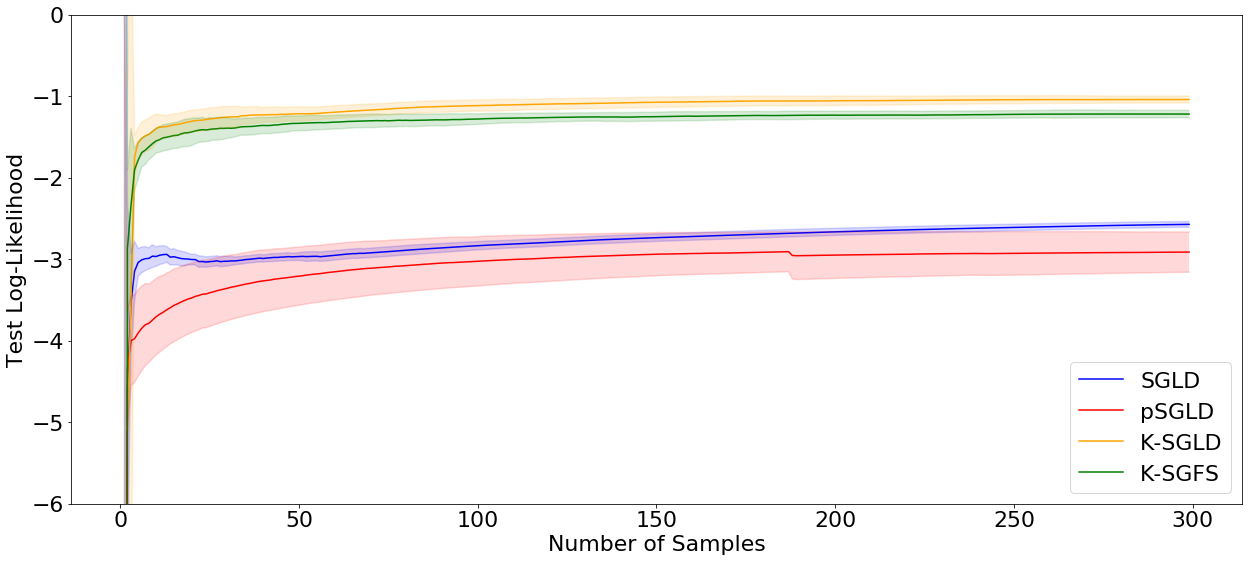

In [42]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),ll_meanRunningSGLD,'blue', label = 'SGLD')
plt.plot(range(n_samples),ll_meanRunningPSGLD,'red', label = 'pSGLD')
plt.plot(range(n_samples),ll_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),ll_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),ll_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),ll_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),ll_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),ll_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),ll_lowerSGLD, ll_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerPSGLD, ll_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGLD, ll_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGFS, ll_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("Test Log-Likelihood")
plt.ylim(-6,0)
plt.legend()


### RMSE

In [39]:
rmse_meanRunningSGLD = np.mean(rmse_sgld, 0)
rmse_stdRunningSGLD = np.std(rmse_sgld, 0)
rmse_upperSGLD = rmse_meanRunningSGLD + rmse_stdRunningSGLD
rmse_lowerSGLD = rmse_meanRunningSGLD - rmse_stdRunningSGLD

rmse_meanRunningPSGLD = np.mean(rmse_psgld, 0)
rmse_stdRunningPSGLD = np.std(rmse_psgld, 0)
rmse_upperPSGLD = rmse_meanRunningPSGLD + rmse_stdRunningPSGLD
rmse_lowerPSGLD = rmse_meanRunningPSGLD - rmse_stdRunningPSGLD

rmse_meanRunningKSGLD = np.mean(rmse_ksgld, 0)
rmse_stdRunningKSGLD = np.std(rmse_ksgld, 0)
rmse_upperKSGLD = rmse_meanRunningKSGLD + rmse_stdRunningKSGLD
rmse_lowerKSGLD = rmse_meanRunningKSGLD - rmse_stdRunningKSGLD

rmse_meanRunningKSGFS = np.mean(rmse_ksgfs, 0)
rmse_stdRunningKSGFS = np.std(rmse_ksgfs, 0)
rmse_upperKSGFS = rmse_meanRunningKSGFS + rmse_stdRunningKSGFS
rmse_lowerKSGFS = rmse_meanRunningKSGFS - rmse_stdRunningKSGFS

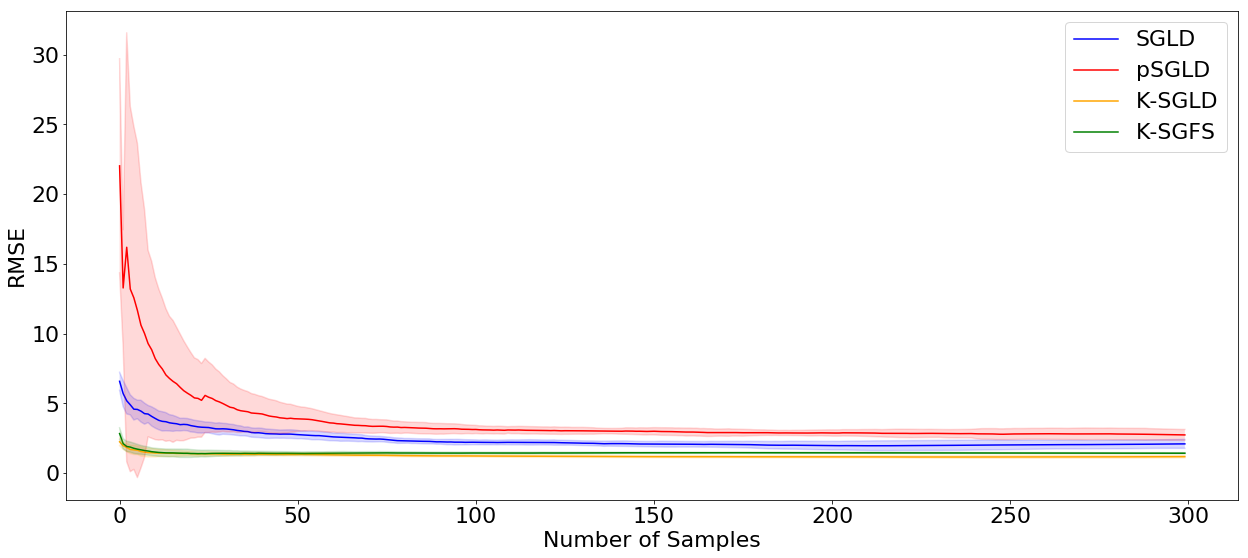

In [43]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),rmse_meanRunningSGLD,'blue', label='SGLD')
plt.plot(range(n_samples),rmse_meanRunningPSGLD,'red', label ='pSGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),rmse_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),rmse_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),rmse_lowerSGLD, rmse_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerPSGLD, rmse_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGLD, rmse_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGFS, rmse_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("RMSE")

plt.legend()
